In [1]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV, ParameterGrid, KFold, \
RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, \
roc_curve, auc, precision_score, recall_score, confusion_matrix
import statsmodels.formula.api as smf
import statsmodels.api as sm
from patsy import dmatrix
from pyearth import Earth
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
import random

In [2]:
data = pd.read_csv('us_used_cars_final.csv')
data.head(2)

vin back_legroom        body_type     city  \
0  5LMCJ2C97HUL71203      36.8 in  SUV / Crossover   Devine   
1  1FM5K8D87HGE07214      39.5 in  SUV / Crossover  Buffalo   

   city_fuel_economy  daysonmarket  dealer_zip  \
0               21.0            40       78016   
1               16.0             9       55313   

                                         description engine_cylinders  \
0  *We have 19 sources of financing and second ch...               I4   
1  We are open for business.    Purchase your nex...               V6   

   engine_displacement  ...                 torque transmission  \
0               2000.0  ...  270 lb-ft @ 3,000 RPM            A   
1               3500.0  ...  255 lb-ft @ 4,000 RPM            A   

   transmission_display  trimId   trim_name wheel_system wheel_system_display  \
0             Automatic  t66989  Select FWD          FWD    Front-Wheel Drive   
1     6-Speed Automatic  t67141     XLT AWD          AWD      All-Wheel Drive   

  wheelbase    width  year  
0  105.9 in  84.1 in  2017  
1  112.8 in  90.2 in  2017  

[2 rows x 57 columns]

## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

### Distribution of response
*By Hiba Khatib*

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


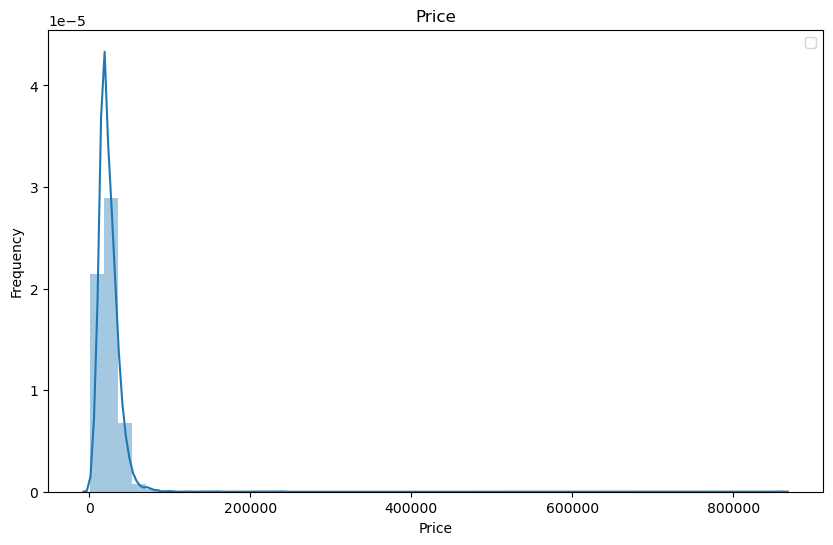

Mean of price:  24568.3835
Standard deviation:  16742.99685916766


In [3]:
#...Plot for distribution of response...#

plt.figure(figsize=(10,6))
sns.distplot(data.price)
plt.title('Price')
plt.legend()
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

# Mean and standard deviation of response #

print("Mean of price: ", np.mean(data.price))
print("Standard deviation: ", np.std(data.price))

The data needs a log transformation on price. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


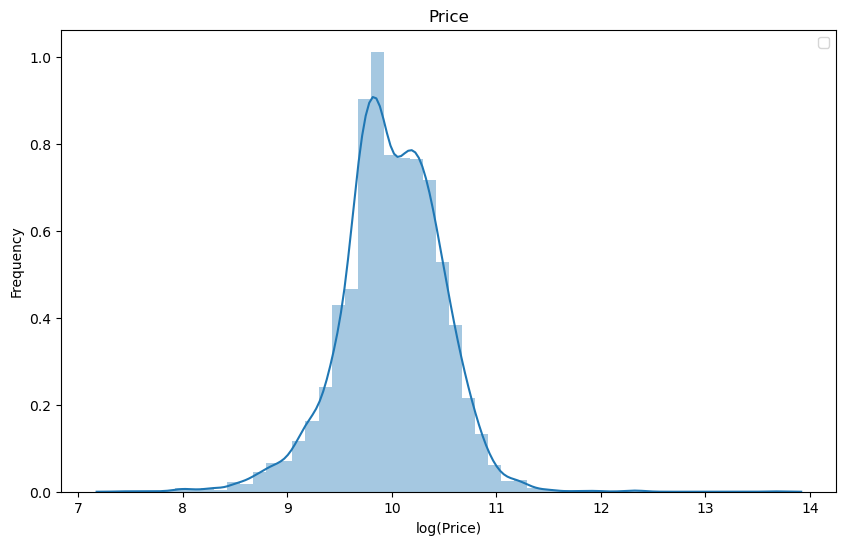

In [4]:
plt.figure(figsize=(10,6))
sns.distplot(np.log(data.price))
plt.title('Price')
plt.legend()
plt.xlabel('log(Price)')
plt.ylabel('Frequency')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

The distribution is much more uniform now with the log transformation. 

<AxesSubplot:xlabel='price'>

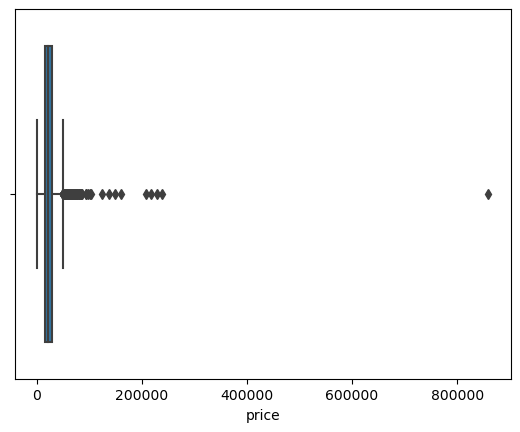

In [5]:
# checking for outlying observations 
sns.boxplot(data.price, orient = "v")

In [6]:
data.price.describe()

count      6000.000000
mean      24568.383500
std       16744.392283
min        1680.000000
25%       16500.000000
50%       21924.000000
75%       29995.000000
max      859000.000000
Name: price, dtype: float64

There appears to be many outliers that we can drop before performing any feature selection. Dropping the outliers should help us avoid possible issues with overfitting to the training data and the complexities that are related to outlying observations. 

In [7]:
data_subset = data[data.price <= 30000]

<AxesSubplot:xlabel='price'>

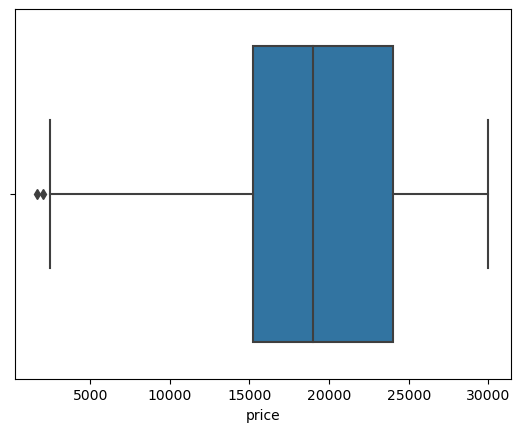

In [8]:
sns.boxplot(data_subset.price)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


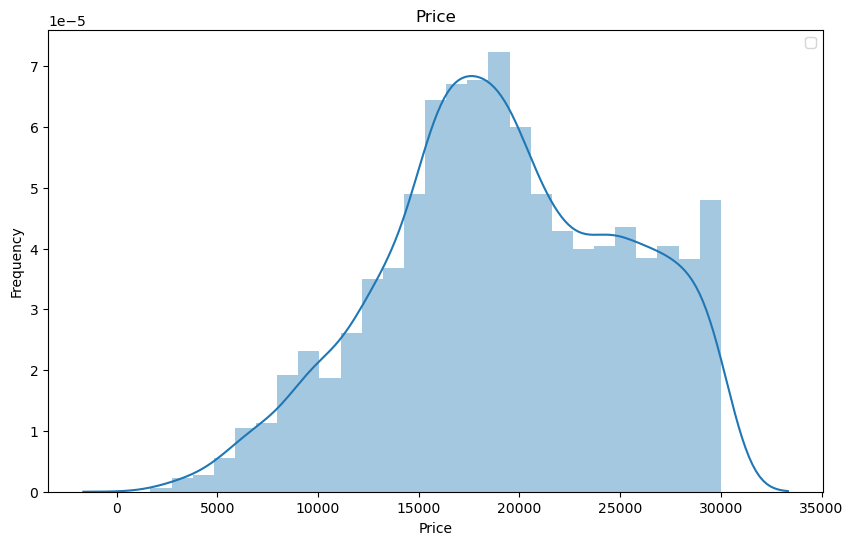

Mean of price:  19205.211827007945
Standard deviation:  5978.306973568847


In [9]:
#...Plot for distribution of response after removing outliers...#

plt.figure(figsize=(10,6))
sns.distplot(data_subset.price)
plt.title('Price')
plt.legend()
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

# Mean and standard deviation of response #

print("Mean of price: ", np.mean(data_subset.price))
print("Standard deviation: ", np.std(data_subset.price))

The mean and standard deviation have significantly decreased after removing all of the outliers and now we don't need to transform the predictor. The mean and standard deviation have also decreased significantly.

In [10]:
data = data_subset.copy()

In [11]:
print("The final shape of the data after removing outliers is", data.shape)

The final shape of the data after removing outliers is (4532, 57)


### Data Cleaning, Preparation, and EDA
*By Hiba Khatib & Emily Leibfritz*


After creating all 8 base models, we decided to subset the data into two different ways to improve the analysis of our data. The first subset is the resulting features after our EDA and data preparation. The second way we subsetted the data was based on the features selected by tree based models. Our methods are described in detail below. 

1. Our EDA Selected Features (Hiba & Emily)

We performed data cleaning, preparation and EDA on the data to facilitate feature selection and model training. The first thing we did was fix the data types of some of the columns. All of the boolean columns were encoded as True or False so we mapped those to 1s and 0s. Then, we found that several columns such as horsepower and torque were numerical but contained units. We removed all of the units from these columns and converted them back to numeric. Then, we dropped a set of unique identifiers which were not sigificant to our analysis. We also dropped three columns which represented the interior, and exterior color of the car. These columns had different names for the same color and we did not see them as significant predictors to engineer and encode differently. Then, we dropped a constant predictor which contained the same value for all observations as constant predictors don't provide any meaningful insights. The final step in the cleaning and preparation of the numerical data, we dropped highly correlated features. These were features which represented the same information in two different ways such as the official name of a trim and the id associated with that name. This resulted in us keeping only 14 of the numerical predictors are subsetting for predictors with a correlation of |-.2|. 

For the categorical columns, each was observed individually in order to find the best way to handle them, as just converting them all into dummies resulted in a huge dataset.

Some columns with few unique values that showed a connection to the target variable were just converted into dummies, like body_type and transmission_display.

Some columns, like engine_cylinders and transmission display had some values very common while others only had under 100 observations. These were grouped as others, and the columns were converted into dummies.

Some columns like franchise_make and model_name had a too large amount of unique values to convert into dummies, so the observations were grouped by mean value of target variable, and assigned a number between 1-6.

Some columns did not show any connection to the target variable, while often having a big amount of unique values, like the columns concerning the color of the vehicles, city or major_options. These columns were dropped.

Some columns contained the same information given by other columns already, like the pairs trim&trimID, make_name&franchise_make, engine_type&engine_cylinders where each trim, engine_type and make_name were dropped.

In [12]:
# feature engineering

    # encoding True/False as 1/0s
bool_cols = data.dtypes[data.dtypes == bool]
bool_cols = pd.DataFrame(bool_cols).reset_index()
bool_cols = bool_cols['index']
bool_cols = list(bool_cols)
print(bool_cols)
for col in bool_cols:
    data[col] = data[col].map({False: 0, True: 1})
    

    # numerically encoding categorical variables with at most 5 unique values 
cols_map = []
for c in data.columns:
    col_len = (len(data[c].unique()))
    if col_len <=5:
        cols_map.append(c)
[cols_map.remove(c) for c in bool_cols] # removing the boolean columns from the list

    # performing the encoding
le = LabelEncoder()
encoder_dict = {key: None for key in cols_map}
for c in cols_map:
    encoder_dict[c] = data[c].unique()
    col_name = str(c)+"_cat"
    data[col_name] = le.fit_transform(data[c])
    encoder_dict[col_name] = le.fit_transform(encoder_dict[c])
    
    # removing units from numerical columns 

data['front_legroom'] = data['front_legroom'].map(lambda x: x.lstrip('+-').rstrip('in'))
data['width'] = data['width'].map(lambda x: x.lstrip('+-').rstrip('in'))
data['height'] = data['height'].map(lambda x: x.lstrip('+-').rstrip('in'))
data['length'] = data['length'].map(lambda x: x.lstrip('+-').rstrip('in'))
data['wheelbase'] = data['wheelbase'].map(lambda x: x.lstrip('+-').rstrip('in'))
data['back_legroom'] = data['back_legroom'].map(lambda x: x.lstrip('+-').rstrip('in'))
data['maximum_seating'] = data['maximum_seating'].map(lambda x: x.lstrip('+-').rstrip('seating'))
data['fuel_tank_volume'] = data['fuel_tank_volume'].map(lambda x: x.lstrip('+-').rstrip('gal'))
data['power'] = data['power'].str[:3] # keeping only numerical value
data['torque'] = data['torque'].str[:3]

    # converting data types to numerical
data.power = pd.to_numeric(data.power)
data.back_legroom = pd.to_numeric(data.back_legroom)
data.front_legroom = pd.to_numeric(data.front_legroom)
data.width = pd.to_numeric(data.width)
data.height = pd.to_numeric(data.height)
data.length = pd.to_numeric(data.length)
data.wheelbase = pd.to_numeric(data.wheelbase)
data.maximum_seating = pd.to_numeric(data.maximum_seating)
data.fuel_tank_volume = pd.to_numeric(data.fuel_tank_volume)
data.torque = pd.to_numeric(data.torque)

['fleet', 'frame_damaged', 'franchise_dealer', 'has_accidents', 'isCab', 'is_new', 'salvage', 'theft_title']


In [13]:
data.columns

Index(['vin', 'back_legroom', 'body_type', 'city', 'city_fuel_economy',
       'daysonmarket', 'dealer_zip', 'description', 'engine_cylinders',
       'engine_displacement', 'engine_type', 'exterior_color', 'fleet',
       'frame_damaged', 'franchise_dealer', 'franchise_make', 'front_legroom',
       'fuel_tank_volume', 'fuel_type', 'has_accidents', 'height',
       'highway_fuel_economy', 'horsepower', 'interior_color', 'isCab',
       'is_new', 'latitude', 'length', 'listed_date', 'listing_color',
       'listing_id', 'longitude', 'main_picture_url', 'major_options',
       'make_name', 'maximum_seating', 'mileage', 'model_name', 'owner_count',
       'power', 'price', 'salvage', 'savings_amount', 'seller_rating', 'sp_id',
       'sp_name', 'theft_title', 'torque', 'transmission',
       'transmission_display', 'trimId', 'trim_name', 'wheel_system',
       'wheel_system_display', 'wheelbase', 'width', 'year', 'fuel_type_cat',
       'transmission_cat', 'wheel_system_cat', 'wheel_syst

In [14]:
# dropping unique features

data.drop(columns = ['vin', 'listing_id', 'main_picture_url', 'description', 'sp_name', 'make_name', 'city'], inplace = True)

    # color columns
data.drop(columns = ['listing_color', 'interior_color', 'exterior_color'], inplace = True)

print("Data shape after dropping unique features: ", data.shape)

# dropping constant predictor 
print(data.nunique() == 1)
data.drop(columns = ['franchise_dealer'], inplace = True)

# dropping highly correlated columns 

data.drop(columns = ['trim_name', 'engine_type', 'major_options', 'horsepower'], inplace = True)

Data shape after dropping unique features:  (4532, 51)
back_legroom                False
body_type                   False
city_fuel_economy           False
daysonmarket                False
dealer_zip                  False
engine_cylinders            False
engine_displacement         False
engine_type                 False
fleet                       False
frame_damaged               False
franchise_dealer             True
franchise_make              False
front_legroom               False
fuel_tank_volume            False
fuel_type                   False
has_accidents               False
height                      False
highway_fuel_economy        False
horsepower                  False
isCab                       False
is_new                      False
latitude                    False
length                      False
listed_date                 False
longitude                   False
major_options               False
maximum_seating             False
mileage                    

In [15]:
print("Final data shape after cleaning and dropping unnecessary features: ", data.shape)

Final data shape after cleaning and dropping unnecessary features:  (4532, 46)


### Exploring Trends in Categorical Predictors

In [16]:
data_2 = data.copy()
# make seperate df to just look at categorical
o_data = data.drop(columns = ["back_legroom", "wheel_system_display", "wheelbase", "width", "front_legroom", 
                              "fuel_tank_volume", "height", "torque", "maximum_seating","transmission_cat",
                              "power","city_fuel_economy","daysonmarket","dealer_zip","transmission","wheel_system_display_cat",
                              "fuel_type_cat","wheel_system","wheel_system_cat","fuel_type",
                              "engine_displacement","fleet","frame_damaged","has_accidents","highway_fuel_economy",
                              "isCab","is_new","latitude","longitude","mileage","owner_count","salvage",
                              "savings_amount","seller_rating","sp_id","theft_title","year"], axis = 1)
# taken out: "franchise_dealer"
cols = o_data.columns
name = []
unique_value = []
for i in range(0,len(cols)):
    c = cols[i]
    unique = len(data[c].unique())
    unique_value.append(unique)
    name.append(c)

In [17]:
# Create the pandas DataFrame with object columns and their unique values
data_ = {'column': name, 'unique_values':unique_value}
o_unique_values_count = pd.DataFrame(data_)
o_unique_values_count.sort_values(by=['unique_values'])

column  unique_values
0             body_type              9
1      engine_cylinders             16
7  transmission_display             18
2        franchise_make             34
4           listed_date            286
5            model_name            289
3                length            333
8                trimId           2344
6                 price           2485

From this information, we can simply visualize with boxplot any variables until make_name, to see their relevance and adjust them. After that we will look more thoroughly, maybe group data. Consider dropping anything with other 1000 unique values as we only have 6000 rows, so might not be good predictors, but will decide on case by case basis.

[]

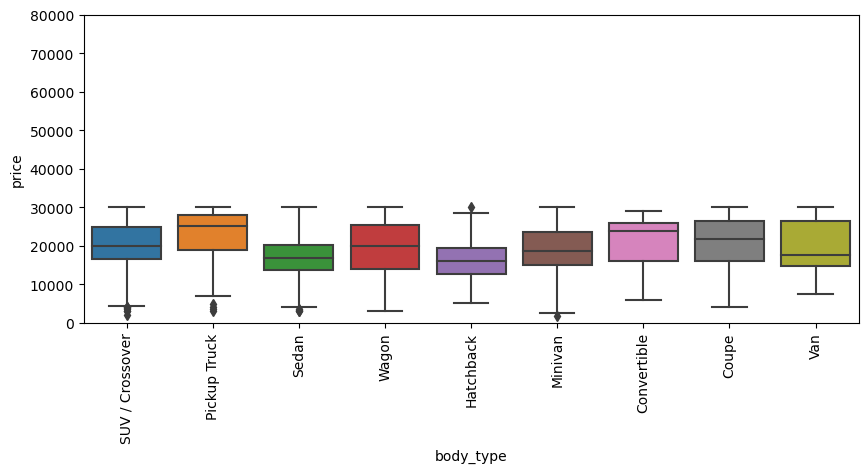

In [18]:
plt.figure(figsize=(10,4))
sns.boxplot(x="body_type",y="price", data = data)
plt.xticks(rotation=90)
plt.ylim(0,80000)

plt.plot()

body_type seems to have a significant trend right away. We cancheck value counts to see if some types are more common than others

In [19]:
data.body_type.value_counts()

SUV / Crossover    2295
Sedan              1503
Pickup Truck        190
Minivan             184
Wagon               115
Hatchback           108
Coupe                98
Convertible          27
Van                  12
Name: body_type, dtype: int64

Have enough observations for each value to be valid, none of the smaller groups stand out substantially, convertible is a little bit spread but that should be fine -> convert to dummies

In [20]:
# change spelling so colummns will be callable
data_2['body_type'] = o_data['body_type'].apply(lambda x: 'SUV_Crossover' if x == 'SUV / Crossover' else 
                                                          'Pickup_Truck' if x == 'Pickup Truck' else
                                                x)
# get dummies
data_2 = pd.get_dummies(data_2, columns=['body_type'], drop_first=True)

[]

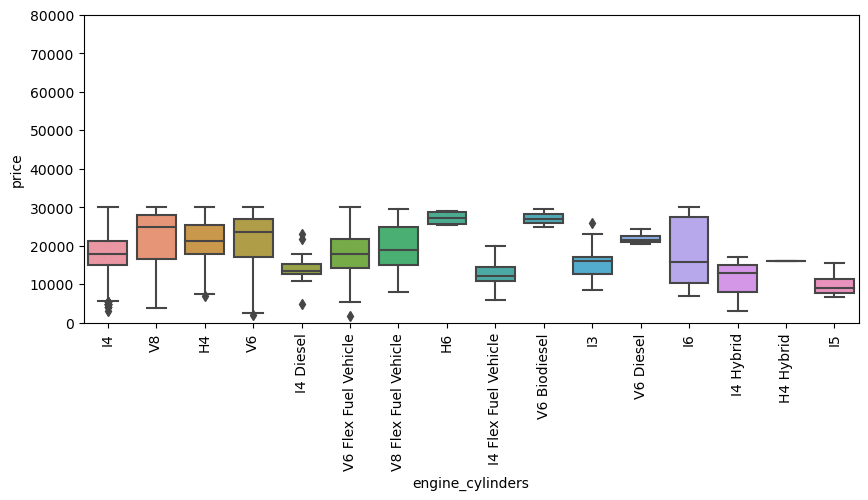

In [21]:
plt.figure(figsize=(10,4))

sns.boxplot(x="engine_cylinders",y="price", data = o_data)
plt.xticks(rotation=90)
plt.ylim(0,80000)
plt.plot()

In [22]:
o_data.engine_cylinders.value_counts()

I4                      2776
V6                      1223
V6 Flex Fuel Vehicle     156
H4                       145
V8                       105
V8 Flex Fuel Vehicle      45
I4 Flex Fuel Vehicle      22
I4 Diesel                 16
I3                        13
I6                        12
H6                         4
V6 Diesel                  4
I5                         4
V6 Biodiesel               3
I4 Hybrid                  3
H4 Hybrid                  1
Name: engine_cylinders, dtype: int64

Turn anything under 100 observations into 'other', if there is only one observation this is not useful data.

In [23]:
data_2['engine_cylinders'] = o_data['engine_cylinders'].apply(lambda x: 'I4' if x == 'I4' else 
                                                          'V6' if x == 'V6' else
                                                          'V8' if x == 'V8' else
                                                          'V6_Flex_Fuel_Vehicle' if x == 'V6 Flex Fuel Vehicle' else
                                                          'H4' if x == 'H4' else
                                                          'other')
data_2.engine_cylinders.value_counts()

I4                      2776
V6                      1223
V6_Flex_Fuel_Vehicle     156
H4                       145
other                    127
V8                       105
Name: engine_cylinders, dtype: int64

[]

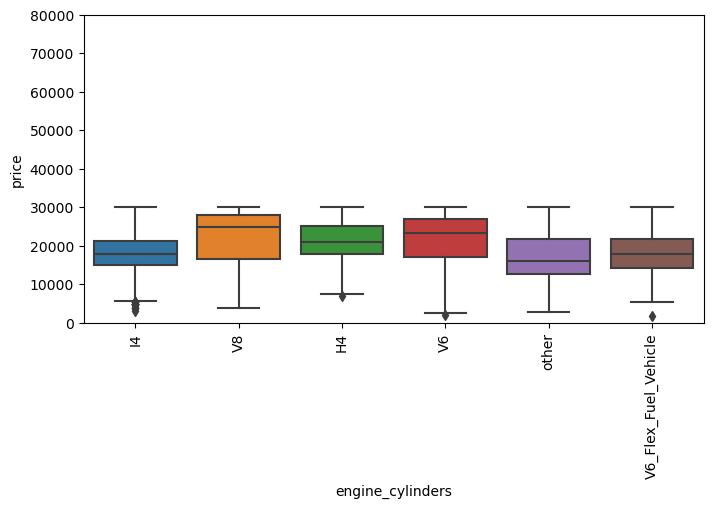

In [24]:
plt.figure(figsize=(8,4))
sns.boxplot(x="engine_cylinders",y="price", data = data_2)
plt.xticks(rotation=90)
plt.ylim(0,80000)
plt.plot()

Other is naturally with bigger range, but this looks better, get dummies for it:

In [25]:
data_2 = pd.get_dummies(data_2, columns=['engine_cylinders'], drop_first=True)

[]

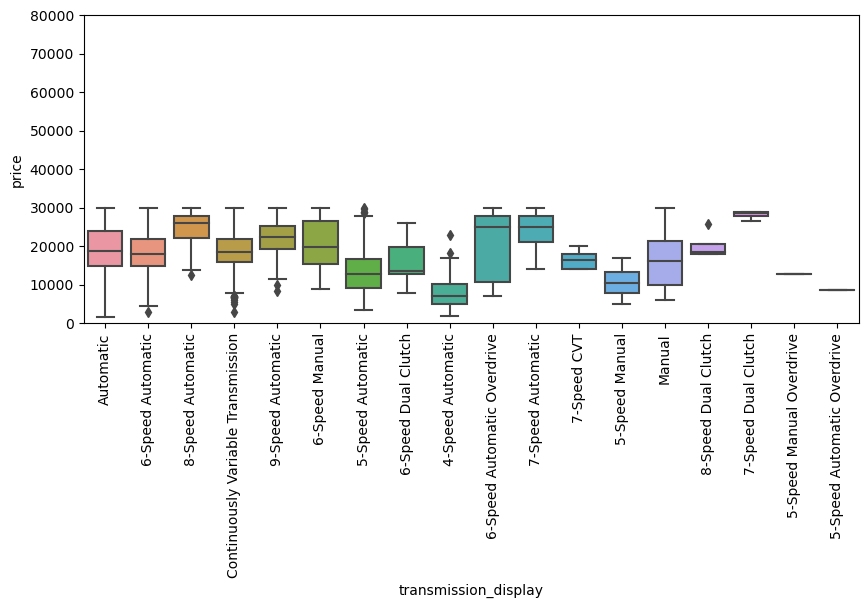

In [26]:
plt.figure(figsize=(10,4))
sns.boxplot(x="transmission_display",y="price", data = o_data)
plt.xticks(rotation=90)
plt.ylim(0,80000)
plt.plot()

Mean and range seem both to be varying, might be valuable column to predict price, check value counts:

In [27]:
data.transmission_display.value_counts().head()

Automatic                             1583
6-Speed Automatic                     1157
Continuously Variable Transmission     934
8-Speed Automatic                      334
9-Speed Automatic                      189
Name: transmission_display, dtype: int64

[]

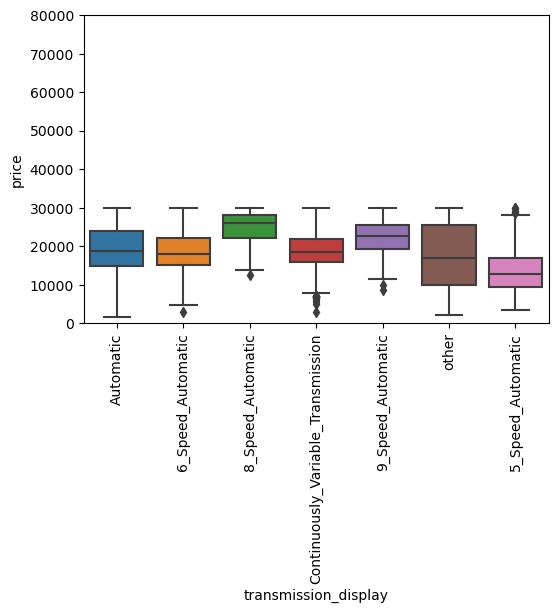

In [28]:
data_2['transmission_display'] = o_data['transmission_display'].apply(lambda x: 'Automatic' if x == 'Automatic' else 
                                                          '6_Speed_Automatic' if x == '6-Speed Automatic' else
                                                          'Continuously_Variable_Transmission' if x == 'Continuously Variable Transmission' else
                                                          '8_Speed_Automatic' if x == '8-Speed Automatic' else
                                                          '9_Speed_Automatic' if x == '9-Speed Automatic' else
                                                          '6_Speed_Automatic' if x == '6-Speed Automatic' else
                                                          '5_Speed_Automatic' if x == '5-Speed Automatic' else
                                                          'other')
plt.figure(figsize=(6,4))
sns.boxplot(x="transmission_display",y="price", data = data_2)
plt.xticks(rotation=90)
plt.ylim(0,80000)
plt.plot()

Looks relevant, change in mean and besides 2 relatively small range -> convert into dummies

In [29]:
# turn those columns into dummies
data_2 = pd.get_dummies(data_2, columns=['transmission_display'], drop_first=True)

[]

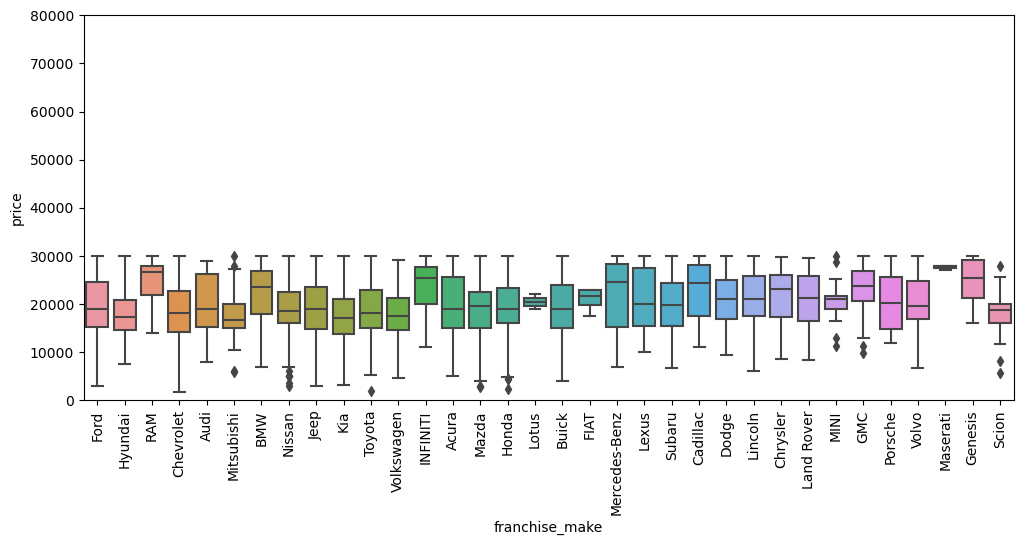

In [30]:
plt.figure(figsize=(12,5))
sns.boxplot(x="franchise_make",y="price", data = o_data)
plt.xticks(rotation=90)
plt.ylim(0,80000)
plt.plot()

This seems to be too many columns to just turn into dummies, and as brand is strongly connected to price this seems an important column to keep -> divide brands into groups depending on their mean price, and label encode these groups.

In [31]:
# look at mean price by group
brand_mean_price=data.groupby('franchise_make', as_index=False)['price'].mean()
brand_mean_price=brand_mean_price.sort_values(by=['price'])
brand_mean_price.head()

franchise_make         price
16            Kia  17610.859551
25     Mitsubishi  17617.980000
29          Scion  17778.894737
32     Volkswagen  18031.586957
13        Hyundai  18046.270270

In [32]:
# sort the brands into groups with similar means
group_0 = brand_mean_price.iloc[0:8,0]
group_1 = brand_mean_price.iloc[8:14,0]
group_2 = brand_mean_price.iloc[14:19,0]
group_3 = brand_mean_price.iloc[19:25,0]
group_4 = brand_mean_price.iloc[25:34,0]
group_5 = brand_mean_price.iloc[34:38,0]
group_6 = brand_mean_price.iloc[38:40,0]

# write function to get names
def get_names (group):
    final = []
    for i in range(0,len(group)):
        name = group.iloc[i]
        final.append(name)
    return(final)
# list of names in each group
names_0 = get_names(group_0)
names_1 = get_names(group_1)
names_2 = get_names(group_2)
names_3 = get_names(group_3)
names_4 = get_names(group_4)
names_5 = get_names(group_5)
names_6 = get_names(group_6)

# replace each object with a number of their group
data_2['franchise_make'] = o_data['franchise_make'].apply(lambda x: 0 if x in names_0 else
                                                          1 if x in names_1 else
                                                          2 if x in names_2 else
                                                          3 if x in names_3 else
                                                          4 if x in names_4 else
                                                          5 if x in names_5 else
                                                          6 if x in names_6 else
                                                         'wrong')

In [33]:
data.listed_date.value_counts().head()

2020-09-02    163
2020-08-28    119
2020-09-03    110
2020-08-27    109
2020-08-30    105
Name: listed_date, dtype: int64

In [34]:
#simply turn into numerical
import datetime
data_2['listed_date']=pd.to_datetime(data_2["listed_date"]).dt.strftime("%Y%m%d")
data_2['listed_date']=data_2.listed_date.astype(int)
# get correlation
data_2['listed_date'].corr(data_2['price'])

-0.027944370408355405

Has a negative correlation between listing date and price, rather small

In [35]:
data.model_name.value_counts().head()

Escape     166
Rogue      146
Accord     125
Corolla    114
RAV4       108
Name: model_name, dtype: int64

Looking at both head and tail, there is a good distribution of the different model names, not one that is prelevant wherease the rest only has 1 or 2 entries -> group and turn into numeric

In [36]:
# look at grouped mean
make_mean_price=data.groupby('model_name', as_index=False)['price'].mean()
make_mean_price=make_mean_price.sort_values(by=['price'])
make_mean_price.head()

model_name   price
195                  QX4  2000.0
164       Mariner Hybrid  2953.0
95   Explorer Sport Trac  2995.0
101         Five Hundred  3000.0
182          Park Avenue  3000.0

In [37]:
# like with other column, divide 361 rows into 7 groups, different sizes but around same mean
group_0 = make_mean_price.iloc[0:100,0] # 2000-15000
group_1 = make_mean_price.iloc[100:194,0] # 15000-25000 
group_2 = make_mean_price.iloc[194:237,0] # 25000-30000 
group_3 = make_mean_price.iloc[237:279,0] # 30000-35000
group_4 = make_mean_price.iloc[279:329,0] # 35000-50000
group_5 = make_mean_price.iloc[319:352,0] # 50000-10000
group_6 = make_mean_price.iloc[352:362,0] # rest

# list of names in each group
names_0 = get_names(group_0)
names_1 = get_names(group_1)
names_2 = get_names(group_2)
names_3 = get_names(group_3)
names_4 = get_names(group_4)
names_5 = get_names(group_5)
names_6 = get_names(group_6)

# replace each object with a number of their group
data_2['model_name'] = o_data['model_name'].apply(lambda x: 0 if x in names_0 else
                                                          1 if x in names_1 else
                                                          2 if x in names_2 else
                                                          3 if x in names_3 else
                                                          4 if x in names_4 else
                                                          5 if x in names_5 else
                                                          6 if x in names_6 else
                                                         'wrong')

In [38]:
# drop first letter of each row
data_2['trimId'] = data['trimId'].str.slice(1)
# convert to integer
data_2['trimId']=data_2.trimId.astype(int)
# look at correlation
data_2['trimId'].corr(data_2['price'])

0.5706133697377519

In [39]:
# drop categorical version of columns we have numerical copy of
data_2 = data_2.drop(columns=["transmission","wheel_system_display","fuel_type","wheel_system"], axis = 1)

In [40]:
dat_types = pd.DataFrame(data_2.dtypes)

In [41]:
dat_types.value_counts()

int64      21
uint8      19
float64    18
dtype: int64

In [42]:
data_2.shape

(4532, 58)

In [43]:
data = data_2

In [44]:
data

back_legroom  city_fuel_economy  daysonmarket  dealer_zip  \
0             36.8               21.0            40       78016   
2             36.8               23.0            30       37129   
5             38.2               21.0           161       73069   
6             40.3               15.0            14       48836   
7             40.9               21.0            49       12701   
...            ...                ...           ...         ...   
5994          33.4               23.0             1       95407   
5995          37.0               20.0            88       15146   
5996          39.8               22.0            38       77065   
5997          37.3               22.0            92       84341   
5999          35.7               30.0            64       95661   

      engine_displacement  fleet  frame_damaged  franchise_make  \
0                  2000.0      0              0               1   
2                  2500.0      0              0               1   
5                  2000.0      0              0               0   
6                  5700.0      0              0               4   
7                  2400.0      1              0               0   
...                   ...    ...            ...             ...   
5994               2000.0      0              0               1   
5995               2000.0      0              0               3   
5996               2500.0      0              0               0   
5997               2000.0      0              0               1   
5999               2000.0      1              0               0   

      front_legroom  fuel_tank_volume  ...  engine_cylinders_V6  \
0              42.8              15.5  ...                    0   
2              43.1              15.4  ...                    0   
5              41.5              16.4  ...                    0   
6              41.0              26.0  ...                    0   
7              44.1              18.8  ...                    0   
...             ...               ...  ...                  ...   
5994           43.1              12.4  ...                    0   
5995           44.3              18.0  ...                    0   
5996           45.8              18.5  ...                    0   
5997           43.1              15.7  ...                    0   
5999           42.2              14.0  ...                    0   

      engine_cylinders_V6_Flex_Fuel_Vehicle  engine_cylinders_V8  \
0                                         0                    0   
2                                         0                    0   
5                                         0                    0   
6                                         0                    1   
7                                         0                    0   
...                                     ...                  ...   
5994                                      0                    0   
5995                                      0                    0   
5996                                      0                    0   
5997                                      0                    0   
5999                                      0                    0   

      engine_cylinders_other  transmission_display_6_Speed_Automatic  \
0                          0                                       0   
2                          0                                       0   
5                          0                                       1   
6                          0                                       0   
7                          0                                       0   
...                      ...                                     ...   
5994                       0                                       0   
5995                       0                                       1   
5996                       0                                       0   
5997                       0                          

### Feature Selection 

In [45]:
final_corrs = pd.DataFrame(data.corrwith(data.price)).reset_index().sort_values(by = 0, ascending = False)

final_corr_cols = list(final_corrs.loc[(final_corrs[0] >= 0.2) | (final_corrs[0] <= -0.2)][1:]['index'])
final_corrs.loc[(final_corrs[0] >= 0.2) | (final_corrs[0] <= -0.2)][1:]

index         0
21                              model_name  0.581373
34                                    year  0.574644
31                                  trimId  0.570613
23                                   power  0.406592
30                                  torque  0.386623
33                                   width  0.303995
53  transmission_display_8_Speed_Automatic  0.268433
32                               wheelbase  0.256636
11                                  height  0.245438
48                     engine_cylinders_V6  0.245117
16                                  length  0.238048
9                         fuel_tank_volume  0.225640
4                      engine_displacement  0.220415
26                          savings_amount  0.203765
7                           franchise_make  0.202163
1                        city_fuel_economy -0.203095
37                        wheel_system_cat -0.203731
38                wheel_system_display_cat -0.208184
12                    highway_fuel_economy -0.230709
44                         body_type_Sedan -0.231848
47                     engine_cylinders_I4 -0.232696
22                             owner_count -0.383574
20                                 mileage -0.566824

In [46]:
X = data.copy()

for col in X:
    if col not in final_corr_cols:
        X.drop(col, axis = 1, inplace = True)

X.shape

(4532, 23)

We have 23 predictors which have a reasonable correlation with price which we will be the only predictors we use in our model building. 

When we develop our models, we will print the feature importances and note which features are deemed significant by each model. 

In [47]:
# checking for any new NAs 
X.isna().sum()

city_fuel_economy                         0
engine_displacement                       0
franchise_make                            0
fuel_tank_volume                          1
height                                    1
highway_fuel_economy                      0
length                                    1
mileage                                   0
model_name                                0
owner_count                               0
power                                     0
savings_amount                            0
torque                                    0
trimId                                    0
wheelbase                                 1
width                                     1
year                                      0
wheel_system_cat                          0
wheel_system_display_cat                  0
body_type_Sedan                           0
engine_cylinders_I4                       0
engine_cylinders_V6                       0
transmission_display_8_Speed_Aut

In [48]:
y = data.price 
y.isna().sum()

0

The original dataset had '--' for this one observation. When we performed the data cleaning and prep, these observations were not considered missing but became missing after our feature engineering. We can drop this observation since it is only one row with data missing from the original source. 

In [49]:
X.isna().sum()
X.iloc[29]
X.drop(29, inplace = True)
y.drop(29, inplace = True)

In [50]:
X.to_csv('X.csv')
y.to_csv('y.csv')

In [51]:
clean_X = X.copy()
clean_y = y.copy()

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 4)

### Features Selection using Tree Based Models

Using the tree based methods such as RandomForest and DecisionTrees will allow us to double check if our feature selection has been significant or if it produces better results for base models.

The original shape of our data after removing the outliers is 4532, 58.

After our data cleaning and dropping of the units, we created some NaN values which can be dropped. We can confidently drop these observations because they were initially missing but encoded as '--' which is why we did not initially discover that they were missing. These are 31 observations which we can drop which brings our data shape to 4301, 58

In [53]:
data.shape

(4532, 58)

In [54]:
data_copy = data.copy()
data_copy.dropna(inplace = True)
data_copy.shape

(4501, 58)

In [55]:
X_tree = data_copy.drop(columns = ['price'])
y_tree = data_copy.price

#### Base Random Forest Feature Selection

In [56]:
rf_features = RandomForestRegressor(random_state = 4).fit(X_tree, y_tree)
rf_feats = pd.DataFrame(zip(rf_features.feature_names_in_, rf_features.feature_importances_))

In [57]:
rf_feats.sort_values(by = 1, ascending = False)

0             1
30                                             trimId  3.681064e-01
21                                         model_name  2.059636e-01
23                                              power  1.224561e-01
20                                            mileage  8.733049e-02
29                                             torque  2.501834e-02
0                                        back_legroom  1.947877e-02
25                                     savings_amount  1.366988e-02
11                                             height  1.346977e-02
47                                engine_cylinders_V6  9.795723e-03
33                                               year  9.452366e-03
15                                           latitude  9.071714e-03
26                                      seller_rating  8.884898e-03
27                                              sp_id  8.311864e-03
16                                             length  8.101590e-03
12                               highway_fuel_economy  8.033217e-03
32                                              width  7.344786e-03
9                                    fuel_tank_volume  7.089915e-03
2                                        daysonmarket  6.167395e-03
36                                   wheel_system_cat  6.084273e-03
18                                          longitude  5.956792e-03
37                           wheel_system_display_cat  5.825781e-03
31                                          wheelbase  5.460589e-03
3                                          dealer_zip  5.311008e-03
8                                       front_legroom  5.194709e-03
17                                        listed_date  4.584625e-03
4                                 engine_displacement  4.355540e-03
1                                   city_fuel_economy  3.154374e-03
7                                      franchise_make  2.225961e-03
42                            body_type_SUV_Crossover  1.811286e-03
22                                        owner_count  1.508617e-03
19                                    maximum_seating  1.295084e-03
51             transmission_display_6_Speed_Automatic  9.956286e-04
10                                      has_accidents  9.003557e-04
54                     transmission_display_Automatic  8.624836e-04
13                                              isCab  8.238435e-04
5                                               fleet  7.241308e-04
52             transmission_display_8_Speed_Automatic  6.188337e-04
43                                    body_type_Sedan  5.821297e-04
46                                engine_cylinders_I4  5.186393e-04
34                                      fuel_type_cat  5.060303e-04
35                                   transmission_cat  5.033826e-04
55  transmission_display_Continuously_Variable_Tra...  4.730021e-04
56                         transmission_display_other  3.798145e-04
45                                    body_type_Wagon  2.671794e-04
53             transmission_display_9_Speed_Automatic  2.053301e-04
48              engine_cylinders_V6_Flex_Fuel_Vehicle  1.959885e-04
39                                body_type_Hatchback  1.790901e-04
14                                             is_new  1.749637e-04
41                             body_type_Pickup_Truck  1.455960e-04
40                                  body_type_Minivan  1.367203e-04
50                             engine_cylinders_other  1.187689e-04
49                                engine_cylinders_V8  8.934867e-05
38                                    body_type_Coupe  6.330553e-05
28                                        theft_title  1.080973e-05
6                                       frame_damaged  6.621246e-06
44                                      body_type_Van  2.167886e-06
24                                            salvage  4.001456e-07

In [58]:
rf_feats[(rf_feats[1] >= 0.2) | (rf_feats[1] <= -.2)]

0         1
21  model_name  0.205964
30      trimId  0.368106

In [59]:
base_dt = DecisionTreeRegressor(random_state = 4).fit(X_tree, y_tree)
dt_feats = pd.DataFrame(zip(base_dt.feature_names_in_, base_dt.feature_importances_))
dt_feats.sort_values(by = 1, ascending = False)
dt_feats[(dt_feats[1] >= 0.2) | (dt_feats[1] <= -.2)]

0         1
21  model_name  0.211757
30      trimId  0.379266

In [60]:
bagged_dt = BaggingRegressor(DecisionTreeRegressor(), random_state = 4, n_estimators = 100).fit(X_tree, y_tree)
f_imp = pd.DataFrame(zip(bagged_dt.feature_names_in_,np.mean([tree.feature_importances_ for tree in bagged_dt.estimators_], axis = 0)))

In [61]:
f_imp.sort_values(by = 1, ascending = False)
f_imp[(f_imp[1] >= 0.2) | (f_imp[1] <= -.2)]

0         1
21  model_name  0.205927
30      trimId  0.368145

Based on the base Random Forest, the two most significant predictors are model_name and trimId. We can test the performance of a model developed using our feature selection and a model developed using the selected features by the RandomForest to find the best predictors. 

In [62]:
X_tree_subset = X_tree[['model_name', 'trimId']]

X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_tree_subset, y_tree, test_size = 0.3, random_state = 4)

Base MARS model on the tree selected features: 

In [63]:
base_mars1 = Earth().fit(X_train_sub, y_train_sub)
print(base_mars1.summary())
print("Base MARS train RMSE", np.sqrt(base_mars1.mse_))
print("\nBase MARS train R^2", base_mars1.rsq_)
print("\nBASE MARS Test RMSE", mean_squared_error(y_test_sub, base_mars1.predict(X_test_sub), squared = False))
print("\nBASE MARS Test R^2", r2_score(y_test_sub, base_mars1.predict(X_test_sub)))

Earth Model
--------------------------------------
Basis Function   Pruned  Coefficient  
--------------------------------------
(Intercept)      No      14093.4      
h(trimId-67312)  Yes     None         
h(67312-trimId)  No      -0.228409    
model_name       No      3970.31      
h(trimId-32660)  No      0.196858     
h(32660-trimId)  Yes     None         
h(trimId-83763)  Yes     None         
h(83763-trimId)  Yes     None         
h(trimId-89881)  No      -1.31739     
h(89881-trimId)  No      -0.932045    
h(trimId-78253)  No      -6.47566     
h(78253-trimId)  Yes     None         
h(trimId-76583)  No      2.17212      
h(76583-trimId)  Yes     None         
h(trimId-78985)  No      3.86031      
h(78985-trimId)  Yes     None         
h(trimId-82290)  Yes     None         
h(82290-trimId)  No      1.05506      
--------------------------------------
MSE: 12520924.7798, GCV: 12709856.5249, RSQ: 0.6517, GRSQ: 0.6466
Base MARS train RMSE 3538.491879292508

Base MARS train R^2 0.65

Base MARS model on our selected features: 

In [64]:
base_mars2 = Earth().fit(X_train, y_train)
print(base_mars2.summary())
print("Base MARS train RMSE", np.sqrt(base_mars2.mse_))
print("\nBase MARS train R^2", base_mars2.rsq_)
print("\nBASE MARS Test RMSE", mean_squared_error(y_test, base_mars2.predict(X_test), squared = False))
print("\nBASE MARS Test R^2", r2_score(y_test, base_mars2.predict(X_test)))

Earth Model
-----------------------------------------------
Basis Function            Pruned  Coefficient  
-----------------------------------------------
(Intercept)               No      -696322      
h(trimId-67312)           Yes     None         
h(67312-trimId)           No      -0.126974    
model_name                No      2187.29      
power                     No      14.7161      
h(mileage-116656)         No      -0.032541    
h(116656-mileage)         No      0.0639984    
wheel_system_display_cat  No      -355.43      
engine_cylinders_V6       No      1588.48      
torque                    No      11.9225      
h(trimId-37340)           Yes     None         
h(37340-trimId)           No      0.187547     
wheel_system_cat          No      -399.524     
h(savings_amount-4356)    No      2.82244      
h(4356-savings_amount)    No      -0.259224    
year                      No      351.544      
body_type_Sedan           No      -761.063     
h(city_fuel_economy-32)   Ye

The model's performance is much better using the features selected by our analysis than the tree based models. The R^2 is much greater on our subset's test data even though there does appear to be some slight overfitting. Overfitting does not appear to be an issue with the tree based models selected features but the model's performance is much worse. 

The main takeaway from this analysis is that our selected features resulted in overfitting but generally well performing model. This was true for our initial model development in which most of our models overfit even with extensive tuning and generally had much higher RMSE's at the base model and tuned model.

Another method for finding the best features is by running a base MARS model on our original data to find the best overall features. 

In [65]:
X_tree.shape

(4501, 57)

In [66]:
mars_feats = Earth().fit(X_tree, y_tree)
print(mars_feats.summary())

Earth Model
-------------------------------------------------------------
Basis Function                          Pruned  Coefficient  
-------------------------------------------------------------
(Intercept)                             No      -897939      
h(trimId-67983)                         No      0.0450436    
h(67983-trimId)                         No      -0.113972    
model_name                              No      2020.83      
power                                   No      16.0908      
h(mileage-117301)                       No      -0.0349422   
h(117301-mileage)                       No      0.0597747    
wheel_system_cat                        No      -358.023     
engine_cylinders_V6_Flex_Fuel_Vehicle   No      -3210.91     
fleet                                   No      -1076.01     
h(savings_amount-1580)                  No      0.804517     
h(1580-savings_amount)                  Yes     None         
h(latitude-30.4119)                     No      -41.4752  

In [67]:
print("Base MARS train RMSE", np.sqrt(mars_feats.mse_))
print("\nBase MARS train R^2", mars_feats.rsq_)

Base MARS train RMSE 2601.2469060613716

Base MARS train R^2 0.8104297884139025


In [68]:
print("Checking performance on split data: \n")
X_train_mars, X_test_mars, y_train_mars, y_test_mars = train_test_split(X_tree, y_tree, random_state = 4, test_size = 0.3)
random.seed(4)
mars_feats2 = Earth(feature_importance_type = 'rss').fit(X_train_mars, y_train_mars)
print("Base MARS Train RMSE:", np.sqrt(mars_feats2.mse_))
print("\nBase MARS Train R^2", mars_feats2.rsq_)
print("\nBase MARS Test RMSE:", mean_squared_error(y_test_mars, mars_feats2.predict(X_test_mars), squared = False))
print("\nBase MARS Test R^2", r2_score(y_test_mars, mars_feats2.predict(X_test_mars)))

Checking performance on split data: 

Base MARS Train RMSE: 2629.4932798721907

Base MARS Train R^2 0.8076510034139939

Base MARS Test RMSE: 2619.693255005516

Base MARS Test R^2 0.804504645951459


In [69]:
print(mars_feats2.summary_feature_importances(sort_by = 'rss'))

                                                            rss
model_name                                                  0.43   
mileage                                                     0.36   
power                                                       0.09   
year                                                        0.06   
wheel_system_cat                                            0.02   
engine_cylinders_V6_Flex_Fuel_Vehicle                       0.01   
fleet                                                       0.01   
savings_amount                                              0.01   
engine_cylinders_I4                                         0.00   
city_fuel_economy                                           0.00   
trimId                                                      0.00   
listed_date                                                 0.00   
latitude                                                    0.00   
transmission_display_6_Speed_Automatic              

The selected features by MARS result in the best performance on the training data and the testing data. There is no overfitting or underfitting and the R^2 has improved, albeit marginally. 

Thus, we will perform the rest of our analysis with the top features selected by the best MARS model. These features are:

model_name                                                  : **0.43**   
mileage                                                     **0.36**  
power                                                      **0.09**    
year                                                        **0.06**   
wheel_system_cat                                            **0.02**  
engine_cylinders_V6_Flex_Fuel_Vehicle                       **0.01**   
fleet                                                       **0.01**   
savings_amount                                              **0.01** 

Final data subsetting and split:

In [70]:
# dropping the 31 missing values from the main/original data

data.dropna(inplace = True)
y_mars = data.price
data.drop(columns = ['price'], inplace = True)
print("Final overall training data shape", data.shape)
print("Final response variable shape", y_mars.shape)

# subsetting for the final selected features

X_mars= data[['model_name', 'mileage', 'power', 'year', 'wheel_system_cat', 'engine_cylinders_V6_Flex_Fuel_Vehicle', 'fleet', 'savings_amount']]

# splitting the final data! 

X_train_mars, X_test_mars, y_train_mars, y_test_mars = train_test_split(X_mars, y_mars, test_size = 0.3, random_state = 4)

Final overall training data shape (4501, 57)
Final response variable shape (4501,)


We will develop our models using both the features found during our EDA and the models using the features found based on the MARS model analysis.

## Developing the model: Hyperparameter tuning

Throughout our model development, we ran our analysis on both our selected features and the random forest's selected features to observe the difference in performance. Generally, we anticipate that the models developed using the features selected by random forest will perform better. 

X_train, y_train, X_test, and y_test represent the data which contains the feature selection resulting from our EDA and analysis while X_train_mars, y_train_mars, X_test_mars, and y_test_mars represent the data which contains the features selected by the Random Forest model. 

### MARS & Bagging MARS 
*By Hiba Khatib*

#### Tuning MARS models

Since we already performed base MARS model analysis to inform our feature selection, we can continue with tuning MARS to achieve better results. The first set of tuning will be on the MARS selected features then we will also tuning on our selected features.

In [405]:
random.seed(4)
opt_mars = pd.DataFrame(columns = {'degree', 'R2', 'RMSE'})
iter_num = 0
cv = KFold(n_splits=5, random_state=4, shuffle=True)
for i in range(1, 8):
    
    MARS_model = Earth(max_terms=500, max_degree=i)
    r2 = cross_val_score(MARS_model, X_train_mars, y_train_mars, cv=5, scoring='r2')
    
    mean_r2 = r2.mean()
    
    rmse = cross_val_score(MARS_model, X_train_mars, y_train_mars, cv= 5, scoring='neg_root_mean_squared_error')
    mean_rmse = abs(rmse).mean()
    
    
    opt_mars.loc[iter_num, 'degree'] = i
    opt_mars.loc[iter_num, 'R2'] = mean_r2
    opt_mars.loc[iter_num, 'RMSE'] = mean_rmse
    iter_num += 1

In [407]:
opt_mars.sort_values(by = 'R2', ascending = False).head(1)

R2         RMSE degree
4  0.790333  2742.648575      5

In [409]:
opt_mars.sort_values(by = 'RMSE', ascending = True).head(1)

R2         RMSE degree
4  0.790333  2742.648575      5

The optimal degree is 5 for both R2 and RMSE. 

In [410]:
fit_mars1 = Earth(max_terms=1000, max_degree= 5, feature_importance_type = "rss").fit(X_train_mars, y_train_mars)
print(fit_mars1.summary())

Earth Model
----------------------------------------------------------------------------------------------
Basis Function                                                          Pruned  Coefficient   
----------------------------------------------------------------------------------------------
(Intercept)                                                             No      -0.867045     
year                                                                    No      -872.929      
model_name*year                                                         No      1.1003        
power*year                                                              No      0.0247296     
h(mileage-118799)*year                                                  No      3.49146e-05   
h(118799-mileage)*year                                                  Yes     None          
wheel_system_cat*year                                                   No      -0.432392     
engine_cylinders_V6_Flex_Fuel_Vehicle*

In [411]:
print("Performance on MARS feature selection:\n")
print("Tuned MARS Train RMSE:", np.sqrt(fit_mars1.mse_))
print("Tuned MARS Train R^2 value: ", fit_mars1.rsq_)
print("Tuned MARS Test RMSE:",mean_squared_error(y_test_mars, fit_mars1.predict(X_test_mars), squared = False) )
print("Tuned MARS Test R^2:", r2_score(y_test_mars, fit_mars1.predict(X_test_mars)))

Performance on MARS feature selection:

Tuned MARS Train RMSE: 2705.691008032262
Tuned MARS Train R^2 value:  0.7963416638745415
Tuned MARS Test RMSE: 2679.9773361980965
Tuned MARS Test R^2: 0.7954036885971033


In [412]:
print("Feature importance by RSS on MARS feature selection\n")
print(fit_mars1.summary_feature_importances(sort_by = 'rss'))

Feature importance by RSS on MARS feature selection

                                          rss
year                                      0.59   
model_name                                0.24   
power                                     0.09   
mileage                                   0.05   
wheel_system_cat                          0.02   
engine_cylinders_V6_Flex_Fuel_Vehicle     0.01   
fleet                                     0.00   
savings_amount                            0.00   



Performance on our feature selection: 

In [413]:
random.seed(4)
opt_mars2 = pd.DataFrame(columns = {'degree', 'R2', 'RMSE'})
iter_num = 0
cv = KFold(n_splits=5, random_state=4, shuffle=True)
for i in range(1, 8):
    
    MARS_model = Earth(max_terms=500, max_degree=i)
    r2 = cross_val_score(MARS_model, X_train, y_train, cv=5, scoring='r2')
    
    mean_r2 = r2.mean()
    
    rmse = cross_val_score(MARS_model, X_train, y_train, cv= 5, scoring='neg_root_mean_squared_error')
    mean_rmse = abs(rmse).mean()
    
    
    opt_mars2.loc[iter_num, 'degree'] = i
    opt_mars2.loc[iter_num, 'R2'] = mean_r2
    opt_mars2.loc[iter_num, 'RMSE'] = mean_rmse
    iter_num += 1

In [414]:
print(opt_mars2.sort_values(by = 'R2', ascending = False).head(1))
print(opt_mars2.sort_values(by = 'RMSE', ascending = True).head(1))

        R2         RMSE degree
5  0.81581  2560.543379      6
        R2         RMSE degree
5  0.81581  2560.543379      6


**The best degree for both R^2 and RMSE is 6**

In [415]:
fit_mars2 = Earth(max_terms=1000, max_degree= 6, feature_importance_type = "rss").fit(X_train, y_train)
print(fit_mars2.summary())

Earth Model
----------------------------------------------------------------------------
Basis Function                                        Pruned  Coefficient   
----------------------------------------------------------------------------
(Intercept)                                           No      7265.17       
h(trimId-67312)                                       No      -0.385114     
h(67312-trimId)                                       No      -0.0784129    
model_name                                            No      -460005       
power                                                 No      50.5903       
h(mileage-116656)                                     No      -0.0256394    
h(116656-mileage)                                     No      0.0538941     
wheel_system_display_cat                              Yes     None          
h(trimId-60496)*h(67312-trimId)                       No      0.00181749    
h(60496-trimId)*h(67312-trimId)                       Yes     No

In [416]:
print("Performance on MARS feature selection:\n")
print("Tuned MARS Train RMSE:", np.sqrt(fit_mars2.mse_))
print("Tuned MARS Train R^2 value: ", fit_mars2.rsq_)
print("Tuned MARS Test RMSE:",mean_squared_error(y_test, fit_mars2.predict(X_test), squared = False) )
print("Tuned MARS Test R^2:", r2_score(y_test, fit_mars2.predict(X_test)))

Performance on MARS feature selection:

Tuned MARS Train RMSE: 2466.834715144428
Tuned MARS Train R^2 value:  0.829696074769481
Tuned MARS Test RMSE: 2743.978978341708
Tuned MARS Test R^2: 0.7894121729348178


In [417]:
print("Feature importance by RSS on MARS feature selection\n")
print(fit_mars2.summary_feature_importances(sort_by = 'rss'))

Feature importance by RSS on MARS feature selection

                                           rss
model_name                                 0.27   
year                                       0.26   
mileage                                    0.24   
power                                      0.11   
trimId                                     0.07   
wheel_system_display_cat                   0.02   
engine_cylinders_V6                        0.01   
highway_fuel_economy                       0.01   
height                                     0.01   
city_fuel_economy                          0.00   
engine_displacement                        0.00   
savings_amount                             0.00   
torque                                     0.00   
franchise_make                             0.00   
owner_count                                0.00   
wheelbase                                  0.00   
width                                      0.00   
length                           

Results and Takeaways: 

The MARS selected features model seems to outperform the model developed on our subset. There is less overfitting despite the slightly worse R^2. This makes sense because the original MARS feature selection ensured that we kept the features which best represented the data and thus it is less likely to experience over or underfitting as in our selected features. The pruning ensures that the model is performing as optimally as possible with the base parameters. 

It is also important to note that the performance on the model with the tuned degree is not significantly better than the performance on the base MARS model with the MARS selected features.

#### Bagging MARS

**First we will bag the best features selected by MARS. We will do a base MARS fitted with the MARS feature data and then a the best MARS feature.**

In [422]:
# bagging the base model for reference
bagging_base = BaggingRegressor(base_estimator = Earth(feature_importance_type = 'rss'), 
                                random_state = 4).fit(X_train_mars, y_train_mars)
best_rmse = 10000
best_r2 = 0
for estimator in bagging_base.estimators_:
    if np.sqrt(estimator.mse_) < best_rmse:
        best_rmse = np.sqrt(estimator.mse_)
    if estimator.rsq_ > best_r2:
        best_r2 = estimator.rsq_
print("Bagged base MARS model Train RMSE:", best_rmse)
print("R^2 on Train data", best_r2)
print("Bagged base MARS model Test RMSE:", mean_squared_error(y_test_mars, bagging_base.predict(X_test_mars), squared = False))
print("R^2 on Test data:", r2_score(y_test_mars, bagging_base.predict(X_test_mars)))
print("Feature importances show the same feature importances as the unbagged MARS models.")
# for estimator in bagging_base.estimators_:
#     print(estimator.summary_feature_importances(sort_by = "rss"))

Bagged base MARS model Train RMSE: 2761.6200070905847
R^2 on Train data 0.9588173903334842
Bagged base MARS model Test RMSE: 2788.600146839992
R^2 on Test data: 0.7784824962191642
Feature importances show the same feature importances as the unbagged MARS models.


**Now we will bag the best MARS model found on the MARS selected features and also tune the bagging grid for this model.** 

In [424]:
# bagging the best estimator found on the MARS selected features

bagging_mars = BaggingRegressor(base_estimator = Earth(max_terms=1000, max_degree= 5, feature_importance_type = "rss")).fit(X_train_mars, y_train_mars)
best_rmse = 10000
best_r2 = 0
for estimator in bagging_mars.estimators_:
    if np.sqrt(estimator.mse_) < best_rmse:
        best_rmse = np.sqrt(estimator.mse_)
    if estimator.rsq_ > best_r2:
        best_r2 = estimator.rsq_
print("Bagged base MARS model Train RMSE:", best_rmse)
print("R^2 on Train data", best_r2)
print("Bagged base MARS model Test RMSE:", mean_squared_error(y_test_mars, bagging_mars.predict(X_test_mars), squared = False))
print("R^2 on Test data:", r2_score(y_test_mars, bagging_mars.predict(X_test_mars)))
print("Feature importances are consistent.")

Bagged base MARS model Train RMSE: 2612.6987983602867
R^2 on Train data 0.963612437865765
Bagged base MARS model Test RMSE: 2737.9654132203773
R^2 on Test data: 0.7864539845171037
Feature importances are consistent.


In [428]:
# coarse grid search: optimizing bagging model 

bagging_opt = {'bootstrap': [True, False], 
              'bootstrap_features': [True, False],
               'max_samples': [0.5, 0.75,1.0],
              'max_features': [0.5, 0.75,1.0]}

opt_grid = RandomizedSearchCV(estimator =  BaggingRegressor(base_estimator = Earth(max_degree= 5, feature_importance_type = "rss"), random_state =4), \
                        param_distributions = bagging_opt, verbose = 1, n_jobs = -1, scoring = 'neg_root_mean_squared_error')
opt_grid.fit(X_train_mars, y_train_mars)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=BaggingRegressor(base_estimator=Earth(feature_importance_type='rss',
                                                                   max_degree=5),
                                              random_state=4),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'bootstrap_features': [True, False],
                                        'max_features': [0.5, 0.75, 1.0],
                                        'max_samples': [0.5, 0.75, 1.0]},
                   scoring='neg_root_mean_squared_error', verbose=1)

In [429]:
print("The best BaggingRegressor coarse grid parameters:", opt_grid.best_params_)

best_rmse = 10000
best_r2 = 0
for estimator in opt_grid.best_estimator_.estimators_:
    if np.sqrt(estimator.mse_) < best_rmse:
        best_rmse = np.sqrt(estimator.mse_)
    if estimator.rsq_ > best_r2:
        best_r2 = estimator.rsq_

print("Tuned BaggingRegressor Train RMSE:", best_rmse)
print("Tuned BaggingRegressor R2:", best_r2)
print("Tuned BaggingRegressor Test RMSE: ", mean_squared_error(y_test_mars, opt_grid.predict(X_test_mars), squared = False))
print("Tuned BaggingRegressor R2", r2_score(y_test_mars, opt_grid.predict(X_test_mars)))

The best BaggingRegressor coarse grid parameters: {'max_samples': 0.75, 'max_features': 0.5, 'bootstrap_features': False, 'bootstrap': False}
Tuned BaggingRegressor Train RMSE: 3040.6124116396736
Tuned BaggingRegressor R2: 0.9284106503760392
Tuned BaggingRegressor Test RMSE:  2914.9556727676986
Tuned BaggingRegressor R2 0.7579531323185931


In [2]:
# fine grid search

bagging_opt2 = {'max_samples': np.arange(0.1, 0.75, .2),
              'max_features': np.arange(0.5, 1, .2)}

opt_grid2 = RandomizedSearchCV(estimator =  BaggingRegressor(base_estimator = Earth(max_degree= 5, feature_importance_type = "rss"), \
                                                             random_state =4, bootstrap_features = False,\
                                                            bootstrap = False),  param_distributions = bagging_opt2, verbose = 1,\
                               n_jobs = -1, scoring = 'neg_root_mean_squared_error', random_state = 4, n_iter = 3)
opt_grid2.fit(X_train_mars, y_train_mars)

In [438]:
print("The best BaggingRegressor fine parameters:", opt_grid2.best_params_)

best_rmse = 10000
best_r2 = 0
for estimator in opt_grid2.best_estimator_.estimators_:
    if np.sqrt(estimator.mse_) < best_rmse:
        best_rmse = np.sqrt(estimator.mse_)
    if estimator.rsq_ > best_r2:
        best_r2 = estimator.rsq_

print("Tuned BaggingRegressor Train RMSE:", best_rmse)
print("Tuned BaggingRegressor R2:", best_r2)
print("Tuned BaggingRegressor Test RMSE: ", mean_squared_error(y_test_mars, opt_grid2.predict(X_test_mars), squared = False))
print("Tuned BaggingRegressor R2", r2_score(y_test_mars, opt_grid2.predict(X_test_mars)))

The best BaggingRegressor fine parameters: {'max_samples': 0.6, 'max_features': 0.9}
Tuned BaggingRegressor Train RMSE: 2620.6858359626726
Tuned BaggingRegressor R2: 0.9624349584512664
Tuned BaggingRegressor Test RMSE:  3145.216344284546
Tuned BaggingRegressor R2 0.718202844680064


**Finally we will bag the best MARS model found on our selected features and also tune the bagging grid for this model.**

In [75]:
# bagging the base model for reference
bagging_base = BaggingRegressor(base_estimator = Earth(feature_importance_type = 'rss'), 
                                random_state = 4).fit(X_train, y_train)
best_rmse = 10000
best_r2 = 0
for estimator in bagging_base.estimators_:
    if np.sqrt(estimator.mse_) < best_rmse:
        best_rmse = np.sqrt(estimator.mse_)
    if estimator.rsq_ > best_r2:
        best_r2 = estimator.rsq_
print("Bagged base MARS model Train RMSE:", best_rmse)
print("R^2 on Train data", best_r2)
print("Bagged base MARS model Test RMSE:", mean_squared_error(y_test, bagging_base.predict(X_test), squared = False))
print("R^2 on Test data:", r2_score(y_test, bagging_base.predict(X_test)))
print("Feature importances show the same feature importances as the unbagged MARS models.")
# for estimator in bagging_base.estimators_:
#     print(estimator.summary_feature_importances(sort_by = "rss"))

Bagged base MARS model Train RMSE: 2597.9794766802843
R^2 on Train data 0.9632264134685602
Bagged base MARS model Test RMSE: 2869.7450024161185
R^2 on Test data: 0.7696658565959801
Feature importances show the same feature importances as the unbagged MARS models.


In [76]:
# bagging the best estimator found on our selected features

bagging_mars = BaggingRegressor(base_estimator = Earth(max_degree= 6, feature_importance_type = "rss")).fit(X_train, y_train)
best_rmse = 10000
best_r2 = 0
for estimator in bagging_mars.estimators_:
    if np.sqrt(estimator.mse_) < best_rmse:
        best_rmse = np.sqrt(estimator.mse_)
    if estimator.rsq_ > best_r2:
        best_r2 = estimator.rsq_
print("Bagged base MARS model Train RMSE:", best_rmse)
print("R^2 on Train data", best_r2)
print("Bagged base MARS model Test RMSE:", mean_squared_error(y_test, bagging_mars.predict(X_test), squared = False))
print("R^2 on Test data:", r2_score(y_test, bagging_mars.predict(X_test)))
print("Feature importances are consistent.")

Bagged base MARS model Train RMSE: 2280.922799036446
R^2 on Train data 0.9720576756220233
Bagged base MARS model Test RMSE: 2940.2215805350525
R^2 on Test data: 0.7582136243310234
Feature importances are consistent.


In [77]:
# coarse grid search: optimizing bagging model 

bagging_opt = {'max_samples': [0.5, 0.75,1.0],
              'max_features': [0.5, 0.75,1.0]}

opt_grid = RandomizedSearchCV(estimator =  BaggingRegressor(base_estimator = Earth(max_degree= 6, feature_importance_type = "rss"), random_state =4), \
                        param_distributions = bagging_opt, verbose = 1, n_jobs = -1, scoring = 'neg_root_mean_squared_error')
opt_grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


RandomizedSearchCV(estimator=BaggingRegressor(base_estimator=Earth(feature_importance_type='rss',
                                                                   max_degree=6),
                                              random_state=4),
                   n_jobs=-1,
                   param_distributions={'max_features': [0.5, 0.75, 1.0],
                                        'max_samples': [0.5, 0.75, 1.0]},
                   scoring='neg_root_mean_squared_error', verbose=1)

In [79]:
print("The best BaggingRegressor coarse grid parameters:", opt_grid.best_params_)

best_rmse = 10000
best_r2 = 0
for estimator in opt_grid.best_estimator_.estimators_:
    if np.sqrt(estimator.mse_) < best_rmse:
        best_rmse = np.sqrt(estimator.mse_)
    if estimator.rsq_ > best_r2:
        best_r2 = estimator.rsq_

The best BaggingRegressor coarse grid parameters: {'max_samples': 1.0, 'max_features': 1.0}


In [80]:
print("Tuned BaggingRegressor Train RMSE:", best_rmse)
print("Tuned BaggingRegressor R2:", best_r2)
print("Tuned BaggingRegressor Test RMSE: ", mean_squared_error(y_test, opt_grid.predict(X_test), squared = False))
print("Tuned BaggingRegressor R2", r2_score(y_test, opt_grid.predict(X_test)))

Tuned BaggingRegressor Train RMSE: 2263.553508108404
Tuned BaggingRegressor R2: 0.9721508909839748
Tuned BaggingRegressor Test RMSE:  2615.7244744165496
Tuned BaggingRegressor R2 0.8086380025887268


**Analysis of Results** 



The best RMSE and R2 results from the tuned bagging model on the best MARS model. The best RMSE is 2615.7 and the best R2 is 0.81

### Decision Trees & Bagging Decision Trees
*By Nicole Birova*

#### Base Decision (Regression) Tree

In [75]:
base = DecisionTreeRegressor(random_state = 4, max_depth = 3)
base.fit(X_train_mars, y_train_mars)

y_pred = base.predict(X_test_mars)

mse = mean_squared_error(y_test_mars, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_mars, y_pred))
print("Mean Squared Error:", mse)
print("RMSE: ", rmse)

Mean Squared Error: 15049713.713885518
RMSE:  3879.3960501456304


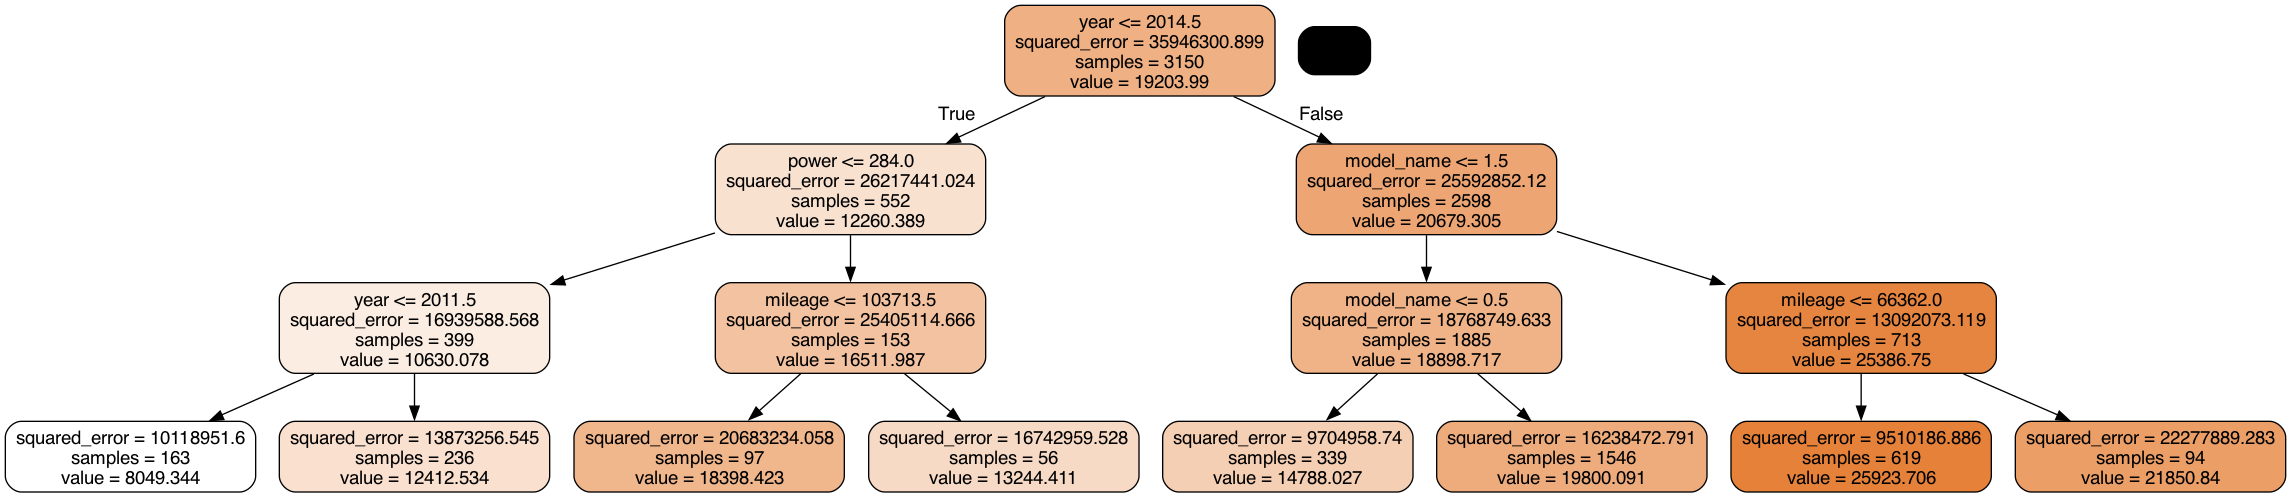

In [78]:
#Libraries for visualizing trees
from sklearn.tree import export_graphviz 
from six import StringIO
from IPython.display import Image  
import pydotplus
import time as tm
#Visualizing the regression tree
dot_data = StringIO()
export_graphviz(base, out_file=dot_data,  
                filled=True, rounded=True,
                feature_names =['model_name', 'mileage', 'power', 'year', 'wheel_system_cat', 'engine_cylinders_V6_Flex_Fuel_Vehicle', 'fleet', 'savings_amount'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('car_price_tree.png')
Image(graph.create_png())

#### Coarse Grid Tuning

In [79]:
model = DecisionTreeRegressor(random_state=4) 
model.fit(X, y)
print("Maximum tree depth =", model.get_depth())
print("Maximum leaves =", model.get_n_leaves())

Maximum tree depth = 32
Maximum leaves = 4485


In [80]:
#Finding cross-validation error for trees 
parameters = {'max_depth':range(2,35, 3),'max_leaf_nodes':range(2,5000, 100)}
cv = KFold(n_splits = 5,shuffle=True,random_state=4)
model = GridSearchCV(DecisionTreeRegressor(random_state=4), parameters, n_jobs=-1,verbose=1,cv=cv,
                    scoring=['neg_mean_squared_error', 'r2'], refit = 'neg_mean_squared_error')
model.fit(X, y)
print (model.best_score_, model.best_params_) 

Fitting 5 folds for each of 550 candidates, totalling 2750 fits
-7826521.035438128 {'max_depth': 17, 'max_leaf_nodes': 202}


From the above cross-validation, the optimal hyperparameter values are max_depth = 17 and max_leaf_nodes = 202.

In [81]:
#Detailed results of k-fold cross validation
cv_results = pd.DataFrame(model.cv_results_)
#cv_results.head()

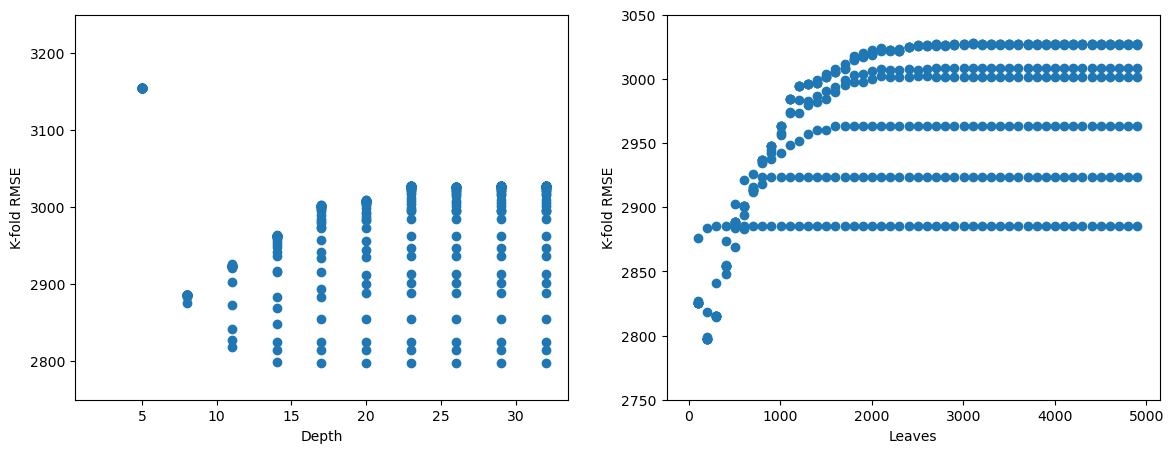

In [90]:
fig, axes = plt.subplots(1,2,figsize=(14,5))
plt.subplots_adjust(wspace=0.2)
axes[0].plot(cv_results.param_max_depth, np.sqrt(-cv_results.mean_test_neg_mean_squared_error), 'o')
axes[0].set_ylim([2750, 3250])
axes[0].set_xlabel('Depth')
axes[0].set_ylabel('K-fold RMSE')
axes[1].plot(cv_results.param_max_leaf_nodes, np.sqrt(-cv_results.mean_test_neg_mean_squared_error), 'o')
axes[1].set_ylim([2750, 3050])
axes[1].set_xlabel('Leaves')
axes[1].set_ylabel('K-fold RMSE');

We observe that for a depth of around 10 to 15, and number of leaves within 1500, we get the lowest 
K-fold RMSE. So, we do a finer search in that region to obtain more precise hyperparameter values.

In [91]:
#Developing the tree based on optimal hyperparameters found by Course Grid 
model = DecisionTreeRegressor(random_state=4, max_depth=17,max_leaf_nodes=202) 
model.fit(X, y)

DecisionTreeRegressor(max_depth=17, max_leaf_nodes=202, random_state=4)

In [92]:
#RMSE on test data for Course Grid
np.sqrt(mean_squared_error(y_test, model.predict(X_test)))

2015.4309168589184

#### Fine Grid Search

In [93]:
#Finding cross-validation error for trees
start_time = tm.time()
parameters = {'max_depth':range(10,15),'max_leaf_nodes':range(2,1500)}
cv = KFold(n_splits = 5,shuffle=True,random_state=4)
model = GridSearchCV(DecisionTreeRegressor(random_state=4), parameters, n_jobs=-1,verbose=1,cv=cv)
model.fit(X, y)
print (model.best_score_, model.best_params_) 
print("Time taken =", round((tm.time() - start_time)/60), "minutes")

Fitting 5 folds for each of 7490 candidates, totalling 37450 fits
0.7816670264731497 {'max_depth': 14, 'max_leaf_nodes': 207}
Time taken = 5 minutes


From the above cross-validation, the optimal hyperparameter values are max_depth = 12 and max_leaf_nodes = 263.

In [94]:
#Developing the tree based on optimal hyperparameters found by cross-validation
model = DecisionTreeRegressor(random_state=4, max_depth=12,max_leaf_nodes=263) 
model.fit(X, y)

DecisionTreeRegressor(max_depth=12, max_leaf_nodes=263, random_state=4)

In [95]:
#RMSE on test data
np.sqrt(mean_squared_error(y_test, model.predict(X_test)))

1824.6096520115836

In [96]:
#Print feature importances
importance = model.feature_importances_
sorted_importance = sorted(zip(X.columns, importance), key=lambda x: x[1], reverse=True)
for feature, importance_score in sorted_importance:
    print(f"{feature}: {importance_score}")

trimId: 0.4106058077165199
model_name: 0.23444143002892884
power: 0.13848818585798275
mileage: 0.08193331733884035
torque: 0.024829492305002268
length: 0.02348296132575457
engine_cylinders_V6: 0.01364058010858318
savings_amount: 0.010188703920559879
wheel_system_display_cat: 0.00830123759146622
wheelbase: 0.00790673698560935
height: 0.007099763435779587
year: 0.006398618064553708
highway_fuel_economy: 0.006128244396103102
fuel_tank_volume: 0.00551453502451502
width: 0.005475139554352632
wheel_system_cat: 0.005376541192469155
engine_displacement: 0.0029274039542386333
city_fuel_economy: 0.0020549496911309918
engine_cylinders_I4: 0.0017771013491055395
body_type_Sedan: 0.0013097177985532003
transmission_display_8_Speed_Automatic: 0.0010917416613759592
owner_count: 0.0007635401896188456
franchise_make: 0.0002642505089562544


Similar to the other models, timID and model_name are the most important predictors.

#### Cost-Complexity Pruning

In [97]:
CCPmodel = DecisionTreeRegressor(random_state = 4)#model without any restrictions
path= CCPmodel.cost_complexity_pruning_path(X,y)# Compute pruning path

In [98]:
alphas=path['ccp_alphas']
len(alphas)

4113

In [99]:
start_time = tm.time()
cv = KFold(n_splits = 5,shuffle=True,random_state=1)
tree = GridSearchCV(DecisionTreeRegressor(random_state=4), param_grid = {'ccp_alpha':alphas}, 
                     scoring = 'neg_mean_squared_error',n_jobs=-1,verbose=1,cv=cv)
tree.fit(X, y)
print (tree.best_score_, tree.best_params_)
print("Time taken =",round((tm.time()-start_time)/60), "minutes")

Fitting 5 folds for each of 4113 candidates, totalling 20565 fits
-7523215.660874766 {'ccp_alpha': 16584.831558986974}
Time taken = 5 minutes


In [100]:
model = DecisionTreeRegressor(ccp_alpha=16584.831558986974,random_state=4)
model.fit(X, y)
pred = model.predict(X_test)
np.sqrt(mean_squared_error(y_test, pred))

2263.3041421882717

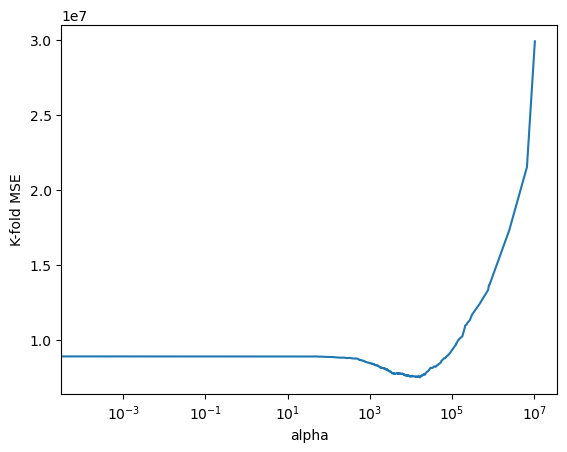

In [101]:
gridcv_results = pd.DataFrame(tree.cv_results_)
cv_error = -gridcv_results['mean_test_score']
#Visualizing the 5-fold cross validation error vs alpha
plt.plot(alphas,cv_error)
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('K-fold MSE');

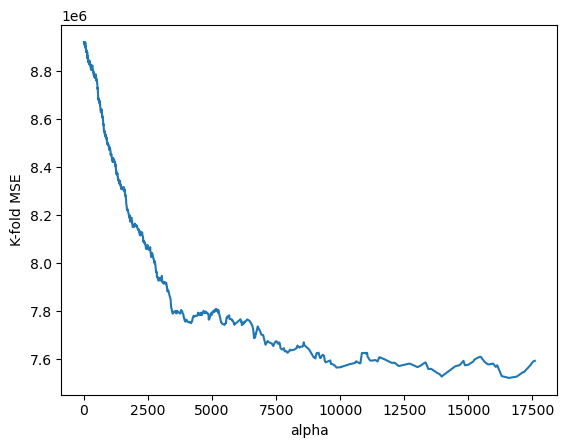

In [103]:
#Zooming in to see the alpha where the 5-fold cross validation error is minimizing
plt.plot(alphas[0:4000],cv_error[0:4000])
plt.xlabel('alpha')
plt.ylabel('K-fold MSE');

In [104]:
stime = tm.time()
trees=[]
for i in alphas:
    tree = DecisionTreeRegressor(ccp_alpha=i,random_state=4)
    tree.fit(X, y)
    trees.append(tree)
print(tm.time()-stime)

353.64823818206787


Text(0.5, 1.0, 'Depth vs alpha')

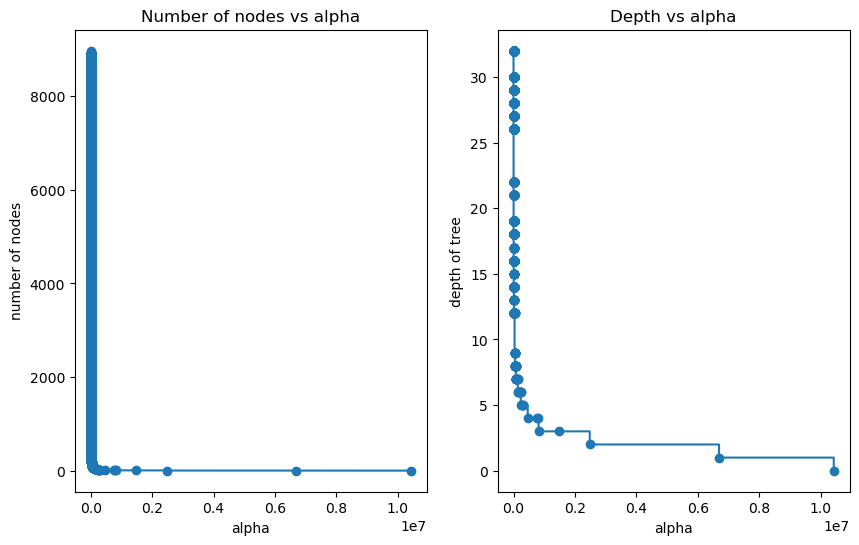

In [105]:
node_counts = [clf.tree_.node_count for clf in trees]
depth = [clf.tree_.max_depth for clf in trees]

fig, ax = plt.subplots(1, 2,figsize=(10,6))
ax[0].plot(alphas[0:5000], node_counts[0:5000], marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(alphas[0:5500], depth[0:5500], marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")

In [110]:
train_scores = [clf.score(X, y) for clf in trees]
test_scores = [clf.score(X_test, y_test) for clf in trees]

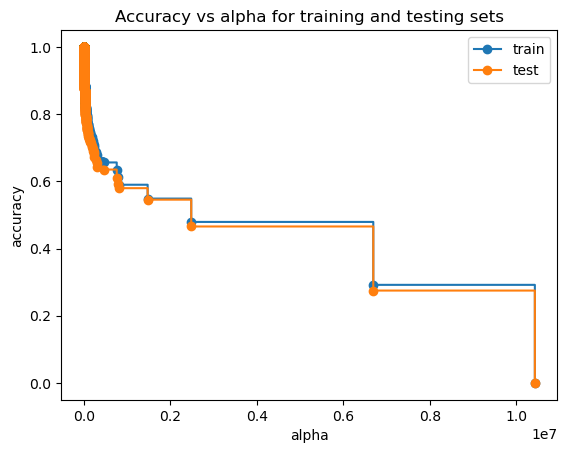

In [107]:
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(alphas[0:5450], train_scores[0:5450], marker="o", label="train", drawstyle="steps-post")#Plotting the zoomed-in plot (ignoring very high alphas), otherwise it is hard to see the trend
ax.plot(alphas[0:5450], test_scores[0:5450], marker="o", label="test", drawstyle="steps-post")#Plotting the zoomed-in plot (ignoring very high alphas), otherwise it is hard to see the trend
ax.legend()
plt.show()

#### Bagging 

In [111]:
#Bagging the results of 1 decision tree (just to see impact in RMSE)
model = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=1, random_state=4,n_jobs=-1).fit(X, y)

In [112]:
np.sqrt(mean_squared_error(y_test, model.predict(X_test)))

2047.0473567756935

In [113]:
#Bagging the results of 10 decision trees
model = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=10, random_state=4,n_jobs=-1).fit(X, y)

In [114]:
np.sqrt(mean_squared_error(y_test, model.predict(X_test)))

1001.1166820326778

In [115]:
#Bagging the results of 100 decision trees
model = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=100, random_state=4,n_jobs=-1).fit(X, y)

In [116]:
np.sqrt(mean_squared_error(y_test, model.predict(X_test)))

807.5798399160442

In [117]:
#Finding model accuracy vs number of trees
oob_rsquared={};test_rsquared={};oob_rmse={};test_rmse = {}
for i in np.linspace(10,400,40,dtype=int):
    model = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=i, random_state=4,
                        n_jobs=-1,oob_score=True).fit(X, y)
    oob_rsquared[i]=model.oob_score_  #Returns the out-of_bag R-squared 
    test_rsquared[i]=model.score(X_test,y_test) #Returns the test R-squared 
    oob_rmse[i]=np.sqrt(mean_squared_error(model.oob_prediction_,y))
    test_rmse[i]=np.sqrt(mean_squared_error(model.predict(X_test),y_test))

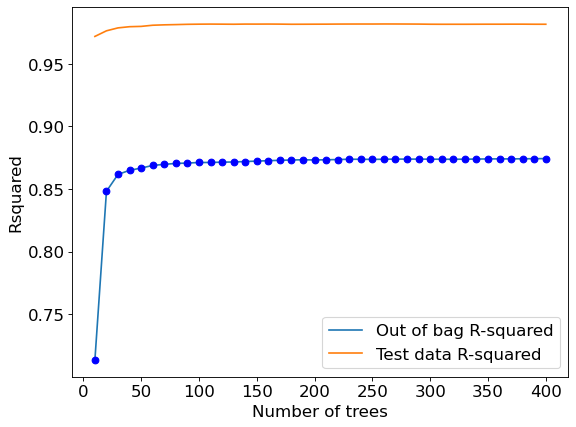

In [118]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(oob_rsquared.keys(),oob_rsquared.values(),label = 'Out of bag R-squared')
plt.plot(oob_rsquared.keys(),oob_rsquared.values(),'o',color = 'blue')
plt.plot(test_rsquared.keys(),test_rsquared.values(), label = 'Test data R-squared')
plt.xlabel('Number of trees')
plt.ylabel('Rsquared')
plt.legend()

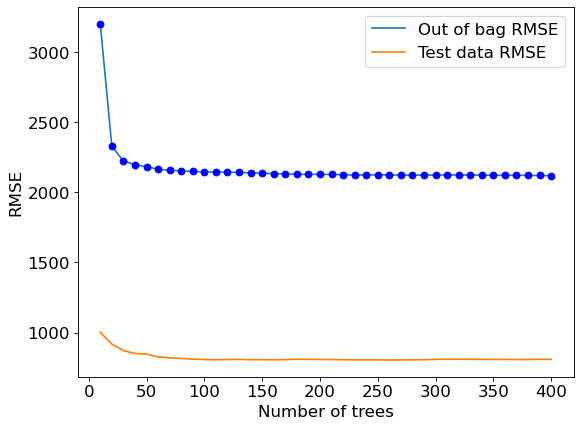

In [119]:
#Visualizing out-of-bag RMSE and test data RMSE
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(oob_rmse.keys(),oob_rmse.values(),label = 'Out of bag RMSE')
plt.plot(oob_rmse.keys(),oob_rmse.values(),'o',color = 'blue')
plt.plot(test_rmse.keys(),test_rmse.values(), label = 'Test data RMSE')
plt.xlabel('Number of trees')
plt.ylabel('RMSE')
plt.legend()

The out-of-bag R-squared initially increases, and then stabilizes after a certain number of trees (around 50 in this case). Similarly, the RMSE follows the same trend. 

In [120]:
#Bagging with 50 trees
model = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=50, random_state=4,
                        oob_score=True,n_jobs=-1).fit(X, y)

In [121]:
model.oob_score_

0.8667866707385805

In [122]:
#RMSE on test data
pred = model.predict(X_test)
np.sqrt(mean_squared_error(y_test, pred))

845.8679476705987

In [123]:
#Optimizing bagging hyperparameters using grid search
n_samples = X_train.shape[0]
n_features = 20

params = {'base_estimator': [DecisionTreeRegressor(random_state = 4),LinearRegression()],
          'n_estimators': [50],
          'max_samples': [0.5,1.0],
          'max_features': [0.5,1.0],
          'bootstrap': [True, False],
          'bootstrap_features': [True, False]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
bagging_regressor_grid = GridSearchCV(BaggingRegressor(random_state=4, n_jobs=-1), 
                                      param_grid =params, cv=cv, n_jobs=-1, verbose=1)
bagging_regressor_grid.fit(X, y)

print('Train R^2 Score : %.3f'%bagging_regressor_grid.best_estimator_.score(X, y))
print('Test R^2 Score : %.3f'%bagging_regressor_grid.best_estimator_.score(X_test, y_test))
print('Best R^2 Score Through Grid Search : %.3f'%bagging_regressor_grid.best_score_)
print('Best Parameters : ',bagging_regressor_grid.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Train R^2 Score : 0.999
Test R^2 Score : 0.999
Best R^2 Score Through Grid Search : 0.876
Best Parameters :  {'base_estimator': DecisionTreeRegressor(random_state=4), 'bootstrap': False, 'bootstrap_features': False, 'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 50}


In [126]:
#Model with optimal hyperparameters 
model = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=50, random_state=4,
                        oob_score=True,n_jobs=-1,bootstrap_features=True,bootstrap=True,
                        max_features=1.0,max_samples=1.0).fit(X, y)

In [127]:
#RMSE on test data
np.sqrt(mean_squared_error(y_test, model.predict(X_test)))

893.4571947679904

Bagging showed to be the best way to reduce RMSE, producing a lower RMSE than all the other decision tree models. 

### Random forest 
*By Hiba Khatib*

**The first set of Random Forests will be performed on the MARS selected features.**

In [81]:
base_rf = RandomForestRegressor(random_state = 4).fit(X_train_mars, y_train_mars)
print("Base RandomForest Test RMSE: ", mean_squared_error(y_test_mars, base_rf.predict(X_test_mars), squared = False))
print("Base RandomForest Train RMSE: ", mean_squared_error(y_train_mars, base_rf.predict(X_train_mars), squared = False))
print("Base RandomForest R^2: ", r2_score(y_test_mars, base_rf.predict(X_test_mars)))

Base RandomForest Test RMSE:  2369.927998736765
Base RandomForest Train RMSE:  936.6562391425674
Base RandomForest R^2:  0.840005202649853


In [82]:
base_rf_feats = pd.DataFrame(zip(base_rf.feature_names_in_, base_rf.feature_importances_)).reset_index()
base_rf_feats.sort_values(by = base_rf_feats.columns[2], ascending = False)

index                                      0         1
3      3                                   year  0.343984
0      0                             model_name  0.242288
2      2                                  power  0.169672
1      1                                mileage  0.147431
7      7                         savings_amount  0.055077
4      4                       wheel_system_cat  0.030605
6      6                                  fleet  0.005677
5      5  engine_cylinders_V6_Flex_Fuel_Vehicle  0.005266

#### Coarse grid search

In [83]:
rf_params = {'n_estimators': [250, 500, 700], 
            'max_depth': [4, 6, 8], 
            'max_leaf_nodes': range(2, 300, 75),
            'bootstrap': [True, False]}

rf_grid = GridSearchCV(RandomForestRegressor(random_state = 4), rf_params, n_jobs = -1, verbose = 1, 
                       scoring = 'neg_root_mean_squared_error')
rf_grid.fit(X_train_mars, y_train_mars)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(estimator=RandomForestRegressor(random_state=4), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [4, 6, 8],
                         'max_leaf_nodes': range(2, 300, 75),
                         'n_estimators': [250, 500, 700]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [84]:
print("Best RandomForest parameters:", rf_grid.best_params_)
print("Best model train RMSE:", mean_squared_error(y_train_mars, rf_grid.predict(X_train_mars), squared = False))
print("Best model test RMSE:", mean_squared_error(y_test_mars, rf_grid.predict(X_test_mars), squared = False))
print("Best model R^2:", r2_score(y_test_mars, rf_grid.predict(X_test_mars)))

Best RandomForest parameters: {'bootstrap': True, 'max_depth': 8, 'max_leaf_nodes': 152, 'n_estimators': 250}
Best model train RMSE: 2115.1675658763616
Best model test RMSE: 2512.4214163945476
Best model R^2: 0.8201872303352222


In [85]:
rf_feats = pd.DataFrame(zip(rf_grid.best_estimator_.feature_names_in_, rf_grid.best_estimator_.feature_importances_)).reset_index()
rf_feats.sort_values(by = rf_feats.columns[2], ascending = False)

index                                      0         1
3      3                                   year  0.381062
0      0                             model_name  0.277125
2      2                                  power  0.157509
1      1                                mileage  0.128131
4      4                       wheel_system_cat  0.028307
7      7                         savings_amount  0.020797
5      5  engine_cylinders_V6_Flex_Fuel_Vehicle  0.004691
6      6                                  fleet  0.002377

In [86]:
rf_results = pd.DataFrame(rf_grid.cv_results_)
rf_results.head(2)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.557264      0.023031         0.025252        0.004624   
1       1.220450      0.056842         0.046306        0.003225   

  param_bootstrap param_max_depth param_max_leaf_nodes param_n_estimators  \
0            True               4                    2                250   
1            True               4                    2                500   

                                              params  split0_test_score  \
0  {'bootstrap': True, 'max_depth': 4, 'max_leaf_...       -4695.255873   
1  {'bootstrap': True, 'max_depth': 4, 'max_leaf_...       -4692.579909   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0       -4812.806394       -4908.589487       -5099.346146       -5320.735759   
1       -4812.292887       -4926.218685       -5100.746773       -5321.148496   

   mean_test_score  std_test_score  rank_test_score  
0     -4967.346732      220.760601               55  
1     -4970.597350      220.974408               58

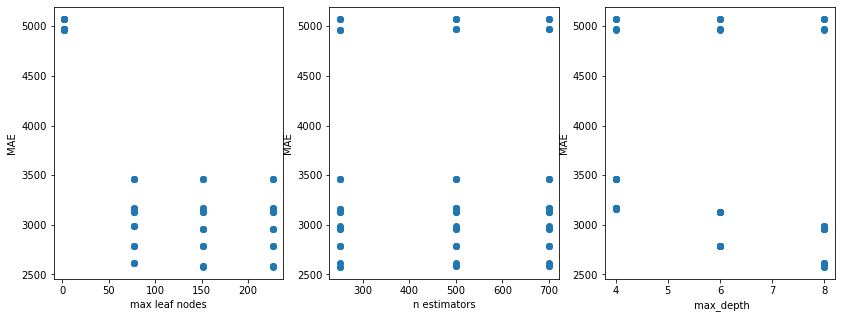

In [90]:
fig, axes = plt.subplots(1,3,figsize=(14,5))
plt.subplots_adjust(wspace=0.2)
axes[0].plot(rf_results.param_max_leaf_nodes, (-rf_results.mean_test_score), 'o')
axes[0].set_xlabel('max leaf nodes')
axes[0].set_ylabel('MAE')
axes[1].plot(rf_results.param_n_estimators,(-rf_results.mean_test_score), 'o')
axes[1].set_xlabel('n estimators')
axes[1].set_ylabel('MAE');
axes[2].plot(rf_results.param_max_depth,(-rf_results.mean_test_score), 'o')
axes[2].set_xlabel(' max_depth')
axes[2].set_ylabel('MAE');

#### Fine Grid Search

In [92]:
rf_params2 = {'n_estimators': [400, 700, 900], 
            'max_depth': [6, 8, 10], 
            'max_leaf_nodes': [250, 300]}

rf_grid2 = GridSearchCV(RandomForestRegressor(random_state = 4, bootstrap = True), rf_params2, n_jobs = -1, verbose = 1, 
                       scoring = 'neg_root_mean_squared_error')
rf_grid2.fit(X_train_mars, y_train_mars)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(estimator=RandomForestRegressor(random_state=4), n_jobs=-1,
             param_grid={'max_depth': [6, 8, 10], 'max_leaf_nodes': [250, 300],
                         'n_estimators': [400, 700, 900]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [93]:
print("Best RandomForest parameters:", rf_grid2.best_params_)
print("Best model train RMSE:", mean_squared_error(y_train_mars, rf_grid2.predict(X_train_mars), squared = False))
print("Best model test RMSE:", mean_squared_error(y_test_mars, rf_grid2.predict(X_test_mars), squared = False))
print("Best model R^2:", r2_score(y_test_mars, rf_grid2.predict(X_test_mars)))
rf_feats2 = pd.DataFrame(zip(rf_grid2.best_estimator_.feature_names_in_, rf_grid2.best_estimator_.feature_importances_)).reset_index()
rf_feats2.sort_values(by = rf_feats2.columns[2], ascending = False)

Best RandomForest parameters: {'max_depth': 10, 'max_leaf_nodes': 300, 'n_estimators': 400}
Best model train RMSE: 1760.3116869136927
Best model test RMSE: 2411.105836013617
Best model R^2: 0.8343970360415414


index                                      0         1
3      3                                   year  0.366251
0      0                             model_name  0.264704
2      2                                  power  0.163420
1      1                                mileage  0.134579
7      7                         savings_amount  0.032096
4      4                       wheel_system_cat  0.029813
5      5  engine_cylinders_V6_Flex_Fuel_Vehicle  0.005402
6      6                                  fleet  0.003734

**Now we will continue with analysis on our selected features**

In [94]:
base_rf = RandomForestRegressor(random_state = 4).fit(X_train, y_train)
print("Base RandomForest Test RMSE: ", mean_squared_error(y_test, base_rf.predict(X_test), squared = False))
print("Base RandomForest Train RMSE: ", mean_squared_error(y_train, base_rf.predict(X_train), squared = False))
print("Base RandomForest R^2: ", r2_score(y_test, base_rf.predict(X_test)))

Base RandomForest Test RMSE:  2320.299016980909
Base RandomForest Train RMSE:  811.3938236091882
Base RandomForest R^2:  0.8494226618329384


In [95]:
base_rf_feats = pd.DataFrame(zip(base_rf.feature_names_in_, base_rf.feature_importances_)).reset_index()
base_rf_feats.sort_values(by = base_rf_feats.columns[2], ascending = False)

index                                       0         1
13     13                                  trimId  0.367903
8       8                              model_name  0.206468
10     10                                   power  0.117995
7       7                                 mileage  0.109063
12     12                                  torque  0.028295
16     16                                    year  0.025966
11     11                          savings_amount  0.024256
4       4                                  height  0.015664
6       6                                  length  0.013655
5       5                    highway_fuel_economy  0.011459
3       3                        fuel_tank_volume  0.011209
15     15                                   width  0.011103
21     21                     engine_cylinders_V6  0.010807
14     14                               wheelbase  0.008779
18     18                wheel_system_display_cat  0.008285
17     17                        wheel_system_cat  0.006988
0       0                       city_fuel_economy  0.006192
1       1                     engine_displacement  0.005792
2       2                          franchise_make  0.004500
9       9                             owner_count  0.003003
22     22  transmission_display_8_Speed_Automatic  0.001193
19     19                         body_type_Sedan  0.000981
20     20                     engine_cylinders_I4  0.000442

In [ ]:
#### Coarse GridSearch

In [96]:
rf_params = {'n_estimators': [250, 500, 700], 
            'max_depth': [4, 6, 8], 
            'max_leaf_nodes': range(2, 300, 75),
            'bootstrap': [True, False]}

rf_grid = GridSearchCV(RandomForestRegressor(random_state = 4), rf_params, n_jobs = -1, verbose = 1, 
                       scoring = 'neg_root_mean_squared_error')
rf_grid.fit(X_train, y_train)

print("Best RandomForest parameters:", rf_grid.best_params_)
print("Best model train RMSE:", mean_squared_error(y_train, rf_grid.predict(X_train), squared = False))
print("Best model test RMSE:", mean_squared_error(y_test, rf_grid.predict(X_test), squared = False))
print("Best model R^2:", r2_score(y_test, rf_grid.predict(X_test)))

rf_feats = pd.DataFrame(zip(rf_grid.best_estimator_.feature_names_in_, rf_grid.best_estimator_.feature_importances_)).reset_index()
rf_feats.sort_values(by = rf_feats.columns[2], ascending = False)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best RandomForest parameters: {'bootstrap': True, 'max_depth': 8, 'max_leaf_nodes': 227, 'n_estimators': 700}
Best model train RMSE: 1798.8381156882924
Best model test RMSE: 2515.1964258302187
Best model R^2: 0.8230642798700507


index                                       0         1
13     13                                  trimId  0.397924
8       8                              model_name  0.227093
10     10                                   power  0.122868
7       7                                 mileage  0.102456
12     12                                  torque  0.028858
16     16                                    year  0.022507
4       4                                  height  0.011860
21     21                     engine_cylinders_V6  0.010883
6       6                                  length  0.010647
11     11                          savings_amount  0.008886
5       5                    highway_fuel_economy  0.008685
15     15                                   width  0.008171
3       3                        fuel_tank_volume  0.007906
17     17                        wheel_system_cat  0.007112
18     18                wheel_system_display_cat  0.007047
14     14                               wheelbase  0.006170
1       1                     engine_displacement  0.003463
0       0                       city_fuel_economy  0.003062
9       9                             owner_count  0.001666
2       2                          franchise_make  0.001565
22     22  transmission_display_8_Speed_Automatic  0.000580
19     19                         body_type_Sedan  0.000419
20     20                     engine_cylinders_I4  0.000169

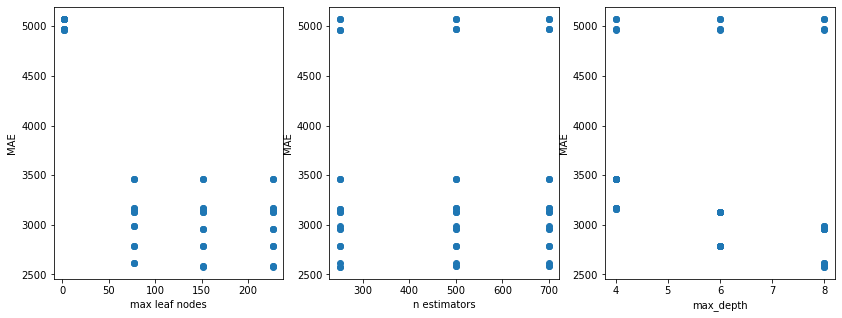

In [97]:
fig, axes = plt.subplots(1,3,figsize=(14,5))
plt.subplots_adjust(wspace=0.2)
axes[0].plot(rf_results.param_max_leaf_nodes, (-rf_results.mean_test_score), 'o')
axes[0].set_xlabel('max leaf nodes')
axes[0].set_ylabel('MAE')
axes[1].plot(rf_results.param_n_estimators,(-rf_results.mean_test_score), 'o')
axes[1].set_xlabel('n estimators')
axes[1].set_ylabel('MAE');
axes[2].plot(rf_results.param_max_depth,(-rf_results.mean_test_score), 'o')
axes[2].set_xlabel('max_depth')
axes[2].set_ylabel('MAE');

In [ ]:
#### fine grid search

In [98]:
rf_params2 = {'n_estimators': [500, 700, 900], 
            'max_depth': [6, 8, 10], 
            'max_leaf_nodes': range(250, 350, 15)}

rf_grid2 = GridSearchCV(RandomForestRegressor(random_state = 4, bootstrap = True), rf_params2, n_jobs = -1, verbose = 1, 
                       scoring = 'neg_root_mean_squared_error')
rf_grid2.fit(X_train, y_train)

print("Best RandomForest parameters:", rf_grid2.best_params_)
print("Best model train RMSE:", mean_squared_error(y_train, rf_grid2.predict(X_train), squared = False))
print("Best model test RMSE:", mean_squared_error(y_test, rf_grid2.predict(X_test), squared = False))
print("Best model R^2:", r2_score(y_test, rf_grid2.predict(X_test)))
rf_feats2 = pd.DataFrame(zip(rf_grid2.best_estimator_.feature_names_in_, rf_grid2.best_estimator_.feature_importances_)).reset_index()
rf_feats2.sort_values(by = rf_feats2.columns[2], ascending = False)

Fitting 5 folds for each of 63 candidates, totalling 315 fits
Best RandomForest parameters: {'max_depth': 10, 'max_leaf_nodes': 340, 'n_estimators': 500}
Best model train RMSE: 1424.986609472238
Best model test RMSE: 2385.598110495618
Best model R^2: 0.8408281485903418


index                                       0         1
13     13                                  trimId  0.384392
8       8                              model_name  0.216342
10     10                                   power  0.119587
7       7                                 mileage  0.105961
12     12                                  torque  0.030705
16     16                                    year  0.022599
4       4                                  height  0.014340
11     11                          savings_amount  0.014279
6       6                                  length  0.012538
21     21                     engine_cylinders_V6  0.010676
15     15                                   width  0.010466
5       5                    highway_fuel_economy  0.009993
3       3                        fuel_tank_volume  0.009782
14     14                               wheelbase  0.007699
18     18                wheel_system_display_cat  0.007544
17     17                        wheel_system_cat  0.007222
1       1                     engine_displacement  0.004716
0       0                       city_fuel_economy  0.004385
2       2                          franchise_make  0.002616
9       9                             owner_count  0.002076
22     22  transmission_display_8_Speed_Automatic  0.001105
19     19                         body_type_Sedan  0.000651
20     20                     engine_cylinders_I4  0.000327

The best RMSE and R^2 resulted from the fine random forest grid search using our feature selection. This is because our feature selection was done using random forest. 

Our best random forest RMSE and R2 are 2385.598110495618 and 0.8408281485903418 respectively. 

### CatBoost
*By YuYan Zhang*

In [99]:
import catboost as cb
from catboost import CatBoostRegressor

In [100]:
train_pool = cb.Pool(X_train,y_train)
test_pool = cb.Pool(X_test,y_test)

In [101]:
cb1 = CatBoostRegressor(loss_function='RMSE')

In [102]:
cb1.fit(train_pool)

Learning rate set to 0.049132
0:	learn: 5794.2995392	total: 142ms	remaining: 2m 21s
1:	learn: 5634.2358373	total: 144ms	remaining: 1m 11s
2:	learn: 5473.4473085	total: 147ms	remaining: 48.7s
3:	learn: 5312.7684693	total: 149ms	remaining: 37.2s
4:	learn: 5168.2185213	total: 154ms	remaining: 30.6s
5:	learn: 5029.6671764	total: 156ms	remaining: 25.8s
6:	learn: 4893.4081625	total: 159ms	remaining: 22.5s
7:	learn: 4754.9994771	total: 161ms	remaining: 20s
8:	learn: 4641.6825970	total: 164ms	remaining: 18s
9:	learn: 4526.6625366	total: 166ms	remaining: 16.4s
10:	learn: 4417.1758224	total: 169ms	remaining: 15.2s
11:	learn: 4304.0831966	total: 171ms	remaining: 14.1s
12:	learn: 4202.2979127	total: 174ms	remaining: 13.2s
13:	learn: 4110.8520094	total: 176ms	remaining: 12.4s
14:	learn: 4018.4681610	total: 179ms	remaining: 11.7s
15:	learn: 3931.3348745	total: 182ms	remaining: 11.2s
16:	learn: 3849.6850909	total: 184ms	remaining: 10.7s
17:	learn: 3771.0317986	total: 186ms	remaining: 10.2s
18:	learn:

161:	learn: 1995.8183526	total: 517ms	remaining: 2.67s
162:	learn: 1994.3221258	total: 519ms	remaining: 2.67s
163:	learn: 1992.5536936	total: 521ms	remaining: 2.66s
164:	learn: 1988.0886100	total: 524ms	remaining: 2.65s
165:	learn: 1986.6838899	total: 526ms	remaining: 2.64s
166:	learn: 1983.6375758	total: 528ms	remaining: 2.63s
167:	learn: 1981.0076760	total: 531ms	remaining: 2.63s
168:	learn: 1979.3237526	total: 533ms	remaining: 2.62s
169:	learn: 1977.5165404	total: 536ms	remaining: 2.62s
170:	learn: 1975.9127005	total: 538ms	remaining: 2.61s
171:	learn: 1972.7770399	total: 540ms	remaining: 2.6s
172:	learn: 1970.7722451	total: 543ms	remaining: 2.6s
173:	learn: 1967.8069075	total: 546ms	remaining: 2.59s
174:	learn: 1965.2306808	total: 549ms	remaining: 2.59s
175:	learn: 1962.9713152	total: 551ms	remaining: 2.58s
176:	learn: 1961.4802725	total: 554ms	remaining: 2.57s
177:	learn: 1959.4931957	total: 556ms	remaining: 2.57s
178:	learn: 1956.8888724	total: 558ms	remaining: 2.56s
179:	learn: 

376:	learn: 1637.9575771	total: 1.05s	remaining: 1.74s
377:	learn: 1637.1766690	total: 1.06s	remaining: 1.74s
378:	learn: 1636.2441114	total: 1.06s	remaining: 1.74s
379:	learn: 1634.7969183	total: 1.06s	remaining: 1.73s
380:	learn: 1633.8929962	total: 1.06s	remaining: 1.73s
381:	learn: 1632.8251519	total: 1.07s	remaining: 1.73s
382:	learn: 1631.5569680	total: 1.07s	remaining: 1.72s
383:	learn: 1630.3335402	total: 1.07s	remaining: 1.72s
384:	learn: 1629.3546548	total: 1.08s	remaining: 1.72s
385:	learn: 1628.7232221	total: 1.08s	remaining: 1.72s
386:	learn: 1627.7645046	total: 1.08s	remaining: 1.72s
387:	learn: 1626.6153358	total: 1.09s	remaining: 1.71s
388:	learn: 1625.0764049	total: 1.09s	remaining: 1.71s
389:	learn: 1624.1225747	total: 1.09s	remaining: 1.71s
390:	learn: 1622.5777068	total: 1.09s	remaining: 1.71s
391:	learn: 1621.0897215	total: 1.1s	remaining: 1.7s
392:	learn: 1621.0537742	total: 1.1s	remaining: 1.7s
393:	learn: 1619.8131229	total: 1.1s	remaining: 1.7s
394:	learn: 1618

603:	learn: 1437.2732758	total: 1.58s	remaining: 1.03s
604:	learn: 1436.1837720	total: 1.58s	remaining: 1.03s
605:	learn: 1435.4681866	total: 1.58s	remaining: 1.03s
606:	learn: 1434.5865095	total: 1.59s	remaining: 1.03s
607:	learn: 1433.7912027	total: 1.59s	remaining: 1.02s
608:	learn: 1433.2990788	total: 1.59s	remaining: 1.02s
609:	learn: 1432.2347657	total: 1.59s	remaining: 1.02s
610:	learn: 1431.5109872	total: 1.6s	remaining: 1.02s
611:	learn: 1430.1850727	total: 1.6s	remaining: 1.01s
612:	learn: 1429.9620238	total: 1.6s	remaining: 1.01s
613:	learn: 1428.7816657	total: 1.61s	remaining: 1.01s
614:	learn: 1428.1818203	total: 1.61s	remaining: 1.01s
615:	learn: 1427.6772681	total: 1.61s	remaining: 1s
616:	learn: 1426.4763375	total: 1.61s	remaining: 1s
617:	learn: 1425.6487579	total: 1.62s	remaining: 1s
618:	learn: 1424.8008740	total: 1.62s	remaining: 997ms
619:	learn: 1423.8869519	total: 1.62s	remaining: 995ms
620:	learn: 1423.1434737	total: 1.63s	remaining: 992ms
621:	learn: 1421.87219

753:	learn: 1330.5195343	total: 1.93s	remaining: 629ms
754:	learn: 1329.7963101	total: 1.93s	remaining: 627ms
755:	learn: 1328.6670808	total: 1.94s	remaining: 625ms
756:	learn: 1327.8175539	total: 1.94s	remaining: 622ms
757:	learn: 1327.2043842	total: 1.94s	remaining: 620ms
758:	learn: 1326.9386742	total: 1.94s	remaining: 617ms
759:	learn: 1326.1360033	total: 1.95s	remaining: 615ms
760:	learn: 1325.4303245	total: 1.95s	remaining: 612ms
761:	learn: 1324.6327084	total: 1.95s	remaining: 609ms
762:	learn: 1323.6721148	total: 1.95s	remaining: 607ms
763:	learn: 1323.4360005	total: 1.96s	remaining: 604ms
764:	learn: 1323.2062115	total: 1.96s	remaining: 602ms
765:	learn: 1322.7097194	total: 1.96s	remaining: 599ms
766:	learn: 1321.9626101	total: 1.96s	remaining: 597ms
767:	learn: 1321.1380798	total: 1.97s	remaining: 594ms
768:	learn: 1320.6930711	total: 1.97s	remaining: 592ms
769:	learn: 1320.2250626	total: 1.97s	remaining: 589ms
770:	learn: 1319.5889349	total: 1.97s	remaining: 586ms
771:	learn

989:	learn: 1204.1800908	total: 2.46s	remaining: 24.8ms
990:	learn: 1203.8344775	total: 2.46s	remaining: 22.3ms
991:	learn: 1202.9936151	total: 2.46s	remaining: 19.8ms
992:	learn: 1202.8050472	total: 2.46s	remaining: 17.4ms
993:	learn: 1202.4007784	total: 2.46s	remaining: 14.9ms
994:	learn: 1201.9541370	total: 2.47s	remaining: 12.4ms
995:	learn: 1201.5256620	total: 2.47s	remaining: 9.91ms
996:	learn: 1201.2666584	total: 2.47s	remaining: 7.44ms
997:	learn: 1201.1516485	total: 2.47s	remaining: 4.96ms
998:	learn: 1200.6470154	total: 2.48s	remaining: 2.48ms
999:	learn: 1199.8271873	total: 2.48s	remaining: 0us


In [103]:
# train
print("Train RMSE:", mean_squared_error(y_train, cb1.predict(train_pool), squared = False))
print("Train R-squared:",r2_score(y_train, cb1.predict(train_pool)))

Train RMSE: 1199.8271873207266
Train R-squared: 0.9597114208072007


In [104]:
# test
print("Test RMSE:", mean_squared_error(y_test, cb1.predict(test_pool), squared = False))
print("Test R-squared:",r2_score(y_test, cb1.predict(test_pool)))

Test RMSE: 2055.989006548227
Test R-squared: 0.8817739227682351


Text(0.5, 1.0, 'Feature Importance')

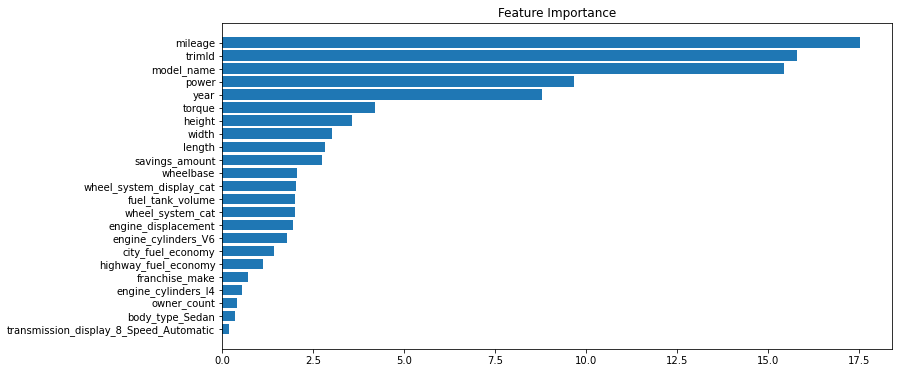

In [105]:
feature_importance = cb1.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [106]:
cb2 = CatBoostRegressor()

cb_params = {'learning_rate':[0.01, 0.1],
         'depth': [4, 7, 10],
         'l2_leaf_reg': [2, 6, 10],
         'random_strength': [0, 5, 10]
}

cb_search_result = cb2.grid_search(cb_params, 
                                       X=X_train, 
                                       y=y_train, 
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 19882.0029024	test: 20107.0949605	best: 20107.0949605 (0)	total: 2.52ms	remaining: 2.52s
1:	learn: 19690.8791401	test: 19913.0767239	best: 19913.0767239 (1)	total: 4.03ms	remaining: 2.01s
2:	learn: 19501.7542462	test: 19721.4690787	best: 19721.4690787 (2)	total: 5.34ms	remaining: 1.78s
3:	learn: 19314.6325177	test: 19532.1548524	best: 19532.1548524 (3)	total: 6.72ms	remaining: 1.67s
4:	learn: 19129.5073295	test: 19345.0074351	best: 19345.0074351 (4)	total: 8.13ms	remaining: 1.62s
5:	learn: 18946.2645376	test: 19159.6259990	best: 19159.6259990 (5)	total: 9.47ms	remaining: 1.57s
6:	learn: 18765.3751251	test: 18976.5344240	best: 18976.5344240 (6)	total: 10.8ms	remaining: 1.53s
7:	learn: 18585.4296007	test: 18794.8044214	best: 18794.8044214 (7)	total: 12ms	remaining: 1.49s
8:	learn: 18407.7852353	test: 18615.6233101	best: 18615.6233101 (8)	total: 13.4ms	remaining: 1.47s
9:	learn: 18231.4234104	test: 18438.3582421	best: 18438.3582421 (9)	total: 14.9ms	remaining: 1.47s
10:	learn: 1

132:	learn: 6077.3107052	test: 6205.6491716	best: 6205.6491716 (132)	total: 179ms	remaining: 1.17s
133:	learn: 6030.0937194	test: 6158.0692237	best: 6158.0692237 (133)	total: 181ms	remaining: 1.17s
134:	learn: 5983.7185649	test: 6111.8082637	best: 6111.8082637 (134)	total: 182ms	remaining: 1.17s
135:	learn: 5938.0200864	test: 6067.0214308	best: 6067.0214308 (135)	total: 184ms	remaining: 1.17s
136:	learn: 5892.1801556	test: 6021.0529509	best: 6021.0529509 (136)	total: 185ms	remaining: 1.17s
137:	learn: 5847.1633258	test: 5976.5663701	best: 5976.5663701 (137)	total: 187ms	remaining: 1.16s
138:	learn: 5803.0649489	test: 5932.7582112	best: 5932.7582112 (138)	total: 188ms	remaining: 1.16s
139:	learn: 5759.5970062	test: 5889.2037953	best: 5889.2037953 (139)	total: 189ms	remaining: 1.16s
140:	learn: 5716.1478511	test: 5845.6981824	best: 5845.6981824 (140)	total: 191ms	remaining: 1.16s
141:	learn: 5672.9506506	test: 5802.4933397	best: 5802.4933397 (141)	total: 192ms	remaining: 1.16s
142:	learn

247:	learn: 3146.8213641	test: 3316.9554540	best: 3316.9554540 (247)	total: 354ms	remaining: 1.07s
248:	learn: 3136.0292366	test: 3306.9864881	best: 3306.9864881 (248)	total: 355ms	remaining: 1.07s
249:	learn: 3125.5917777	test: 3296.7482415	best: 3296.7482415 (249)	total: 357ms	remaining: 1.07s
250:	learn: 3114.9458883	test: 3286.6063760	best: 3286.6063760 (250)	total: 359ms	remaining: 1.07s
251:	learn: 3104.6480277	test: 3277.1824979	best: 3277.1824979 (251)	total: 360ms	remaining: 1.07s
252:	learn: 3094.2831209	test: 3266.3484533	best: 3266.3484533 (252)	total: 362ms	remaining: 1.07s
253:	learn: 3084.1608911	test: 3255.9010873	best: 3255.9010873 (253)	total: 363ms	remaining: 1.06s
254:	learn: 3074.0400287	test: 3245.9668519	best: 3245.9668519 (254)	total: 365ms	remaining: 1.06s
255:	learn: 3064.2410449	test: 3236.7927473	best: 3236.7927473 (255)	total: 366ms	remaining: 1.06s
256:	learn: 3054.4918824	test: 3227.6545306	best: 3227.6545306 (256)	total: 367ms	remaining: 1.06s
257:	learn

369:	learn: 2488.7383927	test: 2695.5814194	best: 2695.5814194 (369)	total: 528ms	remaining: 899ms
370:	learn: 2486.2525306	test: 2693.3002809	best: 2693.3002809 (370)	total: 529ms	remaining: 898ms
371:	learn: 2484.0338793	test: 2691.0772389	best: 2691.0772389 (371)	total: 531ms	remaining: 896ms
372:	learn: 2481.8661780	test: 2688.4815116	best: 2688.4815116 (372)	total: 532ms	remaining: 894ms
373:	learn: 2479.4444588	test: 2686.3254148	best: 2686.3254148 (373)	total: 533ms	remaining: 892ms
374:	learn: 2477.2887652	test: 2683.7137877	best: 2683.7137877 (374)	total: 535ms	remaining: 891ms
375:	learn: 2475.0348637	test: 2681.5440975	best: 2681.5440975 (375)	total: 536ms	remaining: 890ms
376:	learn: 2472.8418791	test: 2679.2618169	best: 2679.2618169 (376)	total: 538ms	remaining: 888ms
377:	learn: 2470.8892739	test: 2677.0952741	best: 2677.0952741 (377)	total: 539ms	remaining: 886ms
378:	learn: 2468.7738174	test: 2675.4611410	best: 2675.4611410 (378)	total: 540ms	remaining: 885ms
379:	learn

511:	learn: 2290.7664946	test: 2512.9155911	best: 2512.9155911 (511)	total: 703ms	remaining: 670ms
512:	learn: 2290.1215458	test: 2512.2650159	best: 2512.2650159 (512)	total: 704ms	remaining: 668ms
513:	learn: 2289.4311987	test: 2511.2329333	best: 2511.2329333 (513)	total: 705ms	remaining: 666ms
514:	learn: 2288.8021690	test: 2510.8625491	best: 2510.8625491 (514)	total: 706ms	remaining: 665ms
515:	learn: 2287.9709910	test: 2510.1668537	best: 2510.1668537 (515)	total: 708ms	remaining: 664ms
516:	learn: 2287.3042330	test: 2509.5955536	best: 2509.5955536 (516)	total: 709ms	remaining: 662ms
517:	learn: 2286.7305094	test: 2509.1891711	best: 2509.1891711 (517)	total: 710ms	remaining: 660ms
518:	learn: 2285.6939172	test: 2508.4083840	best: 2508.4083840 (518)	total: 711ms	remaining: 659ms
519:	learn: 2284.9498217	test: 2507.8189409	best: 2507.8189409 (519)	total: 712ms	remaining: 657ms
520:	learn: 2284.3045892	test: 2507.0685110	best: 2507.0685110 (520)	total: 713ms	remaining: 656ms
521:	learn

639:	learn: 2199.1417886	test: 2430.0684622	best: 2430.0684622 (639)	total: 877ms	remaining: 493ms
640:	learn: 2198.4844548	test: 2429.5435454	best: 2429.5435454 (640)	total: 878ms	remaining: 492ms
641:	learn: 2197.9979678	test: 2429.0092991	best: 2429.0092991 (641)	total: 879ms	remaining: 490ms
642:	learn: 2197.4995565	test: 2428.1982216	best: 2428.1982216 (642)	total: 880ms	remaining: 489ms
643:	learn: 2196.9224866	test: 2427.9350562	best: 2427.9350562 (643)	total: 881ms	remaining: 487ms
644:	learn: 2196.4292335	test: 2427.6002408	best: 2427.6002408 (644)	total: 883ms	remaining: 486ms
645:	learn: 2195.7371873	test: 2426.9766656	best: 2426.9766656 (645)	total: 884ms	remaining: 484ms
646:	learn: 2195.3478763	test: 2426.5112542	best: 2426.5112542 (646)	total: 885ms	remaining: 483ms
647:	learn: 2194.7271768	test: 2426.1150704	best: 2426.1150704 (647)	total: 886ms	remaining: 481ms
648:	learn: 2194.4229265	test: 2425.7741440	best: 2425.7741440 (648)	total: 887ms	remaining: 480ms
649:	learn

792:	learn: 2120.3318703	test: 2361.1037188	best: 2361.1037188 (792)	total: 1.05s	remaining: 274ms
793:	learn: 2120.1050882	test: 2360.9600060	best: 2360.9600060 (793)	total: 1.05s	remaining: 273ms
794:	learn: 2119.8755139	test: 2360.6811461	best: 2360.6811461 (794)	total: 1.05s	remaining: 271ms
795:	learn: 2119.4218272	test: 2360.2640901	best: 2360.2640901 (795)	total: 1.05s	remaining: 270ms
796:	learn: 2118.6498661	test: 2359.6057463	best: 2359.6057463 (796)	total: 1.05s	remaining: 269ms
797:	learn: 2118.0916063	test: 2359.3852419	best: 2359.3852419 (797)	total: 1.06s	remaining: 267ms
798:	learn: 2117.4583970	test: 2358.5496588	best: 2358.5496588 (798)	total: 1.06s	remaining: 266ms
799:	learn: 2117.1110427	test: 2357.9661304	best: 2357.9661304 (799)	total: 1.06s	remaining: 265ms
800:	learn: 2116.6507495	test: 2357.6123070	best: 2357.6123070 (800)	total: 1.06s	remaining: 263ms
801:	learn: 2116.1682934	test: 2357.4122663	best: 2357.4122663 (801)	total: 1.06s	remaining: 262ms
802:	learn

954:	learn: 2050.8762947	test: 2303.9578255	best: 2303.9578255 (954)	total: 1.23s	remaining: 57.8ms
955:	learn: 2050.6261263	test: 2303.8809219	best: 2303.8809219 (955)	total: 1.23s	remaining: 56.5ms
956:	learn: 2050.3524035	test: 2303.6391891	best: 2303.6391891 (956)	total: 1.23s	remaining: 55.2ms
957:	learn: 2049.9961196	test: 2303.5486661	best: 2303.5486661 (957)	total: 1.23s	remaining: 53.9ms
958:	learn: 2049.6920379	test: 2303.3328758	best: 2303.3328758 (958)	total: 1.23s	remaining: 52.6ms
959:	learn: 2048.9027380	test: 2302.8583701	best: 2302.8583701 (959)	total: 1.23s	remaining: 51.4ms
960:	learn: 2048.6853274	test: 2302.5468152	best: 2302.5468152 (960)	total: 1.23s	remaining: 50.1ms
961:	learn: 2048.2435565	test: 2302.2507400	best: 2302.2507400 (961)	total: 1.23s	remaining: 48.8ms
962:	learn: 2047.8595597	test: 2302.0701173	best: 2302.0701173 (962)	total: 1.24s	remaining: 47.5ms
963:	learn: 2047.6588592	test: 2301.7183107	best: 2301.7183107 (963)	total: 1.24s	remaining: 46.2ms


96:	learn: 2052.6750922	test: 2298.3799579	best: 2298.3799579 (96)	total: 118ms	remaining: 1.1s
97:	learn: 2047.7202635	test: 2293.2414167	best: 2293.2414167 (97)	total: 119ms	remaining: 1.1s
98:	learn: 2046.2347451	test: 2292.4979992	best: 2292.4979992 (98)	total: 121ms	remaining: 1.1s
99:	learn: 2041.3994448	test: 2287.0294171	best: 2287.0294171 (99)	total: 122ms	remaining: 1.09s
100:	learn: 2036.6548723	test: 2283.0341147	best: 2283.0341147 (100)	total: 123ms	remaining: 1.1s
101:	learn: 2035.2396261	test: 2282.8708435	best: 2282.8708435 (101)	total: 125ms	remaining: 1.1s
102:	learn: 2032.9067801	test: 2281.7254748	best: 2281.7254748 (102)	total: 126ms	remaining: 1.09s
103:	learn: 2031.3238049	test: 2280.0474262	best: 2280.0474262 (103)	total: 127ms	remaining: 1.09s
104:	learn: 2028.3849746	test: 2276.8427630	best: 2276.8427630 (104)	total: 128ms	remaining: 1.09s
105:	learn: 2025.3040235	test: 2273.8496483	best: 2273.8496483 (105)	total: 129ms	remaining: 1.09s
106:	learn: 2023.918814

243:	learn: 1717.5672622	test: 2099.0291656	best: 2099.0291656 (243)	total: 295ms	remaining: 913ms
244:	learn: 1715.6773832	test: 2097.9700833	best: 2097.9700833 (244)	total: 296ms	remaining: 912ms
245:	learn: 1715.0067512	test: 2098.0427348	best: 2097.9700833 (244)	total: 297ms	remaining: 910ms
246:	learn: 1712.1923313	test: 2096.3435935	best: 2096.3435935 (246)	total: 298ms	remaining: 908ms
247:	learn: 1710.8213828	test: 2095.9481003	best: 2095.9481003 (247)	total: 299ms	remaining: 907ms
248:	learn: 1709.0525823	test: 2094.6891701	best: 2094.6891701 (248)	total: 300ms	remaining: 905ms
249:	learn: 1706.3137982	test: 2093.6027083	best: 2093.6027083 (249)	total: 301ms	remaining: 904ms
250:	learn: 1705.3592542	test: 2092.8914467	best: 2092.8914467 (250)	total: 303ms	remaining: 905ms
251:	learn: 1703.8128412	test: 2093.4429729	best: 2092.8914467 (250)	total: 305ms	remaining: 904ms
252:	learn: 1702.6906126	test: 2094.6441062	best: 2092.8914467 (250)	total: 306ms	remaining: 904ms
253:	learn

394:	learn: 1524.4861388	test: 2046.3994534	best: 2045.8967752 (390)	total: 472ms	remaining: 723ms
395:	learn: 1522.4872852	test: 2046.2887274	best: 2045.8967752 (390)	total: 473ms	remaining: 722ms
396:	learn: 1521.5027896	test: 2047.2256984	best: 2045.8967752 (390)	total: 475ms	remaining: 721ms
397:	learn: 1520.9631300	test: 2047.0721125	best: 2045.8967752 (390)	total: 476ms	remaining: 720ms
398:	learn: 1519.6032192	test: 2045.6166063	best: 2045.6166063 (398)	total: 477ms	remaining: 718ms
399:	learn: 1518.3629657	test: 2046.4990196	best: 2045.6166063 (398)	total: 478ms	remaining: 718ms
400:	learn: 1517.2774598	test: 2046.7889653	best: 2045.6166063 (398)	total: 480ms	remaining: 716ms
401:	learn: 1516.6121199	test: 2046.5813367	best: 2045.6166063 (398)	total: 481ms	remaining: 715ms
402:	learn: 1515.7919032	test: 2046.4126223	best: 2045.6166063 (398)	total: 482ms	remaining: 713ms
403:	learn: 1514.6636841	test: 2046.6387717	best: 2045.6166063 (398)	total: 483ms	remaining: 713ms
404:	learn

530:	learn: 1407.1707260	test: 2036.5704319	best: 2035.6632761 (504)	total: 648ms	remaining: 572ms
531:	learn: 1406.6003839	test: 2035.9401273	best: 2035.6632761 (504)	total: 650ms	remaining: 571ms
532:	learn: 1405.5029974	test: 2036.8579573	best: 2035.6632761 (504)	total: 651ms	remaining: 570ms
533:	learn: 1404.8977997	test: 2037.1734311	best: 2035.6632761 (504)	total: 652ms	remaining: 569ms
534:	learn: 1404.4416579	test: 2037.3220816	best: 2035.6632761 (504)	total: 653ms	remaining: 568ms
535:	learn: 1403.5736962	test: 2037.1745257	best: 2035.6632761 (504)	total: 654ms	remaining: 566ms
536:	learn: 1402.7537935	test: 2037.4141477	best: 2035.6632761 (504)	total: 655ms	remaining: 565ms
537:	learn: 1402.1179101	test: 2037.5335713	best: 2035.6632761 (504)	total: 657ms	remaining: 564ms
538:	learn: 1401.1874228	test: 2037.0497040	best: 2035.6632761 (504)	total: 658ms	remaining: 563ms
539:	learn: 1400.3643520	test: 2035.8119306	best: 2035.6632761 (504)	total: 659ms	remaining: 561ms
540:	learn

670:	learn: 1311.0636730	test: 2035.0073864	best: 2033.7519807 (580)	total: 823ms	remaining: 403ms
671:	learn: 1310.2679237	test: 2035.2710409	best: 2033.7519807 (580)	total: 824ms	remaining: 402ms
672:	learn: 1309.3626434	test: 2033.7233335	best: 2033.7233335 (672)	total: 825ms	remaining: 401ms
673:	learn: 1308.9081594	test: 2033.3465302	best: 2033.3465302 (673)	total: 827ms	remaining: 400ms
674:	learn: 1308.5251722	test: 2033.3474118	best: 2033.3465302 (673)	total: 828ms	remaining: 399ms
675:	learn: 1307.8013231	test: 2033.0228899	best: 2033.0228899 (675)	total: 829ms	remaining: 397ms
676:	learn: 1307.3826588	test: 2032.8976833	best: 2032.8976833 (676)	total: 830ms	remaining: 396ms
677:	learn: 1306.9390905	test: 2032.7551893	best: 2032.7551893 (677)	total: 831ms	remaining: 395ms
678:	learn: 1305.9557102	test: 2032.1066858	best: 2032.1066858 (678)	total: 832ms	remaining: 394ms
679:	learn: 1305.9450305	test: 2032.1113404	best: 2032.1066858 (678)	total: 834ms	remaining: 393ms
680:	learn

798:	learn: 1247.8659927	test: 2031.0342191	best: 2029.1627899 (724)	total: 995ms	remaining: 250ms
799:	learn: 1246.6394238	test: 2031.1827580	best: 2029.1627899 (724)	total: 997ms	remaining: 249ms
800:	learn: 1246.0090062	test: 2031.0316987	best: 2029.1627899 (724)	total: 998ms	remaining: 248ms
801:	learn: 1245.1206179	test: 2030.9260481	best: 2029.1627899 (724)	total: 999ms	remaining: 247ms
802:	learn: 1244.1174479	test: 2031.2238964	best: 2029.1627899 (724)	total: 1s	remaining: 245ms
803:	learn: 1243.4423045	test: 2031.9211043	best: 2029.1627899 (724)	total: 1s	remaining: 244ms
804:	learn: 1243.1385608	test: 2032.0366441	best: 2029.1627899 (724)	total: 1s	remaining: 243ms
805:	learn: 1243.1068426	test: 2032.0325975	best: 2029.1627899 (724)	total: 1s	remaining: 242ms
806:	learn: 1243.0977224	test: 2032.0393167	best: 2029.1627899 (724)	total: 1s	remaining: 241ms
807:	learn: 1242.4162362	test: 2031.9656195	best: 2029.1627899 (724)	total: 1.01s	remaining: 239ms
808:	learn: 1241.9515386	

934:	learn: 1181.7879766	test: 2031.0850739	best: 2029.1627899 (724)	total: 1.17s	remaining: 81.3ms
935:	learn: 1181.5149498	test: 2031.0425139	best: 2029.1627899 (724)	total: 1.17s	remaining: 80ms
936:	learn: 1181.0544014	test: 2030.9640649	best: 2029.1627899 (724)	total: 1.17s	remaining: 78.8ms
937:	learn: 1180.7835861	test: 2030.8408322	best: 2029.1627899 (724)	total: 1.17s	remaining: 77.5ms
938:	learn: 1180.4007360	test: 2031.1228065	best: 2029.1627899 (724)	total: 1.17s	remaining: 76.2ms
939:	learn: 1179.6857038	test: 2031.3253078	best: 2029.1627899 (724)	total: 1.17s	remaining: 75ms
940:	learn: 1179.6382031	test: 2031.3360650	best: 2029.1627899 (724)	total: 1.18s	remaining: 73.7ms
941:	learn: 1179.0650917	test: 2032.0312658	best: 2029.1627899 (724)	total: 1.18s	remaining: 72.5ms
942:	learn: 1178.5883973	test: 2031.5890109	best: 2029.1627899 (724)	total: 1.18s	remaining: 71.2ms
943:	learn: 1177.9007314	test: 2031.4209964	best: 2029.1627899 (724)	total: 1.18s	remaining: 70ms
944:	l

72:	learn: 10213.5629821	test: 10343.6427727	best: 10343.6427727 (72)	total: 95.6ms	remaining: 1.21s
73:	learn: 10122.8407333	test: 10252.1137145	best: 10252.1137145 (73)	total: 96.8ms	remaining: 1.21s
74:	learn: 10032.7174324	test: 10162.0011874	best: 10162.0011874 (74)	total: 98.6ms	remaining: 1.22s
75:	learn: 9943.9066939	test: 10073.4378346	best: 10073.4378346 (75)	total: 100ms	remaining: 1.22s
76:	learn: 9855.8667048	test: 9985.0828660	best: 9985.0828660 (76)	total: 102ms	remaining: 1.22s
77:	learn: 9768.8104623	test: 9897.2606106	best: 9897.2606106 (77)	total: 104ms	remaining: 1.22s
78:	learn: 9682.4605915	test: 9810.8424001	best: 9810.8424001 (78)	total: 105ms	remaining: 1.22s
79:	learn: 9597.2473171	test: 9725.2779878	best: 9725.2779878 (79)	total: 107ms	remaining: 1.23s
80:	learn: 9512.7511412	test: 9640.4093995	best: 9640.4093995 (80)	total: 108ms	remaining: 1.23s
81:	learn: 9429.1718643	test: 9556.2059243	best: 9556.2059243 (81)	total: 110ms	remaining: 1.23s
82:	learn: 9346.

194:	learn: 4064.3189465	test: 4207.5981766	best: 4207.5981766 (194)	total: 267ms	remaining: 1.1s
195:	learn: 4041.4975314	test: 4184.6671938	best: 4184.6671938 (195)	total: 268ms	remaining: 1.1s
196:	learn: 4019.1757527	test: 4162.9438771	best: 4162.9438771 (196)	total: 270ms	remaining: 1.1s
197:	learn: 3997.2555925	test: 4141.6151493	best: 4141.6151493 (197)	total: 271ms	remaining: 1.1s
198:	learn: 3975.6150934	test: 4120.4726738	best: 4120.4726738 (198)	total: 272ms	remaining: 1.09s
199:	learn: 3954.2405225	test: 4099.5530568	best: 4099.5530568 (199)	total: 273ms	remaining: 1.09s
200:	learn: 3933.0947225	test: 4079.3399103	best: 4079.3399103 (200)	total: 274ms	remaining: 1.09s
201:	learn: 3912.2377666	test: 4059.0939951	best: 4059.0939951 (201)	total: 276ms	remaining: 1.09s
202:	learn: 3891.5376580	test: 4038.7137724	best: 4038.7137724 (202)	total: 277ms	remaining: 1.09s
203:	learn: 3871.2048878	test: 4019.0615465	best: 4019.0615465 (203)	total: 279ms	remaining: 1.09s
204:	learn: 38

332:	learn: 2625.6509595	test: 2824.6564420	best: 2824.6564420 (332)	total: 443ms	remaining: 887ms
333:	learn: 2621.9333183	test: 2821.7211791	best: 2821.7211791 (333)	total: 444ms	remaining: 886ms
334:	learn: 2618.4381713	test: 2818.2403835	best: 2818.2403835 (334)	total: 445ms	remaining: 884ms
335:	learn: 2614.8452511	test: 2814.5355953	best: 2814.5355953 (335)	total: 446ms	remaining: 882ms
336:	learn: 2611.3250377	test: 2811.3609570	best: 2811.3609570 (336)	total: 448ms	remaining: 881ms
337:	learn: 2607.7821483	test: 2808.3337449	best: 2808.3337449 (337)	total: 449ms	remaining: 880ms
338:	learn: 2604.5647094	test: 2805.7106012	best: 2805.7106012 (338)	total: 450ms	remaining: 878ms
339:	learn: 2601.1203098	test: 2802.0434394	best: 2802.0434394 (339)	total: 452ms	remaining: 877ms
340:	learn: 2597.9369582	test: 2799.1540721	best: 2799.1540721 (340)	total: 453ms	remaining: 875ms
341:	learn: 2594.5380362	test: 2796.0973165	best: 2796.0973165 (341)	total: 454ms	remaining: 874ms
342:	learn

452:	learn: 2377.7887323	test: 2596.7705855	best: 2596.7705855 (452)	total: 617ms	remaining: 745ms
453:	learn: 2376.5751118	test: 2595.8600853	best: 2595.8600853 (453)	total: 619ms	remaining: 744ms
454:	learn: 2374.9228468	test: 2594.4474717	best: 2594.4474717 (454)	total: 620ms	remaining: 742ms
455:	learn: 2373.5483972	test: 2593.3693853	best: 2593.3693853 (455)	total: 621ms	remaining: 741ms
456:	learn: 2372.4842591	test: 2592.4214921	best: 2592.4214921 (456)	total: 622ms	remaining: 739ms
457:	learn: 2371.5234043	test: 2591.6093227	best: 2591.6093227 (457)	total: 623ms	remaining: 738ms
458:	learn: 2370.2644071	test: 2590.6655891	best: 2590.6655891 (458)	total: 625ms	remaining: 736ms
459:	learn: 2369.2849971	test: 2589.4384422	best: 2589.4384422 (459)	total: 626ms	remaining: 735ms
460:	learn: 2368.0997749	test: 2588.5058430	best: 2588.5058430 (460)	total: 627ms	remaining: 733ms
461:	learn: 2367.0994159	test: 2587.5065390	best: 2587.5065390 (461)	total: 628ms	remaining: 732ms
462:	learn

595:	learn: 2258.8754792	test: 2487.4450167	best: 2487.4450167 (595)	total: 791ms	remaining: 536ms
596:	learn: 2258.5265487	test: 2487.0773854	best: 2487.0773854 (596)	total: 793ms	remaining: 535ms
597:	learn: 2257.4131662	test: 2485.7706004	best: 2485.7706004 (597)	total: 794ms	remaining: 534ms
598:	learn: 2256.3577216	test: 2484.8901717	best: 2484.8901717 (598)	total: 796ms	remaining: 533ms
599:	learn: 2255.5504837	test: 2484.6944150	best: 2484.6944150 (599)	total: 797ms	remaining: 532ms
600:	learn: 2255.0018362	test: 2483.7929468	best: 2483.7929468 (600)	total: 799ms	remaining: 530ms
601:	learn: 2254.1356186	test: 2482.6266765	best: 2482.6266765 (601)	total: 800ms	remaining: 529ms
602:	learn: 2253.8287067	test: 2482.2574423	best: 2482.2574423 (602)	total: 802ms	remaining: 528ms
603:	learn: 2253.4378644	test: 2482.0485993	best: 2482.0485993 (603)	total: 803ms	remaining: 526ms
604:	learn: 2252.8834965	test: 2481.1138436	best: 2481.1138436 (604)	total: 805ms	remaining: 525ms
605:	learn

706:	learn: 2201.8944425	test: 2433.9628272	best: 2433.9628272 (706)	total: 967ms	remaining: 401ms
707:	learn: 2201.1307893	test: 2432.9834366	best: 2432.9834366 (707)	total: 968ms	remaining: 399ms
708:	learn: 2200.8268163	test: 2432.7841989	best: 2432.7841989 (708)	total: 970ms	remaining: 398ms
709:	learn: 2200.4336397	test: 2432.4969352	best: 2432.4969352 (709)	total: 971ms	remaining: 397ms
710:	learn: 2199.9172365	test: 2432.0747023	best: 2432.0747023 (710)	total: 972ms	remaining: 395ms
711:	learn: 2199.8368761	test: 2432.0119065	best: 2432.0119065 (711)	total: 973ms	remaining: 394ms
712:	learn: 2199.7625582	test: 2431.9472014	best: 2431.9472014 (712)	total: 974ms	remaining: 392ms
713:	learn: 2199.1595062	test: 2431.2418299	best: 2431.2418299 (713)	total: 975ms	remaining: 391ms
714:	learn: 2198.6962031	test: 2430.8543750	best: 2430.8543750 (714)	total: 977ms	remaining: 389ms
715:	learn: 2198.2374457	test: 2430.1825108	best: 2430.1825108 (715)	total: 978ms	remaining: 388ms
716:	learn

827:	learn: 2156.2174761	test: 2393.4471203	best: 2393.4471203 (827)	total: 1.14s	remaining: 237ms
828:	learn: 2155.7209858	test: 2392.9642209	best: 2392.9642209 (828)	total: 1.14s	remaining: 236ms
829:	learn: 2155.1955878	test: 2392.6743157	best: 2392.6743157 (829)	total: 1.15s	remaining: 235ms
830:	learn: 2154.8382638	test: 2392.1956371	best: 2392.1956371 (830)	total: 1.15s	remaining: 233ms
831:	learn: 2154.6005291	test: 2391.8951908	best: 2391.8951908 (831)	total: 1.15s	remaining: 232ms
832:	learn: 2154.2083566	test: 2391.6525106	best: 2391.6525106 (832)	total: 1.15s	remaining: 230ms
833:	learn: 2154.1542075	test: 2391.6009993	best: 2391.6009993 (833)	total: 1.15s	remaining: 229ms
834:	learn: 2153.8810792	test: 2391.1235056	best: 2391.1235056 (834)	total: 1.15s	remaining: 228ms
835:	learn: 2153.4904434	test: 2390.5607249	best: 2390.5607249 (835)	total: 1.15s	remaining: 226ms
836:	learn: 2153.0283280	test: 2390.1118740	best: 2390.1118740 (836)	total: 1.15s	remaining: 225ms
837:	learn

963:	learn: 2110.3320798	test: 2349.0019793	best: 2349.0019793 (963)	total: 1.31s	remaining: 49.1ms
964:	learn: 2110.1868095	test: 2348.9322263	best: 2348.9322263 (964)	total: 1.31s	remaining: 47.7ms
965:	learn: 2109.9408542	test: 2348.7155577	best: 2348.7155577 (965)	total: 1.32s	remaining: 46.3ms
966:	learn: 2109.7808047	test: 2348.5474360	best: 2348.5474360 (966)	total: 1.32s	remaining: 45ms
967:	learn: 2109.3216846	test: 2348.0425856	best: 2348.0425856 (967)	total: 1.32s	remaining: 43.6ms
968:	learn: 2108.8804216	test: 2347.6373955	best: 2347.6373955 (968)	total: 1.32s	remaining: 42.3ms
969:	learn: 2108.4290264	test: 2347.2338309	best: 2347.2338309 (969)	total: 1.32s	remaining: 40.9ms
970:	learn: 2108.0401545	test: 2346.9646449	best: 2346.9646449 (970)	total: 1.32s	remaining: 39.5ms
971:	learn: 2107.8552859	test: 2346.8518751	best: 2346.8518751 (971)	total: 1.32s	remaining: 38.2ms
972:	learn: 2107.5278570	test: 2346.7477020	best: 2346.7477020 (972)	total: 1.33s	remaining: 36.8ms
97

101:	learn: 2084.9753447	test: 2358.8543585	best: 2358.8543585 (101)	total: 125ms	remaining: 1.1s
102:	learn: 2084.0151047	test: 2358.4272952	best: 2358.4272952 (102)	total: 127ms	remaining: 1.11s
103:	learn: 2080.4301922	test: 2352.5631612	best: 2352.5631612 (103)	total: 128ms	remaining: 1.1s
104:	learn: 2077.5676308	test: 2350.6503822	best: 2350.6503822 (104)	total: 130ms	remaining: 1.1s
105:	learn: 2073.2876602	test: 2345.7044530	best: 2345.7044530 (105)	total: 131ms	remaining: 1.11s
106:	learn: 2070.1665187	test: 2343.6300070	best: 2343.6300070 (106)	total: 132ms	remaining: 1.1s
107:	learn: 2067.1792849	test: 2338.6280984	best: 2338.6280984 (107)	total: 134ms	remaining: 1.1s
108:	learn: 2062.7395775	test: 2333.6416740	best: 2333.6416740 (108)	total: 135ms	remaining: 1.1s
109:	learn: 2059.9240966	test: 2330.7905161	best: 2330.7905161 (109)	total: 136ms	remaining: 1.1s
110:	learn: 2055.0604890	test: 2328.0299060	best: 2328.0299060 (110)	total: 138ms	remaining: 1.1s
111:	learn: 2051.1

243:	learn: 1794.0472729	test: 2159.9030026	best: 2159.8197589 (237)	total: 299ms	remaining: 925ms
244:	learn: 1792.8776509	test: 2158.3297838	best: 2158.3297838 (244)	total: 300ms	remaining: 923ms
245:	learn: 1790.5777871	test: 2156.9553176	best: 2156.9553176 (245)	total: 301ms	remaining: 922ms
246:	learn: 1790.5311865	test: 2156.8692874	best: 2156.8692874 (246)	total: 302ms	remaining: 921ms
247:	learn: 1789.7720697	test: 2157.0818808	best: 2156.8692874 (246)	total: 303ms	remaining: 919ms
248:	learn: 1788.1700652	test: 2156.7830586	best: 2156.7830586 (248)	total: 304ms	remaining: 918ms
249:	learn: 1787.0146184	test: 2155.7498397	best: 2155.7498397 (249)	total: 305ms	remaining: 916ms
250:	learn: 1786.7878070	test: 2155.6325508	best: 2155.6325508 (250)	total: 306ms	remaining: 915ms
251:	learn: 1784.5284665	test: 2154.2251202	best: 2154.2251202 (251)	total: 308ms	remaining: 915ms
252:	learn: 1783.2527635	test: 2153.4798317	best: 2153.4798317 (252)	total: 309ms	remaining: 913ms
253:	learn

380:	learn: 1643.1652282	test: 2099.8483643	best: 2099.8483643 (380)	total: 470ms	remaining: 764ms
381:	learn: 1642.1899925	test: 2099.2196896	best: 2099.2196896 (381)	total: 472ms	remaining: 763ms
382:	learn: 1641.2749355	test: 2098.6072806	best: 2098.6072806 (382)	total: 473ms	remaining: 762ms
383:	learn: 1640.9024288	test: 2098.4428476	best: 2098.4428476 (383)	total: 474ms	remaining: 761ms
384:	learn: 1639.9263040	test: 2098.2340230	best: 2098.2340230 (384)	total: 476ms	remaining: 760ms
385:	learn: 1638.9253932	test: 2097.7036402	best: 2097.7036402 (385)	total: 477ms	remaining: 758ms
386:	learn: 1638.1568400	test: 2097.9323827	best: 2097.7036402 (385)	total: 478ms	remaining: 758ms
387:	learn: 1637.3520689	test: 2097.8755185	best: 2097.7036402 (385)	total: 481ms	remaining: 758ms
388:	learn: 1636.5850665	test: 2098.0207113	best: 2097.7036402 (385)	total: 482ms	remaining: 757ms
389:	learn: 1635.5665295	test: 2098.7545903	best: 2097.7036402 (385)	total: 483ms	remaining: 756ms
390:	learn

520:	learn: 1525.2288609	test: 2072.1520563	best: 2072.1520563 (520)	total: 645ms	remaining: 593ms
521:	learn: 1524.4815186	test: 2072.5712740	best: 2072.1520563 (520)	total: 646ms	remaining: 592ms
522:	learn: 1523.8957235	test: 2072.1298331	best: 2072.1298331 (522)	total: 648ms	remaining: 591ms
523:	learn: 1523.2937845	test: 2071.7689871	best: 2071.7689871 (523)	total: 649ms	remaining: 590ms
524:	learn: 1522.2221641	test: 2071.1740065	best: 2071.1740065 (524)	total: 650ms	remaining: 588ms
525:	learn: 1521.5330091	test: 2072.2881863	best: 2071.1740065 (524)	total: 652ms	remaining: 587ms
526:	learn: 1521.1783170	test: 2072.1383064	best: 2071.1740065 (524)	total: 653ms	remaining: 586ms
527:	learn: 1520.4033617	test: 2072.6640464	best: 2071.1740065 (524)	total: 654ms	remaining: 585ms
528:	learn: 1518.9546955	test: 2072.3420389	best: 2071.1740065 (524)	total: 656ms	remaining: 584ms
529:	learn: 1518.1838576	test: 2071.9469746	best: 2071.1740065 (524)	total: 657ms	remaining: 583ms
530:	learn

657:	learn: 1434.1786857	test: 2064.6375396	best: 2062.3793278 (611)	total: 818ms	remaining: 425ms
658:	learn: 1434.1377266	test: 2064.6278858	best: 2062.3793278 (611)	total: 819ms	remaining: 424ms
659:	learn: 1433.3921194	test: 2064.3694211	best: 2062.3793278 (611)	total: 821ms	remaining: 423ms
660:	learn: 1432.6370898	test: 2064.0688010	best: 2062.3793278 (611)	total: 822ms	remaining: 421ms
661:	learn: 1431.7479076	test: 2064.1373094	best: 2062.3793278 (611)	total: 823ms	remaining: 420ms
662:	learn: 1430.8090549	test: 2063.5170287	best: 2062.3793278 (611)	total: 824ms	remaining: 419ms
663:	learn: 1429.8212501	test: 2063.1992397	best: 2062.3793278 (611)	total: 825ms	remaining: 418ms
664:	learn: 1429.1806257	test: 2063.2937251	best: 2062.3793278 (611)	total: 827ms	remaining: 416ms
665:	learn: 1428.3124789	test: 2062.3762468	best: 2062.3762468 (665)	total: 828ms	remaining: 415ms
666:	learn: 1427.7243693	test: 2062.3617771	best: 2062.3617771 (666)	total: 829ms	remaining: 414ms
667:	learn

801:	learn: 1351.0605997	test: 2061.5686150	best: 2056.4669302 (701)	total: 991ms	remaining: 245ms
802:	learn: 1350.2173119	test: 2061.0124750	best: 2056.4669302 (701)	total: 992ms	remaining: 243ms
803:	learn: 1349.6433081	test: 2060.6151873	best: 2056.4669302 (701)	total: 993ms	remaining: 242ms
804:	learn: 1349.6374804	test: 2060.6104355	best: 2056.4669302 (701)	total: 995ms	remaining: 241ms
805:	learn: 1349.4272555	test: 2060.7973197	best: 2056.4669302 (701)	total: 996ms	remaining: 240ms
806:	learn: 1349.0914459	test: 2060.4843093	best: 2056.4669302 (701)	total: 997ms	remaining: 238ms
807:	learn: 1348.2491003	test: 2060.3190874	best: 2056.4669302 (701)	total: 998ms	remaining: 237ms
808:	learn: 1347.9055872	test: 2060.1066464	best: 2056.4669302 (701)	total: 999ms	remaining: 236ms
809:	learn: 1347.6149534	test: 2060.1257560	best: 2056.4669302 (701)	total: 1s	remaining: 235ms
810:	learn: 1347.6044675	test: 2060.0798229	best: 2056.4669302 (701)	total: 1s	remaining: 234ms
811:	learn: 1347

937:	learn: 1294.7240095	test: 2055.9163234	best: 2055.1928851 (916)	total: 1.16s	remaining: 76.9ms
938:	learn: 1294.3648604	test: 2055.7438886	best: 2055.1928851 (916)	total: 1.16s	remaining: 75.7ms
939:	learn: 1293.9545572	test: 2055.5333219	best: 2055.1928851 (916)	total: 1.17s	remaining: 74.4ms
940:	learn: 1293.9273629	test: 2055.4906785	best: 2055.1928851 (916)	total: 1.17s	remaining: 73.2ms
941:	learn: 1293.7144927	test: 2055.5063066	best: 2055.1928851 (916)	total: 1.17s	remaining: 71.9ms
942:	learn: 1293.4732292	test: 2055.0254505	best: 2055.0254505 (942)	total: 1.17s	remaining: 70.7ms
943:	learn: 1293.4652148	test: 2054.9596863	best: 2054.9596863 (943)	total: 1.17s	remaining: 69.4ms
944:	learn: 1292.9807006	test: 2055.0207975	best: 2054.9596863 (943)	total: 1.17s	remaining: 68.2ms
945:	learn: 1292.3863721	test: 2054.8039059	best: 2054.8039059 (945)	total: 1.17s	remaining: 66.9ms
946:	learn: 1291.9358434	test: 2054.8710354	best: 2054.8039059 (945)	total: 1.17s	remaining: 65.7ms


77:	learn: 9859.5263330	test: 9988.5716370	best: 9988.5716370 (77)	total: 97.3ms	remaining: 1.15s
78:	learn: 9773.4048975	test: 9902.3578768	best: 9902.3578768 (78)	total: 98.5ms	remaining: 1.15s
79:	learn: 9689.0112447	test: 9817.7011677	best: 9817.7011677 (79)	total: 101ms	remaining: 1.16s
80:	learn: 9604.4044941	test: 9732.6860372	best: 9732.6860372 (80)	total: 102ms	remaining: 1.16s
81:	learn: 9522.0009117	test: 9649.7116324	best: 9649.7116324 (81)	total: 104ms	remaining: 1.16s
82:	learn: 9439.1224861	test: 9566.0086886	best: 9566.0086886 (82)	total: 105ms	remaining: 1.16s
83:	learn: 9357.6030429	test: 9484.0966033	best: 9484.0966033 (83)	total: 106ms	remaining: 1.16s
84:	learn: 9277.5606485	test: 9403.9900482	best: 9403.9900482 (84)	total: 107ms	remaining: 1.16s
85:	learn: 9198.0025001	test: 9324.0851865	best: 9324.0851865 (85)	total: 109ms	remaining: 1.16s
86:	learn: 9118.5392082	test: 9243.9190628	best: 9243.9190628 (86)	total: 110ms	remaining: 1.16s
87:	learn: 9039.8244099	test

216:	learn: 3686.2962274	test: 3837.2990993	best: 3837.2990993 (216)	total: 273ms	remaining: 985ms
217:	learn: 3669.0128716	test: 3820.5013301	best: 3820.5013301 (217)	total: 274ms	remaining: 984ms
218:	learn: 3652.1382231	test: 3803.7452667	best: 3803.7452667 (218)	total: 275ms	remaining: 982ms
219:	learn: 3635.1522529	test: 3787.4457097	best: 3787.4457097 (219)	total: 277ms	remaining: 981ms
220:	learn: 3618.8966210	test: 3771.6882093	best: 3771.6882093 (220)	total: 278ms	remaining: 979ms
221:	learn: 3602.3225709	test: 3755.7548658	best: 3755.7548658 (221)	total: 279ms	remaining: 978ms
222:	learn: 3586.3008835	test: 3739.9462286	best: 3739.9462286 (222)	total: 280ms	remaining: 976ms
223:	learn: 3569.9664855	test: 3723.4748501	best: 3723.4748501 (223)	total: 281ms	remaining: 974ms
224:	learn: 3554.1189080	test: 3708.3232703	best: 3708.3232703 (224)	total: 282ms	remaining: 972ms
225:	learn: 3538.6972421	test: 3693.2877627	best: 3693.2877627 (225)	total: 283ms	remaining: 970ms
226:	learn

352:	learn: 2587.2818713	test: 2787.9278910	best: 2787.9278910 (352)	total: 448ms	remaining: 821ms
353:	learn: 2584.3907843	test: 2785.1903369	best: 2785.1903369 (353)	total: 450ms	remaining: 820ms
354:	learn: 2581.4857993	test: 2782.5123510	best: 2782.5123510 (354)	total: 452ms	remaining: 821ms
355:	learn: 2578.4021774	test: 2779.4330559	best: 2779.4330559 (355)	total: 453ms	remaining: 820ms
356:	learn: 2575.5792262	test: 2777.1692385	best: 2777.1692385 (356)	total: 455ms	remaining: 819ms
357:	learn: 2572.9448923	test: 2774.8762947	best: 2774.8762947 (357)	total: 456ms	remaining: 818ms
358:	learn: 2570.1883678	test: 2771.8615577	best: 2771.8615577 (358)	total: 458ms	remaining: 817ms
359:	learn: 2567.1977285	test: 2769.2222290	best: 2769.2222290 (359)	total: 459ms	remaining: 816ms
360:	learn: 2564.5839611	test: 2767.0822794	best: 2767.0822794 (360)	total: 461ms	remaining: 816ms
361:	learn: 2562.0268038	test: 2764.8377715	best: 2764.8377715 (361)	total: 462ms	remaining: 815ms
362:	learn

483:	learn: 2363.8849702	test: 2581.4485358	best: 2581.4485358 (483)	total: 622ms	remaining: 663ms
484:	learn: 2362.7281857	test: 2580.4915633	best: 2580.4915633 (484)	total: 623ms	remaining: 662ms
485:	learn: 2361.7257715	test: 2579.5942975	best: 2579.5942975 (485)	total: 624ms	remaining: 660ms
486:	learn: 2360.7582951	test: 2578.9094384	best: 2578.9094384 (486)	total: 626ms	remaining: 659ms
487:	learn: 2359.7010335	test: 2577.8988733	best: 2577.8988733 (487)	total: 627ms	remaining: 658ms
488:	learn: 2358.2724487	test: 2576.6705310	best: 2576.6705310 (488)	total: 628ms	remaining: 656ms
489:	learn: 2357.2720706	test: 2575.8902209	best: 2575.8902209 (489)	total: 629ms	remaining: 655ms
490:	learn: 2356.3556366	test: 2575.2062684	best: 2575.2062684 (490)	total: 631ms	remaining: 654ms
491:	learn: 2355.6610945	test: 2574.4599279	best: 2574.4599279 (491)	total: 632ms	remaining: 652ms
492:	learn: 2354.7821376	test: 2573.6342596	best: 2573.6342596 (492)	total: 633ms	remaining: 651ms
493:	learn

624:	learn: 2261.8568122	test: 2487.9577655	best: 2487.9577655 (624)	total: 795ms	remaining: 477ms
625:	learn: 2261.4189957	test: 2487.4175473	best: 2487.4175473 (625)	total: 796ms	remaining: 476ms
626:	learn: 2260.9154902	test: 2486.6351939	best: 2486.6351939 (626)	total: 798ms	remaining: 475ms
627:	learn: 2260.3081463	test: 2485.8172243	best: 2485.8172243 (627)	total: 800ms	remaining: 474ms
628:	learn: 2259.5866342	test: 2484.9516494	best: 2484.9516494 (628)	total: 801ms	remaining: 472ms
629:	learn: 2258.6574242	test: 2484.1628428	best: 2484.1628428 (629)	total: 802ms	remaining: 471ms
630:	learn: 2258.1933899	test: 2483.7258791	best: 2483.7258791 (630)	total: 804ms	remaining: 470ms
631:	learn: 2257.1639879	test: 2482.8791034	best: 2482.8791034 (631)	total: 805ms	remaining: 469ms
632:	learn: 2256.4405653	test: 2482.3202311	best: 2482.3202311 (632)	total: 806ms	remaining: 467ms
633:	learn: 2255.8329599	test: 2481.2793428	best: 2481.2793428 (633)	total: 808ms	remaining: 466ms
634:	learn

757:	learn: 2207.3738065	test: 2436.8511956	best: 2436.8511956 (757)	total: 970ms	remaining: 310ms
758:	learn: 2206.9845532	test: 2436.6690724	best: 2436.6690724 (758)	total: 972ms	remaining: 309ms
759:	learn: 2206.9211307	test: 2436.6534908	best: 2436.6534908 (759)	total: 973ms	remaining: 307ms
760:	learn: 2206.5753644	test: 2436.4056257	best: 2436.4056257 (760)	total: 974ms	remaining: 306ms
761:	learn: 2206.5372813	test: 2436.3826973	best: 2436.3826973 (761)	total: 976ms	remaining: 305ms
762:	learn: 2205.6598004	test: 2435.5376718	best: 2435.5376718 (762)	total: 977ms	remaining: 304ms
763:	learn: 2205.4100731	test: 2435.3055123	best: 2435.3055123 (763)	total: 978ms	remaining: 302ms
764:	learn: 2205.1940250	test: 2435.1698242	best: 2435.1698242 (764)	total: 979ms	remaining: 301ms
765:	learn: 2204.9593752	test: 2434.9095215	best: 2434.9095215 (765)	total: 980ms	remaining: 300ms
766:	learn: 2204.7763601	test: 2434.8238260	best: 2434.8238260 (766)	total: 982ms	remaining: 298ms
767:	learn

905:	learn: 2159.7676142	test: 2393.4805404	best: 2393.4805404 (905)	total: 1.14s	remaining: 119ms
906:	learn: 2159.7307040	test: 2393.4453461	best: 2393.4453461 (906)	total: 1.14s	remaining: 117ms
907:	learn: 2159.4933365	test: 2393.2210547	best: 2393.2210547 (907)	total: 1.15s	remaining: 116ms
908:	learn: 2159.3090135	test: 2393.0910951	best: 2393.0910951 (908)	total: 1.15s	remaining: 115ms
909:	learn: 2159.2724759	test: 2393.0735020	best: 2393.0735020 (909)	total: 1.15s	remaining: 113ms
910:	learn: 2159.2361322	test: 2393.0560155	best: 2393.0560155 (910)	total: 1.15s	remaining: 112ms
911:	learn: 2158.6253823	test: 2392.6352611	best: 2392.6352611 (911)	total: 1.15s	remaining: 111ms
912:	learn: 2158.0499921	test: 2391.9042478	best: 2391.9042478 (912)	total: 1.15s	remaining: 110ms
913:	learn: 2157.7476432	test: 2391.4394303	best: 2391.4394303 (913)	total: 1.15s	remaining: 108ms
914:	learn: 2157.2316521	test: 2390.9327188	best: 2390.9327188 (914)	total: 1.15s	remaining: 107ms
915:	learn

47:	learn: 2355.7392757	test: 2569.5158213	best: 2569.5158213 (47)	total: 57.7ms	remaining: 1.14s
48:	learn: 2346.2842362	test: 2563.0662584	best: 2563.0662584 (48)	total: 59ms	remaining: 1.14s
49:	learn: 2335.0644834	test: 2554.3511374	best: 2554.3511374 (49)	total: 60.2ms	remaining: 1.14s
50:	learn: 2325.2660425	test: 2544.2752311	best: 2544.2752311 (50)	total: 61.3ms	remaining: 1.14s
51:	learn: 2316.2185947	test: 2537.6284212	best: 2537.6284212 (51)	total: 62.4ms	remaining: 1.14s
52:	learn: 2305.2714052	test: 2531.4601497	best: 2531.4601497 (52)	total: 63.5ms	remaining: 1.13s
53:	learn: 2298.0536662	test: 2525.2377670	best: 2525.2377670 (53)	total: 64.6ms	remaining: 1.13s
54:	learn: 2291.5067874	test: 2519.2770378	best: 2519.2770378 (54)	total: 65.9ms	remaining: 1.13s
55:	learn: 2285.9909293	test: 2514.3176791	best: 2514.3176791 (55)	total: 67.2ms	remaining: 1.13s
56:	learn: 2279.3054054	test: 2504.5144765	best: 2504.5144765 (56)	total: 68.3ms	remaining: 1.13s
57:	learn: 2275.877275

199:	learn: 1884.0181814	test: 2189.5205908	best: 2189.5205908 (199)	total: 232ms	remaining: 926ms
200:	learn: 1882.7981460	test: 2189.0757579	best: 2189.0757579 (200)	total: 233ms	remaining: 926ms
201:	learn: 1880.5291784	test: 2186.7868386	best: 2186.7868386 (201)	total: 235ms	remaining: 926ms
202:	learn: 1878.3965057	test: 2186.6388413	best: 2186.6388413 (202)	total: 239ms	remaining: 939ms
203:	learn: 1876.3718119	test: 2184.8018828	best: 2184.8018828 (203)	total: 241ms	remaining: 939ms
204:	learn: 1873.7400144	test: 2183.7347525	best: 2183.7347525 (204)	total: 243ms	remaining: 942ms
205:	learn: 1871.6522174	test: 2181.2596642	best: 2181.2596642 (205)	total: 244ms	remaining: 942ms
206:	learn: 1870.3577097	test: 2180.7382881	best: 2180.7382881 (206)	total: 246ms	remaining: 941ms
207:	learn: 1868.7426480	test: 2179.5603035	best: 2179.5603035 (207)	total: 247ms	remaining: 940ms
208:	learn: 1866.8843617	test: 2179.6840737	best: 2179.5603035 (207)	total: 248ms	remaining: 938ms
209:	learn

339:	learn: 1698.5501703	test: 2096.1774450	best: 2096.1774450 (339)	total: 406ms	remaining: 789ms
340:	learn: 1697.4878208	test: 2095.3342851	best: 2095.3342851 (340)	total: 408ms	remaining: 788ms
341:	learn: 1695.5058975	test: 2095.5133490	best: 2095.3342851 (340)	total: 409ms	remaining: 787ms
342:	learn: 1694.2566020	test: 2094.9144093	best: 2094.9144093 (342)	total: 410ms	remaining: 786ms
343:	learn: 1691.6841428	test: 2094.5190360	best: 2094.5190360 (343)	total: 412ms	remaining: 786ms
344:	learn: 1690.0101227	test: 2094.9766092	best: 2094.5190360 (343)	total: 413ms	remaining: 785ms
345:	learn: 1689.0202323	test: 2094.2321398	best: 2094.2321398 (345)	total: 414ms	remaining: 783ms
346:	learn: 1687.2893364	test: 2093.3591001	best: 2093.3591001 (346)	total: 416ms	remaining: 782ms
347:	learn: 1685.6084748	test: 2092.5411504	best: 2092.5411504 (347)	total: 417ms	remaining: 781ms
348:	learn: 1684.3330108	test: 2091.3280277	best: 2091.3280277 (348)	total: 419ms	remaining: 781ms
349:	learn

461:	learn: 1593.0411115	test: 2072.6164888	best: 2071.1019925 (458)	total: 581ms	remaining: 677ms
462:	learn: 1592.1909940	test: 2072.5713361	best: 2071.1019925 (458)	total: 583ms	remaining: 676ms
463:	learn: 1590.7839245	test: 2070.8945029	best: 2070.8945029 (463)	total: 585ms	remaining: 675ms
464:	learn: 1590.7718021	test: 2070.8387468	best: 2070.8387468 (464)	total: 586ms	remaining: 674ms
465:	learn: 1589.5801102	test: 2070.6068207	best: 2070.6068207 (465)	total: 587ms	remaining: 673ms
466:	learn: 1588.5393163	test: 2071.0601262	best: 2070.6068207 (465)	total: 589ms	remaining: 672ms
467:	learn: 1587.8753443	test: 2071.7116821	best: 2070.6068207 (465)	total: 590ms	remaining: 670ms
468:	learn: 1587.5865860	test: 2071.5030581	best: 2070.6068207 (465)	total: 592ms	remaining: 670ms
469:	learn: 1586.8624132	test: 2071.4833024	best: 2070.6068207 (465)	total: 593ms	remaining: 669ms
470:	learn: 1586.6566767	test: 2071.4405234	best: 2070.6068207 (465)	total: 595ms	remaining: 668ms
471:	learn

580:	learn: 1508.8227716	test: 2063.0189987	best: 2062.5328046 (569)	total: 755ms	remaining: 545ms
581:	learn: 1508.1196694	test: 2062.9465859	best: 2062.5328046 (569)	total: 757ms	remaining: 543ms
582:	learn: 1507.6337005	test: 2062.9984114	best: 2062.5328046 (569)	total: 758ms	remaining: 542ms
583:	learn: 1506.6979110	test: 2062.6326590	best: 2062.5328046 (569)	total: 759ms	remaining: 541ms
584:	learn: 1506.3354229	test: 2063.0125574	best: 2062.5328046 (569)	total: 760ms	remaining: 539ms
585:	learn: 1505.7668590	test: 2063.5426698	best: 2062.5328046 (569)	total: 761ms	remaining: 538ms
586:	learn: 1505.5171215	test: 2063.8806748	best: 2062.5328046 (569)	total: 762ms	remaining: 536ms
587:	learn: 1504.4762217	test: 2064.1147257	best: 2062.5328046 (569)	total: 764ms	remaining: 535ms
588:	learn: 1503.8220185	test: 2064.3610782	best: 2062.5328046 (569)	total: 765ms	remaining: 534ms
589:	learn: 1503.4447452	test: 2063.2318833	best: 2062.5328046 (569)	total: 766ms	remaining: 532ms
590:	learn

719:	learn: 1429.0041536	test: 2055.2361662	best: 2054.8983782 (695)	total: 931ms	remaining: 362ms
720:	learn: 1428.8369899	test: 2055.0320140	best: 2054.8983782 (695)	total: 933ms	remaining: 361ms
721:	learn: 1427.9388805	test: 2056.7387571	best: 2054.8983782 (695)	total: 934ms	remaining: 360ms
722:	learn: 1427.3536086	test: 2056.8649666	best: 2054.8983782 (695)	total: 936ms	remaining: 359ms
723:	learn: 1427.1344940	test: 2056.5018619	best: 2054.8983782 (695)	total: 937ms	remaining: 357ms
724:	learn: 1426.6591814	test: 2056.5784891	best: 2054.8983782 (695)	total: 938ms	remaining: 356ms
725:	learn: 1426.0294735	test: 2056.9331333	best: 2054.8983782 (695)	total: 940ms	remaining: 355ms
726:	learn: 1425.4748143	test: 2057.2265144	best: 2054.8983782 (695)	total: 942ms	remaining: 354ms
727:	learn: 1424.8047061	test: 2056.9266779	best: 2054.8983782 (695)	total: 943ms	remaining: 352ms
728:	learn: 1424.5655978	test: 2056.9561657	best: 2054.8983782 (695)	total: 944ms	remaining: 351ms
729:	learn

850:	learn: 1361.1517949	test: 2052.6165409	best: 2052.2227117 (818)	total: 1.11s	remaining: 194ms
851:	learn: 1360.3844806	test: 2052.1542220	best: 2052.1542220 (851)	total: 1.11s	remaining: 193ms
852:	learn: 1359.8311613	test: 2051.9176536	best: 2051.9176536 (852)	total: 1.11s	remaining: 192ms
853:	learn: 1359.6573616	test: 2051.9448551	best: 2051.9176536 (852)	total: 1.11s	remaining: 191ms
854:	learn: 1359.2301557	test: 2052.5509969	best: 2051.9176536 (852)	total: 1.12s	remaining: 189ms
855:	learn: 1358.3031023	test: 2052.0739644	best: 2051.9176536 (852)	total: 1.12s	remaining: 188ms
856:	learn: 1358.2693748	test: 2052.0572932	best: 2051.9176536 (852)	total: 1.12s	remaining: 187ms
857:	learn: 1357.2409139	test: 2051.4233118	best: 2051.4233118 (857)	total: 1.12s	remaining: 185ms
858:	learn: 1357.1671179	test: 2051.6342001	best: 2051.4233118 (857)	total: 1.12s	remaining: 184ms
859:	learn: 1357.0170363	test: 2051.6664904	best: 2051.4233118 (857)	total: 1.12s	remaining: 183ms
860:	learn

975:	learn: 1309.5436378	test: 2050.3096431	best: 2050.2147247 (895)	total: 1.28s	remaining: 31.5ms
976:	learn: 1309.0936781	test: 2050.1895031	best: 2050.1895031 (976)	total: 1.28s	remaining: 30.2ms
977:	learn: 1308.3821337	test: 2050.1304728	best: 2050.1304728 (977)	total: 1.28s	remaining: 28.9ms
978:	learn: 1307.6814614	test: 2050.3493793	best: 2050.1304728 (977)	total: 1.28s	remaining: 27.6ms
979:	learn: 1307.6498020	test: 2050.3937957	best: 2050.1304728 (977)	total: 1.29s	remaining: 26.3ms
980:	learn: 1307.1373436	test: 2050.3930935	best: 2050.1304728 (977)	total: 1.29s	remaining: 24.9ms
981:	learn: 1306.6864566	test: 2051.1812785	best: 2050.1304728 (977)	total: 1.29s	remaining: 23.6ms
982:	learn: 1306.2615132	test: 2050.9248784	best: 2050.1304728 (977)	total: 1.29s	remaining: 22.3ms
983:	learn: 1306.0518648	test: 2050.9015222	best: 2050.1304728 (977)	total: 1.29s	remaining: 21ms
984:	learn: 1305.7198807	test: 2050.9803662	best: 2050.1304728 (977)	total: 1.29s	remaining: 19.7ms
98

126:	learn: 6993.6367475	test: 7228.5742149	best: 7228.5742149 (126)	total: 142ms	remaining: 974ms
127:	learn: 6943.4140543	test: 7178.0511283	best: 7178.0511283 (127)	total: 143ms	remaining: 973ms
128:	learn: 6892.7939214	test: 7126.3410014	best: 7126.3410014 (128)	total: 144ms	remaining: 973ms
129:	learn: 6845.4325748	test: 7079.2415080	best: 7079.2415080 (129)	total: 145ms	remaining: 971ms
130:	learn: 6798.4080957	test: 7031.4151455	best: 7031.4151455 (130)	total: 148ms	remaining: 980ms
131:	learn: 6756.7182894	test: 6990.6533193	best: 6990.6533193 (131)	total: 149ms	remaining: 980ms
132:	learn: 6708.7500654	test: 6942.1253673	best: 6942.1253673 (132)	total: 150ms	remaining: 978ms
133:	learn: 6661.2408028	test: 6894.7286359	best: 6894.7286359 (133)	total: 151ms	remaining: 976ms
134:	learn: 6616.5986904	test: 6849.6282884	best: 6849.6282884 (134)	total: 152ms	remaining: 975ms
135:	learn: 6571.5711353	test: 6804.1384392	best: 6804.1384392 (135)	total: 154ms	remaining: 976ms
136:	learn

269:	learn: 3572.0058727	test: 3802.2581448	best: 3802.2581448 (269)	total: 314ms	remaining: 849ms
270:	learn: 3560.3349783	test: 3790.3428967	best: 3790.3428967 (270)	total: 315ms	remaining: 848ms
271:	learn: 3552.0548390	test: 3782.1945822	best: 3782.1945822 (271)	total: 316ms	remaining: 847ms
272:	learn: 3543.3300186	test: 3773.3540885	best: 3773.3540885 (272)	total: 318ms	remaining: 846ms
273:	learn: 3536.0638985	test: 3766.0226620	best: 3766.0226620 (273)	total: 319ms	remaining: 846ms
274:	learn: 3527.7014531	test: 3757.1471908	best: 3757.1471908 (274)	total: 321ms	remaining: 845ms
275:	learn: 3518.9748187	test: 3748.3228602	best: 3748.3228602 (275)	total: 322ms	remaining: 845ms
276:	learn: 3507.8412293	test: 3736.7556861	best: 3736.7556861 (276)	total: 324ms	remaining: 844ms
277:	learn: 3498.3364594	test: 3727.1491596	best: 3727.1491596 (277)	total: 325ms	remaining: 843ms
278:	learn: 3488.3143752	test: 3717.6107717	best: 3717.6107717 (278)	total: 326ms	remaining: 842ms
279:	learn

419:	learn: 2845.5346115	test: 3055.1741059	best: 3055.1741059 (419)	total: 488ms	remaining: 674ms
420:	learn: 2843.0899604	test: 3052.6320777	best: 3052.6320777 (420)	total: 490ms	remaining: 673ms
421:	learn: 2841.2384669	test: 3050.6935820	best: 3050.6935820 (421)	total: 491ms	remaining: 672ms
422:	learn: 2838.9669757	test: 3048.3187979	best: 3048.3187979 (422)	total: 492ms	remaining: 671ms
423:	learn: 2837.2621070	test: 3046.8246457	best: 3046.8246457 (423)	total: 493ms	remaining: 670ms
424:	learn: 2835.5827802	test: 3044.7411955	best: 3044.7411955 (424)	total: 494ms	remaining: 669ms
425:	learn: 2832.3936123	test: 3041.8277621	best: 3041.8277621 (425)	total: 495ms	remaining: 667ms
426:	learn: 2830.2625961	test: 3039.3167604	best: 3039.3167604 (426)	total: 496ms	remaining: 666ms
427:	learn: 2828.8290497	test: 3037.8893643	best: 3037.8893643 (427)	total: 497ms	remaining: 665ms
428:	learn: 2826.4966944	test: 3036.0577585	best: 3036.0577585 (428)	total: 498ms	remaining: 663ms
429:	learn

567:	learn: 2627.5236929	test: 2832.4428432	best: 2832.4428432 (567)	total: 665ms	remaining: 506ms
568:	learn: 2626.4678517	test: 2831.3544644	best: 2831.3544644 (568)	total: 666ms	remaining: 505ms
569:	learn: 2625.4750219	test: 2830.4865973	best: 2830.4865973 (569)	total: 667ms	remaining: 503ms
570:	learn: 2624.4034892	test: 2829.6467564	best: 2829.6467564 (570)	total: 669ms	remaining: 502ms
571:	learn: 2622.5963290	test: 2827.5800330	best: 2827.5800330 (571)	total: 670ms	remaining: 501ms
572:	learn: 2621.3970163	test: 2826.0688575	best: 2826.0688575 (572)	total: 671ms	remaining: 500ms
573:	learn: 2620.4094142	test: 2824.6310617	best: 2824.6310617 (573)	total: 672ms	remaining: 499ms
574:	learn: 2619.7036260	test: 2823.8230921	best: 2823.8230921 (574)	total: 673ms	remaining: 497ms
575:	learn: 2618.9076679	test: 2823.1309753	best: 2823.1309753 (575)	total: 674ms	remaining: 496ms
576:	learn: 2617.5395097	test: 2821.5168086	best: 2821.5168086 (576)	total: 675ms	remaining: 495ms
577:	learn

704:	learn: 2502.3486383	test: 2703.9099663	best: 2703.9099663 (704)	total: 840ms	remaining: 351ms
705:	learn: 2501.6516349	test: 2703.0678263	best: 2703.0678263 (705)	total: 841ms	remaining: 350ms
706:	learn: 2501.0337820	test: 2702.7207224	best: 2702.7207224 (706)	total: 842ms	remaining: 349ms
707:	learn: 2499.4724222	test: 2700.9651009	best: 2700.9651009 (707)	total: 844ms	remaining: 348ms
708:	learn: 2498.1936461	test: 2699.6982049	best: 2699.6982049 (708)	total: 846ms	remaining: 347ms
709:	learn: 2496.9779210	test: 2698.1994730	best: 2698.1994730 (709)	total: 848ms	remaining: 346ms
710:	learn: 2496.3693616	test: 2697.3954913	best: 2697.3954913 (710)	total: 849ms	remaining: 345ms
711:	learn: 2496.1055487	test: 2696.8281269	best: 2696.8281269 (711)	total: 852ms	remaining: 345ms
712:	learn: 2495.8081166	test: 2696.4865625	best: 2696.4865625 (712)	total: 853ms	remaining: 343ms
713:	learn: 2495.2288743	test: 2695.9107024	best: 2695.9107024 (713)	total: 854ms	remaining: 342ms
714:	learn

846:	learn: 2393.3728779	test: 2594.1678646	best: 2594.1678646 (846)	total: 1.01s	remaining: 183ms
847:	learn: 2392.8062822	test: 2593.6714556	best: 2593.6714556 (847)	total: 1.02s	remaining: 182ms
848:	learn: 2392.5015958	test: 2593.4219275	best: 2593.4219275 (848)	total: 1.02s	remaining: 181ms
849:	learn: 2391.9574864	test: 2592.8154779	best: 2592.8154779 (849)	total: 1.02s	remaining: 180ms
850:	learn: 2391.2667371	test: 2592.2208819	best: 2592.2208819 (850)	total: 1.02s	remaining: 179ms
851:	learn: 2390.5895062	test: 2591.6248604	best: 2591.6248604 (851)	total: 1.02s	remaining: 177ms
852:	learn: 2390.3283746	test: 2591.3484726	best: 2591.3484726 (852)	total: 1.02s	remaining: 176ms
853:	learn: 2389.5351849	test: 2590.6809921	best: 2590.6809921 (853)	total: 1.02s	remaining: 175ms
854:	learn: 2389.0639259	test: 2590.2733886	best: 2590.2733886 (854)	total: 1.03s	remaining: 174ms
855:	learn: 2388.2404976	test: 2589.3581134	best: 2589.3581134 (855)	total: 1.03s	remaining: 173ms
856:	learn

983:	learn: 2286.0665511	test: 2488.5082477	best: 2488.5082477 (983)	total: 1.19s	remaining: 19.4ms
984:	learn: 2284.8307949	test: 2487.4337298	best: 2487.4337298 (984)	total: 1.19s	remaining: 18.2ms
985:	learn: 2284.0779225	test: 2486.2110036	best: 2486.2110036 (985)	total: 1.19s	remaining: 17ms
986:	learn: 2283.4249922	test: 2485.6413336	best: 2485.6413336 (986)	total: 1.2s	remaining: 15.8ms
987:	learn: 2282.6668382	test: 2484.2760792	best: 2484.2760792 (987)	total: 1.2s	remaining: 14.5ms
988:	learn: 2281.7718294	test: 2483.1669241	best: 2483.1669241 (988)	total: 1.2s	remaining: 13.3ms
989:	learn: 2281.1100216	test: 2482.5377057	best: 2482.5377057 (989)	total: 1.2s	remaining: 12.1ms
990:	learn: 2280.2843939	test: 2481.8647940	best: 2481.8647940 (990)	total: 1.2s	remaining: 10.9ms
991:	learn: 2279.6449958	test: 2481.2501799	best: 2481.2501799 (991)	total: 1.2s	remaining: 9.69ms
992:	learn: 2279.2977929	test: 2480.9339021	best: 2480.9339021 (992)	total: 1.2s	remaining: 8.48ms
993:	lear

103:	learn: 2268.3158257	test: 2486.4972650	best: 2486.4972650 (103)	total: 150ms	remaining: 1.29s
104:	learn: 2259.8534833	test: 2478.8777593	best: 2478.8777593 (104)	total: 151ms	remaining: 1.29s
105:	learn: 2254.7071615	test: 2475.2452778	best: 2475.2452778 (105)	total: 153ms	remaining: 1.29s
106:	learn: 2246.2239462	test: 2467.1049060	best: 2467.1049060 (106)	total: 154ms	remaining: 1.29s
107:	learn: 2239.8732137	test: 2460.3226687	best: 2460.3226687 (107)	total: 155ms	remaining: 1.28s
108:	learn: 2236.0836293	test: 2456.1228338	best: 2456.1228338 (108)	total: 157ms	remaining: 1.28s
109:	learn: 2230.7855675	test: 2448.9793942	best: 2448.9793942 (109)	total: 158ms	remaining: 1.28s
110:	learn: 2225.1113008	test: 2439.2430785	best: 2439.2430785 (110)	total: 160ms	remaining: 1.28s
111:	learn: 2218.1358085	test: 2433.4975381	best: 2433.4975381 (111)	total: 161ms	remaining: 1.28s
112:	learn: 2211.0506302	test: 2430.9346261	best: 2430.9346261 (112)	total: 162ms	remaining: 1.27s
113:	learn

228:	learn: 1821.7996677	test: 2193.7108768	best: 2193.7108768 (228)	total: 323ms	remaining: 1.09s
229:	learn: 1820.8108616	test: 2193.9952391	best: 2193.7108768 (228)	total: 325ms	remaining: 1.09s
230:	learn: 1819.2680947	test: 2192.1098337	best: 2192.1098337 (230)	total: 326ms	remaining: 1.08s
231:	learn: 1817.0678618	test: 2191.4406734	best: 2191.4406734 (231)	total: 327ms	remaining: 1.08s
232:	learn: 1814.0046857	test: 2190.2099702	best: 2190.2099702 (232)	total: 329ms	remaining: 1.08s
233:	learn: 1811.9722337	test: 2190.2275468	best: 2190.2099702 (232)	total: 330ms	remaining: 1.08s
234:	learn: 1810.6423553	test: 2190.4936311	best: 2190.2099702 (232)	total: 331ms	remaining: 1.08s
235:	learn: 1808.5407210	test: 2189.4817032	best: 2189.4817032 (235)	total: 332ms	remaining: 1.07s
236:	learn: 1806.9992481	test: 2188.7896347	best: 2188.7896347 (236)	total: 334ms	remaining: 1.07s
237:	learn: 1805.6235236	test: 2188.1710256	best: 2188.1710256 (237)	total: 335ms	remaining: 1.07s
238:	learn

360:	learn: 1611.0459787	test: 2109.7040439	best: 2108.6163848 (359)	total: 498ms	remaining: 882ms
361:	learn: 1609.2975366	test: 2109.4487946	best: 2108.6163848 (359)	total: 499ms	remaining: 880ms
362:	learn: 1608.1654289	test: 2107.8647776	best: 2107.8647776 (362)	total: 501ms	remaining: 879ms
363:	learn: 1606.8480025	test: 2106.8427568	best: 2106.8427568 (363)	total: 502ms	remaining: 878ms
364:	learn: 1605.6709332	test: 2106.0286435	best: 2106.0286435 (364)	total: 504ms	remaining: 876ms
365:	learn: 1603.8490439	test: 2106.2449472	best: 2106.0286435 (364)	total: 505ms	remaining: 874ms
366:	learn: 1602.4642153	test: 2105.2237619	best: 2105.2237619 (366)	total: 506ms	remaining: 872ms
367:	learn: 1601.3975340	test: 2104.7535404	best: 2104.7535404 (367)	total: 507ms	remaining: 871ms
368:	learn: 1600.0308306	test: 2102.1966086	best: 2102.1966086 (368)	total: 508ms	remaining: 869ms
369:	learn: 1599.1511728	test: 2102.3623877	best: 2102.1966086 (368)	total: 510ms	remaining: 868ms
370:	learn

483:	learn: 1478.7695277	test: 2077.8593123	best: 2077.8593123 (483)	total: 673ms	remaining: 717ms
484:	learn: 1477.8788124	test: 2077.4062331	best: 2077.4062331 (484)	total: 674ms	remaining: 716ms
485:	learn: 1477.4055726	test: 2077.1465994	best: 2077.1465994 (485)	total: 676ms	remaining: 715ms
486:	learn: 1476.7630483	test: 2077.2700362	best: 2077.1465994 (485)	total: 677ms	remaining: 713ms
487:	learn: 1475.3344547	test: 2077.1685905	best: 2077.1465994 (485)	total: 678ms	remaining: 712ms
488:	learn: 1474.6276511	test: 2077.1929627	best: 2077.1465994 (485)	total: 679ms	remaining: 710ms
489:	learn: 1474.2304147	test: 2077.5559754	best: 2077.1465994 (485)	total: 681ms	remaining: 708ms
490:	learn: 1473.3401492	test: 2077.8199558	best: 2077.1465994 (485)	total: 682ms	remaining: 707ms
491:	learn: 1472.6659000	test: 2077.5486449	best: 2077.1465994 (485)	total: 683ms	remaining: 705ms
492:	learn: 1472.0629809	test: 2077.3035061	best: 2077.1465994 (485)	total: 684ms	remaining: 704ms
493:	learn

604:	learn: 1380.4173258	test: 2081.2045252	best: 2073.9519376 (543)	total: 849ms	remaining: 554ms
605:	learn: 1379.4918247	test: 2081.8493825	best: 2073.9519376 (543)	total: 851ms	remaining: 553ms
606:	learn: 1378.7043359	test: 2082.4372101	best: 2073.9519376 (543)	total: 852ms	remaining: 551ms
607:	learn: 1377.9084652	test: 2082.6249164	best: 2073.9519376 (543)	total: 853ms	remaining: 550ms
608:	learn: 1376.9425292	test: 2081.9551045	best: 2073.9519376 (543)	total: 854ms	remaining: 548ms
609:	learn: 1376.2834512	test: 2082.3139736	best: 2073.9519376 (543)	total: 855ms	remaining: 547ms
610:	learn: 1375.5587898	test: 2082.5084159	best: 2073.9519376 (543)	total: 856ms	remaining: 545ms
611:	learn: 1374.8273679	test: 2083.4216574	best: 2073.9519376 (543)	total: 858ms	remaining: 544ms
612:	learn: 1373.4223810	test: 2083.4875161	best: 2073.9519376 (543)	total: 859ms	remaining: 542ms
613:	learn: 1372.8013903	test: 2083.0846030	best: 2073.9519376 (543)	total: 860ms	remaining: 541ms
614:	learn

738:	learn: 1287.9901129	test: 2081.6662633	best: 2073.9519376 (543)	total: 1.02s	remaining: 361ms
739:	learn: 1287.0893731	test: 2081.7687396	best: 2073.9519376 (543)	total: 1.02s	remaining: 359ms
740:	learn: 1286.5277802	test: 2081.8795470	best: 2073.9519376 (543)	total: 1.02s	remaining: 358ms
741:	learn: 1286.2790316	test: 2081.3929619	best: 2073.9519376 (543)	total: 1.02s	remaining: 356ms
742:	learn: 1285.7352481	test: 2081.2536171	best: 2073.9519376 (543)	total: 1.02s	remaining: 355ms
743:	learn: 1285.3117620	test: 2081.1685150	best: 2073.9519376 (543)	total: 1.03s	remaining: 353ms
744:	learn: 1284.5975220	test: 2081.3111118	best: 2073.9519376 (543)	total: 1.03s	remaining: 352ms
745:	learn: 1284.0359224	test: 2081.1615346	best: 2073.9519376 (543)	total: 1.03s	remaining: 350ms
746:	learn: 1283.2454424	test: 2080.9935315	best: 2073.9519376 (543)	total: 1.03s	remaining: 349ms
747:	learn: 1283.0445596	test: 2080.9589037	best: 2073.9519376 (543)	total: 1.03s	remaining: 347ms
748:	learn

877:	learn: 1208.2789450	test: 2078.9762958	best: 2073.9519376 (543)	total: 1.2s	remaining: 166ms
878:	learn: 1207.5365003	test: 2078.6770378	best: 2073.9519376 (543)	total: 1.2s	remaining: 165ms
879:	learn: 1207.2350551	test: 2078.5803374	best: 2073.9519376 (543)	total: 1.2s	remaining: 164ms
880:	learn: 1206.5959956	test: 2077.7423671	best: 2073.9519376 (543)	total: 1.2s	remaining: 162ms
881:	learn: 1205.9620354	test: 2077.9040008	best: 2073.9519376 (543)	total: 1.2s	remaining: 161ms
882:	learn: 1205.1625143	test: 2077.5436270	best: 2073.9519376 (543)	total: 1.2s	remaining: 159ms
883:	learn: 1204.8617979	test: 2077.6630031	best: 2073.9519376 (543)	total: 1.2s	remaining: 158ms
884:	learn: 1203.9886842	test: 2078.3852742	best: 2073.9519376 (543)	total: 1.21s	remaining: 157ms
885:	learn: 1203.4612371	test: 2077.7186556	best: 2073.9519376 (543)	total: 1.21s	remaining: 155ms
886:	learn: 1202.2433487	test: 2078.0238713	best: 2073.9519376 (543)	total: 1.21s	remaining: 154ms
887:	learn: 1201.

23:	learn: 16164.6915835	test: 16397.3816016	best: 16397.3816016 (23)	total: 28.7ms	remaining: 1.17s
24:	learn: 16023.1868990	test: 16257.4278042	best: 16257.4278042 (24)	total: 30.2ms	remaining: 1.18s
25:	learn: 15879.5360190	test: 16113.2003449	best: 16113.2003449 (25)	total: 31.4ms	remaining: 1.18s
26:	learn: 15741.4250406	test: 15975.7670608	best: 15975.7670608 (26)	total: 32.8ms	remaining: 1.18s
27:	learn: 15603.5896375	test: 15838.5733218	best: 15838.5733218 (27)	total: 34ms	remaining: 1.18s
28:	learn: 15464.9179878	test: 15700.0451605	best: 15700.0451605 (28)	total: 35.4ms	remaining: 1.19s
29:	learn: 15330.7169655	test: 15566.0087033	best: 15566.0087033 (29)	total: 37ms	remaining: 1.19s
30:	learn: 15197.3304392	test: 15433.3489633	best: 15433.3489633 (30)	total: 38ms	remaining: 1.19s
31:	learn: 15066.7271068	test: 15303.4699801	best: 15303.4699801 (31)	total: 39.1ms	remaining: 1.18s
32:	learn: 14930.1594952	test: 15165.0546477	best: 15165.0546477 (32)	total: 40.4ms	remaining: 1.

151:	learn: 6049.0346480	test: 6284.6331713	best: 6284.6331713 (151)	total: 203ms	remaining: 1.14s
152:	learn: 6010.1411353	test: 6245.2638204	best: 6245.2638204 (152)	total: 205ms	remaining: 1.13s
153:	learn: 5971.9151873	test: 6206.7483158	best: 6206.7483158 (153)	total: 206ms	remaining: 1.13s
154:	learn: 5939.8850457	test: 6175.2092352	best: 6175.2092352 (154)	total: 207ms	remaining: 1.13s
155:	learn: 5905.6458476	test: 6141.5867590	best: 6141.5867590 (155)	total: 208ms	remaining: 1.13s
156:	learn: 5874.9921238	test: 6111.2040212	best: 6111.2040212 (156)	total: 209ms	remaining: 1.12s
157:	learn: 5841.0732503	test: 6077.5444402	best: 6077.5444402 (157)	total: 211ms	remaining: 1.12s
158:	learn: 5808.6953827	test: 6045.5320486	best: 6045.5320486 (158)	total: 212ms	remaining: 1.12s
159:	learn: 5772.9064935	test: 6009.0864729	best: 6009.0864729 (159)	total: 213ms	remaining: 1.12s
160:	learn: 5741.1892995	test: 5977.7983953	best: 5977.7983953 (160)	total: 214ms	remaining: 1.11s
161:	learn

289:	learn: 3455.5013093	test: 3676.1058847	best: 3676.1058847 (289)	total: 377ms	remaining: 922ms
290:	learn: 3445.2592719	test: 3665.5276532	best: 3665.5276532 (290)	total: 378ms	remaining: 921ms
291:	learn: 3437.8060373	test: 3658.4889490	best: 3658.4889490 (291)	total: 380ms	remaining: 920ms
292:	learn: 3431.7918625	test: 3652.2682387	best: 3652.2682387 (292)	total: 381ms	remaining: 920ms
293:	learn: 3424.7063010	test: 3645.6898024	best: 3645.6898024 (293)	total: 383ms	remaining: 919ms
294:	learn: 3417.8311748	test: 3638.6644877	best: 3638.6644877 (294)	total: 384ms	remaining: 918ms
295:	learn: 3408.8868110	test: 3629.6272247	best: 3629.6272247 (295)	total: 385ms	remaining: 917ms
296:	learn: 3398.7267228	test: 3619.4039331	best: 3619.4039331 (296)	total: 387ms	remaining: 915ms
297:	learn: 3391.8194917	test: 3612.5561696	best: 3612.5561696 (297)	total: 389ms	remaining: 916ms
298:	learn: 3385.4650069	test: 3606.4360700	best: 3606.4360700 (298)	total: 390ms	remaining: 914ms
299:	learn

422:	learn: 2867.7666312	test: 3078.8161106	best: 3078.8161106 (422)	total: 549ms	remaining: 748ms
423:	learn: 2865.8689823	test: 3076.8666983	best: 3076.8666983 (423)	total: 550ms	remaining: 747ms
424:	learn: 2863.4877061	test: 3074.3891397	best: 3074.3891397 (424)	total: 551ms	remaining: 746ms
425:	learn: 2861.7347371	test: 3072.8104159	best: 3072.8104159 (425)	total: 553ms	remaining: 745ms
426:	learn: 2860.0032164	test: 3070.5494702	best: 3070.5494702 (426)	total: 554ms	remaining: 743ms
427:	learn: 2856.9699217	test: 3067.8344021	best: 3067.8344021 (427)	total: 555ms	remaining: 742ms
428:	learn: 2854.7432292	test: 3065.2099555	best: 3065.2099555 (428)	total: 556ms	remaining: 740ms
429:	learn: 2853.1104314	test: 3063.6008037	best: 3063.6008037 (429)	total: 558ms	remaining: 739ms
430:	learn: 2850.8914767	test: 3061.8701261	best: 3061.8701261 (430)	total: 559ms	remaining: 738ms
431:	learn: 2848.3380456	test: 3059.1640352	best: 3059.1640352 (431)	total: 560ms	remaining: 736ms
432:	learn

552:	learn: 2664.2286438	test: 2866.5957866	best: 2866.5957866 (552)	total: 722ms	remaining: 584ms
553:	learn: 2662.8013456	test: 2864.9506035	best: 2864.9506035 (553)	total: 724ms	remaining: 583ms
554:	learn: 2662.3245981	test: 2864.7447705	best: 2864.7447705 (554)	total: 725ms	remaining: 581ms
555:	learn: 2660.8524175	test: 2862.8395816	best: 2862.8395816 (555)	total: 726ms	remaining: 580ms
556:	learn: 2660.0380019	test: 2861.7714891	best: 2861.7714891 (556)	total: 727ms	remaining: 578ms
557:	learn: 2659.1596214	test: 2860.6642773	best: 2860.6642773 (557)	total: 729ms	remaining: 577ms
558:	learn: 2657.9209562	test: 2859.2557439	best: 2859.2557439 (558)	total: 730ms	remaining: 576ms
559:	learn: 2656.9877341	test: 2858.1834959	best: 2858.1834959 (559)	total: 731ms	remaining: 574ms
560:	learn: 2655.9549302	test: 2856.9942395	best: 2856.9942395 (560)	total: 732ms	remaining: 573ms
561:	learn: 2655.0239951	test: 2856.1536593	best: 2856.1536593 (561)	total: 733ms	remaining: 571ms
562:	learn

682:	learn: 2552.6681469	test: 2749.7904785	best: 2749.7904785 (682)	total: 896ms	remaining: 416ms
683:	learn: 2551.9474709	test: 2749.2053329	best: 2749.2053329 (683)	total: 897ms	remaining: 414ms
684:	learn: 2551.3023569	test: 2748.5394104	best: 2748.5394104 (684)	total: 898ms	remaining: 413ms
685:	learn: 2550.4729491	test: 2747.2964732	best: 2747.2964732 (685)	total: 899ms	remaining: 412ms
686:	learn: 2549.8467261	test: 2746.3573443	best: 2746.3573443 (686)	total: 901ms	remaining: 410ms
687:	learn: 2549.0264570	test: 2745.5529712	best: 2745.5529712 (687)	total: 902ms	remaining: 409ms
688:	learn: 2548.0428796	test: 2744.5330805	best: 2744.5330805 (688)	total: 903ms	remaining: 408ms
689:	learn: 2547.4770326	test: 2743.8719320	best: 2743.8719320 (689)	total: 904ms	remaining: 406ms
690:	learn: 2546.8749065	test: 2743.4005329	best: 2743.4005329 (690)	total: 906ms	remaining: 405ms
691:	learn: 2546.1410535	test: 2742.5353365	best: 2742.5353365 (691)	total: 907ms	remaining: 404ms
692:	learn

817:	learn: 2454.4277977	test: 2653.9804066	best: 2653.9804066 (817)	total: 1.07s	remaining: 238ms
818:	learn: 2453.6253985	test: 2653.4453871	best: 2653.4453871 (818)	total: 1.07s	remaining: 237ms
819:	learn: 2453.1705747	test: 2652.9699139	best: 2652.9699139 (819)	total: 1.07s	remaining: 235ms
820:	learn: 2452.0125720	test: 2651.5803452	best: 2651.5803452 (820)	total: 1.07s	remaining: 234ms
821:	learn: 2451.3513920	test: 2651.0728645	best: 2651.0728645 (821)	total: 1.07s	remaining: 233ms
822:	learn: 2450.3479132	test: 2650.4026478	best: 2650.4026478 (822)	total: 1.08s	remaining: 231ms
823:	learn: 2449.6112355	test: 2649.9083465	best: 2649.9083465 (823)	total: 1.08s	remaining: 230ms
824:	learn: 2448.8170598	test: 2648.9700778	best: 2648.9700778 (824)	total: 1.08s	remaining: 229ms
825:	learn: 2448.3346019	test: 2648.4701699	best: 2648.4701699 (825)	total: 1.08s	remaining: 228ms
826:	learn: 2447.8723459	test: 2648.2065855	best: 2648.2065855 (826)	total: 1.08s	remaining: 226ms
827:	learn

950:	learn: 2346.9105429	test: 2542.9287582	best: 2542.9287582 (950)	total: 1.24s	remaining: 64ms
951:	learn: 2346.1123662	test: 2542.0585847	best: 2542.0585847 (951)	total: 1.24s	remaining: 62.7ms
952:	learn: 2345.3580322	test: 2540.8681730	best: 2540.8681730 (952)	total: 1.24s	remaining: 61.4ms
953:	learn: 2344.8264733	test: 2540.2785330	best: 2540.2785330 (953)	total: 1.25s	remaining: 60ms
954:	learn: 2344.1369726	test: 2539.4272109	best: 2539.4272109 (954)	total: 1.25s	remaining: 58.7ms
955:	learn: 2343.4942943	test: 2538.8462977	best: 2538.8462977 (955)	total: 1.25s	remaining: 57.4ms
956:	learn: 2342.5028961	test: 2537.8679445	best: 2537.8679445 (956)	total: 1.25s	remaining: 56.1ms
957:	learn: 2341.5563768	test: 2537.0990368	best: 2537.0990368 (957)	total: 1.25s	remaining: 54.8ms
958:	learn: 2340.7459274	test: 2536.1056227	best: 2536.1056227 (958)	total: 1.25s	remaining: 53.5ms
959:	learn: 2338.9955762	test: 2534.4824096	best: 2534.4824096 (959)	total: 1.25s	remaining: 52.2ms
960:

80:	learn: 2480.6852114	test: 2690.1244989	best: 2690.1244989 (80)	total: 102ms	remaining: 1.15s
81:	learn: 2476.1421490	test: 2686.2930224	best: 2686.2930224 (81)	total: 103ms	remaining: 1.15s
82:	learn: 2471.4878299	test: 2682.1538112	best: 2682.1538112 (82)	total: 104ms	remaining: 1.15s
83:	learn: 2466.8090519	test: 2676.5621582	best: 2676.5621582 (83)	total: 105ms	remaining: 1.15s
84:	learn: 2457.2594031	test: 2669.2651351	best: 2669.2651351 (84)	total: 106ms	remaining: 1.14s
85:	learn: 2452.1848251	test: 2664.8425888	best: 2664.8425888 (85)	total: 108ms	remaining: 1.14s
86:	learn: 2441.9378519	test: 2656.5162546	best: 2656.5162546 (86)	total: 109ms	remaining: 1.14s
87:	learn: 2435.8123092	test: 2651.0620874	best: 2651.0620874 (87)	total: 110ms	remaining: 1.14s
88:	learn: 2430.6626554	test: 2646.4105397	best: 2646.4105397 (88)	total: 111ms	remaining: 1.13s
89:	learn: 2425.0225627	test: 2640.7209193	best: 2640.7209193 (89)	total: 112ms	remaining: 1.13s
90:	learn: 2418.9417170	test: 

219:	learn: 1897.8068239	test: 2211.6398266	best: 2211.3387329 (217)	total: 274ms	remaining: 972ms
220:	learn: 1896.4899782	test: 2211.8124698	best: 2211.3387329 (217)	total: 275ms	remaining: 971ms
221:	learn: 1894.0753990	test: 2210.4166760	best: 2210.4166760 (221)	total: 277ms	remaining: 969ms
222:	learn: 1891.9630796	test: 2208.1007721	best: 2208.1007721 (222)	total: 278ms	remaining: 967ms
223:	learn: 1889.2418807	test: 2206.8351631	best: 2206.8351631 (223)	total: 279ms	remaining: 966ms
224:	learn: 1887.3393286	test: 2206.0292104	best: 2206.0292104 (224)	total: 280ms	remaining: 964ms
225:	learn: 1884.3343834	test: 2204.6061250	best: 2204.6061250 (225)	total: 281ms	remaining: 962ms
226:	learn: 1882.6602336	test: 2202.8741577	best: 2202.8741577 (226)	total: 282ms	remaining: 960ms
227:	learn: 1880.1631487	test: 2201.8207103	best: 2201.8207103 (227)	total: 283ms	remaining: 958ms
228:	learn: 1877.1146370	test: 2200.4392157	best: 2200.4392157 (228)	total: 284ms	remaining: 957ms
229:	learn

371:	learn: 1669.0323442	test: 2110.4854398	best: 2110.4854398 (371)	total: 448ms	remaining: 756ms
372:	learn: 1668.0321685	test: 2109.7091010	best: 2109.7091010 (372)	total: 449ms	remaining: 755ms
373:	learn: 1667.1356550	test: 2109.7277938	best: 2109.7091010 (372)	total: 450ms	remaining: 753ms
374:	learn: 1666.5795493	test: 2109.5993374	best: 2109.5993374 (374)	total: 451ms	remaining: 752ms
375:	learn: 1665.6964111	test: 2109.3707302	best: 2109.3707302 (375)	total: 452ms	remaining: 750ms
376:	learn: 1665.0038825	test: 2109.0925602	best: 2109.0925602 (376)	total: 453ms	remaining: 749ms
377:	learn: 1664.1554164	test: 2107.8579427	best: 2107.8579427 (377)	total: 454ms	remaining: 747ms
378:	learn: 1663.3665368	test: 2107.9924308	best: 2107.8579427 (377)	total: 455ms	remaining: 746ms
379:	learn: 1661.9213784	test: 2107.0982701	best: 2107.0982701 (379)	total: 456ms	remaining: 745ms
380:	learn: 1661.1244254	test: 2108.1852539	best: 2107.0982701 (379)	total: 458ms	remaining: 743ms
381:	learn

524:	learn: 1523.6353271	test: 2073.0242611	best: 2072.1684580 (521)	total: 625ms	remaining: 565ms
525:	learn: 1522.7604996	test: 2072.5651492	best: 2072.1684580 (521)	total: 626ms	remaining: 564ms
526:	learn: 1521.3493997	test: 2073.7164649	best: 2072.1684580 (521)	total: 627ms	remaining: 563ms
527:	learn: 1520.3370483	test: 2073.2064893	best: 2072.1684580 (521)	total: 629ms	remaining: 562ms
528:	learn: 1520.0284839	test: 2073.0051316	best: 2072.1684580 (521)	total: 630ms	remaining: 561ms
529:	learn: 1519.5852142	test: 2072.8429145	best: 2072.1684580 (521)	total: 631ms	remaining: 559ms
530:	learn: 1518.7549436	test: 2072.4225051	best: 2072.1684580 (521)	total: 632ms	remaining: 558ms
531:	learn: 1517.7945128	test: 2071.6573420	best: 2071.6573420 (531)	total: 633ms	remaining: 557ms
532:	learn: 1517.1399222	test: 2072.0984348	best: 2071.6573420 (531)	total: 634ms	remaining: 556ms
533:	learn: 1516.2609439	test: 2071.9654327	best: 2071.6573420 (531)	total: 635ms	remaining: 555ms
534:	learn

688:	learn: 1408.0642109	test: 2063.4427317	best: 2061.3475133 (596)	total: 802ms	remaining: 362ms
689:	learn: 1406.9185448	test: 2063.1711953	best: 2061.3475133 (596)	total: 803ms	remaining: 361ms
690:	learn: 1406.8135189	test: 2062.9653214	best: 2061.3475133 (596)	total: 804ms	remaining: 360ms
691:	learn: 1405.9450218	test: 2061.8903872	best: 2061.3475133 (596)	total: 805ms	remaining: 358ms
692:	learn: 1405.0356190	test: 2061.0959952	best: 2061.0959952 (692)	total: 807ms	remaining: 357ms
693:	learn: 1404.5514380	test: 2060.5648523	best: 2060.5648523 (693)	total: 808ms	remaining: 356ms
694:	learn: 1404.3349768	test: 2060.4308453	best: 2060.4308453 (694)	total: 809ms	remaining: 355ms
695:	learn: 1404.1461380	test: 2060.3446082	best: 2060.3446082 (695)	total: 811ms	remaining: 354ms
696:	learn: 1403.5842519	test: 2060.0297164	best: 2060.0297164 (696)	total: 812ms	remaining: 353ms
697:	learn: 1403.4497102	test: 2059.9295159	best: 2059.9295159 (697)	total: 813ms	remaining: 352ms
698:	learn

840:	learn: 1320.5075934	test: 2048.6882454	best: 2047.9897168 (805)	total: 975ms	remaining: 184ms
841:	learn: 1319.5281825	test: 2048.2310347	best: 2047.9897168 (805)	total: 977ms	remaining: 183ms
842:	learn: 1319.0877203	test: 2048.2336795	best: 2047.9897168 (805)	total: 978ms	remaining: 182ms
843:	learn: 1318.9029255	test: 2048.4498975	best: 2047.9897168 (805)	total: 979ms	remaining: 181ms
844:	learn: 1318.2218870	test: 2047.7345576	best: 2047.7345576 (844)	total: 980ms	remaining: 180ms
845:	learn: 1317.9009354	test: 2047.6966197	best: 2047.6966197 (845)	total: 981ms	remaining: 179ms
846:	learn: 1317.6693029	test: 2047.5426800	best: 2047.5426800 (846)	total: 982ms	remaining: 177ms
847:	learn: 1317.4026151	test: 2047.2764200	best: 2047.2764200 (847)	total: 983ms	remaining: 176ms
848:	learn: 1316.6310341	test: 2047.0399678	best: 2047.0399678 (848)	total: 985ms	remaining: 175ms
849:	learn: 1316.1491353	test: 2046.9576438	best: 2046.9576438 (849)	total: 986ms	remaining: 174ms
850:	learn

993:	learn: 1247.7182730	test: 2048.9320965	best: 2044.5778974 (927)	total: 1.15s	remaining: 6.93ms
994:	learn: 1247.1369714	test: 2048.4328035	best: 2044.5778974 (927)	total: 1.15s	remaining: 5.78ms
995:	learn: 1246.3629995	test: 2048.4761914	best: 2044.5778974 (927)	total: 1.15s	remaining: 4.62ms
996:	learn: 1245.7795392	test: 2048.8010706	best: 2044.5778974 (927)	total: 1.15s	remaining: 3.46ms
997:	learn: 1245.2641719	test: 2049.0546309	best: 2044.5778974 (927)	total: 1.15s	remaining: 2.31ms
998:	learn: 1244.8256249	test: 2049.0367655	best: 2044.5778974 (927)	total: 1.15s	remaining: 1.16ms
999:	learn: 1244.5065476	test: 2048.9565751	best: 2044.5778974 (927)	total: 1.16s	remaining: 0us

bestTest = 2044.577897
bestIteration = 927

9:	loss: 2044.5778974	best: 2029.1627899 (1)	total: 13.7s	remaining: 1m
0:	learn: 19890.4352883	test: 20117.5072902	best: 20117.5072902 (0)	total: 1.57ms	remaining: 1.57s
1:	learn: 19712.7619878	test: 19940.6747540	best: 19940.6747540 (1)	total: 2.77ms	remai

115:	learn: 7739.7489750	test: 7974.5031058	best: 7974.5031058 (115)	total: 164ms	remaining: 1.25s
116:	learn: 7684.2984800	test: 7918.1264797	best: 7918.1264797 (116)	total: 166ms	remaining: 1.25s
117:	learn: 7630.9237836	test: 7865.0277604	best: 7865.0277604 (117)	total: 168ms	remaining: 1.25s
118:	learn: 7577.0550455	test: 7811.1026343	best: 7811.1026343 (118)	total: 169ms	remaining: 1.25s
119:	learn: 7522.7509573	test: 7757.0997290	best: 7757.0997290 (119)	total: 171ms	remaining: 1.25s
120:	learn: 7469.9286907	test: 7704.5777225	best: 7704.5777225 (120)	total: 172ms	remaining: 1.25s
121:	learn: 7414.6957337	test: 7649.0548013	best: 7649.0548013 (121)	total: 174ms	remaining: 1.25s
122:	learn: 7368.5094880	test: 7603.7838621	best: 7603.7838621 (122)	total: 175ms	remaining: 1.25s
123:	learn: 7316.0453758	test: 7551.0607673	best: 7551.0607673 (123)	total: 176ms	remaining: 1.25s
124:	learn: 7263.0444402	test: 7496.8955568	best: 7496.8955568 (124)	total: 178ms	remaining: 1.24s
125:	learn

234:	learn: 4106.8669555	test: 4330.4472282	best: 4330.4472282 (234)	total: 338ms	remaining: 1.1s
235:	learn: 4087.8246753	test: 4311.8267457	best: 4311.8267457 (235)	total: 339ms	remaining: 1.1s
236:	learn: 4074.9126025	test: 4298.6007762	best: 4298.6007762 (236)	total: 341ms	remaining: 1.1s
237:	learn: 4062.8747164	test: 4285.9989915	best: 4285.9989915 (237)	total: 342ms	remaining: 1.09s
238:	learn: 4048.0143327	test: 4271.0715272	best: 4271.0715272 (238)	total: 343ms	remaining: 1.09s
239:	learn: 4033.3853308	test: 4257.0111580	best: 4257.0111580 (239)	total: 344ms	remaining: 1.09s
240:	learn: 4021.8866897	test: 4245.1999846	best: 4245.1999846 (240)	total: 345ms	remaining: 1.09s
241:	learn: 4005.7202404	test: 4228.6206709	best: 4228.6206709 (241)	total: 347ms	remaining: 1.08s
242:	learn: 3993.1229511	test: 4216.3043933	best: 4216.3043933 (242)	total: 348ms	remaining: 1.08s
243:	learn: 3977.4296694	test: 4200.8627496	best: 4200.8627496 (243)	total: 349ms	remaining: 1.08s
244:	learn: 3

369:	learn: 3054.3368116	test: 3261.1542838	best: 3261.1542838 (369)	total: 512ms	remaining: 872ms
370:	learn: 3050.7030338	test: 3257.5819463	best: 3257.5819463 (370)	total: 513ms	remaining: 870ms
371:	learn: 3048.3547914	test: 3255.1249530	best: 3255.1249530 (371)	total: 515ms	remaining: 869ms
372:	learn: 3045.8183197	test: 3252.3589788	best: 3252.3589788 (372)	total: 516ms	remaining: 867ms
373:	learn: 3043.4132973	test: 3249.8719776	best: 3249.8719776 (373)	total: 518ms	remaining: 867ms
374:	learn: 3039.4803338	test: 3246.6340946	best: 3246.6340946 (374)	total: 519ms	remaining: 866ms
375:	learn: 3035.6438523	test: 3243.0250106	best: 3243.0250106 (375)	total: 520ms	remaining: 864ms
376:	learn: 3031.4151096	test: 3238.5578788	best: 3238.5578788 (376)	total: 522ms	remaining: 862ms
377:	learn: 3028.4591485	test: 3235.7692834	best: 3235.7692834 (377)	total: 523ms	remaining: 860ms
378:	learn: 3025.4113558	test: 3232.7595787	best: 3232.7595787 (378)	total: 524ms	remaining: 859ms
379:	learn

503:	learn: 2756.3886291	test: 2960.4712970	best: 2960.4712970 (503)	total: 686ms	remaining: 675ms
504:	learn: 2754.9155897	test: 2958.8528698	best: 2958.8528698 (504)	total: 688ms	remaining: 674ms
505:	learn: 2753.4431529	test: 2957.1435124	best: 2957.1435124 (505)	total: 689ms	remaining: 672ms
506:	learn: 2752.1344991	test: 2956.3226263	best: 2956.3226263 (506)	total: 690ms	remaining: 671ms
507:	learn: 2750.3525142	test: 2954.5650635	best: 2954.5650635 (507)	total: 692ms	remaining: 670ms
508:	learn: 2748.5933961	test: 2952.6606611	best: 2952.6606611 (508)	total: 694ms	remaining: 670ms
509:	learn: 2747.7418263	test: 2951.8438597	best: 2951.8438597 (509)	total: 695ms	remaining: 668ms
510:	learn: 2745.6434011	test: 2949.6081745	best: 2949.6081745 (510)	total: 696ms	remaining: 666ms
511:	learn: 2743.8760627	test: 2947.8686545	best: 2947.8686545 (511)	total: 698ms	remaining: 665ms
512:	learn: 2742.9435764	test: 2946.6754059	best: 2946.6754059 (512)	total: 700ms	remaining: 664ms
513:	learn

641:	learn: 2605.4488939	test: 2807.6694771	best: 2807.6694771 (641)	total: 860ms	remaining: 479ms
642:	learn: 2604.4326425	test: 2807.1946603	best: 2807.1946603 (642)	total: 862ms	remaining: 478ms
643:	learn: 2603.7466105	test: 2806.4942798	best: 2806.4942798 (643)	total: 863ms	remaining: 477ms
644:	learn: 2602.8027985	test: 2805.7446895	best: 2805.7446895 (644)	total: 864ms	remaining: 476ms
645:	learn: 2601.7280778	test: 2804.3626677	best: 2804.3626677 (645)	total: 865ms	remaining: 474ms
646:	learn: 2601.2254750	test: 2803.9168551	best: 2803.9168551 (646)	total: 866ms	remaining: 473ms
647:	learn: 2599.9984720	test: 2802.8131048	best: 2802.8131048 (647)	total: 867ms	remaining: 471ms
648:	learn: 2599.0206095	test: 2802.0636869	best: 2802.0636869 (648)	total: 869ms	remaining: 470ms
649:	learn: 2598.0451413	test: 2800.8759296	best: 2800.8759296 (649)	total: 870ms	remaining: 468ms
650:	learn: 2596.9532819	test: 2799.7365365	best: 2799.7365365 (650)	total: 871ms	remaining: 467ms
651:	learn

787:	learn: 2494.7515570	test: 2698.0078437	best: 2698.0078437 (787)	total: 1.03s	remaining: 278ms
788:	learn: 2494.0462454	test: 2697.2614915	best: 2697.2614915 (788)	total: 1.03s	remaining: 276ms
789:	learn: 2493.5558439	test: 2696.7883186	best: 2696.7883186 (789)	total: 1.03s	remaining: 275ms
790:	learn: 2492.9723815	test: 2696.3643750	best: 2696.3643750 (790)	total: 1.03s	remaining: 274ms
791:	learn: 2492.3805291	test: 2695.9188338	best: 2695.9188338 (791)	total: 1.04s	remaining: 272ms
792:	learn: 2491.5854581	test: 2694.8834123	best: 2694.8834123 (792)	total: 1.04s	remaining: 271ms
793:	learn: 2490.6367498	test: 2694.0231290	best: 2694.0231290 (793)	total: 1.04s	remaining: 270ms
794:	learn: 2489.5817803	test: 2692.6448391	best: 2692.6448391 (794)	total: 1.04s	remaining: 268ms
795:	learn: 2488.6225891	test: 2691.5868698	best: 2691.5868698 (795)	total: 1.04s	remaining: 267ms
796:	learn: 2487.4085624	test: 2690.4355030	best: 2690.4355030 (796)	total: 1.04s	remaining: 265ms
797:	learn

930:	learn: 2382.3988828	test: 2588.0145465	best: 2588.0145465 (930)	total: 1.21s	remaining: 89.5ms
931:	learn: 2381.7634733	test: 2587.4115015	best: 2587.4115015 (931)	total: 1.21s	remaining: 88.2ms
932:	learn: 2381.1502719	test: 2586.8423358	best: 2586.8423358 (932)	total: 1.21s	remaining: 86.8ms
933:	learn: 2379.6703813	test: 2585.4174977	best: 2585.4174977 (933)	total: 1.21s	remaining: 85.5ms
934:	learn: 2378.5123998	test: 2584.3847525	best: 2584.3847525 (934)	total: 1.21s	remaining: 84.2ms
935:	learn: 2377.4264651	test: 2583.5778350	best: 2583.5778350 (935)	total: 1.21s	remaining: 82.9ms
936:	learn: 2376.1807893	test: 2582.4850957	best: 2582.4850957 (936)	total: 1.21s	remaining: 81.6ms
937:	learn: 2375.3026139	test: 2581.5585395	best: 2581.5585395 (937)	total: 1.22s	remaining: 80.4ms
938:	learn: 2374.2952099	test: 2580.4626847	best: 2580.4626847 (938)	total: 1.22s	remaining: 79.1ms
939:	learn: 2373.7092883	test: 2580.0398263	best: 2580.0398263 (939)	total: 1.22s	remaining: 77.8ms


65:	learn: 2624.8346058	test: 2818.5670402	best: 2818.5670402 (65)	total: 87.9ms	remaining: 1.24s
66:	learn: 2617.8054245	test: 2817.7049287	best: 2817.7049287 (66)	total: 89.4ms	remaining: 1.24s
67:	learn: 2614.4565046	test: 2812.9458167	best: 2812.9458167 (67)	total: 90.8ms	remaining: 1.24s
68:	learn: 2603.5811580	test: 2798.6830850	best: 2798.6830850 (68)	total: 92.4ms	remaining: 1.25s
69:	learn: 2593.0441065	test: 2788.8737341	best: 2788.8737341 (69)	total: 94.4ms	remaining: 1.25s
70:	learn: 2585.2884654	test: 2783.1215152	best: 2783.1215152 (70)	total: 96.4ms	remaining: 1.26s
71:	learn: 2569.2656649	test: 2768.8622931	best: 2768.8622931 (71)	total: 97.7ms	remaining: 1.26s
72:	learn: 2560.1803534	test: 2759.2202246	best: 2759.2202246 (72)	total: 98.8ms	remaining: 1.25s
73:	learn: 2550.9385557	test: 2749.3442542	best: 2749.3442542 (73)	total: 101ms	remaining: 1.26s
74:	learn: 2544.4851523	test: 2743.9590287	best: 2743.9590287 (74)	total: 102ms	remaining: 1.26s
75:	learn: 2532.934728

185:	learn: 2019.0603591	test: 2260.1951414	best: 2260.1951414 (185)	total: 265ms	remaining: 1.16s
186:	learn: 2014.9196115	test: 2259.3317667	best: 2259.3317667 (186)	total: 266ms	remaining: 1.16s
187:	learn: 2012.2903803	test: 2258.2839906	best: 2258.2839906 (187)	total: 267ms	remaining: 1.16s
188:	learn: 2009.7164920	test: 2257.5056833	best: 2257.5056833 (188)	total: 269ms	remaining: 1.15s
189:	learn: 2006.6362124	test: 2254.6091157	best: 2254.6091157 (189)	total: 270ms	remaining: 1.15s
190:	learn: 2004.0519682	test: 2252.1046005	best: 2252.1046005 (190)	total: 272ms	remaining: 1.15s
191:	learn: 2002.0150774	test: 2252.0580408	best: 2252.0580408 (191)	total: 273ms	remaining: 1.15s
192:	learn: 1999.4327603	test: 2250.3937976	best: 2250.3937976 (192)	total: 275ms	remaining: 1.15s
193:	learn: 1999.2445242	test: 2250.0519365	best: 2250.0519365 (193)	total: 276ms	remaining: 1.15s
194:	learn: 1998.5328133	test: 2249.2948862	best: 2249.2948862 (194)	total: 277ms	remaining: 1.14s
195:	learn

317:	learn: 1772.1811896	test: 2145.7091561	best: 2145.7091561 (317)	total: 439ms	remaining: 941ms
318:	learn: 1770.8759827	test: 2145.7124370	best: 2145.7091561 (317)	total: 440ms	remaining: 939ms
319:	learn: 1769.6079601	test: 2146.0775088	best: 2145.7091561 (317)	total: 441ms	remaining: 937ms
320:	learn: 1769.2434188	test: 2145.7325161	best: 2145.7091561 (317)	total: 442ms	remaining: 935ms
321:	learn: 1767.1787442	test: 2144.6550085	best: 2144.6550085 (321)	total: 443ms	remaining: 933ms
322:	learn: 1765.6840432	test: 2144.4382304	best: 2144.4382304 (322)	total: 444ms	remaining: 931ms
323:	learn: 1763.8524531	test: 2143.4874290	best: 2143.4874290 (323)	total: 445ms	remaining: 929ms
324:	learn: 1762.3995032	test: 2142.3948337	best: 2142.3948337 (324)	total: 446ms	remaining: 927ms
325:	learn: 1761.4414172	test: 2141.7216210	best: 2141.7216210 (325)	total: 448ms	remaining: 925ms
326:	learn: 1759.5229140	test: 2140.3744625	best: 2140.3744625 (326)	total: 449ms	remaining: 923ms
327:	learn

473:	learn: 1614.1425375	test: 2098.8281594	best: 2098.8281594 (473)	total: 615ms	remaining: 682ms
474:	learn: 1613.2061061	test: 2097.7029461	best: 2097.7029461 (474)	total: 616ms	remaining: 681ms
475:	learn: 1612.8455029	test: 2097.4847320	best: 2097.4847320 (475)	total: 617ms	remaining: 680ms
476:	learn: 1612.2261538	test: 2097.6822027	best: 2097.4847320 (475)	total: 618ms	remaining: 678ms
477:	learn: 1611.2117860	test: 2097.3097862	best: 2097.3097862 (477)	total: 620ms	remaining: 677ms
478:	learn: 1610.2541192	test: 2097.0569609	best: 2097.0569609 (478)	total: 621ms	remaining: 675ms
479:	learn: 1609.4338647	test: 2096.0788654	best: 2096.0788654 (479)	total: 622ms	remaining: 674ms
480:	learn: 1609.0200474	test: 2096.2082110	best: 2096.0788654 (479)	total: 624ms	remaining: 673ms
481:	learn: 1608.1462041	test: 2096.5718351	best: 2096.0788654 (479)	total: 625ms	remaining: 672ms
482:	learn: 1607.4447843	test: 2096.6492031	best: 2096.0788654 (479)	total: 626ms	remaining: 670ms
483:	learn

633:	learn: 1502.6772102	test: 2074.7469918	best: 2074.1677699 (630)	total: 792ms	remaining: 457ms
634:	learn: 1501.5771106	test: 2075.0608049	best: 2074.1677699 (630)	total: 793ms	remaining: 456ms
635:	learn: 1500.9966111	test: 2074.9086180	best: 2074.1677699 (630)	total: 794ms	remaining: 454ms
636:	learn: 1500.6778784	test: 2075.0749937	best: 2074.1677699 (630)	total: 795ms	remaining: 453ms
637:	learn: 1499.8151283	test: 2075.6139044	best: 2074.1677699 (630)	total: 796ms	remaining: 452ms
638:	learn: 1499.6828693	test: 2075.7683828	best: 2074.1677699 (630)	total: 797ms	remaining: 450ms
639:	learn: 1499.2882068	test: 2076.0703446	best: 2074.1677699 (630)	total: 798ms	remaining: 449ms
640:	learn: 1498.9058787	test: 2075.6339040	best: 2074.1677699 (630)	total: 800ms	remaining: 448ms
641:	learn: 1498.6303336	test: 2075.8951765	best: 2074.1677699 (630)	total: 801ms	remaining: 447ms
642:	learn: 1498.1112296	test: 2075.6645884	best: 2074.1677699 (630)	total: 803ms	remaining: 446ms
643:	learn

777:	learn: 1424.3616142	test: 2065.2904616	best: 2065.2904616 (777)	total: 965ms	remaining: 275ms
778:	learn: 1424.0735448	test: 2065.4782973	best: 2065.2904616 (777)	total: 966ms	remaining: 274ms
779:	learn: 1423.7195365	test: 2065.1679214	best: 2065.1679214 (779)	total: 968ms	remaining: 273ms
780:	learn: 1422.6728793	test: 2064.8446783	best: 2064.8446783 (780)	total: 969ms	remaining: 272ms
781:	learn: 1422.4215910	test: 2064.4105814	best: 2064.4105814 (781)	total: 970ms	remaining: 270ms
782:	learn: 1421.8707475	test: 2063.9474929	best: 2063.9474929 (782)	total: 971ms	remaining: 269ms
783:	learn: 1421.4511542	test: 2063.5734103	best: 2063.5734103 (783)	total: 973ms	remaining: 268ms
784:	learn: 1420.7868001	test: 2063.4800918	best: 2063.4800918 (784)	total: 974ms	remaining: 267ms
785:	learn: 1419.7863646	test: 2062.9728534	best: 2062.9728534 (785)	total: 975ms	remaining: 266ms
786:	learn: 1419.4306381	test: 2063.0030262	best: 2062.9728534 (785)	total: 977ms	remaining: 264ms
787:	learn

929:	learn: 1350.0913960	test: 2057.1241371	best: 2056.8430868 (911)	total: 1.14s	remaining: 85.9ms
930:	learn: 1349.6316163	test: 2056.7623468	best: 2056.7623468 (930)	total: 1.14s	remaining: 84.7ms
931:	learn: 1349.0152326	test: 2056.8671750	best: 2056.7623468 (930)	total: 1.14s	remaining: 83.5ms
932:	learn: 1349.0081893	test: 2056.8662787	best: 2056.7623468 (930)	total: 1.15s	remaining: 82.2ms
933:	learn: 1348.5705598	test: 2057.6228969	best: 2056.7623468 (930)	total: 1.15s	remaining: 81ms
934:	learn: 1348.0213953	test: 2057.8301630	best: 2056.7623468 (930)	total: 1.15s	remaining: 79.8ms
935:	learn: 1347.9873201	test: 2057.7403435	best: 2056.7623468 (930)	total: 1.15s	remaining: 78.5ms
936:	learn: 1347.4950737	test: 2058.1490006	best: 2056.7623468 (930)	total: 1.15s	remaining: 77.3ms
937:	learn: 1346.5501994	test: 2057.9249310	best: 2056.7623468 (930)	total: 1.15s	remaining: 76.1ms
938:	learn: 1346.0534205	test: 2057.3890390	best: 2056.7623468 (930)	total: 1.15s	remaining: 74.8ms
93

70:	learn: 10791.5355252	test: 11039.2344558	best: 11039.2344558 (70)	total: 87.9ms	remaining: 1.15s
71:	learn: 10705.8350981	test: 10954.4497239	best: 10954.4497239 (71)	total: 88.9ms	remaining: 1.15s
72:	learn: 10619.9907970	test: 10869.0331929	best: 10869.0331929 (72)	total: 90.8ms	remaining: 1.15s
73:	learn: 10534.0893786	test: 10783.6232340	best: 10783.6232340 (73)	total: 92.1ms	remaining: 1.15s
74:	learn: 10447.2915442	test: 10696.8310539	best: 10696.8310539 (74)	total: 93.2ms	remaining: 1.15s
75:	learn: 10358.8146278	test: 10607.9411166	best: 10607.9411166 (75)	total: 94.3ms	remaining: 1.15s
76:	learn: 10277.5721054	test: 10527.0365068	best: 10527.0365068 (76)	total: 95.9ms	remaining: 1.15s
77:	learn: 10198.8492175	test: 10449.1755092	best: 10449.1755092 (77)	total: 98.5ms	remaining: 1.16s
78:	learn: 10120.9424703	test: 10371.5903079	best: 10371.5903079 (78)	total: 100ms	remaining: 1.17s
79:	learn: 10037.9230960	test: 10288.5649461	best: 10288.5649461 (79)	total: 101ms	remaining

211:	learn: 4553.6470952	test: 4808.0733631	best: 4808.0733631 (211)	total: 262ms	remaining: 975ms
212:	learn: 4540.2303456	test: 4795.3384375	best: 4795.3384375 (212)	total: 264ms	remaining: 974ms
213:	learn: 4527.3391518	test: 4782.2775664	best: 4782.2775664 (213)	total: 265ms	remaining: 973ms
214:	learn: 4508.1935308	test: 4762.2940101	best: 4762.2940101 (214)	total: 266ms	remaining: 972ms
215:	learn: 4488.9265380	test: 4741.9975592	best: 4741.9975592 (215)	total: 267ms	remaining: 970ms
216:	learn: 4468.8239491	test: 4721.6194746	best: 4721.6194746 (216)	total: 268ms	remaining: 969ms
217:	learn: 4449.2552600	test: 4702.3432968	best: 4702.3432968 (217)	total: 270ms	remaining: 968ms
218:	learn: 4432.9124485	test: 4685.3763700	best: 4685.3763700 (218)	total: 271ms	remaining: 966ms
219:	learn: 4414.6525519	test: 4666.1513681	best: 4666.1513681 (219)	total: 272ms	remaining: 964ms
220:	learn: 4395.5672164	test: 4646.0682973	best: 4646.0682973 (220)	total: 273ms	remaining: 962ms
221:	learn

357:	learn: 3162.0525602	test: 3386.1271967	best: 3386.1271967 (357)	total: 438ms	remaining: 786ms
358:	learn: 3160.0652093	test: 3383.8591810	best: 3383.8591810 (358)	total: 440ms	remaining: 785ms
359:	learn: 3154.8049754	test: 3378.5483390	best: 3378.5483390 (359)	total: 441ms	remaining: 783ms
360:	learn: 3151.4510106	test: 3374.7977530	best: 3374.7977530 (360)	total: 442ms	remaining: 782ms
361:	learn: 3147.4441477	test: 3370.1099597	best: 3370.1099597 (361)	total: 443ms	remaining: 781ms
362:	learn: 3143.9038075	test: 3366.6675587	best: 3366.6675587 (362)	total: 444ms	remaining: 779ms
363:	learn: 3140.3306522	test: 3362.6765783	best: 3362.6765783 (363)	total: 445ms	remaining: 778ms
364:	learn: 3137.2714972	test: 3359.4508631	best: 3359.4508631 (364)	total: 446ms	remaining: 776ms
365:	learn: 3131.8160833	test: 3354.2952213	best: 3354.2952213 (365)	total: 447ms	remaining: 775ms
366:	learn: 3128.7515534	test: 3350.9114861	best: 3350.9114861 (366)	total: 448ms	remaining: 773ms
367:	learn

515:	learn: 2784.6397951	test: 2992.8010951	best: 2992.8010951 (515)	total: 611ms	remaining: 573ms
516:	learn: 2783.4441578	test: 2991.8868671	best: 2991.8868671 (516)	total: 613ms	remaining: 572ms
517:	learn: 2782.7521529	test: 2991.3868153	best: 2991.3868153 (517)	total: 614ms	remaining: 571ms
518:	learn: 2780.6633971	test: 2989.2731483	best: 2989.2731483 (518)	total: 616ms	remaining: 571ms
519:	learn: 2779.6203228	test: 2988.1030930	best: 2988.1030930 (519)	total: 617ms	remaining: 570ms
520:	learn: 2778.5414489	test: 2986.8572909	best: 2986.8572909 (520)	total: 619ms	remaining: 569ms
521:	learn: 2777.0360855	test: 2985.2893598	best: 2985.2893598 (521)	total: 620ms	remaining: 568ms
522:	learn: 2776.6509946	test: 2984.9380840	best: 2984.9380840 (522)	total: 621ms	remaining: 566ms
523:	learn: 2776.2980952	test: 2984.8972003	best: 2984.8972003 (523)	total: 622ms	remaining: 565ms
524:	learn: 2775.9791119	test: 2984.5092687	best: 2984.5092687 (524)	total: 623ms	remaining: 564ms
525:	learn

660:	learn: 2636.9673392	test: 2837.0598131	best: 2837.0598131 (660)	total: 787ms	remaining: 404ms
661:	learn: 2635.9788359	test: 2836.0473639	best: 2836.0473639 (661)	total: 788ms	remaining: 402ms
662:	learn: 2635.6806468	test: 2835.9490630	best: 2835.9490630 (662)	total: 789ms	remaining: 401ms
663:	learn: 2635.1360708	test: 2835.4115702	best: 2835.4115702 (663)	total: 790ms	remaining: 400ms
664:	learn: 2634.2483142	test: 2834.3726933	best: 2834.3726933 (664)	total: 791ms	remaining: 399ms
665:	learn: 2633.9732846	test: 2834.3093648	best: 2834.3093648 (665)	total: 793ms	remaining: 397ms
666:	learn: 2633.9563366	test: 2834.3101417	best: 2834.3093648 (665)	total: 793ms	remaining: 396ms
667:	learn: 2632.8339409	test: 2833.2890185	best: 2833.2890185 (667)	total: 794ms	remaining: 395ms
668:	learn: 2632.4676248	test: 2833.3818464	best: 2833.2890185 (667)	total: 795ms	remaining: 394ms
669:	learn: 2631.5965062	test: 2832.1008686	best: 2832.1008686 (669)	total: 796ms	remaining: 392ms
670:	learn

805:	learn: 2525.9362448	test: 2724.4886661	best: 2724.4886661 (805)	total: 962ms	remaining: 231ms
806:	learn: 2524.7801743	test: 2723.3992844	best: 2723.3992844 (806)	total: 963ms	remaining: 230ms
807:	learn: 2523.7570223	test: 2722.3147978	best: 2722.3147978 (807)	total: 964ms	remaining: 229ms
808:	learn: 2522.3635866	test: 2720.6687708	best: 2720.6687708 (808)	total: 965ms	remaining: 228ms
809:	learn: 2521.7539990	test: 2720.0461499	best: 2720.0461499 (809)	total: 967ms	remaining: 227ms
810:	learn: 2520.9907831	test: 2718.8791040	best: 2718.8791040 (810)	total: 968ms	remaining: 226ms
811:	learn: 2520.1553024	test: 2717.7650532	best: 2717.7650532 (811)	total: 969ms	remaining: 224ms
812:	learn: 2519.4917548	test: 2717.0545974	best: 2717.0545974 (812)	total: 971ms	remaining: 223ms
813:	learn: 2518.4933533	test: 2716.6161424	best: 2716.6161424 (813)	total: 972ms	remaining: 222ms
814:	learn: 2517.9708593	test: 2716.1699447	best: 2716.1699447 (814)	total: 974ms	remaining: 221ms
815:	learn

948:	learn: 2411.7028804	test: 2614.4956171	best: 2614.4956171 (948)	total: 1.14s	remaining: 61.1ms
949:	learn: 2410.8224692	test: 2613.4138795	best: 2613.4138795 (949)	total: 1.14s	remaining: 59.9ms
950:	learn: 2409.9807651	test: 2612.5468682	best: 2612.5468682 (950)	total: 1.14s	remaining: 58.7ms
951:	learn: 2408.8977153	test: 2610.9347241	best: 2610.9347241 (951)	total: 1.14s	remaining: 57.5ms
952:	learn: 2408.0280004	test: 2610.0174708	best: 2610.0174708 (952)	total: 1.14s	remaining: 56.3ms
953:	learn: 2407.2554935	test: 2609.1638529	best: 2609.1638529 (953)	total: 1.14s	remaining: 55.2ms
954:	learn: 2406.7649550	test: 2608.7797527	best: 2608.7797527 (954)	total: 1.15s	remaining: 54ms
955:	learn: 2405.5570824	test: 2607.5448496	best: 2607.5448496 (955)	total: 1.15s	remaining: 52.8ms
956:	learn: 2404.9921509	test: 2606.9316126	best: 2606.9316126 (956)	total: 1.15s	remaining: 51.6ms
957:	learn: 2403.0929482	test: 2605.0647267	best: 2605.0647267 (957)	total: 1.15s	remaining: 50.4ms
95

88:	learn: 2500.9201148	test: 2699.2638785	best: 2699.2638785 (88)	total: 110ms	remaining: 1.13s
89:	learn: 2498.7773937	test: 2696.6513714	best: 2696.6513714 (89)	total: 112ms	remaining: 1.13s
90:	learn: 2495.5726859	test: 2691.4609388	best: 2691.4609388 (90)	total: 113ms	remaining: 1.13s
91:	learn: 2490.7568656	test: 2686.8017363	best: 2686.8017363 (91)	total: 114ms	remaining: 1.13s
92:	learn: 2483.1104544	test: 2677.3211226	best: 2677.3211226 (92)	total: 115ms	remaining: 1.12s
93:	learn: 2474.2762508	test: 2669.6605005	best: 2669.6605005 (93)	total: 117ms	remaining: 1.13s
94:	learn: 2469.3591694	test: 2664.4072234	best: 2664.4072234 (94)	total: 118ms	remaining: 1.13s
95:	learn: 2462.8569634	test: 2657.7404744	best: 2657.7404744 (95)	total: 120ms	remaining: 1.13s
96:	learn: 2451.2638003	test: 2644.7151972	best: 2644.7151972 (96)	total: 121ms	remaining: 1.13s
97:	learn: 2439.9797414	test: 2633.8885036	best: 2633.8885036 (97)	total: 122ms	remaining: 1.13s
98:	learn: 2425.3786216	test: 

233:	learn: 1848.0891205	test: 2162.2576967	best: 2161.6746079 (232)	total: 287ms	remaining: 939ms
234:	learn: 1846.1056404	test: 2161.2707965	best: 2161.2707965 (234)	total: 288ms	remaining: 937ms
235:	learn: 1844.4633727	test: 2160.4240267	best: 2160.4240267 (235)	total: 289ms	remaining: 936ms
236:	learn: 1843.0052931	test: 2160.2669660	best: 2160.2669660 (236)	total: 290ms	remaining: 935ms
237:	learn: 1841.2705204	test: 2159.6716728	best: 2159.6716728 (237)	total: 292ms	remaining: 934ms
238:	learn: 1839.4024452	test: 2158.7110766	best: 2158.7110766 (238)	total: 293ms	remaining: 932ms
239:	learn: 1837.5999980	test: 2159.5406711	best: 2158.7110766 (238)	total: 294ms	remaining: 932ms
240:	learn: 1833.8868586	test: 2159.6051330	best: 2158.7110766 (238)	total: 295ms	remaining: 931ms
241:	learn: 1830.1429030	test: 2158.8717423	best: 2158.7110766 (238)	total: 297ms	remaining: 929ms
242:	learn: 1828.3147206	test: 2158.5268298	best: 2158.5268298 (242)	total: 298ms	remaining: 928ms
243:	learn

368:	learn: 1623.2125006	test: 2090.4961276	best: 2089.0521466 (367)	total: 461ms	remaining: 788ms
369:	learn: 1621.1628381	test: 2089.6072072	best: 2089.0521466 (367)	total: 462ms	remaining: 787ms
370:	learn: 1620.3184436	test: 2089.4489801	best: 2089.0521466 (367)	total: 463ms	remaining: 785ms
371:	learn: 1618.6826052	test: 2089.5556422	best: 2089.0521466 (367)	total: 464ms	remaining: 784ms
372:	learn: 1617.3052923	test: 2089.6207591	best: 2089.0521466 (367)	total: 465ms	remaining: 782ms
373:	learn: 1615.8984755	test: 2088.5585176	best: 2088.5585176 (373)	total: 467ms	remaining: 781ms
374:	learn: 1614.5343388	test: 2088.5770296	best: 2088.5585176 (373)	total: 468ms	remaining: 780ms
375:	learn: 1612.9742702	test: 2087.7732210	best: 2087.7732210 (375)	total: 469ms	remaining: 779ms
376:	learn: 1610.8775745	test: 2086.9948574	best: 2086.9948574 (376)	total: 470ms	remaining: 777ms
377:	learn: 1609.5538174	test: 2087.0054532	best: 2086.9948574 (376)	total: 471ms	remaining: 776ms
378:	learn

511:	learn: 1472.8309724	test: 2051.0905430	best: 2051.0905430 (511)	total: 637ms	remaining: 607ms
512:	learn: 1471.9317533	test: 2050.6319277	best: 2050.6319277 (512)	total: 638ms	remaining: 606ms
513:	learn: 1471.1408631	test: 2050.7254254	best: 2050.6319277 (512)	total: 640ms	remaining: 605ms
514:	learn: 1470.6149005	test: 2051.0016476	best: 2050.6319277 (512)	total: 641ms	remaining: 604ms
515:	learn: 1469.9336264	test: 2050.5755086	best: 2050.5755086 (515)	total: 643ms	remaining: 603ms
516:	learn: 1469.1808131	test: 2050.0568598	best: 2050.0568598 (516)	total: 644ms	remaining: 602ms
517:	learn: 1468.2230426	test: 2049.8987844	best: 2049.8987844 (517)	total: 645ms	remaining: 601ms
518:	learn: 1467.5420466	test: 2049.6195534	best: 2049.6195534 (518)	total: 647ms	remaining: 599ms
519:	learn: 1466.9468694	test: 2050.0050735	best: 2049.6195534 (518)	total: 648ms	remaining: 598ms
520:	learn: 1465.3235931	test: 2049.7467959	best: 2049.6195534 (518)	total: 649ms	remaining: 597ms
521:	learn

639:	learn: 1374.5477830	test: 2046.6471473	best: 2043.9226343 (613)	total: 813ms	remaining: 457ms
640:	learn: 1374.0108329	test: 2047.2064816	best: 2043.9226343 (613)	total: 814ms	remaining: 456ms
641:	learn: 1372.8744777	test: 2048.3503203	best: 2043.9226343 (613)	total: 817ms	remaining: 455ms
642:	learn: 1372.2117900	test: 2048.7536857	best: 2043.9226343 (613)	total: 818ms	remaining: 454ms
643:	learn: 1371.6326410	test: 2049.4627606	best: 2043.9226343 (613)	total: 819ms	remaining: 453ms
644:	learn: 1370.8803104	test: 2050.1806613	best: 2043.9226343 (613)	total: 821ms	remaining: 452ms
645:	learn: 1370.3761792	test: 2049.1711128	best: 2043.9226343 (613)	total: 822ms	remaining: 450ms
646:	learn: 1370.0651001	test: 2049.2963060	best: 2043.9226343 (613)	total: 824ms	remaining: 449ms
647:	learn: 1369.2130841	test: 2049.6783167	best: 2043.9226343 (613)	total: 825ms	remaining: 448ms
648:	learn: 1368.7062654	test: 2050.2414301	best: 2043.9226343 (613)	total: 826ms	remaining: 447ms
649:	learn

757:	learn: 1296.5470673	test: 2049.2966387	best: 2043.3712143 (716)	total: 987ms	remaining: 315ms
758:	learn: 1295.9066317	test: 2049.5169968	best: 2043.3712143 (716)	total: 988ms	remaining: 314ms
759:	learn: 1295.2682564	test: 2049.3696426	best: 2043.3712143 (716)	total: 990ms	remaining: 312ms
760:	learn: 1294.8550852	test: 2049.3709303	best: 2043.3712143 (716)	total: 991ms	remaining: 311ms
761:	learn: 1293.8106643	test: 2048.7321817	best: 2043.3712143 (716)	total: 992ms	remaining: 310ms
762:	learn: 1292.8740632	test: 2048.3042075	best: 2043.3712143 (716)	total: 993ms	remaining: 308ms
763:	learn: 1292.7970698	test: 2048.2524016	best: 2043.3712143 (716)	total: 994ms	remaining: 307ms
764:	learn: 1291.9257265	test: 2048.0139609	best: 2043.3712143 (716)	total: 995ms	remaining: 306ms
765:	learn: 1291.2225651	test: 2048.4543449	best: 2043.3712143 (716)	total: 996ms	remaining: 304ms
766:	learn: 1290.4737989	test: 2048.2910175	best: 2043.3712143 (716)	total: 998ms	remaining: 303ms
767:	learn

892:	learn: 1224.2909458	test: 2051.1039174	best: 2043.3712143 (716)	total: 1.16s	remaining: 139ms
893:	learn: 1223.6371045	test: 2050.6581811	best: 2043.3712143 (716)	total: 1.16s	remaining: 138ms
894:	learn: 1222.3800251	test: 2049.6069056	best: 2043.3712143 (716)	total: 1.16s	remaining: 137ms
895:	learn: 1221.7772355	test: 2049.8206071	best: 2043.3712143 (716)	total: 1.16s	remaining: 135ms
896:	learn: 1221.4151238	test: 2049.9884467	best: 2043.3712143 (716)	total: 1.17s	remaining: 134ms
897:	learn: 1221.0209310	test: 2050.1427381	best: 2043.3712143 (716)	total: 1.17s	remaining: 133ms
898:	learn: 1220.5544915	test: 2050.0536736	best: 2043.3712143 (716)	total: 1.17s	remaining: 131ms
899:	learn: 1220.0314386	test: 2050.5413909	best: 2043.3712143 (716)	total: 1.17s	remaining: 130ms
900:	learn: 1219.4516233	test: 2050.1930492	best: 2043.3712143 (716)	total: 1.17s	remaining: 129ms
901:	learn: 1218.8431622	test: 2050.6960928	best: 2043.3712143 (716)	total: 1.17s	remaining: 127ms
902:	learn

21:	learn: 16473.4309699	test: 16709.8420005	best: 16709.8420005 (21)	total: 43.9ms	remaining: 1.95s
22:	learn: 16327.0041290	test: 16562.5715196	best: 16562.5715196 (22)	total: 45.9ms	remaining: 1.95s
23:	learn: 16183.9608162	test: 16420.7362753	best: 16420.7362753 (23)	total: 47.2ms	remaining: 1.92s
24:	learn: 16042.6315288	test: 16280.9686478	best: 16280.9686478 (24)	total: 48.4ms	remaining: 1.89s
25:	learn: 15899.0691834	test: 16136.8310262	best: 16136.8310262 (25)	total: 49.6ms	remaining: 1.86s
26:	learn: 15761.1176156	test: 15999.5693642	best: 15999.5693642 (26)	total: 50.7ms	remaining: 1.83s
27:	learn: 15623.4495444	test: 15862.5517531	best: 15862.5517531 (27)	total: 52.1ms	remaining: 1.81s
28:	learn: 15489.4308260	test: 15728.8297287	best: 15728.8297287 (28)	total: 53.5ms	remaining: 1.79s
29:	learn: 15355.4170807	test: 15594.9912743	best: 15594.9912743 (29)	total: 55ms	remaining: 1.78s
30:	learn: 15222.2220590	test: 15462.5366337	best: 15462.5366337 (30)	total: 55.9ms	remaining

157:	learn: 5991.8852069	test: 6248.1057253	best: 6248.1057253 (157)	total: 220ms	remaining: 1.17s
158:	learn: 5959.3420429	test: 6215.7499940	best: 6215.7499940 (158)	total: 221ms	remaining: 1.17s
159:	learn: 5922.4735142	test: 6178.0104157	best: 6178.0104157 (159)	total: 222ms	remaining: 1.17s
160:	learn: 5890.8041547	test: 6146.7406265	best: 6146.7406265 (160)	total: 223ms	remaining: 1.16s
161:	learn: 5857.5452133	test: 6113.5425026	best: 6113.5425026 (161)	total: 224ms	remaining: 1.16s
162:	learn: 5823.0343278	test: 6078.9995120	best: 6078.9995120 (162)	total: 225ms	remaining: 1.16s
163:	learn: 5795.0104544	test: 6050.9401853	best: 6050.9401853 (163)	total: 227ms	remaining: 1.16s
164:	learn: 5764.5531207	test: 6020.2668413	best: 6020.2668413 (164)	total: 228ms	remaining: 1.15s
165:	learn: 5728.9916174	test: 5983.5067837	best: 5983.5067837 (165)	total: 229ms	remaining: 1.15s
166:	learn: 5704.6206257	test: 5959.3880278	best: 5959.3880278 (166)	total: 230ms	remaining: 1.15s
167:	learn

309:	learn: 3451.9645090	test: 3682.3191488	best: 3682.3191488 (309)	total: 396ms	remaining: 881ms
310:	learn: 3443.1523649	test: 3672.7474112	best: 3672.7474112 (310)	total: 399ms	remaining: 885ms
311:	learn: 3436.9167815	test: 3666.3894929	best: 3666.3894929 (311)	total: 401ms	remaining: 883ms
312:	learn: 3430.4221519	test: 3658.9758463	best: 3658.9758463 (312)	total: 402ms	remaining: 882ms
313:	learn: 3423.3140962	test: 3651.8529712	best: 3651.8529712 (313)	total: 403ms	remaining: 880ms
314:	learn: 3415.8443764	test: 3644.7036187	best: 3644.7036187 (314)	total: 404ms	remaining: 878ms
315:	learn: 3410.9492555	test: 3639.5538450	best: 3639.5538450 (315)	total: 405ms	remaining: 876ms
316:	learn: 3407.1153025	test: 3635.9619209	best: 3635.9619209 (316)	total: 406ms	remaining: 874ms
317:	learn: 3404.2156675	test: 3632.8969866	best: 3632.8969866 (317)	total: 407ms	remaining: 873ms
318:	learn: 3400.7712669	test: 3629.4870759	best: 3629.4870759 (318)	total: 408ms	remaining: 871ms
319:	learn

456:	learn: 2921.0686167	test: 3128.0036971	best: 3128.0036971 (456)	total: 568ms	remaining: 675ms
457:	learn: 2918.8372129	test: 3125.9678014	best: 3125.9678014 (457)	total: 569ms	remaining: 674ms
458:	learn: 2915.1873122	test: 3122.6147061	best: 3122.6147061 (458)	total: 570ms	remaining: 672ms
459:	learn: 2913.1373065	test: 3120.5514503	best: 3120.5514503 (459)	total: 571ms	remaining: 671ms
460:	learn: 2911.4179774	test: 3118.4717970	best: 3118.4717970 (460)	total: 573ms	remaining: 670ms
461:	learn: 2910.5390737	test: 3117.4444973	best: 3117.4444973 (461)	total: 574ms	remaining: 668ms
462:	learn: 2908.4184431	test: 3115.6984194	best: 3115.6984194 (462)	total: 575ms	remaining: 667ms
463:	learn: 2906.0082348	test: 3112.8644783	best: 3112.8644783 (463)	total: 577ms	remaining: 667ms
464:	learn: 2903.8229140	test: 3110.4933887	best: 3110.4933887 (464)	total: 579ms	remaining: 666ms
465:	learn: 2901.9007248	test: 3108.7471836	best: 3108.7471836 (465)	total: 580ms	remaining: 665ms
466:	learn

602:	learn: 2716.3164058	test: 2917.1444527	best: 2917.1444527 (602)	total: 745ms	remaining: 490ms
603:	learn: 2715.4644059	test: 2915.9697787	best: 2915.9697787 (603)	total: 746ms	remaining: 489ms
604:	learn: 2714.8459971	test: 2915.0066877	best: 2915.0066877 (604)	total: 748ms	remaining: 488ms
605:	learn: 2713.7878227	test: 2914.0157272	best: 2914.0157272 (605)	total: 749ms	remaining: 487ms
606:	learn: 2713.5925109	test: 2913.7083174	best: 2913.7083174 (606)	total: 750ms	remaining: 486ms
607:	learn: 2712.7694557	test: 2912.9793413	best: 2912.9793413 (607)	total: 751ms	remaining: 484ms
608:	learn: 2710.9319183	test: 2910.1656408	best: 2910.1656408 (608)	total: 752ms	remaining: 483ms
609:	learn: 2710.2733969	test: 2909.2699453	best: 2909.2699453 (609)	total: 753ms	remaining: 482ms
610:	learn: 2709.4572905	test: 2908.5319093	best: 2908.5319093 (610)	total: 754ms	remaining: 480ms
611:	learn: 2708.7209260	test: 2908.0342192	best: 2908.0342192 (611)	total: 755ms	remaining: 479ms
612:	learn

751:	learn: 2597.9371571	test: 2790.3377009	best: 2790.3377009 (751)	total: 918ms	remaining: 303ms
752:	learn: 2597.0716029	test: 2789.6153987	best: 2789.6153987 (752)	total: 920ms	remaining: 302ms
753:	learn: 2596.8252539	test: 2789.1529771	best: 2789.1529771 (753)	total: 920ms	remaining: 300ms
754:	learn: 2594.7886199	test: 2786.8583721	best: 2786.8583721 (754)	total: 921ms	remaining: 299ms
755:	learn: 2593.8219792	test: 2786.3151074	best: 2786.3151074 (755)	total: 923ms	remaining: 298ms
756:	learn: 2593.3372920	test: 2785.9020867	best: 2785.9020867 (756)	total: 924ms	remaining: 297ms
757:	learn: 2592.7054888	test: 2785.2567701	best: 2785.2567701 (757)	total: 925ms	remaining: 295ms
758:	learn: 2592.0443336	test: 2784.5818676	best: 2784.5818676 (758)	total: 926ms	remaining: 294ms
759:	learn: 2591.5571478	test: 2784.2839754	best: 2784.2839754 (759)	total: 928ms	remaining: 293ms
760:	learn: 2590.9513186	test: 2783.7848496	best: 2783.7848496 (760)	total: 929ms	remaining: 292ms
761:	learn

886:	learn: 2498.2717521	test: 2689.3315184	best: 2689.3315184 (886)	total: 1.09s	remaining: 139ms
887:	learn: 2497.3391440	test: 2688.0986451	best: 2688.0986451 (887)	total: 1.09s	remaining: 138ms
888:	learn: 2496.5674644	test: 2687.2984150	best: 2687.2984150 (888)	total: 1.09s	remaining: 137ms
889:	learn: 2495.9094309	test: 2686.5931269	best: 2686.5931269 (889)	total: 1.1s	remaining: 136ms
890:	learn: 2495.0654942	test: 2685.8015391	best: 2685.8015391 (890)	total: 1.1s	remaining: 134ms
891:	learn: 2493.8517424	test: 2684.4122413	best: 2684.4122413 (891)	total: 1.1s	remaining: 133ms
892:	learn: 2493.1077130	test: 2683.8644490	best: 2683.8644490 (892)	total: 1.1s	remaining: 132ms
893:	learn: 2492.4841300	test: 2683.1906033	best: 2683.1906033 (893)	total: 1.1s	remaining: 131ms
894:	learn: 2492.0056515	test: 2682.7965882	best: 2682.7965882 (894)	total: 1.1s	remaining: 129ms
895:	learn: 2490.9503021	test: 2681.2378000	best: 2681.2378000 (895)	total: 1.1s	remaining: 128ms
896:	learn: 2490.

17:	learn: 5392.8473903	test: 5653.1810671	best: 5653.1810671 (17)	total: 23.8ms	remaining: 1.3s
18:	learn: 5213.5636972	test: 5472.6088574	best: 5472.6088574 (18)	total: 25.2ms	remaining: 1.3s
19:	learn: 4950.2322198	test: 5200.1451526	best: 5200.1451526 (19)	total: 26.6ms	remaining: 1.3s
20:	learn: 4751.7199996	test: 4998.0636825	best: 4998.0636825 (20)	total: 27.9ms	remaining: 1.3s
21:	learn: 4553.9260550	test: 4788.9060389	best: 4788.9060389 (21)	total: 29.3ms	remaining: 1.3s
22:	learn: 4333.0155750	test: 4564.7135210	best: 4564.7135210 (22)	total: 30.6ms	remaining: 1.3s
23:	learn: 4228.6666156	test: 4462.4830023	best: 4462.4830023 (23)	total: 31.9ms	remaining: 1.3s
24:	learn: 4112.1726743	test: 4340.4888296	best: 4340.4888296 (24)	total: 33.3ms	remaining: 1.3s
25:	learn: 3986.5741229	test: 4208.6258214	best: 4208.6258214 (25)	total: 35.3ms	remaining: 1.32s
26:	learn: 3851.5481084	test: 4065.7014599	best: 4065.7014599 (26)	total: 36.5ms	remaining: 1.32s
27:	learn: 3734.1067998	test

163:	learn: 2089.0018525	test: 2316.1978875	best: 2316.1978875 (163)	total: 197ms	remaining: 1s
164:	learn: 2086.2011831	test: 2315.1002677	best: 2315.1002677 (164)	total: 199ms	remaining: 1s
165:	learn: 2081.1730761	test: 2312.0999230	best: 2312.0999230 (165)	total: 200ms	remaining: 1s
166:	learn: 2076.8766424	test: 2310.3889540	best: 2310.3889540 (166)	total: 202ms	remaining: 1.01s
167:	learn: 2073.2363132	test: 2310.3424114	best: 2310.3424114 (167)	total: 203ms	remaining: 1.01s
168:	learn: 2070.2025971	test: 2308.1975910	best: 2308.1975910 (168)	total: 205ms	remaining: 1.01s
169:	learn: 2065.5893826	test: 2305.6441777	best: 2305.6441777 (169)	total: 207ms	remaining: 1.01s
170:	learn: 2061.0494202	test: 2303.2122720	best: 2303.2122720 (170)	total: 208ms	remaining: 1.01s
171:	learn: 2057.3975168	test: 2303.1419055	best: 2303.1419055 (171)	total: 209ms	remaining: 1.01s
172:	learn: 2055.9711685	test: 2302.0616635	best: 2302.0616635 (172)	total: 211ms	remaining: 1.01s
173:	learn: 2052.00

309:	learn: 1752.4122316	test: 2161.5866335	best: 2161.5866335 (309)	total: 373ms	remaining: 830ms
310:	learn: 1750.2948801	test: 2160.9173672	best: 2160.9173672 (310)	total: 374ms	remaining: 829ms
311:	learn: 1749.8443129	test: 2160.7683266	best: 2160.7683266 (311)	total: 376ms	remaining: 828ms
312:	learn: 1748.0676112	test: 2161.1138122	best: 2160.7683266 (311)	total: 377ms	remaining: 827ms
313:	learn: 1747.9907840	test: 2161.0634808	best: 2160.7683266 (311)	total: 378ms	remaining: 825ms
314:	learn: 1747.9354938	test: 2160.9477359	best: 2160.7683266 (311)	total: 379ms	remaining: 824ms
315:	learn: 1747.8898934	test: 2160.8431183	best: 2160.7683266 (311)	total: 380ms	remaining: 823ms
316:	learn: 1746.6358996	test: 2160.3559739	best: 2160.3559739 (316)	total: 381ms	remaining: 821ms
317:	learn: 1744.8487777	test: 2158.7380089	best: 2158.7380089 (317)	total: 382ms	remaining: 820ms
318:	learn: 1744.8024196	test: 2158.7074751	best: 2158.7074751 (318)	total: 383ms	remaining: 818ms
319:	learn

459:	learn: 1600.3994988	test: 2096.0765255	best: 2096.0765255 (459)	total: 547ms	remaining: 643ms
460:	learn: 1598.5123859	test: 2095.9594815	best: 2095.9594815 (460)	total: 549ms	remaining: 642ms
461:	learn: 1597.1580168	test: 2095.8560244	best: 2095.8560244 (461)	total: 550ms	remaining: 641ms
462:	learn: 1595.7215599	test: 2094.9927496	best: 2094.9927496 (462)	total: 551ms	remaining: 639ms
463:	learn: 1595.4227287	test: 2095.3383641	best: 2094.9927496 (462)	total: 552ms	remaining: 638ms
464:	learn: 1593.9672348	test: 2094.1189023	best: 2094.1189023 (464)	total: 554ms	remaining: 637ms
465:	learn: 1593.4289984	test: 2094.6792792	best: 2094.1189023 (464)	total: 555ms	remaining: 636ms
466:	learn: 1592.5919420	test: 2094.4421867	best: 2094.1189023 (464)	total: 556ms	remaining: 634ms
467:	learn: 1592.0911618	test: 2094.9734999	best: 2094.1189023 (464)	total: 557ms	remaining: 633ms
468:	learn: 1591.5450930	test: 2094.7466688	best: 2094.1189023 (464)	total: 558ms	remaining: 632ms
469:	learn

608:	learn: 1474.6073082	test: 2072.9711716	best: 2072.9711716 (608)	total: 723ms	remaining: 464ms
609:	learn: 1474.1245739	test: 2072.6810182	best: 2072.6810182 (609)	total: 724ms	remaining: 463ms
610:	learn: 1473.4927823	test: 2072.6140373	best: 2072.6140373 (610)	total: 725ms	remaining: 462ms
611:	learn: 1472.9948116	test: 2073.0069471	best: 2072.6140373 (610)	total: 726ms	remaining: 460ms
612:	learn: 1471.7953155	test: 2072.2908559	best: 2072.2908559 (612)	total: 727ms	remaining: 459ms
613:	learn: 1470.9904539	test: 2073.0136724	best: 2072.2908559 (612)	total: 728ms	remaining: 458ms
614:	learn: 1469.9583408	test: 2072.4321192	best: 2072.2908559 (612)	total: 729ms	remaining: 457ms
615:	learn: 1469.3686639	test: 2071.3818857	best: 2071.3818857 (615)	total: 730ms	remaining: 455ms
616:	learn: 1468.7919150	test: 2071.6236721	best: 2071.3818857 (615)	total: 731ms	remaining: 454ms
617:	learn: 1468.2678865	test: 2071.9764590	best: 2071.3818857 (615)	total: 733ms	remaining: 453ms
618:	learn

761:	learn: 1375.1914257	test: 2058.4639418	best: 2058.4639418 (761)	total: 896ms	remaining: 280ms
762:	learn: 1374.8547311	test: 2058.4928910	best: 2058.4639418 (761)	total: 898ms	remaining: 279ms
763:	learn: 1374.3905766	test: 2058.5105341	best: 2058.4639418 (761)	total: 899ms	remaining: 278ms
764:	learn: 1374.1609076	test: 2058.4797284	best: 2058.4639418 (761)	total: 900ms	remaining: 276ms
765:	learn: 1373.6281538	test: 2058.5506798	best: 2058.4639418 (761)	total: 901ms	remaining: 275ms
766:	learn: 1372.6039331	test: 2058.5271438	best: 2058.4639418 (761)	total: 902ms	remaining: 274ms
767:	learn: 1372.1672656	test: 2058.7256872	best: 2058.4639418 (761)	total: 904ms	remaining: 273ms
768:	learn: 1371.0174296	test: 2059.1744971	best: 2058.4639418 (761)	total: 905ms	remaining: 272ms
769:	learn: 1370.4034902	test: 2059.3579441	best: 2058.4639418 (761)	total: 906ms	remaining: 271ms
770:	learn: 1370.2741415	test: 2059.2607702	best: 2058.4639418 (761)	total: 907ms	remaining: 269ms
771:	learn

901:	learn: 1300.1368265	test: 2054.4234357	best: 2053.0507799 (828)	total: 1.07s	remaining: 116ms
902:	learn: 1299.8057792	test: 2054.0408650	best: 2053.0507799 (828)	total: 1.07s	remaining: 115ms
903:	learn: 1299.4713982	test: 2054.0970641	best: 2053.0507799 (828)	total: 1.07s	remaining: 114ms
904:	learn: 1299.0474432	test: 2054.4033820	best: 2053.0507799 (828)	total: 1.07s	remaining: 113ms
905:	learn: 1299.0038253	test: 2054.4204869	best: 2053.0507799 (828)	total: 1.07s	remaining: 112ms
906:	learn: 1298.7608034	test: 2054.4378451	best: 2053.0507799 (828)	total: 1.08s	remaining: 110ms
907:	learn: 1298.3591245	test: 2054.2395069	best: 2053.0507799 (828)	total: 1.08s	remaining: 109ms
908:	learn: 1298.0454963	test: 2054.0809009	best: 2053.0507799 (828)	total: 1.08s	remaining: 108ms
909:	learn: 1297.8786624	test: 2053.9793574	best: 2053.0507799 (828)	total: 1.08s	remaining: 107ms
910:	learn: 1297.1092866	test: 2054.1828155	best: 2053.0507799 (828)	total: 1.08s	remaining: 106ms
911:	learn

42:	learn: 13764.3181444	test: 14004.5437261	best: 14004.5437261 (42)	total: 54.3ms	remaining: 1.21s
43:	learn: 13647.0503236	test: 13887.6454656	best: 13887.6454656 (43)	total: 55.6ms	remaining: 1.21s
44:	learn: 13527.4730872	test: 13767.5382036	best: 13767.5382036 (44)	total: 56.9ms	remaining: 1.21s
45:	learn: 13409.4564580	test: 13649.1154909	best: 13649.1154909 (45)	total: 58.1ms	remaining: 1.2s
46:	learn: 13299.3360859	test: 13538.7656073	best: 13538.7656073 (46)	total: 59.2ms	remaining: 1.2s
47:	learn: 13189.7146084	test: 13429.3019238	best: 13429.3019238 (47)	total: 61.2ms	remaining: 1.21s
48:	learn: 13081.7348211	test: 13321.9583627	best: 13321.9583627 (48)	total: 62.2ms	remaining: 1.21s
49:	learn: 12975.3321129	test: 13216.1906992	best: 13216.1906992 (49)	total: 63.2ms	remaining: 1.2s
50:	learn: 12863.2582968	test: 13104.0672098	best: 13104.0672098 (50)	total: 64.3ms	remaining: 1.2s
51:	learn: 12755.9395788	test: 12996.1679988	best: 12996.1679988 (51)	total: 65.4ms	remaining: 

194:	learn: 5039.1379383	test: 5291.2294597	best: 5291.2294597 (194)	total: 227ms	remaining: 936ms
195:	learn: 5013.5463854	test: 5264.6170373	best: 5264.6170373 (195)	total: 228ms	remaining: 935ms
196:	learn: 4985.6109344	test: 5235.7298579	best: 5235.7298579 (196)	total: 229ms	remaining: 934ms
197:	learn: 4969.2934459	test: 5219.8801246	best: 5219.8801246 (197)	total: 231ms	remaining: 934ms
198:	learn: 4946.9001810	test: 5197.5353187	best: 5197.5353187 (198)	total: 232ms	remaining: 933ms
199:	learn: 4923.2265976	test: 5174.5137610	best: 5174.5137610 (199)	total: 233ms	remaining: 931ms
200:	learn: 4899.4283235	test: 5149.6337001	best: 5149.6337001 (200)	total: 234ms	remaining: 929ms
201:	learn: 4881.9590148	test: 5132.4992098	best: 5132.4992098 (201)	total: 235ms	remaining: 928ms
202:	learn: 4857.3954548	test: 5107.2108289	best: 5107.2108289 (202)	total: 236ms	remaining: 927ms
203:	learn: 4834.7500132	test: 5084.2525462	best: 5084.2525462 (203)	total: 237ms	remaining: 927ms
204:	learn

348:	learn: 3287.5377879	test: 3503.9110634	best: 3503.9110634 (348)	total: 400ms	remaining: 747ms
349:	learn: 3284.2183283	test: 3500.6651759	best: 3500.6651759 (349)	total: 401ms	remaining: 745ms
350:	learn: 3280.6991982	test: 3496.5063809	best: 3496.5063809 (350)	total: 403ms	remaining: 744ms
351:	learn: 3275.2460164	test: 3490.5848684	best: 3490.5848684 (351)	total: 404ms	remaining: 743ms
352:	learn: 3270.9305679	test: 3485.6852430	best: 3485.6852430 (352)	total: 405ms	remaining: 742ms
353:	learn: 3266.9399474	test: 3481.7125811	best: 3481.7125811 (353)	total: 406ms	remaining: 741ms
354:	learn: 3262.6194350	test: 3477.3467354	best: 3477.3467354 (354)	total: 407ms	remaining: 740ms
355:	learn: 3256.5763802	test: 3471.2660507	best: 3471.2660507 (355)	total: 408ms	remaining: 739ms
356:	learn: 3251.8952481	test: 3466.0974523	best: 3466.0974523 (356)	total: 409ms	remaining: 737ms
357:	learn: 3248.0808705	test: 3461.9102384	best: 3461.9102384 (357)	total: 410ms	remaining: 736ms
358:	learn

482:	learn: 2900.0377487	test: 3103.4251172	best: 3103.4251172 (482)	total: 574ms	remaining: 614ms
483:	learn: 2896.8524540	test: 3100.1232691	best: 3100.1232691 (483)	total: 575ms	remaining: 613ms
484:	learn: 2895.7311176	test: 3098.5021093	best: 3098.5021093 (484)	total: 577ms	remaining: 612ms
485:	learn: 2893.9385518	test: 3096.8583853	best: 3096.8583853 (485)	total: 578ms	remaining: 611ms
486:	learn: 2891.8356554	test: 3094.5053631	best: 3094.5053631 (486)	total: 579ms	remaining: 610ms
487:	learn: 2890.6210778	test: 3093.1213593	best: 3093.1213593 (487)	total: 580ms	remaining: 609ms
488:	learn: 2888.9089987	test: 3091.0947513	best: 3091.0947513 (488)	total: 581ms	remaining: 607ms
489:	learn: 2886.7091318	test: 3088.5287587	best: 3088.5287587 (489)	total: 582ms	remaining: 606ms
490:	learn: 2883.7321572	test: 3085.6464731	best: 3085.6464731 (490)	total: 584ms	remaining: 605ms
491:	learn: 2881.4642308	test: 3083.0049044	best: 3083.0049044 (491)	total: 585ms	remaining: 604ms
492:	learn

604:	learn: 2730.0628160	test: 2922.8661568	best: 2922.8661568 (604)	total: 745ms	remaining: 486ms
605:	learn: 2729.2295048	test: 2922.1159561	best: 2922.1159561 (605)	total: 750ms	remaining: 487ms
606:	learn: 2727.4273113	test: 2919.3828255	best: 2919.3828255 (606)	total: 751ms	remaining: 486ms
607:	learn: 2726.7824091	test: 2918.5089346	best: 2918.5089346 (607)	total: 752ms	remaining: 485ms
608:	learn: 2725.9800621	test: 2917.7859218	best: 2917.7859218 (608)	total: 754ms	remaining: 484ms
609:	learn: 2725.2063960	test: 2917.2537213	best: 2917.2537213 (609)	total: 755ms	remaining: 483ms
610:	learn: 2724.4599664	test: 2916.1054551	best: 2916.1054551 (610)	total: 757ms	remaining: 482ms
611:	learn: 2723.5311113	test: 2914.9391749	best: 2914.9391749 (611)	total: 758ms	remaining: 480ms
612:	learn: 2722.4529153	test: 2913.7758013	best: 2913.7758013 (612)	total: 759ms	remaining: 479ms
613:	learn: 2721.5783515	test: 2912.7244819	best: 2912.7244819 (613)	total: 760ms	remaining: 478ms
614:	learn

719:	learn: 2638.6002237	test: 2825.1093130	best: 2825.1093130 (719)	total: 922ms	remaining: 358ms
720:	learn: 2637.7543029	test: 2824.3381349	best: 2824.3381349 (720)	total: 923ms	remaining: 357ms
721:	learn: 2637.1690357	test: 2823.7263450	best: 2823.7263450 (721)	total: 925ms	remaining: 356ms
722:	learn: 2636.7837131	test: 2823.2482953	best: 2823.2482953 (722)	total: 926ms	remaining: 355ms
723:	learn: 2635.8020880	test: 2822.3699399	best: 2822.3699399 (723)	total: 928ms	remaining: 354ms
724:	learn: 2635.4518067	test: 2821.9534915	best: 2821.9534915 (724)	total: 929ms	remaining: 352ms
725:	learn: 2633.8117752	test: 2819.9640263	best: 2819.9640263 (725)	total: 930ms	remaining: 351ms
726:	learn: 2632.9782151	test: 2819.1705647	best: 2819.1705647 (726)	total: 931ms	remaining: 350ms
727:	learn: 2632.2746134	test: 2818.5445547	best: 2818.5445547 (727)	total: 932ms	remaining: 348ms
728:	learn: 2631.3405121	test: 2817.7120766	best: 2817.7120766 (728)	total: 934ms	remaining: 347ms
729:	learn

845:	learn: 2542.5758814	test: 2729.2711196	best: 2729.2711196 (845)	total: 1.09s	remaining: 199ms
846:	learn: 2541.7310718	test: 2728.5088549	best: 2728.5088549 (846)	total: 1.09s	remaining: 198ms
847:	learn: 2541.6008084	test: 2728.3038681	best: 2728.3038681 (847)	total: 1.09s	remaining: 196ms
848:	learn: 2540.4724130	test: 2727.1979855	best: 2727.1979855 (848)	total: 1.1s	remaining: 195ms
849:	learn: 2539.4599070	test: 2725.9423741	best: 2725.9423741 (849)	total: 1.1s	remaining: 194ms
850:	learn: 2538.9196576	test: 2725.3807909	best: 2725.3807909 (850)	total: 1.1s	remaining: 192ms
851:	learn: 2538.3391692	test: 2724.8772107	best: 2724.8772107 (851)	total: 1.1s	remaining: 191ms
852:	learn: 2537.8439445	test: 2724.4339479	best: 2724.4339479 (852)	total: 1.1s	remaining: 190ms
853:	learn: 2537.5533041	test: 2723.9424723	best: 2723.9424723 (853)	total: 1.1s	remaining: 189ms
854:	learn: 2536.9454072	test: 2723.3283667	best: 2723.3283667 (854)	total: 1.1s	remaining: 187ms
855:	learn: 2536.

983:	learn: 2433.0456219	test: 2620.5835887	best: 2620.5835887 (983)	total: 1.26s	remaining: 20.6ms
984:	learn: 2432.3314116	test: 2619.4570046	best: 2619.4570046 (984)	total: 1.27s	remaining: 19.3ms
985:	learn: 2431.2384121	test: 2618.2388871	best: 2618.2388871 (985)	total: 1.27s	remaining: 18ms
986:	learn: 2430.4298023	test: 2617.4976475	best: 2617.4976475 (986)	total: 1.27s	remaining: 16.7ms
987:	learn: 2429.0935877	test: 2616.2676740	best: 2616.2676740 (987)	total: 1.27s	remaining: 15.4ms
988:	learn: 2428.3308720	test: 2615.1146003	best: 2615.1146003 (988)	total: 1.27s	remaining: 14.1ms
989:	learn: 2427.5334667	test: 2614.4159594	best: 2614.4159594 (989)	total: 1.27s	remaining: 12.9ms
990:	learn: 2426.6722140	test: 2613.2039685	best: 2613.2039685 (990)	total: 1.27s	remaining: 11.6ms
991:	learn: 2425.7539191	test: 2612.3089360	best: 2612.3089360 (991)	total: 1.27s	remaining: 10.3ms
992:	learn: 2425.1945310	test: 2611.7186216	best: 2611.7186216 (992)	total: 1.27s	remaining: 8.99ms
99

122:	learn: 2297.2548483	test: 2475.6811462	best: 2475.6811462 (122)	total: 152ms	remaining: 1.09s
123:	learn: 2293.7474078	test: 2474.0402900	best: 2474.0402900 (123)	total: 154ms	remaining: 1.08s
124:	learn: 2288.5546169	test: 2465.8881179	best: 2465.8881179 (124)	total: 155ms	remaining: 1.08s
125:	learn: 2281.7772579	test: 2460.3211343	best: 2460.3211343 (125)	total: 156ms	remaining: 1.08s
126:	learn: 2276.9552768	test: 2456.5683050	best: 2456.5683050 (126)	total: 157ms	remaining: 1.08s
127:	learn: 2272.5836449	test: 2449.8153805	best: 2449.8153805 (127)	total: 159ms	remaining: 1.08s
128:	learn: 2266.4151818	test: 2444.1156838	best: 2444.1156838 (128)	total: 160ms	remaining: 1.08s
129:	learn: 2262.5201634	test: 2438.4681983	best: 2438.4681983 (129)	total: 161ms	remaining: 1.08s
130:	learn: 2256.5030604	test: 2432.7056494	best: 2432.7056494 (130)	total: 162ms	remaining: 1.08s
131:	learn: 2249.4346397	test: 2424.7631686	best: 2424.7631686 (131)	total: 164ms	remaining: 1.08s
132:	learn

256:	learn: 1868.8943105	test: 2159.4418731	best: 2159.4418731 (256)	total: 327ms	remaining: 946ms
257:	learn: 1866.2533174	test: 2159.5586140	best: 2159.4418731 (256)	total: 329ms	remaining: 946ms
258:	learn: 1863.2844939	test: 2155.7687643	best: 2155.7687643 (258)	total: 330ms	remaining: 945ms
259:	learn: 1860.9337554	test: 2153.6809726	best: 2153.6809726 (259)	total: 332ms	remaining: 944ms
260:	learn: 1859.5651150	test: 2153.1899191	best: 2153.1899191 (260)	total: 333ms	remaining: 943ms
261:	learn: 1857.2649280	test: 2152.4186926	best: 2152.4186926 (261)	total: 334ms	remaining: 942ms
262:	learn: 1856.0397505	test: 2152.1392010	best: 2152.1392010 (262)	total: 336ms	remaining: 941ms
263:	learn: 1854.1658113	test: 2151.7982899	best: 2151.7982899 (263)	total: 337ms	remaining: 940ms
264:	learn: 1852.7935051	test: 2149.7615908	best: 2149.7615908 (264)	total: 338ms	remaining: 939ms
265:	learn: 1850.6796681	test: 2149.4292730	best: 2149.4292730 (265)	total: 340ms	remaining: 938ms
266:	learn

389:	learn: 1682.3942587	test: 2094.5633433	best: 2094.5633433 (389)	total: 503ms	remaining: 787ms
390:	learn: 1681.5024484	test: 2094.6487817	best: 2094.5633433 (389)	total: 505ms	remaining: 786ms
391:	learn: 1680.9306835	test: 2094.1046122	best: 2094.1046122 (391)	total: 506ms	remaining: 785ms
392:	learn: 1679.4481745	test: 2093.5184480	best: 2093.5184480 (392)	total: 507ms	remaining: 783ms
393:	learn: 1678.4498863	test: 2092.8998496	best: 2092.8998496 (393)	total: 508ms	remaining: 782ms
394:	learn: 1677.5760990	test: 2092.4062939	best: 2092.4062939 (394)	total: 509ms	remaining: 780ms
395:	learn: 1676.4788003	test: 2092.6002140	best: 2092.4062939 (394)	total: 511ms	remaining: 779ms
396:	learn: 1675.6535444	test: 2092.7053159	best: 2092.4062939 (394)	total: 512ms	remaining: 777ms
397:	learn: 1674.5368411	test: 2092.2267233	best: 2092.2267233 (397)	total: 513ms	remaining: 776ms
398:	learn: 1673.6515624	test: 2091.8074415	best: 2091.8074415 (398)	total: 514ms	remaining: 775ms
399:	learn

537:	learn: 1554.5527648	test: 2070.4320520	best: 2070.3233045 (523)	total: 678ms	remaining: 582ms
538:	learn: 1553.7790872	test: 2070.3451842	best: 2070.3233045 (523)	total: 679ms	remaining: 581ms
539:	learn: 1552.1985970	test: 2070.2275282	best: 2070.2275282 (539)	total: 680ms	remaining: 579ms
540:	learn: 1551.7526401	test: 2070.2325866	best: 2070.2275282 (539)	total: 682ms	remaining: 579ms
541:	learn: 1550.4310907	test: 2069.2706771	best: 2069.2706771 (541)	total: 683ms	remaining: 577ms
542:	learn: 1549.2793489	test: 2069.5706433	best: 2069.2706771 (541)	total: 684ms	remaining: 576ms
543:	learn: 1548.8732998	test: 2069.2833430	best: 2069.2706771 (541)	total: 686ms	remaining: 575ms
544:	learn: 1548.0081668	test: 2068.6197661	best: 2068.6197661 (544)	total: 687ms	remaining: 574ms
545:	learn: 1547.3963278	test: 2068.6934422	best: 2068.6197661 (544)	total: 689ms	remaining: 573ms
546:	learn: 1546.2627835	test: 2068.9564283	best: 2068.6197661 (544)	total: 690ms	remaining: 571ms
547:	learn

669:	learn: 1467.8581824	test: 2057.5615702	best: 2057.5615702 (669)	total: 851ms	remaining: 419ms
670:	learn: 1467.2150561	test: 2057.8963596	best: 2057.5615702 (669)	total: 853ms	remaining: 418ms
671:	learn: 1466.1588518	test: 2058.0989139	best: 2057.5615702 (669)	total: 854ms	remaining: 417ms
672:	learn: 1465.8623995	test: 2057.8105269	best: 2057.5615702 (669)	total: 855ms	remaining: 416ms
673:	learn: 1465.1556539	test: 2057.5065103	best: 2057.5065103 (673)	total: 857ms	remaining: 414ms
674:	learn: 1464.9344720	test: 2057.6244288	best: 2057.5065103 (673)	total: 858ms	remaining: 413ms
675:	learn: 1464.4353717	test: 2057.4855765	best: 2057.4855765 (675)	total: 859ms	remaining: 412ms
676:	learn: 1464.0297137	test: 2058.0080441	best: 2057.4855765 (675)	total: 860ms	remaining: 411ms
677:	learn: 1463.3147994	test: 2057.9072987	best: 2057.4855765 (675)	total: 862ms	remaining: 409ms
678:	learn: 1462.7873372	test: 2058.1302032	best: 2057.4855765 (675)	total: 863ms	remaining: 408ms
679:	learn

811:	learn: 1393.4350523	test: 2052.1759599	best: 2051.4935105 (809)	total: 1.02s	remaining: 237ms
812:	learn: 1393.0232086	test: 2051.7699226	best: 2051.4935105 (809)	total: 1.02s	remaining: 236ms
813:	learn: 1392.5330444	test: 2051.5575958	best: 2051.4935105 (809)	total: 1.03s	remaining: 235ms
814:	learn: 1392.2008668	test: 2051.5947073	best: 2051.4935105 (809)	total: 1.03s	remaining: 233ms
815:	learn: 1391.6339739	test: 2051.9212064	best: 2051.4935105 (809)	total: 1.03s	remaining: 232ms
816:	learn: 1391.4098924	test: 2051.7303222	best: 2051.4935105 (809)	total: 1.03s	remaining: 231ms
817:	learn: 1390.7590824	test: 2051.5255420	best: 2051.4935105 (809)	total: 1.03s	remaining: 230ms
818:	learn: 1390.6311746	test: 2051.4814862	best: 2051.4814862 (818)	total: 1.03s	remaining: 228ms
819:	learn: 1390.3852171	test: 2051.3673351	best: 2051.3673351 (819)	total: 1.03s	remaining: 227ms
820:	learn: 1390.1040110	test: 2051.2244775	best: 2051.2244775 (820)	total: 1.03s	remaining: 226ms
821:	learn

948:	learn: 1330.8596633	test: 2052.9158512	best: 2049.7685021 (825)	total: 1.2s	remaining: 64.5ms
949:	learn: 1330.3554511	test: 2052.5258300	best: 2049.7685021 (825)	total: 1.2s	remaining: 63.2ms
950:	learn: 1329.8575395	test: 2052.9122915	best: 2049.7685021 (825)	total: 1.2s	remaining: 62ms
951:	learn: 1328.8305141	test: 2052.7452436	best: 2049.7685021 (825)	total: 1.2s	remaining: 60.7ms
952:	learn: 1328.7179472	test: 2052.4824277	best: 2049.7685021 (825)	total: 1.21s	remaining: 59.5ms
953:	learn: 1327.9869412	test: 2052.5290090	best: 2049.7685021 (825)	total: 1.21s	remaining: 58.2ms
954:	learn: 1327.5954065	test: 2052.8181894	best: 2049.7685021 (825)	total: 1.21s	remaining: 57ms
955:	learn: 1326.8367792	test: 2052.1158987	best: 2049.7685021 (825)	total: 1.21s	remaining: 55.7ms
956:	learn: 1325.9886026	test: 2053.0709515	best: 2049.7685021 (825)	total: 1.21s	remaining: 54.4ms
957:	learn: 1325.1987931	test: 2052.7909489	best: 2049.7685021 (825)	total: 1.21s	remaining: 53.2ms
958:	lea

69:	learn: 10421.7167554	test: 10553.3194325	best: 10553.3194325 (69)	total: 274ms	remaining: 3.64s
70:	learn: 10327.9704076	test: 10459.6436697	best: 10459.6436697 (70)	total: 277ms	remaining: 3.63s
71:	learn: 10234.4863940	test: 10366.8799267	best: 10366.8799267 (71)	total: 280ms	remaining: 3.61s
72:	learn: 10142.6762112	test: 10274.4770683	best: 10274.4770683 (72)	total: 284ms	remaining: 3.6s
73:	learn: 10051.5477966	test: 10182.8675198	best: 10182.8675198 (73)	total: 287ms	remaining: 3.59s
74:	learn: 9960.1246820	test: 10090.2403087	best: 10090.2403087 (74)	total: 290ms	remaining: 3.57s
75:	learn: 9870.5543171	test: 10000.5204539	best: 10000.5204539 (75)	total: 295ms	remaining: 3.58s
76:	learn: 9781.1383999	test: 9910.8186882	best: 9910.8186882 (76)	total: 298ms	remaining: 3.57s
77:	learn: 9694.1010185	test: 9823.5257138	best: 9823.5257138 (77)	total: 302ms	remaining: 3.56s
78:	learn: 9607.2455033	test: 9736.1588779	best: 9736.1588779 (78)	total: 305ms	remaining: 3.55s
79:	learn: 9

166:	learn: 4661.7352388	test: 4803.0211405	best: 4803.0211405 (166)	total: 631ms	remaining: 3.15s
167:	learn: 4628.3753890	test: 4770.0514898	best: 4770.0514898 (167)	total: 634ms	remaining: 3.14s
168:	learn: 4596.0036607	test: 4738.4538636	best: 4738.4538636 (168)	total: 638ms	remaining: 3.13s
169:	learn: 4564.0890017	test: 4706.7589133	best: 4706.7589133 (169)	total: 642ms	remaining: 3.13s
170:	learn: 4531.8745096	test: 4675.2696108	best: 4675.2696108 (170)	total: 645ms	remaining: 3.13s
171:	learn: 4500.3619450	test: 4643.9875327	best: 4643.9875327 (171)	total: 649ms	remaining: 3.12s
172:	learn: 4468.9043789	test: 4612.9398021	best: 4612.9398021 (172)	total: 652ms	remaining: 3.12s
173:	learn: 4438.0831918	test: 4582.5096112	best: 4582.5096112 (173)	total: 656ms	remaining: 3.12s
174:	learn: 4407.4074121	test: 4552.4860339	best: 4552.4860339 (174)	total: 660ms	remaining: 3.11s
175:	learn: 4376.9241835	test: 4523.0374129	best: 4523.0374129 (175)	total: 664ms	remaining: 3.11s
176:	learn

259:	learn: 2796.7411770	test: 3009.3048298	best: 3009.3048298 (259)	total: 991ms	remaining: 2.82s
260:	learn: 2786.2585390	test: 3000.0369698	best: 3000.0369698 (260)	total: 995ms	remaining: 2.82s
261:	learn: 2775.5506733	test: 2990.2194826	best: 2990.2194826 (261)	total: 998ms	remaining: 2.81s
262:	learn: 2765.4181993	test: 2981.0881466	best: 2981.0881466 (262)	total: 1s	remaining: 2.81s
263:	learn: 2755.4511213	test: 2972.8017336	best: 2972.8017336 (263)	total: 1.01s	remaining: 2.81s
264:	learn: 2745.4070333	test: 2963.0511981	best: 2963.0511981 (264)	total: 1.01s	remaining: 2.8s
265:	learn: 2735.6151959	test: 2953.9837222	best: 2953.9837222 (265)	total: 1.01s	remaining: 2.79s
266:	learn: 2725.9355240	test: 2945.1669493	best: 2945.1669493 (266)	total: 1.02s	remaining: 2.79s
267:	learn: 2716.6811330	test: 2936.3995348	best: 2936.3995348 (267)	total: 1.02s	remaining: 2.79s
268:	learn: 2707.4987806	test: 2928.1990080	best: 2928.1990080 (268)	total: 1.02s	remaining: 2.78s
269:	learn: 26

353:	learn: 2220.5802394	test: 2495.7328583	best: 2495.7328583 (353)	total: 1.34s	remaining: 2.45s
354:	learn: 2217.3102313	test: 2492.6029718	best: 2492.6029718 (354)	total: 1.34s	remaining: 2.44s
355:	learn: 2213.9531431	test: 2490.5039997	best: 2490.5039997 (355)	total: 1.35s	remaining: 2.44s
356:	learn: 2210.6763298	test: 2487.4954401	best: 2487.4954401 (356)	total: 1.35s	remaining: 2.44s
357:	learn: 2207.5843045	test: 2484.7194779	best: 2484.7194779 (357)	total: 1.36s	remaining: 2.44s
358:	learn: 2204.6431004	test: 2482.1153229	best: 2482.1153229 (358)	total: 1.36s	remaining: 2.43s
359:	learn: 2201.4482067	test: 2479.6661910	best: 2479.6661910 (359)	total: 1.37s	remaining: 2.43s
360:	learn: 2198.4902050	test: 2477.4869028	best: 2477.4869028 (360)	total: 1.37s	remaining: 2.42s
361:	learn: 2195.4663663	test: 2475.0656050	best: 2475.0656050 (361)	total: 1.38s	remaining: 2.42s
362:	learn: 2192.5194355	test: 2472.7615536	best: 2472.7615536 (362)	total: 1.39s	remaining: 2.43s
363:	learn

444:	learn: 2024.5542425	test: 2336.5539149	best: 2336.5539149 (444)	total: 1.7s	remaining: 2.12s
445:	learn: 2023.2466227	test: 2335.5264489	best: 2335.5264489 (445)	total: 1.71s	remaining: 2.12s
446:	learn: 2021.5620521	test: 2334.5383058	best: 2334.5383058 (446)	total: 1.71s	remaining: 2.12s
447:	learn: 2020.0987848	test: 2333.2045457	best: 2333.2045457 (447)	total: 1.72s	remaining: 2.11s
448:	learn: 2018.4042026	test: 2332.2755733	best: 2332.2755733 (448)	total: 1.72s	remaining: 2.11s
449:	learn: 2016.8776123	test: 2330.8672411	best: 2330.8672411 (449)	total: 1.72s	remaining: 2.1s
450:	learn: 2015.2647169	test: 2329.5417249	best: 2329.5417249 (450)	total: 1.73s	remaining: 2.1s
451:	learn: 2013.9553013	test: 2328.3682058	best: 2328.3682058 (451)	total: 1.73s	remaining: 2.1s
452:	learn: 2012.1068887	test: 2327.0690551	best: 2327.0690551 (452)	total: 1.74s	remaining: 2.1s
453:	learn: 2010.5446621	test: 2325.9143984	best: 2325.9143984 (453)	total: 1.74s	remaining: 2.09s
454:	learn: 200

540:	learn: 1916.3889269	test: 2254.6351719	best: 2254.6351719 (540)	total: 2.06s	remaining: 1.74s
541:	learn: 1915.5485191	test: 2254.2042975	best: 2254.2042975 (541)	total: 2.06s	remaining: 1.74s
542:	learn: 1914.6442696	test: 2253.7135980	best: 2253.7135980 (542)	total: 2.07s	remaining: 1.74s
543:	learn: 1913.7805040	test: 2252.9925247	best: 2252.9925247 (543)	total: 2.07s	remaining: 1.73s
544:	learn: 1913.1369508	test: 2252.6504970	best: 2252.6504970 (544)	total: 2.07s	remaining: 1.73s
545:	learn: 1912.2954858	test: 2252.0913813	best: 2252.0913813 (545)	total: 2.08s	remaining: 1.73s
546:	learn: 1911.5890437	test: 2251.6763607	best: 2251.6763607 (546)	total: 2.08s	remaining: 1.72s
547:	learn: 1910.6111331	test: 2251.0939904	best: 2251.0939904 (547)	total: 2.08s	remaining: 1.72s
548:	learn: 1909.8347993	test: 2250.7751313	best: 2250.7751313 (548)	total: 2.08s	remaining: 1.71s
549:	learn: 1909.1003589	test: 2250.4154163	best: 2250.4154163 (549)	total: 2.09s	remaining: 1.71s
550:	learn

656:	learn: 1829.8460050	test: 2200.3868648	best: 2200.3868648 (656)	total: 2.42s	remaining: 1.26s
657:	learn: 1829.1820140	test: 2199.8909291	best: 2199.8909291 (657)	total: 2.42s	remaining: 1.26s
658:	learn: 1828.5096261	test: 2199.1753546	best: 2199.1753546 (658)	total: 2.42s	remaining: 1.25s
659:	learn: 1827.9690719	test: 2198.8480850	best: 2198.8480850 (659)	total: 2.43s	remaining: 1.25s
660:	learn: 1827.4991970	test: 2198.6370143	best: 2198.6370143 (660)	total: 2.43s	remaining: 1.25s
661:	learn: 1826.7869920	test: 2198.0936601	best: 2198.0936601 (661)	total: 2.43s	remaining: 1.24s
662:	learn: 1825.9532256	test: 2197.4944593	best: 2197.4944593 (662)	total: 2.44s	remaining: 1.24s
663:	learn: 1825.1663988	test: 2196.6203029	best: 2196.6203029 (663)	total: 2.44s	remaining: 1.23s
664:	learn: 1824.5278055	test: 2196.4019502	best: 2196.4019502 (664)	total: 2.44s	remaining: 1.23s
665:	learn: 1824.1219494	test: 2196.1282750	best: 2196.1282750 (665)	total: 2.45s	remaining: 1.23s
666:	learn

769:	learn: 1765.3454043	test: 2162.3804006	best: 2162.3804006 (769)	total: 2.78s	remaining: 830ms
770:	learn: 1764.8424137	test: 2162.1476267	best: 2162.1476267 (770)	total: 2.78s	remaining: 826ms
771:	learn: 1764.0638073	test: 2161.9695575	best: 2161.9695575 (771)	total: 2.78s	remaining: 822ms
772:	learn: 1763.5033388	test: 2161.4609678	best: 2161.4609678 (772)	total: 2.79s	remaining: 819ms
773:	learn: 1762.7338404	test: 2161.0145319	best: 2161.0145319 (773)	total: 2.79s	remaining: 815ms
774:	learn: 1762.3540059	test: 2160.9464811	best: 2160.9464811 (774)	total: 2.79s	remaining: 811ms
775:	learn: 1761.7679458	test: 2160.8099297	best: 2160.8099297 (775)	total: 2.8s	remaining: 808ms
776:	learn: 1761.3964697	test: 2160.6318592	best: 2160.6318592 (776)	total: 2.8s	remaining: 804ms
777:	learn: 1761.1713286	test: 2160.6140058	best: 2160.6140058 (777)	total: 2.81s	remaining: 801ms
778:	learn: 1760.6136775	test: 2160.0282081	best: 2160.0282081 (778)	total: 2.81s	remaining: 797ms
779:	learn: 

880:	learn: 1705.8583550	test: 2129.6079386	best: 2129.6079386 (880)	total: 3.14s	remaining: 424ms
881:	learn: 1705.3272831	test: 2129.3765661	best: 2129.3765661 (881)	total: 3.14s	remaining: 420ms
882:	learn: 1704.5216659	test: 2128.9649845	best: 2128.9649845 (882)	total: 3.14s	remaining: 417ms
883:	learn: 1704.1220963	test: 2128.7813209	best: 2128.7813209 (883)	total: 3.15s	remaining: 413ms
884:	learn: 1703.3448706	test: 2128.4737113	best: 2128.4737113 (884)	total: 3.15s	remaining: 409ms
885:	learn: 1702.8461472	test: 2128.2755770	best: 2128.2755770 (885)	total: 3.15s	remaining: 406ms
886:	learn: 1702.0939177	test: 2127.6876207	best: 2127.6876207 (886)	total: 3.15s	remaining: 402ms
887:	learn: 1701.5566802	test: 2127.5912303	best: 2127.5912303 (887)	total: 3.16s	remaining: 398ms
888:	learn: 1701.2818786	test: 2127.4046669	best: 2127.4046669 (888)	total: 3.16s	remaining: 395ms
889:	learn: 1700.9152408	test: 2127.3478663	best: 2127.3478663 (889)	total: 3.17s	remaining: 391ms
890:	learn

0:	learn: 18155.9821277	test: 18360.0400620	best: 18360.0400620 (0)	total: 3.4ms	remaining: 3.39s
1:	learn: 16434.6763501	test: 16614.9479545	best: 16614.9479545 (1)	total: 6.27ms	remaining: 3.13s
2:	learn: 14895.0940339	test: 15058.5893441	best: 15058.5893441 (2)	total: 8.98ms	remaining: 2.99s
3:	learn: 13513.5075150	test: 13666.7166090	best: 13666.7166090 (3)	total: 11.7ms	remaining: 2.9s
4:	learn: 12260.2100527	test: 12397.5335937	best: 12397.5335937 (4)	total: 14.3ms	remaining: 2.84s
5:	learn: 11134.3120335	test: 11265.0243488	best: 11265.0243488 (5)	total: 17ms	remaining: 2.81s
6:	learn: 10113.9658737	test: 10245.3982026	best: 10245.3982026 (6)	total: 19.8ms	remaining: 2.8s
7:	learn: 9214.3724114	test: 9343.5149693	best: 9343.5149693 (7)	total: 22.4ms	remaining: 2.78s
8:	learn: 8389.9377164	test: 8509.9184150	best: 8509.9184150 (8)	total: 25ms	remaining: 2.76s
9:	learn: 7654.6462912	test: 7771.3604955	best: 7771.3604955 (9)	total: 27.6ms	remaining: 2.73s
10:	learn: 6997.8865988	te

128:	learn: 1525.3968112	test: 2094.2698566	best: 2094.2698566 (128)	total: 358ms	remaining: 2.42s
129:	learn: 1520.9404676	test: 2092.7693965	best: 2092.7693965 (129)	total: 361ms	remaining: 2.42s
130:	learn: 1517.6172860	test: 2091.1698728	best: 2091.1698728 (130)	total: 365ms	remaining: 2.42s
131:	learn: 1514.3577289	test: 2089.8863318	best: 2089.8863318 (131)	total: 367ms	remaining: 2.42s
132:	learn: 1511.2031051	test: 2090.0453583	best: 2089.8863318 (131)	total: 370ms	remaining: 2.41s
133:	learn: 1506.7122523	test: 2090.9918598	best: 2089.8863318 (131)	total: 373ms	remaining: 2.41s
134:	learn: 1502.9812559	test: 2092.7377192	best: 2089.8863318 (131)	total: 377ms	remaining: 2.41s
135:	learn: 1497.9518130	test: 2090.3229190	best: 2089.8863318 (131)	total: 381ms	remaining: 2.42s
136:	learn: 1497.7531624	test: 2090.4915716	best: 2089.8863318 (131)	total: 382ms	remaining: 2.4s
137:	learn: 1493.4536736	test: 2087.8188224	best: 2087.8188224 (137)	total: 385ms	remaining: 2.41s
138:	learn:

243:	learn: 1232.3193785	test: 2070.8149751	best: 2068.7295185 (235)	total: 721ms	remaining: 2.23s
244:	learn: 1228.5483860	test: 2071.3581654	best: 2068.7295185 (235)	total: 726ms	remaining: 2.24s
245:	learn: 1227.0525899	test: 2070.7962173	best: 2068.7295185 (235)	total: 729ms	remaining: 2.23s
246:	learn: 1226.1215674	test: 2070.3185790	best: 2068.7295185 (235)	total: 732ms	remaining: 2.23s
247:	learn: 1224.1620850	test: 2070.0166263	best: 2068.7295185 (235)	total: 737ms	remaining: 2.23s
248:	learn: 1221.8758721	test: 2069.1576115	best: 2068.7295185 (235)	total: 740ms	remaining: 2.23s
249:	learn: 1220.2295294	test: 2068.6966781	best: 2068.6966781 (249)	total: 744ms	remaining: 2.23s
250:	learn: 1217.6169374	test: 2069.1332593	best: 2068.6966781 (249)	total: 748ms	remaining: 2.23s
251:	learn: 1216.0436609	test: 2068.8727302	best: 2068.6966781 (249)	total: 752ms	remaining: 2.23s
252:	learn: 1215.2114471	test: 2068.7418874	best: 2068.6966781 (249)	total: 755ms	remaining: 2.23s
253:	learn

361:	learn: 1032.8799318	test: 2059.6065744	best: 2058.1609620 (335)	total: 1.08s	remaining: 1.91s
362:	learn: 1032.3610960	test: 2059.5123065	best: 2058.1609620 (335)	total: 1.08s	remaining: 1.9s
363:	learn: 1031.2720939	test: 2059.4166292	best: 2058.1609620 (335)	total: 1.09s	remaining: 1.9s
364:	learn: 1029.6179925	test: 2059.2576237	best: 2058.1609620 (335)	total: 1.09s	remaining: 1.89s
365:	learn: 1027.4692696	test: 2058.7925909	best: 2058.1609620 (335)	total: 1.09s	remaining: 1.89s
366:	learn: 1026.5247562	test: 2058.9286342	best: 2058.1609620 (335)	total: 1.09s	remaining: 1.89s
367:	learn: 1025.4212137	test: 2059.2656384	best: 2058.1609620 (335)	total: 1.1s	remaining: 1.89s
368:	learn: 1023.9439378	test: 2059.3547868	best: 2058.1609620 (335)	total: 1.1s	remaining: 1.88s
369:	learn: 1022.7539073	test: 2059.4419186	best: 2058.1609620 (335)	total: 1.1s	remaining: 1.88s
370:	learn: 1022.0550895	test: 2059.8022911	best: 2058.1609620 (335)	total: 1.1s	remaining: 1.87s
371:	learn: 1020

491:	learn: 861.1555954	test: 2067.2340827	best: 2054.7818759 (402)	total: 1.44s	remaining: 1.49s
492:	learn: 860.2277586	test: 2067.1985831	best: 2054.7818759 (402)	total: 1.45s	remaining: 1.49s
493:	learn: 859.6152589	test: 2067.1146328	best: 2054.7818759 (402)	total: 1.45s	remaining: 1.48s
494:	learn: 857.7718081	test: 2067.9344399	best: 2054.7818759 (402)	total: 1.45s	remaining: 1.48s
495:	learn: 857.1604781	test: 2068.2536369	best: 2054.7818759 (402)	total: 1.46s	remaining: 1.48s
496:	learn: 855.5202469	test: 2068.3517962	best: 2054.7818759 (402)	total: 1.46s	remaining: 1.48s
497:	learn: 854.8080276	test: 2068.4607294	best: 2054.7818759 (402)	total: 1.46s	remaining: 1.47s
498:	learn: 853.9862575	test: 2068.2588259	best: 2054.7818759 (402)	total: 1.46s	remaining: 1.47s
499:	learn: 853.3011427	test: 2068.6285605	best: 2054.7818759 (402)	total: 1.47s	remaining: 1.47s
500:	learn: 852.0137726	test: 2068.5566449	best: 2054.7818759 (402)	total: 1.47s	remaining: 1.46s
501:	learn: 851.0812

605:	learn: 753.2888842	test: 2072.2736087	best: 2054.7818759 (402)	total: 1.8s	remaining: 1.17s
606:	learn: 752.7896739	test: 2071.8481382	best: 2054.7818759 (402)	total: 1.81s	remaining: 1.17s
607:	learn: 751.9285607	test: 2071.9827690	best: 2054.7818759 (402)	total: 1.81s	remaining: 1.17s
608:	learn: 750.5692204	test: 2071.6719345	best: 2054.7818759 (402)	total: 1.81s	remaining: 1.17s
609:	learn: 750.0501835	test: 2071.4300629	best: 2054.7818759 (402)	total: 1.82s	remaining: 1.16s
610:	learn: 749.6752742	test: 2071.1237698	best: 2054.7818759 (402)	total: 1.82s	remaining: 1.16s
611:	learn: 748.7538113	test: 2071.0110521	best: 2054.7818759 (402)	total: 1.82s	remaining: 1.16s
612:	learn: 747.6474580	test: 2071.4623716	best: 2054.7818759 (402)	total: 1.83s	remaining: 1.15s
613:	learn: 746.8965311	test: 2071.8508948	best: 2054.7818759 (402)	total: 1.83s	remaining: 1.15s
614:	learn: 745.6447566	test: 2071.9142739	best: 2054.7818759 (402)	total: 1.83s	remaining: 1.15s
615:	learn: 745.12974

718:	learn: 669.5100621	test: 2072.5312374	best: 2054.7818759 (402)	total: 2.16s	remaining: 846ms
719:	learn: 668.4208587	test: 2072.3227603	best: 2054.7818759 (402)	total: 2.17s	remaining: 843ms
720:	learn: 667.7729387	test: 2072.4142114	best: 2054.7818759 (402)	total: 2.17s	remaining: 840ms
721:	learn: 667.0839926	test: 2072.2275351	best: 2054.7818759 (402)	total: 2.17s	remaining: 837ms
722:	learn: 666.2433732	test: 2072.0235774	best: 2054.7818759 (402)	total: 2.18s	remaining: 834ms
723:	learn: 665.6171621	test: 2072.2721027	best: 2054.7818759 (402)	total: 2.18s	remaining: 831ms
724:	learn: 664.6861163	test: 2071.9973314	best: 2054.7818759 (402)	total: 2.18s	remaining: 828ms
725:	learn: 663.9338433	test: 2071.9691200	best: 2054.7818759 (402)	total: 2.19s	remaining: 825ms
726:	learn: 662.9297464	test: 2071.6572573	best: 2054.7818759 (402)	total: 2.19s	remaining: 823ms
727:	learn: 662.1342230	test: 2072.1674250	best: 2054.7818759 (402)	total: 2.19s	remaining: 820ms
728:	learn: 661.3293

825:	learn: 602.9046659	test: 2072.6303994	best: 2054.7818759 (402)	total: 2.52s	remaining: 531ms
826:	learn: 602.3700768	test: 2072.7839275	best: 2054.7818759 (402)	total: 2.52s	remaining: 528ms
827:	learn: 601.6586017	test: 2072.7675469	best: 2054.7818759 (402)	total: 2.53s	remaining: 525ms
828:	learn: 600.4639340	test: 2072.7468161	best: 2054.7818759 (402)	total: 2.53s	remaining: 522ms
829:	learn: 599.4069504	test: 2072.2779160	best: 2054.7818759 (402)	total: 2.53s	remaining: 519ms
830:	learn: 598.8183414	test: 2072.8083082	best: 2054.7818759 (402)	total: 2.54s	remaining: 516ms
831:	learn: 598.0718258	test: 2073.4337243	best: 2054.7818759 (402)	total: 2.54s	remaining: 513ms
832:	learn: 597.6085322	test: 2073.1510386	best: 2054.7818759 (402)	total: 2.54s	remaining: 509ms
833:	learn: 597.0670783	test: 2073.2352163	best: 2054.7818759 (402)	total: 2.54s	remaining: 506ms
834:	learn: 596.4101125	test: 2073.0364112	best: 2054.7818759 (402)	total: 2.55s	remaining: 503ms
835:	learn: 595.6342

952:	learn: 534.0318291	test: 2080.8583231	best: 2054.7818759 (402)	total: 2.88s	remaining: 142ms
953:	learn: 533.6948047	test: 2080.6086602	best: 2054.7818759 (402)	total: 2.88s	remaining: 139ms
954:	learn: 532.9738166	test: 2080.2669243	best: 2054.7818759 (402)	total: 2.89s	remaining: 136ms
955:	learn: 532.2574025	test: 2080.1545865	best: 2054.7818759 (402)	total: 2.89s	remaining: 133ms
956:	learn: 531.8858696	test: 2080.4046357	best: 2054.7818759 (402)	total: 2.89s	remaining: 130ms
957:	learn: 530.9970008	test: 2080.6647658	best: 2054.7818759 (402)	total: 2.9s	remaining: 127ms
958:	learn: 530.4033310	test: 2081.0158812	best: 2054.7818759 (402)	total: 2.9s	remaining: 124ms
959:	learn: 530.0066992	test: 2081.2595876	best: 2054.7818759 (402)	total: 2.9s	remaining: 121ms
960:	learn: 529.5083984	test: 2081.2219445	best: 2054.7818759 (402)	total: 2.9s	remaining: 118ms
961:	learn: 529.0881452	test: 2081.1058538	best: 2054.7818759 (402)	total: 2.91s	remaining: 115ms
962:	learn: 528.7481724	

70:	learn: 10528.9326134	test: 10659.1207679	best: 10659.1207679 (70)	total: 224ms	remaining: 2.94s
71:	learn: 10436.9731733	test: 10566.9790339	best: 10566.9790339 (71)	total: 230ms	remaining: 2.96s
72:	learn: 10347.9914832	test: 10477.4993713	best: 10477.4993713 (72)	total: 233ms	remaining: 2.96s
73:	learn: 10258.3957973	test: 10386.9228922	best: 10386.9228922 (73)	total: 237ms	remaining: 2.96s
74:	learn: 10167.3439285	test: 10295.8934955	best: 10295.8934955 (74)	total: 240ms	remaining: 2.96s
75:	learn: 10079.3414142	test: 10207.8602647	best: 10207.8602647 (75)	total: 244ms	remaining: 2.96s
76:	learn: 9994.0418090	test: 10122.0716349	best: 10122.0716349 (76)	total: 247ms	remaining: 2.96s
77:	learn: 9907.7609732	test: 10035.6735771	best: 10035.6735771 (77)	total: 251ms	remaining: 2.97s
78:	learn: 9821.0141513	test: 9948.9724015	best: 9948.9724015 (78)	total: 254ms	remaining: 2.97s
79:	learn: 9735.4380611	test: 9863.3457060	best: 9863.3457060 (79)	total: 258ms	remaining: 2.97s
80:	lear

181:	learn: 4430.9007751	test: 4573.4937570	best: 4573.4937570 (181)	total: 587ms	remaining: 2.64s
182:	learn: 4402.7876127	test: 4545.6385083	best: 4545.6385083 (182)	total: 591ms	remaining: 2.64s
183:	learn: 4374.8156418	test: 4518.6049118	best: 4518.6049118 (183)	total: 595ms	remaining: 2.64s
184:	learn: 4347.4321535	test: 4491.2190380	best: 4491.2190380 (184)	total: 599ms	remaining: 2.64s
185:	learn: 4319.7682458	test: 4464.1205150	best: 4464.1205150 (185)	total: 602ms	remaining: 2.63s
186:	learn: 4291.8066905	test: 4436.7260748	best: 4436.7260748 (186)	total: 606ms	remaining: 2.63s
187:	learn: 4265.0993761	test: 4410.3620205	best: 4410.3620205 (187)	total: 609ms	remaining: 2.63s
188:	learn: 4237.9149922	test: 4383.6508306	best: 4383.6508306 (188)	total: 613ms	remaining: 2.63s
189:	learn: 4211.8271678	test: 4358.4610820	best: 4358.4610820 (189)	total: 616ms	remaining: 2.63s
190:	learn: 4185.8887548	test: 4332.9724433	best: 4332.9724433 (190)	total: 620ms	remaining: 2.63s
191:	learn

298:	learn: 2620.5411754	test: 2840.3564269	best: 2840.3564269 (298)	total: 942ms	remaining: 2.21s
299:	learn: 2613.2635844	test: 2833.7247746	best: 2833.7247746 (299)	total: 947ms	remaining: 2.21s
300:	learn: 2606.6007890	test: 2827.7520601	best: 2827.7520601 (300)	total: 950ms	remaining: 2.21s
301:	learn: 2599.8782107	test: 2821.4605994	best: 2821.4605994 (301)	total: 954ms	remaining: 2.2s
302:	learn: 2593.0681280	test: 2815.2381579	best: 2815.2381579 (302)	total: 957ms	remaining: 2.2s
303:	learn: 2586.7791329	test: 2809.6760485	best: 2809.6760485 (303)	total: 961ms	remaining: 2.2s
304:	learn: 2580.2845904	test: 2803.9168243	best: 2803.9168243 (304)	total: 964ms	remaining: 2.2s
305:	learn: 2573.6086832	test: 2797.8484059	best: 2797.8484059 (305)	total: 968ms	remaining: 2.19s
306:	learn: 2567.6749269	test: 2792.6489574	best: 2792.6489574 (306)	total: 971ms	remaining: 2.19s
307:	learn: 2561.4346441	test: 2787.2122084	best: 2787.2122084 (307)	total: 975ms	remaining: 2.19s
308:	learn: 25

409:	learn: 2192.8075081	test: 2467.0775728	best: 2467.0775728 (409)	total: 1.3s	remaining: 1.87s
410:	learn: 2190.7662182	test: 2465.3493442	best: 2465.3493442 (410)	total: 1.31s	remaining: 1.87s
411:	learn: 2188.6435140	test: 2463.6586524	best: 2463.6586524 (411)	total: 1.31s	remaining: 1.87s
412:	learn: 2186.3595355	test: 2462.1770835	best: 2462.1770835 (412)	total: 1.31s	remaining: 1.87s
413:	learn: 2184.6183972	test: 2460.7733196	best: 2460.7733196 (413)	total: 1.32s	remaining: 1.86s
414:	learn: 2182.5444276	test: 2458.8878148	best: 2458.8878148 (414)	total: 1.32s	remaining: 1.86s
415:	learn: 2180.6820680	test: 2457.5618217	best: 2457.5618217 (415)	total: 1.32s	remaining: 1.86s
416:	learn: 2178.5557367	test: 2455.5618621	best: 2455.5618621 (416)	total: 1.33s	remaining: 1.86s
417:	learn: 2176.7206877	test: 2454.6443204	best: 2454.6443204 (417)	total: 1.33s	remaining: 1.85s
418:	learn: 2174.6112437	test: 2452.9724533	best: 2452.9724533 (418)	total: 1.35s	remaining: 1.88s
419:	learn:

508:	learn: 2047.6167843	test: 2353.4611584	best: 2353.4611584 (508)	total: 1.66s	remaining: 1.6s
509:	learn: 2046.6718552	test: 2352.7344570	best: 2352.7344570 (509)	total: 1.66s	remaining: 1.59s
510:	learn: 2045.6300174	test: 2352.0626779	best: 2352.0626779 (510)	total: 1.66s	remaining: 1.59s
511:	learn: 2044.8438912	test: 2351.4167569	best: 2351.4167569 (511)	total: 1.67s	remaining: 1.59s
512:	learn: 2043.8516966	test: 2350.8794974	best: 2350.8794974 (512)	total: 1.67s	remaining: 1.58s
513:	learn: 2043.0331426	test: 2350.2761072	best: 2350.2761072 (513)	total: 1.67s	remaining: 1.58s
514:	learn: 2042.0975883	test: 2349.6787634	best: 2349.6787634 (514)	total: 1.68s	remaining: 1.58s
515:	learn: 2041.0697996	test: 2349.0559829	best: 2349.0559829 (515)	total: 1.68s	remaining: 1.57s
516:	learn: 2040.3598925	test: 2348.2840859	best: 2348.2840859 (516)	total: 1.68s	remaining: 1.57s
517:	learn: 2039.3873426	test: 2347.7015755	best: 2347.7015755 (517)	total: 1.68s	remaining: 1.57s
518:	learn:

634:	learn: 1954.2280344	test: 2284.9414580	best: 2284.9414580 (634)	total: 2.02s	remaining: 1.16s
635:	learn: 1953.6897754	test: 2284.6200533	best: 2284.6200533 (635)	total: 2.02s	remaining: 1.16s
636:	learn: 1953.0217920	test: 2284.1008339	best: 2284.1008339 (636)	total: 2.02s	remaining: 1.15s
637:	learn: 1952.7601608	test: 2284.0062822	best: 2284.0062822 (637)	total: 2.03s	remaining: 1.15s
638:	learn: 1952.3300060	test: 2283.7327133	best: 2283.7327133 (638)	total: 2.03s	remaining: 1.15s
639:	learn: 1951.5196650	test: 2283.1322913	best: 2283.1322913 (639)	total: 2.04s	remaining: 1.15s
640:	learn: 1950.8108990	test: 2282.3794566	best: 2282.3794566 (640)	total: 2.04s	remaining: 1.14s
641:	learn: 1950.3405815	test: 2282.0593029	best: 2282.0593029 (641)	total: 2.04s	remaining: 1.14s
642:	learn: 1949.6957966	test: 2281.6022232	best: 2281.6022232 (642)	total: 2.05s	remaining: 1.14s
643:	learn: 1949.0700717	test: 2281.1398001	best: 2281.1398001 (643)	total: 2.05s	remaining: 1.13s
644:	learn

755:	learn: 1893.6018519	test: 2243.7213089	best: 2243.7213089 (755)	total: 2.38s	remaining: 768ms
756:	learn: 1893.0825343	test: 2243.4729215	best: 2243.4729215 (756)	total: 2.38s	remaining: 765ms
757:	learn: 1892.2767822	test: 2242.7798361	best: 2242.7798361 (757)	total: 2.38s	remaining: 762ms
758:	learn: 1891.4355543	test: 2242.3049672	best: 2242.3049672 (758)	total: 2.39s	remaining: 759ms
759:	learn: 1890.8334026	test: 2241.7554024	best: 2241.7554024 (759)	total: 2.39s	remaining: 756ms
760:	learn: 1890.3713133	test: 2241.6549267	best: 2241.6549267 (760)	total: 2.4s	remaining: 753ms
761:	learn: 1889.5566115	test: 2241.2039490	best: 2241.2039490 (761)	total: 2.4s	remaining: 749ms
762:	learn: 1888.9621213	test: 2240.4820102	best: 2240.4820102 (762)	total: 2.4s	remaining: 746ms
763:	learn: 1888.5899794	test: 2240.2618374	best: 2240.2618374 (763)	total: 2.41s	remaining: 743ms
764:	learn: 1887.8857095	test: 2239.8325435	best: 2239.8325435 (764)	total: 2.41s	remaining: 740ms
765:	learn: 1

864:	learn: 1845.5431029	test: 2210.3008009	best: 2210.3008009 (864)	total: 2.74s	remaining: 427ms
865:	learn: 1845.0044413	test: 2209.8817154	best: 2209.8817154 (865)	total: 2.74s	remaining: 424ms
866:	learn: 1844.9652497	test: 2209.8487961	best: 2209.8487961 (866)	total: 2.74s	remaining: 421ms
867:	learn: 1844.5794191	test: 2209.4786054	best: 2209.4786054 (867)	total: 2.74s	remaining: 417ms
868:	learn: 1844.3386551	test: 2209.3586592	best: 2209.3586592 (868)	total: 2.75s	remaining: 414ms
869:	learn: 1843.6059185	test: 2209.0708642	best: 2209.0708642 (869)	total: 2.75s	remaining: 411ms
870:	learn: 1843.0312327	test: 2208.6639173	best: 2208.6639173 (870)	total: 2.75s	remaining: 408ms
871:	learn: 1842.2714572	test: 2208.2532351	best: 2208.2532351 (871)	total: 2.76s	remaining: 405ms
872:	learn: 1841.5063552	test: 2207.5900481	best: 2207.5900481 (872)	total: 2.76s	remaining: 402ms
873:	learn: 1841.3467632	test: 2207.5211205	best: 2207.5211205 (873)	total: 2.76s	remaining: 398ms
874:	learn

980:	learn: 1801.7084574	test: 2184.0370761	best: 2184.0370761 (980)	total: 3.1s	remaining: 60ms
981:	learn: 1801.3281617	test: 2183.6626786	best: 2183.6626786 (981)	total: 3.1s	remaining: 56.8ms
982:	learn: 1801.1560570	test: 2183.5752994	best: 2183.5752994 (982)	total: 3.1s	remaining: 53.7ms
983:	learn: 1800.4316823	test: 2183.1211729	best: 2183.1211729 (983)	total: 3.11s	remaining: 50.5ms
984:	learn: 1799.8027180	test: 2182.9241963	best: 2182.9241963 (984)	total: 3.11s	remaining: 47.4ms
985:	learn: 1799.3846980	test: 2182.7518303	best: 2182.7518303 (985)	total: 3.11s	remaining: 44.2ms
986:	learn: 1798.8545055	test: 2182.3947039	best: 2182.3947039 (986)	total: 3.12s	remaining: 41ms
987:	learn: 1798.4317658	test: 2182.2170432	best: 2182.2170432 (987)	total: 3.12s	remaining: 37.9ms
988:	learn: 1798.0483504	test: 2181.9031816	best: 2181.9031816 (988)	total: 3.12s	remaining: 34.7ms
989:	learn: 1797.5831722	test: 2181.6623421	best: 2181.6623421 (989)	total: 3.13s	remaining: 31.6ms
990:	le

79:	learn: 1879.9233692	test: 2210.7949284	best: 2210.7949284 (79)	total: 289ms	remaining: 3.32s
80:	learn: 1875.1793516	test: 2207.4021955	best: 2207.4021955 (80)	total: 293ms	remaining: 3.32s
81:	learn: 1873.5308981	test: 2206.7682529	best: 2206.7682529 (81)	total: 296ms	remaining: 3.32s
82:	learn: 1866.5305277	test: 2201.6314212	best: 2201.6314212 (82)	total: 300ms	remaining: 3.31s
83:	learn: 1862.7239434	test: 2201.1673986	best: 2201.1673986 (83)	total: 303ms	remaining: 3.31s
84:	learn: 1861.7444172	test: 2200.0955019	best: 2200.0955019 (84)	total: 307ms	remaining: 3.3s
85:	learn: 1861.2647156	test: 2199.6234371	best: 2199.6234371 (85)	total: 310ms	remaining: 3.29s
86:	learn: 1853.9760740	test: 2195.7271568	best: 2195.7271568 (86)	total: 313ms	remaining: 3.29s
87:	learn: 1847.6338739	test: 2193.2643533	best: 2193.2643533 (87)	total: 317ms	remaining: 3.28s
88:	learn: 1843.4522376	test: 2191.6511507	best: 2191.6511507 (88)	total: 320ms	remaining: 3.28s
89:	learn: 1840.5488386	test: 2

180:	learn: 1521.3645328	test: 2069.9597574	best: 2069.9597574 (180)	total: 648ms	remaining: 2.93s
181:	learn: 1518.6351533	test: 2070.0379503	best: 2069.9597574 (180)	total: 651ms	remaining: 2.92s
182:	learn: 1515.6127726	test: 2069.7088755	best: 2069.7088755 (182)	total: 654ms	remaining: 2.92s
183:	learn: 1512.7022856	test: 2069.1356595	best: 2069.1356595 (183)	total: 657ms	remaining: 2.91s
184:	learn: 1510.4578293	test: 2068.6578029	best: 2068.6578029 (184)	total: 660ms	remaining: 2.91s
185:	learn: 1507.7439575	test: 2067.8008919	best: 2067.8008919 (185)	total: 663ms	remaining: 2.9s
186:	learn: 1504.5765664	test: 2066.5545712	best: 2066.5545712 (186)	total: 666ms	remaining: 2.9s
187:	learn: 1503.2388326	test: 2066.8463571	best: 2066.5545712 (186)	total: 669ms	remaining: 2.89s
188:	learn: 1502.9540620	test: 2066.9162475	best: 2066.5545712 (186)	total: 673ms	remaining: 2.89s
189:	learn: 1501.3205983	test: 2066.8791167	best: 2066.5545712 (186)	total: 677ms	remaining: 2.89s
190:	learn: 

276:	learn: 1340.4599162	test: 2052.3311960	best: 2050.6526266 (273)	total: 1.01s	remaining: 2.63s
277:	learn: 1338.6935819	test: 2052.0840026	best: 2050.6526266 (273)	total: 1.01s	remaining: 2.63s
278:	learn: 1335.9878182	test: 2052.7713002	best: 2050.6526266 (273)	total: 1.01s	remaining: 2.62s
279:	learn: 1334.1498353	test: 2051.4407043	best: 2050.6526266 (273)	total: 1.02s	remaining: 2.62s
280:	learn: 1330.8364004	test: 2050.0159675	best: 2050.0159675 (280)	total: 1.02s	remaining: 2.62s
281:	learn: 1328.6123611	test: 2049.3201980	best: 2049.3201980 (281)	total: 1.03s	remaining: 2.61s
282:	learn: 1326.0581286	test: 2049.6829032	best: 2049.3201980 (281)	total: 1.03s	remaining: 2.61s
283:	learn: 1323.9893973	test: 2049.4056468	best: 2049.3201980 (281)	total: 1.03s	remaining: 2.61s
284:	learn: 1321.9850824	test: 2049.8984284	best: 2049.3201980 (281)	total: 1.04s	remaining: 2.6s
285:	learn: 1319.7779710	test: 2049.9031425	best: 2049.3201980 (281)	total: 1.04s	remaining: 2.6s
286:	learn: 

386:	learn: 1175.0680435	test: 2037.0886171	best: 2036.8925018 (382)	total: 1.37s	remaining: 2.17s
387:	learn: 1173.9324214	test: 2036.5225397	best: 2036.5225397 (387)	total: 1.37s	remaining: 2.16s
388:	learn: 1172.1451068	test: 2036.2250309	best: 2036.2250309 (388)	total: 1.37s	remaining: 2.16s
389:	learn: 1169.7602513	test: 2035.5259621	best: 2035.5259621 (389)	total: 1.38s	remaining: 2.16s
390:	learn: 1168.7262641	test: 2034.9230002	best: 2034.9230002 (390)	total: 1.38s	remaining: 2.15s
391:	learn: 1167.6299594	test: 2035.4631228	best: 2034.9230002 (390)	total: 1.39s	remaining: 2.15s
392:	learn: 1166.3622328	test: 2035.4233425	best: 2034.9230002 (390)	total: 1.39s	remaining: 2.15s
393:	learn: 1165.7890038	test: 2035.1862216	best: 2034.9230002 (390)	total: 1.39s	remaining: 2.14s
394:	learn: 1164.7551283	test: 2035.0667490	best: 2034.9230002 (390)	total: 1.4s	remaining: 2.14s
395:	learn: 1162.7904805	test: 2034.9787127	best: 2034.9230002 (390)	total: 1.4s	remaining: 2.13s
396:	learn: 

495:	learn: 1044.1786046	test: 2028.0092590	best: 2026.0488250 (447)	total: 1.72s	remaining: 1.75s
496:	learn: 1042.9663936	test: 2027.8358508	best: 2026.0488250 (447)	total: 1.73s	remaining: 1.75s
497:	learn: 1041.5983603	test: 2027.7424617	best: 2026.0488250 (447)	total: 1.73s	remaining: 1.74s
498:	learn: 1041.0639758	test: 2027.5954275	best: 2026.0488250 (447)	total: 1.73s	remaining: 1.74s
499:	learn: 1038.7592867	test: 2027.7972998	best: 2026.0488250 (447)	total: 1.74s	remaining: 1.74s
500:	learn: 1037.4628350	test: 2027.9123829	best: 2026.0488250 (447)	total: 1.74s	remaining: 1.73s
501:	learn: 1036.9290405	test: 2027.7505463	best: 2026.0488250 (447)	total: 1.74s	remaining: 1.73s
502:	learn: 1035.8337083	test: 2028.3433577	best: 2026.0488250 (447)	total: 1.75s	remaining: 1.73s
503:	learn: 1035.8231571	test: 2028.3224732	best: 2026.0488250 (447)	total: 1.75s	remaining: 1.72s
504:	learn: 1035.1533435	test: 2028.4108322	best: 2026.0488250 (447)	total: 1.75s	remaining: 1.72s
505:	learn

609:	learn: 941.0137157	test: 2033.4081673	best: 2026.0488250 (447)	total: 2.08s	remaining: 1.33s
610:	learn: 940.5132219	test: 2033.0603383	best: 2026.0488250 (447)	total: 2.09s	remaining: 1.33s
611:	learn: 939.8344642	test: 2032.8754069	best: 2026.0488250 (447)	total: 2.09s	remaining: 1.32s
612:	learn: 938.2143219	test: 2033.7807422	best: 2026.0488250 (447)	total: 2.09s	remaining: 1.32s
613:	learn: 937.4191470	test: 2034.0584940	best: 2026.0488250 (447)	total: 2.1s	remaining: 1.32s
614:	learn: 936.3963003	test: 2033.5684523	best: 2026.0488250 (447)	total: 2.1s	remaining: 1.31s
615:	learn: 935.0332355	test: 2033.5150484	best: 2026.0488250 (447)	total: 2.1s	remaining: 1.31s
616:	learn: 934.0617198	test: 2033.2362301	best: 2026.0488250 (447)	total: 2.11s	remaining: 1.31s
617:	learn: 934.0334998	test: 2033.2699669	best: 2026.0488250 (447)	total: 2.11s	remaining: 1.3s
618:	learn: 933.2673470	test: 2033.5627560	best: 2026.0488250 (447)	total: 2.11s	remaining: 1.3s
619:	learn: 932.7781725	t

730:	learn: 850.3111690	test: 2036.2890611	best: 2026.0488250 (447)	total: 2.44s	remaining: 899ms
731:	learn: 849.6146648	test: 2036.4217186	best: 2026.0488250 (447)	total: 2.45s	remaining: 896ms
732:	learn: 849.6067534	test: 2036.4002514	best: 2026.0488250 (447)	total: 2.45s	remaining: 892ms
733:	learn: 849.4792623	test: 2036.5209136	best: 2026.0488250 (447)	total: 2.45s	remaining: 889ms
734:	learn: 849.1100120	test: 2036.8237323	best: 2026.0488250 (447)	total: 2.45s	remaining: 885ms
735:	learn: 848.5284699	test: 2036.8663299	best: 2026.0488250 (447)	total: 2.46s	remaining: 881ms
736:	learn: 848.2891828	test: 2037.1792790	best: 2026.0488250 (447)	total: 2.46s	remaining: 878ms
737:	learn: 847.3865788	test: 2037.5803017	best: 2026.0488250 (447)	total: 2.46s	remaining: 875ms
738:	learn: 846.6783857	test: 2037.7416779	best: 2026.0488250 (447)	total: 2.47s	remaining: 871ms
739:	learn: 846.4836520	test: 2037.5547421	best: 2026.0488250 (447)	total: 2.47s	remaining: 869ms
740:	learn: 845.6308

838:	learn: 786.5456239	test: 2033.8365063	best: 2026.0488250 (447)	total: 2.8s	remaining: 538ms
839:	learn: 786.4171026	test: 2033.6777776	best: 2026.0488250 (447)	total: 2.81s	remaining: 535ms
840:	learn: 786.2055436	test: 2033.7189934	best: 2026.0488250 (447)	total: 2.81s	remaining: 531ms
841:	learn: 786.2004351	test: 2033.7193830	best: 2026.0488250 (447)	total: 2.81s	remaining: 528ms
842:	learn: 786.1042759	test: 2033.6383911	best: 2026.0488250 (447)	total: 2.82s	remaining: 525ms
843:	learn: 785.3514786	test: 2033.6750536	best: 2026.0488250 (447)	total: 2.82s	remaining: 521ms
844:	learn: 785.3480945	test: 2033.6769727	best: 2026.0488250 (447)	total: 2.82s	remaining: 518ms
845:	learn: 784.4217062	test: 2034.0707597	best: 2026.0488250 (447)	total: 2.83s	remaining: 515ms
846:	learn: 783.7998640	test: 2033.9637295	best: 2026.0488250 (447)	total: 2.83s	remaining: 512ms
847:	learn: 783.4910747	test: 2033.9469301	best: 2026.0488250 (447)	total: 2.84s	remaining: 509ms
848:	learn: 783.33290

949:	learn: 728.2339186	test: 2035.9470423	best: 2026.0488250 (447)	total: 3.16s	remaining: 166ms
950:	learn: 728.0260492	test: 2035.9913371	best: 2026.0488250 (447)	total: 3.16s	remaining: 163ms
951:	learn: 727.6249182	test: 2035.5799836	best: 2026.0488250 (447)	total: 3.17s	remaining: 160ms
952:	learn: 727.2642940	test: 2035.7015906	best: 2026.0488250 (447)	total: 3.17s	remaining: 156ms
953:	learn: 726.8797866	test: 2035.9242118	best: 2026.0488250 (447)	total: 3.17s	remaining: 153ms
954:	learn: 725.8636086	test: 2035.8006267	best: 2026.0488250 (447)	total: 3.17s	remaining: 150ms
955:	learn: 725.3241015	test: 2035.6899563	best: 2026.0488250 (447)	total: 3.18s	remaining: 146ms
956:	learn: 724.3629403	test: 2035.9511700	best: 2026.0488250 (447)	total: 3.18s	remaining: 143ms
957:	learn: 723.8034385	test: 2035.9022363	best: 2026.0488250 (447)	total: 3.19s	remaining: 140ms
958:	learn: 723.3818650	test: 2036.0278417	best: 2026.0488250 (447)	total: 3.19s	remaining: 136ms
959:	learn: 723.3793

61:	learn: 11508.7544632	test: 11644.9126802	best: 11644.9126802 (61)	total: 204ms	remaining: 3.09s
62:	learn: 11409.8670853	test: 11545.6058871	best: 11545.6058871 (62)	total: 207ms	remaining: 3.08s
63:	learn: 11311.4533170	test: 11446.4905533	best: 11446.4905533 (63)	total: 209ms	remaining: 3.06s
64:	learn: 11214.3411483	test: 11348.6217455	best: 11348.6217455 (64)	total: 213ms	remaining: 3.07s
65:	learn: 11118.1046557	test: 11252.5201679	best: 11252.5201679 (65)	total: 218ms	remaining: 3.08s
66:	learn: 11023.1585008	test: 11157.1963527	best: 11157.1963527 (66)	total: 221ms	remaining: 3.08s
67:	learn: 10927.3579691	test: 11060.8778333	best: 11060.8778333 (67)	total: 225ms	remaining: 3.08s
68:	learn: 10835.4189620	test: 10967.2094166	best: 10967.2094166 (68)	total: 229ms	remaining: 3.08s
69:	learn: 10742.8532578	test: 10874.3260617	best: 10874.3260617 (69)	total: 232ms	remaining: 3.09s
70:	learn: 10655.0902523	test: 10785.7493104	best: 10785.7493104 (70)	total: 236ms	remaining: 3.08s


162:	learn: 5198.7480263	test: 5326.9857075	best: 5326.9857075 (162)	total: 562ms	remaining: 2.88s
163:	learn: 5163.1253179	test: 5291.9356270	best: 5291.9356270 (163)	total: 567ms	remaining: 2.89s
164:	learn: 5126.8095709	test: 5256.2815889	best: 5256.2815889 (164)	total: 570ms	remaining: 2.89s
165:	learn: 5092.9773729	test: 5223.0112040	best: 5223.0112040 (165)	total: 574ms	remaining: 2.88s
166:	learn: 5057.6086220	test: 5188.1713009	best: 5188.1713009 (166)	total: 577ms	remaining: 2.88s
167:	learn: 5023.7520876	test: 5154.3656643	best: 5154.3656643 (167)	total: 581ms	remaining: 2.88s
168:	learn: 4989.6834038	test: 5120.5979152	best: 5120.5979152 (168)	total: 584ms	remaining: 2.87s
169:	learn: 4957.0832943	test: 5088.5613832	best: 5088.5613832 (169)	total: 588ms	remaining: 2.87s
170:	learn: 4924.2392924	test: 5055.7702057	best: 5055.7702057 (170)	total: 591ms	remaining: 2.87s
171:	learn: 4892.0109212	test: 5023.5501217	best: 5023.5501217 (171)	total: 596ms	remaining: 2.87s
172:	learn

273:	learn: 2934.2886628	test: 3126.0749555	best: 3126.0749555 (273)	total: 917ms	remaining: 2.43s
274:	learn: 2924.0899913	test: 3116.3898719	best: 3116.3898719 (274)	total: 923ms	remaining: 2.43s
275:	learn: 2914.3417256	test: 3107.1863789	best: 3107.1863789 (275)	total: 926ms	remaining: 2.43s
276:	learn: 2904.5715467	test: 3097.7962263	best: 3097.7962263 (276)	total: 930ms	remaining: 2.43s
277:	learn: 2895.2068971	test: 3089.4337441	best: 3089.4337441 (277)	total: 934ms	remaining: 2.43s
278:	learn: 2885.5668914	test: 3080.5155749	best: 3080.5155749 (278)	total: 939ms	remaining: 2.42s
279:	learn: 2875.9981704	test: 3071.8223999	best: 3071.8223999 (279)	total: 942ms	remaining: 2.42s
280:	learn: 2866.3798577	test: 3063.0051418	best: 3063.0051418 (280)	total: 946ms	remaining: 2.42s
281:	learn: 2857.9280896	test: 3055.2092250	best: 3055.2092250 (281)	total: 951ms	remaining: 2.42s
282:	learn: 2849.2422336	test: 3046.8434083	best: 3046.8434083 (282)	total: 954ms	remaining: 2.42s
283:	learn

380:	learn: 2336.5641086	test: 2592.0975930	best: 2592.0975930 (380)	total: 1.28s	remaining: 2.08s
381:	learn: 2333.8400074	test: 2589.7045587	best: 2589.7045587 (381)	total: 1.28s	remaining: 2.08s
382:	learn: 2330.8271433	test: 2586.8758360	best: 2586.8758360 (382)	total: 1.29s	remaining: 2.07s
383:	learn: 2328.0785232	test: 2584.4812351	best: 2584.4812351 (383)	total: 1.29s	remaining: 2.07s
384:	learn: 2325.2468412	test: 2582.1678994	best: 2582.1678994 (384)	total: 1.29s	remaining: 2.07s
385:	learn: 2322.6465295	test: 2579.8849604	best: 2579.8849604 (385)	total: 1.3s	remaining: 2.06s
386:	learn: 2319.4424764	test: 2577.7189042	best: 2577.7189042 (386)	total: 1.3s	remaining: 2.06s
387:	learn: 2316.5869222	test: 2575.0147150	best: 2575.0147150 (387)	total: 1.3s	remaining: 2.06s
388:	learn: 2313.9435089	test: 2572.7781131	best: 2572.7781131 (388)	total: 1.31s	remaining: 2.05s
389:	learn: 2311.2068838	test: 2571.0664993	best: 2571.0664993 (389)	total: 1.31s	remaining: 2.05s
390:	learn: 2

482:	learn: 2140.5220407	test: 2433.4954272	best: 2433.4954272 (482)	total: 1.64s	remaining: 1.75s
483:	learn: 2139.4659763	test: 2432.6823147	best: 2432.6823147 (483)	total: 1.64s	remaining: 1.75s
484:	learn: 2138.1166070	test: 2431.5046700	best: 2431.5046700 (484)	total: 1.64s	remaining: 1.74s
485:	learn: 2136.5337189	test: 2429.9692430	best: 2429.9692430 (485)	total: 1.65s	remaining: 1.74s
486:	learn: 2135.3298295	test: 2428.8605491	best: 2428.8605491 (486)	total: 1.65s	remaining: 1.74s
487:	learn: 2134.0102816	test: 2428.0180775	best: 2428.0180775 (487)	total: 1.66s	remaining: 1.74s
488:	learn: 2132.4387000	test: 2426.6871338	best: 2426.6871338 (488)	total: 1.66s	remaining: 1.73s
489:	learn: 2131.1574314	test: 2425.5010249	best: 2425.5010249 (489)	total: 1.66s	remaining: 1.73s
490:	learn: 2129.7736032	test: 2424.0814769	best: 2424.0814769 (490)	total: 1.67s	remaining: 1.73s
491:	learn: 2128.4651256	test: 2423.1103005	best: 2423.1103005 (491)	total: 1.67s	remaining: 1.73s
492:	learn

585:	learn: 2042.3998039	test: 2353.4485760	best: 2353.4485760 (585)	total: 2s	remaining: 1.41s
586:	learn: 2041.8117108	test: 2352.9404824	best: 2352.9404824 (586)	total: 2s	remaining: 1.41s
587:	learn: 2041.2474830	test: 2352.2908781	best: 2352.2908781 (587)	total: 2s	remaining: 1.41s
588:	learn: 2040.6816487	test: 2351.8553666	best: 2351.8553666 (588)	total: 2.01s	remaining: 1.4s
589:	learn: 2039.6813642	test: 2350.9442400	best: 2350.9442400 (589)	total: 2.01s	remaining: 1.4s
590:	learn: 2038.7720117	test: 2350.2757866	best: 2350.2757866 (590)	total: 2.02s	remaining: 1.4s
591:	learn: 2038.3432984	test: 2350.1218198	best: 2350.1218198 (591)	total: 2.02s	remaining: 1.39s
592:	learn: 2037.3195125	test: 2349.4310062	best: 2349.4310062 (592)	total: 2.02s	remaining: 1.39s
593:	learn: 2036.8053355	test: 2348.9658054	best: 2348.9658054 (593)	total: 2.03s	remaining: 1.39s
594:	learn: 2036.2307103	test: 2348.4387303	best: 2348.4387303 (594)	total: 2.03s	remaining: 1.38s
595:	learn: 2035.74660

685:	learn: 1986.0247151	test: 2308.7587260	best: 2308.7587260 (685)	total: 2.35s	remaining: 1.08s
686:	learn: 1985.7875090	test: 2308.5748936	best: 2308.5748936 (686)	total: 2.36s	remaining: 1.07s
687:	learn: 1984.9762709	test: 2307.9763075	best: 2307.9763075 (687)	total: 2.36s	remaining: 1.07s
688:	learn: 1984.4991197	test: 2307.5406889	best: 2307.5406889 (688)	total: 2.36s	remaining: 1.07s
689:	learn: 1983.9098285	test: 2307.2987023	best: 2307.2987023 (689)	total: 2.37s	remaining: 1.06s
690:	learn: 1983.2922255	test: 2306.7940485	best: 2306.7940485 (690)	total: 2.37s	remaining: 1.06s
691:	learn: 1982.9457504	test: 2306.6530806	best: 2306.6530806 (691)	total: 2.37s	remaining: 1.06s
692:	learn: 1982.4611627	test: 2306.5178321	best: 2306.5178321 (692)	total: 2.38s	remaining: 1.05s
693:	learn: 1981.9536878	test: 2306.1023950	best: 2306.1023950 (693)	total: 2.38s	remaining: 1.05s
694:	learn: 1981.2941817	test: 2305.5037673	best: 2305.5037673 (694)	total: 2.39s	remaining: 1.05s
695:	learn

794:	learn: 1943.3598680	test: 2280.3878256	best: 2280.3878256 (794)	total: 2.71s	remaining: 699ms
795:	learn: 1942.6901357	test: 2279.7924184	best: 2279.7924184 (795)	total: 2.71s	remaining: 696ms
796:	learn: 1942.6032060	test: 2279.7543011	best: 2279.7543011 (796)	total: 2.72s	remaining: 692ms
797:	learn: 1941.8528728	test: 2279.2700528	best: 2279.2700528 (797)	total: 2.72s	remaining: 689ms
798:	learn: 1941.7807096	test: 2279.2247753	best: 2279.2247753 (798)	total: 2.72s	remaining: 685ms
799:	learn: 1941.3203278	test: 2278.7337901	best: 2278.7337901 (799)	total: 2.73s	remaining: 682ms
800:	learn: 1941.1559333	test: 2278.7073818	best: 2278.7073818 (800)	total: 2.73s	remaining: 679ms
801:	learn: 1941.0277447	test: 2278.6894785	best: 2278.6894785 (801)	total: 2.73s	remaining: 675ms
802:	learn: 1940.9830489	test: 2278.6632388	best: 2278.6632388 (802)	total: 2.74s	remaining: 672ms
803:	learn: 1940.2746563	test: 2278.1146088	best: 2278.1146088 (803)	total: 2.74s	remaining: 668ms
804:	learn

912:	learn: 1916.2777406	test: 2261.9607588	best: 2261.9607588 (912)	total: 3.07s	remaining: 293ms
913:	learn: 1915.8950960	test: 2261.7604569	best: 2261.7604569 (913)	total: 3.08s	remaining: 289ms
914:	learn: 1915.6868299	test: 2261.6947194	best: 2261.6947194 (914)	total: 3.08s	remaining: 286ms
915:	learn: 1915.0545655	test: 2261.0894734	best: 2261.0894734 (915)	total: 3.08s	remaining: 282ms
916:	learn: 1914.7792719	test: 2260.8820053	best: 2260.8820053 (916)	total: 3.08s	remaining: 279ms
917:	learn: 1914.5337804	test: 2260.7401145	best: 2260.7401145 (917)	total: 3.09s	remaining: 276ms
918:	learn: 1914.0341265	test: 2260.6497443	best: 2260.6497443 (918)	total: 3.09s	remaining: 273ms
919:	learn: 1913.9034473	test: 2260.6168698	best: 2260.6168698 (919)	total: 3.1s	remaining: 269ms
920:	learn: 1913.1015637	test: 2260.0886405	best: 2260.0886405 (920)	total: 3.1s	remaining: 266ms
921:	learn: 1913.0720554	test: 2260.0824725	best: 2260.0824725 (921)	total: 3.11s	remaining: 263ms
922:	learn: 

17:	learn: 4446.8046934	test: 4574.3067782	best: 4574.3067782 (17)	total: 54ms	remaining: 2.94s
18:	learn: 4184.7659016	test: 4314.7620182	best: 4314.7620182 (18)	total: 57.3ms	remaining: 2.96s
19:	learn: 3941.6702775	test: 4078.4329093	best: 4078.4329093 (19)	total: 60.6ms	remaining: 2.97s
20:	learn: 3728.1272575	test: 3874.6676523	best: 3874.6676523 (20)	total: 64ms	remaining: 2.98s
21:	learn: 3539.2757118	test: 3687.2178655	best: 3687.2178655 (21)	total: 67.4ms	remaining: 3s
22:	learn: 3378.7593664	test: 3532.6377067	best: 3532.6377067 (22)	total: 70.2ms	remaining: 2.98s
23:	learn: 3234.3973638	test: 3397.1365577	best: 3397.1365577 (23)	total: 73.5ms	remaining: 2.99s
24:	learn: 3105.2888127	test: 3276.1711222	best: 3276.1711222 (24)	total: 76.3ms	remaining: 2.98s
25:	learn: 2992.0042804	test: 3167.6364308	best: 3167.6364308 (25)	total: 79.1ms	remaining: 2.96s
26:	learn: 2897.5194042	test: 3077.3897467	best: 3077.3897467 (26)	total: 81.8ms	remaining: 2.95s
27:	learn: 2809.3557819	tes

130:	learn: 1775.3401422	test: 2187.4850228	best: 2187.4850228 (130)	total: 411ms	remaining: 2.73s
131:	learn: 1771.7323476	test: 2185.4102788	best: 2185.4102788 (131)	total: 415ms	remaining: 2.73s
132:	learn: 1769.3360575	test: 2185.0984739	best: 2185.0984739 (132)	total: 418ms	remaining: 2.73s
133:	learn: 1766.5175505	test: 2183.0065137	best: 2183.0065137 (133)	total: 421ms	remaining: 2.72s
134:	learn: 1761.1567271	test: 2181.4906437	best: 2181.4906437 (134)	total: 425ms	remaining: 2.72s
135:	learn: 1760.2798254	test: 2181.2671503	best: 2181.2671503 (135)	total: 428ms	remaining: 2.72s
136:	learn: 1757.3250259	test: 2179.5447527	best: 2179.5447527 (136)	total: 432ms	remaining: 2.72s
137:	learn: 1754.5577022	test: 2179.0535125	best: 2179.0535125 (137)	total: 437ms	remaining: 2.73s
138:	learn: 1752.2660496	test: 2177.3420272	best: 2177.3420272 (138)	total: 441ms	remaining: 2.73s
139:	learn: 1752.0721324	test: 2177.3028958	best: 2177.3028958 (139)	total: 445ms	remaining: 2.73s
140:	learn

240:	learn: 1510.2713570	test: 2082.3327606	best: 2082.2132437 (237)	total: 770ms	remaining: 2.43s
241:	learn: 1508.8347567	test: 2082.5025428	best: 2082.2132437 (237)	total: 774ms	remaining: 2.42s
242:	learn: 1506.6542631	test: 2082.7023059	best: 2082.2132437 (237)	total: 778ms	remaining: 2.42s
243:	learn: 1505.5203614	test: 2082.6581932	best: 2082.2132437 (237)	total: 783ms	remaining: 2.42s
244:	learn: 1503.5297605	test: 2084.0171791	best: 2082.2132437 (237)	total: 787ms	remaining: 2.42s
245:	learn: 1501.7357759	test: 2082.5702284	best: 2082.2132437 (237)	total: 791ms	remaining: 2.42s
246:	learn: 1501.2557960	test: 2082.2273343	best: 2082.2132437 (237)	total: 795ms	remaining: 2.42s
247:	learn: 1499.1087082	test: 2081.9425387	best: 2081.9425387 (247)	total: 800ms	remaining: 2.42s
248:	learn: 1496.6303184	test: 2080.9504067	best: 2080.9504067 (248)	total: 803ms	remaining: 2.42s
249:	learn: 1496.3834275	test: 2080.9620994	best: 2080.9504067 (248)	total: 807ms	remaining: 2.42s
250:	learn

343:	learn: 1351.6715127	test: 2059.6648285	best: 2059.6648285 (343)	total: 1.13s	remaining: 2.15s
344:	learn: 1351.1167454	test: 2059.1980661	best: 2059.1980661 (344)	total: 1.13s	remaining: 2.15s
345:	learn: 1349.5575834	test: 2058.5955252	best: 2058.5955252 (345)	total: 1.14s	remaining: 2.15s
346:	learn: 1348.1478677	test: 2058.4433956	best: 2058.4433956 (346)	total: 1.14s	remaining: 2.15s
347:	learn: 1346.4242332	test: 2058.4367344	best: 2058.4367344 (347)	total: 1.14s	remaining: 2.15s
348:	learn: 1344.4499507	test: 2058.0181300	best: 2058.0181300 (348)	total: 1.15s	remaining: 2.14s
349:	learn: 1343.9775515	test: 2058.0024374	best: 2058.0024374 (349)	total: 1.15s	remaining: 2.14s
350:	learn: 1342.7926713	test: 2057.7450365	best: 2057.7450365 (350)	total: 1.16s	remaining: 2.14s
351:	learn: 1342.2740565	test: 2057.2899149	best: 2057.2899149 (351)	total: 1.16s	remaining: 2.13s
352:	learn: 1341.6206418	test: 2057.3325208	best: 2057.2899149 (351)	total: 1.16s	remaining: 2.13s
353:	learn

449:	learn: 1223.4784441	test: 2052.2383274	best: 2050.9260987 (448)	total: 1.49s	remaining: 1.82s
450:	learn: 1221.6334633	test: 2053.0501751	best: 2050.9260987 (448)	total: 1.49s	remaining: 1.81s
451:	learn: 1219.4694786	test: 2052.3447030	best: 2050.9260987 (448)	total: 1.49s	remaining: 1.81s
452:	learn: 1219.1722905	test: 2052.3590646	best: 2050.9260987 (448)	total: 1.5s	remaining: 1.81s
453:	learn: 1218.1333935	test: 2052.3647669	best: 2050.9260987 (448)	total: 1.5s	remaining: 1.81s
454:	learn: 1217.2039756	test: 2051.6143765	best: 2050.9260987 (448)	total: 1.5s	remaining: 1.8s
455:	learn: 1214.8038240	test: 2052.3034890	best: 2050.9260987 (448)	total: 1.51s	remaining: 1.8s
456:	learn: 1213.4095701	test: 2052.2063764	best: 2050.9260987 (448)	total: 1.51s	remaining: 1.8s
457:	learn: 1212.4191502	test: 2052.4045259	best: 2050.9260987 (448)	total: 1.52s	remaining: 1.79s
458:	learn: 1210.4576996	test: 2052.0481227	best: 2050.9260987 (448)	total: 1.52s	remaining: 1.79s
459:	learn: 1209

556:	learn: 1114.3708001	test: 2045.7063518	best: 2043.2184429 (527)	total: 1.85s	remaining: 1.47s
557:	learn: 1113.9807083	test: 2045.4669698	best: 2043.2184429 (527)	total: 1.85s	remaining: 1.46s
558:	learn: 1112.1467805	test: 2045.3499613	best: 2043.2184429 (527)	total: 1.85s	remaining: 1.46s
559:	learn: 1111.5618692	test: 2045.1889728	best: 2043.2184429 (527)	total: 1.85s	remaining: 1.46s
560:	learn: 1110.2022626	test: 2045.5029509	best: 2043.2184429 (527)	total: 1.86s	remaining: 1.45s
561:	learn: 1108.4935454	test: 2044.9966089	best: 2043.2184429 (527)	total: 1.86s	remaining: 1.45s
562:	learn: 1107.5868568	test: 2044.8997763	best: 2043.2184429 (527)	total: 1.86s	remaining: 1.45s
563:	learn: 1106.1174092	test: 2044.9131010	best: 2043.2184429 (527)	total: 1.87s	remaining: 1.44s
564:	learn: 1105.7132820	test: 2044.8191518	best: 2043.2184429 (527)	total: 1.87s	remaining: 1.44s
565:	learn: 1105.0788807	test: 2044.8557812	best: 2043.2184429 (527)	total: 1.88s	remaining: 1.44s
566:	learn

661:	learn: 1034.5860189	test: 2044.1320772	best: 2042.6824605 (607)	total: 2.2s	remaining: 1.12s
662:	learn: 1034.1537883	test: 2044.5477283	best: 2042.6824605 (607)	total: 2.21s	remaining: 1.12s
663:	learn: 1034.0689015	test: 2044.5946340	best: 2042.6824605 (607)	total: 2.21s	remaining: 1.12s
664:	learn: 1033.7008704	test: 2044.5116125	best: 2042.6824605 (607)	total: 2.21s	remaining: 1.11s
665:	learn: 1032.6912057	test: 2044.6508712	best: 2042.6824605 (607)	total: 2.22s	remaining: 1.11s
666:	learn: 1031.7996880	test: 2044.7669817	best: 2042.6824605 (607)	total: 2.22s	remaining: 1.11s
667:	learn: 1031.2718488	test: 2044.5206159	best: 2042.6824605 (607)	total: 2.22s	remaining: 1.1s
668:	learn: 1030.6064790	test: 2044.4877937	best: 2042.6824605 (607)	total: 2.23s	remaining: 1.1s
669:	learn: 1029.0998709	test: 2044.8402853	best: 2042.6824605 (607)	total: 2.23s	remaining: 1.1s
670:	learn: 1029.0132502	test: 2044.7877170	best: 2042.6824605 (607)	total: 2.24s	remaining: 1.1s
671:	learn: 102

773:	learn: 957.3752023	test: 2043.7743667	best: 2042.6824605 (607)	total: 2.56s	remaining: 747ms
774:	learn: 957.0759316	test: 2043.8120215	best: 2042.6824605 (607)	total: 2.56s	remaining: 744ms
775:	learn: 956.4338604	test: 2044.1019916	best: 2042.6824605 (607)	total: 2.57s	remaining: 741ms
776:	learn: 955.3667972	test: 2044.5564990	best: 2042.6824605 (607)	total: 2.57s	remaining: 738ms
777:	learn: 954.7377625	test: 2044.5652735	best: 2042.6824605 (607)	total: 2.57s	remaining: 735ms
778:	learn: 952.9046161	test: 2044.6225471	best: 2042.6824605 (607)	total: 2.58s	remaining: 732ms
779:	learn: 952.6009340	test: 2044.8367378	best: 2042.6824605 (607)	total: 2.58s	remaining: 728ms
780:	learn: 952.4792831	test: 2044.7372850	best: 2042.6824605 (607)	total: 2.58s	remaining: 725ms
781:	learn: 952.0655117	test: 2044.4309368	best: 2042.6824605 (607)	total: 2.59s	remaining: 722ms
782:	learn: 950.9334174	test: 2044.8220955	best: 2042.6824605 (607)	total: 2.59s	remaining: 719ms
783:	learn: 950.1822

868:	learn: 895.0735316	test: 2045.0945979	best: 2042.6824605 (607)	total: 2.92s	remaining: 440ms
869:	learn: 894.2453080	test: 2045.2651741	best: 2042.6824605 (607)	total: 2.92s	remaining: 437ms
870:	learn: 893.6624256	test: 2045.2232440	best: 2042.6824605 (607)	total: 2.93s	remaining: 434ms
871:	learn: 893.6160199	test: 2045.2280915	best: 2042.6824605 (607)	total: 2.93s	remaining: 430ms
872:	learn: 892.7055436	test: 2045.4112673	best: 2042.6824605 (607)	total: 2.94s	remaining: 427ms
873:	learn: 892.1680218	test: 2045.6424351	best: 2042.6824605 (607)	total: 2.94s	remaining: 424ms
874:	learn: 892.1616305	test: 2045.6199019	best: 2042.6824605 (607)	total: 2.94s	remaining: 420ms
875:	learn: 891.2142384	test: 2045.9874479	best: 2042.6824605 (607)	total: 2.95s	remaining: 417ms
876:	learn: 890.2902667	test: 2046.2612274	best: 2042.6824605 (607)	total: 2.95s	remaining: 414ms
877:	learn: 889.2267184	test: 2046.3919368	best: 2042.6824605 (607)	total: 2.95s	remaining: 410ms
878:	learn: 888.6842

957:	learn: 839.6024625	test: 2047.0372953	best: 2042.6824605 (607)	total: 3.27s	remaining: 144ms
958:	learn: 839.3641554	test: 2047.1434906	best: 2042.6824605 (607)	total: 3.28s	remaining: 140ms
959:	learn: 839.2555353	test: 2047.1467060	best: 2042.6824605 (607)	total: 3.28s	remaining: 137ms
960:	learn: 839.0587254	test: 2047.1865043	best: 2042.6824605 (607)	total: 3.28s	remaining: 133ms
961:	learn: 838.9455302	test: 2047.1573406	best: 2042.6824605 (607)	total: 3.29s	remaining: 130ms
962:	learn: 838.5054885	test: 2046.9569154	best: 2042.6824605 (607)	total: 3.29s	remaining: 126ms
963:	learn: 838.0655091	test: 2047.1822670	best: 2042.6824605 (607)	total: 3.29s	remaining: 123ms
964:	learn: 837.4158726	test: 2047.2431682	best: 2042.6824605 (607)	total: 3.3s	remaining: 120ms
965:	learn: 837.3391785	test: 2047.2951791	best: 2042.6824605 (607)	total: 3.3s	remaining: 116ms
966:	learn: 836.9517565	test: 2046.8633028	best: 2042.6824605 (607)	total: 3.3s	remaining: 113ms
967:	learn: 836.6123930

65:	learn: 11132.4581185	test: 11367.6273912	best: 11367.6273912 (65)	total: 206ms	remaining: 2.92s
66:	learn: 11040.3002623	test: 11276.1290529	best: 11276.1290529 (66)	total: 210ms	remaining: 2.92s
67:	learn: 10943.6813057	test: 11180.0262378	best: 11180.0262378 (67)	total: 213ms	remaining: 2.92s
68:	learn: 10852.6824658	test: 11089.1238934	best: 11089.1238934 (68)	total: 219ms	remaining: 2.95s
69:	learn: 10760.1582769	test: 10997.5831205	best: 10997.5831205 (69)	total: 223ms	remaining: 2.96s
70:	learn: 10666.5678497	test: 10903.4769012	best: 10903.4769012 (70)	total: 227ms	remaining: 2.96s
71:	learn: 10577.9244419	test: 10816.0687392	best: 10816.0687392 (71)	total: 231ms	remaining: 2.97s
72:	learn: 10487.3517064	test: 10723.8873318	best: 10723.8873318 (72)	total: 233ms	remaining: 2.96s
73:	learn: 10399.6238536	test: 10636.0685823	best: 10636.0685823 (73)	total: 237ms	remaining: 2.97s
74:	learn: 10314.9077464	test: 10551.7465070	best: 10551.7465070 (74)	total: 240ms	remaining: 2.96s


175:	learn: 4938.4262316	test: 5195.4075644	best: 5195.4075644 (175)	total: 566ms	remaining: 2.65s
176:	learn: 4908.7514987	test: 5166.3038662	best: 5166.3038662 (176)	total: 569ms	remaining: 2.65s
177:	learn: 4878.0649481	test: 5135.8110513	best: 5135.8110513 (177)	total: 572ms	remaining: 2.64s
178:	learn: 4847.8966659	test: 5105.1719440	best: 5105.1719440 (178)	total: 575ms	remaining: 2.64s
179:	learn: 4821.1450534	test: 5078.9240575	best: 5078.9240575 (179)	total: 579ms	remaining: 2.64s
180:	learn: 4791.6783144	test: 5049.2864119	best: 5049.2864119 (180)	total: 583ms	remaining: 2.64s
181:	learn: 4763.3687635	test: 5021.0908130	best: 5021.0908130 (181)	total: 587ms	remaining: 2.64s
182:	learn: 4736.1178311	test: 4994.3153897	best: 4994.3153897 (182)	total: 591ms	remaining: 2.64s
183:	learn: 4708.3221027	test: 4965.9902697	best: 4965.9902697 (183)	total: 594ms	remaining: 2.63s
184:	learn: 4681.6600768	test: 4939.3102707	best: 4939.3102707 (184)	total: 598ms	remaining: 2.63s
185:	learn

284:	learn: 3118.6793440	test: 3390.4556308	best: 3390.4556308 (284)	total: 919ms	remaining: 2.3s
285:	learn: 3109.5296815	test: 3381.5557897	best: 3381.5557897 (285)	total: 922ms	remaining: 2.3s
286:	learn: 3101.1976362	test: 3372.9504133	best: 3372.9504133 (286)	total: 926ms	remaining: 2.3s
287:	learn: 3091.7219936	test: 3363.8326590	best: 3363.8326590 (287)	total: 929ms	remaining: 2.3s
288:	learn: 3085.4053092	test: 3357.4502404	best: 3357.4502404 (288)	total: 931ms	remaining: 2.29s
289:	learn: 3077.6964328	test: 3350.3510192	best: 3350.3510192 (289)	total: 934ms	remaining: 2.29s
290:	learn: 3069.9959870	test: 3342.5962287	best: 3342.5962287 (290)	total: 937ms	remaining: 2.28s
291:	learn: 3060.9959730	test: 3333.6560557	best: 3333.6560557 (291)	total: 940ms	remaining: 2.28s
292:	learn: 3054.9366186	test: 3327.7232828	best: 3327.7232828 (292)	total: 944ms	remaining: 2.28s
293:	learn: 3051.1148776	test: 3324.1881869	best: 3324.1881869 (293)	total: 945ms	remaining: 2.27s
294:	learn: 30

393:	learn: 2598.1812076	test: 2871.4525421	best: 2871.4525421 (393)	total: 1.28s	remaining: 1.97s
394:	learn: 2595.0044494	test: 2868.4528444	best: 2868.4528444 (394)	total: 1.28s	remaining: 1.96s
395:	learn: 2592.4793390	test: 2866.0265341	best: 2866.0265341 (395)	total: 1.28s	remaining: 1.96s
396:	learn: 2589.9912662	test: 2863.4017826	best: 2863.4017826 (396)	total: 1.29s	remaining: 1.95s
397:	learn: 2587.9594654	test: 2861.3254398	best: 2861.3254398 (397)	total: 1.29s	remaining: 1.95s
398:	learn: 2584.6858427	test: 2858.1081997	best: 2858.1081997 (398)	total: 1.29s	remaining: 1.95s
399:	learn: 2582.3765872	test: 2855.5270690	best: 2855.5270690 (399)	total: 1.29s	remaining: 1.94s
400:	learn: 2579.7100947	test: 2852.9050937	best: 2852.9050937 (400)	total: 1.3s	remaining: 1.94s
401:	learn: 2577.7925587	test: 2851.0468660	best: 2851.0468660 (401)	total: 1.3s	remaining: 1.94s
402:	learn: 2575.3180932	test: 2848.5823305	best: 2848.5823305 (402)	total: 1.3s	remaining: 1.93s
403:	learn: 2

509:	learn: 2389.1633484	test: 2666.6252539	best: 2666.6252539 (509)	total: 1.63s	remaining: 1.57s
510:	learn: 2387.8665892	test: 2664.9585954	best: 2664.9585954 (510)	total: 1.64s	remaining: 1.57s
511:	learn: 2386.6411595	test: 2663.7954138	best: 2663.7954138 (511)	total: 1.64s	remaining: 1.56s
512:	learn: 2385.7171070	test: 2662.5348458	best: 2662.5348458 (512)	total: 1.64s	remaining: 1.56s
513:	learn: 2384.2401819	test: 2660.9089681	best: 2660.9089681 (513)	total: 1.65s	remaining: 1.56s
514:	learn: 2382.3331033	test: 2659.0749734	best: 2659.0749734 (514)	total: 1.65s	remaining: 1.56s
515:	learn: 2381.4741869	test: 2658.3731212	best: 2658.3731212 (515)	total: 1.66s	remaining: 1.55s
516:	learn: 2380.3489256	test: 2657.5393548	best: 2657.5393548 (516)	total: 1.66s	remaining: 1.55s
517:	learn: 2379.5088453	test: 2656.7817764	best: 2656.7817764 (517)	total: 1.66s	remaining: 1.55s
518:	learn: 2378.1532217	test: 2654.6452202	best: 2654.6452202 (518)	total: 1.67s	remaining: 1.54s
519:	learn

608:	learn: 2271.4162457	test: 2553.2913993	best: 2553.2913993 (608)	total: 2s	remaining: 1.28s
609:	learn: 2270.5483818	test: 2552.5082073	best: 2552.5082073 (609)	total: 2s	remaining: 1.28s
610:	learn: 2269.6496859	test: 2551.7164413	best: 2551.7164413 (610)	total: 2s	remaining: 1.28s
611:	learn: 2268.9312692	test: 2550.9175021	best: 2550.9175021 (611)	total: 2.01s	remaining: 1.27s
612:	learn: 2268.0363070	test: 2550.4228525	best: 2550.4228525 (612)	total: 2.02s	remaining: 1.27s
613:	learn: 2267.2860424	test: 2549.6435421	best: 2549.6435421 (613)	total: 2.02s	remaining: 1.27s
614:	learn: 2265.7139865	test: 2547.5892791	best: 2547.5892791 (614)	total: 2.03s	remaining: 1.27s
615:	learn: 2264.5626339	test: 2546.6972570	best: 2546.6972570 (615)	total: 2.03s	remaining: 1.27s
616:	learn: 2263.6839690	test: 2545.7933321	best: 2545.7933321 (616)	total: 2.04s	remaining: 1.26s
617:	learn: 2262.8075148	test: 2544.8436804	best: 2544.8436804 (617)	total: 2.04s	remaining: 1.26s
618:	learn: 2261.76

698:	learn: 2182.3030639	test: 2475.4578674	best: 2475.4578674 (698)	total: 2.35s	remaining: 1.01s
699:	learn: 2181.4703761	test: 2474.6255702	best: 2474.6255702 (699)	total: 2.36s	remaining: 1.01s
700:	learn: 2180.5767445	test: 2473.5640868	best: 2473.5640868 (700)	total: 2.36s	remaining: 1.01s
701:	learn: 2179.7180127	test: 2472.5603916	best: 2472.5603916 (701)	total: 2.37s	remaining: 1s
702:	learn: 2179.0283057	test: 2471.8902226	best: 2471.8902226 (702)	total: 2.37s	remaining: 1s
703:	learn: 2177.9348581	test: 2471.1433181	best: 2471.1433181 (703)	total: 2.38s	remaining: 1s
704:	learn: 2176.9344823	test: 2469.9472128	best: 2469.9472128 (704)	total: 2.38s	remaining: 997ms
705:	learn: 2176.0363967	test: 2469.2090836	best: 2469.2090836 (705)	total: 2.39s	remaining: 994ms
706:	learn: 2175.5009234	test: 2468.9754209	best: 2468.9754209 (706)	total: 2.39s	remaining: 991ms
707:	learn: 2174.8673577	test: 2468.5491164	best: 2468.5491164 (707)	total: 2.39s	remaining: 987ms
708:	learn: 2174.15

790:	learn: 2110.3978368	test: 2414.7401002	best: 2414.7401002 (790)	total: 2.71s	remaining: 717ms
791:	learn: 2109.2477154	test: 2413.9503917	best: 2413.9503917 (791)	total: 2.72s	remaining: 714ms
792:	learn: 2108.1174058	test: 2413.2414271	best: 2413.2414271 (792)	total: 2.72s	remaining: 710ms
793:	learn: 2106.5774390	test: 2412.0520065	best: 2412.0520065 (793)	total: 2.73s	remaining: 707ms
794:	learn: 2105.6577583	test: 2411.3300722	best: 2411.3300722 (794)	total: 2.73s	remaining: 704ms
795:	learn: 2104.9498761	test: 2411.0238273	best: 2411.0238273 (795)	total: 2.73s	remaining: 700ms
796:	learn: 2104.6798034	test: 2410.6964817	best: 2410.6964817 (796)	total: 2.73s	remaining: 696ms
797:	learn: 2103.9856059	test: 2410.3424282	best: 2410.3424282 (797)	total: 2.74s	remaining: 693ms
798:	learn: 2103.2200119	test: 2409.7673887	best: 2409.7673887 (798)	total: 2.74s	remaining: 690ms
799:	learn: 2102.2001605	test: 2409.1647581	best: 2409.1647581 (799)	total: 2.74s	remaining: 686ms
800:	learn

884:	learn: 2030.5574904	test: 2348.9351535	best: 2348.9351535 (884)	total: 3.07s	remaining: 398ms
885:	learn: 2030.4783176	test: 2348.8444785	best: 2348.8444785 (885)	total: 3.07s	remaining: 395ms
886:	learn: 2029.5327895	test: 2348.0875264	best: 2348.0875264 (886)	total: 3.07s	remaining: 391ms
887:	learn: 2028.9872108	test: 2347.6769378	best: 2347.6769378 (887)	total: 3.08s	remaining: 388ms
888:	learn: 2028.1129214	test: 2347.0693654	best: 2347.0693654 (888)	total: 3.08s	remaining: 385ms
889:	learn: 2027.6220090	test: 2346.6515760	best: 2346.6515760 (889)	total: 3.08s	remaining: 381ms
890:	learn: 2026.4142996	test: 2345.4254926	best: 2345.4254926 (890)	total: 3.09s	remaining: 378ms
891:	learn: 2025.4387496	test: 2344.6500584	best: 2344.6500584 (891)	total: 3.09s	remaining: 374ms
892:	learn: 2024.5754684	test: 2343.7435578	best: 2343.7435578 (892)	total: 3.1s	remaining: 371ms
893:	learn: 2023.6924900	test: 2342.9662088	best: 2342.9662088 (893)	total: 3.1s	remaining: 368ms
894:	learn: 

992:	learn: 1940.0186142	test: 2278.1883994	best: 2278.1883994 (992)	total: 3.43s	remaining: 24.2ms
993:	learn: 1939.3322895	test: 2277.8955758	best: 2277.8955758 (993)	total: 3.43s	remaining: 20.7ms
994:	learn: 1938.4069202	test: 2277.1051369	best: 2277.1051369 (994)	total: 3.43s	remaining: 17.3ms
995:	learn: 1937.6223001	test: 2276.2610610	best: 2276.2610610 (995)	total: 3.44s	remaining: 13.8ms
996:	learn: 1936.4560167	test: 2275.6018094	best: 2275.6018094 (996)	total: 3.44s	remaining: 10.4ms
997:	learn: 1935.7579577	test: 2274.7233367	best: 2274.7233367 (997)	total: 3.44s	remaining: 6.91ms
998:	learn: 1935.0596555	test: 2273.9399328	best: 2273.9399328 (998)	total: 3.45s	remaining: 3.45ms
999:	learn: 1934.3256484	test: 2273.4167119	best: 2273.4167119 (999)	total: 3.45s	remaining: 0us

bestTest = 2273.416712
bestIteration = 999

24:	loss: 2273.4167119	best: 2026.0488250 (21)	total: 48.8s	remaining: 56.6s
0:	learn: 18188.0629358	test: 18410.9670221	best: 18410.9670221 (0)	total: 4.45ms

100:	learn: 1957.3071172	test: 2287.3939121	best: 2287.3939121 (100)	total: 323ms	remaining: 2.88s
101:	learn: 1950.0623610	test: 2283.9261121	best: 2283.9261121 (101)	total: 328ms	remaining: 2.89s
102:	learn: 1938.0972788	test: 2275.9046330	best: 2275.9046330 (102)	total: 333ms	remaining: 2.9s
103:	learn: 1932.6633150	test: 2272.0390945	best: 2272.0390945 (103)	total: 337ms	remaining: 2.9s
104:	learn: 1926.6380140	test: 2266.7649683	best: 2266.7649683 (104)	total: 341ms	remaining: 2.91s
105:	learn: 1917.1916607	test: 2260.1697964	best: 2260.1697964 (105)	total: 346ms	remaining: 2.92s
106:	learn: 1910.6561777	test: 2254.3429771	best: 2254.3429771 (106)	total: 350ms	remaining: 2.92s
107:	learn: 1902.8740055	test: 2248.4270785	best: 2248.4270785 (107)	total: 356ms	remaining: 2.94s
108:	learn: 1894.8203684	test: 2241.0521061	best: 2241.0521061 (108)	total: 360ms	remaining: 2.94s
109:	learn: 1888.9618551	test: 2236.2079731	best: 2236.2079731 (109)	total: 363ms	remaining: 2.94s
110:	learn: 

208:	learn: 1458.1263702	test: 2065.9261041	best: 2065.7221453 (204)	total: 682ms	remaining: 2.58s
209:	learn: 1454.8835107	test: 2065.4436581	best: 2065.4436581 (209)	total: 686ms	remaining: 2.58s
210:	learn: 1451.1531353	test: 2064.0047118	best: 2064.0047118 (210)	total: 689ms	remaining: 2.58s
211:	learn: 1449.2338317	test: 2063.0245988	best: 2063.0245988 (211)	total: 693ms	remaining: 2.57s
212:	learn: 1445.8688575	test: 2061.4775763	best: 2061.4775763 (212)	total: 696ms	remaining: 2.57s
213:	learn: 1443.0183535	test: 2061.0234175	best: 2061.0234175 (213)	total: 700ms	remaining: 2.57s
214:	learn: 1441.5296959	test: 2060.9340257	best: 2060.9340257 (214)	total: 704ms	remaining: 2.57s
215:	learn: 1439.8228866	test: 2060.6460914	best: 2060.6460914 (215)	total: 707ms	remaining: 2.56s
216:	learn: 1436.7276269	test: 2059.8920130	best: 2059.8920130 (216)	total: 711ms	remaining: 2.56s
217:	learn: 1432.4560317	test: 2059.4657180	best: 2059.4657180 (217)	total: 716ms	remaining: 2.57s
218:	learn

319:	learn: 1202.2815824	test: 2025.1935091	best: 2024.5861909 (318)	total: 1.04s	remaining: 2.21s
320:	learn: 1199.9109286	test: 2025.1948594	best: 2024.5861909 (318)	total: 1.05s	remaining: 2.21s
321:	learn: 1198.4583829	test: 2024.5703920	best: 2024.5703920 (321)	total: 1.05s	remaining: 2.21s
322:	learn: 1196.2839913	test: 2023.3390230	best: 2023.3390230 (322)	total: 1.05s	remaining: 2.21s
323:	learn: 1194.0061040	test: 2023.6167927	best: 2023.3390230 (322)	total: 1.06s	remaining: 2.21s
324:	learn: 1191.4882245	test: 2023.4330141	best: 2023.3390230 (322)	total: 1.06s	remaining: 2.21s
325:	learn: 1190.0128092	test: 2023.6935969	best: 2023.3390230 (322)	total: 1.07s	remaining: 2.2s
326:	learn: 1188.3178124	test: 2023.7392178	best: 2023.3390230 (322)	total: 1.07s	remaining: 2.2s
327:	learn: 1186.8326615	test: 2024.4074162	best: 2023.3390230 (322)	total: 1.07s	remaining: 2.2s
328:	learn: 1185.7828916	test: 2023.9497298	best: 2023.3390230 (322)	total: 1.08s	remaining: 2.19s
329:	learn: 1

419:	learn: 1042.9181626	test: 2025.4368205	best: 2017.6270403 (381)	total: 1.4s	remaining: 1.93s
420:	learn: 1041.6290321	test: 2025.9309316	best: 2017.6270403 (381)	total: 1.4s	remaining: 1.93s
421:	learn: 1040.1416376	test: 2025.5919763	best: 2017.6270403 (381)	total: 1.4s	remaining: 1.92s
422:	learn: 1038.1612708	test: 2025.8640082	best: 2017.6270403 (381)	total: 1.41s	remaining: 1.92s
423:	learn: 1036.7234224	test: 2026.5237228	best: 2017.6270403 (381)	total: 1.41s	remaining: 1.92s
424:	learn: 1035.4252886	test: 2027.0637159	best: 2017.6270403 (381)	total: 1.41s	remaining: 1.91s
425:	learn: 1034.2178078	test: 2028.1361854	best: 2017.6270403 (381)	total: 1.42s	remaining: 1.91s
426:	learn: 1033.7306929	test: 2028.2979862	best: 2017.6270403 (381)	total: 1.42s	remaining: 1.91s
427:	learn: 1033.6226030	test: 2028.0020924	best: 2017.6270403 (381)	total: 1.42s	remaining: 1.9s
428:	learn: 1032.5122834	test: 2027.9720409	best: 2017.6270403 (381)	total: 1.43s	remaining: 1.9s
429:	learn: 103

522:	learn: 920.5630004	test: 2025.0418132	best: 2017.6270403 (381)	total: 1.76s	remaining: 1.6s
523:	learn: 920.4504895	test: 2024.8537604	best: 2017.6270403 (381)	total: 1.76s	remaining: 1.6s
524:	learn: 919.3256073	test: 2024.2291556	best: 2017.6270403 (381)	total: 1.76s	remaining: 1.6s
525:	learn: 918.8673961	test: 2024.1458607	best: 2017.6270403 (381)	total: 1.77s	remaining: 1.59s
526:	learn: 917.8379969	test: 2024.5329262	best: 2017.6270403 (381)	total: 1.77s	remaining: 1.59s
527:	learn: 916.0653624	test: 2024.7671872	best: 2017.6270403 (381)	total: 1.78s	remaining: 1.59s
528:	learn: 915.1176102	test: 2025.5753246	best: 2017.6270403 (381)	total: 1.78s	remaining: 1.58s
529:	learn: 913.7059069	test: 2026.1019722	best: 2017.6270403 (381)	total: 1.78s	remaining: 1.58s
530:	learn: 912.9004937	test: 2026.1126547	best: 2017.6270403 (381)	total: 1.79s	remaining: 1.58s
531:	learn: 910.4946971	test: 2025.9466712	best: 2017.6270403 (381)	total: 1.79s	remaining: 1.57s
532:	learn: 908.9885434

628:	learn: 812.3315352	test: 2030.4130979	best: 2017.6270403 (381)	total: 2.11s	remaining: 1.25s
629:	learn: 811.3983313	test: 2030.5368542	best: 2017.6270403 (381)	total: 2.11s	remaining: 1.24s
630:	learn: 811.3911210	test: 2030.5308576	best: 2017.6270403 (381)	total: 2.12s	remaining: 1.24s
631:	learn: 810.6358901	test: 2030.5761765	best: 2017.6270403 (381)	total: 2.12s	remaining: 1.23s
632:	learn: 809.9169992	test: 2030.6826483	best: 2017.6270403 (381)	total: 2.12s	remaining: 1.23s
633:	learn: 808.7114555	test: 2030.2081445	best: 2017.6270403 (381)	total: 2.13s	remaining: 1.23s
634:	learn: 808.4619826	test: 2030.1562803	best: 2017.6270403 (381)	total: 2.13s	remaining: 1.22s
635:	learn: 807.0573822	test: 2030.5257230	best: 2017.6270403 (381)	total: 2.13s	remaining: 1.22s
636:	learn: 805.3269805	test: 2030.1690013	best: 2017.6270403 (381)	total: 2.13s	remaining: 1.22s
637:	learn: 804.1789412	test: 2029.7240689	best: 2017.6270403 (381)	total: 2.14s	remaining: 1.21s
638:	learn: 803.9219

741:	learn: 719.2701278	test: 2032.3297990	best: 2017.6270403 (381)	total: 2.47s	remaining: 859ms
742:	learn: 717.9387922	test: 2032.5512974	best: 2017.6270403 (381)	total: 2.47s	remaining: 856ms
743:	learn: 717.7809765	test: 2032.5648164	best: 2017.6270403 (381)	total: 2.48s	remaining: 852ms
744:	learn: 717.2540491	test: 2032.5044609	best: 2017.6270403 (381)	total: 2.48s	remaining: 849ms
745:	learn: 716.6247615	test: 2032.3065904	best: 2017.6270403 (381)	total: 2.48s	remaining: 845ms
746:	learn: 716.1412295	test: 2032.3859515	best: 2017.6270403 (381)	total: 2.49s	remaining: 842ms
747:	learn: 715.4780710	test: 2032.4932030	best: 2017.6270403 (381)	total: 2.49s	remaining: 838ms
748:	learn: 714.4538156	test: 2032.9519687	best: 2017.6270403 (381)	total: 2.49s	remaining: 835ms
749:	learn: 713.6807537	test: 2032.8710400	best: 2017.6270403 (381)	total: 2.5s	remaining: 832ms
750:	learn: 713.4493065	test: 2032.8087640	best: 2017.6270403 (381)	total: 2.5s	remaining: 829ms
751:	learn: 713.105360

858:	learn: 639.0796222	test: 2034.3712386	best: 2017.6270403 (381)	total: 2.83s	remaining: 465ms
859:	learn: 638.8793810	test: 2034.5036458	best: 2017.6270403 (381)	total: 2.83s	remaining: 461ms
860:	learn: 638.1374480	test: 2034.6886515	best: 2017.6270403 (381)	total: 2.84s	remaining: 458ms
861:	learn: 637.0799029	test: 2034.6700726	best: 2017.6270403 (381)	total: 2.84s	remaining: 455ms
862:	learn: 636.6894531	test: 2034.7885814	best: 2017.6270403 (381)	total: 2.84s	remaining: 451ms
863:	learn: 635.6604038	test: 2034.9199821	best: 2017.6270403 (381)	total: 2.85s	remaining: 448ms
864:	learn: 634.3380724	test: 2035.4312253	best: 2017.6270403 (381)	total: 2.85s	remaining: 445ms
865:	learn: 633.2971768	test: 2035.0378394	best: 2017.6270403 (381)	total: 2.85s	remaining: 441ms
866:	learn: 632.7973460	test: 2035.1033538	best: 2017.6270403 (381)	total: 2.85s	remaining: 438ms
867:	learn: 632.3994312	test: 2035.3329943	best: 2017.6270403 (381)	total: 2.86s	remaining: 434ms
868:	learn: 631.6052

971:	learn: 566.4586240	test: 2040.5669554	best: 2017.6270403 (381)	total: 3.19s	remaining: 91.8ms
972:	learn: 565.6956543	test: 2040.6962709	best: 2017.6270403 (381)	total: 3.19s	remaining: 88.6ms
973:	learn: 564.8794642	test: 2040.6760005	best: 2017.6270403 (381)	total: 3.19s	remaining: 85.3ms
974:	learn: 564.3923993	test: 2040.7621304	best: 2017.6270403 (381)	total: 3.2s	remaining: 82ms
975:	learn: 563.8009721	test: 2040.9728226	best: 2017.6270403 (381)	total: 3.2s	remaining: 78.7ms
976:	learn: 563.1251561	test: 2040.9572006	best: 2017.6270403 (381)	total: 3.2s	remaining: 75.4ms
977:	learn: 562.5585211	test: 2041.3307168	best: 2017.6270403 (381)	total: 3.21s	remaining: 72.2ms
978:	learn: 562.3145202	test: 2041.4664841	best: 2017.6270403 (381)	total: 3.21s	remaining: 68.9ms
979:	learn: 561.7881246	test: 2041.5498960	best: 2017.6270403 (381)	total: 3.21s	remaining: 65.6ms
980:	learn: 561.2732376	test: 2041.3172597	best: 2017.6270403 (381)	total: 3.22s	remaining: 62.3ms
981:	learn: 560

86:	learn: 9556.2494072	test: 9793.0621553	best: 9793.0621553 (86)	total: 264ms	remaining: 2.77s
87:	learn: 9479.8280151	test: 9715.3281715	best: 9715.3281715 (87)	total: 266ms	remaining: 2.76s
88:	learn: 9406.8685877	test: 9642.3941122	best: 9642.3941122 (88)	total: 269ms	remaining: 2.75s
89:	learn: 9329.1044228	test: 9562.9252091	best: 9562.9252091 (89)	total: 272ms	remaining: 2.75s
90:	learn: 9255.2467835	test: 9489.0911586	best: 9489.0911586 (90)	total: 275ms	remaining: 2.74s
91:	learn: 9185.0870842	test: 9420.2670007	best: 9420.2670007 (91)	total: 276ms	remaining: 2.72s
92:	learn: 9116.7952165	test: 9352.5603670	best: 9352.5603670 (92)	total: 279ms	remaining: 2.72s
93:	learn: 9044.7051842	test: 9281.5502078	best: 9281.5502078 (93)	total: 281ms	remaining: 2.71s
94:	learn: 8972.7867910	test: 9210.0109778	best: 9210.0109778 (94)	total: 284ms	remaining: 2.71s
95:	learn: 8909.1938160	test: 9147.3207863	best: 9147.3207863 (95)	total: 287ms	remaining: 2.7s
96:	learn: 8840.6176143	test: 9

202:	learn: 4473.0164134	test: 4720.7699963	best: 4720.7699963 (202)	total: 625ms	remaining: 2.45s
203:	learn: 4450.7781340	test: 4698.8457769	best: 4698.8457769 (203)	total: 629ms	remaining: 2.45s
204:	learn: 4427.3591715	test: 4675.1867173	best: 4675.1867173 (204)	total: 632ms	remaining: 2.45s
205:	learn: 4402.5193454	test: 4649.8608310	best: 4649.8608310 (205)	total: 635ms	remaining: 2.45s
206:	learn: 4380.2719738	test: 4626.9049999	best: 4626.9049999 (206)	total: 638ms	remaining: 2.44s
207:	learn: 4358.8341125	test: 4605.2802248	best: 4605.2802248 (207)	total: 641ms	remaining: 2.44s
208:	learn: 4336.6342544	test: 4583.0972842	best: 4583.0972842 (208)	total: 645ms	remaining: 2.44s
209:	learn: 4314.2787035	test: 4561.0290739	best: 4561.0290739 (209)	total: 649ms	remaining: 2.44s
210:	learn: 4292.1415148	test: 4538.1766622	best: 4538.1766622 (210)	total: 652ms	remaining: 2.44s
211:	learn: 4270.5132856	test: 4515.7845386	best: 4515.7845386 (211)	total: 655ms	remaining: 2.44s
212:	learn

314:	learn: 3052.9311994	test: 3299.9953064	best: 3299.9953064 (314)	total: 986ms	remaining: 2.14s
315:	learn: 3047.3832615	test: 3294.2279717	best: 3294.2279717 (315)	total: 989ms	remaining: 2.14s
316:	learn: 3041.5411106	test: 3288.7813222	best: 3288.7813222 (316)	total: 992ms	remaining: 2.14s
317:	learn: 3035.2013787	test: 3282.4703951	best: 3282.4703951 (317)	total: 997ms	remaining: 2.14s
318:	learn: 3029.4440631	test: 3277.0891735	best: 3277.0891735 (318)	total: 1s	remaining: 2.13s
319:	learn: 3022.8174056	test: 3270.2216206	best: 3270.2216206 (319)	total: 1s	remaining: 2.13s
320:	learn: 3018.4949359	test: 3265.9285965	best: 3265.9285965 (320)	total: 1.01s	remaining: 2.13s
321:	learn: 3012.5908205	test: 3260.0552379	best: 3260.0552379 (321)	total: 1.01s	remaining: 2.13s
322:	learn: 3006.4808007	test: 3253.3337936	best: 3253.3337936 (322)	total: 1.01s	remaining: 2.12s
323:	learn: 3001.0719021	test: 3247.9586955	best: 3247.9586955 (323)	total: 1.02s	remaining: 2.12s
324:	learn: 2994

439:	learn: 2606.7976918	test: 2856.4249681	best: 2856.4249681 (439)	total: 1.34s	remaining: 1.71s
440:	learn: 2604.1651762	test: 2853.5278761	best: 2853.5278761 (440)	total: 1.35s	remaining: 1.71s
441:	learn: 2601.5499619	test: 2851.4124597	best: 2851.4124597 (441)	total: 1.35s	remaining: 1.71s
442:	learn: 2598.9502148	test: 2848.8580468	best: 2848.8580468 (442)	total: 1.35s	remaining: 1.7s
443:	learn: 2596.9580975	test: 2847.2283877	best: 2847.2283877 (443)	total: 1.36s	remaining: 1.7s
444:	learn: 2594.6395085	test: 2844.8488222	best: 2844.8488222 (444)	total: 1.36s	remaining: 1.7s
445:	learn: 2592.1121444	test: 2842.4174841	best: 2842.4174841 (445)	total: 1.36s	remaining: 1.69s
446:	learn: 2590.1920826	test: 2840.3583699	best: 2840.3583699 (446)	total: 1.36s	remaining: 1.69s
447:	learn: 2588.8064958	test: 2838.9070771	best: 2838.9070771 (447)	total: 1.37s	remaining: 1.69s
448:	learn: 2586.7770511	test: 2836.7635559	best: 2836.7635559 (448)	total: 1.37s	remaining: 1.68s
449:	learn: 2

550:	learn: 2430.8995016	test: 2687.6228320	best: 2687.6228320 (550)	total: 1.71s	remaining: 1.39s
551:	learn: 2429.6332919	test: 2686.3750270	best: 2686.3750270 (551)	total: 1.71s	remaining: 1.39s
552:	learn: 2428.0819835	test: 2684.8687074	best: 2684.8687074 (552)	total: 1.71s	remaining: 1.38s
553:	learn: 2426.0190336	test: 2682.6176724	best: 2682.6176724 (553)	total: 1.72s	remaining: 1.38s
554:	learn: 2424.1438444	test: 2680.3396272	best: 2680.3396272 (554)	total: 1.72s	remaining: 1.38s
555:	learn: 2422.2674670	test: 2678.9966179	best: 2678.9966179 (555)	total: 1.72s	remaining: 1.38s
556:	learn: 2420.9313824	test: 2678.0843931	best: 2678.0843931 (556)	total: 1.73s	remaining: 1.37s
557:	learn: 2420.1517449	test: 2677.5344618	best: 2677.5344618 (557)	total: 1.73s	remaining: 1.37s
558:	learn: 2418.7593513	test: 2675.9755446	best: 2675.9755446 (558)	total: 1.73s	remaining: 1.37s
559:	learn: 2417.6665253	test: 2674.9864948	best: 2674.9864948 (559)	total: 1.74s	remaining: 1.36s
560:	learn

664:	learn: 2311.9875879	test: 2579.0511723	best: 2579.0511723 (664)	total: 2.07s	remaining: 1.04s
665:	learn: 2311.0753913	test: 2577.9243521	best: 2577.9243521 (665)	total: 2.07s	remaining: 1.04s
666:	learn: 2309.7363768	test: 2576.9864543	best: 2576.9864543 (666)	total: 2.07s	remaining: 1.03s
667:	learn: 2308.7796568	test: 2576.3370686	best: 2576.3370686 (667)	total: 2.08s	remaining: 1.03s
668:	learn: 2308.1062847	test: 2575.9534215	best: 2575.9534215 (668)	total: 2.08s	remaining: 1.03s
669:	learn: 2307.4764270	test: 2575.4820168	best: 2575.4820168 (669)	total: 2.08s	remaining: 1.03s
670:	learn: 2306.6147630	test: 2574.6917247	best: 2574.6917247 (670)	total: 2.09s	remaining: 1.02s
671:	learn: 2305.3924245	test: 2574.3408960	best: 2574.3408960 (671)	total: 2.09s	remaining: 1.02s
672:	learn: 2304.5447575	test: 2573.7335263	best: 2573.7335263 (672)	total: 2.09s	remaining: 1.02s
673:	learn: 2303.4741260	test: 2572.9254854	best: 2572.9254854 (673)	total: 2.1s	remaining: 1.01s
674:	learn:

782:	learn: 2213.7748140	test: 2492.5325987	best: 2492.5325987 (782)	total: 2.43s	remaining: 673ms
783:	learn: 2212.6974579	test: 2491.6806327	best: 2491.6806327 (783)	total: 2.43s	remaining: 670ms
784:	learn: 2211.5955010	test: 2490.4813735	best: 2490.4813735 (784)	total: 2.44s	remaining: 667ms
785:	learn: 2210.8461527	test: 2490.0217966	best: 2490.0217966 (785)	total: 2.44s	remaining: 664ms
786:	learn: 2210.0007694	test: 2489.5266231	best: 2489.5266231 (786)	total: 2.44s	remaining: 661ms
787:	learn: 2209.1014395	test: 2488.9300036	best: 2488.9300036 (787)	total: 2.44s	remaining: 658ms
788:	learn: 2208.3555446	test: 2488.3376255	best: 2488.3376255 (788)	total: 2.45s	remaining: 655ms
789:	learn: 2207.5843535	test: 2487.9112476	best: 2487.9112476 (789)	total: 2.45s	remaining: 652ms
790:	learn: 2206.8181860	test: 2487.3663105	best: 2487.3663105 (790)	total: 2.46s	remaining: 649ms
791:	learn: 2206.3418591	test: 2486.9450982	best: 2486.9450982 (791)	total: 2.46s	remaining: 646ms
792:	learn

894:	learn: 2123.4363684	test: 2414.0719762	best: 2414.0719762 (894)	total: 2.79s	remaining: 327ms
895:	learn: 2122.4371298	test: 2413.5752965	best: 2413.5752965 (895)	total: 2.79s	remaining: 324ms
896:	learn: 2121.8742239	test: 2413.0575252	best: 2413.0575252 (896)	total: 2.79s	remaining: 321ms
897:	learn: 2120.9981396	test: 2412.5581588	best: 2412.5581588 (897)	total: 2.8s	remaining: 318ms
898:	learn: 2119.8594581	test: 2411.8481217	best: 2411.8481217 (898)	total: 2.8s	remaining: 315ms
899:	learn: 2118.7319227	test: 2411.0188215	best: 2411.0188215 (899)	total: 2.8s	remaining: 311ms
900:	learn: 2118.2360617	test: 2410.4456489	best: 2410.4456489 (900)	total: 2.81s	remaining: 308ms
901:	learn: 2117.2029680	test: 2409.5618447	best: 2409.5618447 (901)	total: 2.81s	remaining: 305ms
902:	learn: 2116.6475892	test: 2409.0201741	best: 2409.0201741 (902)	total: 2.81s	remaining: 302ms
903:	learn: 2115.7024538	test: 2408.1541773	best: 2408.1541773 (903)	total: 2.82s	remaining: 299ms
904:	learn: 2

18:	learn: 4512.4817323	test: 4733.4531134	best: 4733.4531134 (18)	total: 48.3ms	remaining: 2.49s
19:	learn: 4283.4183133	test: 4504.7404674	best: 4504.7404674 (19)	total: 51.4ms	remaining: 2.52s
20:	learn: 4080.5632227	test: 4301.1920602	best: 4301.1920602 (20)	total: 54.3ms	remaining: 2.53s
21:	learn: 3896.6279703	test: 4112.3094843	best: 4112.3094843 (21)	total: 56.9ms	remaining: 2.53s
22:	learn: 3725.8640453	test: 3946.5794687	best: 3946.5794687 (22)	total: 59.9ms	remaining: 2.54s
23:	learn: 3622.4943210	test: 3846.8990205	best: 3846.8990205 (23)	total: 62.7ms	remaining: 2.55s
24:	learn: 3505.6336968	test: 3726.7288694	best: 3726.7288694 (24)	total: 65.4ms	remaining: 2.55s
25:	learn: 3383.2194238	test: 3600.2021546	best: 3600.2021546 (25)	total: 67.3ms	remaining: 2.52s
26:	learn: 3309.9768777	test: 3531.0597262	best: 3531.0597262 (26)	total: 70.1ms	remaining: 2.52s
27:	learn: 3242.4133242	test: 3471.0839228	best: 3471.0839228 (27)	total: 73.7ms	remaining: 2.56s
28:	learn: 3144.3422

152:	learn: 1760.1591464	test: 2159.3897352	best: 2159.3897352 (152)	total: 407ms	remaining: 2.25s
153:	learn: 1755.4875822	test: 2155.7193243	best: 2155.7193243 (153)	total: 410ms	remaining: 2.25s
154:	learn: 1749.8654183	test: 2152.0699362	best: 2152.0699362 (154)	total: 412ms	remaining: 2.25s
155:	learn: 1745.3471887	test: 2151.4097803	best: 2151.4097803 (155)	total: 415ms	remaining: 2.24s
156:	learn: 1741.6901301	test: 2148.2229490	best: 2148.2229490 (156)	total: 418ms	remaining: 2.24s
157:	learn: 1740.9164825	test: 2147.7433900	best: 2147.7433900 (157)	total: 420ms	remaining: 2.24s
158:	learn: 1738.7513373	test: 2147.4479201	best: 2147.4479201 (158)	total: 423ms	remaining: 2.24s
159:	learn: 1734.3061080	test: 2144.8812857	best: 2144.8812857 (159)	total: 425ms	remaining: 2.23s
160:	learn: 1731.7504519	test: 2143.8395209	best: 2143.8395209 (160)	total: 428ms	remaining: 2.23s
161:	learn: 1728.8203125	test: 2145.0185731	best: 2143.8395209 (160)	total: 431ms	remaining: 2.23s
162:	learn

272:	learn: 1464.6051378	test: 2054.2479673	best: 2054.2479673 (272)	total: 764ms	remaining: 2.03s
273:	learn: 1464.5674149	test: 2054.2087678	best: 2054.2087678 (273)	total: 767ms	remaining: 2.03s
274:	learn: 1461.7751783	test: 2053.1744928	best: 2053.1744928 (274)	total: 770ms	remaining: 2.03s
275:	learn: 1459.0561885	test: 2053.9746259	best: 2053.1744928 (274)	total: 773ms	remaining: 2.03s
276:	learn: 1457.5660640	test: 2053.5962310	best: 2053.1744928 (274)	total: 776ms	remaining: 2.03s
277:	learn: 1454.8535344	test: 2052.0644774	best: 2052.0644774 (277)	total: 779ms	remaining: 2.02s
278:	learn: 1452.8072030	test: 2052.3910848	best: 2052.0644774 (277)	total: 783ms	remaining: 2.02s
279:	learn: 1448.7750792	test: 2052.1737013	best: 2052.0644774 (277)	total: 785ms	remaining: 2.02s
280:	learn: 1445.9619273	test: 2051.6082654	best: 2051.6082654 (280)	total: 788ms	remaining: 2.02s
281:	learn: 1445.9272125	test: 2051.5332047	best: 2051.5332047 (281)	total: 791ms	remaining: 2.01s
282:	learn

379:	learn: 1281.7015887	test: 2021.8142484	best: 2021.8142484 (379)	total: 1.12s	remaining: 1.83s
380:	learn: 1281.6741706	test: 2021.7640748	best: 2021.7640748 (380)	total: 1.13s	remaining: 1.83s
381:	learn: 1280.1360003	test: 2022.6097301	best: 2021.7640748 (380)	total: 1.13s	remaining: 1.83s
382:	learn: 1278.0627428	test: 2022.7897374	best: 2021.7640748 (380)	total: 1.14s	remaining: 1.83s
383:	learn: 1275.7497138	test: 2022.2209333	best: 2021.7640748 (380)	total: 1.14s	remaining: 1.83s
384:	learn: 1273.6603232	test: 2023.0238507	best: 2021.7640748 (380)	total: 1.14s	remaining: 1.82s
385:	learn: 1273.2627629	test: 2023.2434244	best: 2021.7640748 (380)	total: 1.14s	remaining: 1.82s
386:	learn: 1270.1842056	test: 2023.8066348	best: 2021.7640748 (380)	total: 1.15s	remaining: 1.82s
387:	learn: 1268.4272409	test: 2024.0320368	best: 2021.7640748 (380)	total: 1.15s	remaining: 1.81s
388:	learn: 1266.4386633	test: 2024.3611951	best: 2021.7640748 (380)	total: 1.15s	remaining: 1.81s
389:	learn

496:	learn: 1144.8946833	test: 2017.0295323	best: 2016.6393083 (486)	total: 1.49s	remaining: 1.5s
497:	learn: 1143.6401626	test: 2017.5791114	best: 2016.6393083 (486)	total: 1.49s	remaining: 1.5s
498:	learn: 1142.2201521	test: 2018.1086379	best: 2016.6393083 (486)	total: 1.49s	remaining: 1.5s
499:	learn: 1141.7280108	test: 2018.1497139	best: 2016.6393083 (486)	total: 1.49s	remaining: 1.49s
500:	learn: 1141.1265853	test: 2018.4272293	best: 2016.6393083 (486)	total: 1.5s	remaining: 1.49s
501:	learn: 1139.9517368	test: 2019.0445832	best: 2016.6393083 (486)	total: 1.5s	remaining: 1.49s
502:	learn: 1138.2804068	test: 2017.7362097	best: 2016.6393083 (486)	total: 1.5s	remaining: 1.49s
503:	learn: 1138.1416030	test: 2017.6549551	best: 2016.6393083 (486)	total: 1.51s	remaining: 1.48s
504:	learn: 1137.2245826	test: 2017.5996481	best: 2016.6393083 (486)	total: 1.51s	remaining: 1.48s
505:	learn: 1136.1887303	test: 2017.9232380	best: 2016.6393083 (486)	total: 1.51s	remaining: 1.48s
506:	learn: 1136

617:	learn: 1024.0907244	test: 2019.1647619	best: 2015.3216246 (543)	total: 1.84s	remaining: 1.14s
618:	learn: 1023.8523733	test: 2019.2075901	best: 2015.3216246 (543)	total: 1.84s	remaining: 1.14s
619:	learn: 1022.4638869	test: 2019.7595198	best: 2015.3216246 (543)	total: 1.85s	remaining: 1.13s
620:	learn: 1022.2420021	test: 2020.0879860	best: 2015.3216246 (543)	total: 1.85s	remaining: 1.13s
621:	learn: 1021.3529031	test: 2020.4373883	best: 2015.3216246 (543)	total: 1.86s	remaining: 1.13s
622:	learn: 1021.3016316	test: 2020.4650155	best: 2015.3216246 (543)	total: 1.86s	remaining: 1.13s
623:	learn: 1021.2859442	test: 2020.3964958	best: 2015.3216246 (543)	total: 1.86s	remaining: 1.12s
624:	learn: 1019.7580920	test: 2020.7477862	best: 2015.3216246 (543)	total: 1.87s	remaining: 1.12s
625:	learn: 1019.7390815	test: 2020.7602915	best: 2015.3216246 (543)	total: 1.87s	remaining: 1.12s
626:	learn: 1019.1013872	test: 2020.9107732	best: 2015.3216246 (543)	total: 1.87s	remaining: 1.11s
627:	learn

734:	learn: 934.2733967	test: 2024.6865202	best: 2015.3216246 (543)	total: 2.2s	remaining: 793ms
735:	learn: 932.3959974	test: 2025.3430116	best: 2015.3216246 (543)	total: 2.2s	remaining: 790ms
736:	learn: 930.9979716	test: 2025.6373242	best: 2015.3216246 (543)	total: 2.2s	remaining: 787ms
737:	learn: 930.3053688	test: 2025.6457711	best: 2015.3216246 (543)	total: 2.21s	remaining: 784ms
738:	learn: 929.5249431	test: 2025.2928220	best: 2015.3216246 (543)	total: 2.21s	remaining: 781ms
739:	learn: 928.4390937	test: 2025.6452877	best: 2015.3216246 (543)	total: 2.21s	remaining: 778ms
740:	learn: 927.3765875	test: 2025.7319761	best: 2015.3216246 (543)	total: 2.21s	remaining: 774ms
741:	learn: 925.4757747	test: 2025.3720644	best: 2015.3216246 (543)	total: 2.22s	remaining: 771ms
742:	learn: 924.9487802	test: 2025.5029634	best: 2015.3216246 (543)	total: 2.22s	remaining: 768ms
743:	learn: 924.0107872	test: 2025.6685813	best: 2015.3216246 (543)	total: 2.22s	remaining: 766ms
744:	learn: 923.2460452

858:	learn: 842.5021049	test: 2022.8263266	best: 2015.3216246 (543)	total: 2.56s	remaining: 420ms
859:	learn: 842.2321810	test: 2022.7495441	best: 2015.3216246 (543)	total: 2.56s	remaining: 417ms
860:	learn: 841.0597516	test: 2022.6934335	best: 2015.3216246 (543)	total: 2.56s	remaining: 414ms
861:	learn: 840.1319644	test: 2022.7429710	best: 2015.3216246 (543)	total: 2.57s	remaining: 411ms
862:	learn: 839.6196659	test: 2023.0477570	best: 2015.3216246 (543)	total: 2.57s	remaining: 408ms
863:	learn: 838.8743642	test: 2023.2333796	best: 2015.3216246 (543)	total: 2.57s	remaining: 405ms
864:	learn: 837.9736058	test: 2023.2874670	best: 2015.3216246 (543)	total: 2.58s	remaining: 402ms
865:	learn: 837.0056402	test: 2023.3286072	best: 2015.3216246 (543)	total: 2.58s	remaining: 399ms
866:	learn: 835.9691995	test: 2023.0517915	best: 2015.3216246 (543)	total: 2.58s	remaining: 396ms
867:	learn: 835.7780990	test: 2023.0462588	best: 2015.3216246 (543)	total: 2.59s	remaining: 393ms
868:	learn: 835.1354

970:	learn: 772.2710250	test: 2022.5254826	best: 2015.3216246 (543)	total: 2.92s	remaining: 87.3ms
971:	learn: 771.0948852	test: 2022.5282116	best: 2015.3216246 (543)	total: 2.92s	remaining: 84.3ms
972:	learn: 770.5520814	test: 2022.4067805	best: 2015.3216246 (543)	total: 2.93s	remaining: 81.2ms
973:	learn: 770.5496896	test: 2022.4085146	best: 2015.3216246 (543)	total: 2.93s	remaining: 78.2ms
974:	learn: 770.0065955	test: 2022.1570053	best: 2015.3216246 (543)	total: 2.93s	remaining: 75.2ms
975:	learn: 769.2566885	test: 2021.7359115	best: 2015.3216246 (543)	total: 2.94s	remaining: 72.2ms
976:	learn: 768.7343412	test: 2021.4460501	best: 2015.3216246 (543)	total: 2.94s	remaining: 69.2ms
977:	learn: 767.9414431	test: 2021.8529811	best: 2015.3216246 (543)	total: 2.94s	remaining: 66.2ms
978:	learn: 767.2197920	test: 2021.9148563	best: 2015.3216246 (543)	total: 2.95s	remaining: 63.2ms
979:	learn: 767.2111586	test: 2021.8791912	best: 2015.3216246 (543)	total: 2.95s	remaining: 60.2ms
980:	learn

97:	learn: 8964.1976358	test: 9203.2198770	best: 9203.2198770 (97)	total: 273ms	remaining: 2.51s
98:	learn: 8897.0841942	test: 9135.7837489	best: 9135.7837489 (98)	total: 276ms	remaining: 2.51s
99:	learn: 8829.1299433	test: 9067.4679033	best: 9067.4679033 (99)	total: 281ms	remaining: 2.53s
100:	learn: 8763.5542830	test: 9002.2138748	best: 9002.2138748 (100)	total: 284ms	remaining: 2.53s
101:	learn: 8700.4984719	test: 8939.4188417	best: 8939.4188417 (101)	total: 288ms	remaining: 2.53s
102:	learn: 8632.5949380	test: 8870.6799187	best: 8870.6799187 (102)	total: 291ms	remaining: 2.53s
103:	learn: 8568.9118005	test: 8807.1575009	best: 8807.1575009 (103)	total: 292ms	remaining: 2.52s
104:	learn: 8506.5126579	test: 8745.0335989	best: 8745.0335989 (104)	total: 295ms	remaining: 2.52s
105:	learn: 8442.9107049	test: 8682.5013811	best: 8682.5013811 (105)	total: 299ms	remaining: 2.52s
106:	learn: 8380.6753631	test: 8619.8365042	best: 8619.8365042 (106)	total: 302ms	remaining: 2.52s
107:	learn: 8320

211:	learn: 4432.5259441	test: 4677.6027497	best: 4677.6027497 (211)	total: 632ms	remaining: 2.35s
212:	learn: 4411.9007197	test: 4657.0687451	best: 4657.0687451 (212)	total: 635ms	remaining: 2.35s
213:	learn: 4391.3500450	test: 4636.5953453	best: 4636.5953453 (213)	total: 638ms	remaining: 2.34s
214:	learn: 4373.7237042	test: 4618.9746756	best: 4618.9746756 (214)	total: 641ms	remaining: 2.34s
215:	learn: 4352.6112982	test: 4597.0909694	best: 4597.0909694 (215)	total: 643ms	remaining: 2.33s
216:	learn: 4332.9957556	test: 4577.7590880	best: 4577.7590880 (216)	total: 646ms	remaining: 2.33s
217:	learn: 4316.5208835	test: 4561.5652965	best: 4561.5652965 (217)	total: 647ms	remaining: 2.32s
218:	learn: 4296.0402671	test: 4541.8764184	best: 4541.8764184 (218)	total: 650ms	remaining: 2.32s
219:	learn: 4277.0402656	test: 4523.1459785	best: 4523.1459785 (219)	total: 653ms	remaining: 2.31s
220:	learn: 4258.3237857	test: 4504.6940746	best: 4504.6940746 (220)	total: 656ms	remaining: 2.31s
221:	learn

327:	learn: 3084.0148769	test: 3329.4739546	best: 3329.4739546 (327)	total: 994ms	remaining: 2.04s
328:	learn: 3078.0758937	test: 3323.2033262	best: 3323.2033262 (328)	total: 997ms	remaining: 2.03s
329:	learn: 3073.1631713	test: 3318.3056243	best: 3318.3056243 (329)	total: 999ms	remaining: 2.03s
330:	learn: 3067.5502936	test: 3312.4111797	best: 3312.4111797 (330)	total: 1s	remaining: 2.02s
331:	learn: 3060.9091844	test: 3305.6513607	best: 3305.6513607 (331)	total: 1s	remaining: 2.02s
332:	learn: 3056.3240560	test: 3301.4184150	best: 3301.4184150 (332)	total: 1.01s	remaining: 2.02s
333:	learn: 3052.4247283	test: 3298.0996475	best: 3298.0996475 (333)	total: 1.01s	remaining: 2.02s
334:	learn: 3047.1578128	test: 3292.5088938	best: 3292.5088938 (334)	total: 1.01s	remaining: 2.02s
335:	learn: 3041.0562142	test: 3286.7876821	best: 3286.7876821 (335)	total: 1.02s	remaining: 2.01s
336:	learn: 3035.0350559	test: 3281.1715215	best: 3281.1715215 (336)	total: 1.02s	remaining: 2.01s
337:	learn: 3030

450:	learn: 2651.6950613	test: 2895.9675271	best: 2895.9675271 (450)	total: 1.35s	remaining: 1.65s
451:	learn: 2649.2970618	test: 2893.4245384	best: 2893.4245384 (451)	total: 1.35s	remaining: 1.64s
452:	learn: 2647.3517025	test: 2892.1079795	best: 2892.1079795 (452)	total: 1.36s	remaining: 1.64s
453:	learn: 2645.7068065	test: 2890.7358542	best: 2890.7358542 (453)	total: 1.36s	remaining: 1.64s
454:	learn: 2643.2595194	test: 2888.2097438	best: 2888.2097438 (454)	total: 1.36s	remaining: 1.63s
455:	learn: 2640.7213837	test: 2885.2976751	best: 2885.2976751 (455)	total: 1.37s	remaining: 1.63s
456:	learn: 2639.4463872	test: 2884.1028536	best: 2884.1028536 (456)	total: 1.37s	remaining: 1.63s
457:	learn: 2637.2925688	test: 2881.7208803	best: 2881.7208803 (457)	total: 1.37s	remaining: 1.62s
458:	learn: 2635.3018055	test: 2879.3601318	best: 2879.3601318 (458)	total: 1.37s	remaining: 1.62s
459:	learn: 2633.0711077	test: 2877.5061499	best: 2877.5061499 (459)	total: 1.38s	remaining: 1.62s
460:	learn

573:	learn: 2460.8459395	test: 2709.4306213	best: 2709.4306213 (573)	total: 1.71s	remaining: 1.27s
574:	learn: 2460.0222785	test: 2708.8214802	best: 2708.8214802 (574)	total: 1.71s	remaining: 1.27s
575:	learn: 2459.5062149	test: 2708.3006396	best: 2708.3006396 (575)	total: 1.72s	remaining: 1.26s
576:	learn: 2457.6135447	test: 2706.6891146	best: 2706.6891146 (576)	total: 1.72s	remaining: 1.26s
577:	learn: 2456.5103381	test: 2705.7777577	best: 2705.7777577 (577)	total: 1.72s	remaining: 1.26s
578:	learn: 2455.4093775	test: 2704.7061970	best: 2704.7061970 (578)	total: 1.73s	remaining: 1.25s
579:	learn: 2454.1998152	test: 2703.7857464	best: 2703.7857464 (579)	total: 1.73s	remaining: 1.25s
580:	learn: 2453.3069300	test: 2702.9043428	best: 2702.9043428 (580)	total: 1.73s	remaining: 1.25s
581:	learn: 2451.3787975	test: 2700.9522742	best: 2700.9522742 (581)	total: 1.74s	remaining: 1.25s
582:	learn: 2450.1067804	test: 2699.6240258	best: 2699.6240258 (582)	total: 1.74s	remaining: 1.24s
583:	learn

690:	learn: 2344.9690687	test: 2606.7332609	best: 2606.7332609 (690)	total: 2.07s	remaining: 928ms
691:	learn: 2343.8951340	test: 2605.8671956	best: 2605.8671956 (691)	total: 2.08s	remaining: 925ms
692:	learn: 2343.0814360	test: 2605.4878034	best: 2605.4878034 (692)	total: 2.08s	remaining: 922ms
693:	learn: 2342.2318673	test: 2604.5818987	best: 2604.5818987 (693)	total: 2.08s	remaining: 919ms
694:	learn: 2341.4640645	test: 2603.8768300	best: 2603.8768300 (694)	total: 2.09s	remaining: 916ms
695:	learn: 2340.9390388	test: 2603.2813754	best: 2603.2813754 (695)	total: 2.09s	remaining: 913ms
696:	learn: 2339.9714044	test: 2602.0092362	best: 2602.0092362 (696)	total: 2.09s	remaining: 910ms
697:	learn: 2338.8119459	test: 2600.9173385	best: 2600.9173385 (697)	total: 2.1s	remaining: 907ms
698:	learn: 2338.2384089	test: 2600.5029672	best: 2600.5029672 (698)	total: 2.1s	remaining: 904ms
699:	learn: 2337.2208801	test: 2599.6026356	best: 2599.6026356 (699)	total: 2.1s	remaining: 901ms
700:	learn: 2

811:	learn: 2247.1881126	test: 2519.1369430	best: 2519.1369430 (811)	total: 2.43s	remaining: 563ms
812:	learn: 2246.8265892	test: 2518.7842135	best: 2518.7842135 (812)	total: 2.44s	remaining: 560ms
813:	learn: 2245.9188979	test: 2518.0531641	best: 2518.0531641 (813)	total: 2.44s	remaining: 557ms
814:	learn: 2244.7861024	test: 2516.9900995	best: 2516.9900995 (814)	total: 2.44s	remaining: 554ms
815:	learn: 2244.2793880	test: 2516.4695590	best: 2516.4695590 (815)	total: 2.45s	remaining: 552ms
816:	learn: 2243.4614703	test: 2515.5749685	best: 2515.5749685 (816)	total: 2.45s	remaining: 549ms
817:	learn: 2242.3455611	test: 2514.6418994	best: 2514.6418994 (817)	total: 2.45s	remaining: 546ms
818:	learn: 2241.8023496	test: 2513.9424911	best: 2513.9424911 (818)	total: 2.46s	remaining: 543ms
819:	learn: 2240.9854065	test: 2513.2545809	best: 2513.2545809 (819)	total: 2.46s	remaining: 540ms
820:	learn: 2239.8619064	test: 2512.0356061	best: 2512.0356061 (820)	total: 2.46s	remaining: 537ms
821:	learn

930:	learn: 2156.8743707	test: 2438.3137311	best: 2438.3137311 (930)	total: 2.79s	remaining: 207ms
931:	learn: 2155.8890740	test: 2437.6267416	best: 2437.6267416 (931)	total: 2.79s	remaining: 204ms
932:	learn: 2155.4256200	test: 2436.9872826	best: 2436.9872826 (932)	total: 2.8s	remaining: 201ms
933:	learn: 2154.3583927	test: 2436.0186187	best: 2436.0186187 (933)	total: 2.8s	remaining: 198ms
934:	learn: 2153.4395379	test: 2435.1836815	best: 2435.1836815 (934)	total: 2.8s	remaining: 195ms
935:	learn: 2152.4077579	test: 2434.2859029	best: 2434.2859029 (935)	total: 2.8s	remaining: 192ms
936:	learn: 2151.3886850	test: 2433.7270582	best: 2433.7270582 (936)	total: 2.81s	remaining: 189ms
937:	learn: 2151.0824270	test: 2433.3773660	best: 2433.3773660 (937)	total: 2.81s	remaining: 186ms
938:	learn: 2150.0390571	test: 2432.6409186	best: 2432.6409186 (938)	total: 2.81s	remaining: 183ms
939:	learn: 2148.8369140	test: 2431.6866534	best: 2431.6866534 (939)	total: 2.81s	remaining: 180ms
940:	learn: 21

42:	learn: 2664.8686276	test: 2879.3655264	best: 2879.3655264 (42)	total: 142ms	remaining: 3.16s
43:	learn: 2637.9425642	test: 2851.8006851	best: 2851.8006851 (43)	total: 145ms	remaining: 3.15s
44:	learn: 2616.5295467	test: 2828.7963887	best: 2828.7963887 (44)	total: 148ms	remaining: 3.15s
45:	learn: 2592.6868842	test: 2804.5910358	best: 2804.5910358 (45)	total: 152ms	remaining: 3.15s
46:	learn: 2579.6985223	test: 2792.3892289	best: 2792.3892289 (46)	total: 155ms	remaining: 3.15s
47:	learn: 2559.8417782	test: 2770.8118794	best: 2770.8118794 (47)	total: 159ms	remaining: 3.15s
48:	learn: 2551.2487221	test: 2763.2415687	best: 2763.2415687 (48)	total: 162ms	remaining: 3.14s
49:	learn: 2541.7400030	test: 2751.3641074	best: 2751.3641074 (49)	total: 165ms	remaining: 3.14s
50:	learn: 2520.5657959	test: 2730.9023472	best: 2730.9023472 (50)	total: 168ms	remaining: 3.13s
51:	learn: 2511.0626867	test: 2721.5361725	best: 2721.5361725 (51)	total: 171ms	remaining: 3.12s
52:	learn: 2501.7112462	test: 

149:	learn: 1873.8451248	test: 2220.7689470	best: 2220.7689470 (149)	total: 499ms	remaining: 2.83s
150:	learn: 1867.9578922	test: 2217.9142322	best: 2217.9142322 (150)	total: 502ms	remaining: 2.82s
151:	learn: 1864.7808041	test: 2215.8082862	best: 2215.8082862 (151)	total: 505ms	remaining: 2.82s
152:	learn: 1861.3597190	test: 2212.9333726	best: 2212.9333726 (152)	total: 508ms	remaining: 2.81s
153:	learn: 1857.2168068	test: 2209.6297005	best: 2209.6297005 (153)	total: 511ms	remaining: 2.81s
154:	learn: 1851.4463383	test: 2207.0732695	best: 2207.0732695 (154)	total: 515ms	remaining: 2.81s
155:	learn: 1850.2730184	test: 2207.0616527	best: 2207.0616527 (155)	total: 518ms	remaining: 2.8s
156:	learn: 1846.3926353	test: 2206.3516914	best: 2206.3516914 (156)	total: 522ms	remaining: 2.8s
157:	learn: 1841.9574664	test: 2204.9277970	best: 2204.9277970 (157)	total: 525ms	remaining: 2.8s
158:	learn: 1839.9791955	test: 2203.7510387	best: 2203.7510387 (158)	total: 527ms	remaining: 2.79s
159:	learn: 1

265:	learn: 1563.0506452	test: 2089.0749682	best: 2088.4552814 (264)	total: 863ms	remaining: 2.38s
266:	learn: 1561.5615590	test: 2088.2888997	best: 2088.2888997 (266)	total: 866ms	remaining: 2.38s
267:	learn: 1558.0946164	test: 2086.9353024	best: 2086.9353024 (267)	total: 869ms	remaining: 2.37s
268:	learn: 1556.4245153	test: 2086.9759500	best: 2086.9353024 (267)	total: 872ms	remaining: 2.37s
269:	learn: 1554.8513374	test: 2086.4585016	best: 2086.4585016 (269)	total: 875ms	remaining: 2.37s
270:	learn: 1553.0960349	test: 2085.7689479	best: 2085.7689479 (270)	total: 878ms	remaining: 2.36s
271:	learn: 1551.3867627	test: 2085.5897395	best: 2085.5897395 (271)	total: 882ms	remaining: 2.36s
272:	learn: 1551.0818042	test: 2085.7132009	best: 2085.5897395 (271)	total: 886ms	remaining: 2.36s
273:	learn: 1550.8932829	test: 2085.7587133	best: 2085.5897395 (271)	total: 889ms	remaining: 2.35s
274:	learn: 1549.4680409	test: 2086.6258411	best: 2085.5897395 (271)	total: 892ms	remaining: 2.35s
275:	learn

384:	learn: 1394.2705004	test: 2048.4053538	best: 2048.4053538 (384)	total: 1.22s	remaining: 1.95s
385:	learn: 1394.2543076	test: 2048.3906840	best: 2048.3906840 (385)	total: 1.22s	remaining: 1.94s
386:	learn: 1392.7190445	test: 2047.7382769	best: 2047.7382769 (386)	total: 1.23s	remaining: 1.94s
387:	learn: 1391.6112491	test: 2047.3175381	best: 2047.3175381 (387)	total: 1.23s	remaining: 1.94s
388:	learn: 1390.9416482	test: 2047.1277707	best: 2047.1277707 (388)	total: 1.23s	remaining: 1.94s
389:	learn: 1389.2054966	test: 2046.6504110	best: 2046.6504110 (389)	total: 1.24s	remaining: 1.94s
390:	learn: 1387.9471425	test: 2046.4925190	best: 2046.4925190 (390)	total: 1.24s	remaining: 1.93s
391:	learn: 1386.9419147	test: 2045.7200939	best: 2045.7200939 (391)	total: 1.25s	remaining: 1.93s
392:	learn: 1386.0005199	test: 2045.0973328	best: 2045.0973328 (392)	total: 1.25s	remaining: 1.93s
393:	learn: 1382.7829644	test: 2045.0106378	best: 2045.0106378 (393)	total: 1.25s	remaining: 1.93s
394:	learn

485:	learn: 1278.8230451	test: 2024.5636271	best: 2024.5636271 (485)	total: 1.58s	remaining: 1.67s
486:	learn: 1278.8125622	test: 2024.5348967	best: 2024.5348967 (486)	total: 1.58s	remaining: 1.67s
487:	learn: 1278.7944442	test: 2024.4996546	best: 2024.4996546 (487)	total: 1.58s	remaining: 1.66s
488:	learn: 1278.6433096	test: 2024.6634831	best: 2024.4996546 (487)	total: 1.59s	remaining: 1.66s
489:	learn: 1277.9090755	test: 2024.3702168	best: 2024.3702168 (489)	total: 1.59s	remaining: 1.66s
490:	learn: 1277.2583852	test: 2024.3617169	best: 2024.3617169 (490)	total: 1.59s	remaining: 1.65s
491:	learn: 1276.0335706	test: 2024.2109667	best: 2024.2109667 (491)	total: 1.6s	remaining: 1.65s
492:	learn: 1274.5885700	test: 2023.9943565	best: 2023.9943565 (492)	total: 1.6s	remaining: 1.64s
493:	learn: 1274.5791007	test: 2024.0005322	best: 2023.9943565 (492)	total: 1.6s	remaining: 1.64s
494:	learn: 1272.9051689	test: 2023.6006219	best: 2023.6006219 (494)	total: 1.6s	remaining: 1.64s
495:	learn: 12

606:	learn: 1156.0813157	test: 2013.4898372	best: 2013.2532457 (605)	total: 1.94s	remaining: 1.26s
607:	learn: 1155.8149529	test: 2013.4168025	best: 2013.2532457 (605)	total: 1.94s	remaining: 1.25s
608:	learn: 1155.0469243	test: 2013.4480838	best: 2013.2532457 (605)	total: 1.95s	remaining: 1.25s
609:	learn: 1154.0447654	test: 2013.2255149	best: 2013.2255149 (609)	total: 1.95s	remaining: 1.25s
610:	learn: 1154.0365457	test: 2013.2208747	best: 2013.2208747 (610)	total: 1.96s	remaining: 1.24s
611:	learn: 1153.1864727	test: 2012.6207897	best: 2012.6207897 (611)	total: 1.96s	remaining: 1.24s
612:	learn: 1151.9474887	test: 2012.6610923	best: 2012.6207897 (611)	total: 1.96s	remaining: 1.24s
613:	learn: 1151.9372461	test: 2012.6444644	best: 2012.6207897 (611)	total: 1.97s	remaining: 1.24s
614:	learn: 1150.7706465	test: 2012.3674311	best: 2012.3674311 (614)	total: 1.97s	remaining: 1.23s
615:	learn: 1150.6866097	test: 2012.4259417	best: 2012.3674311 (614)	total: 1.97s	remaining: 1.23s
616:	learn

723:	learn: 1060.6588448	test: 2016.6067943	best: 2010.8618998 (646)	total: 2.3s	remaining: 875ms
724:	learn: 1059.3263093	test: 2016.7830712	best: 2010.8618998 (646)	total: 2.3s	remaining: 872ms
725:	learn: 1058.3993944	test: 2017.3333921	best: 2010.8618998 (646)	total: 2.3s	remaining: 869ms
726:	learn: 1056.9407486	test: 2017.1565901	best: 2010.8618998 (646)	total: 2.31s	remaining: 866ms
727:	learn: 1055.4579713	test: 2017.0023510	best: 2010.8618998 (646)	total: 2.31s	remaining: 863ms
728:	learn: 1054.3451184	test: 2017.2571446	best: 2010.8618998 (646)	total: 2.31s	remaining: 860ms
729:	learn: 1053.1775408	test: 2017.2147964	best: 2010.8618998 (646)	total: 2.32s	remaining: 857ms
730:	learn: 1052.0426245	test: 2017.7775087	best: 2010.8618998 (646)	total: 2.32s	remaining: 854ms
731:	learn: 1051.0749707	test: 2017.5878357	best: 2010.8618998 (646)	total: 2.33s	remaining: 851ms
732:	learn: 1050.0044766	test: 2017.9257949	best: 2010.8618998 (646)	total: 2.33s	remaining: 848ms
733:	learn: 1

832:	learn: 984.0524066	test: 2020.5479306	best: 2010.8618998 (646)	total: 2.66s	remaining: 533ms
833:	learn: 983.0985276	test: 2020.7139563	best: 2010.8618998 (646)	total: 2.66s	remaining: 529ms
834:	learn: 982.7939665	test: 2020.6671626	best: 2010.8618998 (646)	total: 2.66s	remaining: 526ms
835:	learn: 982.2633758	test: 2021.2084880	best: 2010.8618998 (646)	total: 2.67s	remaining: 523ms
836:	learn: 981.2676505	test: 2021.1086758	best: 2010.8618998 (646)	total: 2.67s	remaining: 520ms
837:	learn: 980.6731601	test: 2020.8213232	best: 2010.8618998 (646)	total: 2.67s	remaining: 517ms
838:	learn: 980.0633895	test: 2020.7141132	best: 2010.8618998 (646)	total: 2.67s	remaining: 513ms
839:	learn: 979.7040067	test: 2020.5320336	best: 2010.8618998 (646)	total: 2.68s	remaining: 510ms
840:	learn: 979.4952820	test: 2020.4064076	best: 2010.8618998 (646)	total: 2.68s	remaining: 507ms
841:	learn: 978.9096381	test: 2020.4880834	best: 2010.8618998 (646)	total: 2.68s	remaining: 504ms
842:	learn: 977.9050

944:	learn: 909.2600591	test: 2023.3873112	best: 2010.8618998 (646)	total: 3.02s	remaining: 176ms
945:	learn: 909.0158777	test: 2023.5433194	best: 2010.8618998 (646)	total: 3.02s	remaining: 173ms
946:	learn: 908.2414777	test: 2023.4317831	best: 2010.8618998 (646)	total: 3.03s	remaining: 170ms
947:	learn: 907.9920617	test: 2023.3907073	best: 2010.8618998 (646)	total: 3.03s	remaining: 166ms
948:	learn: 907.6344928	test: 2023.5519804	best: 2010.8618998 (646)	total: 3.03s	remaining: 163ms
949:	learn: 906.7302661	test: 2023.4027515	best: 2010.8618998 (646)	total: 3.04s	remaining: 160ms
950:	learn: 906.3695324	test: 2023.6520028	best: 2010.8618998 (646)	total: 3.04s	remaining: 157ms
951:	learn: 906.3379330	test: 2023.6944369	best: 2010.8618998 (646)	total: 3.04s	remaining: 154ms
952:	learn: 905.8454674	test: 2023.5872737	best: 2010.8618998 (646)	total: 3.05s	remaining: 150ms
953:	learn: 905.2602850	test: 2023.3534438	best: 2010.8618998 (646)	total: 3.05s	remaining: 147ms
954:	learn: 905.0254

58:	learn: 11824.9762731	test: 12059.4792584	best: 12059.4792584 (58)	total: 187ms	remaining: 2.98s
59:	learn: 11727.8641738	test: 11963.2447287	best: 11963.2447287 (59)	total: 191ms	remaining: 2.98s
60:	learn: 11629.9313494	test: 11866.0533950	best: 11866.0533950 (60)	total: 193ms	remaining: 2.98s
61:	learn: 11535.7611799	test: 11772.4292786	best: 11772.4292786 (61)	total: 197ms	remaining: 2.97s
62:	learn: 11435.0674826	test: 11671.8425029	best: 11671.8425029 (62)	total: 200ms	remaining: 2.97s
63:	learn: 11341.1587338	test: 11578.6314838	best: 11578.6314838 (63)	total: 201ms	remaining: 2.94s
64:	learn: 11247.8258155	test: 11487.7731112	best: 11487.7731112 (64)	total: 206ms	remaining: 2.96s
65:	learn: 11155.0113618	test: 11395.7971255	best: 11395.7971255 (65)	total: 208ms	remaining: 2.94s
66:	learn: 11059.1847637	test: 11299.6887835	best: 11299.6887835 (66)	total: 212ms	remaining: 2.94s
67:	learn: 10968.1753293	test: 11209.0693161	best: 11209.0693161 (67)	total: 215ms	remaining: 2.94s


179:	learn: 4939.7911666	test: 5212.1300471	best: 5212.1300471 (179)	total: 543ms	remaining: 2.48s
180:	learn: 4911.2331357	test: 5184.0744643	best: 5184.0744643 (180)	total: 546ms	remaining: 2.47s
181:	learn: 4882.5377940	test: 5155.0937874	best: 5155.0937874 (181)	total: 549ms	remaining: 2.47s
182:	learn: 4854.4524255	test: 5127.4677050	best: 5127.4677050 (182)	total: 552ms	remaining: 2.46s
183:	learn: 4825.7320452	test: 5098.0813751	best: 5098.0813751 (183)	total: 555ms	remaining: 2.46s
184:	learn: 4798.4914515	test: 5070.6589363	best: 5070.6589363 (184)	total: 558ms	remaining: 2.46s
185:	learn: 4769.9232181	test: 5042.2985301	best: 5042.2985301 (185)	total: 561ms	remaining: 2.45s
186:	learn: 4745.2746165	test: 5017.3552570	best: 5017.3552570 (186)	total: 564ms	remaining: 2.45s
187:	learn: 4722.0078824	test: 4996.1863538	best: 4996.1863538 (187)	total: 566ms	remaining: 2.44s
188:	learn: 4700.1246803	test: 4974.7025749	best: 4974.7025749 (188)	total: 569ms	remaining: 2.44s
189:	learn

307:	learn: 3066.1216129	test: 3345.4970707	best: 3345.4970707 (307)	total: 902ms	remaining: 2.03s
308:	learn: 3059.2904145	test: 3338.5681666	best: 3338.5681666 (308)	total: 905ms	remaining: 2.02s
309:	learn: 3052.2211333	test: 3331.4891582	best: 3331.4891582 (309)	total: 907ms	remaining: 2.02s
310:	learn: 3044.4403878	test: 3323.6657357	best: 3323.6657357 (310)	total: 910ms	remaining: 2.02s
311:	learn: 3039.2754898	test: 3319.1331557	best: 3319.1331557 (311)	total: 912ms	remaining: 2.01s
312:	learn: 3035.2310254	test: 3315.2591070	best: 3315.2591070 (312)	total: 915ms	remaining: 2.01s
313:	learn: 3027.5431781	test: 3308.2302095	best: 3308.2302095 (313)	total: 918ms	remaining: 2s
314:	learn: 3019.5516997	test: 3299.7182721	best: 3299.7182721 (314)	total: 920ms	remaining: 2s
315:	learn: 3016.0979264	test: 3296.5543888	best: 3296.5543888 (315)	total: 923ms	remaining: 2s
316:	learn: 3010.2743893	test: 3290.8815634	best: 3290.8815634 (316)	total: 925ms	remaining: 1.99s
317:	learn: 3002.84

445:	learn: 2573.0589818	test: 2853.2529480	best: 2853.2529480 (445)	total: 1.26s	remaining: 1.57s
446:	learn: 2571.0217024	test: 2851.0982239	best: 2851.0982239 (446)	total: 1.27s	remaining: 1.57s
447:	learn: 2568.9168941	test: 2849.8948524	best: 2849.8948524 (447)	total: 1.27s	remaining: 1.56s
448:	learn: 2566.6630294	test: 2848.0302423	best: 2848.0302423 (448)	total: 1.27s	remaining: 1.56s
449:	learn: 2565.0870145	test: 2845.8600493	best: 2845.8600493 (449)	total: 1.27s	remaining: 1.56s
450:	learn: 2563.0469598	test: 2843.6535318	best: 2843.6535318 (450)	total: 1.28s	remaining: 1.55s
451:	learn: 2562.5520646	test: 2843.0882669	best: 2843.0882669 (451)	total: 1.28s	remaining: 1.55s
452:	learn: 2560.0778009	test: 2841.2027923	best: 2841.2027923 (452)	total: 1.28s	remaining: 1.55s
453:	learn: 2559.2677708	test: 2840.7091103	best: 2840.7091103 (453)	total: 1.28s	remaining: 1.54s
454:	learn: 2557.5710126	test: 2838.8214643	best: 2838.8214643 (454)	total: 1.28s	remaining: 1.54s
455:	learn

584:	learn: 2382.8500996	test: 2675.5291919	best: 2675.5291919 (584)	total: 1.62s	remaining: 1.15s
585:	learn: 2382.4751248	test: 2675.0583969	best: 2675.0583969 (585)	total: 1.62s	remaining: 1.15s
586:	learn: 2381.6165599	test: 2674.3452122	best: 2674.3452122 (586)	total: 1.63s	remaining: 1.15s
587:	learn: 2380.8877393	test: 2673.7212928	best: 2673.7212928 (587)	total: 1.63s	remaining: 1.14s
588:	learn: 2379.6417036	test: 2672.6666909	best: 2672.6666909 (588)	total: 1.63s	remaining: 1.14s
589:	learn: 2378.8368379	test: 2671.8196910	best: 2671.8196910 (589)	total: 1.64s	remaining: 1.14s
590:	learn: 2377.0331739	test: 2670.1108142	best: 2670.1108142 (590)	total: 1.64s	remaining: 1.13s
591:	learn: 2375.9402531	test: 2669.4271784	best: 2669.4271784 (591)	total: 1.64s	remaining: 1.13s
592:	learn: 2375.0913581	test: 2668.6666757	best: 2668.6666757 (592)	total: 1.64s	remaining: 1.13s
593:	learn: 2374.3134441	test: 2668.3216939	best: 2668.3216939 (593)	total: 1.65s	remaining: 1.13s
594:	learn

721:	learn: 2254.6918077	test: 2561.0970471	best: 2561.0970471 (721)	total: 1.98s	remaining: 764ms
722:	learn: 2254.0547330	test: 2560.4747101	best: 2560.4747101 (722)	total: 1.99s	remaining: 761ms
723:	learn: 2253.4201804	test: 2560.0921851	best: 2560.0921851 (723)	total: 1.99s	remaining: 759ms
724:	learn: 2252.4248991	test: 2559.1621287	best: 2559.1621287 (724)	total: 1.99s	remaining: 756ms
725:	learn: 2252.0218348	test: 2558.7771560	best: 2558.7771560 (725)	total: 2s	remaining: 753ms
726:	learn: 2251.4768082	test: 2558.1803849	best: 2558.1803849 (726)	total: 2s	remaining: 750ms
727:	learn: 2250.5498601	test: 2557.4116893	best: 2557.4116893 (727)	total: 2s	remaining: 748ms
728:	learn: 2249.5791884	test: 2556.5045138	best: 2556.5045138 (728)	total: 2s	remaining: 745ms
729:	learn: 2248.7165201	test: 2555.7300874	best: 2555.7300874 (729)	total: 2.01s	remaining: 742ms
730:	learn: 2247.5456582	test: 2554.7427402	best: 2554.7427402 (730)	total: 2.01s	remaining: 739ms
731:	learn: 2246.83004

859:	learn: 2146.0850057	test: 2472.3593739	best: 2472.3593739 (859)	total: 2.34s	remaining: 382ms
860:	learn: 2145.3569466	test: 2471.6918014	best: 2471.6918014 (860)	total: 2.35s	remaining: 379ms
861:	learn: 2144.8815281	test: 2471.2687565	best: 2471.2687565 (861)	total: 2.35s	remaining: 376ms
862:	learn: 2144.6709816	test: 2471.0785602	best: 2471.0785602 (862)	total: 2.35s	remaining: 373ms
863:	learn: 2144.0125365	test: 2470.5878945	best: 2470.5878945 (863)	total: 2.35s	remaining: 370ms
864:	learn: 2142.8288907	test: 2469.4554641	best: 2469.4554641 (864)	total: 2.36s	remaining: 368ms
865:	learn: 2141.9147220	test: 2468.9262189	best: 2468.9262189 (865)	total: 2.36s	remaining: 365ms
866:	learn: 2141.5495149	test: 2468.7267467	best: 2468.7267467 (866)	total: 2.36s	remaining: 362ms
867:	learn: 2140.6151252	test: 2467.9865819	best: 2467.9865819 (867)	total: 2.37s	remaining: 360ms
868:	learn: 2139.8588852	test: 2467.4686684	best: 2467.4686684 (868)	total: 2.37s	remaining: 357ms
869:	learn

994:	learn: 2031.8083180	test: 2373.3100799	best: 2373.3100799 (994)	total: 2.7s	remaining: 13.6ms
995:	learn: 2030.9396888	test: 2372.4391759	best: 2372.4391759 (995)	total: 2.71s	remaining: 10.9ms
996:	learn: 2029.5163579	test: 2371.2591622	best: 2371.2591622 (996)	total: 2.71s	remaining: 8.15ms
997:	learn: 2028.8532843	test: 2371.0177464	best: 2371.0177464 (997)	total: 2.71s	remaining: 5.43ms
998:	learn: 2027.7595920	test: 2370.3661158	best: 2370.3661158 (998)	total: 2.71s	remaining: 2.72ms
999:	learn: 2027.1593128	test: 2370.1127707	best: 2370.1127707 (999)	total: 2.72s	remaining: 0us

bestTest = 2370.112771
bestIteration = 999

30:	loss: 2370.1127707	best: 2010.8618998 (29)	total: 1m 7s	remaining: 50.4s
0:	learn: 18238.9849309	test: 18477.1366983	best: 18477.1366983 (0)	total: 5.45ms	remaining: 5.44s
1:	learn: 16558.9244706	test: 16795.4281074	best: 16795.4281074 (1)	total: 8.72ms	remaining: 4.35s
2:	learn: 15094.0633677	test: 15337.5302815	best: 15337.5302815 (2)	total: 9.49ms	re

130:	learn: 1826.3961805	test: 2181.8079706	best: 2181.8079706 (130)	total: 342ms	remaining: 2.27s
131:	learn: 1821.1053223	test: 2180.8234621	best: 2180.8234621 (131)	total: 345ms	remaining: 2.27s
132:	learn: 1815.0194746	test: 2180.7616844	best: 2180.7616844 (132)	total: 349ms	remaining: 2.27s
133:	learn: 1812.1339752	test: 2180.3008780	best: 2180.3008780 (133)	total: 352ms	remaining: 2.27s
134:	learn: 1804.8636592	test: 2178.5419100	best: 2178.5419100 (134)	total: 355ms	remaining: 2.27s
135:	learn: 1801.4419620	test: 2175.9369723	best: 2175.9369723 (135)	total: 358ms	remaining: 2.27s
136:	learn: 1795.9573620	test: 2173.8846981	best: 2173.8846981 (136)	total: 361ms	remaining: 2.27s
137:	learn: 1789.1346825	test: 2169.4356391	best: 2169.4356391 (137)	total: 364ms	remaining: 2.27s
138:	learn: 1785.1827169	test: 2168.1112756	best: 2168.1112756 (138)	total: 367ms	remaining: 2.27s
139:	learn: 1777.4242891	test: 2167.9005486	best: 2167.9005486 (139)	total: 370ms	remaining: 2.27s
140:	learn

256:	learn: 1365.4628331	test: 2034.1972576	best: 2034.1972576 (256)	total: 701ms	remaining: 2.02s
257:	learn: 1363.3714577	test: 2033.9627650	best: 2033.9627650 (257)	total: 704ms	remaining: 2.02s
258:	learn: 1362.0383866	test: 2033.6099762	best: 2033.6099762 (258)	total: 706ms	remaining: 2.02s
259:	learn: 1360.7081109	test: 2032.5065681	best: 2032.5065681 (259)	total: 709ms	remaining: 2.02s
260:	learn: 1357.8471197	test: 2031.2771155	best: 2031.2771155 (260)	total: 712ms	remaining: 2.02s
261:	learn: 1353.7190142	test: 2032.0357575	best: 2031.2771155 (260)	total: 715ms	remaining: 2.01s
262:	learn: 1351.6922085	test: 2031.2512939	best: 2031.2512939 (262)	total: 717ms	remaining: 2.01s
263:	learn: 1350.0412604	test: 2030.6153673	best: 2030.6153673 (263)	total: 720ms	remaining: 2.01s
264:	learn: 1346.8348995	test: 2029.9251072	best: 2029.9251072 (264)	total: 723ms	remaining: 2s
265:	learn: 1344.5526005	test: 2030.2594297	best: 2029.9251072 (264)	total: 725ms	remaining: 2s
266:	learn: 1342

390:	learn: 1106.0348047	test: 2003.5856755	best: 2003.5856755 (390)	total: 1.06s	remaining: 1.65s
391:	learn: 1104.3446307	test: 2004.0525055	best: 2003.5856755 (390)	total: 1.06s	remaining: 1.65s
392:	learn: 1101.8802477	test: 2004.3157769	best: 2003.5856755 (390)	total: 1.07s	remaining: 1.65s
393:	learn: 1100.8651740	test: 2004.2265512	best: 2003.5856755 (390)	total: 1.07s	remaining: 1.65s
394:	learn: 1100.5286597	test: 2003.9687315	best: 2003.5856755 (390)	total: 1.07s	remaining: 1.64s
395:	learn: 1099.2439342	test: 2004.4382101	best: 2003.5856755 (390)	total: 1.07s	remaining: 1.64s
396:	learn: 1096.5605716	test: 2004.4372466	best: 2003.5856755 (390)	total: 1.08s	remaining: 1.64s
397:	learn: 1094.9403879	test: 2004.2096029	best: 2003.5856755 (390)	total: 1.08s	remaining: 1.63s
398:	learn: 1093.1389397	test: 2004.6581776	best: 2003.5856755 (390)	total: 1.08s	remaining: 1.63s
399:	learn: 1092.6775955	test: 2004.5956104	best: 2003.5856755 (390)	total: 1.08s	remaining: 1.63s
400:	learn

523:	learn: 931.5402525	test: 2000.9920619	best: 1997.7508039 (504)	total: 1.42s	remaining: 1.29s
524:	learn: 930.3511981	test: 2000.4668275	best: 1997.7508039 (504)	total: 1.43s	remaining: 1.29s
525:	learn: 929.5609140	test: 2000.6346879	best: 1997.7508039 (504)	total: 1.43s	remaining: 1.29s
526:	learn: 928.3007556	test: 2001.2377434	best: 1997.7508039 (504)	total: 1.43s	remaining: 1.28s
527:	learn: 925.9976571	test: 2000.5051221	best: 1997.7508039 (504)	total: 1.44s	remaining: 1.28s
528:	learn: 924.1755219	test: 2001.2297307	best: 1997.7508039 (504)	total: 1.44s	remaining: 1.28s
529:	learn: 922.3532050	test: 2001.0574056	best: 1997.7508039 (504)	total: 1.44s	remaining: 1.28s
530:	learn: 921.4676760	test: 2001.2844361	best: 1997.7508039 (504)	total: 1.44s	remaining: 1.27s
531:	learn: 921.1995903	test: 2001.3322173	best: 1997.7508039 (504)	total: 1.45s	remaining: 1.27s
532:	learn: 919.9897902	test: 2001.4770792	best: 1997.7508039 (504)	total: 1.45s	remaining: 1.27s
533:	learn: 918.3767

657:	learn: 797.1629792	test: 2004.3219150	best: 1997.7508039 (504)	total: 1.78s	remaining: 928ms
658:	learn: 797.1378641	test: 2004.2584398	best: 1997.7508039 (504)	total: 1.79s	remaining: 925ms
659:	learn: 796.3247049	test: 2003.9245412	best: 1997.7508039 (504)	total: 1.79s	remaining: 922ms
660:	learn: 796.2292466	test: 2003.8500268	best: 1997.7508039 (504)	total: 1.79s	remaining: 919ms
661:	learn: 795.4731840	test: 2003.8990733	best: 1997.7508039 (504)	total: 1.79s	remaining: 917ms
662:	learn: 794.7057313	test: 2003.5257973	best: 1997.7508039 (504)	total: 1.8s	remaining: 914ms
663:	learn: 793.9944508	test: 2003.4878731	best: 1997.7508039 (504)	total: 1.8s	remaining: 912ms
664:	learn: 793.2703353	test: 2003.4584242	best: 1997.7508039 (504)	total: 1.8s	remaining: 909ms
665:	learn: 792.6178900	test: 2003.3775712	best: 1997.7508039 (504)	total: 1.81s	remaining: 907ms
666:	learn: 791.1260113	test: 2003.7745706	best: 1997.7508039 (504)	total: 1.81s	remaining: 904ms
667:	learn: 790.5849613

790:	learn: 694.8251465	test: 2013.6136989	best: 1997.7508039 (504)	total: 2.14s	remaining: 566ms
791:	learn: 694.2563777	test: 2013.7713264	best: 1997.7508039 (504)	total: 2.15s	remaining: 564ms
792:	learn: 693.6844255	test: 2013.8380740	best: 1997.7508039 (504)	total: 2.15s	remaining: 561ms
793:	learn: 693.5881528	test: 2013.8416304	best: 1997.7508039 (504)	total: 2.15s	remaining: 558ms
794:	learn: 692.9792497	test: 2014.2671858	best: 1997.7508039 (504)	total: 2.15s	remaining: 556ms
795:	learn: 692.5830714	test: 2014.5995072	best: 1997.7508039 (504)	total: 2.16s	remaining: 553ms
796:	learn: 691.9637087	test: 2014.6032894	best: 1997.7508039 (504)	total: 2.16s	remaining: 550ms
797:	learn: 691.4851404	test: 2014.4202474	best: 1997.7508039 (504)	total: 2.16s	remaining: 548ms
798:	learn: 690.1149607	test: 2014.3745897	best: 1997.7508039 (504)	total: 2.17s	remaining: 545ms
799:	learn: 689.5374207	test: 2014.5070356	best: 1997.7508039 (504)	total: 2.17s	remaining: 542ms
800:	learn: 688.4385

925:	learn: 603.8442676	test: 2024.4026179	best: 1997.7508039 (504)	total: 2.5s	remaining: 200ms
926:	learn: 603.1216070	test: 2024.6872435	best: 1997.7508039 (504)	total: 2.51s	remaining: 197ms
927:	learn: 602.4919287	test: 2024.8633685	best: 1997.7508039 (504)	total: 2.51s	remaining: 195ms
928:	learn: 601.5799714	test: 2025.6004381	best: 1997.7508039 (504)	total: 2.51s	remaining: 192ms
929:	learn: 601.1573364	test: 2025.7668423	best: 1997.7508039 (504)	total: 2.52s	remaining: 189ms
930:	learn: 600.4393445	test: 2026.1192072	best: 1997.7508039 (504)	total: 2.52s	remaining: 187ms
931:	learn: 600.1532390	test: 2026.1126464	best: 1997.7508039 (504)	total: 2.52s	remaining: 184ms
932:	learn: 599.4619403	test: 2026.4313278	best: 1997.7508039 (504)	total: 2.52s	remaining: 181ms
933:	learn: 599.4247957	test: 2026.4879017	best: 1997.7508039 (504)	total: 2.53s	remaining: 179ms
934:	learn: 598.5219230	test: 2026.8801219	best: 1997.7508039 (504)	total: 2.53s	remaining: 176ms
935:	learn: 597.38597

59:	learn: 11928.8221375	test: 12165.7102758	best: 12165.7102758 (59)	total: 149ms	remaining: 2.33s
60:	learn: 11833.9367811	test: 12071.1437957	best: 12071.1437957 (60)	total: 152ms	remaining: 2.34s
61:	learn: 11743.3381669	test: 11981.5697516	best: 11981.5697516 (61)	total: 155ms	remaining: 2.34s
62:	learn: 11642.5495090	test: 11880.8049328	best: 11880.8049328 (62)	total: 157ms	remaining: 2.34s
63:	learn: 11547.4725369	test: 11786.3500944	best: 11786.3500944 (63)	total: 159ms	remaining: 2.32s
64:	learn: 11457.4401167	test: 11698.6662257	best: 11698.6662257 (64)	total: 163ms	remaining: 2.34s
65:	learn: 11365.2681778	test: 11607.0510349	best: 11607.0510349 (65)	total: 164ms	remaining: 2.33s
66:	learn: 11269.1918160	test: 11510.6405499	best: 11510.6405499 (66)	total: 167ms	remaining: 2.33s
67:	learn: 11180.7834702	test: 11422.7835737	best: 11422.7835737 (67)	total: 170ms	remaining: 2.33s
68:	learn: 11090.3775331	test: 11332.3187835	best: 11332.3187835 (68)	total: 173ms	remaining: 2.33s


198:	learn: 4668.8895091	test: 4932.1191766	best: 4932.1191766 (198)	total: 509ms	remaining: 2.05s
199:	learn: 4646.5115573	test: 4909.9465261	best: 4909.9465261 (199)	total: 511ms	remaining: 2.04s
200:	learn: 4627.7588930	test: 4890.7973608	best: 4890.7973608 (200)	total: 514ms	remaining: 2.04s
201:	learn: 4604.6958055	test: 4868.3703536	best: 4868.3703536 (201)	total: 517ms	remaining: 2.04s
202:	learn: 4581.4104245	test: 4844.8112210	best: 4844.8112210 (202)	total: 520ms	remaining: 2.04s
203:	learn: 4559.3008582	test: 4822.9701945	best: 4822.9701945 (203)	total: 523ms	remaining: 2.04s
204:	learn: 4535.0259497	test: 4798.4281799	best: 4798.4281799 (204)	total: 525ms	remaining: 2.04s
205:	learn: 4511.9496366	test: 4775.1695682	best: 4775.1695682 (205)	total: 528ms	remaining: 2.04s
206:	learn: 4489.1704547	test: 4751.5610773	best: 4751.5610773 (206)	total: 531ms	remaining: 2.03s
207:	learn: 4466.7651661	test: 4728.8375541	best: 4728.8375541 (207)	total: 534ms	remaining: 2.03s
208:	learn

336:	learn: 3038.0616124	test: 3301.1366906	best: 3301.1366906 (336)	total: 869ms	remaining: 1.71s
337:	learn: 3032.4587427	test: 3295.4078348	best: 3295.4078348 (337)	total: 872ms	remaining: 1.71s
338:	learn: 3026.4622204	test: 3289.7099780	best: 3289.7099780 (338)	total: 875ms	remaining: 1.71s
339:	learn: 3019.3706328	test: 3282.2192839	best: 3282.2192839 (339)	total: 878ms	remaining: 1.7s
340:	learn: 3012.3208741	test: 3275.6589617	best: 3275.6589617 (340)	total: 881ms	remaining: 1.7s
341:	learn: 3004.6482531	test: 3268.1804784	best: 3268.1804784 (341)	total: 883ms	remaining: 1.7s
342:	learn: 2997.6244030	test: 3260.9806944	best: 3260.9806944 (342)	total: 886ms	remaining: 1.7s
343:	learn: 2991.2665663	test: 3253.8718991	best: 3253.8718991 (343)	total: 889ms	remaining: 1.69s
344:	learn: 2987.5511628	test: 3250.4903474	best: 3250.4903474 (344)	total: 891ms	remaining: 1.69s
345:	learn: 2984.1224990	test: 3247.9009871	best: 3247.9009871 (345)	total: 894ms	remaining: 1.69s
346:	learn: 29

468:	learn: 2617.4261374	test: 2876.5586724	best: 2876.5586724 (468)	total: 1.23s	remaining: 1.39s
469:	learn: 2615.5126945	test: 2874.9728330	best: 2874.9728330 (469)	total: 1.23s	remaining: 1.39s
470:	learn: 2612.9526257	test: 2872.1799767	best: 2872.1799767 (470)	total: 1.23s	remaining: 1.39s
471:	learn: 2611.3136035	test: 2870.3614289	best: 2870.3614289 (471)	total: 1.24s	remaining: 1.38s
472:	learn: 2610.9793846	test: 2870.1073556	best: 2870.1073556 (472)	total: 1.24s	remaining: 1.38s
473:	learn: 2610.1018463	test: 2869.1123397	best: 2869.1123397 (473)	total: 1.24s	remaining: 1.38s
474:	learn: 2608.6864515	test: 2867.9329446	best: 2867.9329446 (474)	total: 1.24s	remaining: 1.37s
475:	learn: 2606.6744327	test: 2865.8083066	best: 2865.8083066 (475)	total: 1.25s	remaining: 1.37s
476:	learn: 2604.7250895	test: 2863.6084954	best: 2863.6084954 (476)	total: 1.25s	remaining: 1.37s
477:	learn: 2603.1077275	test: 2862.0644491	best: 2862.0644491 (477)	total: 1.25s	remaining: 1.37s
478:	learn

605:	learn: 2439.8820297	test: 2704.1121208	best: 2704.1121208 (605)	total: 1.59s	remaining: 1.03s
606:	learn: 2438.2760598	test: 2702.7409309	best: 2702.7409309 (606)	total: 1.59s	remaining: 1.03s
607:	learn: 2437.5618756	test: 2701.8391037	best: 2701.8391037 (607)	total: 1.6s	remaining: 1.03s
608:	learn: 2436.7398417	test: 2701.1260128	best: 2701.1260128 (608)	total: 1.6s	remaining: 1.03s
609:	learn: 2435.7119070	test: 2699.9168713	best: 2699.9168713 (609)	total: 1.6s	remaining: 1.02s
610:	learn: 2435.1142324	test: 2699.2386326	best: 2699.2386326 (610)	total: 1.6s	remaining: 1.02s
611:	learn: 2434.2873664	test: 2698.8269487	best: 2698.8269487 (611)	total: 1.61s	remaining: 1.02s
612:	learn: 2433.4075725	test: 2698.0225105	best: 2698.0225105 (612)	total: 1.61s	remaining: 1.02s
613:	learn: 2432.4872123	test: 2697.3085667	best: 2697.3085667 (613)	total: 1.61s	remaining: 1.01s
614:	learn: 2431.3145430	test: 2695.8633886	best: 2695.8633886 (614)	total: 1.61s	remaining: 1.01s
615:	learn: 24

741:	learn: 2320.7199872	test: 2595.5499650	best: 2595.5499650 (741)	total: 1.95s	remaining: 678ms
742:	learn: 2320.0241925	test: 2595.1587980	best: 2595.1587980 (742)	total: 1.95s	remaining: 675ms
743:	learn: 2319.2272482	test: 2594.2911899	best: 2594.2911899 (743)	total: 1.96s	remaining: 673ms
744:	learn: 2318.4610735	test: 2593.6055813	best: 2593.6055813 (744)	total: 1.96s	remaining: 670ms
745:	learn: 2317.4531993	test: 2592.7780143	best: 2592.7780143 (745)	total: 1.96s	remaining: 668ms
746:	learn: 2316.3662951	test: 2591.8874403	best: 2591.8874403 (746)	total: 1.96s	remaining: 665ms
747:	learn: 2315.2742184	test: 2590.6288194	best: 2590.6288194 (747)	total: 1.97s	remaining: 663ms
748:	learn: 2314.7149190	test: 2589.8406790	best: 2589.8406790 (748)	total: 1.97s	remaining: 660ms
749:	learn: 2314.3904022	test: 2589.4879056	best: 2589.4879056 (749)	total: 1.97s	remaining: 657ms
750:	learn: 2313.4740133	test: 2588.4948916	best: 2588.4948916 (750)	total: 1.98s	remaining: 655ms
751:	learn

880:	learn: 2214.5345983	test: 2502.3698780	best: 2502.3698780 (880)	total: 2.31s	remaining: 312ms
881:	learn: 2213.9118219	test: 2501.8297354	best: 2501.8297354 (881)	total: 2.31s	remaining: 309ms
882:	learn: 2213.7865007	test: 2501.8013746	best: 2501.8013746 (882)	total: 2.31s	remaining: 307ms
883:	learn: 2213.6885659	test: 2501.6069003	best: 2501.6069003 (883)	total: 2.31s	remaining: 304ms
884:	learn: 2213.0353733	test: 2500.5840861	best: 2500.5840861 (884)	total: 2.32s	remaining: 301ms
885:	learn: 2212.6660233	test: 2500.3640628	best: 2500.3640628 (885)	total: 2.32s	remaining: 299ms
886:	learn: 2211.6773379	test: 2499.6171348	best: 2499.6171348 (886)	total: 2.32s	remaining: 296ms
887:	learn: 2211.1611453	test: 2499.0297370	best: 2499.0297370 (887)	total: 2.33s	remaining: 293ms
888:	learn: 2210.7777643	test: 2498.6764760	best: 2498.6764760 (888)	total: 2.33s	remaining: 291ms
889:	learn: 2209.7618831	test: 2497.6574199	best: 2497.6574199 (889)	total: 2.33s	remaining: 288ms
890:	learn

15:	learn: 5483.2702351	test: 5700.9146791	best: 5700.9146791 (15)	total: 38.3ms	remaining: 2.36s
16:	learn: 5133.2043679	test: 5344.9830017	best: 5344.9830017 (16)	total: 41.1ms	remaining: 2.38s
17:	learn: 4832.0310273	test: 5049.4648609	best: 5049.4648609 (17)	total: 43.9ms	remaining: 2.39s
18:	learn: 4591.5734036	test: 4813.2931714	best: 4813.2931714 (18)	total: 46.5ms	remaining: 2.4s
19:	learn: 4360.8788048	test: 4582.8004811	best: 4582.8004811 (19)	total: 49.3ms	remaining: 2.41s
20:	learn: 4189.6657671	test: 4419.0885457	best: 4419.0885457 (20)	total: 52.4ms	remaining: 2.44s
21:	learn: 4015.1207488	test: 4242.9918475	best: 4242.9918475 (21)	total: 55.2ms	remaining: 2.46s
22:	learn: 3872.4747871	test: 4111.1142517	best: 4111.1142517 (22)	total: 57.8ms	remaining: 2.46s
23:	learn: 3772.1464505	test: 4013.6831026	best: 4013.6831026 (23)	total: 60.4ms	remaining: 2.46s
24:	learn: 3682.1224135	test: 3929.1814098	best: 3929.1814098 (24)	total: 63.2ms	remaining: 2.46s
25:	learn: 3554.84253

150:	learn: 1834.2730902	test: 2209.4035650	best: 2209.4035650 (150)	total: 402ms	remaining: 2.26s
151:	learn: 1828.9556934	test: 2205.9564814	best: 2205.9564814 (151)	total: 405ms	remaining: 2.26s
152:	learn: 1823.9296430	test: 2204.5558669	best: 2204.5558669 (152)	total: 407ms	remaining: 2.25s
153:	learn: 1820.6793968	test: 2202.1604878	best: 2202.1604878 (153)	total: 410ms	remaining: 2.25s
154:	learn: 1819.4454836	test: 2201.5542148	best: 2201.5542148 (154)	total: 413ms	remaining: 2.25s
155:	learn: 1814.5589748	test: 2199.2087219	best: 2199.2087219 (155)	total: 415ms	remaining: 2.25s
156:	learn: 1813.4486331	test: 2198.4613084	best: 2198.4613084 (156)	total: 418ms	remaining: 2.25s
157:	learn: 1806.7116000	test: 2199.3278423	best: 2198.4613084 (156)	total: 421ms	remaining: 2.24s
158:	learn: 1801.0761480	test: 2196.7472276	best: 2196.7472276 (158)	total: 424ms	remaining: 2.24s
159:	learn: 1795.2711315	test: 2190.8461092	best: 2190.8461092 (159)	total: 426ms	remaining: 2.24s
160:	learn

278:	learn: 1462.3461055	test: 2073.0594452	best: 2073.0594452 (278)	total: 761ms	remaining: 1.97s
279:	learn: 1459.1957741	test: 2071.9798446	best: 2071.9798446 (279)	total: 764ms	remaining: 1.96s
280:	learn: 1455.2184440	test: 2071.7504727	best: 2071.7504727 (280)	total: 767ms	remaining: 1.96s
281:	learn: 1452.1269386	test: 2070.7111722	best: 2070.7111722 (281)	total: 769ms	remaining: 1.96s
282:	learn: 1449.9232559	test: 2070.1019800	best: 2070.1019800 (282)	total: 772ms	remaining: 1.96s
283:	learn: 1448.4611173	test: 2070.0874219	best: 2070.0874219 (283)	total: 775ms	remaining: 1.95s
284:	learn: 1447.3371122	test: 2070.4884407	best: 2070.0874219 (283)	total: 782ms	remaining: 1.96s
285:	learn: 1444.4979880	test: 2069.4105969	best: 2069.4105969 (285)	total: 785ms	remaining: 1.96s
286:	learn: 1441.4764856	test: 2067.8540150	best: 2067.8540150 (286)	total: 787ms	remaining: 1.96s
287:	learn: 1438.5979321	test: 2067.3258030	best: 2067.3258030 (287)	total: 790ms	remaining: 1.95s
288:	learn

399:	learn: 1277.1883638	test: 2036.4801745	best: 2036.2734227 (396)	total: 1.12s	remaining: 1.68s
400:	learn: 1276.1580035	test: 2036.0431778	best: 2036.0431778 (400)	total: 1.12s	remaining: 1.68s
401:	learn: 1274.6827104	test: 2035.6288891	best: 2035.6288891 (401)	total: 1.13s	remaining: 1.68s
402:	learn: 1274.0555885	test: 2035.5357245	best: 2035.5357245 (402)	total: 1.13s	remaining: 1.67s
403:	learn: 1271.8774403	test: 2036.5812063	best: 2035.5357245 (402)	total: 1.13s	remaining: 1.67s
404:	learn: 1271.5298823	test: 2036.3987517	best: 2035.5357245 (402)	total: 1.13s	remaining: 1.67s
405:	learn: 1269.6765573	test: 2036.1651020	best: 2035.5357245 (402)	total: 1.14s	remaining: 1.66s
406:	learn: 1268.5921985	test: 2035.8171188	best: 2035.5357245 (402)	total: 1.14s	remaining: 1.66s
407:	learn: 1266.3576870	test: 2035.6840631	best: 2035.5357245 (402)	total: 1.14s	remaining: 1.66s
408:	learn: 1265.1921988	test: 2035.8117657	best: 2035.5357245 (402)	total: 1.15s	remaining: 1.66s
409:	learn

536:	learn: 1112.6378652	test: 2013.1191525	best: 2012.5091733 (534)	total: 1.48s	remaining: 1.28s
537:	learn: 1111.5808740	test: 2013.1549633	best: 2012.5091733 (534)	total: 1.48s	remaining: 1.27s
538:	learn: 1111.3762673	test: 2013.3311622	best: 2012.5091733 (534)	total: 1.49s	remaining: 1.27s
539:	learn: 1110.6017091	test: 2012.9006362	best: 2012.5091733 (534)	total: 1.49s	remaining: 1.27s
540:	learn: 1109.8998155	test: 2012.7056164	best: 2012.5091733 (534)	total: 1.49s	remaining: 1.27s
541:	learn: 1108.8251744	test: 2011.7137226	best: 2011.7137226 (541)	total: 1.5s	remaining: 1.26s
542:	learn: 1107.8455230	test: 2011.1937569	best: 2011.1937569 (542)	total: 1.5s	remaining: 1.26s
543:	learn: 1106.1683370	test: 2011.1594602	best: 2011.1594602 (543)	total: 1.5s	remaining: 1.26s
544:	learn: 1104.9149434	test: 2011.5209477	best: 2011.1594602 (543)	total: 1.5s	remaining: 1.25s
545:	learn: 1103.9196099	test: 2011.5650321	best: 2011.1594602 (543)	total: 1.5s	remaining: 1.25s
546:	learn: 110

672:	learn: 987.3438020	test: 2008.7226569	best: 2007.4232688 (621)	total: 1.84s	remaining: 895ms
673:	learn: 986.5877158	test: 2008.0052995	best: 2007.4232688 (621)	total: 1.84s	remaining: 892ms
674:	learn: 986.4800685	test: 2007.9078977	best: 2007.4232688 (621)	total: 1.85s	remaining: 889ms
675:	learn: 985.2485297	test: 2008.1306894	best: 2007.4232688 (621)	total: 1.85s	remaining: 887ms
676:	learn: 983.8358549	test: 2008.3795144	best: 2007.4232688 (621)	total: 1.85s	remaining: 884ms
677:	learn: 982.7196577	test: 2008.8684585	best: 2007.4232688 (621)	total: 1.85s	remaining: 881ms
678:	learn: 981.8185053	test: 2009.1250174	best: 2007.4232688 (621)	total: 1.86s	remaining: 878ms
679:	learn: 981.1755591	test: 2009.2070698	best: 2007.4232688 (621)	total: 1.86s	remaining: 876ms
680:	learn: 979.9085778	test: 2009.0109628	best: 2007.4232688 (621)	total: 1.86s	remaining: 873ms
681:	learn: 979.4710934	test: 2009.2241552	best: 2007.4232688 (621)	total: 1.87s	remaining: 871ms
682:	learn: 979.4579

808:	learn: 891.8745416	test: 2007.8703938	best: 2005.8219577 (752)	total: 2.2s	remaining: 520ms
809:	learn: 890.9668257	test: 2007.6987911	best: 2005.8219577 (752)	total: 2.21s	remaining: 517ms
810:	learn: 890.3598019	test: 2007.6564481	best: 2005.8219577 (752)	total: 2.21s	remaining: 515ms
811:	learn: 889.5833540	test: 2007.6488974	best: 2005.8219577 (752)	total: 2.21s	remaining: 512ms
812:	learn: 888.4618552	test: 2007.2691603	best: 2005.8219577 (752)	total: 2.21s	remaining: 509ms
813:	learn: 887.6105627	test: 2007.5420782	best: 2005.8219577 (752)	total: 2.22s	remaining: 507ms
814:	learn: 886.8335734	test: 2007.6279529	best: 2005.8219577 (752)	total: 2.22s	remaining: 504ms
815:	learn: 886.5503827	test: 2007.7786318	best: 2005.8219577 (752)	total: 2.22s	remaining: 501ms
816:	learn: 886.4280109	test: 2007.6118395	best: 2005.8219577 (752)	total: 2.23s	remaining: 498ms
817:	learn: 885.6711036	test: 2007.3212516	best: 2005.8219577 (752)	total: 2.23s	remaining: 496ms
818:	learn: 884.52199

945:	learn: 796.9163072	test: 2008.0779206	best: 2005.7951863 (827)	total: 2.56s	remaining: 146ms
946:	learn: 795.9992633	test: 2008.1932000	best: 2005.7951863 (827)	total: 2.57s	remaining: 144ms
947:	learn: 795.2973860	test: 2008.2963947	best: 2005.7951863 (827)	total: 2.57s	remaining: 141ms
948:	learn: 794.5661661	test: 2008.5237483	best: 2005.7951863 (827)	total: 2.57s	remaining: 138ms
949:	learn: 793.3633208	test: 2008.1506612	best: 2005.7951863 (827)	total: 2.58s	remaining: 136ms
950:	learn: 792.8492964	test: 2008.3376512	best: 2005.7951863 (827)	total: 2.58s	remaining: 133ms
951:	learn: 792.6870569	test: 2008.2000120	best: 2005.7951863 (827)	total: 2.58s	remaining: 130ms
952:	learn: 792.0303513	test: 2008.1747525	best: 2005.7951863 (827)	total: 2.58s	remaining: 127ms
953:	learn: 790.8686870	test: 2008.3066921	best: 2005.7951863 (827)	total: 2.59s	remaining: 125ms
954:	learn: 790.5129498	test: 2008.3097362	best: 2005.7951863 (827)	total: 2.59s	remaining: 122ms
955:	learn: 790.1082

80:	learn: 10238.8352567	test: 10484.8648958	best: 10484.8648958 (80)	total: 209ms	remaining: 2.37s
81:	learn: 10156.4727459	test: 10401.6936080	best: 10401.6936080 (81)	total: 212ms	remaining: 2.37s
82:	learn: 10083.9554122	test: 10330.6942668	best: 10330.6942668 (82)	total: 214ms	remaining: 2.37s
83:	learn: 10008.6490260	test: 10254.7709250	best: 10254.7709250 (83)	total: 217ms	remaining: 2.37s
84:	learn: 9933.8560994	test: 10180.0913796	best: 10180.0913796 (84)	total: 220ms	remaining: 2.37s
85:	learn: 9853.9398842	test: 10099.7291423	best: 10099.7291423 (85)	total: 223ms	remaining: 2.37s
86:	learn: 9773.3832485	test: 10018.6325005	best: 10018.6325005 (86)	total: 224ms	remaining: 2.35s
87:	learn: 9694.9209532	test: 9939.2972766	best: 9939.2972766 (87)	total: 227ms	remaining: 2.35s
88:	learn: 9617.7439798	test: 9861.7422411	best: 9861.7422411 (88)	total: 230ms	remaining: 2.35s
89:	learn: 9547.2098535	test: 9790.9777289	best: 9790.9777289 (89)	total: 233ms	remaining: 2.35s
90:	learn: 9

216:	learn: 4447.2820203	test: 4701.4122786	best: 4701.4122786 (216)	total: 569ms	remaining: 2.05s
217:	learn: 4431.4815927	test: 4685.7760819	best: 4685.7760819 (217)	total: 570ms	remaining: 2.04s
218:	learn: 4410.3030906	test: 4665.3439480	best: 4665.3439480 (218)	total: 573ms	remaining: 2.04s
219:	learn: 4395.5399601	test: 4651.4066080	best: 4651.4066080 (219)	total: 576ms	remaining: 2.04s
220:	learn: 4375.9438422	test: 4632.0177445	best: 4632.0177445 (220)	total: 579ms	remaining: 2.04s
221:	learn: 4358.3317712	test: 4614.1993018	best: 4614.1993018 (221)	total: 582ms	remaining: 2.04s
222:	learn: 4338.2651848	test: 4593.4932605	best: 4593.4932605 (222)	total: 584ms	remaining: 2.04s
223:	learn: 4323.1988000	test: 4578.3309932	best: 4578.3309932 (223)	total: 587ms	remaining: 2.03s
224:	learn: 4306.4933043	test: 4561.1012613	best: 4561.1012613 (224)	total: 590ms	remaining: 2.03s
225:	learn: 4288.7905712	test: 4542.6864467	best: 4542.6864467 (225)	total: 592ms	remaining: 2.03s
226:	learn

355:	learn: 3040.1931351	test: 3292.5563657	best: 3292.5563657 (355)	total: 930ms	remaining: 1.68s
356:	learn: 3035.2182816	test: 3287.4821120	best: 3287.4821120 (356)	total: 934ms	remaining: 1.68s
357:	learn: 3031.7966639	test: 3283.9786293	best: 3283.9786293 (357)	total: 937ms	remaining: 1.68s
358:	learn: 3027.9555890	test: 3279.8331824	best: 3279.8331824 (358)	total: 939ms	remaining: 1.68s
359:	learn: 3022.8003771	test: 3274.2552787	best: 3274.2552787 (359)	total: 942ms	remaining: 1.67s
360:	learn: 3017.3412312	test: 3268.6359221	best: 3268.6359221 (360)	total: 945ms	remaining: 1.67s
361:	learn: 3013.9868123	test: 3265.5463686	best: 3265.5463686 (361)	total: 948ms	remaining: 1.67s
362:	learn: 3011.2887769	test: 3262.7701131	best: 3262.7701131 (362)	total: 950ms	remaining: 1.67s
363:	learn: 3004.7864770	test: 3255.9837759	best: 3255.9837759 (363)	total: 953ms	remaining: 1.66s
364:	learn: 2999.5012678	test: 3250.8883677	best: 3250.8883677 (364)	total: 955ms	remaining: 1.66s
365:	learn

495:	learn: 2646.9150093	test: 2896.0990389	best: 2896.0990389 (495)	total: 1.29s	remaining: 1.31s
496:	learn: 2645.1115466	test: 2894.0450575	best: 2894.0450575 (496)	total: 1.29s	remaining: 1.31s
497:	learn: 2644.9312376	test: 2893.9120427	best: 2893.9120427 (497)	total: 1.29s	remaining: 1.3s
498:	learn: 2644.2441183	test: 2893.2870777	best: 2893.2870777 (498)	total: 1.3s	remaining: 1.3s
499:	learn: 2642.7203165	test: 2892.1370689	best: 2892.1370689 (499)	total: 1.3s	remaining: 1.3s
500:	learn: 2641.5186876	test: 2890.7276952	best: 2890.7276952 (500)	total: 1.3s	remaining: 1.3s
501:	learn: 2640.0928529	test: 2889.4517405	best: 2889.4517405 (501)	total: 1.3s	remaining: 1.29s
502:	learn: 2638.1004372	test: 2887.9798552	best: 2887.9798552 (502)	total: 1.31s	remaining: 1.29s
503:	learn: 2636.5792539	test: 2886.4500568	best: 2886.4500568 (503)	total: 1.31s	remaining: 1.29s
504:	learn: 2636.4327588	test: 2886.3255492	best: 2886.3255492 (504)	total: 1.31s	remaining: 1.28s
505:	learn: 2635.1

635:	learn: 2477.6165350	test: 2732.0386560	best: 2732.0386560 (635)	total: 1.65s	remaining: 943ms
636:	learn: 2477.0546627	test: 2731.6413714	best: 2731.6413714 (636)	total: 1.65s	remaining: 940ms
637:	learn: 2475.9263329	test: 2730.7323371	best: 2730.7323371 (637)	total: 1.65s	remaining: 938ms
638:	learn: 2474.3329637	test: 2728.7090987	best: 2728.7090987 (638)	total: 1.66s	remaining: 936ms
639:	learn: 2473.7275072	test: 2728.2759851	best: 2728.2759851 (639)	total: 1.66s	remaining: 933ms
640:	learn: 2473.2245425	test: 2727.8259310	best: 2727.8259310 (640)	total: 1.66s	remaining: 931ms
641:	learn: 2472.0445935	test: 2726.8809548	best: 2726.8809548 (641)	total: 1.67s	remaining: 928ms
642:	learn: 2470.8304674	test: 2725.9080580	best: 2725.9080580 (642)	total: 1.67s	remaining: 926ms
643:	learn: 2468.9238766	test: 2723.8419607	best: 2723.8419607 (643)	total: 1.67s	remaining: 924ms
644:	learn: 2468.1583401	test: 2722.9532279	best: 2722.9532279 (644)	total: 1.67s	remaining: 921ms
645:	learn

773:	learn: 2364.6990635	test: 2628.7174788	best: 2628.7174788 (773)	total: 2s	remaining: 585ms
774:	learn: 2364.6089914	test: 2628.6575091	best: 2628.6575091 (774)	total: 2s	remaining: 582ms
775:	learn: 2363.8364534	test: 2627.7854608	best: 2627.7854608 (775)	total: 2.01s	remaining: 580ms
776:	learn: 2362.6803194	test: 2626.5921842	best: 2626.5921842 (776)	total: 2.01s	remaining: 577ms
777:	learn: 2361.6371587	test: 2625.5148465	best: 2625.5148465 (777)	total: 2.01s	remaining: 575ms
778:	learn: 2360.9085024	test: 2624.8674759	best: 2624.8674759 (778)	total: 2.02s	remaining: 572ms
779:	learn: 2360.1013888	test: 2624.3284065	best: 2624.3284065 (779)	total: 2.02s	remaining: 570ms
780:	learn: 2359.3188842	test: 2623.5694893	best: 2623.5694893 (780)	total: 2.02s	remaining: 567ms
781:	learn: 2359.2682329	test: 2623.5231684	best: 2623.5231684 (781)	total: 2.02s	remaining: 564ms
782:	learn: 2358.6143275	test: 2622.6429637	best: 2622.6429637 (782)	total: 2.03s	remaining: 562ms
783:	learn: 2357

910:	learn: 2259.4000791	test: 2535.0435011	best: 2535.0435011 (910)	total: 2.37s	remaining: 231ms
911:	learn: 2258.2864167	test: 2533.8994135	best: 2533.8994135 (911)	total: 2.37s	remaining: 229ms
912:	learn: 2256.5745875	test: 2532.3984927	best: 2532.3984927 (912)	total: 2.37s	remaining: 226ms
913:	learn: 2255.8629990	test: 2531.8914149	best: 2531.8914149 (913)	total: 2.37s	remaining: 223ms
914:	learn: 2254.6744734	test: 2530.8832836	best: 2530.8832836 (914)	total: 2.38s	remaining: 221ms
915:	learn: 2253.8866660	test: 2530.2322472	best: 2530.2322472 (915)	total: 2.38s	remaining: 218ms
916:	learn: 2252.3268252	test: 2528.7313262	best: 2528.7313262 (916)	total: 2.38s	remaining: 216ms
917:	learn: 2251.4484545	test: 2528.2337262	best: 2528.2337262 (917)	total: 2.38s	remaining: 213ms
918:	learn: 2250.8484524	test: 2527.9811777	best: 2527.9811777 (918)	total: 2.39s	remaining: 211ms
919:	learn: 2249.7730523	test: 2527.2424770	best: 2527.2424770 (919)	total: 2.39s	remaining: 208ms
920:	learn

47:	learn: 2691.9998466	test: 2899.1787159	best: 2899.1787159 (47)	total: 118ms	remaining: 2.34s
48:	learn: 2675.2218264	test: 2880.1224175	best: 2880.1224175 (48)	total: 121ms	remaining: 2.34s
49:	learn: 2668.8191089	test: 2871.6120389	best: 2871.6120389 (49)	total: 122ms	remaining: 2.31s
50:	learn: 2657.2705885	test: 2858.7899546	best: 2858.7899546 (50)	total: 125ms	remaining: 2.32s
51:	learn: 2635.8705823	test: 2839.1574591	best: 2839.1574591 (51)	total: 127ms	remaining: 2.32s
52:	learn: 2617.1310037	test: 2825.7744018	best: 2825.7744018 (52)	total: 130ms	remaining: 2.32s
53:	learn: 2614.4035881	test: 2825.1675124	best: 2825.1675124 (53)	total: 133ms	remaining: 2.33s
54:	learn: 2601.3790569	test: 2811.3542533	best: 2811.3542533 (54)	total: 135ms	remaining: 2.33s
55:	learn: 2586.8941096	test: 2798.2595165	best: 2798.2595165 (55)	total: 139ms	remaining: 2.35s
56:	learn: 2571.4190704	test: 2785.7533385	best: 2785.7533385 (56)	total: 142ms	remaining: 2.35s
57:	learn: 2555.3228160	test: 

183:	learn: 1783.3790773	test: 2180.5362155	best: 2180.5362155 (183)	total: 479ms	remaining: 2.12s
184:	learn: 1779.9022861	test: 2178.6895709	best: 2178.6895709 (184)	total: 482ms	remaining: 2.12s
185:	learn: 1776.7367264	test: 2177.4889450	best: 2177.4889450 (185)	total: 485ms	remaining: 2.12s
186:	learn: 1776.1808976	test: 2177.0512054	best: 2177.0512054 (186)	total: 488ms	remaining: 2.12s
187:	learn: 1772.3219340	test: 2175.0890028	best: 2175.0890028 (187)	total: 491ms	remaining: 2.12s
188:	learn: 1768.7201986	test: 2173.0159450	best: 2173.0159450 (188)	total: 494ms	remaining: 2.12s
189:	learn: 1766.5312300	test: 2172.3958349	best: 2172.3958349 (189)	total: 496ms	remaining: 2.12s
190:	learn: 1764.2893870	test: 2171.6829040	best: 2171.6829040 (190)	total: 499ms	remaining: 2.11s
191:	learn: 1759.3922803	test: 2167.9053005	best: 2167.9053005 (191)	total: 501ms	remaining: 2.11s
192:	learn: 1754.9736835	test: 2165.8165645	best: 2165.8165645 (192)	total: 504ms	remaining: 2.11s
193:	learn

314:	learn: 1483.8639996	test: 2087.4151901	best: 2087.4151901 (314)	total: 839ms	remaining: 1.82s
315:	learn: 1482.7112447	test: 2087.3220651	best: 2087.3220651 (315)	total: 842ms	remaining: 1.82s
316:	learn: 1481.0134288	test: 2086.8258493	best: 2086.8258493 (316)	total: 845ms	remaining: 1.82s
317:	learn: 1480.9455833	test: 2086.7387623	best: 2086.7387623 (317)	total: 848ms	remaining: 1.82s
318:	learn: 1480.9133544	test: 2086.6987282	best: 2086.6987282 (318)	total: 850ms	remaining: 1.81s
319:	learn: 1479.7163959	test: 2086.2146878	best: 2086.2146878 (319)	total: 853ms	remaining: 1.81s
320:	learn: 1477.8314315	test: 2086.7379964	best: 2086.2146878 (319)	total: 856ms	remaining: 1.81s
321:	learn: 1477.7929773	test: 2086.6753324	best: 2086.2146878 (319)	total: 859ms	remaining: 1.81s
322:	learn: 1477.7634444	test: 2086.5981691	best: 2086.2146878 (319)	total: 861ms	remaining: 1.8s
323:	learn: 1474.7838767	test: 2085.8067949	best: 2085.8067949 (323)	total: 864ms	remaining: 1.8s
324:	learn: 

447:	learn: 1335.4364622	test: 2055.5605523	best: 2055.5605523 (447)	total: 1.2s	remaining: 1.48s
448:	learn: 1334.8774173	test: 2055.8305870	best: 2055.5605523 (447)	total: 1.2s	remaining: 1.47s
449:	learn: 1334.8493189	test: 2055.7628207	best: 2055.5605523 (447)	total: 1.2s	remaining: 1.47s
450:	learn: 1334.8351155	test: 2055.7541182	best: 2055.5605523 (447)	total: 1.21s	remaining: 1.47s
451:	learn: 1333.1343401	test: 2054.0262777	best: 2054.0262777 (451)	total: 1.21s	remaining: 1.47s
452:	learn: 1331.5751962	test: 2053.5299978	best: 2053.5299978 (452)	total: 1.21s	remaining: 1.46s
453:	learn: 1329.9305951	test: 2051.8149856	best: 2051.8149856 (453)	total: 1.22s	remaining: 1.46s
454:	learn: 1329.8601184	test: 2051.7546887	best: 2051.7546887 (454)	total: 1.22s	remaining: 1.46s
455:	learn: 1329.6375237	test: 2051.7497140	best: 2051.7497140 (455)	total: 1.22s	remaining: 1.46s
456:	learn: 1328.1855258	test: 2051.3790257	best: 2051.3790257 (456)	total: 1.22s	remaining: 1.45s
457:	learn: 1

581:	learn: 1195.5353404	test: 2039.2168126	best: 2038.9896650 (580)	total: 1.56s	remaining: 1.12s
582:	learn: 1194.9970845	test: 2039.3373378	best: 2038.9896650 (580)	total: 1.56s	remaining: 1.12s
583:	learn: 1193.9195464	test: 2039.4874968	best: 2038.9896650 (580)	total: 1.57s	remaining: 1.12s
584:	learn: 1192.6820782	test: 2040.0251768	best: 2038.9896650 (580)	total: 1.57s	remaining: 1.11s
585:	learn: 1191.3339702	test: 2039.2104664	best: 2038.9896650 (580)	total: 1.57s	remaining: 1.11s
586:	learn: 1189.6863091	test: 2040.0137779	best: 2038.9896650 (580)	total: 1.58s	remaining: 1.11s
587:	learn: 1189.5169975	test: 2039.8369992	best: 2038.9896650 (580)	total: 1.58s	remaining: 1.11s
588:	learn: 1188.8124165	test: 2039.5424781	best: 2038.9896650 (580)	total: 1.59s	remaining: 1.11s
589:	learn: 1187.1411391	test: 2038.7332686	best: 2038.7332686 (589)	total: 1.59s	remaining: 1.1s
590:	learn: 1186.1000251	test: 2039.0123559	best: 2038.7332686 (589)	total: 1.59s	remaining: 1.1s
591:	learn: 

712:	learn: 1072.6100417	test: 2030.3757762	best: 2027.6828916 (686)	total: 1.92s	remaining: 774ms
713:	learn: 1072.4203088	test: 2030.2342808	best: 2027.6828916 (686)	total: 1.92s	remaining: 771ms
714:	learn: 1070.8612622	test: 2030.5544655	best: 2027.6828916 (686)	total: 1.93s	remaining: 768ms
715:	learn: 1069.3975817	test: 2030.7398105	best: 2027.6828916 (686)	total: 1.93s	remaining: 766ms
716:	learn: 1067.9797897	test: 2031.0188806	best: 2027.6828916 (686)	total: 1.93s	remaining: 763ms
717:	learn: 1067.2620574	test: 2030.8022377	best: 2027.6828916 (686)	total: 1.94s	remaining: 760ms
718:	learn: 1066.7049684	test: 2030.8588992	best: 2027.6828916 (686)	total: 1.94s	remaining: 758ms
719:	learn: 1065.6231187	test: 2031.1751447	best: 2027.6828916 (686)	total: 1.94s	remaining: 755ms
720:	learn: 1064.2019452	test: 2031.2823747	best: 2027.6828916 (686)	total: 1.94s	remaining: 752ms
721:	learn: 1063.5558837	test: 2031.6921041	best: 2027.6828916 (686)	total: 1.95s	remaining: 750ms
722:	learn

846:	learn: 976.0970118	test: 2026.8311189	best: 2023.8206983 (833)	total: 2.28s	remaining: 412ms
847:	learn: 975.4006757	test: 2026.4795041	best: 2023.8206983 (833)	total: 2.28s	remaining: 409ms
848:	learn: 973.5399575	test: 2026.0390031	best: 2023.8206983 (833)	total: 2.29s	remaining: 407ms
849:	learn: 972.9957427	test: 2025.9539580	best: 2023.8206983 (833)	total: 2.29s	remaining: 404ms
850:	learn: 972.5930036	test: 2026.0765885	best: 2023.8206983 (833)	total: 2.29s	remaining: 401ms
851:	learn: 972.5789352	test: 2026.0657692	best: 2023.8206983 (833)	total: 2.29s	remaining: 398ms
852:	learn: 971.4900700	test: 2025.7553507	best: 2023.8206983 (833)	total: 2.3s	remaining: 396ms
853:	learn: 970.8477104	test: 2026.0423021	best: 2023.8206983 (833)	total: 2.3s	remaining: 393ms
854:	learn: 970.1495070	test: 2025.7295421	best: 2023.8206983 (833)	total: 2.3s	remaining: 390ms
855:	learn: 969.8035130	test: 2025.8757201	best: 2023.8206983 (833)	total: 2.31s	remaining: 388ms
856:	learn: 969.4029957

979:	learn: 895.2155352	test: 2023.8350498	best: 2023.1479621 (923)	total: 2.64s	remaining: 53.9ms
980:	learn: 894.8387769	test: 2024.0523300	best: 2023.1479621 (923)	total: 2.64s	remaining: 51.2ms
981:	learn: 894.5629012	test: 2024.3869209	best: 2023.1479621 (923)	total: 2.65s	remaining: 48.5ms
982:	learn: 894.0722489	test: 2024.0405315	best: 2023.1479621 (923)	total: 2.65s	remaining: 45.8ms
983:	learn: 893.3343626	test: 2023.9982552	best: 2023.1479621 (923)	total: 2.65s	remaining: 43.1ms
984:	learn: 892.6696326	test: 2024.0877719	best: 2023.1479621 (923)	total: 2.65s	remaining: 40.4ms
985:	learn: 892.1984643	test: 2024.4299797	best: 2023.1479621 (923)	total: 2.66s	remaining: 37.7ms
986:	learn: 892.0901430	test: 2024.5411403	best: 2023.1479621 (923)	total: 2.66s	remaining: 35ms
987:	learn: 891.9312702	test: 2024.4710536	best: 2023.1479621 (923)	total: 2.66s	remaining: 32.3ms
988:	learn: 891.2108617	test: 2024.5545837	best: 2023.1479621 (923)	total: 2.67s	remaining: 29.6ms
989:	learn: 

63:	learn: 11095.9047571	test: 11260.2175060	best: 11260.2175060 (63)	total: 1.18s	remaining: 17.3s
64:	learn: 10997.8518044	test: 11161.6503207	best: 11161.6503207 (64)	total: 1.21s	remaining: 17.3s
65:	learn: 10900.4607203	test: 11064.5556161	best: 11064.5556161 (65)	total: 1.22s	remaining: 17.3s
66:	learn: 10803.0352113	test: 10967.3037873	best: 10967.3037873 (66)	total: 1.24s	remaining: 17.3s
67:	learn: 10705.2688017	test: 10869.6244193	best: 10869.6244193 (67)	total: 1.26s	remaining: 17.3s
68:	learn: 10609.8162818	test: 10773.7529315	best: 10773.7529315 (68)	total: 1.28s	remaining: 17.3s
69:	learn: 10515.6484788	test: 10678.8408619	best: 10678.8408619 (69)	total: 1.3s	remaining: 17.3s
70:	learn: 10421.6312204	test: 10584.8983895	best: 10584.8983895 (70)	total: 1.32s	remaining: 17.2s
71:	learn: 10330.3401021	test: 10493.1470886	best: 10493.1470886 (71)	total: 1.33s	remaining: 17.2s
72:	learn: 10239.7927488	test: 10402.5948761	best: 10402.5948761 (72)	total: 1.35s	remaining: 17.2s
7

157:	learn: 5068.4477411	test: 5266.5772679	best: 5266.5772679 (157)	total: 3.03s	remaining: 16.2s
158:	learn: 5031.1740900	test: 5231.4892659	best: 5231.4892659 (158)	total: 3.05s	remaining: 16.1s
159:	learn: 4994.3292492	test: 5195.4709153	best: 5195.4709153 (159)	total: 3.07s	remaining: 16.1s
160:	learn: 4957.9618492	test: 5159.8178093	best: 5159.8178093 (160)	total: 3.09s	remaining: 16.1s
161:	learn: 4921.0646337	test: 5123.7371023	best: 5123.7371023 (161)	total: 3.11s	remaining: 16.1s
162:	learn: 4885.2875162	test: 5089.4160366	best: 5089.4160366 (162)	total: 3.13s	remaining: 16.1s
163:	learn: 4849.4404536	test: 5054.0010717	best: 5054.0010717 (163)	total: 3.15s	remaining: 16s
164:	learn: 4814.6691735	test: 5020.9457563	best: 5020.9457563 (164)	total: 3.16s	remaining: 16s
165:	learn: 4779.5563918	test: 4987.1221793	best: 4987.1221793 (165)	total: 3.18s	remaining: 16s
166:	learn: 4745.1706371	test: 4954.2435958	best: 4954.2435958 (166)	total: 3.2s	remaining: 16s
167:	learn: 4712.27

241:	learn: 2985.9705151	test: 3306.0860465	best: 3306.0860465 (241)	total: 4.68s	remaining: 14.7s
242:	learn: 2970.8636775	test: 3292.5150429	best: 3292.5150429 (242)	total: 4.71s	remaining: 14.7s
243:	learn: 2955.6615616	test: 3278.9298159	best: 3278.9298159 (243)	total: 4.73s	remaining: 14.6s
244:	learn: 2940.6221916	test: 3264.8224494	best: 3264.8224494 (244)	total: 4.75s	remaining: 14.6s
245:	learn: 2926.0874545	test: 3252.1471547	best: 3252.1471547 (245)	total: 4.77s	remaining: 14.6s
246:	learn: 2911.8038058	test: 3239.2257869	best: 3239.2257869 (246)	total: 4.79s	remaining: 14.6s
247:	learn: 2897.5151719	test: 3226.2392022	best: 3226.2392022 (247)	total: 4.81s	remaining: 14.6s
248:	learn: 2884.0805208	test: 3215.5045353	best: 3215.5045353 (248)	total: 4.83s	remaining: 14.6s
249:	learn: 2870.9521331	test: 3204.1687525	best: 3204.1687525 (249)	total: 4.85s	remaining: 14.6s
250:	learn: 2857.1251693	test: 3191.5691060	best: 3191.5691060 (250)	total: 4.88s	remaining: 14.6s
251:	learn

325:	learn: 2172.9072365	test: 2619.9258351	best: 2619.9258351 (325)	total: 6.36s	remaining: 13.1s
326:	learn: 2167.1578853	test: 2614.8542878	best: 2614.8542878 (326)	total: 6.38s	remaining: 13.1s
327:	learn: 2161.3777066	test: 2610.4753298	best: 2610.4753298 (327)	total: 6.4s	remaining: 13.1s
328:	learn: 2155.7816785	test: 2605.7570000	best: 2605.7570000 (328)	total: 6.42s	remaining: 13.1s
329:	learn: 2150.1522975	test: 2601.1395094	best: 2601.1395094 (329)	total: 6.44s	remaining: 13.1s
330:	learn: 2144.5770659	test: 2596.4408171	best: 2596.4408171 (330)	total: 6.47s	remaining: 13.1s
331:	learn: 2139.2955672	test: 2592.5149372	best: 2592.5149372 (331)	total: 6.49s	remaining: 13.1s
332:	learn: 2134.1072693	test: 2588.5460285	best: 2588.5460285 (332)	total: 6.51s	remaining: 13s
333:	learn: 2128.8789104	test: 2584.7049699	best: 2584.7049699 (333)	total: 6.53s	remaining: 13s
334:	learn: 2123.5725273	test: 2580.9436232	best: 2580.9436232 (334)	total: 6.55s	remaining: 13s
335:	learn: 2118.

410:	learn: 1840.4489291	test: 2375.0477770	best: 2375.0477770 (410)	total: 8.03s	remaining: 11.5s
411:	learn: 1837.7947465	test: 2373.1780063	best: 2373.1780063 (411)	total: 8.05s	remaining: 11.5s
412:	learn: 1835.2770294	test: 2371.2107175	best: 2371.2107175 (412)	total: 8.07s	remaining: 11.5s
413:	learn: 1832.6760904	test: 2370.2904930	best: 2370.2904930 (413)	total: 8.09s	remaining: 11.4s
414:	learn: 1830.4251041	test: 2368.5364763	best: 2368.5364763 (414)	total: 8.11s	remaining: 11.4s
415:	learn: 1827.8939242	test: 2366.6250493	best: 2366.6250493 (415)	total: 8.13s	remaining: 11.4s
416:	learn: 1825.2956396	test: 2365.6231337	best: 2365.6231337 (416)	total: 8.14s	remaining: 11.4s
417:	learn: 1822.8100377	test: 2364.3332153	best: 2364.3332153 (417)	total: 8.16s	remaining: 11.4s
418:	learn: 1820.3918976	test: 2362.4288982	best: 2362.4288982 (418)	total: 8.18s	remaining: 11.3s
419:	learn: 1817.8769468	test: 2360.7616563	best: 2360.7616563 (419)	total: 8.2s	remaining: 11.3s
420:	learn:

495:	learn: 1681.2969500	test: 2275.9068357	best: 2275.9068357 (495)	total: 9.67s	remaining: 9.83s
496:	learn: 1679.9318619	test: 2275.0973339	best: 2275.0973339 (496)	total: 9.69s	remaining: 9.81s
497:	learn: 1678.7625600	test: 2274.6290484	best: 2274.6290484 (497)	total: 9.71s	remaining: 9.79s
498:	learn: 1677.6771179	test: 2273.8051708	best: 2273.8051708 (498)	total: 9.73s	remaining: 9.77s
499:	learn: 1676.1254176	test: 2273.2408133	best: 2273.2408133 (499)	total: 9.75s	remaining: 9.75s
500:	learn: 1674.9329360	test: 2272.7126432	best: 2272.7126432 (500)	total: 9.77s	remaining: 9.73s
501:	learn: 1674.0040259	test: 2271.9668255	best: 2271.9668255 (501)	total: 9.79s	remaining: 9.71s
502:	learn: 1672.1111768	test: 2271.5643063	best: 2271.5643063 (502)	total: 9.81s	remaining: 9.69s
503:	learn: 1670.9579252	test: 2270.6426936	best: 2270.6426936 (503)	total: 9.83s	remaining: 9.67s
504:	learn: 1669.2740102	test: 2269.6583423	best: 2269.6583423 (504)	total: 9.85s	remaining: 9.65s
505:	learn

579:	learn: 1587.4861324	test: 2225.7355666	best: 2225.7355666 (579)	total: 12s	remaining: 8.71s
580:	learn: 1586.8038358	test: 2225.5604011	best: 2225.5604011 (580)	total: 12.1s	remaining: 8.7s
581:	learn: 1586.0850255	test: 2225.0705883	best: 2225.0705883 (581)	total: 12.1s	remaining: 8.7s
582:	learn: 1585.1837146	test: 2224.4090893	best: 2224.4090893 (582)	total: 12.2s	remaining: 8.7s
583:	learn: 1584.7720018	test: 2223.9855722	best: 2223.9855722 (583)	total: 12.2s	remaining: 8.67s
584:	learn: 1583.9737149	test: 2223.4821567	best: 2223.4821567 (584)	total: 12.2s	remaining: 8.66s
585:	learn: 1582.5301237	test: 2222.9919088	best: 2222.9919088 (585)	total: 12.3s	remaining: 8.66s
586:	learn: 1581.8523976	test: 2222.4762862	best: 2222.4762862 (586)	total: 12.3s	remaining: 8.66s
587:	learn: 1580.4885439	test: 2222.2773390	best: 2222.2773390 (587)	total: 12.4s	remaining: 8.66s
588:	learn: 1579.4251561	test: 2221.6882216	best: 2221.6882216 (588)	total: 12.4s	remaining: 8.66s
589:	learn: 157

662:	learn: 1523.5219876	test: 2191.9318171	best: 2191.9318171 (662)	total: 16.2s	remaining: 8.21s
663:	learn: 1522.8700007	test: 2191.5210298	best: 2191.5210298 (663)	total: 16.2s	remaining: 8.2s
664:	learn: 1522.3020088	test: 2190.9926038	best: 2190.9926038 (664)	total: 16.3s	remaining: 8.19s
665:	learn: 1521.5474912	test: 2190.5817820	best: 2190.5817820 (665)	total: 16.3s	remaining: 8.18s
666:	learn: 1520.8636910	test: 2190.1980984	best: 2190.1980984 (666)	total: 16.4s	remaining: 8.18s
667:	learn: 1519.9437334	test: 2189.7930149	best: 2189.7930149 (667)	total: 16.4s	remaining: 8.16s
668:	learn: 1519.4300223	test: 2189.5871089	best: 2189.5871089 (668)	total: 16.5s	remaining: 8.15s
669:	learn: 1518.5904426	test: 2189.1946210	best: 2189.1946210 (669)	total: 16.6s	remaining: 8.15s
670:	learn: 1518.0169901	test: 2188.8697098	best: 2188.8697098 (670)	total: 16.6s	remaining: 8.14s
671:	learn: 1516.9368985	test: 2188.4084210	best: 2188.4084210 (671)	total: 16.7s	remaining: 8.13s
672:	learn:

748:	learn: 1465.7529493	test: 2166.4137778	best: 2166.4137778 (748)	total: 20.7s	remaining: 6.93s
749:	learn: 1464.9585401	test: 2166.4013033	best: 2166.4013033 (749)	total: 20.7s	remaining: 6.91s
750:	learn: 1464.3665313	test: 2166.2263071	best: 2166.2263071 (750)	total: 20.8s	remaining: 6.89s
751:	learn: 1463.9802314	test: 2166.0006750	best: 2166.0006750 (751)	total: 20.8s	remaining: 6.88s
752:	learn: 1463.7252640	test: 2165.8659710	best: 2165.8659710 (752)	total: 20.9s	remaining: 6.86s
753:	learn: 1463.0536844	test: 2165.5849404	best: 2165.5849404 (753)	total: 21s	remaining: 6.84s
754:	learn: 1462.5667936	test: 2165.4958971	best: 2165.4958971 (754)	total: 21s	remaining: 6.82s
755:	learn: 1462.0698895	test: 2165.1725641	best: 2165.1725641 (755)	total: 21.1s	remaining: 6.8s
756:	learn: 1461.3662349	test: 2165.1793849	best: 2165.1725641 (755)	total: 21.1s	remaining: 6.78s
757:	learn: 1460.8580087	test: 2164.8204372	best: 2164.8204372 (757)	total: 21.2s	remaining: 6.76s
758:	learn: 146

832:	learn: 1413.0015270	test: 2149.7270070	best: 2149.7270070 (832)	total: 25.6s	remaining: 5.13s
833:	learn: 1412.2531395	test: 2149.6480932	best: 2149.6480932 (833)	total: 25.6s	remaining: 5.1s
834:	learn: 1411.7975220	test: 2149.5607606	best: 2149.5607606 (834)	total: 25.7s	remaining: 5.08s
835:	learn: 1411.4767696	test: 2149.4681905	best: 2149.4681905 (835)	total: 25.8s	remaining: 5.05s
836:	learn: 1410.9125044	test: 2149.0426184	best: 2149.0426184 (836)	total: 25.8s	remaining: 5.03s
837:	learn: 1410.3606709	test: 2148.9244785	best: 2148.9244785 (837)	total: 25.9s	remaining: 5s
838:	learn: 1410.1009965	test: 2148.9177378	best: 2148.9177378 (838)	total: 25.9s	remaining: 4.98s
839:	learn: 1409.5523018	test: 2148.7145034	best: 2148.7145034 (839)	total: 26s	remaining: 4.95s
840:	learn: 1408.8284593	test: 2148.6576085	best: 2148.6576085 (840)	total: 26.1s	remaining: 4.92s
841:	learn: 1407.8621030	test: 2148.4238851	best: 2148.4238851 (841)	total: 26.1s	remaining: 4.9s
842:	learn: 1407.

918:	learn: 1359.5222202	test: 2136.1410295	best: 2136.1410295 (918)	total: 30.2s	remaining: 2.66s
919:	learn: 1358.7590173	test: 2136.0935970	best: 2136.0935970 (919)	total: 30.2s	remaining: 2.63s
920:	learn: 1358.2191028	test: 2135.9341669	best: 2135.9341669 (920)	total: 30.3s	remaining: 2.6s
921:	learn: 1357.6913432	test: 2135.6999246	best: 2135.6999246 (921)	total: 30.3s	remaining: 2.57s
922:	learn: 1357.3791848	test: 2135.6731004	best: 2135.6731004 (922)	total: 30.4s	remaining: 2.53s
923:	learn: 1356.6336578	test: 2135.4344555	best: 2135.4344555 (923)	total: 30.4s	remaining: 2.5s
924:	learn: 1355.9760737	test: 2135.2917996	best: 2135.2917996 (924)	total: 30.5s	remaining: 2.47s
925:	learn: 1355.3300349	test: 2135.2313277	best: 2135.2313277 (925)	total: 30.6s	remaining: 2.44s
926:	learn: 1354.9023237	test: 2135.0585906	best: 2135.0585906 (926)	total: 30.6s	remaining: 2.41s
927:	learn: 1354.3712769	test: 2134.9783953	best: 2134.9783953 (927)	total: 30.7s	remaining: 2.38s
928:	learn: 

3:	learn: 13592.8364415	test: 13769.2887761	best: 13769.2887761 (3)	total: 183ms	remaining: 45.5s
4:	learn: 12352.5222169	test: 12524.9691903	best: 12524.9691903 (4)	total: 223ms	remaining: 44.4s
5:	learn: 11242.5478616	test: 11410.0585192	best: 11410.0585192 (5)	total: 268ms	remaining: 44.3s
6:	learn: 10253.9426280	test: 10414.8791737	best: 10414.8791737 (6)	total: 316ms	remaining: 44.8s
7:	learn: 9344.6988009	test: 9508.0991834	best: 9508.0991834 (7)	total: 364ms	remaining: 45.2s
8:	learn: 8529.4651786	test: 8688.2809589	best: 8688.2809589 (8)	total: 413ms	remaining: 45.5s
9:	learn: 7810.2188568	test: 7969.2323597	best: 7969.2323597 (9)	total: 452ms	remaining: 44.8s
10:	learn: 7161.3100392	test: 7336.1593924	best: 7336.1593924 (10)	total: 497ms	remaining: 44.7s
11:	learn: 6559.7675813	test: 6737.7333598	best: 6737.7333598 (11)	total: 538ms	remaining: 44.3s
12:	learn: 6035.3418223	test: 6216.8782965	best: 6216.8782965 (12)	total: 583ms	remaining: 44.3s
13:	learn: 5562.7524943	test: 57

88:	learn: 1363.5046560	test: 2138.9054562	best: 2138.9054562 (88)	total: 3.96s	remaining: 40.6s
89:	learn: 1358.6638971	test: 2138.2726435	best: 2138.2726435 (89)	total: 4s	remaining: 40.5s
90:	learn: 1353.7156282	test: 2137.4064759	best: 2137.4064759 (90)	total: 4.05s	remaining: 40.4s
91:	learn: 1347.7166847	test: 2137.3582180	best: 2137.3582180 (91)	total: 4.09s	remaining: 40.4s
92:	learn: 1340.4082473	test: 2136.3516124	best: 2136.3516124 (92)	total: 4.14s	remaining: 40.4s
93:	learn: 1337.9882457	test: 2135.3379355	best: 2135.3379355 (93)	total: 4.18s	remaining: 40.3s
94:	learn: 1332.0417312	test: 2133.7862036	best: 2133.7862036 (94)	total: 4.22s	remaining: 40.2s
95:	learn: 1325.6265136	test: 2133.4278992	best: 2133.4278992 (95)	total: 4.27s	remaining: 40.2s
96:	learn: 1317.3702727	test: 2131.7439583	best: 2131.7439583 (96)	total: 4.32s	remaining: 40.2s
97:	learn: 1313.7657722	test: 2131.1378568	best: 2131.1378568 (97)	total: 4.37s	remaining: 40.2s
98:	learn: 1307.1888389	test: 212

174:	learn: 974.9227138	test: 2088.9414055	best: 2088.9414055 (174)	total: 7.86s	remaining: 37s
175:	learn: 972.0798469	test: 2088.5522803	best: 2088.5522803 (175)	total: 7.91s	remaining: 37s
176:	learn: 971.0739725	test: 2088.6684162	best: 2088.5522803 (175)	total: 7.96s	remaining: 37s
177:	learn: 967.2383097	test: 2088.9824837	best: 2088.5522803 (175)	total: 8s	remaining: 37s
178:	learn: 964.8918158	test: 2089.3394132	best: 2088.5522803 (175)	total: 8.05s	remaining: 36.9s
179:	learn: 961.9855306	test: 2089.7707941	best: 2088.5522803 (175)	total: 8.09s	remaining: 36.8s
180:	learn: 959.9701653	test: 2089.6324538	best: 2088.5522803 (175)	total: 8.13s	remaining: 36.8s
181:	learn: 956.2420323	test: 2089.6867504	best: 2088.5522803 (175)	total: 8.18s	remaining: 36.7s
182:	learn: 951.9634446	test: 2090.2578669	best: 2088.5522803 (175)	total: 8.22s	remaining: 36.7s
183:	learn: 948.1405655	test: 2092.0255307	best: 2088.5522803 (175)	total: 8.27s	remaining: 36.7s
184:	learn: 945.6448025	test: 2

259:	learn: 762.8163134	test: 2095.7246029	best: 2088.5522803 (175)	total: 12s	remaining: 34.1s
260:	learn: 761.1253685	test: 2095.3654318	best: 2088.5522803 (175)	total: 12s	remaining: 34s
261:	learn: 758.0447437	test: 2096.6977045	best: 2088.5522803 (175)	total: 12.1s	remaining: 34s
262:	learn: 756.6285503	test: 2096.3205716	best: 2088.5522803 (175)	total: 12.1s	remaining: 34s
263:	learn: 754.3203082	test: 2096.7754449	best: 2088.5522803 (175)	total: 12.2s	remaining: 33.9s
264:	learn: 752.2062025	test: 2096.6581613	best: 2088.5522803 (175)	total: 12.2s	remaining: 33.9s
265:	learn: 749.4711287	test: 2096.5620225	best: 2088.5522803 (175)	total: 12.3s	remaining: 33.8s
266:	learn: 746.0097677	test: 2096.4882271	best: 2088.5522803 (175)	total: 12.3s	remaining: 33.8s
267:	learn: 744.4030742	test: 2096.3538923	best: 2088.5522803 (175)	total: 12.4s	remaining: 33.8s
268:	learn: 741.7809313	test: 2096.6946748	best: 2088.5522803 (175)	total: 12.4s	remaining: 33.7s
269:	learn: 740.3477329	test: 

348:	learn: 594.1270997	test: 2103.4703695	best: 2088.5522803 (175)	total: 16.4s	remaining: 30.5s
349:	learn: 592.2873520	test: 2102.9192551	best: 2088.5522803 (175)	total: 16.4s	remaining: 30.5s
350:	learn: 590.4015624	test: 2102.5305409	best: 2088.5522803 (175)	total: 16.5s	remaining: 30.5s
351:	learn: 589.0907028	test: 2102.6685643	best: 2088.5522803 (175)	total: 16.5s	remaining: 30.4s
352:	learn: 587.4437339	test: 2102.7450658	best: 2088.5522803 (175)	total: 16.6s	remaining: 30.4s
353:	learn: 586.4441462	test: 2102.7866642	best: 2088.5522803 (175)	total: 16.6s	remaining: 30.3s
354:	learn: 586.3825359	test: 2102.9471963	best: 2088.5522803 (175)	total: 16.6s	remaining: 30.2s
355:	learn: 584.1883979	test: 2103.5005620	best: 2088.5522803 (175)	total: 16.7s	remaining: 30.2s
356:	learn: 582.3924521	test: 2103.2324580	best: 2088.5522803 (175)	total: 16.7s	remaining: 30.2s
357:	learn: 580.6030247	test: 2103.2858854	best: 2088.5522803 (175)	total: 16.8s	remaining: 30.1s
358:	learn: 579.6189

434:	learn: 466.3722078	test: 2105.0552898	best: 2088.5522803 (175)	total: 20.7s	remaining: 26.9s
435:	learn: 465.4713416	test: 2105.1102940	best: 2088.5522803 (175)	total: 20.7s	remaining: 26.8s
436:	learn: 464.4708650	test: 2105.0126233	best: 2088.5522803 (175)	total: 20.8s	remaining: 26.8s
437:	learn: 462.6153162	test: 2105.2178293	best: 2088.5522803 (175)	total: 20.8s	remaining: 26.7s
438:	learn: 461.7468941	test: 2105.3095635	best: 2088.5522803 (175)	total: 20.9s	remaining: 26.7s
439:	learn: 459.4329368	test: 2105.5239374	best: 2088.5522803 (175)	total: 20.9s	remaining: 26.6s
440:	learn: 458.4957147	test: 2105.6882988	best: 2088.5522803 (175)	total: 21s	remaining: 26.6s
441:	learn: 456.9282811	test: 2106.0581130	best: 2088.5522803 (175)	total: 21s	remaining: 26.5s
442:	learn: 455.4093569	test: 2106.1624659	best: 2088.5522803 (175)	total: 21.1s	remaining: 26.5s
443:	learn: 454.4158523	test: 2106.0750224	best: 2088.5522803 (175)	total: 21.1s	remaining: 26.4s
444:	learn: 453.0322054	

521:	learn: 375.1301876	test: 2112.0846040	best: 2088.5522803 (175)	total: 24.9s	remaining: 22.8s
522:	learn: 375.0967510	test: 2112.0771782	best: 2088.5522803 (175)	total: 24.9s	remaining: 22.7s
523:	learn: 374.3792403	test: 2112.0737695	best: 2088.5522803 (175)	total: 24.9s	remaining: 22.7s
524:	learn: 373.0907859	test: 2112.3968880	best: 2088.5522803 (175)	total: 25s	remaining: 22.6s
525:	learn: 372.5479333	test: 2112.6012676	best: 2088.5522803 (175)	total: 25s	remaining: 22.6s
526:	learn: 371.8399380	test: 2112.8885317	best: 2088.5522803 (175)	total: 25.1s	remaining: 22.5s
527:	learn: 370.4534604	test: 2112.8549513	best: 2088.5522803 (175)	total: 25.1s	remaining: 22.5s
528:	learn: 369.5695881	test: 2113.2368447	best: 2088.5522803 (175)	total: 25.2s	remaining: 22.4s
529:	learn: 368.7488275	test: 2113.1784376	best: 2088.5522803 (175)	total: 25.2s	remaining: 22.4s
530:	learn: 368.1220802	test: 2113.3386470	best: 2088.5522803 (175)	total: 25.3s	remaining: 22.3s
531:	learn: 367.0650086	

609:	learn: 306.1255455	test: 2116.2979079	best: 2088.5522803 (175)	total: 29s	remaining: 18.5s
610:	learn: 305.6444658	test: 2116.4885494	best: 2088.5522803 (175)	total: 29s	remaining: 18.5s
611:	learn: 304.9900204	test: 2116.4957562	best: 2088.5522803 (175)	total: 29.1s	remaining: 18.4s
612:	learn: 304.0566370	test: 2116.3349033	best: 2088.5522803 (175)	total: 29.1s	remaining: 18.4s
613:	learn: 303.7407108	test: 2116.3900448	best: 2088.5522803 (175)	total: 29.2s	remaining: 18.3s
614:	learn: 303.3151274	test: 2116.4608964	best: 2088.5522803 (175)	total: 29.2s	remaining: 18.3s
615:	learn: 302.2612737	test: 2116.1673717	best: 2088.5522803 (175)	total: 29.3s	remaining: 18.3s
616:	learn: 301.8276335	test: 2116.0065650	best: 2088.5522803 (175)	total: 29.3s	remaining: 18.2s
617:	learn: 301.2674056	test: 2116.0396031	best: 2088.5522803 (175)	total: 29.4s	remaining: 18.2s
618:	learn: 300.5442838	test: 2115.9788716	best: 2088.5522803 (175)	total: 29.4s	remaining: 18.1s
619:	learn: 300.0110465	

694:	learn: 253.5453620	test: 2118.6541084	best: 2088.5522803 (175)	total: 33.2s	remaining: 14.6s
695:	learn: 253.4238530	test: 2118.6923585	best: 2088.5522803 (175)	total: 33.3s	remaining: 14.5s
696:	learn: 252.5884763	test: 2118.5800805	best: 2088.5522803 (175)	total: 33.4s	remaining: 14.5s
697:	learn: 252.2312986	test: 2118.5839983	best: 2088.5522803 (175)	total: 33.4s	remaining: 14.5s
698:	learn: 251.7744190	test: 2118.4535589	best: 2088.5522803 (175)	total: 33.5s	remaining: 14.4s
699:	learn: 251.4046099	test: 2118.5244338	best: 2088.5522803 (175)	total: 33.5s	remaining: 14.4s
700:	learn: 250.9991976	test: 2118.5123828	best: 2088.5522803 (175)	total: 33.6s	remaining: 14.3s
701:	learn: 250.5082814	test: 2118.4607491	best: 2088.5522803 (175)	total: 33.6s	remaining: 14.3s
702:	learn: 250.0159141	test: 2118.4299762	best: 2088.5522803 (175)	total: 33.7s	remaining: 14.2s
703:	learn: 249.6358457	test: 2118.4595041	best: 2088.5522803 (175)	total: 33.7s	remaining: 14.2s
704:	learn: 249.2896

781:	learn: 209.4854995	test: 2120.4705873	best: 2088.5522803 (175)	total: 37.6s	remaining: 10.5s
782:	learn: 209.2120561	test: 2120.4830304	best: 2088.5522803 (175)	total: 37.7s	remaining: 10.4s
783:	learn: 208.7639957	test: 2120.5863385	best: 2088.5522803 (175)	total: 37.8s	remaining: 10.4s
784:	learn: 208.4551303	test: 2120.7810304	best: 2088.5522803 (175)	total: 37.8s	remaining: 10.4s
785:	learn: 208.2508393	test: 2120.8511548	best: 2088.5522803 (175)	total: 37.9s	remaining: 10.3s
786:	learn: 207.6756296	test: 2120.7642290	best: 2088.5522803 (175)	total: 37.9s	remaining: 10.3s
787:	learn: 207.2500084	test: 2120.7763989	best: 2088.5522803 (175)	total: 38s	remaining: 10.2s
788:	learn: 207.2199553	test: 2120.7793260	best: 2088.5522803 (175)	total: 38s	remaining: 10.2s
789:	learn: 206.6729317	test: 2120.8834721	best: 2088.5522803 (175)	total: 38.1s	remaining: 10.1s
790:	learn: 205.8046538	test: 2121.0929846	best: 2088.5522803 (175)	total: 38.1s	remaining: 10.1s
791:	learn: 205.3161085	

869:	learn: 175.8607724	test: 2121.2199244	best: 2088.5522803 (175)	total: 42.1s	remaining: 6.3s
870:	learn: 175.3425311	test: 2121.2793758	best: 2088.5522803 (175)	total: 42.2s	remaining: 6.25s
871:	learn: 175.1701133	test: 2121.3292234	best: 2088.5522803 (175)	total: 42.2s	remaining: 6.2s
872:	learn: 174.8795343	test: 2121.2549989	best: 2088.5522803 (175)	total: 42.3s	remaining: 6.15s
873:	learn: 174.6006694	test: 2121.2162822	best: 2088.5522803 (175)	total: 42.3s	remaining: 6.1s
874:	learn: 174.1721142	test: 2121.3174604	best: 2088.5522803 (175)	total: 42.4s	remaining: 6.06s
875:	learn: 173.7425678	test: 2121.3686807	best: 2088.5522803 (175)	total: 42.4s	remaining: 6.01s
876:	learn: 173.4068341	test: 2121.4128428	best: 2088.5522803 (175)	total: 42.5s	remaining: 5.96s
877:	learn: 173.0581344	test: 2121.4908868	best: 2088.5522803 (175)	total: 42.5s	remaining: 5.91s
878:	learn: 172.7317200	test: 2121.3981353	best: 2088.5522803 (175)	total: 42.6s	remaining: 5.86s
879:	learn: 171.9148528

953:	learn: 146.5669516	test: 2122.8519560	best: 2088.5522803 (175)	total: 46.4s	remaining: 2.24s
954:	learn: 145.9578738	test: 2122.9454004	best: 2088.5522803 (175)	total: 46.5s	remaining: 2.19s
955:	learn: 145.7721790	test: 2123.0063911	best: 2088.5522803 (175)	total: 46.5s	remaining: 2.14s
956:	learn: 145.3371726	test: 2122.9310687	best: 2088.5522803 (175)	total: 46.6s	remaining: 2.09s
957:	learn: 144.9676186	test: 2123.0140999	best: 2088.5522803 (175)	total: 46.6s	remaining: 2.04s
958:	learn: 144.5625165	test: 2123.0138465	best: 2088.5522803 (175)	total: 46.7s	remaining: 1.99s
959:	learn: 144.2764758	test: 2122.9577046	best: 2088.5522803 (175)	total: 46.7s	remaining: 1.95s
960:	learn: 144.0575755	test: 2122.9436840	best: 2088.5522803 (175)	total: 46.8s	remaining: 1.9s
961:	learn: 143.4983836	test: 2122.9228157	best: 2088.5522803 (175)	total: 46.8s	remaining: 1.85s
962:	learn: 143.3080555	test: 2122.8625824	best: 2088.5522803 (175)	total: 46.9s	remaining: 1.8s
963:	learn: 143.172206

40:	learn: 13798.6455986	test: 13959.6435389	best: 13959.6435389 (40)	total: 1.48s	remaining: 34.7s
41:	learn: 13674.3409730	test: 13834.3079196	best: 13834.3079196 (41)	total: 1.5s	remaining: 34.1s
42:	learn: 13552.9963860	test: 13711.8814945	best: 13711.8814945 (42)	total: 1.55s	remaining: 34.5s
43:	learn: 13431.0022384	test: 13589.1239879	best: 13589.1239879 (43)	total: 1.58s	remaining: 34.3s
44:	learn: 13310.9222847	test: 13467.9496417	best: 13467.9496417 (44)	total: 1.61s	remaining: 34.1s
45:	learn: 13191.7290319	test: 13347.9273425	best: 13347.9273425 (45)	total: 1.67s	remaining: 34.7s
46:	learn: 13074.0448471	test: 13228.5113440	best: 13228.5113440 (46)	total: 1.72s	remaining: 34.9s
47:	learn: 12958.5673186	test: 13111.9325182	best: 13111.9325182 (47)	total: 1.78s	remaining: 35.3s
48:	learn: 12844.2521777	test: 12996.3480178	best: 12996.3480178 (48)	total: 1.8s	remaining: 35s
49:	learn: 12731.8745764	test: 12884.4063173	best: 12884.4063173 (49)	total: 1.83s	remaining: 34.8s
50:	

124:	learn: 6821.0755661	test: 6954.2793451	best: 6954.2793451 (124)	total: 5.45s	remaining: 38.2s
125:	learn: 6768.9847157	test: 6902.7565382	best: 6902.7565382 (125)	total: 5.5s	remaining: 38.2s
126:	learn: 6716.6145290	test: 6850.5874451	best: 6850.5874451 (126)	total: 5.55s	remaining: 38.2s
127:	learn: 6665.6825780	test: 6800.1450556	best: 6800.1450556 (127)	total: 5.6s	remaining: 38.2s
128:	learn: 6613.5468019	test: 6747.9250301	best: 6747.9250301 (128)	total: 5.65s	remaining: 38.1s
129:	learn: 6562.2057530	test: 6696.7289001	best: 6696.7289001 (129)	total: 5.7s	remaining: 38.1s
130:	learn: 6513.8990488	test: 6649.6079441	best: 6649.6079441 (130)	total: 5.75s	remaining: 38.1s
131:	learn: 6467.2335534	test: 6603.3885832	best: 6603.3885832 (131)	total: 5.8s	remaining: 38.1s
132:	learn: 6420.2930511	test: 6556.1821402	best: 6556.1821402 (132)	total: 5.85s	remaining: 38.1s
133:	learn: 6371.8537909	test: 6508.0820609	best: 6508.0820609 (133)	total: 5.9s	remaining: 38.1s
134:	learn: 632

211:	learn: 3786.7664314	test: 3961.9115866	best: 3961.9115866 (211)	total: 9.8s	remaining: 36.4s
212:	learn: 3766.8367896	test: 3942.3372079	best: 3942.3372079 (212)	total: 9.85s	remaining: 36.4s
213:	learn: 3745.5461418	test: 3922.1992290	best: 3922.1992290 (213)	total: 9.9s	remaining: 36.4s
214:	learn: 3725.5813695	test: 3903.3917494	best: 3903.3917494 (214)	total: 9.96s	remaining: 36.4s
215:	learn: 3705.7628177	test: 3884.2559336	best: 3884.2559336 (215)	total: 10s	remaining: 36.3s
216:	learn: 3686.3856461	test: 3865.8244279	best: 3865.8244279 (216)	total: 10.1s	remaining: 36.3s
217:	learn: 3665.9532727	test: 3846.1574882	best: 3846.1574882 (217)	total: 10.1s	remaining: 36.2s
218:	learn: 3646.2629242	test: 3827.0703349	best: 3827.0703349 (218)	total: 10.2s	remaining: 36.2s
219:	learn: 3627.0434984	test: 3809.3335004	best: 3809.3335004 (219)	total: 10.2s	remaining: 36.2s
220:	learn: 3607.0865443	test: 3790.4035107	best: 3790.4035107 (220)	total: 10.3s	remaining: 36.1s
221:	learn: 35

298:	learn: 2616.4837686	test: 2872.2501953	best: 2872.2501953 (298)	total: 13.8s	remaining: 32.4s
299:	learn: 2609.3814480	test: 2865.8718716	best: 2865.8718716 (299)	total: 13.9s	remaining: 32.4s
300:	learn: 2602.0081031	test: 2859.7419305	best: 2859.7419305 (300)	total: 13.9s	remaining: 32.3s
301:	learn: 2594.1735395	test: 2852.5005437	best: 2852.5005437 (301)	total: 14s	remaining: 32.3s
302:	learn: 2586.8279969	test: 2846.0881296	best: 2846.0881296 (302)	total: 14s	remaining: 32.2s
303:	learn: 2579.1294004	test: 2839.5495416	best: 2839.5495416 (303)	total: 14.1s	remaining: 32.2s
304:	learn: 2571.8686414	test: 2833.4500110	best: 2833.4500110 (304)	total: 14.1s	remaining: 32.2s
305:	learn: 2564.8693620	test: 2827.5711015	best: 2827.5711015 (305)	total: 14.2s	remaining: 32.1s
306:	learn: 2557.5960053	test: 2821.6246003	best: 2821.6246003 (306)	total: 14.2s	remaining: 32.1s
307:	learn: 2549.9536975	test: 2814.8422195	best: 2814.8422195 (307)	total: 14.3s	remaining: 32s
308:	learn: 2542

383:	learn: 2167.4060651	test: 2499.2612954	best: 2499.2612954 (383)	total: 18s	remaining: 28.9s
384:	learn: 2163.7747109	test: 2496.2401653	best: 2496.2401653 (384)	total: 18.1s	remaining: 28.9s
385:	learn: 2160.6096885	test: 2494.2641947	best: 2494.2641947 (385)	total: 18.1s	remaining: 28.8s
386:	learn: 2157.4577404	test: 2491.7036928	best: 2491.7036928 (386)	total: 18.1s	remaining: 28.7s
387:	learn: 2154.0423561	test: 2488.9634828	best: 2488.9634828 (387)	total: 18.2s	remaining: 28.7s
388:	learn: 2150.7129562	test: 2486.4965924	best: 2486.4965924 (388)	total: 18.2s	remaining: 28.6s
389:	learn: 2147.1612084	test: 2483.3520277	best: 2483.3520277 (389)	total: 18.3s	remaining: 28.6s
390:	learn: 2143.9616279	test: 2480.8031969	best: 2480.8031969 (390)	total: 18.3s	remaining: 28.5s
391:	learn: 2140.7367470	test: 2478.2826453	best: 2478.2826453 (391)	total: 18.4s	remaining: 28.5s
392:	learn: 2137.4683371	test: 2475.6583656	best: 2475.6583656 (392)	total: 18.4s	remaining: 28.4s
393:	learn: 

470:	learn: 1954.1751053	test: 2347.7500454	best: 2347.7500454 (470)	total: 22s	remaining: 24.7s
471:	learn: 1952.6610057	test: 2346.6082352	best: 2346.6082352 (471)	total: 22s	remaining: 24.7s
472:	learn: 1950.6617908	test: 2345.2631728	best: 2345.2631728 (472)	total: 22.1s	remaining: 24.6s
473:	learn: 1948.8708191	test: 2344.0270759	best: 2344.0270759 (473)	total: 22.1s	remaining: 24.6s
474:	learn: 1947.1058062	test: 2342.7478263	best: 2342.7478263 (474)	total: 22.2s	remaining: 24.5s
475:	learn: 1945.4518734	test: 2341.4929661	best: 2341.4929661 (475)	total: 22.2s	remaining: 24.5s
476:	learn: 1943.9282972	test: 2340.4763964	best: 2340.4763964 (476)	total: 22.3s	remaining: 24.4s
477:	learn: 1942.3619011	test: 2339.6512944	best: 2339.6512944 (477)	total: 22.3s	remaining: 24.4s
478:	learn: 1940.4981546	test: 2338.5052351	best: 2338.5052351 (478)	total: 22.4s	remaining: 24.3s
479:	learn: 1938.7832557	test: 2337.5609431	best: 2337.5609431 (479)	total: 22.4s	remaining: 24.3s
480:	learn: 19

555:	learn: 1830.9211914	test: 2271.5824537	best: 2271.5824537 (555)	total: 25.8s	remaining: 20.6s
556:	learn: 1829.7030706	test: 2270.9059605	best: 2270.9059605 (556)	total: 25.9s	remaining: 20.6s
557:	learn: 1828.4509233	test: 2270.3076111	best: 2270.3076111 (557)	total: 25.9s	remaining: 20.5s
558:	learn: 1827.4631432	test: 2269.5763451	best: 2269.5763451 (558)	total: 26s	remaining: 20.5s
559:	learn: 1826.2527239	test: 2268.8362634	best: 2268.8362634 (559)	total: 26s	remaining: 20.4s
560:	learn: 1825.1939004	test: 2268.2048415	best: 2268.2048415 (560)	total: 26.1s	remaining: 20.4s
561:	learn: 1824.2233239	test: 2267.6527960	best: 2267.6527960 (561)	total: 26.1s	remaining: 20.3s
562:	learn: 1823.2839091	test: 2267.2105891	best: 2267.2105891 (562)	total: 26.1s	remaining: 20.3s
563:	learn: 1822.2108394	test: 2266.3803174	best: 2266.3803174 (563)	total: 26.2s	remaining: 20.2s
564:	learn: 1821.1355297	test: 2266.0234981	best: 2266.0234981 (564)	total: 26.2s	remaining: 20.2s
565:	learn: 18

640:	learn: 1752.4217144	test: 2226.5000446	best: 2226.5000446 (640)	total: 29.7s	remaining: 16.6s
641:	learn: 1751.8660075	test: 2226.2577476	best: 2226.2577476 (641)	total: 29.7s	remaining: 16.6s
642:	learn: 1750.9761969	test: 2225.8442304	best: 2225.8442304 (642)	total: 29.7s	remaining: 16.5s
643:	learn: 1749.9808635	test: 2225.4155157	best: 2225.4155157 (643)	total: 29.8s	remaining: 16.5s
644:	learn: 1749.1745943	test: 2224.8620340	best: 2224.8620340 (644)	total: 29.8s	remaining: 16.4s
645:	learn: 1748.3658240	test: 2224.4369448	best: 2224.4369448 (645)	total: 29.9s	remaining: 16.4s
646:	learn: 1747.4341213	test: 2224.1289912	best: 2224.1289912 (646)	total: 29.9s	remaining: 16.3s
647:	learn: 1746.5550819	test: 2223.5784905	best: 2223.5784905 (647)	total: 30s	remaining: 16.3s
648:	learn: 1746.1363853	test: 2223.2718019	best: 2223.2718019 (648)	total: 30s	remaining: 16.2s
649:	learn: 1745.5562450	test: 2222.8473158	best: 2222.8473158 (649)	total: 30.1s	remaining: 16.2s
650:	learn: 17

726:	learn: 1696.1166721	test: 2194.9004113	best: 2194.9004113 (726)	total: 33.6s	remaining: 12.6s
727:	learn: 1695.4741296	test: 2194.7522453	best: 2194.7522453 (727)	total: 33.6s	remaining: 12.6s
728:	learn: 1694.9383755	test: 2194.4469100	best: 2194.4469100 (728)	total: 33.7s	remaining: 12.5s
729:	learn: 1694.5079511	test: 2194.1674192	best: 2194.1674192 (729)	total: 33.7s	remaining: 12.5s
730:	learn: 1693.7702044	test: 2193.8945220	best: 2193.8945220 (730)	total: 33.8s	remaining: 12.4s
731:	learn: 1693.4035318	test: 2193.6707166	best: 2193.6707166 (731)	total: 33.8s	remaining: 12.4s
732:	learn: 1693.1489053	test: 2193.6632494	best: 2193.6632494 (732)	total: 33.9s	remaining: 12.3s
733:	learn: 1692.7403853	test: 2193.5542122	best: 2193.5542122 (733)	total: 33.9s	remaining: 12.3s
734:	learn: 1692.3638408	test: 2193.3042983	best: 2193.3042983 (734)	total: 34s	remaining: 12.2s
735:	learn: 1691.9809559	test: 2193.1891239	best: 2193.1891239 (735)	total: 34s	remaining: 12.2s
736:	learn: 16

814:	learn: 1652.7370732	test: 2172.2460581	best: 2172.2460581 (814)	total: 37.7s	remaining: 8.55s
815:	learn: 1651.8764717	test: 2171.8158921	best: 2171.8158921 (815)	total: 37.7s	remaining: 8.5s
816:	learn: 1651.5754657	test: 2171.6845369	best: 2171.6845369 (816)	total: 37.7s	remaining: 8.46s
817:	learn: 1651.2951757	test: 2171.5103809	best: 2171.5103809 (817)	total: 37.8s	remaining: 8.41s
818:	learn: 1651.0532290	test: 2171.3995683	best: 2171.3995683 (818)	total: 37.8s	remaining: 8.36s
819:	learn: 1650.7548066	test: 2171.3167369	best: 2171.3167369 (819)	total: 37.9s	remaining: 8.31s
820:	learn: 1650.0874024	test: 2171.0778724	best: 2171.0778724 (820)	total: 37.9s	remaining: 8.27s
821:	learn: 1649.5638342	test: 2170.9346288	best: 2170.9346288 (821)	total: 38s	remaining: 8.22s
822:	learn: 1648.7133747	test: 2170.6764169	best: 2170.6764169 (822)	total: 38s	remaining: 8.18s
823:	learn: 1648.2118235	test: 2170.4600447	best: 2170.4600447 (823)	total: 38.1s	remaining: 8.13s
824:	learn: 164

898:	learn: 1612.7505455	test: 2153.4516145	best: 2153.4516145 (898)	total: 41.6s	remaining: 4.67s
899:	learn: 1612.5294446	test: 2153.3918370	best: 2153.3918370 (899)	total: 41.6s	remaining: 4.63s
900:	learn: 1611.9738212	test: 2153.1910616	best: 2153.1910616 (900)	total: 41.7s	remaining: 4.58s
901:	learn: 1611.3878686	test: 2153.0138419	best: 2153.0138419 (901)	total: 41.7s	remaining: 4.54s
902:	learn: 1611.2090122	test: 2152.9638407	best: 2152.9638407 (902)	total: 41.8s	remaining: 4.49s
903:	learn: 1610.7707145	test: 2152.7587331	best: 2152.7587331 (903)	total: 41.8s	remaining: 4.44s
904:	learn: 1610.2756755	test: 2152.4871766	best: 2152.4871766 (904)	total: 41.9s	remaining: 4.4s
905:	learn: 1609.7464221	test: 2152.0587911	best: 2152.0587911 (905)	total: 41.9s	remaining: 4.35s
906:	learn: 1609.5563860	test: 2151.9587054	best: 2151.9587054 (906)	total: 42s	remaining: 4.31s
907:	learn: 1609.1495280	test: 2151.7541949	best: 2151.7541949 (907)	total: 42s	remaining: 4.26s
908:	learn: 160

985:	learn: 1578.6695485	test: 2140.0222597	best: 2140.0222597 (985)	total: 45.7s	remaining: 649ms
986:	learn: 1577.8232478	test: 2139.7405795	best: 2139.7405795 (986)	total: 45.7s	remaining: 602ms
987:	learn: 1577.1095333	test: 2139.4612371	best: 2139.4612371 (987)	total: 45.8s	remaining: 556ms
988:	learn: 1576.7449320	test: 2139.2032047	best: 2139.2032047 (988)	total: 45.8s	remaining: 510ms
989:	learn: 1576.5137564	test: 2139.1887569	best: 2139.1887569 (989)	total: 45.9s	remaining: 463ms
990:	learn: 1576.1950750	test: 2139.0543656	best: 2139.0543656 (990)	total: 45.9s	remaining: 417ms
991:	learn: 1575.8523425	test: 2138.8880776	best: 2138.8880776 (991)	total: 45.9s	remaining: 371ms
992:	learn: 1575.1253947	test: 2138.6158133	best: 2138.6158133 (992)	total: 46s	remaining: 324ms
993:	learn: 1574.6315418	test: 2138.3113962	best: 2138.3113962 (993)	total: 46s	remaining: 278ms
994:	learn: 1574.4423444	test: 2138.1522717	best: 2138.1522717 (994)	total: 46.1s	remaining: 232ms
995:	learn: 15

70:	learn: 1727.5759100	test: 2229.4003854	best: 2229.4003854 (70)	total: 3.24s	remaining: 42.4s
71:	learn: 1723.2537288	test: 2227.0595209	best: 2227.0595209 (71)	total: 3.29s	remaining: 42.4s
72:	learn: 1718.9966652	test: 2224.6929857	best: 2224.6929857 (72)	total: 3.34s	remaining: 42.4s
73:	learn: 1710.9598492	test: 2220.5987233	best: 2220.5987233 (73)	total: 3.39s	remaining: 42.4s
74:	learn: 1705.1664069	test: 2217.7664563	best: 2217.7664563 (74)	total: 3.44s	remaining: 42.4s
75:	learn: 1697.7106227	test: 2215.5287944	best: 2215.5287944 (75)	total: 3.48s	remaining: 42.3s
76:	learn: 1690.1384083	test: 2213.1168833	best: 2213.1168833 (76)	total: 3.53s	remaining: 42.3s
77:	learn: 1685.9400208	test: 2211.5835791	best: 2211.5835791 (77)	total: 3.57s	remaining: 42.2s
78:	learn: 1679.8335641	test: 2207.9244321	best: 2207.9244321 (78)	total: 3.61s	remaining: 42.1s
79:	learn: 1673.2976958	test: 2204.8812481	best: 2204.8812481 (79)	total: 3.66s	remaining: 42.1s
80:	learn: 1670.4940543	test: 

155:	learn: 1372.1478997	test: 2119.1405549	best: 2118.5723361 (153)	total: 7.64s	remaining: 41.3s
156:	learn: 1367.7868559	test: 2118.7476761	best: 2118.5723361 (153)	total: 7.69s	remaining: 41.3s
157:	learn: 1364.8522837	test: 2119.4909009	best: 2118.5723361 (153)	total: 7.75s	remaining: 41.3s
158:	learn: 1362.2480550	test: 2119.1030363	best: 2118.5723361 (153)	total: 7.81s	remaining: 41.3s
159:	learn: 1355.0018209	test: 2118.0178844	best: 2118.0178844 (159)	total: 7.86s	remaining: 41.3s
160:	learn: 1350.4954771	test: 2117.7229760	best: 2117.7229760 (160)	total: 7.92s	remaining: 41.2s
161:	learn: 1347.9791760	test: 2116.5885936	best: 2116.5885936 (161)	total: 7.97s	remaining: 41.2s
162:	learn: 1341.1472192	test: 2116.7435747	best: 2116.5885936 (161)	total: 8.01s	remaining: 41.2s
163:	learn: 1336.6276600	test: 2116.5930996	best: 2116.5885936 (161)	total: 8.08s	remaining: 41.2s
164:	learn: 1331.6238272	test: 2116.7782815	best: 2116.5885936 (161)	total: 8.15s	remaining: 41.2s
165:	learn

239:	learn: 1123.1875229	test: 2099.5854131	best: 2099.2634909 (224)	total: 12.1s	remaining: 38.4s
240:	learn: 1120.5139930	test: 2097.7558392	best: 2097.7558392 (240)	total: 12.2s	remaining: 38.4s
241:	learn: 1118.0812888	test: 2096.8001544	best: 2096.8001544 (241)	total: 12.3s	remaining: 38.5s
242:	learn: 1117.4764160	test: 2096.5289383	best: 2096.5289383 (242)	total: 12.4s	remaining: 38.6s
243:	learn: 1115.1271931	test: 2095.3031097	best: 2095.3031097 (243)	total: 12.5s	remaining: 38.6s
244:	learn: 1109.7787315	test: 2094.0619407	best: 2094.0619407 (244)	total: 12.6s	remaining: 38.7s
245:	learn: 1106.3821141	test: 2093.5450672	best: 2093.5450672 (245)	total: 12.6s	remaining: 38.6s
246:	learn: 1106.1967930	test: 2093.5502979	best: 2093.5450672 (245)	total: 12.7s	remaining: 38.6s
247:	learn: 1102.9736120	test: 2092.9392735	best: 2092.9392735 (247)	total: 12.7s	remaining: 38.6s
248:	learn: 1099.9460379	test: 2092.7871847	best: 2092.7871847 (248)	total: 12.8s	remaining: 38.6s
249:	learn

325:	learn: 934.5015692	test: 2088.5229875	best: 2088.1863846 (319)	total: 17.1s	remaining: 35.4s
326:	learn: 933.1149045	test: 2088.0785875	best: 2088.0785875 (326)	total: 17.2s	remaining: 35.3s
327:	learn: 930.7104660	test: 2088.1820629	best: 2088.0785875 (326)	total: 17.2s	remaining: 35.3s
328:	learn: 928.9410198	test: 2088.7643196	best: 2088.0785875 (326)	total: 17.3s	remaining: 35.2s
329:	learn: 927.5416433	test: 2088.3077804	best: 2088.0785875 (326)	total: 17.3s	remaining: 35.2s
330:	learn: 927.0513836	test: 2088.3173263	best: 2088.0785875 (326)	total: 17.4s	remaining: 35.1s
331:	learn: 925.0525171	test: 2088.2733056	best: 2088.0785875 (326)	total: 17.4s	remaining: 35.1s
332:	learn: 923.6408673	test: 2088.0669476	best: 2088.0669476 (332)	total: 17.5s	remaining: 35s
333:	learn: 921.8748476	test: 2086.7944606	best: 2086.7944606 (333)	total: 17.5s	remaining: 34.9s
334:	learn: 920.4383502	test: 2086.6723764	best: 2086.6723764 (334)	total: 17.6s	remaining: 34.9s
335:	learn: 918.907720

411:	learn: 811.5441992	test: 2088.2663524	best: 2085.5376189 (336)	total: 21.3s	remaining: 30.4s
412:	learn: 810.6500178	test: 2088.5795803	best: 2085.5376189 (336)	total: 21.4s	remaining: 30.4s
413:	learn: 809.0661369	test: 2088.5498499	best: 2085.5376189 (336)	total: 21.4s	remaining: 30.3s
414:	learn: 806.8011890	test: 2088.7310972	best: 2085.5376189 (336)	total: 21.5s	remaining: 30.2s
415:	learn: 804.9819755	test: 2089.2230117	best: 2085.5376189 (336)	total: 21.5s	remaining: 30.2s
416:	learn: 803.4244761	test: 2088.4985359	best: 2085.5376189 (336)	total: 21.5s	remaining: 30.1s
417:	learn: 801.6846123	test: 2088.9165839	best: 2085.5376189 (336)	total: 21.6s	remaining: 30.1s
418:	learn: 800.2398071	test: 2088.7454361	best: 2085.5376189 (336)	total: 21.6s	remaining: 30s
419:	learn: 799.0213131	test: 2088.5665161	best: 2085.5376189 (336)	total: 21.7s	remaining: 29.9s
420:	learn: 796.3923611	test: 2088.1463949	best: 2085.5376189 (336)	total: 21.7s	remaining: 29.9s
421:	learn: 794.602919

496:	learn: 696.4354394	test: 2090.1664001	best: 2085.5376189 (336)	total: 25.3s	remaining: 25.6s
497:	learn: 695.7816016	test: 2090.2289227	best: 2085.5376189 (336)	total: 25.3s	remaining: 25.5s
498:	learn: 695.0295625	test: 2090.3015132	best: 2085.5376189 (336)	total: 25.4s	remaining: 25.5s
499:	learn: 693.5274943	test: 2090.9497417	best: 2085.5376189 (336)	total: 25.4s	remaining: 25.4s
500:	learn: 691.3303693	test: 2091.1719234	best: 2085.5376189 (336)	total: 25.5s	remaining: 25.4s
501:	learn: 690.0463624	test: 2091.2484506	best: 2085.5376189 (336)	total: 25.5s	remaining: 25.3s
502:	learn: 688.8527104	test: 2091.2030629	best: 2085.5376189 (336)	total: 25.6s	remaining: 25.3s
503:	learn: 688.2844105	test: 2091.1023430	best: 2085.5376189 (336)	total: 25.6s	remaining: 25.2s
504:	learn: 687.0851859	test: 2091.0596802	best: 2085.5376189 (336)	total: 25.7s	remaining: 25.1s
505:	learn: 685.5178003	test: 2091.2321269	best: 2085.5376189 (336)	total: 25.7s	remaining: 25.1s
506:	learn: 684.1330

585:	learn: 601.7208556	test: 2092.3692592	best: 2085.5376189 (336)	total: 29.3s	remaining: 20.7s
586:	learn: 600.7114104	test: 2092.2623779	best: 2085.5376189 (336)	total: 29.3s	remaining: 20.6s
587:	learn: 599.8826093	test: 2092.3892671	best: 2085.5376189 (336)	total: 29.4s	remaining: 20.6s
588:	learn: 599.6705452	test: 2092.4804824	best: 2085.5376189 (336)	total: 29.4s	remaining: 20.5s
589:	learn: 598.4805567	test: 2092.9852427	best: 2085.5376189 (336)	total: 29.5s	remaining: 20.5s
590:	learn: 597.7847106	test: 2093.1387865	best: 2085.5376189 (336)	total: 29.5s	remaining: 20.4s
591:	learn: 596.2968316	test: 2093.2461785	best: 2085.5376189 (336)	total: 29.6s	remaining: 20.4s
592:	learn: 595.1611334	test: 2093.2795155	best: 2085.5376189 (336)	total: 29.6s	remaining: 20.3s
593:	learn: 593.9975535	test: 2093.5465075	best: 2085.5376189 (336)	total: 29.7s	remaining: 20.3s
594:	learn: 593.1340949	test: 2093.3095121	best: 2085.5376189 (336)	total: 29.7s	remaining: 20.2s
595:	learn: 592.3411

670:	learn: 521.5913944	test: 2096.6944158	best: 2085.5376189 (336)	total: 33.2s	remaining: 16.3s
671:	learn: 520.4290752	test: 2096.7428514	best: 2085.5376189 (336)	total: 33.2s	remaining: 16.2s
672:	learn: 519.6497863	test: 2096.5463965	best: 2085.5376189 (336)	total: 33.3s	remaining: 16.2s
673:	learn: 519.1177223	test: 2096.4537366	best: 2085.5376189 (336)	total: 33.3s	remaining: 16.1s
674:	learn: 517.8906976	test: 2096.1047492	best: 2085.5376189 (336)	total: 33.4s	remaining: 16.1s
675:	learn: 517.2698464	test: 2096.1377608	best: 2085.5376189 (336)	total: 33.4s	remaining: 16s
676:	learn: 516.8550018	test: 2096.1831019	best: 2085.5376189 (336)	total: 33.4s	remaining: 16s
677:	learn: 516.3691538	test: 2096.3093705	best: 2085.5376189 (336)	total: 33.5s	remaining: 15.9s
678:	learn: 515.8364015	test: 2096.4446609	best: 2085.5376189 (336)	total: 33.5s	remaining: 15.9s
679:	learn: 515.3432810	test: 2096.7824335	best: 2085.5376189 (336)	total: 33.6s	remaining: 15.8s
680:	learn: 514.3088509	

756:	learn: 456.8444111	test: 2095.5358968	best: 2085.5376189 (336)	total: 37.1s	remaining: 11.9s
757:	learn: 456.3358755	test: 2095.3065666	best: 2085.5376189 (336)	total: 37.1s	remaining: 11.8s
758:	learn: 455.8003803	test: 2095.1527514	best: 2085.5376189 (336)	total: 37.2s	remaining: 11.8s
759:	learn: 455.2539688	test: 2095.4089430	best: 2085.5376189 (336)	total: 37.2s	remaining: 11.7s
760:	learn: 454.7990247	test: 2095.6067358	best: 2085.5376189 (336)	total: 37.2s	remaining: 11.7s
761:	learn: 454.2012372	test: 2095.6594956	best: 2085.5376189 (336)	total: 37.3s	remaining: 11.6s
762:	learn: 453.2229235	test: 2095.6198969	best: 2085.5376189 (336)	total: 37.3s	remaining: 11.6s
763:	learn: 452.5491208	test: 2095.7367110	best: 2085.5376189 (336)	total: 37.4s	remaining: 11.5s
764:	learn: 451.4170047	test: 2095.8627395	best: 2085.5376189 (336)	total: 37.4s	remaining: 11.5s
765:	learn: 450.8937666	test: 2095.6952559	best: 2085.5376189 (336)	total: 37.5s	remaining: 11.5s
766:	learn: 450.1843

841:	learn: 401.2485212	test: 2101.5903011	best: 2085.5376189 (336)	total: 40.9s	remaining: 7.68s
842:	learn: 401.0830454	test: 2101.6552246	best: 2085.5376189 (336)	total: 41s	remaining: 7.63s
843:	learn: 400.4588993	test: 2101.9098386	best: 2085.5376189 (336)	total: 41s	remaining: 7.58s
844:	learn: 399.6137557	test: 2101.6787497	best: 2085.5376189 (336)	total: 41s	remaining: 7.53s
845:	learn: 398.8212449	test: 2101.5207740	best: 2085.5376189 (336)	total: 41.1s	remaining: 7.48s
846:	learn: 398.0119816	test: 2101.2733625	best: 2085.5376189 (336)	total: 41.1s	remaining: 7.43s
847:	learn: 397.4495027	test: 2101.1560854	best: 2085.5376189 (336)	total: 41.2s	remaining: 7.38s
848:	learn: 396.8010286	test: 2101.2482822	best: 2085.5376189 (336)	total: 41.2s	remaining: 7.33s
849:	learn: 396.4624726	test: 2101.0481575	best: 2085.5376189 (336)	total: 41.3s	remaining: 7.28s
850:	learn: 395.8374176	test: 2101.0821453	best: 2085.5376189 (336)	total: 41.3s	remaining: 7.23s
851:	learn: 395.0691840	te

925:	learn: 357.8429384	test: 2102.4902750	best: 2085.5376189 (336)	total: 44.7s	remaining: 3.57s
926:	learn: 357.5412399	test: 2102.6779559	best: 2085.5376189 (336)	total: 44.8s	remaining: 3.52s
927:	learn: 356.8732498	test: 2102.5574786	best: 2085.5376189 (336)	total: 44.8s	remaining: 3.48s
928:	learn: 356.7589650	test: 2102.6205246	best: 2085.5376189 (336)	total: 44.9s	remaining: 3.43s
929:	learn: 356.5945819	test: 2102.5947868	best: 2085.5376189 (336)	total: 44.9s	remaining: 3.38s
930:	learn: 355.6402895	test: 2102.3328340	best: 2085.5376189 (336)	total: 45s	remaining: 3.33s
931:	learn: 355.2991205	test: 2102.3326975	best: 2085.5376189 (336)	total: 45s	remaining: 3.28s
932:	learn: 354.5829697	test: 2102.4530960	best: 2085.5376189 (336)	total: 45.1s	remaining: 3.23s
933:	learn: 353.3681466	test: 2102.5529998	best: 2085.5376189 (336)	total: 45.1s	remaining: 3.19s
934:	learn: 352.8907220	test: 2102.4284125	best: 2085.5376189 (336)	total: 45.1s	remaining: 3.14s
935:	learn: 352.5283201	

14:	learn: 17505.5205709	test: 17702.6696894	best: 17702.6696894 (14)	total: 239ms	remaining: 15.7s
15:	learn: 17346.3429026	test: 17540.9925631	best: 17540.9925631 (15)	total: 251ms	remaining: 15.4s
16:	learn: 17192.7700725	test: 17386.5571435	best: 17386.5571435 (16)	total: 307ms	remaining: 17.8s
17:	learn: 17037.1594478	test: 17227.8825236	best: 17227.8825236 (17)	total: 321ms	remaining: 17.5s
18:	learn: 16884.8173324	test: 17073.5211055	best: 17073.5211055 (18)	total: 347ms	remaining: 17.9s
19:	learn: 16734.4046152	test: 16920.6194581	best: 16920.6194581 (19)	total: 373ms	remaining: 18.3s
20:	learn: 16580.1305519	test: 16765.2136213	best: 16765.2136213 (20)	total: 379ms	remaining: 17.7s
21:	learn: 16430.5061791	test: 16614.3119926	best: 16614.3119926 (21)	total: 393ms	remaining: 17.5s
22:	learn: 16279.7956248	test: 16461.6873018	best: 16461.6873018 (22)	total: 403ms	remaining: 17.1s
23:	learn: 16131.1579693	test: 16311.6890464	best: 16311.6890464 (23)	total: 414ms	remaining: 16.9s


101:	learn: 8284.7964178	test: 8406.9460566	best: 8406.9460566 (101)	total: 2.57s	remaining: 22.6s
102:	learn: 8219.6858147	test: 8341.5696818	best: 8341.5696818 (102)	total: 2.61s	remaining: 22.8s
103:	learn: 8154.6475660	test: 8276.6380323	best: 8276.6380323 (103)	total: 2.66s	remaining: 22.9s
104:	learn: 8090.1250965	test: 8212.7650842	best: 8212.7650842 (104)	total: 2.71s	remaining: 23.1s
105:	learn: 8024.7336179	test: 8147.0882618	best: 8147.0882618 (105)	total: 2.73s	remaining: 23.1s
106:	learn: 7962.0854708	test: 8083.6872180	best: 8083.6872180 (106)	total: 2.78s	remaining: 23.2s
107:	learn: 7898.4918913	test: 8019.7688700	best: 8019.7688700 (107)	total: 2.81s	remaining: 23.2s
108:	learn: 7836.7767162	test: 7957.9089559	best: 7957.9089559 (108)	total: 2.85s	remaining: 23.3s
109:	learn: 7774.5325965	test: 7895.2121499	best: 7895.2121499 (109)	total: 2.86s	remaining: 23.2s
110:	learn: 7714.2369450	test: 7834.9965493	best: 7834.9965493 (110)	total: 2.91s	remaining: 23.3s
111:	learn

184:	learn: 4590.8349835	test: 4728.5754820	best: 4728.5754820 (184)	total: 6.15s	remaining: 27.1s
185:	learn: 4564.2362551	test: 4702.4461293	best: 4702.4461293 (185)	total: 6.2s	remaining: 27.1s
186:	learn: 4535.6019574	test: 4674.2868299	best: 4674.2868299 (186)	total: 6.24s	remaining: 27.1s
187:	learn: 4507.2758519	test: 4646.1161634	best: 4646.1161634 (187)	total: 6.29s	remaining: 27.1s
188:	learn: 4481.2115247	test: 4620.0679525	best: 4620.0679525 (188)	total: 6.33s	remaining: 27.1s
189:	learn: 4454.8616232	test: 4594.4358932	best: 4594.4358932 (189)	total: 6.38s	remaining: 27.2s
190:	learn: 4427.8164794	test: 4566.9860061	best: 4566.9860061 (190)	total: 6.42s	remaining: 27.2s
191:	learn: 4401.5297981	test: 4541.1058461	best: 4541.1058461 (191)	total: 6.46s	remaining: 27.2s
192:	learn: 4375.7446671	test: 4516.1562286	best: 4516.1562286 (192)	total: 6.51s	remaining: 27.2s
193:	learn: 4349.9020228	test: 4491.2232892	best: 4491.2232892 (193)	total: 6.55s	remaining: 27.2s
194:	learn:

267:	learn: 3048.7929841	test: 3240.5143998	best: 3240.5143998 (267)	total: 10.1s	remaining: 27.6s
268:	learn: 3037.1162919	test: 3229.9011347	best: 3229.9011347 (268)	total: 10.2s	remaining: 27.6s
269:	learn: 3025.7080048	test: 3218.9353153	best: 3218.9353153 (269)	total: 10.2s	remaining: 27.6s
270:	learn: 3014.9740918	test: 3208.4105529	best: 3208.4105529 (270)	total: 10.3s	remaining: 27.6s
271:	learn: 3004.4413037	test: 3198.4114327	best: 3198.4114327 (271)	total: 10.3s	remaining: 27.6s
272:	learn: 2993.2351943	test: 3187.9312493	best: 3187.9312493 (272)	total: 10.4s	remaining: 27.6s
273:	learn: 2982.3646173	test: 3178.1203121	best: 3178.1203121 (273)	total: 10.4s	remaining: 27.6s
274:	learn: 2971.5967828	test: 3168.4570050	best: 3168.4570050 (274)	total: 10.5s	remaining: 27.6s
275:	learn: 2960.6569747	test: 3158.5465882	best: 3158.5465882 (275)	total: 10.5s	remaining: 27.6s
276:	learn: 2950.8797898	test: 3149.7261682	best: 3149.7261682 (276)	total: 10.6s	remaining: 27.6s
277:	learn

355:	learn: 2402.5086161	test: 2663.0537100	best: 2663.0537100 (355)	total: 14.4s	remaining: 26s
356:	learn: 2397.8445903	test: 2659.1052969	best: 2659.1052969 (356)	total: 14.4s	remaining: 26s
357:	learn: 2393.6072636	test: 2655.5325034	best: 2655.5325034 (357)	total: 14.5s	remaining: 25.9s
358:	learn: 2388.9881194	test: 2651.5358751	best: 2651.5358751 (358)	total: 14.5s	remaining: 25.9s
359:	learn: 2384.4959859	test: 2647.6321416	best: 2647.6321416 (359)	total: 14.6s	remaining: 25.9s
360:	learn: 2380.4624820	test: 2644.4417557	best: 2644.4417557 (360)	total: 14.6s	remaining: 25.9s
361:	learn: 2376.5491164	test: 2641.1792065	best: 2641.1792065 (361)	total: 14.7s	remaining: 25.9s
362:	learn: 2373.1694216	test: 2638.8407975	best: 2638.8407975 (362)	total: 14.7s	remaining: 25.8s
363:	learn: 2369.1931042	test: 2635.6735254	best: 2635.6735254 (363)	total: 14.8s	remaining: 25.8s
364:	learn: 2364.6121461	test: 2631.9300175	best: 2631.9300175 (364)	total: 14.8s	remaining: 25.7s
365:	learn: 23

442:	learn: 2129.8378395	test: 2453.9295463	best: 2453.9295463 (442)	total: 18.5s	remaining: 23.3s
443:	learn: 2127.7960675	test: 2452.7855172	best: 2452.7855172 (443)	total: 18.6s	remaining: 23.3s
444:	learn: 2125.1773636	test: 2450.9321971	best: 2450.9321971 (444)	total: 18.6s	remaining: 23.2s
445:	learn: 2123.0182196	test: 2449.4677466	best: 2449.4677466 (445)	total: 18.7s	remaining: 23.2s
446:	learn: 2121.0448144	test: 2448.2978823	best: 2448.2978823 (446)	total: 18.7s	remaining: 23.2s
447:	learn: 2118.9648072	test: 2446.6613691	best: 2446.6613691 (447)	total: 18.8s	remaining: 23.1s
448:	learn: 2116.7766039	test: 2445.0723345	best: 2445.0723345 (448)	total: 18.8s	remaining: 23.1s
449:	learn: 2114.5874573	test: 2443.3146585	best: 2443.3146585 (449)	total: 18.9s	remaining: 23.1s
450:	learn: 2112.1901584	test: 2441.3920970	best: 2441.3920970 (450)	total: 18.9s	remaining: 23s
451:	learn: 2110.1285647	test: 2440.0146118	best: 2440.0146118 (451)	total: 19s	remaining: 23s
452:	learn: 2108

527:	learn: 1984.9263241	test: 2354.1669051	best: 2354.1669051 (527)	total: 22.5s	remaining: 20.2s
528:	learn: 1983.5972135	test: 2353.1796532	best: 2353.1796532 (528)	total: 22.6s	remaining: 20.1s
529:	learn: 1982.3620737	test: 2352.5951577	best: 2352.5951577 (529)	total: 22.6s	remaining: 20.1s
530:	learn: 1981.1044861	test: 2351.9634509	best: 2351.9634509 (530)	total: 22.7s	remaining: 20s
531:	learn: 1979.7028134	test: 2351.2033651	best: 2351.2033651 (531)	total: 22.7s	remaining: 20s
532:	learn: 1978.5183484	test: 2350.4424140	best: 2350.4424140 (532)	total: 22.8s	remaining: 19.9s
533:	learn: 1977.2206314	test: 2349.8515576	best: 2349.8515576 (533)	total: 22.8s	remaining: 19.9s
534:	learn: 1976.0452606	test: 2349.0726795	best: 2349.0726795 (534)	total: 22.9s	remaining: 19.9s
535:	learn: 1974.7067838	test: 2348.5987883	best: 2348.5987883 (535)	total: 22.9s	remaining: 19.8s
536:	learn: 1973.5562891	test: 2348.0648662	best: 2348.0648662 (536)	total: 22.9s	remaining: 19.8s
537:	learn: 19

614:	learn: 1881.9117244	test: 2293.2077666	best: 2293.2077666 (614)	total: 26.8s	remaining: 16.8s
615:	learn: 1881.0511188	test: 2292.7889933	best: 2292.7889933 (615)	total: 26.9s	remaining: 16.7s
616:	learn: 1879.9478565	test: 2292.1779951	best: 2292.1779951 (616)	total: 26.9s	remaining: 16.7s
617:	learn: 1878.7530222	test: 2291.3046480	best: 2291.3046480 (617)	total: 27s	remaining: 16.7s
618:	learn: 1877.7251937	test: 2290.7062299	best: 2290.7062299 (618)	total: 27s	remaining: 16.6s
619:	learn: 1876.7142016	test: 2290.0852124	best: 2290.0852124 (619)	total: 27.1s	remaining: 16.6s
620:	learn: 1875.6895307	test: 2289.5126116	best: 2289.5126116 (620)	total: 27.1s	remaining: 16.5s
621:	learn: 1874.5492755	test: 2288.8908149	best: 2288.8908149 (621)	total: 27.2s	remaining: 16.5s
622:	learn: 1873.5702554	test: 2288.3642731	best: 2288.3642731 (622)	total: 27.2s	remaining: 16.5s
623:	learn: 1872.5059878	test: 2287.9767315	best: 2287.9767315 (623)	total: 27.3s	remaining: 16.4s
624:	learn: 18

702:	learn: 1808.6800731	test: 2249.4042338	best: 2249.4042338 (702)	total: 31.3s	remaining: 13.2s
703:	learn: 1807.8125439	test: 2248.9708860	best: 2248.9708860 (703)	total: 31.4s	remaining: 13.2s
704:	learn: 1807.2871549	test: 2248.5466277	best: 2248.5466277 (704)	total: 31.5s	remaining: 13.2s
705:	learn: 1806.8448580	test: 2248.2827600	best: 2248.2827600 (705)	total: 31.5s	remaining: 13.1s
706:	learn: 1806.2614732	test: 2247.8632047	best: 2247.8632047 (706)	total: 31.5s	remaining: 13.1s
707:	learn: 1805.4207777	test: 2247.2694961	best: 2247.2694961 (707)	total: 31.6s	remaining: 13s
708:	learn: 1804.8081171	test: 2247.0227006	best: 2247.0227006 (708)	total: 31.6s	remaining: 13s
709:	learn: 1804.1418967	test: 2246.5568093	best: 2246.5568093 (709)	total: 31.7s	remaining: 12.9s
710:	learn: 1803.4902211	test: 2246.0281233	best: 2246.0281233 (710)	total: 31.7s	remaining: 12.9s
711:	learn: 1802.9628508	test: 2245.7792388	best: 2245.7792388 (711)	total: 31.8s	remaining: 12.9s
712:	learn: 18

789:	learn: 1756.6807094	test: 2219.6529178	best: 2219.6529178 (789)	total: 35.6s	remaining: 9.47s
790:	learn: 1756.3632098	test: 2219.5185587	best: 2219.5185587 (790)	total: 35.7s	remaining: 9.43s
791:	learn: 1755.7229673	test: 2219.1731496	best: 2219.1731496 (791)	total: 35.7s	remaining: 9.38s
792:	learn: 1755.3163582	test: 2218.8062752	best: 2218.8062752 (792)	total: 35.8s	remaining: 9.34s
793:	learn: 1754.8283880	test: 2218.3691565	best: 2218.3691565 (793)	total: 35.8s	remaining: 9.3s
794:	learn: 1754.0564726	test: 2218.1259730	best: 2218.1259730 (794)	total: 35.9s	remaining: 9.25s
795:	learn: 1753.5309522	test: 2217.6834652	best: 2217.6834652 (795)	total: 35.9s	remaining: 9.21s
796:	learn: 1753.1781386	test: 2217.4751713	best: 2217.4751713 (796)	total: 36s	remaining: 9.16s
797:	learn: 1752.8992708	test: 2217.4011676	best: 2217.4011676 (797)	total: 36s	remaining: 9.12s
798:	learn: 1752.4089175	test: 2217.0722821	best: 2217.0722821 (798)	total: 36.1s	remaining: 9.08s
799:	learn: 175

875:	learn: 1720.8517496	test: 2199.5518583	best: 2199.5518583 (875)	total: 39.9s	remaining: 5.65s
876:	learn: 1720.3174848	test: 2199.4600098	best: 2199.4600098 (876)	total: 39.9s	remaining: 5.6s
877:	learn: 1720.1784189	test: 2199.3313008	best: 2199.3313008 (877)	total: 40s	remaining: 5.56s
878:	learn: 1719.8304051	test: 2199.1889940	best: 2199.1889940 (878)	total: 40s	remaining: 5.51s
879:	learn: 1719.4827120	test: 2198.9208274	best: 2198.9208274 (879)	total: 40.1s	remaining: 5.47s
880:	learn: 1719.3000379	test: 2198.8748203	best: 2198.8748203 (880)	total: 40.1s	remaining: 5.42s
881:	learn: 1718.8481650	test: 2198.6844237	best: 2198.6844237 (881)	total: 40.2s	remaining: 5.38s
882:	learn: 1718.4088079	test: 2198.4895285	best: 2198.4895285 (882)	total: 40.2s	remaining: 5.33s
883:	learn: 1717.9226072	test: 2198.3268920	best: 2198.3268920 (883)	total: 40.3s	remaining: 5.28s
884:	learn: 1717.5510661	test: 2198.0588833	best: 2198.0588833 (884)	total: 40.3s	remaining: 5.24s
885:	learn: 171

960:	learn: 1693.4356732	test: 2185.5528419	best: 2185.5528419 (960)	total: 44s	remaining: 1.79s
961:	learn: 1692.8720705	test: 2185.1683544	best: 2185.1683544 (961)	total: 44.1s	remaining: 1.74s
962:	learn: 1692.5248262	test: 2185.0978705	best: 2185.0978705 (962)	total: 44.1s	remaining: 1.69s
963:	learn: 1692.3665029	test: 2184.9484598	best: 2184.9484598 (963)	total: 44.2s	remaining: 1.65s
964:	learn: 1692.2796576	test: 2184.8400002	best: 2184.8400002 (964)	total: 44.2s	remaining: 1.6s
965:	learn: 1691.8727809	test: 2184.5504525	best: 2184.5504525 (965)	total: 44.3s	remaining: 1.56s
966:	learn: 1691.7199979	test: 2184.5381294	best: 2184.5381294 (966)	total: 44.3s	remaining: 1.51s
967:	learn: 1691.6644457	test: 2184.4429727	best: 2184.4429727 (967)	total: 44.4s	remaining: 1.47s
968:	learn: 1691.4129220	test: 2184.2983425	best: 2184.2983425 (968)	total: 44.4s	remaining: 1.42s
969:	learn: 1690.8583877	test: 2183.9571599	best: 2183.9571599 (969)	total: 44.5s	remaining: 1.38s
970:	learn: 1

46:	learn: 2071.1630664	test: 2395.8648546	best: 2395.8648546 (46)	total: 1.93s	remaining: 39.2s
47:	learn: 2053.7460852	test: 2384.5056140	best: 2384.5056140 (47)	total: 1.98s	remaining: 39.2s
48:	learn: 2039.6968418	test: 2375.7512084	best: 2375.7512084 (48)	total: 2.02s	remaining: 39.3s
49:	learn: 2024.2455370	test: 2363.8070760	best: 2363.8070760 (49)	total: 2.06s	remaining: 39.2s
50:	learn: 2010.2309417	test: 2355.9301413	best: 2355.9301413 (50)	total: 2.1s	remaining: 39.1s
51:	learn: 1996.8837308	test: 2348.0813255	best: 2348.0813255 (51)	total: 2.15s	remaining: 39.1s
52:	learn: 1983.7664313	test: 2341.9777989	best: 2341.9777989 (52)	total: 2.19s	remaining: 39.1s
53:	learn: 1971.6745744	test: 2335.2118048	best: 2335.2118048 (53)	total: 2.23s	remaining: 39.2s
54:	learn: 1958.4207334	test: 2327.7855394	best: 2327.7855394 (54)	total: 2.28s	remaining: 39.2s
55:	learn: 1948.2446775	test: 2320.7855916	best: 2320.7855916 (55)	total: 2.33s	remaining: 39.3s
56:	learn: 1934.8564418	test: 2

131:	learn: 1586.3176168	test: 2129.0890647	best: 2129.0890647 (131)	total: 5.75s	remaining: 37.8s
132:	learn: 1582.4909640	test: 2128.5301925	best: 2128.5301925 (132)	total: 5.79s	remaining: 37.7s
133:	learn: 1576.4484302	test: 2127.5689302	best: 2127.5689302 (133)	total: 5.83s	remaining: 37.7s
134:	learn: 1573.3446818	test: 2126.1825784	best: 2126.1825784 (134)	total: 5.88s	remaining: 37.7s
135:	learn: 1569.2550165	test: 2125.1134603	best: 2125.1134603 (135)	total: 5.92s	remaining: 37.6s
136:	learn: 1567.6907047	test: 2124.2008944	best: 2124.2008944 (136)	total: 5.98s	remaining: 37.7s
137:	learn: 1566.5817457	test: 2124.0533728	best: 2124.0533728 (137)	total: 6.03s	remaining: 37.7s
138:	learn: 1562.7200625	test: 2121.9724895	best: 2121.9724895 (138)	total: 6.08s	remaining: 37.7s
139:	learn: 1561.4678306	test: 2121.8738435	best: 2121.8738435 (139)	total: 6.13s	remaining: 37.7s
140:	learn: 1557.3810221	test: 2119.7421755	best: 2119.7421755 (140)	total: 6.18s	remaining: 37.7s
141:	learn

219:	learn: 1306.0573440	test: 2083.7501941	best: 2082.9723436 (217)	total: 9.83s	remaining: 34.9s
220:	learn: 1303.6922552	test: 2083.4601063	best: 2082.9723436 (217)	total: 9.88s	remaining: 34.8s
221:	learn: 1301.3203387	test: 2083.1520862	best: 2082.9723436 (217)	total: 9.92s	remaining: 34.8s
222:	learn: 1300.5137186	test: 2082.5596351	best: 2082.5596351 (222)	total: 9.96s	remaining: 34.7s
223:	learn: 1298.3646759	test: 2081.5462272	best: 2081.5462272 (223)	total: 10s	remaining: 34.7s
224:	learn: 1295.3681567	test: 2081.1330272	best: 2081.1330272 (224)	total: 10.1s	remaining: 34.7s
225:	learn: 1293.9344778	test: 2080.8673872	best: 2080.8673872 (225)	total: 10.1s	remaining: 34.6s
226:	learn: 1292.8501672	test: 2080.0828207	best: 2080.0828207 (226)	total: 10.2s	remaining: 34.6s
227:	learn: 1291.4355460	test: 2079.7379216	best: 2079.7379216 (227)	total: 10.2s	remaining: 34.6s
228:	learn: 1287.5628914	test: 2079.6922137	best: 2079.6922137 (228)	total: 10.3s	remaining: 34.6s
229:	learn: 

304:	learn: 1096.8049182	test: 2066.7435241	best: 2066.7435241 (304)	total: 14s	remaining: 31.9s
305:	learn: 1093.4321265	test: 2065.7567080	best: 2065.7567080 (305)	total: 14.1s	remaining: 31.9s
306:	learn: 1092.6897139	test: 2066.2016126	best: 2065.7567080 (305)	total: 14.1s	remaining: 31.9s
307:	learn: 1090.1560398	test: 2065.4733282	best: 2065.4733282 (307)	total: 14.2s	remaining: 31.8s
308:	learn: 1090.1227167	test: 2065.4183532	best: 2065.4183532 (308)	total: 14.2s	remaining: 31.8s
309:	learn: 1089.7367162	test: 2065.2753898	best: 2065.2753898 (309)	total: 14.3s	remaining: 31.8s
310:	learn: 1087.9926706	test: 2065.2734187	best: 2065.2734187 (310)	total: 14.3s	remaining: 31.7s
311:	learn: 1086.2859507	test: 2065.5737214	best: 2065.2734187 (310)	total: 14.4s	remaining: 31.7s
312:	learn: 1086.2434606	test: 2065.5120918	best: 2065.2734187 (310)	total: 14.4s	remaining: 31.6s
313:	learn: 1083.8505294	test: 2065.2298739	best: 2065.2298739 (313)	total: 14.5s	remaining: 31.6s
314:	learn: 

392:	learn: 951.3487983	test: 2065.7572181	best: 2062.7230885 (342)	total: 18.2s	remaining: 28.2s
393:	learn: 950.9694813	test: 2065.6360663	best: 2062.7230885 (342)	total: 18.3s	remaining: 28.1s
394:	learn: 949.4529152	test: 2065.2154552	best: 2062.7230885 (342)	total: 18.3s	remaining: 28.1s
395:	learn: 948.4516988	test: 2064.5967389	best: 2062.7230885 (342)	total: 18.4s	remaining: 28s
396:	learn: 946.2469929	test: 2064.1006656	best: 2062.7230885 (342)	total: 18.4s	remaining: 28s
397:	learn: 945.9182231	test: 2063.8633351	best: 2062.7230885 (342)	total: 18.5s	remaining: 27.9s
398:	learn: 944.3714883	test: 2064.2645959	best: 2062.7230885 (342)	total: 18.5s	remaining: 27.9s
399:	learn: 943.2978286	test: 2064.4192286	best: 2062.7230885 (342)	total: 18.6s	remaining: 27.9s
400:	learn: 943.0893596	test: 2064.4313959	best: 2062.7230885 (342)	total: 18.7s	remaining: 27.9s
401:	learn: 941.9276678	test: 2065.0277655	best: 2062.7230885 (342)	total: 18.7s	remaining: 27.9s
402:	learn: 941.5495334	

480:	learn: 850.7243920	test: 2068.1780371	best: 2062.7230885 (342)	total: 22.7s	remaining: 24.5s
481:	learn: 849.3921646	test: 2067.4173638	best: 2062.7230885 (342)	total: 22.7s	remaining: 24.4s
482:	learn: 847.1174901	test: 2067.2537150	best: 2062.7230885 (342)	total: 22.8s	remaining: 24.4s
483:	learn: 846.6912535	test: 2067.4037632	best: 2062.7230885 (342)	total: 22.8s	remaining: 24.3s
484:	learn: 845.8574042	test: 2067.5432280	best: 2062.7230885 (342)	total: 22.8s	remaining: 24.3s
485:	learn: 845.6547907	test: 2067.6083622	best: 2062.7230885 (342)	total: 22.9s	remaining: 24.2s
486:	learn: 844.4007713	test: 2067.5850291	best: 2062.7230885 (342)	total: 22.9s	remaining: 24.2s
487:	learn: 844.3079007	test: 2067.5743461	best: 2062.7230885 (342)	total: 23s	remaining: 24.1s
488:	learn: 844.2637947	test: 2067.6268823	best: 2062.7230885 (342)	total: 23s	remaining: 24.1s
489:	learn: 844.0055473	test: 2067.4514999	best: 2062.7230885 (342)	total: 23.1s	remaining: 24s
490:	learn: 841.4062494	te

566:	learn: 768.9965985	test: 2065.1794524	best: 2062.7230885 (342)	total: 26.6s	remaining: 20.3s
567:	learn: 768.9926019	test: 2065.1679126	best: 2062.7230885 (342)	total: 26.6s	remaining: 20.2s
568:	learn: 767.7390532	test: 2064.8900098	best: 2062.7230885 (342)	total: 26.6s	remaining: 20.1s
569:	learn: 767.2286679	test: 2064.9589910	best: 2062.7230885 (342)	total: 26.6s	remaining: 20.1s
570:	learn: 766.5181928	test: 2064.8563869	best: 2062.7230885 (342)	total: 26.7s	remaining: 20.1s
571:	learn: 764.4068571	test: 2064.9851282	best: 2062.7230885 (342)	total: 26.7s	remaining: 20s
572:	learn: 763.6120144	test: 2065.0731563	best: 2062.7230885 (342)	total: 26.8s	remaining: 20s
573:	learn: 762.5679599	test: 2064.8765058	best: 2062.7230885 (342)	total: 26.8s	remaining: 19.9s
574:	learn: 761.1935269	test: 2064.8156888	best: 2062.7230885 (342)	total: 26.9s	remaining: 19.9s
575:	learn: 760.0447338	test: 2064.9282830	best: 2062.7230885 (342)	total: 26.9s	remaining: 19.8s
576:	learn: 759.9720557	

655:	learn: 693.1514937	test: 2069.6104242	best: 2062.7230885 (342)	total: 30.5s	remaining: 16s
656:	learn: 692.4946073	test: 2069.3639653	best: 2062.7230885 (342)	total: 30.5s	remaining: 15.9s
657:	learn: 690.6597471	test: 2069.3213623	best: 2062.7230885 (342)	total: 30.6s	remaining: 15.9s
658:	learn: 689.7276889	test: 2069.3629439	best: 2062.7230885 (342)	total: 30.6s	remaining: 15.8s
659:	learn: 689.0252995	test: 2069.4069593	best: 2062.7230885 (342)	total: 30.6s	remaining: 15.8s
660:	learn: 688.0618698	test: 2069.5511852	best: 2062.7230885 (342)	total: 30.7s	remaining: 15.7s
661:	learn: 686.9926070	test: 2069.5031354	best: 2062.7230885 (342)	total: 30.7s	remaining: 15.7s
662:	learn: 686.1724079	test: 2069.4350743	best: 2062.7230885 (342)	total: 30.8s	remaining: 15.6s
663:	learn: 684.5300848	test: 2069.5449900	best: 2062.7230885 (342)	total: 30.8s	remaining: 15.6s
664:	learn: 684.0024805	test: 2069.6999455	best: 2062.7230885 (342)	total: 30.9s	remaining: 15.6s
665:	learn: 683.411356

739:	learn: 625.6383822	test: 2070.4616859	best: 2062.7230885 (342)	total: 34.5s	remaining: 12.1s
740:	learn: 625.0246586	test: 2070.6908726	best: 2062.7230885 (342)	total: 34.6s	remaining: 12.1s
741:	learn: 624.5789657	test: 2071.0233314	best: 2062.7230885 (342)	total: 34.6s	remaining: 12s
742:	learn: 624.4624022	test: 2070.9928426	best: 2062.7230885 (342)	total: 34.7s	remaining: 12s
743:	learn: 624.2963145	test: 2071.0277836	best: 2062.7230885 (342)	total: 34.7s	remaining: 12s
744:	learn: 623.2385804	test: 2071.4621116	best: 2062.7230885 (342)	total: 34.8s	remaining: 11.9s
745:	learn: 622.5077706	test: 2071.5751137	best: 2062.7230885 (342)	total: 34.8s	remaining: 11.9s
746:	learn: 621.1078494	test: 2071.7834655	best: 2062.7230885 (342)	total: 34.9s	remaining: 11.8s
747:	learn: 620.5661541	test: 2071.7480548	best: 2062.7230885 (342)	total: 35s	remaining: 11.8s
748:	learn: 620.0888105	test: 2071.6789812	best: 2062.7230885 (342)	total: 35s	remaining: 11.7s
749:	learn: 619.5173498	test: 

825:	learn: 570.7661450	test: 2070.5985343	best: 2062.7230885 (342)	total: 38.7s	remaining: 8.16s
826:	learn: 569.3045254	test: 2070.1293965	best: 2062.7230885 (342)	total: 38.8s	remaining: 8.11s
827:	learn: 568.3330374	test: 2070.1766946	best: 2062.7230885 (342)	total: 38.8s	remaining: 8.06s
828:	learn: 567.1804469	test: 2070.4014046	best: 2062.7230885 (342)	total: 38.9s	remaining: 8.02s
829:	learn: 566.5843647	test: 2070.4023118	best: 2062.7230885 (342)	total: 38.9s	remaining: 7.97s
830:	learn: 565.7434554	test: 2070.4874251	best: 2062.7230885 (342)	total: 39s	remaining: 7.93s
831:	learn: 565.0773167	test: 2070.4223423	best: 2062.7230885 (342)	total: 39s	remaining: 7.88s
832:	learn: 565.0680653	test: 2070.4082304	best: 2062.7230885 (342)	total: 39.1s	remaining: 7.83s
833:	learn: 564.3064591	test: 2070.6922816	best: 2062.7230885 (342)	total: 39.1s	remaining: 7.79s
834:	learn: 563.7101677	test: 2070.4501915	best: 2062.7230885 (342)	total: 39.2s	remaining: 7.74s
835:	learn: 562.9278133	

909:	learn: 518.5900713	test: 2073.2447614	best: 2062.7230885 (342)	total: 43.3s	remaining: 4.29s
910:	learn: 518.3097654	test: 2073.1811181	best: 2062.7230885 (342)	total: 43.4s	remaining: 4.24s
911:	learn: 516.8388344	test: 2073.4168594	best: 2062.7230885 (342)	total: 43.4s	remaining: 4.19s
912:	learn: 516.3540309	test: 2073.4443684	best: 2062.7230885 (342)	total: 43.5s	remaining: 4.14s
913:	learn: 515.8678645	test: 2073.5000651	best: 2062.7230885 (342)	total: 43.6s	remaining: 4.1s
914:	learn: 515.4979198	test: 2073.6528858	best: 2062.7230885 (342)	total: 43.6s	remaining: 4.05s
915:	learn: 514.8547074	test: 2073.6138575	best: 2062.7230885 (342)	total: 43.7s	remaining: 4.01s
916:	learn: 514.3604628	test: 2073.7929146	best: 2062.7230885 (342)	total: 43.7s	remaining: 3.96s
917:	learn: 513.4606605	test: 2074.1515729	best: 2062.7230885 (342)	total: 43.8s	remaining: 3.91s
918:	learn: 512.3428580	test: 2074.3845832	best: 2062.7230885 (342)	total: 43.8s	remaining: 3.86s
919:	learn: 512.02164

994:	learn: 475.3870343	test: 2076.4778943	best: 2062.7230885 (342)	total: 47.9s	remaining: 241ms
995:	learn: 475.2638923	test: 2076.4851695	best: 2062.7230885 (342)	total: 48s	remaining: 193ms
996:	learn: 475.2216040	test: 2076.4734909	best: 2062.7230885 (342)	total: 48.1s	remaining: 145ms
997:	learn: 475.0460585	test: 2076.3703099	best: 2062.7230885 (342)	total: 48.1s	remaining: 96.4ms
998:	learn: 474.2689919	test: 2076.2306909	best: 2062.7230885 (342)	total: 48.2s	remaining: 48.2ms
999:	learn: 474.0215309	test: 2076.3458239	best: 2062.7230885 (342)	total: 48.2s	remaining: 0us

bestTest = 2062.723088
bestIteration = 342

41:	loss: 2062.7230885	best: 1997.7508039 (31)	total: 5m 55s	remaining: 1m 41s
0:	learn: 19885.8521555	test: 20112.7293504	best: 20112.7293504 (0)	total: 18.9ms	remaining: 18.9s
1:	learn: 19703.1905024	test: 19929.5675764	best: 19929.5675764 (1)	total: 67.6ms	remaining: 33.7s
2:	learn: 19521.7436939	test: 19747.6608533	best: 19747.6608533 (2)	total: 92ms	remaining: 3

76:	learn: 10188.1106481	test: 10470.2990975	best: 10470.2990975 (76)	total: 3.6s	remaining: 43.1s
77:	learn: 10103.7542643	test: 10384.9431844	best: 10384.9431844 (77)	total: 3.64s	remaining: 43s
78:	learn: 10019.0384589	test: 10300.4485508	best: 10300.4485508 (78)	total: 3.69s	remaining: 43s
79:	learn: 9935.4177168	test: 10217.4619730	best: 10217.4619730 (79)	total: 3.75s	remaining: 43.1s
80:	learn: 9852.2200277	test: 10133.6366289	best: 10133.6366289 (80)	total: 3.8s	remaining: 43.1s
81:	learn: 9769.8167863	test: 10051.2769009	best: 10051.2769009 (81)	total: 3.85s	remaining: 43.1s
82:	learn: 9691.0974223	test: 9973.8707489	best: 9973.8707489 (82)	total: 3.9s	remaining: 43.1s
83:	learn: 9608.8839884	test: 9890.9434996	best: 9890.9434996 (83)	total: 3.91s	remaining: 42.7s
84:	learn: 9527.1457039	test: 9810.1332124	best: 9810.1332124 (84)	total: 3.96s	remaining: 42.6s
85:	learn: 9448.9283685	test: 9733.0726832	best: 9733.0726832 (85)	total: 3.99s	remaining: 42.5s
86:	learn: 9371.887864

162:	learn: 5299.5643365	test: 5629.0756437	best: 5629.0756437 (162)	total: 7.1s	remaining: 36.5s
163:	learn: 5266.4738691	test: 5597.2534075	best: 5597.2534075 (163)	total: 7.15s	remaining: 36.4s
164:	learn: 5234.0778633	test: 5566.1946799	best: 5566.1946799 (164)	total: 7.16s	remaining: 36.2s
165:	learn: 5198.4895240	test: 5531.0755277	best: 5531.0755277 (165)	total: 7.19s	remaining: 36.1s
166:	learn: 5162.7157872	test: 5496.7855953	best: 5496.7855953 (166)	total: 7.23s	remaining: 36.1s
167:	learn: 5131.3097274	test: 5466.9890329	best: 5466.9890329 (167)	total: 7.28s	remaining: 36s
168:	learn: 5098.2595308	test: 5434.6138665	best: 5434.6138665 (168)	total: 7.32s	remaining: 36s
169:	learn: 5064.2784371	test: 5400.3501014	best: 5400.3501014 (169)	total: 7.33s	remaining: 35.8s
170:	learn: 5032.2355835	test: 5369.0111228	best: 5369.0111228 (170)	total: 7.34s	remaining: 35.6s
171:	learn: 5000.2492492	test: 5336.9225560	best: 5336.9225560 (171)	total: 7.38s	remaining: 35.5s
172:	learn: 497

249:	learn: 3350.2306289	test: 3732.4876786	best: 3732.4876786 (249)	total: 10.7s	remaining: 32.2s
250:	learn: 3336.7408431	test: 3719.2120256	best: 3719.2120256 (250)	total: 10.8s	remaining: 32.2s
251:	learn: 3324.1875638	test: 3706.6594248	best: 3706.6594248 (251)	total: 10.8s	remaining: 32.2s
252:	learn: 3311.4783162	test: 3693.7857182	best: 3693.7857182 (252)	total: 10.9s	remaining: 32.2s
253:	learn: 3298.3486028	test: 3680.8971488	best: 3680.8971488 (253)	total: 11s	remaining: 32.2s
254:	learn: 3286.1352830	test: 3669.1840611	best: 3669.1840611 (254)	total: 11s	remaining: 32.2s
255:	learn: 3274.0007114	test: 3657.3417584	best: 3657.3417584 (255)	total: 11.1s	remaining: 32.1s
256:	learn: 3261.8803843	test: 3645.5626673	best: 3645.5626673 (256)	total: 11.1s	remaining: 32.1s
257:	learn: 3247.7240970	test: 3632.1043500	best: 3632.1043500 (257)	total: 11.2s	remaining: 32.1s
258:	learn: 3235.7328494	test: 3619.9911205	best: 3619.9911205 (258)	total: 11.2s	remaining: 32s
259:	learn: 3224

335:	learn: 2632.1390589	test: 3038.8430686	best: 3038.8430686 (335)	total: 14.6s	remaining: 28.9s
336:	learn: 2625.3965427	test: 3032.5009137	best: 3032.5009137 (336)	total: 14.7s	remaining: 28.9s
337:	learn: 2622.8747381	test: 3030.0058729	best: 3030.0058729 (337)	total: 14.7s	remaining: 28.8s
338:	learn: 2619.8442913	test: 3027.2271548	best: 3027.2271548 (338)	total: 14.7s	remaining: 28.6s
339:	learn: 2614.2478342	test: 3021.4747587	best: 3021.4747587 (339)	total: 14.7s	remaining: 28.6s
340:	learn: 2607.9248976	test: 3015.4948945	best: 3015.4948945 (340)	total: 14.8s	remaining: 28.6s
341:	learn: 2603.0346519	test: 3011.0294415	best: 3011.0294415 (341)	total: 14.8s	remaining: 28.5s
342:	learn: 2598.4082356	test: 3006.4245108	best: 3006.4245108 (342)	total: 14.9s	remaining: 28.5s
343:	learn: 2594.1422954	test: 3002.4572638	best: 3002.4572638 (343)	total: 14.9s	remaining: 28.4s
344:	learn: 2589.6899635	test: 2998.1751801	best: 2998.1751801 (344)	total: 15s	remaining: 28.4s
345:	learn: 

425:	learn: 2325.6159356	test: 2753.5488856	best: 2753.5488856 (425)	total: 18.2s	remaining: 24.6s
426:	learn: 2323.0367371	test: 2750.1697385	best: 2750.1697385 (426)	total: 18.3s	remaining: 24.5s
427:	learn: 2321.0567847	test: 2748.8756781	best: 2748.8756781 (427)	total: 18.3s	remaining: 24.5s
428:	learn: 2318.2523095	test: 2745.9342872	best: 2745.9342872 (428)	total: 18.4s	remaining: 24.4s
429:	learn: 2316.1425849	test: 2743.8426270	best: 2743.8426270 (429)	total: 18.4s	remaining: 24.4s
430:	learn: 2313.4457978	test: 2741.2598173	best: 2741.2598173 (430)	total: 18.5s	remaining: 24.4s
431:	learn: 2311.3754651	test: 2739.3122456	best: 2739.3122456 (431)	total: 18.5s	remaining: 24.3s
432:	learn: 2309.1801036	test: 2736.9975667	best: 2736.9975667 (432)	total: 18.5s	remaining: 24.3s
433:	learn: 2305.7724205	test: 2734.4982012	best: 2734.4982012 (433)	total: 18.6s	remaining: 24.2s
434:	learn: 2303.3283809	test: 2732.0955261	best: 2732.0955261 (434)	total: 18.6s	remaining: 24.2s
435:	learn

510:	learn: 2154.2798123	test: 2601.1265049	best: 2601.1265049 (510)	total: 22s	remaining: 21s
511:	learn: 2153.5010666	test: 2600.1374353	best: 2600.1374353 (511)	total: 22s	remaining: 20.9s
512:	learn: 2151.6353866	test: 2598.9959312	best: 2598.9959312 (512)	total: 22s	remaining: 20.9s
513:	learn: 2150.8108562	test: 2598.2881264	best: 2598.2881264 (513)	total: 22.1s	remaining: 20.9s
514:	learn: 2149.3670872	test: 2596.7483639	best: 2596.7483639 (514)	total: 22.1s	remaining: 20.8s
515:	learn: 2146.6708325	test: 2594.8313127	best: 2594.8313127 (515)	total: 22.2s	remaining: 20.8s
516:	learn: 2146.3356432	test: 2594.3617874	best: 2594.3617874 (516)	total: 22.2s	remaining: 20.7s
517:	learn: 2143.7254841	test: 2591.8891593	best: 2591.8891593 (517)	total: 22.2s	remaining: 20.7s
518:	learn: 2142.8563813	test: 2590.9405707	best: 2590.9405707 (518)	total: 22.2s	remaining: 20.6s
519:	learn: 2141.3559146	test: 2589.4799549	best: 2589.4799549 (519)	total: 22.3s	remaining: 20.6s
520:	learn: 2140.0

595:	learn: 2047.8563991	test: 2509.2272805	best: 2509.2272805 (595)	total: 25.8s	remaining: 17.5s
596:	learn: 2046.3934815	test: 2508.0663634	best: 2508.0663634 (596)	total: 25.8s	remaining: 17.4s
597:	learn: 2044.6539591	test: 2506.4293008	best: 2506.4293008 (597)	total: 25.9s	remaining: 17.4s
598:	learn: 2043.9577221	test: 2505.7549497	best: 2505.7549497 (598)	total: 25.9s	remaining: 17.4s
599:	learn: 2042.3639971	test: 2504.4462054	best: 2504.4462054 (599)	total: 26s	remaining: 17.3s
600:	learn: 2041.5717323	test: 2504.0788204	best: 2504.0788204 (600)	total: 26s	remaining: 17.3s
601:	learn: 2039.9468509	test: 2502.9482584	best: 2502.9482584 (601)	total: 26.1s	remaining: 17.2s
602:	learn: 2038.3795945	test: 2501.9073484	best: 2501.9073484 (602)	total: 26.1s	remaining: 17.2s
603:	learn: 2037.0429361	test: 2501.0288103	best: 2501.0288103 (603)	total: 26.2s	remaining: 17.1s
604:	learn: 2035.8123555	test: 2500.0352844	best: 2500.0352844 (604)	total: 26.2s	remaining: 17.1s
605:	learn: 20

679:	learn: 1958.7765172	test: 2442.1102846	best: 2442.1102846 (679)	total: 29.4s	remaining: 13.8s
680:	learn: 1957.4523636	test: 2441.2227085	best: 2441.2227085 (680)	total: 29.4s	remaining: 13.8s
681:	learn: 1956.2069591	test: 2440.6174204	best: 2440.6174204 (681)	total: 29.4s	remaining: 13.7s
682:	learn: 1955.4184843	test: 2440.1314401	best: 2440.1314401 (682)	total: 29.5s	remaining: 13.7s
683:	learn: 1953.8313566	test: 2439.4717345	best: 2439.4717345 (683)	total: 29.5s	remaining: 13.6s
684:	learn: 1952.3116177	test: 2438.3779457	best: 2438.3779457 (684)	total: 29.6s	remaining: 13.6s
685:	learn: 1951.1932471	test: 2437.3664721	best: 2437.3664721 (685)	total: 29.6s	remaining: 13.6s
686:	learn: 1950.4164560	test: 2436.8234402	best: 2436.8234402 (686)	total: 29.7s	remaining: 13.5s
687:	learn: 1949.3497820	test: 2436.0058866	best: 2436.0058866 (687)	total: 29.7s	remaining: 13.5s
688:	learn: 1949.0514613	test: 2435.8506065	best: 2435.8506065 (688)	total: 29.8s	remaining: 13.4s
689:	learn

763:	learn: 1882.0307857	test: 2389.0365342	best: 2389.0365342 (763)	total: 33.1s	remaining: 10.2s
764:	learn: 1881.3612458	test: 2388.5255422	best: 2388.5255422 (764)	total: 33.1s	remaining: 10.2s
765:	learn: 1880.5387072	test: 2387.8520703	best: 2387.8520703 (765)	total: 33.2s	remaining: 10.1s
766:	learn: 1879.6164823	test: 2387.2253786	best: 2387.2253786 (766)	total: 33.2s	remaining: 10.1s
767:	learn: 1878.9894761	test: 2386.4246518	best: 2386.4246518 (767)	total: 33.3s	remaining: 10s
768:	learn: 1878.0796686	test: 2385.9296119	best: 2385.9296119 (768)	total: 33.3s	remaining: 10s
769:	learn: 1877.9355040	test: 2385.6942275	best: 2385.6942275 (769)	total: 33.3s	remaining: 9.95s
770:	learn: 1877.2158457	test: 2384.8892830	best: 2384.8892830 (770)	total: 33.4s	remaining: 9.91s
771:	learn: 1875.6901357	test: 2384.2498336	best: 2384.2498336 (771)	total: 33.4s	remaining: 9.87s
772:	learn: 1874.6331439	test: 2383.5567920	best: 2383.5567920 (772)	total: 33.5s	remaining: 9.82s
773:	learn: 18

847:	learn: 1806.7221408	test: 2339.6803946	best: 2339.6803946 (847)	total: 36.7s	remaining: 6.58s
848:	learn: 1805.6127784	test: 2339.0243691	best: 2339.0243691 (848)	total: 36.8s	remaining: 6.54s
849:	learn: 1805.1233011	test: 2338.7681405	best: 2338.7681405 (849)	total: 36.8s	remaining: 6.49s
850:	learn: 1804.2256963	test: 2338.4513981	best: 2338.4513981 (850)	total: 36.9s	remaining: 6.45s
851:	learn: 1803.2523149	test: 2337.4705603	best: 2337.4705603 (851)	total: 36.9s	remaining: 6.41s
852:	learn: 1802.2045031	test: 2336.9494623	best: 2336.9494623 (852)	total: 37s	remaining: 6.37s
853:	learn: 1801.3779930	test: 2336.4532657	best: 2336.4532657 (853)	total: 37s	remaining: 6.33s
854:	learn: 1799.8640196	test: 2335.5246185	best: 2335.5246185 (854)	total: 37.1s	remaining: 6.28s
855:	learn: 1799.1203958	test: 2335.2881813	best: 2335.2881813 (855)	total: 37.1s	remaining: 6.24s
856:	learn: 1798.1043642	test: 2334.8673553	best: 2334.8673553 (856)	total: 37.2s	remaining: 6.2s
857:	learn: 179

934:	learn: 1725.8633892	test: 2294.0093792	best: 2294.0093792 (934)	total: 41s	remaining: 2.85s
935:	learn: 1724.9478164	test: 2293.6181867	best: 2293.6181867 (935)	total: 41s	remaining: 2.81s
936:	learn: 1723.6465201	test: 2293.0786614	best: 2293.0786614 (936)	total: 41.1s	remaining: 2.76s
937:	learn: 1722.5905163	test: 2292.4321445	best: 2292.4321445 (937)	total: 41.1s	remaining: 2.72s
938:	learn: 1721.9176436	test: 2292.2523615	best: 2292.2523615 (938)	total: 41.2s	remaining: 2.67s
939:	learn: 1720.6327932	test: 2291.5258393	best: 2291.5258393 (939)	total: 41.2s	remaining: 2.63s
940:	learn: 1719.4801402	test: 2290.6930681	best: 2290.6930681 (940)	total: 41.3s	remaining: 2.59s
941:	learn: 1718.3901934	test: 2290.1839044	best: 2290.1839044 (941)	total: 41.3s	remaining: 2.54s
942:	learn: 1717.3986804	test: 2289.7870609	best: 2289.7870609 (942)	total: 41.4s	remaining: 2.5s
943:	learn: 1716.7210456	test: 2289.1360304	best: 2289.1360304 (943)	total: 41.4s	remaining: 2.46s
944:	learn: 171

18:	learn: 4274.0146566	test: 4593.9607345	best: 4593.9607345 (18)	total: 832ms	remaining: 42.9s
19:	learn: 4036.7537379	test: 4360.7960172	best: 4360.7960172 (19)	total: 876ms	remaining: 42.9s
20:	learn: 3832.1316217	test: 4163.3895483	best: 4163.3895483 (20)	total: 919ms	remaining: 42.8s
21:	learn: 3657.8013724	test: 4000.2054618	best: 4000.2054618 (21)	total: 966ms	remaining: 42.9s
22:	learn: 3479.8005434	test: 3823.5056595	best: 3823.5056595 (22)	total: 1.01s	remaining: 43s
23:	learn: 3338.0979385	test: 3688.5964662	best: 3688.5964662 (23)	total: 1.07s	remaining: 43.5s
24:	learn: 3227.6750811	test: 3584.2734250	best: 3584.2734250 (24)	total: 1.11s	remaining: 43.4s
25:	learn: 3121.7216772	test: 3489.5880474	best: 3489.5880474 (25)	total: 1.16s	remaining: 43.3s
26:	learn: 3032.0684964	test: 3395.9591326	best: 3395.9591326 (26)	total: 1.17s	remaining: 42.1s
27:	learn: 2939.8102805	test: 3309.9043059	best: 3309.9043059 (27)	total: 1.21s	remaining: 42.1s
28:	learn: 2862.9706387	test: 32

106:	learn: 1602.5207783	test: 2288.6992296	best: 2288.6992296 (106)	total: 4.9s	remaining: 40.9s
107:	learn: 1591.3557391	test: 2282.8438289	best: 2282.8438289 (107)	total: 4.95s	remaining: 40.9s
108:	learn: 1581.7205571	test: 2281.0063771	best: 2281.0063771 (108)	total: 4.99s	remaining: 40.8s
109:	learn: 1574.2667337	test: 2275.7836033	best: 2275.7836033 (109)	total: 5.03s	remaining: 40.7s
110:	learn: 1567.8673176	test: 2272.2947080	best: 2272.2947080 (110)	total: 5.08s	remaining: 40.7s
111:	learn: 1559.0795735	test: 2266.7276479	best: 2266.7276479 (111)	total: 5.13s	remaining: 40.6s
112:	learn: 1550.8906722	test: 2261.7141573	best: 2261.7141573 (112)	total: 5.17s	remaining: 40.6s
113:	learn: 1545.2375958	test: 2259.8267948	best: 2259.8267948 (113)	total: 5.22s	remaining: 40.5s
114:	learn: 1535.3223925	test: 2258.3319786	best: 2258.3319786 (114)	total: 5.26s	remaining: 40.5s
115:	learn: 1527.0552135	test: 2253.5079794	best: 2253.5079794 (115)	total: 5.31s	remaining: 40.5s
116:	learn:

189:	learn: 1116.4416866	test: 2164.0355686	best: 2162.0982907 (184)	total: 8.92s	remaining: 38s
190:	learn: 1109.4752033	test: 2163.9538363	best: 2162.0982907 (184)	total: 8.97s	remaining: 38s
191:	learn: 1105.5071782	test: 2164.2317326	best: 2162.0982907 (184)	total: 9.02s	remaining: 37.9s
192:	learn: 1101.0026841	test: 2162.6435802	best: 2162.0982907 (184)	total: 9.06s	remaining: 37.9s
193:	learn: 1096.9530870	test: 2161.2374403	best: 2161.2374403 (193)	total: 9.12s	remaining: 37.9s
194:	learn: 1090.4306934	test: 2160.9869511	best: 2160.9869511 (194)	total: 9.16s	remaining: 37.8s
195:	learn: 1084.5524192	test: 2159.9399725	best: 2159.9399725 (195)	total: 9.21s	remaining: 37.8s
196:	learn: 1078.0835566	test: 2159.7014061	best: 2159.7014061 (196)	total: 9.27s	remaining: 37.8s
197:	learn: 1071.8451480	test: 2158.9661212	best: 2158.9661212 (197)	total: 9.31s	remaining: 37.7s
198:	learn: 1067.8022738	test: 2158.3752549	best: 2158.3752549 (198)	total: 9.37s	remaining: 37.7s
199:	learn: 10

273:	learn: 838.5088205	test: 2153.2212346	best: 2151.9587953 (267)	total: 13.3s	remaining: 35.3s
274:	learn: 838.0180278	test: 2153.7089151	best: 2151.9587953 (267)	total: 13.4s	remaining: 35.2s
275:	learn: 834.9766755	test: 2153.5965458	best: 2151.9587953 (267)	total: 13.4s	remaining: 35.2s
276:	learn: 832.6263664	test: 2153.5253606	best: 2151.9587953 (267)	total: 13.5s	remaining: 35.1s
277:	learn: 831.6873859	test: 2152.7730740	best: 2151.9587953 (267)	total: 13.5s	remaining: 35.1s
278:	learn: 828.7398491	test: 2153.0348936	best: 2151.9587953 (267)	total: 13.6s	remaining: 35.1s
279:	learn: 823.6651201	test: 2152.1414564	best: 2151.9587953 (267)	total: 13.6s	remaining: 35.1s
280:	learn: 821.7612711	test: 2152.5437053	best: 2151.9587953 (267)	total: 13.7s	remaining: 35s
281:	learn: 817.9845748	test: 2152.5630478	best: 2151.9587953 (267)	total: 13.8s	remaining: 35s
282:	learn: 814.9744706	test: 2151.9121631	best: 2151.9121631 (282)	total: 13.8s	remaining: 35s
283:	learn: 813.3109652	te

359:	learn: 654.5405015	test: 2153.1519881	best: 2151.4741754 (331)	total: 17.9s	remaining: 31.9s
360:	learn: 653.4625323	test: 2152.8795072	best: 2151.4741754 (331)	total: 18s	remaining: 31.8s
361:	learn: 650.7531167	test: 2153.0095211	best: 2151.4741754 (331)	total: 18s	remaining: 31.8s
362:	learn: 649.8051938	test: 2153.4215181	best: 2151.4741754 (331)	total: 18.1s	remaining: 31.7s
363:	learn: 648.4908592	test: 2152.9460089	best: 2151.4741754 (331)	total: 18.1s	remaining: 31.7s
364:	learn: 646.9962080	test: 2153.4816232	best: 2151.4741754 (331)	total: 18.2s	remaining: 31.6s
365:	learn: 646.6456303	test: 2153.5148935	best: 2151.4741754 (331)	total: 18.2s	remaining: 31.6s
366:	learn: 646.5682402	test: 2153.5484769	best: 2151.4741754 (331)	total: 18.3s	remaining: 31.5s
367:	learn: 645.7774465	test: 2153.8977604	best: 2151.4741754 (331)	total: 18.3s	remaining: 31.5s
368:	learn: 643.3479128	test: 2153.7647092	best: 2151.4741754 (331)	total: 18.4s	remaining: 31.4s
369:	learn: 641.4682880	

443:	learn: 534.7310520	test: 2153.0236257	best: 2151.1541397 (426)	total: 22.2s	remaining: 27.8s
444:	learn: 533.3332820	test: 2153.0906864	best: 2151.1541397 (426)	total: 22.3s	remaining: 27.8s
445:	learn: 533.3154168	test: 2153.0373423	best: 2151.1541397 (426)	total: 22.3s	remaining: 27.7s
446:	learn: 531.5636072	test: 2152.4600478	best: 2151.1541397 (426)	total: 22.4s	remaining: 27.7s
447:	learn: 530.6954490	test: 2152.2590452	best: 2151.1541397 (426)	total: 22.4s	remaining: 27.6s
448:	learn: 528.8321911	test: 2152.4456944	best: 2151.1541397 (426)	total: 22.5s	remaining: 27.6s
449:	learn: 528.1245708	test: 2152.3543855	best: 2151.1541397 (426)	total: 22.5s	remaining: 27.5s
450:	learn: 527.0681523	test: 2152.0257735	best: 2151.1541397 (426)	total: 22.6s	remaining: 27.5s
451:	learn: 526.1141042	test: 2152.1299999	best: 2151.1541397 (426)	total: 22.6s	remaining: 27.4s
452:	learn: 525.0050870	test: 2152.2264090	best: 2151.1541397 (426)	total: 22.7s	remaining: 27.4s
453:	learn: 524.4049

529:	learn: 441.9486741	test: 2148.6110772	best: 2148.2459127 (517)	total: 26.6s	remaining: 23.6s
530:	learn: 441.5759005	test: 2148.6316522	best: 2148.2459127 (517)	total: 26.7s	remaining: 23.6s
531:	learn: 440.7747639	test: 2148.3845172	best: 2148.2459127 (517)	total: 26.7s	remaining: 23.5s
532:	learn: 440.0077958	test: 2148.0054083	best: 2148.0054083 (532)	total: 26.8s	remaining: 23.5s
533:	learn: 438.5986528	test: 2148.2630211	best: 2148.0054083 (532)	total: 26.8s	remaining: 23.4s
534:	learn: 437.9272612	test: 2148.2626655	best: 2148.0054083 (532)	total: 26.9s	remaining: 23.4s
535:	learn: 436.6684140	test: 2148.2552072	best: 2148.0054083 (532)	total: 26.9s	remaining: 23.3s
536:	learn: 435.2355695	test: 2148.3466897	best: 2148.0054083 (532)	total: 27s	remaining: 23.3s
537:	learn: 434.3626278	test: 2148.2107181	best: 2148.0054083 (532)	total: 27s	remaining: 23.2s
538:	learn: 433.8732994	test: 2148.3800857	best: 2148.0054083 (532)	total: 27.1s	remaining: 23.2s
539:	learn: 432.9542154	

616:	learn: 357.5229955	test: 2151.9765103	best: 2148.0054083 (532)	total: 31s	remaining: 19.2s
617:	learn: 356.5921807	test: 2151.9797862	best: 2148.0054083 (532)	total: 31.1s	remaining: 19.2s
618:	learn: 355.6828538	test: 2152.2173263	best: 2148.0054083 (532)	total: 31.1s	remaining: 19.1s
619:	learn: 355.2301277	test: 2152.2989671	best: 2148.0054083 (532)	total: 31.2s	remaining: 19.1s
620:	learn: 354.6276550	test: 2152.2451766	best: 2148.0054083 (532)	total: 31.2s	remaining: 19s
621:	learn: 354.4182519	test: 2152.2679064	best: 2148.0054083 (532)	total: 31.3s	remaining: 19s
622:	learn: 353.3454818	test: 2152.4535297	best: 2148.0054083 (532)	total: 31.3s	remaining: 19s
623:	learn: 352.6534131	test: 2152.5406977	best: 2148.0054083 (532)	total: 31.4s	remaining: 18.9s
624:	learn: 352.0197925	test: 2152.5378582	best: 2148.0054083 (532)	total: 31.4s	remaining: 18.9s
625:	learn: 350.9562805	test: 2152.6836950	best: 2148.0054083 (532)	total: 31.5s	remaining: 18.8s
626:	learn: 349.8850549	test

701:	learn: 290.1381452	test: 2155.3861838	best: 2148.0054083 (532)	total: 35.8s	remaining: 15.2s
702:	learn: 289.1426170	test: 2155.5450167	best: 2148.0054083 (532)	total: 35.9s	remaining: 15.2s
703:	learn: 288.7189670	test: 2155.7508599	best: 2148.0054083 (532)	total: 35.9s	remaining: 15.1s
704:	learn: 288.5073493	test: 2155.6318138	best: 2148.0054083 (532)	total: 36s	remaining: 15.1s
705:	learn: 287.7152518	test: 2155.6884786	best: 2148.0054083 (532)	total: 36s	remaining: 15s
706:	learn: 287.3608181	test: 2155.8061429	best: 2148.0054083 (532)	total: 36.1s	remaining: 15s
707:	learn: 286.9687689	test: 2155.8033415	best: 2148.0054083 (532)	total: 36.1s	remaining: 14.9s
708:	learn: 286.6986610	test: 2155.9243325	best: 2148.0054083 (532)	total: 36.2s	remaining: 14.9s
709:	learn: 286.0196249	test: 2155.6522451	best: 2148.0054083 (532)	total: 36.2s	remaining: 14.8s
710:	learn: 285.3017839	test: 2155.8202155	best: 2148.0054083 (532)	total: 36.3s	remaining: 14.8s
711:	learn: 284.1046378	test

789:	learn: 238.8978333	test: 2155.8956663	best: 2148.0054083 (532)	total: 40.3s	remaining: 10.7s
790:	learn: 238.1372661	test: 2156.0375452	best: 2148.0054083 (532)	total: 40.4s	remaining: 10.7s
791:	learn: 237.5821343	test: 2156.0090185	best: 2148.0054083 (532)	total: 40.4s	remaining: 10.6s
792:	learn: 237.0571250	test: 2156.0355153	best: 2148.0054083 (532)	total: 40.5s	remaining: 10.6s
793:	learn: 236.5039454	test: 2156.0693422	best: 2148.0054083 (532)	total: 40.5s	remaining: 10.5s
794:	learn: 236.2081827	test: 2156.0496442	best: 2148.0054083 (532)	total: 40.6s	remaining: 10.5s
795:	learn: 235.6307865	test: 2155.9908961	best: 2148.0054083 (532)	total: 40.6s	remaining: 10.4s
796:	learn: 235.2887269	test: 2156.1316520	best: 2148.0054083 (532)	total: 40.7s	remaining: 10.4s
797:	learn: 235.0400149	test: 2156.2500558	best: 2148.0054083 (532)	total: 40.7s	remaining: 10.3s
798:	learn: 234.2235552	test: 2156.5637354	best: 2148.0054083 (532)	total: 40.8s	remaining: 10.3s
799:	learn: 233.4187

873:	learn: 197.4623849	test: 2158.1242987	best: 2148.0054083 (532)	total: 44.6s	remaining: 6.43s
874:	learn: 196.7871339	test: 2158.2021732	best: 2148.0054083 (532)	total: 44.7s	remaining: 6.38s
875:	learn: 196.3539394	test: 2158.0614152	best: 2148.0054083 (532)	total: 44.7s	remaining: 6.33s
876:	learn: 195.7954127	test: 2158.0853839	best: 2148.0054083 (532)	total: 44.8s	remaining: 6.28s
877:	learn: 195.2018274	test: 2158.1257303	best: 2148.0054083 (532)	total: 44.8s	remaining: 6.23s
878:	learn: 195.0355292	test: 2157.9608027	best: 2148.0054083 (532)	total: 44.9s	remaining: 6.18s
879:	learn: 194.6873520	test: 2158.0288191	best: 2148.0054083 (532)	total: 44.9s	remaining: 6.13s
880:	learn: 194.2951708	test: 2158.1771729	best: 2148.0054083 (532)	total: 45s	remaining: 6.08s
881:	learn: 193.6732087	test: 2158.4376977	best: 2148.0054083 (532)	total: 45s	remaining: 6.03s
882:	learn: 193.6045911	test: 2158.4756854	best: 2148.0054083 (532)	total: 45.1s	remaining: 5.97s
883:	learn: 193.2943653	

959:	learn: 164.4905425	test: 2159.3178743	best: 2148.0054083 (532)	total: 49s	remaining: 2.04s
960:	learn: 164.1700553	test: 2159.3674978	best: 2148.0054083 (532)	total: 49.1s	remaining: 1.99s
961:	learn: 163.5705215	test: 2159.1993758	best: 2148.0054083 (532)	total: 49.1s	remaining: 1.94s
962:	learn: 163.2301040	test: 2159.2075363	best: 2148.0054083 (532)	total: 49.2s	remaining: 1.89s
963:	learn: 162.8994808	test: 2159.2400717	best: 2148.0054083 (532)	total: 49.2s	remaining: 1.84s
964:	learn: 162.3963657	test: 2159.2119203	best: 2148.0054083 (532)	total: 49.3s	remaining: 1.79s
965:	learn: 162.1663056	test: 2159.1039071	best: 2148.0054083 (532)	total: 49.3s	remaining: 1.74s
966:	learn: 161.7044728	test: 2159.1529518	best: 2148.0054083 (532)	total: 49.4s	remaining: 1.69s
967:	learn: 161.1158395	test: 2159.0746510	best: 2148.0054083 (532)	total: 49.4s	remaining: 1.63s
968:	learn: 160.9943802	test: 2159.0178347	best: 2148.0054083 (532)	total: 49.5s	remaining: 1.58s
969:	learn: 160.777563

44:	learn: 13710.3517296	test: 13959.5908365	best: 13959.5908365 (44)	total: 1.89s	remaining: 40.2s
45:	learn: 13602.2499856	test: 13851.8994782	best: 13851.8994782 (45)	total: 1.94s	remaining: 40.2s
46:	learn: 13488.2782746	test: 13737.8716087	best: 13737.8716087 (46)	total: 1.99s	remaining: 40.4s
47:	learn: 13387.4112800	test: 13637.8182051	best: 13637.8182051 (47)	total: 2.04s	remaining: 40.6s
48:	learn: 13274.5510656	test: 13525.7054170	best: 13525.7054170 (48)	total: 2.1s	remaining: 40.7s
49:	learn: 13169.1860963	test: 13422.3533409	best: 13422.3533409 (49)	total: 2.15s	remaining: 40.8s
50:	learn: 13053.4261881	test: 13306.3496891	best: 13306.3496891 (50)	total: 2.15s	remaining: 40.1s
51:	learn: 12948.8885227	test: 13202.8115308	best: 13202.8115308 (51)	total: 2.21s	remaining: 40.2s
52:	learn: 12838.9921108	test: 13093.5142205	best: 13093.5142205 (52)	total: 2.26s	remaining: 40.3s
53:	learn: 12733.6469798	test: 12988.9958389	best: 12988.9958389 (53)	total: 2.26s	remaining: 39.6s
5

127:	learn: 7305.5386267	test: 7592.8530439	best: 7592.8530439 (127)	total: 5.76s	remaining: 39.2s
128:	learn: 7260.3527251	test: 7549.7887695	best: 7549.7887695 (128)	total: 5.85s	remaining: 39.5s
129:	learn: 7210.3596742	test: 7500.6361337	best: 7500.6361337 (129)	total: 5.86s	remaining: 39.2s
130:	learn: 7156.3556671	test: 7445.4050415	best: 7445.4050415 (130)	total: 5.93s	remaining: 39.4s
131:	learn: 7107.7005660	test: 7397.1145329	best: 7397.1145329 (131)	total: 6s	remaining: 39.5s
132:	learn: 7058.5020878	test: 7347.7274685	best: 7347.7274685 (132)	total: 6.08s	remaining: 39.7s
133:	learn: 7007.5278516	test: 7295.9293587	best: 7295.9293587 (133)	total: 6.15s	remaining: 39.8s
134:	learn: 6961.7366115	test: 7250.8387353	best: 7250.8387353 (134)	total: 6.23s	remaining: 39.9s
135:	learn: 6918.3604102	test: 7208.7797487	best: 7208.7797487 (135)	total: 6.3s	remaining: 40s
136:	learn: 6880.0117696	test: 7173.8318971	best: 7173.8318971 (136)	total: 6.36s	remaining: 40.1s
137:	learn: 6831

214:	learn: 4363.9100765	test: 4684.6705144	best: 4684.6705144 (214)	total: 10.2s	remaining: 37.1s
215:	learn: 4341.8932261	test: 4662.7166154	best: 4662.7166154 (215)	total: 10.2s	remaining: 37s
216:	learn: 4319.6225013	test: 4640.5079143	best: 4640.5079143 (216)	total: 10.2s	remaining: 36.9s
217:	learn: 4298.8319197	test: 4619.7153594	best: 4619.7153594 (217)	total: 10.3s	remaining: 36.9s
218:	learn: 4277.9222282	test: 4599.1467342	best: 4599.1467342 (218)	total: 10.3s	remaining: 36.7s
219:	learn: 4256.7686309	test: 4578.0340512	best: 4578.0340512 (219)	total: 10.3s	remaining: 36.6s
220:	learn: 4235.8294080	test: 4557.3175291	best: 4557.3175291 (220)	total: 10.4s	remaining: 36.6s
221:	learn: 4215.7577998	test: 4537.7656080	best: 4537.7656080 (221)	total: 10.4s	remaining: 36.6s
222:	learn: 4193.5654008	test: 4515.5585470	best: 4515.5585470 (222)	total: 10.5s	remaining: 36.7s
223:	learn: 4172.9948218	test: 4495.0323044	best: 4495.0323044 (223)	total: 10.6s	remaining: 36.6s
224:	learn: 

300:	learn: 3160.4217864	test: 3505.6613424	best: 3505.6613424 (300)	total: 14.7s	remaining: 34.2s
301:	learn: 3152.2231084	test: 3497.5862354	best: 3497.5862354 (301)	total: 14.8s	remaining: 34.1s
302:	learn: 3142.9621602	test: 3487.6967412	best: 3487.6967412 (302)	total: 14.8s	remaining: 34.1s
303:	learn: 3133.3152103	test: 3478.5460410	best: 3478.5460410 (303)	total: 14.9s	remaining: 34.1s
304:	learn: 3124.2975115	test: 3469.4603110	best: 3469.4603110 (304)	total: 15s	remaining: 34.1s
305:	learn: 3116.2093835	test: 3461.7588487	best: 3461.7588487 (305)	total: 15.1s	remaining: 34.2s
306:	learn: 3108.7874832	test: 3454.9353373	best: 3454.9353373 (306)	total: 15.2s	remaining: 34.2s
307:	learn: 3099.3102075	test: 3445.1604500	best: 3445.1604500 (307)	total: 15.2s	remaining: 34.2s
308:	learn: 3092.1357406	test: 3437.7234660	best: 3437.7234660 (308)	total: 15.3s	remaining: 34.2s
309:	learn: 3083.7489016	test: 3429.6333142	best: 3429.6333142 (309)	total: 15.4s	remaining: 34.2s
310:	learn: 

384:	learn: 2673.6086984	test: 3034.8127548	best: 3034.8127548 (384)	total: 19.9s	remaining: 31.7s
385:	learn: 2669.8887815	test: 3031.9691132	best: 3031.9691132 (385)	total: 19.9s	remaining: 31.7s
386:	learn: 2664.9648108	test: 3027.4349573	best: 3027.4349573 (386)	total: 20s	remaining: 31.7s
387:	learn: 2661.3426474	test: 3023.9227681	best: 3023.9227681 (387)	total: 20.1s	remaining: 31.7s
388:	learn: 2657.9366945	test: 3020.6302819	best: 3020.6302819 (388)	total: 20.2s	remaining: 31.7s
389:	learn: 2654.0014810	test: 3017.3149158	best: 3017.3149158 (389)	total: 20.2s	remaining: 31.6s
390:	learn: 2650.9298851	test: 3014.2206825	best: 3014.2206825 (390)	total: 20.3s	remaining: 31.6s
391:	learn: 2647.0612881	test: 3010.3269591	best: 3010.3269591 (391)	total: 20.3s	remaining: 31.5s
392:	learn: 2643.4602962	test: 3007.3057069	best: 3007.3057069 (392)	total: 20.4s	remaining: 31.5s
393:	learn: 2640.1005416	test: 3004.6625665	best: 3004.6625665 (393)	total: 20.4s	remaining: 31.4s
394:	learn: 

469:	learn: 2429.8462792	test: 2808.0365678	best: 2808.0365678 (469)	total: 24.6s	remaining: 27.8s
470:	learn: 2427.9154947	test: 2806.1095569	best: 2806.1095569 (470)	total: 24.7s	remaining: 27.7s
471:	learn: 2426.2094325	test: 2805.1470454	best: 2805.1470454 (471)	total: 24.8s	remaining: 27.7s
472:	learn: 2425.2054483	test: 2804.1189663	best: 2804.1189663 (472)	total: 24.8s	remaining: 27.6s
473:	learn: 2422.4018392	test: 2801.9830490	best: 2801.9830490 (473)	total: 24.8s	remaining: 27.5s
474:	learn: 2421.6070376	test: 2801.2550034	best: 2801.2550034 (474)	total: 24.8s	remaining: 27.4s
475:	learn: 2419.6311670	test: 2799.7957482	best: 2799.7957482 (475)	total: 24.9s	remaining: 27.4s
476:	learn: 2418.0153401	test: 2798.4779441	best: 2798.4779441 (476)	total: 24.9s	remaining: 27.3s
477:	learn: 2416.0530500	test: 2796.8370015	best: 2796.8370015 (477)	total: 25s	remaining: 27.3s
478:	learn: 2413.6376591	test: 2794.5494817	best: 2794.5494817 (478)	total: 25s	remaining: 27.2s
479:	learn: 24

555:	learn: 2276.8250855	test: 2672.7847143	best: 2672.7847143 (555)	total: 28.7s	remaining: 22.9s
556:	learn: 2275.1224603	test: 2671.3912561	best: 2671.3912561 (556)	total: 28.8s	remaining: 22.9s
557:	learn: 2273.7754865	test: 2670.2360899	best: 2670.2360899 (557)	total: 28.8s	remaining: 22.8s
558:	learn: 2272.0222419	test: 2668.0975316	best: 2668.0975316 (558)	total: 28.9s	remaining: 22.8s
559:	learn: 2270.3979850	test: 2666.6805826	best: 2666.6805826 (559)	total: 28.9s	remaining: 22.7s
560:	learn: 2268.8389910	test: 2665.3739457	best: 2665.3739457 (560)	total: 29s	remaining: 22.7s
561:	learn: 2267.2084123	test: 2663.5929754	best: 2663.5929754 (561)	total: 29s	remaining: 22.6s
562:	learn: 2265.4092730	test: 2661.5308774	best: 2661.5308774 (562)	total: 29.1s	remaining: 22.6s
563:	learn: 2263.8631852	test: 2660.0274744	best: 2660.0274744 (563)	total: 29.1s	remaining: 22.5s
564:	learn: 2261.5919115	test: 2658.7271014	best: 2658.7271014 (564)	total: 29.2s	remaining: 22.5s
565:	learn: 22

642:	learn: 2170.6434727	test: 2586.0994585	best: 2586.0994585 (642)	total: 32.9s	remaining: 18.3s
643:	learn: 2169.6086508	test: 2585.2518943	best: 2585.2518943 (643)	total: 33s	remaining: 18.2s
644:	learn: 2168.9908320	test: 2584.8614162	best: 2584.8614162 (644)	total: 33s	remaining: 18.2s
645:	learn: 2168.5989014	test: 2584.2826572	best: 2584.2826572 (645)	total: 33s	remaining: 18.1s
646:	learn: 2167.9023681	test: 2583.7663757	best: 2583.7663757 (646)	total: 33s	remaining: 18s
647:	learn: 2166.7330625	test: 2582.5315604	best: 2582.5315604 (647)	total: 33.1s	remaining: 18s
648:	learn: 2165.5064222	test: 2581.7232740	best: 2581.7232740 (648)	total: 33.1s	remaining: 17.9s
649:	learn: 2164.4361441	test: 2580.8907742	best: 2580.8907742 (649)	total: 33.2s	remaining: 17.9s
650:	learn: 2163.4949427	test: 2580.4872835	best: 2580.4872835 (650)	total: 33.2s	remaining: 17.8s
651:	learn: 2162.1836845	test: 2579.1983199	best: 2579.1983199 (651)	total: 33.3s	remaining: 17.8s
652:	learn: 2160.96819

730:	learn: 2080.7542373	test: 2515.9194862	best: 2515.9194862 (730)	total: 37s	remaining: 13.6s
731:	learn: 2080.0254751	test: 2515.2161811	best: 2515.2161811 (731)	total: 37s	remaining: 13.6s
732:	learn: 2078.8806034	test: 2514.6442196	best: 2514.6442196 (732)	total: 37.1s	remaining: 13.5s
733:	learn: 2078.0224960	test: 2513.8630799	best: 2513.8630799 (733)	total: 37.1s	remaining: 13.5s
734:	learn: 2077.1615512	test: 2513.4568933	best: 2513.4568933 (734)	total: 37.2s	remaining: 13.4s
735:	learn: 2076.1795175	test: 2512.9039888	best: 2512.9039888 (735)	total: 37.2s	remaining: 13.4s
736:	learn: 2075.4600208	test: 2512.3718855	best: 2512.3718855 (736)	total: 37.3s	remaining: 13.3s
737:	learn: 2074.6727774	test: 2511.6922690	best: 2511.6922690 (737)	total: 37.3s	remaining: 13.3s
738:	learn: 2073.3549574	test: 2510.9704351	best: 2510.9704351 (738)	total: 37.4s	remaining: 13.2s
739:	learn: 2072.7515340	test: 2510.2834145	best: 2510.2834145 (739)	total: 37.4s	remaining: 13.2s
740:	learn: 20

816:	learn: 2004.2918601	test: 2458.6834287	best: 2458.6834287 (816)	total: 41.2s	remaining: 9.23s
817:	learn: 2003.5125041	test: 2458.0445691	best: 2458.0445691 (817)	total: 41.3s	remaining: 9.18s
818:	learn: 2001.9986177	test: 2457.0162340	best: 2457.0162340 (818)	total: 41.3s	remaining: 9.13s
819:	learn: 2001.4749282	test: 2456.7666709	best: 2456.7666709 (819)	total: 41.4s	remaining: 9.08s
820:	learn: 1999.8966924	test: 2455.1502189	best: 2455.1502189 (820)	total: 41.4s	remaining: 9.03s
821:	learn: 1998.5810808	test: 2453.7607118	best: 2453.7607118 (821)	total: 41.5s	remaining: 8.98s
822:	learn: 1997.5706346	test: 2453.2048675	best: 2453.2048675 (822)	total: 41.5s	remaining: 8.93s
823:	learn: 1996.4054761	test: 2452.5528775	best: 2452.5528775 (823)	total: 41.6s	remaining: 8.88s
824:	learn: 1995.3858403	test: 2451.7558239	best: 2451.7558239 (824)	total: 41.6s	remaining: 8.83s
825:	learn: 1994.7098243	test: 2451.3333922	best: 2451.3333922 (825)	total: 41.7s	remaining: 8.78s
826:	learn

903:	learn: 1930.1827712	test: 2406.9960436	best: 2406.9960436 (903)	total: 45.4s	remaining: 4.82s
904:	learn: 1929.2580444	test: 2406.3217454	best: 2406.3217454 (904)	total: 45.5s	remaining: 4.77s
905:	learn: 1928.6569467	test: 2406.0680252	best: 2406.0680252 (905)	total: 45.5s	remaining: 4.72s
906:	learn: 1927.4589291	test: 2404.8468972	best: 2404.8468972 (906)	total: 45.6s	remaining: 4.67s
907:	learn: 1926.6438130	test: 2404.0933829	best: 2404.0933829 (907)	total: 45.6s	remaining: 4.62s
908:	learn: 1926.5571230	test: 2403.8874539	best: 2403.8874539 (908)	total: 45.6s	remaining: 4.57s
909:	learn: 1925.5584357	test: 2403.0137596	best: 2403.0137596 (909)	total: 45.7s	remaining: 4.52s
910:	learn: 1924.5170571	test: 2402.5792339	best: 2402.5792339 (910)	total: 45.7s	remaining: 4.47s
911:	learn: 1923.7446545	test: 2402.1638356	best: 2402.1638356 (911)	total: 45.8s	remaining: 4.42s
912:	learn: 1922.9587505	test: 2401.7866751	best: 2401.7866751 (912)	total: 45.8s	remaining: 4.37s
913:	learn

990:	learn: 1856.9206885	test: 2355.2310258	best: 2355.2310258 (990)	total: 49.8s	remaining: 452ms
991:	learn: 1856.0240562	test: 2354.6670926	best: 2354.6670926 (991)	total: 49.9s	remaining: 402ms
992:	learn: 1854.7913842	test: 2353.8197263	best: 2353.8197263 (992)	total: 49.9s	remaining: 352ms
993:	learn: 1853.9175161	test: 2353.1440373	best: 2353.1440373 (993)	total: 50s	remaining: 302ms
994:	learn: 1853.1325214	test: 2352.5249152	best: 2352.5249152 (994)	total: 50s	remaining: 251ms
995:	learn: 1852.3524364	test: 2351.7312914	best: 2351.7312914 (995)	total: 50.1s	remaining: 201ms
996:	learn: 1851.5961617	test: 2350.9759593	best: 2350.9759593 (996)	total: 50.1s	remaining: 151ms
997:	learn: 1850.3352496	test: 2350.2376647	best: 2350.2376647 (997)	total: 50.2s	remaining: 101ms
998:	learn: 1849.8358612	test: 2349.6563932	best: 2349.6563932 (998)	total: 50.2s	remaining: 50.3ms
999:	learn: 1848.6177462	test: 2348.7737030	best: 2348.7737030 (999)	total: 50.3s	remaining: 0us

bestTest = 234

78:	learn: 2070.6062263	test: 2524.5209115	best: 2524.5209115 (78)	total: 3.72s	remaining: 43.4s
79:	learn: 2065.5996359	test: 2521.7675952	best: 2521.7675952 (79)	total: 3.77s	remaining: 43.4s
80:	learn: 2054.8882266	test: 2519.4692648	best: 2519.4692648 (80)	total: 3.82s	remaining: 43.4s
81:	learn: 2043.5788663	test: 2505.0300716	best: 2505.0300716 (81)	total: 3.87s	remaining: 43.4s
82:	learn: 2034.3672435	test: 2495.8125743	best: 2495.8125743 (82)	total: 3.92s	remaining: 43.4s
83:	learn: 2025.3992412	test: 2488.3997215	best: 2488.3997215 (83)	total: 3.97s	remaining: 43.3s
84:	learn: 2014.3105812	test: 2480.6544355	best: 2480.6544355 (84)	total: 4.02s	remaining: 43.3s
85:	learn: 2004.9577224	test: 2479.0378434	best: 2479.0378434 (85)	total: 4.08s	remaining: 43.3s
86:	learn: 1990.5940147	test: 2471.2297819	best: 2471.2297819 (86)	total: 4.13s	remaining: 43.3s
87:	learn: 1983.9224095	test: 2468.4827320	best: 2468.4827320 (87)	total: 4.18s	remaining: 43.3s
88:	learn: 1972.6927409	test: 

164:	learn: 1505.9106635	test: 2210.7094213	best: 2210.7094213 (164)	total: 8.13s	remaining: 41.2s
165:	learn: 1500.2890546	test: 2210.8677142	best: 2210.7094213 (164)	total: 8.18s	remaining: 41.1s
166:	learn: 1495.9510630	test: 2210.0046010	best: 2210.0046010 (166)	total: 8.23s	remaining: 41.1s
167:	learn: 1490.2228969	test: 2209.2406229	best: 2209.2406229 (167)	total: 8.28s	remaining: 41s
168:	learn: 1485.4713647	test: 2207.4296098	best: 2207.4296098 (168)	total: 8.33s	remaining: 41s
169:	learn: 1480.0589534	test: 2207.0132663	best: 2207.0132663 (169)	total: 8.38s	remaining: 40.9s
170:	learn: 1477.5407700	test: 2205.0107368	best: 2205.0107368 (170)	total: 8.43s	remaining: 40.9s
171:	learn: 1473.1855191	test: 2203.6246762	best: 2203.6246762 (171)	total: 8.48s	remaining: 40.8s
172:	learn: 1466.4306316	test: 2201.5125583	best: 2201.5125583 (172)	total: 8.53s	remaining: 40.8s
173:	learn: 1460.5405757	test: 2198.5400713	best: 2198.5400713 (173)	total: 8.59s	remaining: 40.8s
174:	learn: 14

251:	learn: 1180.2708948	test: 2145.8027180	best: 2145.8027180 (251)	total: 12.6s	remaining: 37.4s
252:	learn: 1177.1852737	test: 2145.5512840	best: 2145.5512840 (252)	total: 12.6s	remaining: 37.3s
253:	learn: 1174.1265491	test: 2144.0608713	best: 2144.0608713 (253)	total: 12.7s	remaining: 37.3s
254:	learn: 1172.6346881	test: 2142.5889732	best: 2142.5889732 (254)	total: 12.7s	remaining: 37.2s
255:	learn: 1168.9908969	test: 2142.7132130	best: 2142.5889732 (254)	total: 12.8s	remaining: 37.2s
256:	learn: 1165.7694249	test: 2143.7777351	best: 2142.5889732 (254)	total: 12.8s	remaining: 37.1s
257:	learn: 1162.8643237	test: 2143.2622000	best: 2142.5889732 (254)	total: 12.9s	remaining: 37.1s
258:	learn: 1160.6717201	test: 2142.8460199	best: 2142.5889732 (254)	total: 12.9s	remaining: 37s
259:	learn: 1156.0552252	test: 2142.3604134	best: 2142.3604134 (259)	total: 13s	remaining: 37s
260:	learn: 1153.8918390	test: 2142.7179812	best: 2142.3604134 (259)	total: 13s	remaining: 36.9s
261:	learn: 1151.9

337:	learn: 975.6614010	test: 2126.9968533	best: 2126.3366249 (333)	total: 16.9s	remaining: 33.1s
338:	learn: 973.2104498	test: 2126.2323723	best: 2126.2323723 (338)	total: 16.9s	remaining: 33s
339:	learn: 970.7040203	test: 2127.3267630	best: 2126.2323723 (338)	total: 17s	remaining: 33s
340:	learn: 968.9680995	test: 2127.2083455	best: 2126.2323723 (338)	total: 17s	remaining: 32.9s
341:	learn: 968.9351147	test: 2127.1553264	best: 2126.2323723 (338)	total: 17.1s	remaining: 32.9s
342:	learn: 968.2871037	test: 2127.4038337	best: 2126.2323723 (338)	total: 17.1s	remaining: 32.8s
343:	learn: 966.0284959	test: 2126.9780334	best: 2126.2323723 (338)	total: 17.2s	remaining: 32.8s
344:	learn: 964.3697792	test: 2126.7309749	best: 2126.2323723 (338)	total: 17.3s	remaining: 32.8s
345:	learn: 963.9824324	test: 2126.6323755	best: 2126.2323723 (338)	total: 17.3s	remaining: 32.7s
346:	learn: 960.7639024	test: 2126.8539102	best: 2126.2323723 (338)	total: 17.4s	remaining: 32.7s
347:	learn: 958.4784643	test

421:	learn: 834.9287171	test: 2124.1929156	best: 2123.4722696 (417)	total: 21.1s	remaining: 28.9s
422:	learn: 833.4690187	test: 2124.0473693	best: 2123.4722696 (417)	total: 21.1s	remaining: 28.8s
423:	learn: 831.1894965	test: 2124.5615790	best: 2123.4722696 (417)	total: 21.2s	remaining: 28.8s
424:	learn: 829.2303179	test: 2123.9475932	best: 2123.4722696 (417)	total: 21.3s	remaining: 28.8s
425:	learn: 828.9431698	test: 2123.8836437	best: 2123.4722696 (417)	total: 21.3s	remaining: 28.7s
426:	learn: 827.2219398	test: 2123.9476482	best: 2123.4722696 (417)	total: 21.4s	remaining: 28.7s
427:	learn: 825.5436040	test: 2123.4459953	best: 2123.4459953 (427)	total: 21.4s	remaining: 28.6s
428:	learn: 823.1259143	test: 2122.7638398	best: 2122.7638398 (428)	total: 21.5s	remaining: 28.6s
429:	learn: 822.3179313	test: 2122.6806121	best: 2122.6806121 (429)	total: 21.5s	remaining: 28.5s
430:	learn: 821.3886978	test: 2122.3322195	best: 2122.3322195 (430)	total: 21.6s	remaining: 28.5s
431:	learn: 820.3694

507:	learn: 725.6848100	test: 2120.9113768	best: 2120.9113768 (507)	total: 25.5s	remaining: 24.7s
508:	learn: 725.1636784	test: 2120.6534171	best: 2120.6534171 (508)	total: 25.5s	remaining: 24.6s
509:	learn: 724.0723058	test: 2120.6966012	best: 2120.6534171 (508)	total: 25.6s	remaining: 24.6s
510:	learn: 721.3344879	test: 2121.2303423	best: 2120.6534171 (508)	total: 25.6s	remaining: 24.5s
511:	learn: 720.3109695	test: 2121.5107586	best: 2120.6534171 (508)	total: 25.7s	remaining: 24.5s
512:	learn: 719.0571819	test: 2121.8865944	best: 2120.6534171 (508)	total: 25.7s	remaining: 24.4s
513:	learn: 718.7630018	test: 2122.0061714	best: 2120.6534171 (508)	total: 25.8s	remaining: 24.4s
514:	learn: 717.6317647	test: 2121.2319471	best: 2120.6534171 (508)	total: 25.8s	remaining: 24.3s
515:	learn: 716.1398302	test: 2121.2433129	best: 2120.6534171 (508)	total: 25.8s	remaining: 24.2s
516:	learn: 714.8792377	test: 2121.1931476	best: 2120.6534171 (508)	total: 25.9s	remaining: 24.2s
517:	learn: 713.2686

593:	learn: 632.2739850	test: 2120.9550755	best: 2119.2939248 (548)	total: 29.8s	remaining: 20.4s
594:	learn: 631.9892084	test: 2121.0399442	best: 2119.2939248 (548)	total: 29.9s	remaining: 20.3s
595:	learn: 630.0701233	test: 2121.9997417	best: 2119.2939248 (548)	total: 29.9s	remaining: 20.3s
596:	learn: 629.4206295	test: 2121.9488602	best: 2119.2939248 (548)	total: 30s	remaining: 20.3s
597:	learn: 628.3259223	test: 2121.7932349	best: 2119.2939248 (548)	total: 30.1s	remaining: 20.2s
598:	learn: 626.2598256	test: 2121.6536260	best: 2119.2939248 (548)	total: 30.1s	remaining: 20.2s
599:	learn: 625.7336970	test: 2121.3561552	best: 2119.2939248 (548)	total: 30.2s	remaining: 20.1s
600:	learn: 625.0538324	test: 2121.6935643	best: 2119.2939248 (548)	total: 30.2s	remaining: 20.1s
601:	learn: 623.5181674	test: 2121.7965281	best: 2119.2939248 (548)	total: 30.3s	remaining: 20s
602:	learn: 622.5787392	test: 2121.8562795	best: 2119.2939248 (548)	total: 30.3s	remaining: 20s
603:	learn: 622.2198847	te

678:	learn: 557.7626611	test: 2120.7870798	best: 2119.2939248 (548)	total: 34.1s	remaining: 16.1s
679:	learn: 557.6632103	test: 2120.7601663	best: 2119.2939248 (548)	total: 34.2s	remaining: 16.1s
680:	learn: 557.3128413	test: 2120.9029219	best: 2119.2939248 (548)	total: 34.2s	remaining: 16s
681:	learn: 556.2905597	test: 2120.8815716	best: 2119.2939248 (548)	total: 34.3s	remaining: 16s
682:	learn: 555.3591979	test: 2120.9239689	best: 2119.2939248 (548)	total: 34.3s	remaining: 15.9s
683:	learn: 555.1117726	test: 2121.2697002	best: 2119.2939248 (548)	total: 34.4s	remaining: 15.9s
684:	learn: 554.3462399	test: 2121.3816419	best: 2119.2939248 (548)	total: 34.4s	remaining: 15.8s
685:	learn: 553.8372968	test: 2121.3822641	best: 2119.2939248 (548)	total: 34.5s	remaining: 15.8s
686:	learn: 553.8335218	test: 2121.3852155	best: 2119.2939248 (548)	total: 34.5s	remaining: 15.7s
687:	learn: 552.4054399	test: 2121.8547914	best: 2119.2939248 (548)	total: 34.6s	remaining: 15.7s
688:	learn: 551.3098595	

763:	learn: 495.9884454	test: 2120.4721197	best: 2119.2939248 (548)	total: 38.4s	remaining: 11.9s
764:	learn: 495.6485459	test: 2120.3934773	best: 2119.2939248 (548)	total: 38.4s	remaining: 11.8s
765:	learn: 494.6850345	test: 2120.4288273	best: 2119.2939248 (548)	total: 38.5s	remaining: 11.8s
766:	learn: 493.0070060	test: 2120.8253475	best: 2119.2939248 (548)	total: 38.5s	remaining: 11.7s
767:	learn: 492.1219641	test: 2120.6849291	best: 2119.2939248 (548)	total: 38.6s	remaining: 11.7s
768:	learn: 491.6874065	test: 2120.6158593	best: 2119.2939248 (548)	total: 38.7s	remaining: 11.6s
769:	learn: 491.5646315	test: 2120.6117447	best: 2119.2939248 (548)	total: 38.7s	remaining: 11.6s
770:	learn: 491.3121386	test: 2120.7379221	best: 2119.2939248 (548)	total: 38.8s	remaining: 11.5s
771:	learn: 490.6909954	test: 2120.6993155	best: 2119.2939248 (548)	total: 38.8s	remaining: 11.5s
772:	learn: 490.3201737	test: 2120.7039370	best: 2119.2939248 (548)	total: 38.9s	remaining: 11.4s
773:	learn: 490.1401

850:	learn: 441.7159927	test: 2123.5476761	best: 2119.2939248 (548)	total: 42.8s	remaining: 7.49s
851:	learn: 441.4015592	test: 2123.5299470	best: 2119.2939248 (548)	total: 42.9s	remaining: 7.44s
852:	learn: 440.7606080	test: 2123.4635866	best: 2119.2939248 (548)	total: 42.9s	remaining: 7.39s
853:	learn: 440.0219991	test: 2123.5423605	best: 2119.2939248 (548)	total: 43s	remaining: 7.34s
854:	learn: 439.1761609	test: 2123.6742620	best: 2119.2939248 (548)	total: 43s	remaining: 7.29s
855:	learn: 438.8276188	test: 2123.6634997	best: 2119.2939248 (548)	total: 43.1s	remaining: 7.24s
856:	learn: 438.6418582	test: 2123.7402132	best: 2119.2939248 (548)	total: 43.1s	remaining: 7.19s
857:	learn: 438.1810900	test: 2123.9156032	best: 2119.2939248 (548)	total: 43.2s	remaining: 7.14s
858:	learn: 438.1118970	test: 2123.9111685	best: 2119.2939248 (548)	total: 43.2s	remaining: 7.09s
859:	learn: 437.5570256	test: 2123.9844972	best: 2119.2939248 (548)	total: 43.3s	remaining: 7.04s
860:	learn: 436.9465585	

937:	learn: 397.2702866	test: 2126.2643897	best: 2119.2939248 (548)	total: 46.8s	remaining: 3.09s
938:	learn: 397.2204639	test: 2126.2373534	best: 2119.2939248 (548)	total: 46.9s	remaining: 3.04s
939:	learn: 396.5405990	test: 2126.2638520	best: 2119.2939248 (548)	total: 46.9s	remaining: 2.99s
940:	learn: 396.0375961	test: 2126.2159619	best: 2119.2939248 (548)	total: 47s	remaining: 2.94s
941:	learn: 395.3625933	test: 2126.5790895	best: 2119.2939248 (548)	total: 47s	remaining: 2.89s
942:	learn: 394.9130977	test: 2126.6716859	best: 2119.2939248 (548)	total: 47.1s	remaining: 2.84s
943:	learn: 393.9442428	test: 2126.5513619	best: 2119.2939248 (548)	total: 47.1s	remaining: 2.79s
944:	learn: 393.0798757	test: 2126.4390236	best: 2119.2939248 (548)	total: 47.2s	remaining: 2.75s
945:	learn: 392.5657027	test: 2126.3680991	best: 2119.2939248 (548)	total: 47.2s	remaining: 2.69s
946:	learn: 392.1233379	test: 2126.4708520	best: 2119.2939248 (548)	total: 47.3s	remaining: 2.65s
947:	learn: 391.3967363	

24:	learn: 16340.7282225	test: 16574.5733047	best: 16574.5733047 (24)	total: 1.01s	remaining: 39.3s
25:	learn: 16214.2761143	test: 16449.2827403	best: 16449.2827403 (25)	total: 1.06s	remaining: 39.6s
26:	learn: 16089.9909289	test: 16327.4620264	best: 16327.4620264 (26)	total: 1.11s	remaining: 40.1s
27:	learn: 15947.3907646	test: 16184.4140087	best: 16184.4140087 (27)	total: 1.11s	remaining: 38.7s
28:	learn: 15819.9240478	test: 16055.4998695	best: 16055.4998695 (28)	total: 1.17s	remaining: 39.1s
29:	learn: 15684.5325013	test: 15921.8415766	best: 15921.8415766 (29)	total: 1.2s	remaining: 38.8s
30:	learn: 15550.8487848	test: 15788.3499046	best: 15788.3499046 (30)	total: 1.21s	remaining: 37.7s
31:	learn: 15419.6477554	test: 15656.7785238	best: 15656.7785238 (31)	total: 1.26s	remaining: 38.2s
32:	learn: 15290.4945549	test: 15527.8898421	best: 15527.8898421 (32)	total: 1.29s	remaining: 37.8s
33:	learn: 15164.9093349	test: 15402.3141995	best: 15402.3141995 (33)	total: 1.34s	remaining: 38.2s
3

107:	learn: 8617.1713890	test: 8877.6812279	best: 8877.6812279 (107)	total: 4.5s	remaining: 37.2s
108:	learn: 8559.4414994	test: 8819.7102568	best: 8819.7102568 (108)	total: 4.55s	remaining: 37.2s
109:	learn: 8503.4271487	test: 8762.8360802	best: 8762.8360802 (109)	total: 4.6s	remaining: 37.2s
110:	learn: 8456.4330904	test: 8717.0436423	best: 8717.0436423 (110)	total: 4.65s	remaining: 37.3s
111:	learn: 8400.8149176	test: 8661.0357803	best: 8661.0357803 (111)	total: 4.7s	remaining: 37.2s
112:	learn: 8347.5534203	test: 8608.3354844	best: 8608.3354844 (112)	total: 4.76s	remaining: 37.3s
113:	learn: 8288.7423807	test: 8549.2716314	best: 8549.2716314 (113)	total: 4.81s	remaining: 37.4s
114:	learn: 8233.0955069	test: 8491.5838808	best: 8491.5838808 (114)	total: 4.86s	remaining: 37.4s
115:	learn: 8178.2186085	test: 8436.3264140	best: 8436.3264140 (115)	total: 4.91s	remaining: 37.4s
116:	learn: 8120.0901377	test: 8377.3458977	best: 8377.3458977 (116)	total: 4.96s	remaining: 37.5s
117:	learn: 8

190:	learn: 5173.4888566	test: 5449.5374188	best: 5449.5374188 (190)	total: 8.11s	remaining: 34.4s
191:	learn: 5148.2913254	test: 5425.3145735	best: 5425.3145735 (191)	total: 8.16s	remaining: 34.4s
192:	learn: 5120.2443970	test: 5396.5795206	best: 5396.5795206 (192)	total: 8.22s	remaining: 34.4s
193:	learn: 5096.1901946	test: 5372.5494803	best: 5372.5494803 (193)	total: 8.27s	remaining: 34.4s
194:	learn: 5070.3104440	test: 5347.1120309	best: 5347.1120309 (194)	total: 8.32s	remaining: 34.3s
195:	learn: 5043.2594584	test: 5320.1975134	best: 5320.1975134 (195)	total: 8.33s	remaining: 34.2s
196:	learn: 5016.1915550	test: 5293.9704064	best: 5293.9704064 (196)	total: 8.38s	remaining: 34.1s
197:	learn: 4989.8332833	test: 5268.1753275	best: 5268.1753275 (197)	total: 8.42s	remaining: 34.1s
198:	learn: 4963.7001836	test: 5242.6310101	best: 5242.6310101 (198)	total: 8.48s	remaining: 34.1s
199:	learn: 4939.2629804	test: 5218.1418621	best: 5218.1418621 (199)	total: 8.53s	remaining: 34.1s
200:	learn

278:	learn: 3580.8865944	test: 3877.5273941	best: 3877.5273941 (278)	total: 11.9s	remaining: 30.8s
279:	learn: 3569.2095121	test: 3866.1314021	best: 3866.1314021 (279)	total: 12s	remaining: 30.8s
280:	learn: 3558.2182411	test: 3855.3463050	best: 3855.3463050 (280)	total: 12s	remaining: 30.8s
281:	learn: 3546.2467131	test: 3844.3667807	best: 3844.3667807 (281)	total: 12.1s	remaining: 30.8s
282:	learn: 3535.9841106	test: 3834.5693901	best: 3834.5693901 (282)	total: 12.1s	remaining: 30.6s
283:	learn: 3525.5555353	test: 3824.0608667	best: 3824.0608667 (283)	total: 12.1s	remaining: 30.6s
284:	learn: 3514.3028961	test: 3813.2640329	best: 3813.2640329 (284)	total: 12.2s	remaining: 30.6s
285:	learn: 3503.4684002	test: 3802.7351183	best: 3802.7351183 (285)	total: 12.2s	remaining: 30.6s
286:	learn: 3493.5757828	test: 3793.0032504	best: 3793.0032504 (286)	total: 12.3s	remaining: 30.5s
287:	learn: 3483.3649288	test: 3783.5361249	best: 3783.5361249 (287)	total: 12.3s	remaining: 30.5s
288:	learn: 34

365:	learn: 2921.1668468	test: 3241.7388556	best: 3241.7388556 (365)	total: 15.9s	remaining: 27.6s
366:	learn: 2915.6933647	test: 3236.7305095	best: 3236.7305095 (366)	total: 16s	remaining: 27.6s
367:	learn: 2911.5031292	test: 3233.0967160	best: 3233.0967160 (367)	total: 16.1s	remaining: 27.6s
368:	learn: 2906.7463037	test: 3228.5792866	best: 3228.5792866 (368)	total: 16.1s	remaining: 27.5s
369:	learn: 2902.1052048	test: 3223.7048761	best: 3223.7048761 (369)	total: 16.1s	remaining: 27.4s
370:	learn: 2897.2018047	test: 3218.9839510	best: 3218.9839510 (370)	total: 16.2s	remaining: 27.4s
371:	learn: 2893.7584017	test: 3216.4536767	best: 3216.4536767 (371)	total: 16.2s	remaining: 27.3s
372:	learn: 2889.3800118	test: 3212.1251223	best: 3212.1251223 (372)	total: 16.2s	remaining: 27.3s
373:	learn: 2885.5175954	test: 3208.9773431	best: 3208.9773431 (373)	total: 16.3s	remaining: 27.3s
374:	learn: 2881.2591429	test: 3204.9576325	best: 3204.9576325 (374)	total: 16.3s	remaining: 27.2s
375:	learn: 

450:	learn: 2624.0978810	test: 2966.6332351	best: 2966.6332351 (450)	total: 19.7s	remaining: 24s
451:	learn: 2621.4132900	test: 2964.2894585	best: 2964.2894585 (451)	total: 19.7s	remaining: 23.9s
452:	learn: 2619.0140794	test: 2961.9809443	best: 2961.9809443 (452)	total: 19.8s	remaining: 23.9s
453:	learn: 2616.7347349	test: 2959.8223698	best: 2959.8223698 (453)	total: 19.8s	remaining: 23.8s
454:	learn: 2615.2990403	test: 2958.4909863	best: 2958.4909863 (454)	total: 19.9s	remaining: 23.8s
455:	learn: 2613.3506843	test: 2956.9179357	best: 2956.9179357 (455)	total: 19.9s	remaining: 23.7s
456:	learn: 2610.3344587	test: 2954.4282800	best: 2954.4282800 (456)	total: 20s	remaining: 23.7s
457:	learn: 2607.8541847	test: 2952.0942521	best: 2952.0942521 (457)	total: 20s	remaining: 23.7s
458:	learn: 2605.3776380	test: 2950.0845630	best: 2950.0845630 (458)	total: 20s	remaining: 23.6s
459:	learn: 2603.1590494	test: 2947.7649891	best: 2947.7649891 (459)	total: 20.1s	remaining: 23.6s
460:	learn: 2600.2

534:	learn: 2453.1094949	test: 2814.5133293	best: 2814.5133293 (534)	total: 23.4s	remaining: 20.4s
535:	learn: 2450.8969012	test: 2812.4787748	best: 2812.4787748 (535)	total: 23.5s	remaining: 20.3s
536:	learn: 2449.0160727	test: 2810.6810098	best: 2810.6810098 (536)	total: 23.5s	remaining: 20.3s
537:	learn: 2447.8869746	test: 2809.5588663	best: 2809.5588663 (537)	total: 23.6s	remaining: 20.3s
538:	learn: 2446.4110027	test: 2808.1878875	best: 2808.1878875 (538)	total: 23.6s	remaining: 20.2s
539:	learn: 2444.8611810	test: 2806.9105593	best: 2806.9105593 (539)	total: 23.7s	remaining: 20.2s
540:	learn: 2443.0374558	test: 2805.5946336	best: 2805.5946336 (540)	total: 23.7s	remaining: 20.1s
541:	learn: 2441.1976037	test: 2804.1684388	best: 2804.1684388 (541)	total: 23.8s	remaining: 20.1s
542:	learn: 2440.0925403	test: 2803.1971229	best: 2803.1971229 (542)	total: 23.8s	remaining: 20.1s
543:	learn: 2438.0937599	test: 2801.5025234	best: 2801.5025234 (543)	total: 23.9s	remaining: 20s
544:	learn: 

621:	learn: 2334.4796212	test: 2714.7657790	best: 2714.7657790 (621)	total: 28.2s	remaining: 17.1s
622:	learn: 2333.2719622	test: 2714.0616302	best: 2714.0616302 (622)	total: 28.3s	remaining: 17.1s
623:	learn: 2331.9172171	test: 2712.9998844	best: 2712.9998844 (623)	total: 28.3s	remaining: 17.1s
624:	learn: 2330.7073895	test: 2711.7255182	best: 2711.7255182 (624)	total: 28.4s	remaining: 17s
625:	learn: 2329.3519437	test: 2710.6866876	best: 2710.6866876 (625)	total: 28.4s	remaining: 17s
626:	learn: 2327.7724106	test: 2709.2632081	best: 2709.2632081 (626)	total: 28.5s	remaining: 16.9s
627:	learn: 2326.1306093	test: 2707.9471613	best: 2707.9471613 (627)	total: 28.6s	remaining: 16.9s
628:	learn: 2325.3473784	test: 2707.4270082	best: 2707.4270082 (628)	total: 28.6s	remaining: 16.9s
629:	learn: 2324.3602173	test: 2706.4678112	best: 2706.4678112 (629)	total: 28.6s	remaining: 16.8s
630:	learn: 2322.7730280	test: 2705.2528749	best: 2705.2528749 (630)	total: 28.7s	remaining: 16.8s
631:	learn: 23

708:	learn: 2240.9061420	test: 2639.8310820	best: 2639.8310820 (708)	total: 33.3s	remaining: 13.7s
709:	learn: 2239.4159480	test: 2638.6013176	best: 2638.6013176 (709)	total: 33.3s	remaining: 13.6s
710:	learn: 2238.5709797	test: 2637.8773283	best: 2637.8773283 (710)	total: 33.4s	remaining: 13.6s
711:	learn: 2237.0635089	test: 2636.5709259	best: 2636.5709259 (711)	total: 33.5s	remaining: 13.6s
712:	learn: 2236.0965498	test: 2636.1748696	best: 2636.1748696 (712)	total: 33.6s	remaining: 13.5s
713:	learn: 2234.8105229	test: 2634.9374858	best: 2634.9374858 (713)	total: 33.7s	remaining: 13.5s
714:	learn: 2233.7038460	test: 2634.2866851	best: 2634.2866851 (714)	total: 33.8s	remaining: 13.5s
715:	learn: 2232.3984758	test: 2633.3013447	best: 2633.3013447 (715)	total: 33.8s	remaining: 13.4s
716:	learn: 2231.7304608	test: 2632.6677217	best: 2632.6677217 (716)	total: 33.9s	remaining: 13.4s
717:	learn: 2230.3425069	test: 2631.5532440	best: 2631.5532440 (717)	total: 34s	remaining: 13.4s
718:	learn: 

794:	learn: 2159.9419850	test: 2573.7932330	best: 2573.7932330 (794)	total: 38.4s	remaining: 9.91s
795:	learn: 2158.8607005	test: 2573.4418066	best: 2573.4418066 (795)	total: 38.5s	remaining: 9.86s
796:	learn: 2157.8889664	test: 2572.7636671	best: 2572.7636671 (796)	total: 38.6s	remaining: 9.82s
797:	learn: 2156.5457212	test: 2571.3748525	best: 2571.3748525 (797)	total: 38.6s	remaining: 9.77s
798:	learn: 2155.5758187	test: 2570.5892061	best: 2570.5892061 (798)	total: 38.7s	remaining: 9.72s
799:	learn: 2154.8358321	test: 2569.9778965	best: 2569.9778965 (799)	total: 38.7s	remaining: 9.68s
800:	learn: 2153.8360045	test: 2569.3505766	best: 2569.3505766 (800)	total: 38.8s	remaining: 9.63s
801:	learn: 2152.7852695	test: 2568.4031002	best: 2568.4031002 (801)	total: 38.8s	remaining: 9.59s
802:	learn: 2151.9004023	test: 2567.9809026	best: 2567.9809026 (802)	total: 38.9s	remaining: 9.54s
803:	learn: 2151.0332845	test: 2567.3678234	best: 2567.3678234 (803)	total: 39s	remaining: 9.5s
804:	learn: 2

881:	learn: 2082.3624759	test: 2512.4397276	best: 2512.4397276 (881)	total: 42.8s	remaining: 5.73s
882:	learn: 2081.7718104	test: 2512.1036098	best: 2512.1036098 (882)	total: 42.9s	remaining: 5.68s
883:	learn: 2080.9471593	test: 2511.4489943	best: 2511.4489943 (883)	total: 42.9s	remaining: 5.63s
884:	learn: 2080.5531224	test: 2511.0959832	best: 2511.0959832 (884)	total: 43s	remaining: 5.58s
885:	learn: 2080.0128984	test: 2510.5531530	best: 2510.5531530 (885)	total: 43s	remaining: 5.53s
886:	learn: 2079.4400636	test: 2510.1804874	best: 2510.1804874 (886)	total: 43.1s	remaining: 5.49s
887:	learn: 2078.8548693	test: 2509.7930029	best: 2509.7930029 (887)	total: 43.1s	remaining: 5.44s
888:	learn: 2078.0420427	test: 2508.9213478	best: 2508.9213478 (888)	total: 43.2s	remaining: 5.39s
889:	learn: 2077.1793673	test: 2508.2122448	best: 2508.2122448 (889)	total: 43.2s	remaining: 5.34s
890:	learn: 2076.3228894	test: 2507.5259416	best: 2507.5259416 (890)	total: 43.3s	remaining: 5.29s
891:	learn: 20

966:	learn: 2016.8114549	test: 2461.5487136	best: 2461.5487136 (966)	total: 47s	remaining: 1.6s
967:	learn: 2015.9660025	test: 2460.8462610	best: 2460.8462610 (967)	total: 47.1s	remaining: 1.55s
968:	learn: 2014.9055396	test: 2460.4780487	best: 2460.4780487 (968)	total: 47.1s	remaining: 1.51s
969:	learn: 2014.4473283	test: 2459.9522205	best: 2459.9522205 (969)	total: 47.2s	remaining: 1.46s
970:	learn: 2013.6304076	test: 2459.4253786	best: 2459.4253786 (970)	total: 47.2s	remaining: 1.41s
971:	learn: 2013.0694227	test: 2458.9240574	best: 2458.9240574 (971)	total: 47.3s	remaining: 1.36s
972:	learn: 2012.3296916	test: 2458.0545010	best: 2458.0545010 (972)	total: 47.3s	remaining: 1.31s
973:	learn: 2011.4775657	test: 2457.5914944	best: 2457.5914944 (973)	total: 47.4s	remaining: 1.26s
974:	learn: 2010.9586844	test: 2457.2821958	best: 2457.2821958 (974)	total: 47.4s	remaining: 1.22s
975:	learn: 2010.0174775	test: 2456.7188925	best: 2456.7188925 (975)	total: 47.5s	remaining: 1.17s
976:	learn: 2

52:	learn: 2491.4140545	test: 2822.8111100	best: 2822.8111100 (52)	total: 2.49s	remaining: 44.6s
53:	learn: 2468.7116378	test: 2803.2492237	best: 2803.2492237 (53)	total: 2.54s	remaining: 44.6s
54:	learn: 2450.1384265	test: 2786.8978753	best: 2786.8978753 (54)	total: 2.6s	remaining: 44.6s
55:	learn: 2432.5189511	test: 2774.4809519	best: 2774.4809519 (55)	total: 2.64s	remaining: 44.6s
56:	learn: 2419.6377814	test: 2766.3174776	best: 2766.3174776 (56)	total: 2.7s	remaining: 44.6s
57:	learn: 2401.4648936	test: 2751.3935647	best: 2751.3935647 (57)	total: 2.75s	remaining: 44.6s
58:	learn: 2390.4707816	test: 2742.1728376	best: 2742.1728376 (58)	total: 2.8s	remaining: 44.6s
59:	learn: 2381.4389430	test: 2736.8777944	best: 2736.8777944 (59)	total: 2.85s	remaining: 44.6s
60:	learn: 2365.0775683	test: 2725.2682441	best: 2725.2682441 (60)	total: 2.89s	remaining: 44.6s
61:	learn: 2348.1903479	test: 2708.8017521	best: 2708.8017521 (61)	total: 2.94s	remaining: 44.5s
62:	learn: 2338.8183539	test: 270

137:	learn: 1774.5400382	test: 2299.5395381	best: 2299.5395381 (137)	total: 7.07s	remaining: 44.2s
138:	learn: 1768.1758586	test: 2296.6420804	best: 2296.6420804 (138)	total: 7.12s	remaining: 44.1s
139:	learn: 1762.4877416	test: 2294.4742548	best: 2294.4742548 (139)	total: 7.17s	remaining: 44.1s
140:	learn: 1755.2417988	test: 2291.0384570	best: 2291.0384570 (140)	total: 7.22s	remaining: 44s
141:	learn: 1748.2118227	test: 2286.9469089	best: 2286.9469089 (141)	total: 7.28s	remaining: 44s
142:	learn: 1742.4410431	test: 2284.4293922	best: 2284.4293922 (142)	total: 7.33s	remaining: 44s
143:	learn: 1734.7838148	test: 2279.9204967	best: 2279.9204967 (143)	total: 7.38s	remaining: 43.9s
144:	learn: 1730.6346207	test: 2280.6249041	best: 2279.9204967 (143)	total: 7.43s	remaining: 43.8s
145:	learn: 1725.3939408	test: 2277.7118399	best: 2277.7118399 (145)	total: 7.49s	remaining: 43.8s
146:	learn: 1721.8056350	test: 2276.5790527	best: 2276.5790527 (146)	total: 7.54s	remaining: 43.7s
147:	learn: 1719

224:	learn: 1435.4498860	test: 2184.9067176	best: 2184.9067176 (224)	total: 11.6s	remaining: 39.8s
225:	learn: 1432.9980383	test: 2184.8894197	best: 2184.8894197 (225)	total: 11.6s	remaining: 39.8s
226:	learn: 1427.6036753	test: 2183.6131499	best: 2183.6131499 (226)	total: 11.7s	remaining: 39.7s
227:	learn: 1422.4586526	test: 2181.7581501	best: 2181.7581501 (227)	total: 11.7s	remaining: 39.7s
228:	learn: 1418.9139051	test: 2181.7123608	best: 2181.7123608 (228)	total: 11.8s	remaining: 39.6s
229:	learn: 1416.3559315	test: 2180.2959758	best: 2180.2959758 (229)	total: 11.8s	remaining: 39.6s
230:	learn: 1412.4602840	test: 2180.1828104	best: 2180.1828104 (230)	total: 11.9s	remaining: 39.5s
231:	learn: 1406.9811061	test: 2180.4722293	best: 2180.1828104 (230)	total: 11.9s	remaining: 39.5s
232:	learn: 1401.5589169	test: 2178.5612703	best: 2178.5612703 (232)	total: 12s	remaining: 39.4s
233:	learn: 1399.0576599	test: 2177.6664040	best: 2177.6664040 (233)	total: 12s	remaining: 39.3s
234:	learn: 13

312:	learn: 1190.1040514	test: 2148.8914760	best: 2148.6898923 (311)	total: 16.1s	remaining: 35.3s
313:	learn: 1187.4764684	test: 2148.5136334	best: 2148.5136334 (313)	total: 16.1s	remaining: 35.2s
314:	learn: 1184.1230911	test: 2148.5199523	best: 2148.5136334 (313)	total: 16.2s	remaining: 35.2s
315:	learn: 1183.3737057	test: 2148.9651169	best: 2148.5136334 (313)	total: 16.2s	remaining: 35.1s
316:	learn: 1181.1129610	test: 2148.5908482	best: 2148.5136334 (313)	total: 16.3s	remaining: 35.1s
317:	learn: 1177.2617877	test: 2148.6042377	best: 2148.5136334 (313)	total: 16.3s	remaining: 35s
318:	learn: 1177.0113041	test: 2148.5047573	best: 2148.5047573 (318)	total: 16.4s	remaining: 35s
319:	learn: 1175.2907454	test: 2148.5445146	best: 2148.5047573 (318)	total: 16.4s	remaining: 34.9s
320:	learn: 1171.3124652	test: 2149.0658917	best: 2148.5047573 (318)	total: 16.5s	remaining: 34.9s
321:	learn: 1169.0315785	test: 2149.4455682	best: 2148.5047573 (318)	total: 16.5s	remaining: 34.8s
322:	learn: 11

396:	learn: 1015.3901600	test: 2144.2008670	best: 2143.8997364 (394)	total: 20.3s	remaining: 30.8s
397:	learn: 1013.1037631	test: 2143.8372905	best: 2143.8372905 (397)	total: 20.3s	remaining: 30.7s
398:	learn: 1010.3666540	test: 2144.0470894	best: 2143.8372905 (397)	total: 20.4s	remaining: 30.7s
399:	learn: 1008.2310723	test: 2143.5479284	best: 2143.5479284 (399)	total: 20.4s	remaining: 30.6s
400:	learn: 1007.7602473	test: 2143.1967511	best: 2143.1967511 (400)	total: 20.5s	remaining: 30.6s
401:	learn: 1006.2390119	test: 2143.5108731	best: 2143.1967511 (400)	total: 20.5s	remaining: 30.5s
402:	learn: 1004.6379582	test: 2143.3997802	best: 2143.1967511 (400)	total: 20.5s	remaining: 30.4s
403:	learn: 1003.4365181	test: 2143.2265615	best: 2143.1967511 (400)	total: 20.6s	remaining: 30.4s
404:	learn: 1001.7626095	test: 2142.9300046	best: 2142.9300046 (404)	total: 20.6s	remaining: 30.3s
405:	learn: 999.6397741	test: 2141.6969785	best: 2141.6969785 (405)	total: 20.7s	remaining: 30.2s
406:	learn:

480:	learn: 887.4286639	test: 2135.7818451	best: 2133.3759820 (455)	total: 24s	remaining: 25.9s
481:	learn: 885.7295471	test: 2135.7329081	best: 2133.3759820 (455)	total: 24.1s	remaining: 25.9s
482:	learn: 884.1088218	test: 2135.7953675	best: 2133.3759820 (455)	total: 24.1s	remaining: 25.8s
483:	learn: 883.0698725	test: 2135.4983354	best: 2133.3759820 (455)	total: 24.2s	remaining: 25.8s
484:	learn: 881.0670381	test: 2135.7581648	best: 2133.3759820 (455)	total: 24.2s	remaining: 25.7s
485:	learn: 879.6892426	test: 2135.9059650	best: 2133.3759820 (455)	total: 24.3s	remaining: 25.7s
486:	learn: 878.2282271	test: 2135.7743962	best: 2133.3759820 (455)	total: 24.3s	remaining: 25.6s
487:	learn: 876.8542021	test: 2135.3665492	best: 2133.3759820 (455)	total: 24.4s	remaining: 25.6s
488:	learn: 876.7139566	test: 2135.3720170	best: 2133.3759820 (455)	total: 24.4s	remaining: 25.5s
489:	learn: 876.5004717	test: 2135.4511337	best: 2133.3759820 (455)	total: 24.4s	remaining: 25.4s
490:	learn: 875.720726

567:	learn: 784.2268619	test: 2135.8447836	best: 2132.6792174 (516)	total: 27.9s	remaining: 21.2s
568:	learn: 783.3014126	test: 2135.6021524	best: 2132.6792174 (516)	total: 27.9s	remaining: 21.1s
569:	learn: 782.6172057	test: 2135.4373042	best: 2132.6792174 (516)	total: 27.9s	remaining: 21.1s
570:	learn: 781.7155228	test: 2135.4708140	best: 2132.6792174 (516)	total: 28s	remaining: 21s
571:	learn: 780.6350264	test: 2135.7520477	best: 2132.6792174 (516)	total: 28s	remaining: 21s
572:	learn: 779.1040130	test: 2135.7929159	best: 2132.6792174 (516)	total: 28.1s	remaining: 20.9s
573:	learn: 777.7772514	test: 2135.9831702	best: 2132.6792174 (516)	total: 28.1s	remaining: 20.9s
574:	learn: 776.5786364	test: 2136.2078055	best: 2132.6792174 (516)	total: 28.2s	remaining: 20.8s
575:	learn: 776.3056308	test: 2136.0989117	best: 2132.6792174 (516)	total: 28.2s	remaining: 20.8s
576:	learn: 776.0523987	test: 2136.3675716	best: 2132.6792174 (516)	total: 28.2s	remaining: 20.7s
577:	learn: 775.4740339	test

655:	learn: 693.7962027	test: 2139.1436447	best: 2132.6792174 (516)	total: 31.8s	remaining: 16.6s
656:	learn: 693.6083431	test: 2139.1687853	best: 2132.6792174 (516)	total: 31.8s	remaining: 16.6s
657:	learn: 693.1517172	test: 2139.4155290	best: 2132.6792174 (516)	total: 31.8s	remaining: 16.5s
658:	learn: 691.7039713	test: 2139.6006125	best: 2132.6792174 (516)	total: 31.9s	remaining: 16.5s
659:	learn: 690.7447189	test: 2139.2019526	best: 2132.6792174 (516)	total: 31.9s	remaining: 16.4s
660:	learn: 689.9500921	test: 2139.2786957	best: 2132.6792174 (516)	total: 32s	remaining: 16.4s
661:	learn: 688.7021969	test: 2139.1261621	best: 2132.6792174 (516)	total: 32s	remaining: 16.3s
662:	learn: 688.3558499	test: 2139.1112270	best: 2132.6792174 (516)	total: 32.1s	remaining: 16.3s
663:	learn: 687.3956595	test: 2139.1836171	best: 2132.6792174 (516)	total: 32.1s	remaining: 16.2s
664:	learn: 686.3038808	test: 2139.2848131	best: 2132.6792174 (516)	total: 32.1s	remaining: 16.2s
665:	learn: 684.6655275	

741:	learn: 624.7921421	test: 2143.2560043	best: 2132.6792174 (516)	total: 35.9s	remaining: 12.5s
742:	learn: 623.4150339	test: 2143.1788900	best: 2132.6792174 (516)	total: 36s	remaining: 12.4s
743:	learn: 622.9478020	test: 2142.7957969	best: 2132.6792174 (516)	total: 36s	remaining: 12.4s
744:	learn: 622.4695896	test: 2142.9520489	best: 2132.6792174 (516)	total: 36.1s	remaining: 12.3s
745:	learn: 621.5356373	test: 2143.0273372	best: 2132.6792174 (516)	total: 36.1s	remaining: 12.3s
746:	learn: 620.4816028	test: 2142.7821822	best: 2132.6792174 (516)	total: 36.2s	remaining: 12.3s
747:	learn: 619.9970851	test: 2143.0789536	best: 2132.6792174 (516)	total: 36.2s	remaining: 12.2s
748:	learn: 618.7452173	test: 2143.0882990	best: 2132.6792174 (516)	total: 36.3s	remaining: 12.2s
749:	learn: 617.8349229	test: 2143.2071160	best: 2132.6792174 (516)	total: 36.3s	remaining: 12.1s
750:	learn: 617.0914605	test: 2143.0792111	best: 2132.6792174 (516)	total: 36.4s	remaining: 12.1s
751:	learn: 616.1931665	

827:	learn: 565.8875953	test: 2143.3359220	best: 2132.6792174 (516)	total: 40.2s	remaining: 8.36s
828:	learn: 564.9476887	test: 2142.9980050	best: 2132.6792174 (516)	total: 40.3s	remaining: 8.31s
829:	learn: 564.5458421	test: 2142.9564044	best: 2132.6792174 (516)	total: 40.3s	remaining: 8.26s
830:	learn: 563.4465148	test: 2142.8484297	best: 2132.6792174 (516)	total: 40.4s	remaining: 8.21s
831:	learn: 562.6782720	test: 2142.7678214	best: 2132.6792174 (516)	total: 40.4s	remaining: 8.16s
832:	learn: 562.3950814	test: 2142.8523873	best: 2132.6792174 (516)	total: 40.5s	remaining: 8.11s
833:	learn: 561.5947750	test: 2143.0615174	best: 2132.6792174 (516)	total: 40.5s	remaining: 8.06s
834:	learn: 561.1312987	test: 2142.7021274	best: 2132.6792174 (516)	total: 40.6s	remaining: 8.02s
835:	learn: 560.6107953	test: 2142.7789703	best: 2132.6792174 (516)	total: 40.6s	remaining: 7.97s
836:	learn: 559.9421549	test: 2142.6261751	best: 2132.6792174 (516)	total: 40.7s	remaining: 7.92s
837:	learn: 559.5916

914:	learn: 512.4308009	test: 2146.2408936	best: 2132.6792174 (516)	total: 44.6s	remaining: 4.14s
915:	learn: 512.1092118	test: 2146.2475591	best: 2132.6792174 (516)	total: 44.6s	remaining: 4.09s
916:	learn: 511.6476324	test: 2146.0610426	best: 2132.6792174 (516)	total: 44.7s	remaining: 4.04s
917:	learn: 511.6444008	test: 2146.0470848	best: 2132.6792174 (516)	total: 44.7s	remaining: 3.99s
918:	learn: 511.0524707	test: 2146.0269100	best: 2132.6792174 (516)	total: 44.8s	remaining: 3.94s
919:	learn: 510.8886772	test: 2146.1264725	best: 2132.6792174 (516)	total: 44.8s	remaining: 3.9s
920:	learn: 510.3954892	test: 2146.0853865	best: 2132.6792174 (516)	total: 44.9s	remaining: 3.85s
921:	learn: 509.8957759	test: 2146.3325270	best: 2132.6792174 (516)	total: 44.9s	remaining: 3.8s
922:	learn: 508.9252895	test: 2146.4236435	best: 2132.6792174 (516)	total: 45s	remaining: 3.75s
923:	learn: 508.2619503	test: 2146.4692560	best: 2132.6792174 (516)	total: 45s	remaining: 3.7s
924:	learn: 507.5269062	tes


bestTest = 2132.679217
bestIteration = 516

47:	loss: 2132.6792174	best: 1997.7508039 (31)	total: 10m 51s	remaining: 1m 21s
0:	learn: 19890.8081243	test: 20119.2236348	best: 20119.2236348 (0)	total: 12.9ms	remaining: 12.9s
1:	learn: 19708.1221185	test: 19936.0315597	best: 19936.0315597 (1)	total: 61.9ms	remaining: 30.9s
2:	learn: 19526.6605406	test: 19754.1087434	best: 19754.1087434 (2)	total: 87.7ms	remaining: 29.1s
3:	learn: 19350.2861556	test: 19579.2777372	best: 19579.2777372 (3)	total: 139ms	remaining: 34.6s
4:	learn: 19178.0502550	test: 19405.9346454	best: 19405.9346454 (4)	total: 198ms	remaining: 39.3s
5:	learn: 19001.1744162	test: 19228.7541035	best: 19228.7541035 (5)	total: 239ms	remaining: 39.6s
6:	learn: 18826.8409341	test: 19054.4734539	best: 19054.4734539 (6)	total: 292ms	remaining: 41.5s
7:	learn: 18654.4100979	test: 18881.8272178	best: 18881.8272178 (7)	total: 342ms	remaining: 42.4s
8:	learn: 18487.1209981	test: 18719.3080826	best: 18719.3080826 (8)	total: 396ms	remaini

83:	learn: 9671.1909729	test: 9975.9203301	best: 9975.9203301 (83)	total: 3.66s	remaining: 39.9s
84:	learn: 9590.6375437	test: 9895.1487732	best: 9895.1487732 (84)	total: 3.7s	remaining: 39.8s
85:	learn: 9516.3099905	test: 9824.5061188	best: 9824.5061188 (85)	total: 3.75s	remaining: 39.9s
86:	learn: 9440.4480586	test: 9749.3135452	best: 9749.3135452 (86)	total: 3.78s	remaining: 39.7s
87:	learn: 9364.1820364	test: 9673.4167870	best: 9673.4167870 (87)	total: 3.8s	remaining: 39.4s
88:	learn: 9289.8281695	test: 9598.9295436	best: 9598.9295436 (88)	total: 3.85s	remaining: 39.5s
89:	learn: 9213.3481822	test: 9522.0892870	best: 9522.0892870 (89)	total: 3.9s	remaining: 39.4s
90:	learn: 9143.3926118	test: 9454.3390454	best: 9454.3390454 (90)	total: 3.95s	remaining: 39.5s
91:	learn: 9073.3484366	test: 9384.9797159	best: 9384.9797159 (91)	total: 4s	remaining: 39.5s
92:	learn: 9002.1803481	test: 9316.0656447	best: 9316.0656447 (92)	total: 4.05s	remaining: 39.6s
93:	learn: 8926.5445972	test: 9241.2

171:	learn: 5100.1214814	test: 5467.0024358	best: 5467.0024358 (171)	total: 7.32s	remaining: 35.2s
172:	learn: 5070.9059211	test: 5439.2910647	best: 5439.2910647 (172)	total: 7.33s	remaining: 35s
173:	learn: 5040.9744220	test: 5409.6727515	best: 5409.6727515 (173)	total: 7.38s	remaining: 35s
174:	learn: 5008.2077437	test: 5377.3991194	best: 5377.3991194 (174)	total: 7.42s	remaining: 35s
175:	learn: 4978.9722622	test: 5348.8653137	best: 5348.8653137 (175)	total: 7.47s	remaining: 35s
176:	learn: 4951.5631408	test: 5323.4063011	best: 5323.4063011 (176)	total: 7.53s	remaining: 35s
177:	learn: 4925.2511696	test: 5297.3520798	best: 5297.3520798 (177)	total: 7.54s	remaining: 34.8s
178:	learn: 4894.1533920	test: 5266.6232530	best: 5266.6232530 (178)	total: 7.57s	remaining: 34.7s
179:	learn: 4867.0212781	test: 5240.8042084	best: 5240.8042084 (179)	total: 7.62s	remaining: 34.7s
180:	learn: 4837.2749005	test: 5211.2559191	best: 5211.2559191 (180)	total: 7.67s	remaining: 34.7s
181:	learn: 4807.033

263:	learn: 3279.2013372	test: 3690.7037995	best: 3690.7037995 (263)	total: 11.3s	remaining: 31.4s
264:	learn: 3267.5333075	test: 3679.4525533	best: 3679.4525533 (264)	total: 11.3s	remaining: 31.4s
265:	learn: 3257.9475504	test: 3669.8379016	best: 3669.8379016 (265)	total: 11.3s	remaining: 31.3s
266:	learn: 3245.0433389	test: 3656.4283694	best: 3656.4283694 (266)	total: 11.4s	remaining: 31.3s
267:	learn: 3236.6984127	test: 3647.8414754	best: 3647.8414754 (267)	total: 11.4s	remaining: 31.1s
268:	learn: 3227.4553351	test: 3639.0408382	best: 3639.0408382 (268)	total: 11.4s	remaining: 31s
269:	learn: 3217.8267766	test: 3629.1256625	best: 3629.1256625 (269)	total: 11.5s	remaining: 31s
270:	learn: 3205.7849826	test: 3617.1262582	best: 3617.1262582 (270)	total: 11.5s	remaining: 31s
271:	learn: 3196.7333733	test: 3608.8432321	best: 3608.8432321 (271)	total: 11.6s	remaining: 30.9s
272:	learn: 3187.2660022	test: 3599.0335355	best: 3599.0335355 (272)	total: 11.6s	remaining: 30.8s
273:	learn: 3178

348:	learn: 2653.1261306	test: 3079.4624907	best: 3079.4624907 (348)	total: 14.9s	remaining: 27.8s
349:	learn: 2647.2824139	test: 3074.7314245	best: 3074.7314245 (349)	total: 14.9s	remaining: 27.7s
350:	learn: 2642.5095898	test: 3070.1238059	best: 3070.1238059 (350)	total: 14.9s	remaining: 27.6s
351:	learn: 2638.5772702	test: 3066.2898935	best: 3066.2898935 (351)	total: 15s	remaining: 27.6s
352:	learn: 2635.2943997	test: 3062.8501680	best: 3062.8501680 (352)	total: 15s	remaining: 27.5s
353:	learn: 2629.5925620	test: 3057.3343501	best: 3057.3343501 (353)	total: 15.1s	remaining: 27.5s
354:	learn: 2625.0228269	test: 3052.7597421	best: 3052.7597421 (354)	total: 15.1s	remaining: 27.4s
355:	learn: 2620.3733359	test: 3047.7864496	best: 3047.7864496 (355)	total: 15.1s	remaining: 27.4s
356:	learn: 2615.5533115	test: 3043.3853167	best: 3043.3853167 (356)	total: 15.2s	remaining: 27.3s
357:	learn: 2612.0378709	test: 3039.9401392	best: 3039.9401392 (357)	total: 15.2s	remaining: 27.3s
358:	learn: 26

435:	learn: 2374.1522888	test: 2811.7040802	best: 2811.7040802 (435)	total: 18.6s	remaining: 24s
436:	learn: 2371.3358546	test: 2808.9677563	best: 2808.9677563 (436)	total: 18.6s	remaining: 24s
437:	learn: 2367.9094251	test: 2805.8991113	best: 2805.8991113 (437)	total: 18.7s	remaining: 24s
438:	learn: 2364.9461779	test: 2803.8891946	best: 2803.8891946 (438)	total: 18.7s	remaining: 23.9s
439:	learn: 2362.0688695	test: 2801.3149974	best: 2801.3149974 (439)	total: 18.8s	remaining: 23.9s
440:	learn: 2358.4406794	test: 2798.2139780	best: 2798.2139780 (440)	total: 18.8s	remaining: 23.9s
441:	learn: 2355.8830129	test: 2795.5824404	best: 2795.5824404 (441)	total: 18.9s	remaining: 23.8s
442:	learn: 2353.9768928	test: 2793.9396942	best: 2793.9396942 (442)	total: 18.9s	remaining: 23.8s
443:	learn: 2352.7797725	test: 2792.5952608	best: 2792.5952608 (443)	total: 18.9s	remaining: 23.7s
444:	learn: 2350.7204349	test: 2790.6650432	best: 2790.6650432 (444)	total: 19s	remaining: 23.7s
445:	learn: 2349.9

521:	learn: 2218.4786475	test: 2669.6711770	best: 2669.6711770 (521)	total: 22.2s	remaining: 20.3s
522:	learn: 2217.3180981	test: 2668.6301201	best: 2668.6301201 (522)	total: 22.2s	remaining: 20.3s
523:	learn: 2216.3821804	test: 2667.6779237	best: 2667.6779237 (523)	total: 22.3s	remaining: 20.2s
524:	learn: 2216.2991112	test: 2667.5655435	best: 2667.5655435 (524)	total: 22.3s	remaining: 20.1s
525:	learn: 2214.0085626	test: 2665.7038599	best: 2665.7038599 (525)	total: 22.3s	remaining: 20.1s
526:	learn: 2212.6059614	test: 2664.5262021	best: 2664.5262021 (526)	total: 22.3s	remaining: 20s
527:	learn: 2211.2064915	test: 2663.2907893	best: 2663.2907893 (527)	total: 22.4s	remaining: 20s
528:	learn: 2210.0926395	test: 2662.0573831	best: 2662.0573831 (528)	total: 22.4s	remaining: 20s
529:	learn: 2207.8624906	test: 2659.9570047	best: 2659.9570047 (529)	total: 22.5s	remaining: 19.9s
530:	learn: 2204.7966399	test: 2657.4052753	best: 2657.4052753 (530)	total: 22.5s	remaining: 19.9s
531:	learn: 2203

605:	learn: 2115.5712395	test: 2581.0735259	best: 2581.0735259 (605)	total: 25.8s	remaining: 16.7s
606:	learn: 2114.5281989	test: 2580.2559959	best: 2580.2559959 (606)	total: 25.8s	remaining: 16.7s
607:	learn: 2113.5535836	test: 2579.1320372	best: 2579.1320372 (607)	total: 25.8s	remaining: 16.7s
608:	learn: 2111.9909488	test: 2577.7641209	best: 2577.7641209 (608)	total: 25.9s	remaining: 16.6s
609:	learn: 2111.3178038	test: 2577.6498380	best: 2577.6498380 (609)	total: 25.9s	remaining: 16.6s
610:	learn: 2110.1512596	test: 2576.4293062	best: 2576.4293062 (610)	total: 26s	remaining: 16.5s
611:	learn: 2109.4184544	test: 2575.7265567	best: 2575.7265567 (611)	total: 26s	remaining: 16.5s
612:	learn: 2109.1664762	test: 2575.2073826	best: 2575.2073826 (612)	total: 26s	remaining: 16.4s
613:	learn: 2108.5715815	test: 2574.8198946	best: 2574.8198946 (613)	total: 26.1s	remaining: 16.4s
614:	learn: 2107.2956664	test: 2574.1381075	best: 2574.1381075 (614)	total: 26.1s	remaining: 16.4s
615:	learn: 2107

689:	learn: 2041.7465153	test: 2518.3285853	best: 2518.3285853 (689)	total: 29.2s	remaining: 13.1s
690:	learn: 2041.2917658	test: 2518.1117971	best: 2518.1117971 (690)	total: 29.2s	remaining: 13.1s
691:	learn: 2040.8114683	test: 2517.7886939	best: 2517.7886939 (691)	total: 29.3s	remaining: 13s
692:	learn: 2039.9483091	test: 2517.2604800	best: 2517.2604800 (692)	total: 29.4s	remaining: 13s
693:	learn: 2039.0678058	test: 2516.7562673	best: 2516.7562673 (693)	total: 29.4s	remaining: 13s
694:	learn: 2037.9117758	test: 2515.5823351	best: 2515.5823351 (694)	total: 29.5s	remaining: 12.9s
695:	learn: 2037.5545943	test: 2515.2563552	best: 2515.2563552 (695)	total: 29.5s	remaining: 12.9s
696:	learn: 2037.0199495	test: 2514.8904916	best: 2514.8904916 (696)	total: 29.6s	remaining: 12.8s
697:	learn: 2035.6429869	test: 2513.6073947	best: 2513.6073947 (697)	total: 29.6s	remaining: 12.8s
698:	learn: 2034.5528608	test: 2513.0026113	best: 2513.0026113 (698)	total: 29.6s	remaining: 12.8s
699:	learn: 2033

775:	learn: 1961.9146975	test: 2462.1218700	best: 2462.1218700 (775)	total: 33.2s	remaining: 9.58s
776:	learn: 1961.2811410	test: 2461.6525930	best: 2461.6525930 (776)	total: 33.2s	remaining: 9.53s
777:	learn: 1960.0281975	test: 2460.9272405	best: 2460.9272405 (777)	total: 33.3s	remaining: 9.49s
778:	learn: 1959.1823503	test: 2460.4476426	best: 2460.4476426 (778)	total: 33.3s	remaining: 9.46s
779:	learn: 1958.1988624	test: 2459.8922512	best: 2459.8922512 (779)	total: 33.4s	remaining: 9.41s
780:	learn: 1957.5015464	test: 2459.2854215	best: 2459.2854215 (780)	total: 33.4s	remaining: 9.37s
781:	learn: 1956.6647443	test: 2458.7921510	best: 2458.7921510 (781)	total: 33.5s	remaining: 9.33s
782:	learn: 1956.1846229	test: 2458.4360946	best: 2458.4360946 (782)	total: 33.5s	remaining: 9.29s
783:	learn: 1955.0976479	test: 2458.0300987	best: 2458.0300987 (783)	total: 33.6s	remaining: 9.25s
784:	learn: 1954.1489314	test: 2457.2990685	best: 2457.2990685 (784)	total: 33.6s	remaining: 9.21s
785:	learn

859:	learn: 1889.1465088	test: 2410.8858017	best: 2410.8858017 (859)	total: 36.8s	remaining: 5.98s
860:	learn: 1888.1428885	test: 2410.5256194	best: 2410.5256194 (860)	total: 36.8s	remaining: 5.94s
861:	learn: 1887.2610621	test: 2410.1631234	best: 2410.1631234 (861)	total: 36.9s	remaining: 5.9s
862:	learn: 1886.2957202	test: 2409.4641616	best: 2409.4641616 (862)	total: 36.9s	remaining: 5.86s
863:	learn: 1885.5928801	test: 2409.2331464	best: 2409.2331464 (863)	total: 36.9s	remaining: 5.82s
864:	learn: 1884.4055133	test: 2408.7404058	best: 2408.7404058 (864)	total: 37s	remaining: 5.77s
865:	learn: 1883.4695814	test: 2408.1384237	best: 2408.1384237 (865)	total: 37s	remaining: 5.73s
866:	learn: 1883.3239941	test: 2408.0770276	best: 2408.0770276 (866)	total: 37s	remaining: 5.68s
867:	learn: 1882.1423890	test: 2407.2167214	best: 2407.2167214 (867)	total: 37.1s	remaining: 5.64s
868:	learn: 1881.3546451	test: 2406.4850407	best: 2406.4850407 (868)	total: 37.1s	remaining: 5.6s
869:	learn: 1880.5

945:	learn: 1804.0336125	test: 2358.5782719	best: 2358.5782719 (945)	total: 40.7s	remaining: 2.32s
946:	learn: 1802.9760458	test: 2358.0298841	best: 2358.0298841 (946)	total: 40.8s	remaining: 2.28s
947:	learn: 1802.2656903	test: 2357.6810935	best: 2357.6810935 (947)	total: 40.9s	remaining: 2.24s
948:	learn: 1801.2014969	test: 2357.1129130	best: 2357.1129130 (948)	total: 40.9s	remaining: 2.2s
949:	learn: 1799.7487920	test: 2356.5448854	best: 2356.5448854 (949)	total: 41s	remaining: 2.16s
950:	learn: 1798.4442644	test: 2356.1064448	best: 2356.1064448 (950)	total: 41s	remaining: 2.11s
951:	learn: 1797.6138976	test: 2355.2301385	best: 2355.2301385 (951)	total: 41.1s	remaining: 2.07s
952:	learn: 1796.4306911	test: 2354.7278538	best: 2354.7278538 (952)	total: 41.1s	remaining: 2.03s
953:	learn: 1795.3418835	test: 2353.6722460	best: 2353.6722460 (953)	total: 41.2s	remaining: 1.99s
954:	learn: 1794.4679052	test: 2353.6035638	best: 2353.6035638 (954)	total: 41.2s	remaining: 1.94s
955:	learn: 179

28:	learn: 3020.5041618	test: 3355.9481330	best: 3355.9481330 (28)	total: 1.3s	remaining: 43.4s
29:	learn: 2933.7877692	test: 3266.9573496	best: 3266.9573496 (29)	total: 1.38s	remaining: 44.5s
30:	learn: 2851.1839980	test: 3193.2861459	best: 3193.2861459 (30)	total: 1.46s	remaining: 45.6s
31:	learn: 2799.2946331	test: 3138.5187731	best: 3138.5187731 (31)	total: 1.54s	remaining: 46.5s
32:	learn: 2750.3048193	test: 3092.1733203	best: 3092.1733203 (32)	total: 1.61s	remaining: 47.1s
33:	learn: 2694.1361991	test: 3038.7664447	best: 3038.7664447 (33)	total: 1.69s	remaining: 47.9s
34:	learn: 2651.0509916	test: 2992.7437104	best: 2992.7437104 (34)	total: 1.76s	remaining: 48.4s
35:	learn: 2607.5300747	test: 2950.2650926	best: 2950.2650926 (35)	total: 1.83s	remaining: 48.9s
36:	learn: 2567.1430982	test: 2919.6487597	best: 2919.6487597 (36)	total: 1.89s	remaining: 49.1s
37:	learn: 2535.1609439	test: 2891.0016820	best: 2891.0016820 (37)	total: 1.95s	remaining: 49.4s
38:	learn: 2493.0272631	test: 2

115:	learn: 1603.5255333	test: 2246.2843580	best: 2246.2843580 (115)	total: 5.83s	remaining: 44.4s
116:	learn: 1590.9474331	test: 2244.0274396	best: 2244.0274396 (116)	total: 5.9s	remaining: 44.5s
117:	learn: 1578.3283344	test: 2239.9900076	best: 2239.9900076 (117)	total: 5.96s	remaining: 44.6s
118:	learn: 1573.0833119	test: 2237.8187300	best: 2237.8187300 (118)	total: 6.03s	remaining: 44.7s
119:	learn: 1559.6648416	test: 2234.6224874	best: 2234.6224874 (119)	total: 6.08s	remaining: 44.6s
120:	learn: 1549.4052577	test: 2231.7129074	best: 2231.7129074 (120)	total: 6.13s	remaining: 44.6s
121:	learn: 1543.7870203	test: 2231.6518674	best: 2231.6518674 (121)	total: 6.18s	remaining: 44.5s
122:	learn: 1535.0614413	test: 2226.8329715	best: 2226.8329715 (122)	total: 6.24s	remaining: 44.5s
123:	learn: 1528.5017360	test: 2224.4836637	best: 2224.4836637 (123)	total: 6.29s	remaining: 44.4s
124:	learn: 1517.6676678	test: 2220.5080513	best: 2220.5080513 (124)	total: 6.35s	remaining: 44.4s
125:	learn:

202:	learn: 1090.9896864	test: 2160.3470780	best: 2160.0837087 (201)	total: 11.4s	remaining: 44.9s
203:	learn: 1087.9598520	test: 2158.8107075	best: 2158.8107075 (203)	total: 11.5s	remaining: 44.9s
204:	learn: 1084.9596341	test: 2157.9338117	best: 2157.9338117 (204)	total: 11.6s	remaining: 44.9s
205:	learn: 1083.3436949	test: 2156.1818021	best: 2156.1818021 (205)	total: 11.6s	remaining: 44.9s
206:	learn: 1081.5137353	test: 2156.2610111	best: 2156.1818021 (205)	total: 11.7s	remaining: 44.8s
207:	learn: 1075.7473137	test: 2155.9715478	best: 2155.9715478 (207)	total: 11.8s	remaining: 44.8s
208:	learn: 1074.7928126	test: 2155.5636330	best: 2155.5636330 (208)	total: 11.8s	remaining: 44.6s
209:	learn: 1069.5718149	test: 2155.8057880	best: 2155.5636330 (208)	total: 11.9s	remaining: 44.6s
210:	learn: 1063.9191597	test: 2156.3524167	best: 2155.5636330 (208)	total: 11.9s	remaining: 44.6s
211:	learn: 1061.1282224	test: 2155.6041686	best: 2155.5636330 (208)	total: 12s	remaining: 44.6s
212:	learn: 

288:	learn: 839.3590674	test: 2151.5877788	best: 2151.4684245 (287)	total: 16.6s	remaining: 41s
289:	learn: 838.1175016	test: 2151.4185675	best: 2151.4185675 (289)	total: 16.7s	remaining: 40.9s
290:	learn: 835.5082154	test: 2152.0171814	best: 2151.4185675 (289)	total: 16.8s	remaining: 40.8s
291:	learn: 831.8466870	test: 2151.8297160	best: 2151.4185675 (289)	total: 16.8s	remaining: 40.8s
292:	learn: 829.5546802	test: 2152.0412083	best: 2151.4185675 (289)	total: 16.9s	remaining: 40.7s
293:	learn: 826.7308330	test: 2151.8442622	best: 2151.4185675 (289)	total: 16.9s	remaining: 40.6s
294:	learn: 824.6615151	test: 2151.4901851	best: 2151.4185675 (289)	total: 17s	remaining: 40.6s
295:	learn: 822.3623850	test: 2151.8721339	best: 2151.4185675 (289)	total: 17s	remaining: 40.5s
296:	learn: 818.3625277	test: 2152.2993990	best: 2151.4185675 (289)	total: 17.1s	remaining: 40.4s
297:	learn: 815.4927332	test: 2152.5711474	best: 2151.4185675 (289)	total: 17.1s	remaining: 40.4s
298:	learn: 813.6425207	te

372:	learn: 661.3131663	test: 2151.9316581	best: 2149.7755869 (315)	total: 20.9s	remaining: 35.2s
373:	learn: 658.9107791	test: 2151.5147911	best: 2149.7755869 (315)	total: 21s	remaining: 35.1s
374:	learn: 658.2141483	test: 2151.4256565	best: 2149.7755869 (315)	total: 21s	remaining: 35s
375:	learn: 657.3276234	test: 2150.9742098	best: 2149.7755869 (315)	total: 21.1s	remaining: 35s
376:	learn: 656.1382298	test: 2150.7463329	best: 2149.7755869 (315)	total: 21.1s	remaining: 34.9s
377:	learn: 655.3697371	test: 2150.8141318	best: 2149.7755869 (315)	total: 21.2s	remaining: 34.8s
378:	learn: 653.1837695	test: 2151.1711583	best: 2149.7755869 (315)	total: 21.2s	remaining: 34.8s
379:	learn: 651.1961383	test: 2151.4179799	best: 2149.7755869 (315)	total: 21.3s	remaining: 34.7s
380:	learn: 650.2508400	test: 2151.2270869	best: 2149.7755869 (315)	total: 21.3s	remaining: 34.6s
381:	learn: 648.9438534	test: 2151.4176660	best: 2149.7755869 (315)	total: 21.4s	remaining: 34.6s
382:	learn: 647.7315949	test

456:	learn: 526.9158242	test: 2150.4150191	best: 2148.8924969 (436)	total: 24.9s	remaining: 29.6s
457:	learn: 525.9644735	test: 2150.1721455	best: 2148.8924969 (436)	total: 24.9s	remaining: 29.5s
458:	learn: 525.0569610	test: 2149.7659114	best: 2148.8924969 (436)	total: 25s	remaining: 29.4s
459:	learn: 523.6146196	test: 2150.6394802	best: 2148.8924969 (436)	total: 25s	remaining: 29.4s
460:	learn: 522.6216522	test: 2150.7174106	best: 2148.8924969 (436)	total: 25.1s	remaining: 29.3s
461:	learn: 521.9513013	test: 2150.8072188	best: 2148.8924969 (436)	total: 25.1s	remaining: 29.2s
462:	learn: 521.0681069	test: 2150.8005178	best: 2148.8924969 (436)	total: 25.1s	remaining: 29.2s
463:	learn: 519.6121994	test: 2151.3690211	best: 2148.8924969 (436)	total: 25.2s	remaining: 29.1s
464:	learn: 518.3407925	test: 2151.1158614	best: 2148.8924969 (436)	total: 25.2s	remaining: 29s
465:	learn: 518.1547916	test: 2151.1752090	best: 2148.8924969 (436)	total: 25.3s	remaining: 29s
466:	learn: 516.5588956	test

541:	learn: 430.8199374	test: 2153.8783789	best: 2148.8924969 (436)	total: 28.7s	remaining: 24.3s
542:	learn: 428.4317675	test: 2154.1257165	best: 2148.8924969 (436)	total: 28.8s	remaining: 24.2s
543:	learn: 426.7350074	test: 2154.2039852	best: 2148.8924969 (436)	total: 28.8s	remaining: 24.2s
544:	learn: 425.3546612	test: 2153.6698083	best: 2148.8924969 (436)	total: 28.9s	remaining: 24.1s
545:	learn: 424.4993968	test: 2153.6249326	best: 2148.8924969 (436)	total: 28.9s	remaining: 24s
546:	learn: 423.6276865	test: 2153.4804730	best: 2148.8924969 (436)	total: 29s	remaining: 24s
547:	learn: 422.8240194	test: 2153.8521253	best: 2148.8924969 (436)	total: 29s	remaining: 23.9s
548:	learn: 421.9622722	test: 2154.0936924	best: 2148.8924969 (436)	total: 29.1s	remaining: 23.9s
549:	learn: 421.4032940	test: 2154.0732037	best: 2148.8924969 (436)	total: 29.1s	remaining: 23.8s
550:	learn: 420.0495513	test: 2154.1841664	best: 2148.8924969 (436)	total: 29.2s	remaining: 23.8s
551:	learn: 419.6099921	test

628:	learn: 357.3465330	test: 2159.7184800	best: 2148.8924969 (436)	total: 32.8s	remaining: 19.4s
629:	learn: 356.5220265	test: 2159.5601407	best: 2148.8924969 (436)	total: 32.9s	remaining: 19.3s
630:	learn: 355.7587382	test: 2159.5615837	best: 2148.8924969 (436)	total: 32.9s	remaining: 19.2s
631:	learn: 355.5098666	test: 2159.6304569	best: 2148.8924969 (436)	total: 32.9s	remaining: 19.2s
632:	learn: 354.3445653	test: 2159.7587287	best: 2148.8924969 (436)	total: 33s	remaining: 19.1s
633:	learn: 353.6193996	test: 2159.6797968	best: 2148.8924969 (436)	total: 33s	remaining: 19.1s
634:	learn: 353.0882665	test: 2159.4886119	best: 2148.8924969 (436)	total: 33.1s	remaining: 19s
635:	learn: 352.3627453	test: 2159.7550985	best: 2148.8924969 (436)	total: 33.1s	remaining: 19s
636:	learn: 351.3652978	test: 2159.6658894	best: 2148.8924969 (436)	total: 33.2s	remaining: 18.9s
637:	learn: 350.7809230	test: 2159.6056443	best: 2148.8924969 (436)	total: 33.2s	remaining: 18.8s
638:	learn: 349.3301016	test

712:	learn: 296.4768462	test: 2160.1124901	best: 2148.8924969 (436)	total: 36.8s	remaining: 14.8s
713:	learn: 295.4923861	test: 2160.4432190	best: 2148.8924969 (436)	total: 36.8s	remaining: 14.7s
714:	learn: 294.9651534	test: 2160.4093732	best: 2148.8924969 (436)	total: 36.9s	remaining: 14.7s
715:	learn: 294.5402750	test: 2160.3665419	best: 2148.8924969 (436)	total: 36.9s	remaining: 14.6s
716:	learn: 293.8507857	test: 2160.2767812	best: 2148.8924969 (436)	total: 37s	remaining: 14.6s
717:	learn: 293.1854182	test: 2160.2939409	best: 2148.8924969 (436)	total: 37s	remaining: 14.5s
718:	learn: 292.1427354	test: 2160.4776271	best: 2148.8924969 (436)	total: 37s	remaining: 14.5s
719:	learn: 291.8815486	test: 2160.5591345	best: 2148.8924969 (436)	total: 37.1s	remaining: 14.4s
720:	learn: 291.4291008	test: 2160.6812106	best: 2148.8924969 (436)	total: 37.1s	remaining: 14.4s
721:	learn: 290.7355165	test: 2160.8850991	best: 2148.8924969 (436)	total: 37.2s	remaining: 14.3s
722:	learn: 290.1139277	te

800:	learn: 244.2658293	test: 2162.4751822	best: 2148.8924969 (436)	total: 41.2s	remaining: 10.2s
801:	learn: 243.6622442	test: 2162.6046801	best: 2148.8924969 (436)	total: 41.3s	remaining: 10.2s
802:	learn: 243.2853414	test: 2162.6178332	best: 2148.8924969 (436)	total: 41.3s	remaining: 10.1s
803:	learn: 242.5644895	test: 2162.6028275	best: 2148.8924969 (436)	total: 41.4s	remaining: 10.1s
804:	learn: 241.7832931	test: 2162.5699429	best: 2148.8924969 (436)	total: 41.4s	remaining: 10s
805:	learn: 241.4372853	test: 2162.5131465	best: 2148.8924969 (436)	total: 41.5s	remaining: 9.98s
806:	learn: 240.7817712	test: 2162.5189459	best: 2148.8924969 (436)	total: 41.5s	remaining: 9.93s
807:	learn: 240.2901524	test: 2162.5516899	best: 2148.8924969 (436)	total: 41.6s	remaining: 9.88s
808:	learn: 239.6090109	test: 2162.3645234	best: 2148.8924969 (436)	total: 41.6s	remaining: 9.82s
809:	learn: 239.1424009	test: 2162.5247561	best: 2148.8924969 (436)	total: 41.7s	remaining: 9.77s
810:	learn: 238.933875

885:	learn: 202.2312526	test: 2165.0092542	best: 2148.8924969 (436)	total: 45.4s	remaining: 5.84s
886:	learn: 201.6610000	test: 2164.7849448	best: 2148.8924969 (436)	total: 45.4s	remaining: 5.78s
887:	learn: 200.9338373	test: 2164.8070377	best: 2148.8924969 (436)	total: 45.5s	remaining: 5.73s
888:	learn: 200.7122437	test: 2164.7937375	best: 2148.8924969 (436)	total: 45.5s	remaining: 5.68s
889:	learn: 200.4649624	test: 2164.8950976	best: 2148.8924969 (436)	total: 45.6s	remaining: 5.63s
890:	learn: 199.8691216	test: 2164.8772209	best: 2148.8924969 (436)	total: 45.6s	remaining: 5.58s
891:	learn: 199.4860593	test: 2164.9015226	best: 2148.8924969 (436)	total: 45.7s	remaining: 5.53s
892:	learn: 199.3127862	test: 2164.9387173	best: 2148.8924969 (436)	total: 45.7s	remaining: 5.48s
893:	learn: 199.0999028	test: 2164.9166154	best: 2148.8924969 (436)	total: 45.8s	remaining: 5.42s
894:	learn: 198.6911540	test: 2165.0252973	best: 2148.8924969 (436)	total: 45.8s	remaining: 5.37s
895:	learn: 198.1236

972:	learn: 168.6090696	test: 2165.8631936	best: 2148.8924969 (436)	total: 49.7s	remaining: 1.38s
973:	learn: 168.2122622	test: 2165.8663908	best: 2148.8924969 (436)	total: 49.7s	remaining: 1.33s
974:	learn: 167.8246061	test: 2165.9711290	best: 2148.8924969 (436)	total: 49.8s	remaining: 1.28s
975:	learn: 167.7463968	test: 2165.9730405	best: 2148.8924969 (436)	total: 49.8s	remaining: 1.23s
976:	learn: 167.2751256	test: 2165.9968248	best: 2148.8924969 (436)	total: 49.9s	remaining: 1.17s
977:	learn: 166.7674104	test: 2166.0489740	best: 2148.8924969 (436)	total: 49.9s	remaining: 1.12s
978:	learn: 166.3390116	test: 2165.9695683	best: 2148.8924969 (436)	total: 50s	remaining: 1.07s
979:	learn: 165.6909880	test: 2166.0999967	best: 2148.8924969 (436)	total: 50s	remaining: 1.02s
980:	learn: 165.4780712	test: 2166.0897782	best: 2148.8924969 (436)	total: 50.1s	remaining: 970ms
981:	learn: 165.0140188	test: 2166.0856376	best: 2148.8924969 (436)	total: 50.1s	remaining: 919ms
982:	learn: 164.6896325	

54:	learn: 12689.2820346	test: 12954.4469130	best: 12954.4469130 (54)	total: 2.46s	remaining: 42.3s
55:	learn: 12577.7907496	test: 12843.3100138	best: 12843.3100138 (55)	total: 2.47s	remaining: 41.7s
56:	learn: 12474.4007448	test: 12739.0242604	best: 12739.0242604 (56)	total: 2.52s	remaining: 41.7s
57:	learn: 12368.4913999	test: 12632.5100183	best: 12632.5100183 (57)	total: 2.57s	remaining: 41.8s
58:	learn: 12259.1560402	test: 12522.9955355	best: 12522.9955355 (58)	total: 2.58s	remaining: 41.1s
59:	learn: 12167.5813397	test: 12432.6008293	best: 12432.6008293 (59)	total: 2.63s	remaining: 41.2s
60:	learn: 12066.5854666	test: 12332.3543335	best: 12332.3543335 (60)	total: 2.66s	remaining: 40.9s
61:	learn: 11969.0386559	test: 12235.2177446	best: 12235.2177446 (61)	total: 2.71s	remaining: 41s
62:	learn: 11869.4155551	test: 12136.0922599	best: 12136.0922599 (62)	total: 2.71s	remaining: 40.4s
63:	learn: 11781.2745618	test: 12049.0485940	best: 12049.0485940 (63)	total: 2.76s	remaining: 40.4s
64

138:	learn: 6764.6766818	test: 7066.6859456	best: 7066.6859456 (138)	total: 5.94s	remaining: 36.8s
139:	learn: 6717.2896505	test: 7017.7818963	best: 7017.7818963 (139)	total: 5.99s	remaining: 36.8s
140:	learn: 6674.4082084	test: 6975.9389630	best: 6975.9389630 (140)	total: 6.04s	remaining: 36.8s
141:	learn: 6634.4307012	test: 6936.4055463	best: 6936.4055463 (141)	total: 6.09s	remaining: 36.8s
142:	learn: 6589.5895784	test: 6892.0052836	best: 6892.0052836 (142)	total: 6.14s	remaining: 36.8s
143:	learn: 6548.8878950	test: 6851.6987540	best: 6851.6987540 (143)	total: 6.19s	remaining: 36.8s
144:	learn: 6503.1159321	test: 6805.3606774	best: 6805.3606774 (144)	total: 6.24s	remaining: 36.8s
145:	learn: 6459.0477375	test: 6761.4547607	best: 6761.4547607 (145)	total: 6.29s	remaining: 36.8s
146:	learn: 6416.3152696	test: 6718.5947890	best: 6718.5947890 (146)	total: 6.34s	remaining: 36.8s
147:	learn: 6375.7337346	test: 6679.2982285	best: 6679.2982285 (147)	total: 6.39s	remaining: 36.8s
148:	learn

227:	learn: 4150.9665857	test: 4490.2743680	best: 4490.2743680 (227)	total: 9.89s	remaining: 33.5s
228:	learn: 4133.2150103	test: 4473.0957800	best: 4473.0957800 (228)	total: 9.94s	remaining: 33.4s
229:	learn: 4114.1378268	test: 4454.3375986	best: 4454.3375986 (229)	total: 9.98s	remaining: 33.4s
230:	learn: 4095.7073437	test: 4436.1366219	best: 4436.1366219 (230)	total: 10s	remaining: 33.4s
231:	learn: 4077.8205866	test: 4418.9366974	best: 4418.9366974 (231)	total: 10.1s	remaining: 33.4s
232:	learn: 4063.6507497	test: 4405.1791207	best: 4405.1791207 (232)	total: 10.1s	remaining: 33.2s
233:	learn: 4047.3285282	test: 4389.9409556	best: 4389.9409556 (233)	total: 10.1s	remaining: 33.2s
234:	learn: 4029.8583089	test: 4372.6490057	best: 4372.6490057 (234)	total: 10.2s	remaining: 33.2s
235:	learn: 4010.0416854	test: 4352.8380077	best: 4352.8380077 (235)	total: 10.2s	remaining: 33.1s
236:	learn: 3994.3180524	test: 4337.2183432	best: 4337.2183432 (236)	total: 10.3s	remaining: 33s
237:	learn: 39

314:	learn: 3121.3220883	test: 3474.6594406	best: 3474.6594406 (314)	total: 13.7s	remaining: 29.8s
315:	learn: 3113.5021469	test: 3467.0369808	best: 3467.0369808 (315)	total: 13.8s	remaining: 29.8s
316:	learn: 3107.7961134	test: 3461.1483623	best: 3461.1483623 (316)	total: 13.8s	remaining: 29.7s
317:	learn: 3098.1984228	test: 3450.9967463	best: 3450.9967463 (317)	total: 13.8s	remaining: 29.6s
318:	learn: 3088.9032395	test: 3442.0209413	best: 3442.0209413 (318)	total: 13.8s	remaining: 29.6s
319:	learn: 3081.6221742	test: 3434.9348324	best: 3434.9348324 (319)	total: 13.9s	remaining: 29.4s
320:	learn: 3075.0007429	test: 3428.5793853	best: 3428.5793853 (320)	total: 13.9s	remaining: 29.4s
321:	learn: 3067.3976781	test: 3421.1499484	best: 3421.1499484 (321)	total: 14s	remaining: 29.4s
322:	learn: 3060.9726843	test: 3414.5388041	best: 3414.5388041 (322)	total: 14s	remaining: 29.4s
323:	learn: 3053.2237906	test: 3406.5970964	best: 3406.5970964 (323)	total: 14.1s	remaining: 29.3s
324:	learn: 30

398:	learn: 2698.0308472	test: 3060.8148817	best: 3060.8148817 (398)	total: 17.4s	remaining: 26.1s
399:	learn: 2693.5542819	test: 3056.1229591	best: 3056.1229591 (399)	total: 17.4s	remaining: 26.1s
400:	learn: 2690.1759990	test: 3053.2683702	best: 3053.2683702 (400)	total: 17.4s	remaining: 26.1s
401:	learn: 2686.8084611	test: 3050.2902750	best: 3050.2902750 (401)	total: 17.5s	remaining: 26s
402:	learn: 2683.6432650	test: 3047.6585492	best: 3047.6585492 (402)	total: 17.5s	remaining: 26s
403:	learn: 2680.4830542	test: 3044.4029067	best: 3044.4029067 (403)	total: 17.6s	remaining: 26s
404:	learn: 2677.5145944	test: 3041.5457055	best: 3041.5457055 (404)	total: 17.6s	remaining: 25.9s
405:	learn: 2674.5366522	test: 3038.8381848	best: 3038.8381848 (405)	total: 17.7s	remaining: 25.9s
406:	learn: 2670.7379392	test: 3035.5421065	best: 3035.5421065 (406)	total: 17.7s	remaining: 25.8s
407:	learn: 2667.5906582	test: 3032.7406164	best: 3032.7406164 (407)	total: 17.8s	remaining: 25.8s
408:	learn: 2666

487:	learn: 2467.2763466	test: 2846.5268087	best: 2846.5268087 (487)	total: 21.3s	remaining: 22.3s
488:	learn: 2466.1029024	test: 2845.3445330	best: 2845.3445330 (488)	total: 21.3s	remaining: 22.3s
489:	learn: 2464.3816614	test: 2843.5478964	best: 2843.5478964 (489)	total: 21.4s	remaining: 22.3s
490:	learn: 2462.6707568	test: 2842.0130581	best: 2842.0130581 (490)	total: 21.4s	remaining: 22.2s
491:	learn: 2460.6998023	test: 2840.3495902	best: 2840.3495902 (491)	total: 21.5s	remaining: 22.2s
492:	learn: 2459.0006632	test: 2838.7365044	best: 2838.7365044 (492)	total: 21.5s	remaining: 22.1s
493:	learn: 2457.3366908	test: 2837.1249595	best: 2837.1249595 (493)	total: 21.6s	remaining: 22.1s
494:	learn: 2455.3342789	test: 2835.1324438	best: 2835.1324438 (494)	total: 21.6s	remaining: 22s
495:	learn: 2454.6547813	test: 2834.1395407	best: 2834.1395407 (495)	total: 21.6s	remaining: 22s
496:	learn: 2453.4246486	test: 2832.6336470	best: 2832.6336470 (496)	total: 21.6s	remaining: 21.9s
497:	learn: 24

571:	learn: 2335.8195752	test: 2724.6992713	best: 2724.6992713 (571)	total: 24.7s	remaining: 18.5s
572:	learn: 2334.4813691	test: 2723.6804533	best: 2723.6804533 (572)	total: 24.7s	remaining: 18.4s
573:	learn: 2333.8911586	test: 2722.9558762	best: 2722.9558762 (573)	total: 24.7s	remaining: 18.3s
574:	learn: 2333.0922839	test: 2721.8741129	best: 2721.8741129 (574)	total: 24.7s	remaining: 18.3s
575:	learn: 2331.1555447	test: 2720.4120337	best: 2720.4120337 (575)	total: 24.8s	remaining: 18.2s
576:	learn: 2330.1275984	test: 2719.1999139	best: 2719.1999139 (576)	total: 24.8s	remaining: 18.2s
577:	learn: 2328.1597083	test: 2717.5508960	best: 2717.5508960 (577)	total: 24.8s	remaining: 18.1s
578:	learn: 2327.5341885	test: 2717.3176634	best: 2717.3176634 (578)	total: 24.8s	remaining: 18.1s
579:	learn: 2325.6383381	test: 2715.5062140	best: 2715.5062140 (579)	total: 24.9s	remaining: 18s
580:	learn: 2324.3029276	test: 2714.6055287	best: 2714.6055287 (580)	total: 24.9s	remaining: 18s
581:	learn: 23

659:	learn: 2233.8455576	test: 2638.9751038	best: 2638.9751038 (659)	total: 28.4s	remaining: 14.6s
660:	learn: 2233.0022858	test: 2638.2935831	best: 2638.2935831 (660)	total: 28.4s	remaining: 14.6s
661:	learn: 2232.2579012	test: 2637.7803200	best: 2637.7803200 (661)	total: 28.5s	remaining: 14.5s
662:	learn: 2231.1750292	test: 2636.6719915	best: 2636.6719915 (662)	total: 28.5s	remaining: 14.5s
663:	learn: 2231.1469493	test: 2636.6302455	best: 2636.6302455 (663)	total: 28.5s	remaining: 14.4s
664:	learn: 2229.7698981	test: 2635.2484824	best: 2635.2484824 (664)	total: 28.6s	remaining: 14.4s
665:	learn: 2229.1630194	test: 2634.9790613	best: 2634.9790613 (665)	total: 28.6s	remaining: 14.3s
666:	learn: 2228.7123964	test: 2634.3040901	best: 2634.3040901 (666)	total: 28.6s	remaining: 14.3s
667:	learn: 2228.1373793	test: 2633.4739272	best: 2633.4739272 (667)	total: 28.6s	remaining: 14.2s
668:	learn: 2227.1866913	test: 2632.6282523	best: 2632.6282523 (668)	total: 28.7s	remaining: 14.2s
669:	learn

747:	learn: 2150.3843922	test: 2571.5450419	best: 2571.5450419 (747)	total: 32.3s	remaining: 10.9s
748:	learn: 2149.0340094	test: 2570.7938247	best: 2570.7938247 (748)	total: 32.3s	remaining: 10.8s
749:	learn: 2148.0624793	test: 2569.9686952	best: 2569.9686952 (749)	total: 32.4s	remaining: 10.8s
750:	learn: 2147.3318608	test: 2569.5485425	best: 2569.5485425 (750)	total: 32.4s	remaining: 10.7s
751:	learn: 2146.8293095	test: 2568.8513381	best: 2568.8513381 (751)	total: 32.4s	remaining: 10.7s
752:	learn: 2146.4156166	test: 2568.5105754	best: 2568.5105754 (752)	total: 32.5s	remaining: 10.7s
753:	learn: 2145.6759227	test: 2567.7832336	best: 2567.7832336 (753)	total: 32.5s	remaining: 10.6s
754:	learn: 2144.4006629	test: 2566.9629760	best: 2566.9629760 (754)	total: 32.6s	remaining: 10.6s
755:	learn: 2142.8201623	test: 2566.1967917	best: 2566.1967917 (755)	total: 32.6s	remaining: 10.5s
756:	learn: 2141.7362735	test: 2565.2385813	best: 2565.2385813 (756)	total: 32.6s	remaining: 10.5s
757:	learn

833:	learn: 2072.4287408	test: 2513.0384130	best: 2513.0384130 (833)	total: 36.3s	remaining: 7.22s
834:	learn: 2071.3581321	test: 2512.3552474	best: 2512.3552474 (834)	total: 36.3s	remaining: 7.18s
835:	learn: 2070.1760999	test: 2511.7893659	best: 2511.7893659 (835)	total: 36.4s	remaining: 7.14s
836:	learn: 2068.8098927	test: 2510.8420118	best: 2510.8420118 (836)	total: 36.4s	remaining: 7.1s
837:	learn: 2067.7848557	test: 2509.9840048	best: 2509.9840048 (837)	total: 36.5s	remaining: 7.06s
838:	learn: 2067.3347133	test: 2509.5503790	best: 2509.5503790 (838)	total: 36.5s	remaining: 7.01s
839:	learn: 2066.6091516	test: 2509.0225339	best: 2509.0225339 (839)	total: 36.6s	remaining: 6.97s
840:	learn: 2065.8143001	test: 2508.4939085	best: 2508.4939085 (840)	total: 36.7s	remaining: 6.93s
841:	learn: 2064.7770602	test: 2507.3200115	best: 2507.3200115 (841)	total: 36.7s	remaining: 6.89s
842:	learn: 2063.6029573	test: 2506.4672818	best: 2506.4672818 (842)	total: 36.8s	remaining: 6.84s
843:	learn:

921:	learn: 1999.6810293	test: 2462.7511152	best: 2462.7511152 (921)	total: 40.4s	remaining: 3.42s
922:	learn: 1998.2903329	test: 2461.8745043	best: 2461.8745043 (922)	total: 40.5s	remaining: 3.38s
923:	learn: 1997.3125560	test: 2461.4216554	best: 2461.4216554 (923)	total: 40.5s	remaining: 3.33s
924:	learn: 1997.1779515	test: 2461.2469432	best: 2461.2469432 (924)	total: 40.5s	remaining: 3.29s
925:	learn: 1995.8837389	test: 2460.6393546	best: 2460.6393546 (925)	total: 40.6s	remaining: 3.24s
926:	learn: 1994.8304456	test: 2459.7335313	best: 2459.7335313 (926)	total: 40.6s	remaining: 3.2s
927:	learn: 1993.9955406	test: 2459.1594405	best: 2459.1594405 (927)	total: 40.7s	remaining: 3.15s
928:	learn: 1993.2389780	test: 2458.2106952	best: 2458.2106952 (928)	total: 40.7s	remaining: 3.11s
929:	learn: 1992.5316825	test: 2457.9101804	best: 2457.9101804 (929)	total: 40.8s	remaining: 3.07s
930:	learn: 1991.7591860	test: 2457.4166686	best: 2457.4166686 (930)	total: 40.8s	remaining: 3.02s
931:	learn:

4:	learn: 12884.1818457	test: 13105.5057713	best: 13105.5057713 (4)	total: 208ms	remaining: 41.3s
5:	learn: 11802.7472260	test: 12019.1209372	best: 12019.1209372 (5)	total: 250ms	remaining: 41.5s
6:	learn: 10834.9846004	test: 11048.0296675	best: 11048.0296675 (6)	total: 307ms	remaining: 43.5s
7:	learn: 9964.5500239	test: 10174.1196471	best: 10174.1196471 (7)	total: 362ms	remaining: 44.9s
8:	learn: 9208.6389523	test: 9445.9567570	best: 9445.9567570 (8)	total: 409ms	remaining: 45.1s
9:	learn: 8491.0943556	test: 8734.3219780	best: 8734.3219780 (9)	total: 415ms	remaining: 41s
10:	learn: 7879.8559776	test: 8127.7460798	best: 8127.7460798 (10)	total: 458ms	remaining: 41.2s
11:	learn: 7318.9773981	test: 7566.0983244	best: 7566.0983244 (11)	total: 501ms	remaining: 41.3s
12:	learn: 6833.4650450	test: 7088.9569305	best: 7088.9569305 (12)	total: 548ms	remaining: 41.6s
13:	learn: 6373.5927674	test: 6626.4689943	best: 6626.4689943 (13)	total: 597ms	remaining: 42.1s
14:	learn: 5945.6549388	test: 620

90:	learn: 2066.6751005	test: 2502.6930898	best: 2502.6930898 (90)	total: 4.07s	remaining: 40.7s
91:	learn: 2058.1044320	test: 2494.4315286	best: 2494.4315286 (91)	total: 4.12s	remaining: 40.6s
92:	learn: 2047.0725150	test: 2488.4583176	best: 2488.4583176 (92)	total: 4.16s	remaining: 40.6s
93:	learn: 2036.8982803	test: 2480.4772868	best: 2480.4772868 (93)	total: 4.22s	remaining: 40.6s
94:	learn: 2025.0304878	test: 2468.1040324	best: 2468.1040324 (94)	total: 4.27s	remaining: 40.7s
95:	learn: 2017.1585104	test: 2463.6416801	best: 2463.6416801 (95)	total: 4.32s	remaining: 40.7s
96:	learn: 2008.3173219	test: 2458.0955163	best: 2458.0955163 (96)	total: 4.38s	remaining: 40.7s
97:	learn: 1998.2695663	test: 2452.9319924	best: 2452.9319924 (97)	total: 4.43s	remaining: 40.8s
98:	learn: 1986.6698262	test: 2444.3867730	best: 2444.3867730 (98)	total: 4.48s	remaining: 40.8s
99:	learn: 1979.2044707	test: 2439.5613761	best: 2439.5613761 (99)	total: 4.55s	remaining: 40.9s
100:	learn: 1970.6797836	test:

175:	learn: 1471.1078582	test: 2191.1377292	best: 2191.1377292 (175)	total: 8.38s	remaining: 39.2s
176:	learn: 1465.5953431	test: 2190.4793405	best: 2190.4793405 (176)	total: 8.42s	remaining: 39.2s
177:	learn: 1464.0400736	test: 2189.7019187	best: 2189.7019187 (177)	total: 8.48s	remaining: 39.1s
178:	learn: 1459.8507368	test: 2189.6125675	best: 2189.6125675 (178)	total: 8.53s	remaining: 39.1s
179:	learn: 1456.0436437	test: 2187.9277305	best: 2187.9277305 (179)	total: 8.58s	remaining: 39.1s
180:	learn: 1450.3383133	test: 2187.5968729	best: 2187.5968729 (180)	total: 8.62s	remaining: 39s
181:	learn: 1444.7792294	test: 2188.1961657	best: 2187.5968729 (180)	total: 8.68s	remaining: 39s
182:	learn: 1440.4452470	test: 2187.4914939	best: 2187.4914939 (182)	total: 8.72s	remaining: 38.9s
183:	learn: 1436.0321730	test: 2186.9353853	best: 2186.9353853 (183)	total: 8.77s	remaining: 38.9s
184:	learn: 1433.6027688	test: 2186.5949338	best: 2186.5949338 (184)	total: 8.82s	remaining: 38.9s
185:	learn: 14

260:	learn: 1153.8918651	test: 2148.8384176	best: 2148.8384176 (260)	total: 12.6s	remaining: 35.6s
261:	learn: 1149.2526326	test: 2149.3645344	best: 2148.8384176 (260)	total: 12.6s	remaining: 35.6s
262:	learn: 1145.0253536	test: 2149.0135665	best: 2148.8384176 (260)	total: 12.7s	remaining: 35.5s
263:	learn: 1143.2500289	test: 2148.7780313	best: 2148.7780313 (263)	total: 12.7s	remaining: 35.4s
264:	learn: 1140.1904476	test: 2148.9808490	best: 2148.7780313 (263)	total: 12.8s	remaining: 35.4s
265:	learn: 1136.0198415	test: 2148.2689638	best: 2148.2689638 (265)	total: 12.8s	remaining: 35.4s
266:	learn: 1132.1227513	test: 2147.1587384	best: 2147.1587384 (266)	total: 12.9s	remaining: 35.3s
267:	learn: 1129.3265967	test: 2147.3096524	best: 2147.1587384 (266)	total: 12.9s	remaining: 35.3s
268:	learn: 1126.1137115	test: 2147.7776893	best: 2147.1587384 (266)	total: 13s	remaining: 35.3s
269:	learn: 1123.5131757	test: 2149.7854562	best: 2147.1587384 (266)	total: 13s	remaining: 35.3s
270:	learn: 11

345:	learn: 945.5079056	test: 2138.0258620	best: 2138.0258620 (345)	total: 17s	remaining: 32.1s
346:	learn: 941.6113697	test: 2138.0645377	best: 2138.0258620 (345)	total: 17s	remaining: 32.1s
347:	learn: 939.1533395	test: 2137.4765439	best: 2137.4765439 (347)	total: 17.1s	remaining: 32s
348:	learn: 937.4822829	test: 2137.7420805	best: 2137.4765439 (347)	total: 17.2s	remaining: 32s
349:	learn: 935.1591331	test: 2137.4095789	best: 2137.4095789 (349)	total: 17.2s	remaining: 32s
350:	learn: 934.0484738	test: 2136.6391319	best: 2136.6391319 (350)	total: 17.3s	remaining: 31.9s
351:	learn: 931.2280300	test: 2136.1110050	best: 2136.1110050 (351)	total: 17.3s	remaining: 31.9s
352:	learn: 928.9745901	test: 2135.6320938	best: 2135.6320938 (352)	total: 17.4s	remaining: 31.8s
353:	learn: 924.5707988	test: 2134.9064969	best: 2134.9064969 (353)	total: 17.4s	remaining: 31.8s
354:	learn: 924.3286916	test: 2134.6333933	best: 2134.6333933 (354)	total: 17.5s	remaining: 31.7s
355:	learn: 922.9361123	test: 

429:	learn: 798.9083360	test: 2134.2464105	best: 2131.2887528 (405)	total: 21.2s	remaining: 28.1s
430:	learn: 797.5835397	test: 2134.0103368	best: 2131.2887528 (405)	total: 21.3s	remaining: 28.1s
431:	learn: 794.0206069	test: 2132.9987530	best: 2131.2887528 (405)	total: 21.3s	remaining: 28s
432:	learn: 792.7054516	test: 2133.0006375	best: 2131.2887528 (405)	total: 21.4s	remaining: 28s
433:	learn: 790.7641099	test: 2133.2472967	best: 2131.2887528 (405)	total: 21.4s	remaining: 27.9s
434:	learn: 788.4750453	test: 2133.6233125	best: 2131.2887528 (405)	total: 21.5s	remaining: 27.9s
435:	learn: 787.6881325	test: 2133.5243596	best: 2131.2887528 (405)	total: 21.5s	remaining: 27.8s
436:	learn: 786.8971091	test: 2133.3225571	best: 2131.2887528 (405)	total: 21.6s	remaining: 27.8s
437:	learn: 786.1491810	test: 2133.2149203	best: 2131.2887528 (405)	total: 21.6s	remaining: 27.7s
438:	learn: 784.8660614	test: 2133.1392383	best: 2131.2887528 (405)	total: 21.7s	remaining: 27.7s
439:	learn: 782.9112896	

516:	learn: 677.2386389	test: 2130.4255914	best: 2129.0083473 (478)	total: 25.9s	remaining: 24.2s
517:	learn: 676.3258820	test: 2130.3356145	best: 2129.0083473 (478)	total: 26s	remaining: 24.2s
518:	learn: 674.6570106	test: 2129.9420362	best: 2129.0083473 (478)	total: 26.1s	remaining: 24.1s
519:	learn: 673.4333833	test: 2129.9469836	best: 2129.0083473 (478)	total: 26.1s	remaining: 24.1s
520:	learn: 673.2377673	test: 2130.1518719	best: 2129.0083473 (478)	total: 26.2s	remaining: 24.1s
521:	learn: 672.6459754	test: 2130.2723052	best: 2129.0083473 (478)	total: 26.2s	remaining: 24s
522:	learn: 671.2829201	test: 2129.8824874	best: 2129.0083473 (478)	total: 26.3s	remaining: 24s
523:	learn: 669.3249617	test: 2129.9244853	best: 2129.0083473 (478)	total: 26.3s	remaining: 23.9s
524:	learn: 668.5009834	test: 2129.8379790	best: 2129.0083473 (478)	total: 26.4s	remaining: 23.9s
525:	learn: 667.4906734	test: 2129.6208242	best: 2129.0083473 (478)	total: 26.4s	remaining: 23.8s
526:	learn: 666.0089826	te

602:	learn: 587.1571199	test: 2129.4330663	best: 2128.6387663 (577)	total: 30.8s	remaining: 20.3s
603:	learn: 586.2442786	test: 2129.2124452	best: 2128.6387663 (577)	total: 30.8s	remaining: 20.2s
604:	learn: 585.6286096	test: 2129.0147814	best: 2128.6387663 (577)	total: 30.9s	remaining: 20.2s
605:	learn: 584.2719674	test: 2128.8913222	best: 2128.6387663 (577)	total: 30.9s	remaining: 20.1s
606:	learn: 582.6673956	test: 2129.2114104	best: 2128.6387663 (577)	total: 31s	remaining: 20.1s
607:	learn: 581.1252442	test: 2128.8906010	best: 2128.6387663 (577)	total: 31.1s	remaining: 20s
608:	learn: 580.4880330	test: 2128.7578441	best: 2128.6387663 (577)	total: 31.1s	remaining: 20s
609:	learn: 579.9203740	test: 2128.8321182	best: 2128.6387663 (577)	total: 31.2s	remaining: 20s
610:	learn: 578.6906176	test: 2128.3958521	best: 2128.3958521 (610)	total: 31.3s	remaining: 19.9s
611:	learn: 577.1468926	test: 2128.4005979	best: 2128.3958521 (610)	total: 31.4s	remaining: 19.9s
612:	learn: 575.9453727	test

689:	learn: 509.1027241	test: 2127.5556092	best: 2127.3444736 (637)	total: 36.4s	remaining: 16.4s
690:	learn: 507.8230633	test: 2127.4748902	best: 2127.3444736 (637)	total: 36.5s	remaining: 16.3s
691:	learn: 506.9927290	test: 2127.4631881	best: 2127.3444736 (637)	total: 36.5s	remaining: 16.3s
692:	learn: 506.2223603	test: 2127.7502604	best: 2127.3444736 (637)	total: 36.6s	remaining: 16.2s
693:	learn: 505.4834032	test: 2128.0885173	best: 2127.3444736 (637)	total: 36.7s	remaining: 16.2s
694:	learn: 504.7697440	test: 2128.0880820	best: 2127.3444736 (637)	total: 36.7s	remaining: 16.1s
695:	learn: 504.6462541	test: 2128.0573230	best: 2127.3444736 (637)	total: 36.8s	remaining: 16.1s
696:	learn: 503.3011794	test: 2128.1801096	best: 2127.3444736 (637)	total: 36.8s	remaining: 16s
697:	learn: 503.0420487	test: 2128.1565992	best: 2127.3444736 (637)	total: 36.9s	remaining: 16s
698:	learn: 502.0661117	test: 2127.7233550	best: 2127.3444736 (637)	total: 37s	remaining: 15.9s
699:	learn: 501.7285889	te

775:	learn: 451.5666201	test: 2126.9833209	best: 2126.3656088 (715)	total: 41.5s	remaining: 12s
776:	learn: 450.7522351	test: 2127.0234943	best: 2126.3656088 (715)	total: 41.6s	remaining: 11.9s
777:	learn: 450.0440823	test: 2126.9708207	best: 2126.3656088 (715)	total: 41.6s	remaining: 11.9s
778:	learn: 449.1906255	test: 2127.4569490	best: 2126.3656088 (715)	total: 41.7s	remaining: 11.8s
779:	learn: 448.8606351	test: 2127.5777867	best: 2126.3656088 (715)	total: 41.7s	remaining: 11.8s
780:	learn: 448.5468919	test: 2127.5909221	best: 2126.3656088 (715)	total: 41.8s	remaining: 11.7s
781:	learn: 447.9279016	test: 2127.8297700	best: 2126.3656088 (715)	total: 41.9s	remaining: 11.7s
782:	learn: 447.2385661	test: 2127.7731907	best: 2126.3656088 (715)	total: 41.9s	remaining: 11.6s
783:	learn: 446.4432589	test: 2127.6398649	best: 2126.3656088 (715)	total: 42s	remaining: 11.6s
784:	learn: 445.2158017	test: 2128.4831051	best: 2126.3656088 (715)	total: 42s	remaining: 11.5s
785:	learn: 444.4511344	te

861:	learn: 397.9674527	test: 2127.8341365	best: 2126.3656088 (715)	total: 45.9s	remaining: 7.35s
862:	learn: 397.1501613	test: 2127.7022886	best: 2126.3656088 (715)	total: 46s	remaining: 7.3s
863:	learn: 396.9525541	test: 2127.7180934	best: 2126.3656088 (715)	total: 46s	remaining: 7.25s
864:	learn: 396.0904016	test: 2127.6057451	best: 2126.3656088 (715)	total: 46.1s	remaining: 7.19s
865:	learn: 395.3540085	test: 2127.4878035	best: 2126.3656088 (715)	total: 46.1s	remaining: 7.14s
866:	learn: 394.7487810	test: 2127.5562825	best: 2126.3656088 (715)	total: 46.2s	remaining: 7.08s
867:	learn: 394.2716482	test: 2127.3561780	best: 2126.3656088 (715)	total: 46.2s	remaining: 7.03s
868:	learn: 394.1986925	test: 2127.3947596	best: 2126.3656088 (715)	total: 46.3s	remaining: 6.97s
869:	learn: 393.4933071	test: 2127.5981765	best: 2126.3656088 (715)	total: 46.3s	remaining: 6.92s
870:	learn: 392.8231598	test: 2127.4320412	best: 2126.3656088 (715)	total: 46.4s	remaining: 6.87s
871:	learn: 392.1952486	t

945:	learn: 357.9672796	test: 2129.2559623	best: 2126.3656088 (715)	total: 50s	remaining: 2.86s
946:	learn: 357.1643207	test: 2129.3536940	best: 2126.3656088 (715)	total: 50.1s	remaining: 2.8s
947:	learn: 356.6457073	test: 2129.6860258	best: 2126.3656088 (715)	total: 50.1s	remaining: 2.75s
948:	learn: 356.2316730	test: 2129.4298436	best: 2126.3656088 (715)	total: 50.2s	remaining: 2.7s
949:	learn: 356.1945633	test: 2129.3963393	best: 2126.3656088 (715)	total: 50.2s	remaining: 2.64s
950:	learn: 355.7556721	test: 2129.4838364	best: 2126.3656088 (715)	total: 50.3s	remaining: 2.59s
951:	learn: 355.6586564	test: 2129.4660734	best: 2126.3656088 (715)	total: 50.3s	remaining: 2.54s
952:	learn: 354.7945744	test: 2129.5246805	best: 2126.3656088 (715)	total: 50.4s	remaining: 2.48s
953:	learn: 354.0859017	test: 2129.6813808	best: 2126.3656088 (715)	total: 50.4s	remaining: 2.43s
954:	learn: 353.4655863	test: 2129.5471313	best: 2126.3656088 (715)	total: 50.5s	remaining: 2.38s
955:	learn: 352.8410745	

32:	learn: 15338.5418202	test: 15581.4454183	best: 15581.4454183 (32)	total: 1.35s	remaining: 39.6s
33:	learn: 15238.6344949	test: 15482.1127916	best: 15482.1127916 (33)	total: 1.4s	remaining: 39.8s
34:	learn: 15114.7907428	test: 15357.1144508	best: 15357.1144508 (34)	total: 1.45s	remaining: 40s
35:	learn: 14985.3707761	test: 15227.7931327	best: 15227.7931327 (35)	total: 1.46s	remaining: 39.1s
36:	learn: 14860.0424088	test: 15102.0027901	best: 15102.0027901 (36)	total: 1.49s	remaining: 38.7s
37:	learn: 14739.3324146	test: 14983.6338352	best: 14983.6338352 (37)	total: 1.5s	remaining: 38s
38:	learn: 14620.2476308	test: 14865.2655336	best: 14865.2655336 (38)	total: 1.55s	remaining: 38.3s
39:	learn: 14493.4271559	test: 14737.6907837	best: 14737.6907837 (39)	total: 1.56s	remaining: 37.5s
40:	learn: 14385.2520834	test: 14629.9904615	best: 14629.9904615 (40)	total: 1.61s	remaining: 37.6s
41:	learn: 14261.5120814	test: 14507.1131767	best: 14507.1131767 (41)	total: 1.61s	remaining: 36.7s
42:	le

116:	learn: 8163.8530329	test: 8429.6459195	best: 8429.6459195 (116)	total: 4.74s	remaining: 35.8s
117:	learn: 8103.7355719	test: 8369.2711080	best: 8369.2711080 (117)	total: 4.78s	remaining: 35.7s
118:	learn: 8047.9224311	test: 8313.6633109	best: 8313.6633109 (118)	total: 4.83s	remaining: 35.8s
119:	learn: 7997.8141781	test: 8264.6069591	best: 8264.6069591 (119)	total: 4.89s	remaining: 35.9s
120:	learn: 7944.4426094	test: 8212.7037383	best: 8212.7037383 (120)	total: 4.93s	remaining: 35.8s
121:	learn: 7890.9520872	test: 8160.2970608	best: 8160.2970608 (121)	total: 4.97s	remaining: 35.8s
122:	learn: 7839.3535454	test: 8109.2733287	best: 8109.2733287 (122)	total: 5.02s	remaining: 35.8s
123:	learn: 7791.9395881	test: 8064.1795661	best: 8064.1795661 (123)	total: 5.07s	remaining: 35.8s
124:	learn: 7743.1455381	test: 8016.0981060	best: 8016.0981060 (124)	total: 5.12s	remaining: 35.8s
125:	learn: 7702.0337034	test: 7974.5124995	best: 7974.5124995 (125)	total: 5.17s	remaining: 35.8s
126:	learn

202:	learn: 4956.4793387	test: 5254.6071333	best: 5254.6071333 (202)	total: 8.36s	remaining: 32.8s
203:	learn: 4934.1572487	test: 5232.9021978	best: 5232.9021978 (203)	total: 8.41s	remaining: 32.8s
204:	learn: 4912.2351375	test: 5210.1710943	best: 5210.1710943 (204)	total: 8.46s	remaining: 32.8s
205:	learn: 4889.5038956	test: 5187.3340032	best: 5187.3340032 (205)	total: 8.52s	remaining: 32.8s
206:	learn: 4868.6807269	test: 5167.9367286	best: 5167.9367286 (206)	total: 8.57s	remaining: 32.8s
207:	learn: 4842.0904815	test: 5141.9004983	best: 5141.9004983 (207)	total: 8.62s	remaining: 32.8s
208:	learn: 4819.8948576	test: 5120.6827831	best: 5120.6827831 (208)	total: 8.67s	remaining: 32.8s
209:	learn: 4796.9193716	test: 5098.0961720	best: 5098.0961720 (209)	total: 8.71s	remaining: 32.8s
210:	learn: 4772.9550063	test: 5073.6699757	best: 5073.6699757 (210)	total: 8.77s	remaining: 32.8s
211:	learn: 4749.5745771	test: 5051.1336709	best: 5051.1336709 (211)	total: 8.78s	remaining: 32.6s
212:	learn

288:	learn: 3558.0343026	test: 3870.9916663	best: 3870.9916663 (288)	total: 11.9s	remaining: 29.4s
289:	learn: 3547.4485358	test: 3860.3625402	best: 3860.3625402 (289)	total: 12s	remaining: 29.3s
290:	learn: 3537.3035249	test: 3850.2264130	best: 3850.2264130 (290)	total: 12s	remaining: 29.2s
291:	learn: 3526.4595784	test: 3839.3592358	best: 3839.3592358 (291)	total: 12s	remaining: 29.2s
292:	learn: 3516.9867320	test: 3829.5656322	best: 3829.5656322 (292)	total: 12.1s	remaining: 29.1s
293:	learn: 3507.3889800	test: 3820.5125382	best: 3820.5125382 (293)	total: 12.1s	remaining: 29.1s
294:	learn: 3499.7893476	test: 3813.2278940	best: 3813.2278940 (294)	total: 12.2s	remaining: 29.1s
295:	learn: 3489.0976642	test: 3801.9195492	best: 3801.9195492 (295)	total: 12.2s	remaining: 29.1s
296:	learn: 3479.7324784	test: 3792.8670673	best: 3792.8670673 (296)	total: 12.3s	remaining: 29.1s
297:	learn: 3470.5521378	test: 3783.9486683	best: 3783.9486683 (297)	total: 12.3s	remaining: 29.1s
298:	learn: 3462

374:	learn: 2950.7034696	test: 3272.5998642	best: 3272.5998642 (374)	total: 15.4s	remaining: 25.6s
375:	learn: 2946.6115818	test: 3268.5336370	best: 3268.5336370 (375)	total: 15.4s	remaining: 25.5s
376:	learn: 2942.1098601	test: 3264.3304192	best: 3264.3304192 (376)	total: 15.4s	remaining: 25.5s
377:	learn: 2938.7156262	test: 3261.5494689	best: 3261.5494689 (377)	total: 15.5s	remaining: 25.5s
378:	learn: 2934.5273323	test: 3257.3771834	best: 3257.3771834 (378)	total: 15.5s	remaining: 25.4s
379:	learn: 2930.2303220	test: 3253.5479285	best: 3253.5479285 (379)	total: 15.6s	remaining: 25.4s
380:	learn: 2925.8005533	test: 3249.2702349	best: 3249.2702349 (380)	total: 15.6s	remaining: 25.4s
381:	learn: 2922.1379712	test: 3245.7159991	best: 3245.7159991 (381)	total: 15.7s	remaining: 25.3s
382:	learn: 2917.2320718	test: 3240.6026337	best: 3240.6026337 (382)	total: 15.7s	remaining: 25.3s
383:	learn: 2913.2249782	test: 3236.3485444	best: 3236.3485444 (383)	total: 15.7s	remaining: 25.2s
384:	learn

459:	learn: 2667.0091891	test: 3004.1047279	best: 3004.1047279 (459)	total: 19.1s	remaining: 22.4s
460:	learn: 2664.2379242	test: 3001.4526129	best: 3001.4526129 (460)	total: 19.1s	remaining: 22.3s
461:	learn: 2660.9725167	test: 2998.8094370	best: 2998.8094370 (461)	total: 19.2s	remaining: 22.3s
462:	learn: 2658.9255589	test: 2996.9907497	best: 2996.9907497 (462)	total: 19.2s	remaining: 22.3s
463:	learn: 2655.7139564	test: 2994.2449602	best: 2994.2449602 (463)	total: 19.3s	remaining: 22.2s
464:	learn: 2654.4126348	test: 2992.5720419	best: 2992.5720419 (464)	total: 19.3s	remaining: 22.2s
465:	learn: 2651.4037933	test: 2989.7380001	best: 2989.7380001 (465)	total: 19.3s	remaining: 22.1s
466:	learn: 2649.2497542	test: 2987.6646234	best: 2987.6646234 (466)	total: 19.4s	remaining: 22.1s
467:	learn: 2646.9276217	test: 2986.0565412	best: 2986.0565412 (467)	total: 19.4s	remaining: 22.1s
468:	learn: 2644.6527147	test: 2984.0591436	best: 2984.0591436 (468)	total: 19.4s	remaining: 22s
469:	learn: 

543:	learn: 2491.2067958	test: 2844.9045446	best: 2844.9045446 (543)	total: 22.6s	remaining: 18.9s
544:	learn: 2490.3058035	test: 2844.4499411	best: 2844.4499411 (544)	total: 22.6s	remaining: 18.9s
545:	learn: 2489.0370243	test: 2843.5158877	best: 2843.5158877 (545)	total: 22.7s	remaining: 18.8s
546:	learn: 2487.9018027	test: 2842.7115496	best: 2842.7115496 (546)	total: 22.7s	remaining: 18.8s
547:	learn: 2486.7369422	test: 2841.6244832	best: 2841.6244832 (547)	total: 22.7s	remaining: 18.7s
548:	learn: 2484.9139667	test: 2839.8569273	best: 2839.8569273 (548)	total: 22.8s	remaining: 18.7s
549:	learn: 2482.9456070	test: 2838.1462910	best: 2838.1462910 (549)	total: 22.8s	remaining: 18.6s
550:	learn: 2480.6187477	test: 2836.2468919	best: 2836.2468919 (550)	total: 22.8s	remaining: 18.6s
551:	learn: 2479.6118378	test: 2834.9505795	best: 2834.9505795 (551)	total: 22.9s	remaining: 18.6s
552:	learn: 2477.5559552	test: 2832.9019034	best: 2832.9019034 (552)	total: 22.9s	remaining: 18.5s
553:	learn

630:	learn: 2372.5766044	test: 2740.8905190	best: 2740.8905190 (630)	total: 26.1s	remaining: 15.3s
631:	learn: 2371.7160530	test: 2740.2126018	best: 2740.2126018 (631)	total: 26.2s	remaining: 15.2s
632:	learn: 2371.2600298	test: 2739.6569826	best: 2739.6569826 (632)	total: 26.2s	remaining: 15.2s
633:	learn: 2370.6781460	test: 2739.3041988	best: 2739.3041988 (633)	total: 26.2s	remaining: 15.1s
634:	learn: 2369.7749222	test: 2738.4713363	best: 2738.4713363 (634)	total: 26.3s	remaining: 15.1s
635:	learn: 2369.5749384	test: 2738.1510679	best: 2738.1510679 (635)	total: 26.3s	remaining: 15s
636:	learn: 2369.0291982	test: 2737.5276728	best: 2737.5276728 (636)	total: 26.3s	remaining: 15s
637:	learn: 2367.6450389	test: 2736.5226124	best: 2736.5226124 (637)	total: 26.4s	remaining: 15s
638:	learn: 2366.2602491	test: 2735.0824798	best: 2735.0824798 (638)	total: 26.4s	remaining: 14.9s
639:	learn: 2364.9809986	test: 2734.1070138	best: 2734.1070138 (639)	total: 26.5s	remaining: 14.9s
640:	learn: 2363

719:	learn: 2284.3095675	test: 2667.3325275	best: 2667.3325275 (719)	total: 29.9s	remaining: 11.6s
720:	learn: 2283.3392248	test: 2666.5982632	best: 2666.5982632 (720)	total: 30s	remaining: 11.6s
721:	learn: 2282.3481359	test: 2665.9482891	best: 2665.9482891 (721)	total: 30s	remaining: 11.6s
722:	learn: 2281.6230390	test: 2665.6885276	best: 2665.6885276 (722)	total: 30.1s	remaining: 11.5s
723:	learn: 2280.6683980	test: 2664.7193871	best: 2664.7193871 (723)	total: 30.2s	remaining: 11.5s
724:	learn: 2279.7276642	test: 2663.7049676	best: 2663.7049676 (724)	total: 30.2s	remaining: 11.5s
725:	learn: 2279.1451712	test: 2663.4541830	best: 2663.4541830 (725)	total: 30.2s	remaining: 11.4s
726:	learn: 2277.9443542	test: 2662.2731173	best: 2662.2731173 (726)	total: 30.3s	remaining: 11.4s
727:	learn: 2276.5946560	test: 2660.9024372	best: 2660.9024372 (727)	total: 30.3s	remaining: 11.3s
728:	learn: 2275.6572363	test: 2659.9036268	best: 2659.9036268 (728)	total: 30.4s	remaining: 11.3s
729:	learn: 22

803:	learn: 2207.4580489	test: 2607.1596858	best: 2607.1596858 (803)	total: 33.8s	remaining: 8.24s
804:	learn: 2206.7248343	test: 2606.4586549	best: 2606.4586549 (804)	total: 33.9s	remaining: 8.2s
805:	learn: 2205.5280826	test: 2605.9169329	best: 2605.9169329 (805)	total: 33.9s	remaining: 8.16s
806:	learn: 2204.7429185	test: 2605.4014742	best: 2605.4014742 (806)	total: 34s	remaining: 8.12s
807:	learn: 2203.6769740	test: 2604.3725528	best: 2604.3725528 (807)	total: 34s	remaining: 8.08s
808:	learn: 2202.3179329	test: 2603.0725513	best: 2603.0725513 (808)	total: 34.1s	remaining: 8.04s
809:	learn: 2201.3593421	test: 2602.6459481	best: 2602.6459481 (809)	total: 34.1s	remaining: 8s
810:	learn: 2200.1346300	test: 2601.8103980	best: 2601.8103980 (810)	total: 34.1s	remaining: 7.96s
811:	learn: 2198.9793363	test: 2600.7600358	best: 2600.7600358 (811)	total: 34.2s	remaining: 7.92s
812:	learn: 2198.0853868	test: 2600.3764563	best: 2600.3764563 (812)	total: 34.2s	remaining: 7.88s
813:	learn: 2197.2

889:	learn: 2138.0693542	test: 2555.0683839	best: 2555.0683839 (889)	total: 37.7s	remaining: 4.66s
890:	learn: 2136.9155678	test: 2554.3168507	best: 2554.3168507 (890)	total: 37.8s	remaining: 4.62s
891:	learn: 2135.6895991	test: 2553.4778195	best: 2553.4778195 (891)	total: 37.8s	remaining: 4.58s
892:	learn: 2134.7964093	test: 2552.8479088	best: 2552.8479088 (892)	total: 37.9s	remaining: 4.54s
893:	learn: 2134.2098620	test: 2552.3302370	best: 2552.3302370 (893)	total: 37.9s	remaining: 4.5s
894:	learn: 2133.4463890	test: 2551.5118742	best: 2551.5118742 (894)	total: 38s	remaining: 4.45s
895:	learn: 2132.4321831	test: 2550.6928311	best: 2550.6928311 (895)	total: 38s	remaining: 4.41s
896:	learn: 2131.6109989	test: 2550.1530832	best: 2550.1530832 (896)	total: 38.1s	remaining: 4.37s
897:	learn: 2130.8831602	test: 2549.6161991	best: 2549.6161991 (897)	total: 38.1s	remaining: 4.33s
898:	learn: 2130.4168773	test: 2549.2995573	best: 2549.2995573 (898)	total: 38.2s	remaining: 4.29s
899:	learn: 212

977:	learn: 2063.2318953	test: 2497.6797882	best: 2497.6797882 (977)	total: 41.8s	remaining: 939ms
978:	learn: 2062.5572271	test: 2497.3397039	best: 2497.3397039 (978)	total: 41.8s	remaining: 896ms
979:	learn: 2061.7273851	test: 2496.8194065	best: 2496.8194065 (979)	total: 41.8s	remaining: 854ms
980:	learn: 2060.4953218	test: 2496.2238502	best: 2496.2238502 (980)	total: 41.9s	remaining: 811ms
981:	learn: 2059.5668413	test: 2495.4375555	best: 2495.4375555 (981)	total: 41.9s	remaining: 768ms
982:	learn: 2058.3042477	test: 2494.7552330	best: 2494.7552330 (982)	total: 42s	remaining: 726ms
983:	learn: 2057.0955694	test: 2493.8160893	best: 2493.8160893 (983)	total: 42s	remaining: 683ms
984:	learn: 2056.3161944	test: 2492.7277522	best: 2492.7277522 (984)	total: 42.1s	remaining: 640ms
985:	learn: 2055.1759477	test: 2492.1988551	best: 2492.1988551 (985)	total: 42.1s	remaining: 598ms
986:	learn: 2054.6334449	test: 2491.7339395	best: 2491.7339395 (986)	total: 42.2s	remaining: 555ms
987:	learn: 20

63:	learn: 2444.1461641	test: 2773.9187915	best: 2773.9187915 (63)	total: 2.81s	remaining: 41.1s
64:	learn: 2432.1083436	test: 2764.4949655	best: 2764.4949655 (64)	total: 2.86s	remaining: 41.1s
65:	learn: 2423.2256220	test: 2758.2037109	best: 2758.2037109 (65)	total: 2.88s	remaining: 40.8s
66:	learn: 2418.3250390	test: 2754.1390552	best: 2754.1390552 (66)	total: 2.93s	remaining: 40.9s
67:	learn: 2406.8297503	test: 2746.4799573	best: 2746.4799573 (67)	total: 2.98s	remaining: 40.9s
68:	learn: 2394.6807859	test: 2739.1962118	best: 2739.1962118 (68)	total: 3.03s	remaining: 40.9s
69:	learn: 2385.5066945	test: 2732.2882221	best: 2732.2882221 (69)	total: 3.08s	remaining: 40.9s
70:	learn: 2374.5346454	test: 2725.0177164	best: 2725.0177164 (70)	total: 3.13s	remaining: 41s
71:	learn: 2362.5295744	test: 2717.3479684	best: 2717.3479684 (71)	total: 3.19s	remaining: 41.1s
72:	learn: 2350.9052710	test: 2707.0513025	best: 2707.0513025 (72)	total: 3.24s	remaining: 41.2s
73:	learn: 2346.6006894	test: 27

149:	learn: 1742.6405984	test: 2284.0510654	best: 2284.0510654 (149)	total: 6.87s	remaining: 39s
150:	learn: 1738.7900803	test: 2280.9165020	best: 2280.9165020 (150)	total: 6.93s	remaining: 38.9s
151:	learn: 1735.3854630	test: 2280.2879642	best: 2280.2879642 (151)	total: 6.97s	remaining: 38.9s
152:	learn: 1727.4786920	test: 2276.0064590	best: 2276.0064590 (152)	total: 7.02s	remaining: 38.9s
153:	learn: 1721.9575563	test: 2273.9447468	best: 2273.9447468 (153)	total: 7.07s	remaining: 38.8s
154:	learn: 1720.9179681	test: 2273.3878278	best: 2273.3878278 (154)	total: 7.11s	remaining: 38.8s
155:	learn: 1716.4835940	test: 2273.3708860	best: 2273.3708860 (155)	total: 7.17s	remaining: 38.8s
156:	learn: 1715.9164164	test: 2272.3723388	best: 2272.3723388 (156)	total: 7.22s	remaining: 38.8s
157:	learn: 1709.8273637	test: 2270.6195468	best: 2270.6195468 (157)	total: 7.27s	remaining: 38.8s
158:	learn: 1704.4375038	test: 2268.6638856	best: 2268.6638856 (158)	total: 7.33s	remaining: 38.7s
159:	learn: 

233:	learn: 1424.9637525	test: 2194.9418686	best: 2194.9323573 (232)	total: 11s	remaining: 36.1s
234:	learn: 1424.3482744	test: 2194.8392637	best: 2194.8392637 (234)	total: 11.1s	remaining: 36s
235:	learn: 1418.9950786	test: 2194.1342987	best: 2194.1342987 (235)	total: 11.1s	remaining: 36s
236:	learn: 1416.1649079	test: 2192.7809042	best: 2192.7809042 (236)	total: 11.2s	remaining: 36s
237:	learn: 1413.5138435	test: 2192.0653857	best: 2192.0653857 (237)	total: 11.2s	remaining: 35.9s
238:	learn: 1411.6366498	test: 2191.1591048	best: 2191.1591048 (238)	total: 11.3s	remaining: 35.9s
239:	learn: 1411.1103543	test: 2190.4325701	best: 2190.4325701 (239)	total: 11.3s	remaining: 35.8s
240:	learn: 1408.4538686	test: 2189.3002932	best: 2189.3002932 (240)	total: 11.4s	remaining: 35.8s
241:	learn: 1405.1977156	test: 2188.7766190	best: 2188.7766190 (241)	total: 11.4s	remaining: 35.8s
242:	learn: 1401.9797487	test: 2188.5466886	best: 2188.5466886 (242)	total: 11.5s	remaining: 35.8s
243:	learn: 1399.1

319:	learn: 1191.3391418	test: 2156.5811475	best: 2156.5811475 (319)	total: 15.2s	remaining: 32.4s
320:	learn: 1187.1391458	test: 2157.4983040	best: 2156.5811475 (319)	total: 15.3s	remaining: 32.3s
321:	learn: 1183.6436762	test: 2157.8500324	best: 2156.5811475 (319)	total: 15.3s	remaining: 32.3s
322:	learn: 1179.5587958	test: 2157.8605061	best: 2156.5811475 (319)	total: 15.4s	remaining: 32.3s
323:	learn: 1178.3003722	test: 2157.4140474	best: 2156.5811475 (319)	total: 15.4s	remaining: 32.2s
324:	learn: 1176.2426078	test: 2157.4398946	best: 2156.5811475 (319)	total: 15.5s	remaining: 32.1s
325:	learn: 1173.5397042	test: 2157.5530276	best: 2156.5811475 (319)	total: 15.5s	remaining: 32.1s
326:	learn: 1169.4832595	test: 2158.6891218	best: 2156.5811475 (319)	total: 15.6s	remaining: 32s
327:	learn: 1167.5664226	test: 2157.6577644	best: 2156.5811475 (319)	total: 15.6s	remaining: 32s
328:	learn: 1164.7297356	test: 2157.4638328	best: 2156.5811475 (319)	total: 15.7s	remaining: 32s
329:	learn: 1163

405:	learn: 1015.3312922	test: 2148.7465568	best: 2147.8943213 (389)	total: 19.4s	remaining: 28.5s
406:	learn: 1014.2695087	test: 2148.7227100	best: 2147.8943213 (389)	total: 19.5s	remaining: 28.4s
407:	learn: 1012.5517463	test: 2148.2230263	best: 2147.8943213 (389)	total: 19.5s	remaining: 28.4s
408:	learn: 1012.1045537	test: 2148.1528109	best: 2147.8943213 (389)	total: 19.6s	remaining: 28.3s
409:	learn: 1011.5335651	test: 2147.8560170	best: 2147.8560170 (409)	total: 19.6s	remaining: 28.3s
410:	learn: 1009.2426010	test: 2147.8309366	best: 2147.8309366 (410)	total: 19.7s	remaining: 28.2s
411:	learn: 1007.2838330	test: 2148.5302761	best: 2147.8309366 (410)	total: 19.7s	remaining: 28.2s
412:	learn: 1005.2588799	test: 2147.8762103	best: 2147.8309366 (410)	total: 19.8s	remaining: 28.1s
413:	learn: 1003.6572108	test: 2147.9205572	best: 2147.8309366 (410)	total: 19.8s	remaining: 28.1s
414:	learn: 1003.4137416	test: 2147.9508044	best: 2147.8309366 (410)	total: 19.9s	remaining: 28s
415:	learn: 

492:	learn: 900.8182017	test: 2145.9197748	best: 2145.9197748 (492)	total: 23.6s	remaining: 24.3s
493:	learn: 899.9273040	test: 2145.6243619	best: 2145.6243619 (493)	total: 23.7s	remaining: 24.2s
494:	learn: 898.8701624	test: 2145.8080625	best: 2145.6243619 (493)	total: 23.7s	remaining: 24.2s
495:	learn: 897.9535488	test: 2145.5867237	best: 2145.5867237 (495)	total: 23.8s	remaining: 24.1s
496:	learn: 895.6913201	test: 2145.9865006	best: 2145.5867237 (495)	total: 23.8s	remaining: 24.1s
497:	learn: 893.3649349	test: 2146.5218107	best: 2145.5867237 (495)	total: 23.8s	remaining: 24s
498:	learn: 892.4885594	test: 2146.1839515	best: 2145.5867237 (495)	total: 23.9s	remaining: 24s
499:	learn: 891.7571931	test: 2146.1016958	best: 2145.5867237 (495)	total: 23.9s	remaining: 23.9s
500:	learn: 889.5845339	test: 2146.7210761	best: 2145.5867237 (495)	total: 24s	remaining: 23.9s
501:	learn: 888.8979311	test: 2146.7750977	best: 2145.5867237 (495)	total: 24s	remaining: 23.8s
502:	learn: 887.8884589	test

579:	learn: 795.8437751	test: 2144.8954414	best: 2144.6404622 (569)	total: 27.6s	remaining: 20s
580:	learn: 795.5066802	test: 2144.7758381	best: 2144.6404622 (569)	total: 27.6s	remaining: 19.9s
581:	learn: 793.6474062	test: 2145.2954423	best: 2144.6404622 (569)	total: 27.7s	remaining: 19.9s
582:	learn: 793.0129060	test: 2145.4848910	best: 2144.6404622 (569)	total: 27.7s	remaining: 19.8s
583:	learn: 792.0811847	test: 2145.5051497	best: 2144.6404622 (569)	total: 27.8s	remaining: 19.8s
584:	learn: 791.7693292	test: 2145.4709543	best: 2144.6404622 (569)	total: 27.8s	remaining: 19.7s
585:	learn: 790.8943862	test: 2145.2134615	best: 2144.6404622 (569)	total: 27.9s	remaining: 19.7s
586:	learn: 790.8878472	test: 2145.1801047	best: 2144.6404622 (569)	total: 27.9s	remaining: 19.6s
587:	learn: 789.2983944	test: 2145.2850838	best: 2144.6404622 (569)	total: 27.9s	remaining: 19.6s
588:	learn: 788.7688164	test: 2145.2851630	best: 2144.6404622 (569)	total: 28s	remaining: 19.5s
589:	learn: 787.6015133	

664:	learn: 717.0544029	test: 2143.4671240	best: 2143.3254909 (662)	total: 31.7s	remaining: 16s
665:	learn: 715.7077750	test: 2143.5056931	best: 2143.3254909 (662)	total: 31.7s	remaining: 15.9s
666:	learn: 714.7041735	test: 2143.3938759	best: 2143.3254909 (662)	total: 31.8s	remaining: 15.9s
667:	learn: 714.0384553	test: 2143.7752765	best: 2143.3254909 (662)	total: 31.8s	remaining: 15.8s
668:	learn: 713.3023499	test: 2143.6973479	best: 2143.3254909 (662)	total: 31.9s	remaining: 15.8s
669:	learn: 713.0336542	test: 2143.4655154	best: 2143.3254909 (662)	total: 31.9s	remaining: 15.7s
670:	learn: 712.9371267	test: 2143.5105467	best: 2143.3254909 (662)	total: 32s	remaining: 15.7s
671:	learn: 712.0464240	test: 2143.5811209	best: 2143.3254909 (662)	total: 32s	remaining: 15.6s
672:	learn: 710.9556975	test: 2143.8048620	best: 2143.3254909 (662)	total: 32.1s	remaining: 15.6s
673:	learn: 709.7647183	test: 2144.0413584	best: 2143.3254909 (662)	total: 32.1s	remaining: 15.5s
674:	learn: 709.4453927	te

749:	learn: 644.9694728	test: 2143.9587382	best: 2142.5792731 (696)	total: 36s	remaining: 12s
750:	learn: 644.5598015	test: 2143.9337936	best: 2142.5792731 (696)	total: 36s	remaining: 11.9s
751:	learn: 643.2764506	test: 2143.4864732	best: 2142.5792731 (696)	total: 36.1s	remaining: 11.9s
752:	learn: 642.7891346	test: 2143.2148747	best: 2142.5792731 (696)	total: 36.1s	remaining: 11.8s
753:	learn: 641.6766347	test: 2143.3750524	best: 2142.5792731 (696)	total: 36.2s	remaining: 11.8s
754:	learn: 641.6701370	test: 2143.3784233	best: 2142.5792731 (696)	total: 36.2s	remaining: 11.8s
755:	learn: 640.4947838	test: 2143.3439848	best: 2142.5792731 (696)	total: 36.3s	remaining: 11.7s
756:	learn: 639.3458597	test: 2143.3650118	best: 2142.5792731 (696)	total: 36.3s	remaining: 11.7s
757:	learn: 638.9508152	test: 2143.3578749	best: 2142.5792731 (696)	total: 36.4s	remaining: 11.6s
758:	learn: 638.9458698	test: 2143.3405112	best: 2142.5792731 (696)	total: 36.4s	remaining: 11.6s
759:	learn: 638.3495365	te

834:	learn: 589.4797754	test: 2145.1941916	best: 2142.5792731 (696)	total: 40.3s	remaining: 7.97s
835:	learn: 589.0973590	test: 2145.0091270	best: 2142.5792731 (696)	total: 40.4s	remaining: 7.92s
836:	learn: 588.4131821	test: 2144.9208943	best: 2142.5792731 (696)	total: 40.5s	remaining: 7.88s
837:	learn: 587.6465387	test: 2144.8569588	best: 2142.5792731 (696)	total: 40.5s	remaining: 7.83s
838:	learn: 587.1347540	test: 2145.0702125	best: 2142.5792731 (696)	total: 40.6s	remaining: 7.79s
839:	learn: 586.8927564	test: 2145.0440094	best: 2142.5792731 (696)	total: 40.6s	remaining: 7.74s
840:	learn: 586.2532934	test: 2145.1598254	best: 2142.5792731 (696)	total: 40.7s	remaining: 7.7s
841:	learn: 585.7482380	test: 2145.1654948	best: 2142.5792731 (696)	total: 40.8s	remaining: 7.65s
842:	learn: 585.3138745	test: 2145.1032203	best: 2142.5792731 (696)	total: 40.8s	remaining: 7.61s
843:	learn: 584.7367417	test: 2144.9141402	best: 2142.5792731 (696)	total: 40.9s	remaining: 7.56s
844:	learn: 584.33837

919:	learn: 538.7764910	test: 2145.0096515	best: 2142.5792731 (696)	total: 45s	remaining: 3.92s
920:	learn: 538.0870030	test: 2145.0755826	best: 2142.5792731 (696)	total: 45.1s	remaining: 3.87s
921:	learn: 537.9360367	test: 2145.1225154	best: 2142.5792731 (696)	total: 45.1s	remaining: 3.82s
922:	learn: 537.6160919	test: 2145.0554624	best: 2142.5792731 (696)	total: 45.2s	remaining: 3.77s
923:	learn: 537.1406343	test: 2145.1711964	best: 2142.5792731 (696)	total: 45.2s	remaining: 3.72s
924:	learn: 536.4263513	test: 2145.2329646	best: 2142.5792731 (696)	total: 45.3s	remaining: 3.67s
925:	learn: 535.8399133	test: 2145.3202863	best: 2142.5792731 (696)	total: 45.3s	remaining: 3.62s
926:	learn: 535.5377085	test: 2145.2940248	best: 2142.5792731 (696)	total: 45.4s	remaining: 3.57s
927:	learn: 534.7407225	test: 2145.0078690	best: 2142.5792731 (696)	total: 45.4s	remaining: 3.52s
928:	learn: 534.0698830	test: 2145.1030418	best: 2142.5792731 (696)	total: 45.5s	remaining: 3.47s
929:	learn: 534.067071

21:	learn: 4028.9725458	test: 4026.5839206	best: 4026.5839206 (21)	total: 194ms	remaining: 8.61s
22:	learn: 3856.6158926	test: 3871.8968133	best: 3871.8968133 (22)	total: 202ms	remaining: 8.57s
23:	learn: 3757.2449899	test: 3788.0526806	best: 3788.0526806 (23)	total: 212ms	remaining: 8.61s
24:	learn: 3629.8177993	test: 3672.6630696	best: 3672.6630696 (24)	total: 218ms	remaining: 8.52s
25:	learn: 3515.7078817	test: 3566.6545070	best: 3566.6545070 (25)	total: 227ms	remaining: 8.49s
26:	learn: 3400.7892957	test: 3469.7287445	best: 3469.7287445 (26)	total: 237ms	remaining: 8.52s
27:	learn: 3312.2962544	test: 3386.0096109	best: 3386.0096109 (27)	total: 245ms	remaining: 8.51s
28:	learn: 3221.1171430	test: 3308.0692767	best: 3308.0692767 (28)	total: 254ms	remaining: 8.49s
29:	learn: 3145.7341959	test: 3243.8308651	best: 3243.8308651 (29)	total: 261ms	remaining: 8.45s
30:	learn: 3075.7521625	test: 3179.9344697	best: 3179.9344697 (30)	total: 269ms	remaining: 8.4s
31:	learn: 3013.8440672	test: 3

108:	learn: 1938.6969531	test: 2325.9176835	best: 2325.9176835 (108)	total: 945ms	remaining: 7.72s
109:	learn: 1928.9380516	test: 2318.1770157	best: 2318.1770157 (109)	total: 954ms	remaining: 7.72s
110:	learn: 1918.2857831	test: 2306.7156567	best: 2306.7156567 (110)	total: 963ms	remaining: 7.71s
111:	learn: 1908.3855206	test: 2300.7101784	best: 2300.7101784 (111)	total: 971ms	remaining: 7.7s
112:	learn: 1902.6851826	test: 2294.3048725	best: 2294.3048725 (112)	total: 986ms	remaining: 7.74s
113:	learn: 1889.3238424	test: 2286.7895396	best: 2286.7895396 (113)	total: 995ms	remaining: 7.73s
114:	learn: 1880.5768626	test: 2282.4573236	best: 2282.4573236 (114)	total: 1s	remaining: 7.72s
115:	learn: 1872.4321422	test: 2276.1765043	best: 2276.1765043 (115)	total: 1.01s	remaining: 7.71s
116:	learn: 1864.5197769	test: 2273.7977050	best: 2273.7977050 (116)	total: 1.02s	remaining: 7.69s
117:	learn: 1858.1991828	test: 2270.9369114	best: 2270.9369114 (117)	total: 1.02s	remaining: 7.67s
118:	learn: 18

206:	learn: 1418.4612276	test: 2150.9688870	best: 2150.9688870 (206)	total: 1.89s	remaining: 7.26s
207:	learn: 1416.0269567	test: 2151.1438831	best: 2150.9688870 (206)	total: 1.91s	remaining: 7.25s
208:	learn: 1414.1401942	test: 2149.7165791	best: 2149.7165791 (208)	total: 1.91s	remaining: 7.24s
209:	learn: 1411.3286754	test: 2148.5875175	best: 2148.5875175 (209)	total: 1.92s	remaining: 7.23s
210:	learn: 1407.7609549	test: 2148.2166318	best: 2148.2166318 (210)	total: 1.93s	remaining: 7.22s
211:	learn: 1405.9116072	test: 2147.2640321	best: 2147.2640321 (211)	total: 1.94s	remaining: 7.21s
212:	learn: 1401.6114490	test: 2148.0932857	best: 2147.2640321 (211)	total: 1.95s	remaining: 7.2s
213:	learn: 1396.6254687	test: 2146.5974808	best: 2146.5974808 (213)	total: 1.96s	remaining: 7.19s
214:	learn: 1392.3492010	test: 2145.9521628	best: 2145.9521628 (214)	total: 1.97s	remaining: 7.21s
215:	learn: 1389.2580156	test: 2145.7698273	best: 2145.7698273 (215)	total: 1.98s	remaining: 7.2s
216:	learn: 

303:	learn: 1177.2241968	test: 2117.3200077	best: 2116.1281769 (289)	total: 2.84s	remaining: 6.5s
304:	learn: 1175.3927279	test: 2117.1216543	best: 2116.1281769 (289)	total: 2.85s	remaining: 6.5s
305:	learn: 1173.3740316	test: 2116.9007201	best: 2116.1281769 (289)	total: 2.86s	remaining: 6.49s
306:	learn: 1172.3545938	test: 2117.1586215	best: 2116.1281769 (289)	total: 2.87s	remaining: 6.47s
307:	learn: 1170.1504602	test: 2115.4774244	best: 2115.4774244 (307)	total: 2.88s	remaining: 6.46s
308:	learn: 1168.9736687	test: 2116.0635008	best: 2115.4774244 (307)	total: 2.89s	remaining: 6.45s
309:	learn: 1167.9147854	test: 2116.2132284	best: 2115.4774244 (307)	total: 2.9s	remaining: 6.44s
310:	learn: 1164.9442461	test: 2116.3923470	best: 2115.4774244 (307)	total: 2.9s	remaining: 6.43s
311:	learn: 1162.4195071	test: 2115.9198406	best: 2115.4774244 (307)	total: 2.91s	remaining: 6.42s
312:	learn: 1159.9129336	test: 2117.2921817	best: 2115.4774244 (307)	total: 2.92s	remaining: 6.41s
313:	learn: 11

404:	learn: 1000.4168467	test: 2113.2398579	best: 2110.4949456 (342)	total: 3.77s	remaining: 5.54s
405:	learn: 998.3619449	test: 2112.4355163	best: 2110.4949456 (342)	total: 3.78s	remaining: 5.53s
406:	learn: 996.8017241	test: 2111.4824080	best: 2110.4949456 (342)	total: 3.79s	remaining: 5.51s
407:	learn: 996.1772478	test: 2111.9490474	best: 2110.4949456 (342)	total: 3.79s	remaining: 5.5s
408:	learn: 994.5010272	test: 2112.4768861	best: 2110.4949456 (342)	total: 3.8s	remaining: 5.5s
409:	learn: 992.3239850	test: 2112.9015594	best: 2110.4949456 (342)	total: 3.81s	remaining: 5.48s
410:	learn: 990.7229680	test: 2112.9852294	best: 2110.4949456 (342)	total: 3.82s	remaining: 5.47s
411:	learn: 989.7546866	test: 2112.5941754	best: 2110.4949456 (342)	total: 3.83s	remaining: 5.47s
412:	learn: 988.3767737	test: 2112.1480130	best: 2110.4949456 (342)	total: 3.84s	remaining: 5.46s
413:	learn: 986.6622679	test: 2112.2195198	best: 2110.4949456 (342)	total: 3.85s	remaining: 5.45s
414:	learn: 985.633145

493:	learn: 871.2217821	test: 2115.5795255	best: 2110.4949456 (342)	total: 4.51s	remaining: 4.62s
494:	learn: 870.4811367	test: 2115.3985672	best: 2110.4949456 (342)	total: 4.52s	remaining: 4.61s
495:	learn: 869.9106989	test: 2115.2262224	best: 2110.4949456 (342)	total: 4.53s	remaining: 4.6s
496:	learn: 867.3989794	test: 2115.1128656	best: 2110.4949456 (342)	total: 4.53s	remaining: 4.59s
497:	learn: 866.5243342	test: 2114.9962554	best: 2110.4949456 (342)	total: 4.54s	remaining: 4.58s
498:	learn: 865.4231030	test: 2114.9678548	best: 2110.4949456 (342)	total: 4.54s	remaining: 4.56s
499:	learn: 863.4537595	test: 2114.9926674	best: 2110.4949456 (342)	total: 4.55s	remaining: 4.55s
500:	learn: 861.7580564	test: 2115.1629461	best: 2110.4949456 (342)	total: 4.56s	remaining: 4.54s
501:	learn: 860.8338914	test: 2115.3566710	best: 2110.4949456 (342)	total: 4.57s	remaining: 4.53s
502:	learn: 860.0682718	test: 2115.6124719	best: 2110.4949456 (342)	total: 4.57s	remaining: 4.52s
503:	learn: 859.22293

589:	learn: 761.2030727	test: 2117.7504743	best: 2110.4949456 (342)	total: 5.26s	remaining: 3.65s
590:	learn: 760.6044761	test: 2118.1786897	best: 2110.4949456 (342)	total: 5.26s	remaining: 3.64s
591:	learn: 759.7518146	test: 2117.9439976	best: 2110.4949456 (342)	total: 5.27s	remaining: 3.63s
592:	learn: 757.8068532	test: 2117.9967928	best: 2110.4949456 (342)	total: 5.28s	remaining: 3.62s
593:	learn: 757.0434004	test: 2117.5236846	best: 2110.4949456 (342)	total: 5.29s	remaining: 3.61s
594:	learn: 754.9557484	test: 2117.1161661	best: 2110.4949456 (342)	total: 5.29s	remaining: 3.6s
595:	learn: 754.5556106	test: 2117.0609071	best: 2110.4949456 (342)	total: 5.3s	remaining: 3.59s
596:	learn: 753.3220895	test: 2116.6860506	best: 2110.4949456 (342)	total: 5.31s	remaining: 3.58s
597:	learn: 752.7295248	test: 2116.5706064	best: 2110.4949456 (342)	total: 5.32s	remaining: 3.57s
598:	learn: 751.9888158	test: 2116.5750610	best: 2110.4949456 (342)	total: 5.33s	remaining: 3.56s
599:	learn: 750.193290

682:	learn: 665.7891702	test: 2122.8143832	best: 2110.4949456 (342)	total: 5.99s	remaining: 2.78s
683:	learn: 664.9960853	test: 2123.2856488	best: 2110.4949456 (342)	total: 6s	remaining: 2.77s
684:	learn: 664.4279035	test: 2123.2816337	best: 2110.4949456 (342)	total: 6.01s	remaining: 2.76s
685:	learn: 663.2848435	test: 2123.0189876	best: 2110.4949456 (342)	total: 6.02s	remaining: 2.75s
686:	learn: 662.0346527	test: 2123.6979788	best: 2110.4949456 (342)	total: 6.03s	remaining: 2.75s
687:	learn: 661.0972967	test: 2123.5987720	best: 2110.4949456 (342)	total: 6.03s	remaining: 2.73s
688:	learn: 659.7125682	test: 2123.3448999	best: 2110.4949456 (342)	total: 6.04s	remaining: 2.73s
689:	learn: 659.0545769	test: 2123.5001770	best: 2110.4949456 (342)	total: 6.05s	remaining: 2.72s
690:	learn: 658.3424090	test: 2123.5224572	best: 2110.4949456 (342)	total: 6.06s	remaining: 2.71s
691:	learn: 656.8931322	test: 2123.7288634	best: 2110.4949456 (342)	total: 6.07s	remaining: 2.7s
692:	learn: 655.6229048	

772:	learn: 591.2630641	test: 2120.9866550	best: 2110.4949456 (342)	total: 6.74s	remaining: 1.98s
773:	learn: 590.6557962	test: 2120.7991353	best: 2110.4949456 (342)	total: 6.75s	remaining: 1.97s
774:	learn: 590.0037933	test: 2120.9717510	best: 2110.4949456 (342)	total: 6.75s	remaining: 1.96s
775:	learn: 589.0802399	test: 2121.0444705	best: 2110.4949456 (342)	total: 6.76s	remaining: 1.95s
776:	learn: 588.3122273	test: 2121.1365487	best: 2110.4949456 (342)	total: 6.77s	remaining: 1.94s
777:	learn: 587.6759303	test: 2121.2569738	best: 2110.4949456 (342)	total: 6.78s	remaining: 1.93s
778:	learn: 587.0217817	test: 2121.1814725	best: 2110.4949456 (342)	total: 6.78s	remaining: 1.92s
779:	learn: 586.3638412	test: 2120.8427470	best: 2110.4949456 (342)	total: 6.79s	remaining: 1.92s
780:	learn: 585.2655851	test: 2121.0037581	best: 2110.4949456 (342)	total: 6.8s	remaining: 1.91s
781:	learn: 584.9806122	test: 2120.9974262	best: 2110.4949456 (342)	total: 6.81s	remaining: 1.9s
782:	learn: 584.271339

863:	learn: 530.2290375	test: 2122.9480930	best: 2110.4949456 (342)	total: 7.47s	remaining: 1.18s
864:	learn: 529.7318986	test: 2123.0541903	best: 2110.4949456 (342)	total: 7.48s	remaining: 1.17s
865:	learn: 528.9699988	test: 2123.0906412	best: 2110.4949456 (342)	total: 7.49s	remaining: 1.16s
866:	learn: 527.9317137	test: 2123.2351154	best: 2110.4949456 (342)	total: 7.5s	remaining: 1.15s
867:	learn: 527.3831965	test: 2123.2729391	best: 2110.4949456 (342)	total: 7.51s	remaining: 1.14s
868:	learn: 526.8681598	test: 2123.5331705	best: 2110.4949456 (342)	total: 7.52s	remaining: 1.13s
869:	learn: 526.1029391	test: 2123.8331317	best: 2110.4949456 (342)	total: 7.53s	remaining: 1.12s
870:	learn: 525.8730918	test: 2123.9943166	best: 2110.4949456 (342)	total: 7.53s	remaining: 1.11s
871:	learn: 525.3567178	test: 2124.0292579	best: 2110.4949456 (342)	total: 7.54s	remaining: 1.11s
872:	learn: 524.7487451	test: 2124.2543090	best: 2110.4949456 (342)	total: 7.55s	remaining: 1.1s
873:	learn: 524.078106

955:	learn: 481.0722339	test: 2126.6002954	best: 2110.4949456 (342)	total: 8.23s	remaining: 379ms
956:	learn: 480.9139232	test: 2126.4376111	best: 2110.4949456 (342)	total: 8.24s	remaining: 370ms
957:	learn: 480.0981812	test: 2126.6106359	best: 2110.4949456 (342)	total: 8.25s	remaining: 362ms
958:	learn: 479.4905492	test: 2126.7542799	best: 2110.4949456 (342)	total: 8.26s	remaining: 353ms
959:	learn: 479.4212368	test: 2126.7979869	best: 2110.4949456 (342)	total: 8.27s	remaining: 344ms
960:	learn: 479.0902530	test: 2126.7122414	best: 2110.4949456 (342)	total: 8.27s	remaining: 336ms
961:	learn: 478.3890914	test: 2126.6201906	best: 2110.4949456 (342)	total: 8.28s	remaining: 327ms
962:	learn: 477.9274615	test: 2126.7225261	best: 2110.4949456 (342)	total: 8.29s	remaining: 319ms
963:	learn: 477.6034110	test: 2126.5642477	best: 2110.4949456 (342)	total: 8.3s	remaining: 310ms
964:	learn: 476.7742062	test: 2126.4071315	best: 2110.4949456 (342)	total: 8.31s	remaining: 301ms
965:	learn: 476.41640

55:	learn: 2438.0564936	test: 2653.6769683	best: 2653.6769683 (55)	total: 487ms	remaining: 8.21s
56:	learn: 2422.4709646	test: 2638.4123640	best: 2638.4123640 (56)	total: 495ms	remaining: 8.19s
57:	learn: 2412.9478992	test: 2629.5203626	best: 2629.5203626 (57)	total: 504ms	remaining: 8.19s
58:	learn: 2402.5404994	test: 2623.0971642	best: 2623.0971642 (58)	total: 513ms	remaining: 8.17s
59:	learn: 2396.5384253	test: 2618.2549503	best: 2618.2549503 (59)	total: 519ms	remaining: 8.14s
60:	learn: 2380.5293267	test: 2606.7899210	best: 2606.7899210 (60)	total: 528ms	remaining: 8.13s
61:	learn: 2369.7944741	test: 2601.1082475	best: 2601.1082475 (61)	total: 536ms	remaining: 8.11s
62:	learn: 2364.7579406	test: 2599.7578063	best: 2599.7578063 (62)	total: 547ms	remaining: 8.14s
63:	learn: 2360.1443499	test: 2599.1738036	best: 2599.1738036 (63)	total: 554ms	remaining: 8.11s
64:	learn: 2349.3872339	test: 2593.7412052	best: 2593.7412052 (64)	total: 561ms	remaining: 8.07s
65:	learn: 2343.3972066	test: 

140:	learn: 1677.0785661	test: 2230.4475297	best: 2230.4475297 (140)	total: 1.24s	remaining: 7.56s
141:	learn: 1672.0012495	test: 2229.9495853	best: 2229.9495853 (141)	total: 1.25s	remaining: 7.55s
142:	learn: 1665.2129590	test: 2229.0441785	best: 2229.0441785 (142)	total: 1.26s	remaining: 7.54s
143:	learn: 1656.4469057	test: 2228.0741002	best: 2228.0741002 (143)	total: 1.27s	remaining: 7.53s
144:	learn: 1649.9378842	test: 2224.5855614	best: 2224.5855614 (144)	total: 1.28s	remaining: 7.54s
145:	learn: 1643.2041828	test: 2226.1693850	best: 2224.5855614 (144)	total: 1.29s	remaining: 7.52s
146:	learn: 1639.3756354	test: 2225.3756886	best: 2224.5855614 (144)	total: 1.29s	remaining: 7.52s
147:	learn: 1634.9384810	test: 2225.8100597	best: 2224.5855614 (144)	total: 1.3s	remaining: 7.51s
148:	learn: 1631.5055525	test: 2223.8872681	best: 2223.8872681 (148)	total: 1.31s	remaining: 7.5s
149:	learn: 1628.3723023	test: 2223.8398400	best: 2223.8398400 (149)	total: 1.32s	remaining: 7.48s
150:	learn: 

231:	learn: 1317.7271472	test: 2177.2868270	best: 2176.8552705 (230)	total: 1.97s	remaining: 6.53s
232:	learn: 1313.7031692	test: 2176.9062006	best: 2176.8552705 (230)	total: 1.98s	remaining: 6.53s
233:	learn: 1310.0354227	test: 2176.2909717	best: 2176.2909717 (233)	total: 1.99s	remaining: 6.52s
234:	learn: 1308.1939642	test: 2176.1945153	best: 2176.1945153 (234)	total: 2s	remaining: 6.5s
235:	learn: 1305.1623128	test: 2176.7065169	best: 2176.1945153 (234)	total: 2s	remaining: 6.49s
236:	learn: 1304.5666577	test: 2176.9470876	best: 2176.1945153 (234)	total: 2.01s	remaining: 6.48s
237:	learn: 1301.7719264	test: 2177.3562911	best: 2176.1945153 (234)	total: 2.02s	remaining: 6.47s
238:	learn: 1299.5531694	test: 2177.1144210	best: 2176.1945153 (234)	total: 2.03s	remaining: 6.46s
239:	learn: 1296.7760703	test: 2177.2576637	best: 2176.1945153 (234)	total: 2.04s	remaining: 6.45s
240:	learn: 1295.9582421	test: 2176.8816272	best: 2176.1945153 (234)	total: 2.04s	remaining: 6.43s
241:	learn: 1293.

324:	learn: 1100.5238696	test: 2167.5523047	best: 2164.6933737 (319)	total: 2.72s	remaining: 5.65s
325:	learn: 1098.5901104	test: 2167.3528540	best: 2164.6933737 (319)	total: 2.73s	remaining: 5.64s
326:	learn: 1097.6756222	test: 2167.6811756	best: 2164.6933737 (319)	total: 2.73s	remaining: 5.63s
327:	learn: 1097.6131283	test: 2167.6266135	best: 2164.6933737 (319)	total: 2.74s	remaining: 5.61s
328:	learn: 1094.8444175	test: 2167.3230716	best: 2164.6933737 (319)	total: 2.75s	remaining: 5.6s
329:	learn: 1092.4960874	test: 2166.9400830	best: 2164.6933737 (319)	total: 2.75s	remaining: 5.59s
330:	learn: 1088.8907910	test: 2166.3000301	best: 2164.6933737 (319)	total: 2.76s	remaining: 5.58s
331:	learn: 1085.1971639	test: 2166.2238098	best: 2164.6933737 (319)	total: 2.77s	remaining: 5.57s
332:	learn: 1082.6321371	test: 2166.4629943	best: 2164.6933737 (319)	total: 2.77s	remaining: 5.56s
333:	learn: 1079.8715903	test: 2166.4660643	best: 2164.6933737 (319)	total: 2.78s	remaining: 5.55s
334:	learn:

417:	learn: 932.6600585	test: 2165.5757613	best: 2164.6036597 (351)	total: 3.46s	remaining: 4.81s
418:	learn: 930.1356718	test: 2165.9725790	best: 2164.6036597 (351)	total: 3.46s	remaining: 4.8s
419:	learn: 927.3818103	test: 2165.4455531	best: 2164.6036597 (351)	total: 3.47s	remaining: 4.79s
420:	learn: 925.5278242	test: 2165.5997007	best: 2164.6036597 (351)	total: 3.48s	remaining: 4.78s
421:	learn: 923.3378572	test: 2165.8256551	best: 2164.6036597 (351)	total: 3.48s	remaining: 4.77s
422:	learn: 922.4462426	test: 2165.2946599	best: 2164.6036597 (351)	total: 3.49s	remaining: 4.76s
423:	learn: 921.4439065	test: 2165.0961698	best: 2164.6036597 (351)	total: 3.5s	remaining: 4.75s
424:	learn: 919.7801425	test: 2165.1419395	best: 2164.6036597 (351)	total: 3.51s	remaining: 4.74s
425:	learn: 917.9140525	test: 2165.3137577	best: 2164.6036597 (351)	total: 3.51s	remaining: 4.73s
426:	learn: 915.1168000	test: 2165.6969897	best: 2164.6036597 (351)	total: 3.52s	remaining: 4.72s
427:	learn: 913.828354

510:	learn: 800.2079987	test: 2169.3564014	best: 2163.7079123 (433)	total: 4.22s	remaining: 4.04s
511:	learn: 799.3416262	test: 2169.5890505	best: 2163.7079123 (433)	total: 4.23s	remaining: 4.03s
512:	learn: 798.0319621	test: 2169.0950448	best: 2163.7079123 (433)	total: 4.24s	remaining: 4.02s
513:	learn: 797.1556450	test: 2169.3149117	best: 2163.7079123 (433)	total: 4.26s	remaining: 4.02s
514:	learn: 795.7551794	test: 2169.3852210	best: 2163.7079123 (433)	total: 4.26s	remaining: 4.02s
515:	learn: 794.5546758	test: 2169.2882137	best: 2163.7079123 (433)	total: 4.27s	remaining: 4.01s
516:	learn: 792.4193768	test: 2169.5101907	best: 2163.7079123 (433)	total: 4.28s	remaining: 4s
517:	learn: 791.1966471	test: 2169.4184183	best: 2163.7079123 (433)	total: 4.29s	remaining: 3.99s
518:	learn: 790.5037209	test: 2169.4513657	best: 2163.7079123 (433)	total: 4.3s	remaining: 3.98s
519:	learn: 789.2680673	test: 2169.1585327	best: 2163.7079123 (433)	total: 4.31s	remaining: 3.97s
520:	learn: 788.1220388	

595:	learn: 706.5185814	test: 2174.2599344	best: 2163.7079123 (433)	total: 4.92s	remaining: 3.34s
596:	learn: 705.5285032	test: 2174.1748917	best: 2163.7079123 (433)	total: 4.93s	remaining: 3.33s
597:	learn: 704.2557196	test: 2173.6327320	best: 2163.7079123 (433)	total: 4.94s	remaining: 3.32s
598:	learn: 704.2417105	test: 2173.6484237	best: 2163.7079123 (433)	total: 4.95s	remaining: 3.31s
599:	learn: 702.9597195	test: 2174.4292162	best: 2163.7079123 (433)	total: 4.96s	remaining: 3.3s
600:	learn: 701.7289807	test: 2174.5619392	best: 2163.7079123 (433)	total: 4.96s	remaining: 3.29s
601:	learn: 700.4701271	test: 2174.2839864	best: 2163.7079123 (433)	total: 4.97s	remaining: 3.29s
602:	learn: 699.4357378	test: 2173.9003949	best: 2163.7079123 (433)	total: 4.98s	remaining: 3.28s
603:	learn: 699.2902155	test: 2173.8624523	best: 2163.7079123 (433)	total: 4.99s	remaining: 3.27s
604:	learn: 698.2082369	test: 2174.1806891	best: 2163.7079123 (433)	total: 4.99s	remaining: 3.26s
605:	learn: 697.40165

685:	learn: 623.2230476	test: 2178.9893715	best: 2163.7079123 (433)	total: 5.67s	remaining: 2.6s
686:	learn: 622.2183255	test: 2178.9704279	best: 2163.7079123 (433)	total: 5.68s	remaining: 2.59s
687:	learn: 621.4096390	test: 2179.2040055	best: 2163.7079123 (433)	total: 5.69s	remaining: 2.58s
688:	learn: 621.0852083	test: 2179.3434816	best: 2163.7079123 (433)	total: 5.7s	remaining: 2.57s
689:	learn: 620.7943682	test: 2179.3432620	best: 2163.7079123 (433)	total: 5.71s	remaining: 2.56s
690:	learn: 619.6400477	test: 2179.3040603	best: 2163.7079123 (433)	total: 5.72s	remaining: 2.56s
691:	learn: 618.1512902	test: 2179.9025904	best: 2163.7079123 (433)	total: 5.73s	remaining: 2.55s
692:	learn: 617.4562036	test: 2180.1255040	best: 2163.7079123 (433)	total: 5.74s	remaining: 2.54s
693:	learn: 617.0573835	test: 2180.3004760	best: 2163.7079123 (433)	total: 5.75s	remaining: 2.53s
694:	learn: 615.9298538	test: 2180.9694555	best: 2163.7079123 (433)	total: 5.75s	remaining: 2.52s
695:	learn: 615.124915

789:	learn: 550.9105863	test: 2184.7773851	best: 2163.7079123 (433)	total: 6.59s	remaining: 1.75s
790:	learn: 550.4039588	test: 2184.6295751	best: 2163.7079123 (433)	total: 6.6s	remaining: 1.74s
791:	learn: 550.3948789	test: 2184.6225007	best: 2163.7079123 (433)	total: 6.61s	remaining: 1.74s
792:	learn: 549.3700516	test: 2184.7902216	best: 2163.7079123 (433)	total: 6.62s	remaining: 1.73s
793:	learn: 547.4840630	test: 2184.9966376	best: 2163.7079123 (433)	total: 6.63s	remaining: 1.72s
794:	learn: 547.0954261	test: 2184.8913680	best: 2163.7079123 (433)	total: 6.64s	remaining: 1.71s
795:	learn: 546.0375817	test: 2185.0327683	best: 2163.7079123 (433)	total: 6.65s	remaining: 1.7s
796:	learn: 545.8436518	test: 2184.8740340	best: 2163.7079123 (433)	total: 6.66s	remaining: 1.7s
797:	learn: 545.0448956	test: 2185.2752651	best: 2163.7079123 (433)	total: 6.66s	remaining: 1.69s
798:	learn: 544.4833571	test: 2185.1397885	best: 2163.7079123 (433)	total: 6.67s	remaining: 1.68s
799:	learn: 544.0587489

876:	learn: 496.0933950	test: 2189.8294757	best: 2163.7079123 (433)	total: 7.34s	remaining: 1.03s
877:	learn: 495.6348423	test: 2189.8725719	best: 2163.7079123 (433)	total: 7.35s	remaining: 1.02s
878:	learn: 495.0105660	test: 2189.6090087	best: 2163.7079123 (433)	total: 7.36s	remaining: 1.01s
879:	learn: 494.9060450	test: 2189.4768070	best: 2163.7079123 (433)	total: 7.36s	remaining: 1s
880:	learn: 494.1948087	test: 2189.4412863	best: 2163.7079123 (433)	total: 7.37s	remaining: 996ms
881:	learn: 493.7898380	test: 2189.3058824	best: 2163.7079123 (433)	total: 7.38s	remaining: 988ms
882:	learn: 492.4546946	test: 2189.4406736	best: 2163.7079123 (433)	total: 7.39s	remaining: 979ms
883:	learn: 491.0334451	test: 2189.7593707	best: 2163.7079123 (433)	total: 7.4s	remaining: 971ms
884:	learn: 490.4463178	test: 2189.6782114	best: 2163.7079123 (433)	total: 7.41s	remaining: 962ms
885:	learn: 490.1709227	test: 2189.7821398	best: 2163.7079123 (433)	total: 7.42s	remaining: 954ms
886:	learn: 489.5272270	

979:	learn: 439.0367027	test: 2196.5884093	best: 2163.7079123 (433)	total: 8.25s	remaining: 168ms
980:	learn: 438.1334349	test: 2196.6956635	best: 2163.7079123 (433)	total: 8.26s	remaining: 160ms
981:	learn: 437.5869583	test: 2196.9397000	best: 2163.7079123 (433)	total: 8.27s	remaining: 152ms
982:	learn: 437.1997256	test: 2196.7833866	best: 2163.7079123 (433)	total: 8.28s	remaining: 143ms
983:	learn: 436.5591175	test: 2196.7652724	best: 2163.7079123 (433)	total: 8.29s	remaining: 135ms
984:	learn: 435.9388575	test: 2196.5093027	best: 2163.7079123 (433)	total: 8.3s	remaining: 126ms
985:	learn: 435.5322107	test: 2196.6951393	best: 2163.7079123 (433)	total: 8.31s	remaining: 118ms
986:	learn: 435.2938016	test: 2196.6895247	best: 2163.7079123 (433)	total: 8.32s	remaining: 110ms
987:	learn: 434.9163782	test: 2196.7075473	best: 2163.7079123 (433)	total: 8.33s	remaining: 101ms
988:	learn: 434.4990117	test: 2196.8676889	best: 2163.7079123 (433)	total: 8.34s	remaining: 92.7ms
989:	learn: 434.1314

83:	learn: 2217.1162810	test: 2506.8577267	best: 2506.8577267 (83)	total: 670ms	remaining: 7.3s
84:	learn: 2202.6194624	test: 2493.8785964	best: 2493.8785964 (84)	total: 676ms	remaining: 7.28s
85:	learn: 2193.8044001	test: 2489.6261546	best: 2489.6261546 (85)	total: 685ms	remaining: 7.29s
86:	learn: 2185.4014504	test: 2481.9673768	best: 2481.9673768 (86)	total: 691ms	remaining: 7.25s
87:	learn: 2172.0882100	test: 2471.5963885	best: 2471.5963885 (87)	total: 700ms	remaining: 7.26s
88:	learn: 2165.0733663	test: 2465.9851117	best: 2465.9851117 (88)	total: 707ms	remaining: 7.23s
89:	learn: 2152.2016086	test: 2458.9692086	best: 2458.9692086 (89)	total: 714ms	remaining: 7.22s
90:	learn: 2140.6652596	test: 2449.5528178	best: 2449.5528178 (90)	total: 722ms	remaining: 7.21s
91:	learn: 2129.7221473	test: 2439.6251426	best: 2439.6251426 (91)	total: 730ms	remaining: 7.2s
92:	learn: 2119.3388660	test: 2431.2405341	best: 2431.2405341 (92)	total: 736ms	remaining: 7.18s
93:	learn: 2103.8216128	test: 24

171:	learn: 1554.6618488	test: 2152.2767633	best: 2152.2767633 (171)	total: 1.41s	remaining: 6.77s
172:	learn: 1547.9227129	test: 2152.3183640	best: 2152.2767633 (171)	total: 1.42s	remaining: 6.78s
173:	learn: 1542.1601981	test: 2152.0874904	best: 2152.0874904 (173)	total: 1.43s	remaining: 6.77s
174:	learn: 1539.7412421	test: 2151.0215063	best: 2151.0215063 (174)	total: 1.43s	remaining: 6.76s
175:	learn: 1536.3014160	test: 2149.7684462	best: 2149.7684462 (175)	total: 1.44s	remaining: 6.75s
176:	learn: 1534.0410736	test: 2148.2643647	best: 2148.2643647 (176)	total: 1.46s	remaining: 6.77s
177:	learn: 1528.8949574	test: 2149.6152982	best: 2148.2643647 (176)	total: 1.47s	remaining: 6.77s
178:	learn: 1525.0717065	test: 2147.8928097	best: 2147.8928097 (178)	total: 1.47s	remaining: 6.76s
179:	learn: 1522.8024552	test: 2146.7676671	best: 2146.7676671 (179)	total: 1.48s	remaining: 6.76s
180:	learn: 1519.8917279	test: 2144.6080701	best: 2144.6080701 (180)	total: 1.5s	remaining: 6.77s
181:	learn:

257:	learn: 1289.0402031	test: 2108.0216707	best: 2108.0216707 (257)	total: 2.2s	remaining: 6.33s
258:	learn: 1287.1183240	test: 2107.8456617	best: 2107.8456617 (258)	total: 2.21s	remaining: 6.32s
259:	learn: 1284.5244478	test: 2107.7489572	best: 2107.7489572 (259)	total: 2.22s	remaining: 6.32s
260:	learn: 1281.8618258	test: 2108.7884192	best: 2107.7489572 (259)	total: 2.23s	remaining: 6.31s
261:	learn: 1280.2446286	test: 2108.8380508	best: 2107.7489572 (259)	total: 2.24s	remaining: 6.3s
262:	learn: 1276.4350754	test: 2108.8460244	best: 2107.7489572 (259)	total: 2.25s	remaining: 6.3s
263:	learn: 1273.5012775	test: 2108.5870058	best: 2107.7489572 (259)	total: 2.26s	remaining: 6.29s
264:	learn: 1270.6234195	test: 2107.3522167	best: 2107.3522167 (264)	total: 2.27s	remaining: 6.28s
265:	learn: 1268.1094278	test: 2107.2254599	best: 2107.2254599 (265)	total: 2.27s	remaining: 6.28s
266:	learn: 1264.8180933	test: 2106.4702250	best: 2106.4702250 (266)	total: 2.29s	remaining: 6.29s
267:	learn: 1

346:	learn: 1077.7087733	test: 2107.0345109	best: 2105.1963433 (295)	total: 3.13s	remaining: 5.89s
347:	learn: 1076.4009573	test: 2107.0427337	best: 2105.1963433 (295)	total: 3.14s	remaining: 5.88s
348:	learn: 1074.7731279	test: 2106.4636122	best: 2105.1963433 (295)	total: 3.15s	remaining: 5.87s
349:	learn: 1073.5568742	test: 2106.9649720	best: 2105.1963433 (295)	total: 3.16s	remaining: 5.87s
350:	learn: 1071.2904994	test: 2107.2612016	best: 2105.1963433 (295)	total: 3.17s	remaining: 5.86s
351:	learn: 1069.2910264	test: 2107.7384479	best: 2105.1963433 (295)	total: 3.18s	remaining: 5.85s
352:	learn: 1068.5258839	test: 2107.6891749	best: 2105.1963433 (295)	total: 3.19s	remaining: 5.84s
353:	learn: 1066.7879549	test: 2107.6192501	best: 2105.1963433 (295)	total: 3.19s	remaining: 5.83s
354:	learn: 1064.9011945	test: 2107.2635353	best: 2105.1963433 (295)	total: 3.2s	remaining: 5.82s
355:	learn: 1063.8870534	test: 2107.5010249	best: 2105.1963433 (295)	total: 3.21s	remaining: 5.81s
356:	learn:

450:	learn: 914.9101988	test: 2111.8182602	best: 2105.1963433 (295)	total: 4.04s	remaining: 4.91s
451:	learn: 914.2277755	test: 2112.2268595	best: 2105.1963433 (295)	total: 4.04s	remaining: 4.9s
452:	learn: 913.2460381	test: 2112.4835023	best: 2105.1963433 (295)	total: 4.05s	remaining: 4.89s
453:	learn: 912.6012392	test: 2112.5554329	best: 2105.1963433 (295)	total: 4.06s	remaining: 4.88s
454:	learn: 909.7828840	test: 2112.4971711	best: 2105.1963433 (295)	total: 4.07s	remaining: 4.88s
455:	learn: 908.0079613	test: 2112.9847660	best: 2105.1963433 (295)	total: 4.08s	remaining: 4.87s
456:	learn: 905.4864566	test: 2113.1225184	best: 2105.1963433 (295)	total: 4.09s	remaining: 4.86s
457:	learn: 903.6380604	test: 2112.3702605	best: 2105.1963433 (295)	total: 4.1s	remaining: 4.85s
458:	learn: 902.7479782	test: 2112.4215064	best: 2105.1963433 (295)	total: 4.11s	remaining: 4.84s
459:	learn: 900.8168973	test: 2112.7258225	best: 2105.1963433 (295)	total: 4.11s	remaining: 4.83s
460:	learn: 899.934935

536:	learn: 808.7085741	test: 2119.2694019	best: 2105.1963433 (295)	total: 4.78s	remaining: 4.13s
537:	learn: 807.9461992	test: 2118.8964281	best: 2105.1963433 (295)	total: 4.79s	remaining: 4.12s
538:	learn: 806.7762686	test: 2118.6395172	best: 2105.1963433 (295)	total: 4.8s	remaining: 4.11s
539:	learn: 805.6449049	test: 2118.9367753	best: 2105.1963433 (295)	total: 4.81s	remaining: 4.1s
540:	learn: 803.4954405	test: 2119.3272474	best: 2105.1963433 (295)	total: 4.82s	remaining: 4.09s
541:	learn: 802.2283648	test: 2119.5190663	best: 2105.1963433 (295)	total: 4.83s	remaining: 4.08s
542:	learn: 800.4935341	test: 2119.8321927	best: 2105.1963433 (295)	total: 4.83s	remaining: 4.07s
543:	learn: 799.0726726	test: 2119.2085278	best: 2105.1963433 (295)	total: 4.84s	remaining: 4.06s
544:	learn: 798.1347085	test: 2119.1573600	best: 2105.1963433 (295)	total: 4.85s	remaining: 4.05s
545:	learn: 797.1353070	test: 2119.6111147	best: 2105.1963433 (295)	total: 4.86s	remaining: 4.04s
546:	learn: 795.848282

622:	learn: 714.4761189	test: 2123.2999802	best: 2105.1963433 (295)	total: 5.53s	remaining: 3.35s
623:	learn: 713.6901593	test: 2123.4846280	best: 2105.1963433 (295)	total: 5.54s	remaining: 3.34s
624:	learn: 713.0485226	test: 2123.3682366	best: 2105.1963433 (295)	total: 5.55s	remaining: 3.33s
625:	learn: 712.2490934	test: 2123.4859962	best: 2105.1963433 (295)	total: 5.56s	remaining: 3.32s
626:	learn: 712.0305602	test: 2123.6169183	best: 2105.1963433 (295)	total: 5.57s	remaining: 3.31s
627:	learn: 711.9986289	test: 2123.5134944	best: 2105.1963433 (295)	total: 5.58s	remaining: 3.3s
628:	learn: 711.4294132	test: 2123.4391522	best: 2105.1963433 (295)	total: 5.59s	remaining: 3.29s
629:	learn: 711.0497661	test: 2123.2279441	best: 2105.1963433 (295)	total: 5.59s	remaining: 3.29s
630:	learn: 710.2696434	test: 2123.3169637	best: 2105.1963433 (295)	total: 5.6s	remaining: 3.28s
631:	learn: 709.8007111	test: 2123.1623758	best: 2105.1963433 (295)	total: 5.61s	remaining: 3.27s
632:	learn: 709.252190

706:	learn: 641.5094801	test: 2126.2827277	best: 2105.1963433 (295)	total: 6.26s	remaining: 2.59s
707:	learn: 640.6936325	test: 2126.3776574	best: 2105.1963433 (295)	total: 6.26s	remaining: 2.58s
708:	learn: 640.1062194	test: 2126.5344786	best: 2105.1963433 (295)	total: 6.27s	remaining: 2.58s
709:	learn: 639.1488019	test: 2126.5291565	best: 2105.1963433 (295)	total: 6.28s	remaining: 2.57s
710:	learn: 638.0118197	test: 2126.8293459	best: 2105.1963433 (295)	total: 6.29s	remaining: 2.56s
711:	learn: 637.4305867	test: 2127.1080822	best: 2105.1963433 (295)	total: 6.3s	remaining: 2.55s
712:	learn: 637.3279814	test: 2126.9071374	best: 2105.1963433 (295)	total: 6.32s	remaining: 2.54s
713:	learn: 636.8735285	test: 2126.9026830	best: 2105.1963433 (295)	total: 6.32s	remaining: 2.53s
714:	learn: 636.3958925	test: 2126.9290417	best: 2105.1963433 (295)	total: 6.33s	remaining: 2.52s
715:	learn: 635.9079062	test: 2126.8846994	best: 2105.1963433 (295)	total: 6.34s	remaining: 2.52s
716:	learn: 635.09111

800:	learn: 570.6139266	test: 2132.1704349	best: 2105.1963433 (295)	total: 7.21s	remaining: 1.79s
801:	learn: 569.6440024	test: 2132.0380767	best: 2105.1963433 (295)	total: 7.22s	remaining: 1.78s
802:	learn: 568.6598300	test: 2131.9804270	best: 2105.1963433 (295)	total: 7.23s	remaining: 1.77s
803:	learn: 568.0419199	test: 2132.1063032	best: 2105.1963433 (295)	total: 7.24s	remaining: 1.76s
804:	learn: 567.6444112	test: 2132.1172600	best: 2105.1963433 (295)	total: 7.25s	remaining: 1.75s
805:	learn: 566.7439646	test: 2132.4080656	best: 2105.1963433 (295)	total: 7.26s	remaining: 1.75s
806:	learn: 565.8793993	test: 2132.3597486	best: 2105.1963433 (295)	total: 7.27s	remaining: 1.74s
807:	learn: 564.7177886	test: 2132.2667469	best: 2105.1963433 (295)	total: 7.28s	remaining: 1.73s
808:	learn: 563.5329100	test: 2132.3637911	best: 2105.1963433 (295)	total: 7.29s	remaining: 1.72s
809:	learn: 563.0750951	test: 2132.2906973	best: 2105.1963433 (295)	total: 7.3s	remaining: 1.71s
810:	learn: 562.49602

904:	learn: 499.8969490	test: 2138.9273302	best: 2105.1963433 (295)	total: 8.11s	remaining: 852ms
905:	learn: 499.6432762	test: 2138.9088259	best: 2105.1963433 (295)	total: 8.12s	remaining: 843ms
906:	learn: 499.0767762	test: 2138.5750068	best: 2105.1963433 (295)	total: 8.13s	remaining: 834ms
907:	learn: 498.7105859	test: 2138.7206726	best: 2105.1963433 (295)	total: 8.14s	remaining: 825ms
908:	learn: 498.2237163	test: 2138.8957832	best: 2105.1963433 (295)	total: 8.15s	remaining: 816ms
909:	learn: 498.2165298	test: 2138.9262654	best: 2105.1963433 (295)	total: 8.15s	remaining: 806ms
910:	learn: 497.4865575	test: 2138.8977319	best: 2105.1963433 (295)	total: 8.16s	remaining: 797ms
911:	learn: 497.0405029	test: 2138.5982439	best: 2105.1963433 (295)	total: 8.17s	remaining: 788ms
912:	learn: 496.1251213	test: 2138.6435029	best: 2105.1963433 (295)	total: 8.18s	remaining: 779ms
913:	learn: 495.3104802	test: 2138.7323145	best: 2105.1963433 (295)	total: 8.18s	remaining: 770ms
914:	learn: 495.0759

990:	learn: 453.9286950	test: 2139.3629985	best: 2105.1963433 (295)	total: 8.85s	remaining: 80.4ms
991:	learn: 453.6475548	test: 2139.3939874	best: 2105.1963433 (295)	total: 8.86s	remaining: 71.5ms
992:	learn: 453.3266551	test: 2139.5898822	best: 2105.1963433 (295)	total: 8.87s	remaining: 62.5ms
993:	learn: 452.7712057	test: 2139.3557787	best: 2105.1963433 (295)	total: 8.88s	remaining: 53.6ms
994:	learn: 451.8485052	test: 2139.3895630	best: 2105.1963433 (295)	total: 8.89s	remaining: 44.7ms
995:	learn: 451.5660142	test: 2139.4121331	best: 2105.1963433 (295)	total: 8.9s	remaining: 35.7ms
996:	learn: 451.1473255	test: 2139.5615864	best: 2105.1963433 (295)	total: 8.9s	remaining: 26.8ms
997:	learn: 450.5863057	test: 2139.5990603	best: 2105.1963433 (295)	total: 8.91s	remaining: 17.9ms
998:	learn: 450.3171820	test: 2139.5893146	best: 2105.1963433 (295)	total: 8.92s	remaining: 8.93ms
999:	learn: 449.4069510	test: 2139.3424861	best: 2105.1963433 (295)	total: 8.93s	remaining: 0us

bestTest = 210

After visualizing the GridSearch results, we found that there continues to be the trend of way higher performance on train data, while test performance hovered around the same range. Therefore, we decided keep the untuned model.

### XGBoost
*By Emily Leibfritz*

In [110]:
import time
from xgboost import XGBRegressor

In [111]:
start_time = time.time()
param_grid = {'max_depth': [8],
              'learning_rate': [0.08,0.09,0.1],
               'reg_lambda':[0.09],
                'n_estimators':[510,515,520,530],
                'gamma': [0.1,0.2],
                'subsample': [0.75,0.8],
                'colsample_bytree': [0.75,0.8]}

cv = KFold(n_splits=5,shuffle=True,random_state=4)
optimal_params = GridSearchCV(estimator=XGBRegressor(random_state=4),                                                       
                             param_grid = param_grid,
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv)
optimal_params.fit(X_train,y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation R-squared = ",optimal_params.best_score_)
print("Time taken = ", round((time.time()-start_time)/60), " minutes")

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Optimal parameter values = {'colsample_bytree': 0.75, 'gamma': 0.2, 'learning_rate': 0.08, 'max_depth': 8, 'n_estimators': 510, 'reg_lambda': 0.09, 'subsample': 0.8}
Optimal cross validation R-squared =  0.8740821137070345
Time taken =  11  minutes


In [112]:
np.sqrt(mean_squared_error(optimal_params.best_estimator_.predict(X_test),y_test))

2171.06738933653

In [113]:
XGBoost_model = XGBRegressor(random_state = 4, colsample_bytree =0.8, gamma = 0.2, learning_rate = 0.09, 
                                 max_depth = 8, n_estimators = 510, reg_lambda = 0.09, subsample = 0.8)
XGBoost_model.fit(X_train,y_train,eval_set = ([(X_test, y_test)]), early_stopping_rounds = 10)

[0]	validation_0-rmse:18343.24339
[1]	validation_0-rmse:16730.82889
[2]	validation_0-rmse:15276.12695
[3]	validation_0-rmse:13960.30444
[4]	validation_0-rmse:12756.05042
[5]	validation_0-rmse:11671.49624
[6]	validation_0-rmse:10691.13908
[7]	validation_0-rmse:9793.15786
[8]	validation_0-rmse:8972.68909
[9]	validation_0-rmse:8239.99426
[10]	validation_0-rmse:7570.86028
[11]	validation_0-rmse:6955.64922
[12]	validation_0-rmse:6410.91039
[13]	validation_0-rmse:5921.50069
[14]	validation_0-rmse:5486.91019
[15]	validation_0-rmse:5093.51123
[16]	validation_0-rmse:4743.50895
[17]	validation_0-rmse:4432.95049
[18]	validation_0-rmse:4150.02788
[19]	validation_0-rmse:3901.96935
[20]	validation_0-rmse:3685.42492
[21]	validation_0-rmse:3487.92996
[22]	validation_0-rmse:3313.88922
[23]	validation_0-rmse:3163.10376
[24]	validation_0-rmse:3030.47686
[25]	validation_0-rmse:2912.89194
[26]	validation_0-rmse:2806.51288
[27]	validation_0-rmse:2720.81462
[28]	validation_0-rmse:2646.72958
[29]	validation_0

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.09, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=510, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=4, ...)

In [114]:
XGB_bagged = BaggingRegressor(base_estimator=XGBoost_model, 
                             n_estimators=20,
                             bootstrap=False,
                            random_state=4,
                            n_jobs = -1).fit(X_train, y_train)

In [115]:
np.sqrt(mean_squared_error(XGB_bagged.predict(X_test),y_test))

2088.5007849998374

### LGBM
*By Emily Leibfritz*

In [116]:
from lightgbm import LGBMRegressor

In [117]:
LGMB_model=LGBMRegressor(random_state=4).fit(X_train,y_train)

In [118]:
np.sqrt(mean_squared_error(LGMB_model.predict(X_test),y_test))

2135.7915997846417

In [119]:
#K-fold cross validation to find optimal parameters for LightGBM regressor
start_time = time.time()
param_grid = {'max_depth': [4,5,6,7,8],
              'num_leaves': [50,60,70,80,90,100,110,120,130,170,200],
              'learning_rate': [0.05, 0.07,0.09,0.1,0.12,0.15],
               'reg_lambda':[4,5,6,7,8,9,10],
                'n_estimators':[800,900,1000,1100,1200,1300,1400,1500],
                'reg_alpha': [1,2,3,4,5,6,7,8,9,10],
                'subsample': [0.70, 0.75,0.8],
                'colsample_bytree': [0.70,0.75,0.8, 0.9]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
optimal_params = RandomizedSearchCV(estimator=LGBMRegressor(random_state=1),                                                       
                             param_distributions = param_grid, n_iter = 200,
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv)
optimal_params.fit(X_train,y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation R-squared = ",optimal_params.best_score_)
print("Time taken = ", round((time.time()-start_time)/60), " minutes")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Optimal parameter values = {'subsample': 0.75, 'reg_lambda': 10, 'reg_alpha': 10, 'num_leaves': 130, 'n_estimators': 1000, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.7}
Optimal cross validation R-squared =  0.8821169822021782
Time taken =  7  minutes


In [120]:
np.sqrt(mean_squared_error(optimal_params.best_estimator_.predict(X_test),y_test))

2085.4135507703627

In [121]:
LGBM_bagged = BaggingRegressor(base_estimator=optimal_params.best_estimator_, 
                             n_estimators=20,
                             bootstrap=False,
                            random_state=4,
                            n_jobs = -1).fit(X_train, y_train)

In [122]:
np.sqrt(mean_squared_error(LGBM_bagged.predict(X_test),y_test))

2078.6305836054316

## Model Ensemble 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**


### Voting ensemble

### Stacking ensemble(s)

### Ensemble of ensembled models

### Innovative ensembling methods
*(Optional)*

## Conclusions and Recommendations to stakeholder(s)

You may or may not have code to put in this section. Delete this section if it is irrelevant.